In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        # self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        u_x = torch.autograd.grad(
            u, x,  #输入的张量，要计算u关于x的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0]
        
        f=u_t + 50 * u_x #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",


        #计算损失，共三项损失
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(self.x_left[:,0])) ** 2)

        loss = loss_res + loss_bc + loss_ic

        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",


            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.sin(self.x_left[:,0])) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [0]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 0 #设置迭代次数为10000
nIterLBFGS = 1000 #设置LBFGS迭代次数为500



for seed in seeds:
    set_seed(seed) #设置随机种子

    X_f = lb + (ub-lb)*lhs(2, N_f) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。

    #创建PINN模型并输入各种参数      
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f, lb, ub)
    #获取当前时间并赋值给start_time   
    start_time = time.time()      
    #训练模型50000次       
    model.train(nIter, nIterLBFGS)
    #获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time                
    #打印训练所需时间\n",
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)
    mat = scipy.io.loadmat('./convection.mat')
    u_star = mat['u'].flatten()
    # .reshape(101,101)




    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:00<12:31,  1.33it/s]

LBFGS:   0%|          | 2/1000 [00:01<11:11,  1.49it/s]

LBFGS:   0%|          | 3/1000 [00:02<11:32,  1.44it/s]

LBFGS:   0%|          | 4/1000 [00:02<11:59,  1.38it/s]

LBFGS:   0%|          | 5/1000 [00:03<12:29,  1.33it/s]

LBFGS:   1%|          | 6/1000 [00:04<12:23,  1.34it/s]

LBFGS:   1%|          | 7/1000 [00:05<12:40,  1.31it/s]

LBFGS:   1%|          | 8/1000 [00:06<13:03,  1.27it/s]

LBFGS:   1%|          | 9/1000 [00:06<13:04,  1.26it/s]

LBFGS:   1%|          | 10/1000 [00:07<12:47,  1.29it/s]

LBFGS:   1%|          | 11/1000 [00:08<12:52,  1.28it/s]

LBFGS:   1%|          | 12/1000 [00:09<12:56,  1.27it/s]

LBFGS:   1%|▏         | 13/1000 [00:09<12:41,  1.30it/s]

LBFGS:   1%|▏         | 14/1000 [00:10<12:38,  1.30it/s]

LBFGS:   2%|▏         | 15/1000 [00:11<12:19,  1.33it/s]

LBFGS:   2%|▏         | 16/1000 [00:12<12:15,  1.34it/s]

LBFGS:   2%|▏         | 17/1000 [00:12<12:29,  1.31it/s]

LBFGS:   2%|▏         | 18/1000 [00:13<12:13,  1.34it/s]

LBFGS:   2%|▏         | 19/1000 [00:14<12:01,  1.36it/s]

LBFGS:   2%|▏         | 20/1000 [00:15<11:45,  1.39it/s]

LBFGS:   2%|▏         | 21/1000 [00:15<11:41,  1.39it/s]

LBFGS:   2%|▏         | 22/1000 [00:16<11:47,  1.38it/s]

LBFGS:   2%|▏         | 23/1000 [00:17<11:59,  1.36it/s]

LBFGS:   2%|▏         | 24/1000 [00:17<11:42,  1.39it/s]

LBFGS:   2%|▎         | 25/1000 [00:18<12:12,  1.33it/s]

LBFGS:   3%|▎         | 26/1000 [00:19<12:24,  1.31it/s]

LBFGS:   3%|▎         | 27/1000 [00:20<12:34,  1.29it/s]

LBFGS:   3%|▎         | 28/1000 [00:21<12:15,  1.32it/s]

LBFGS:   3%|▎         | 29/1000 [00:21<12:23,  1.31it/s]

LBFGS:   3%|▎         | 30/1000 [00:22<12:06,  1.34it/s]

LBFGS:   3%|▎         | 31/1000 [00:23<12:03,  1.34it/s]

LBFGS:   3%|▎         | 32/1000 [00:24<12:00,  1.34it/s]

LBFGS:   3%|▎         | 33/1000 [00:24<12:05,  1.33it/s]

LBFGS:   3%|▎         | 34/1000 [00:25<12:19,  1.31it/s]

LBFGS:   4%|▎         | 35/1000 [00:26<12:10,  1.32it/s]

LBFGS:   4%|▎         | 36/1000 [00:27<12:14,  1.31it/s]

LBFGS:   4%|▎         | 37/1000 [00:27<12:15,  1.31it/s]

LBFGS:   4%|▍         | 38/1000 [00:28<12:15,  1.31it/s]

LBFGS:   4%|▍         | 39/1000 [00:29<12:19,  1.30it/s]

LBFGS:   4%|▍         | 40/1000 [00:30<12:03,  1.33it/s]

LBFGS:   4%|▍         | 41/1000 [00:30<11:51,  1.35it/s]

LBFGS:   4%|▍         | 42/1000 [00:31<11:41,  1.37it/s]

LBFGS:   4%|▍         | 43/1000 [00:32<11:35,  1.38it/s]

LBFGS:   4%|▍         | 44/1000 [00:33<11:37,  1.37it/s]

LBFGS:   4%|▍         | 45/1000 [00:33<11:40,  1.36it/s]

LBFGS:   5%|▍         | 46/1000 [00:34<11:24,  1.39it/s]

LBFGS:   5%|▍         | 47/1000 [00:35<11:49,  1.34it/s]

LBFGS:   5%|▍         | 48/1000 [00:35<11:47,  1.35it/s]

LBFGS:   5%|▍         | 49/1000 [00:36<12:01,  1.32it/s]

LBFGS:   5%|▌         | 50/1000 [00:37<11:41,  1.35it/s]

LBFGS:   5%|▌         | 51/1000 [00:38<11:31,  1.37it/s]

LBFGS:   5%|▌         | 52/1000 [00:38<11:31,  1.37it/s]

LBFGS:   5%|▌         | 53/1000 [00:39<11:46,  1.34it/s]

LBFGS:   5%|▌         | 54/1000 [00:40<12:09,  1.30it/s]

LBFGS:   6%|▌         | 55/1000 [00:41<12:17,  1.28it/s]

LBFGS:   6%|▌         | 56/1000 [00:42<11:53,  1.32it/s]

LBFGS:   6%|▌         | 57/1000 [00:42<11:42,  1.34it/s]

LBFGS:   6%|▌         | 58/1000 [00:43<11:32,  1.36it/s]

LBFGS:   6%|▌         | 59/1000 [00:44<11:56,  1.31it/s]

LBFGS:   6%|▌         | 60/1000 [00:45<12:06,  1.29it/s]

LBFGS:   6%|▌         | 61/1000 [00:45<11:50,  1.32it/s]

LBFGS:   6%|▌         | 62/1000 [00:46<11:45,  1.33it/s]

LBFGS:   6%|▋         | 63/1000 [00:47<11:55,  1.31it/s]

LBFGS:   6%|▋         | 64/1000 [00:48<11:33,  1.35it/s]

LBFGS:   6%|▋         | 65/1000 [00:48<11:25,  1.36it/s]

LBFGS:   7%|▋         | 66/1000 [00:49<11:40,  1.33it/s]

LBFGS:   7%|▋         | 67/1000 [00:50<11:24,  1.36it/s]

LBFGS:   7%|▋         | 68/1000 [00:50<11:26,  1.36it/s]

LBFGS:   7%|▋         | 69/1000 [00:51<11:52,  1.31it/s]

LBFGS:   7%|▋         | 70/1000 [00:52<11:55,  1.30it/s]

LBFGS:   7%|▋         | 71/1000 [00:53<12:09,  1.27it/s]

LBFGS:   7%|▋         | 72/1000 [00:54<12:05,  1.28it/s]

LBFGS:   7%|▋         | 73/1000 [00:54<12:05,  1.28it/s]

LBFGS:   7%|▋         | 74/1000 [00:55<11:54,  1.30it/s]

LBFGS:   8%|▊         | 75/1000 [00:56<11:45,  1.31it/s]

LBFGS:   8%|▊         | 76/1000 [00:57<11:41,  1.32it/s]

LBFGS:   8%|▊         | 77/1000 [00:57<11:22,  1.35it/s]

LBFGS:   8%|▊         | 78/1000 [00:58<11:07,  1.38it/s]

LBFGS:   8%|▊         | 79/1000 [00:59<11:04,  1.39it/s]

LBFGS:   8%|▊         | 80/1000 [00:59<10:53,  1.41it/s]

LBFGS:   8%|▊         | 81/1000 [01:00<11:01,  1.39it/s]

LBFGS:   8%|▊         | 82/1000 [01:01<10:52,  1.41it/s]

LBFGS:   8%|▊         | 83/1000 [01:02<11:16,  1.36it/s]

LBFGS:   8%|▊         | 84/1000 [01:02<11:10,  1.37it/s]

LBFGS:   8%|▊         | 85/1000 [01:03<10:58,  1.39it/s]

LBFGS:   9%|▊         | 86/1000 [01:04<10:48,  1.41it/s]

LBFGS:   9%|▊         | 87/1000 [01:04<10:41,  1.42it/s]

LBFGS:   9%|▉         | 88/1000 [01:05<10:45,  1.41it/s]

LBFGS:   9%|▉         | 89/1000 [01:06<11:02,  1.37it/s]

LBFGS:   9%|▉         | 90/1000 [01:07<11:00,  1.38it/s]

LBFGS:   9%|▉         | 91/1000 [01:07<10:56,  1.38it/s]

LBFGS:   9%|▉         | 92/1000 [01:08<11:09,  1.36it/s]

LBFGS:   9%|▉         | 93/1000 [01:09<10:55,  1.38it/s]

LBFGS:   9%|▉         | 94/1000 [01:10<11:00,  1.37it/s]

LBFGS:  10%|▉         | 95/1000 [01:10<10:55,  1.38it/s]

LBFGS:  10%|▉         | 96/1000 [01:11<11:00,  1.37it/s]

LBFGS:  10%|▉         | 97/1000 [01:12<11:03,  1.36it/s]

LBFGS:  10%|▉         | 98/1000 [01:13<11:05,  1.36it/s]

LBFGS:  10%|▉         | 99/1000 [01:13<11:24,  1.32it/s]

LBFGS:  10%|█         | 100/1000 [01:14<11:34,  1.30it/s]

LBFGS:  10%|█         | 101/1000 [01:15<11:11,  1.34it/s]

LBFGS:  10%|█         | 102/1000 [01:16<10:54,  1.37it/s]

LBFGS:  10%|█         | 103/1000 [01:16<10:42,  1.40it/s]

LBFGS:  10%|█         | 104/1000 [01:17<10:43,  1.39it/s]

LBFGS:  10%|█         | 105/1000 [01:18<10:41,  1.39it/s]

LBFGS:  11%|█         | 106/1000 [01:18<10:32,  1.41it/s]

LBFGS:  11%|█         | 107/1000 [01:19<10:44,  1.39it/s]

LBFGS:  11%|█         | 108/1000 [01:20<11:07,  1.34it/s]

LBFGS:  11%|█         | 109/1000 [01:21<11:05,  1.34it/s]

LBFGS:  11%|█         | 110/1000 [01:21<10:48,  1.37it/s]

LBFGS:  11%|█         | 111/1000 [01:22<10:44,  1.38it/s]

LBFGS:  11%|█         | 112/1000 [01:23<10:34,  1.40it/s]

LBFGS:  11%|█▏        | 113/1000 [01:23<10:34,  1.40it/s]

LBFGS:  11%|█▏        | 114/1000 [01:24<10:41,  1.38it/s]

LBFGS:  12%|█▏        | 115/1000 [01:25<10:31,  1.40it/s]

LBFGS:  12%|█▏        | 116/1000 [01:26<10:52,  1.35it/s]

LBFGS:  12%|█▏        | 117/1000 [01:26<10:52,  1.35it/s]

LBFGS:  12%|█▏        | 118/1000 [01:27<10:41,  1.38it/s]

LBFGS:  12%|█▏        | 119/1000 [01:28<10:38,  1.38it/s]

LBFGS:  12%|█▏        | 120/1000 [01:29<10:35,  1.39it/s]

LBFGS:  12%|█▏        | 121/1000 [01:29<10:25,  1.41it/s]

LBFGS:  12%|█▏        | 122/1000 [01:30<10:49,  1.35it/s]

LBFGS:  12%|█▏        | 123/1000 [01:31<11:03,  1.32it/s]

LBFGS:  12%|█▏        | 124/1000 [01:32<11:14,  1.30it/s]

LBFGS:  12%|█▎        | 125/1000 [01:32<10:52,  1.34it/s]

LBFGS:  13%|█▎        | 126/1000 [01:33<11:04,  1.31it/s]

LBFGS:  13%|█▎        | 127/1000 [01:34<10:52,  1.34it/s]

LBFGS:  13%|█▎        | 128/1000 [01:35<10:50,  1.34it/s]

LBFGS:  13%|█▎        | 129/1000 [01:35<10:42,  1.36it/s]

LBFGS:  13%|█▎        | 130/1000 [01:36<10:58,  1.32it/s]

LBFGS:  13%|█▎        | 131/1000 [01:37<10:40,  1.36it/s]

LBFGS:  13%|█▎        | 132/1000 [01:38<10:35,  1.37it/s]

LBFGS:  13%|█▎        | 133/1000 [01:38<10:30,  1.37it/s]

LBFGS:  13%|█▎        | 134/1000 [01:39<10:21,  1.39it/s]

LBFGS:  14%|█▎        | 135/1000 [01:40<10:37,  1.36it/s]

LBFGS:  14%|█▎        | 136/1000 [01:41<10:47,  1.33it/s]

LBFGS:  14%|█▎        | 137/1000 [01:41<10:30,  1.37it/s]

LBFGS:  14%|█▍        | 138/1000 [01:42<10:25,  1.38it/s]

LBFGS:  14%|█▍        | 139/1000 [01:43<10:15,  1.40it/s]

LBFGS:  14%|█▍        | 140/1000 [01:43<10:10,  1.41it/s]

LBFGS:  14%|█▍        | 141/1000 [01:44<10:10,  1.41it/s]

LBFGS:  14%|█▍        | 142/1000 [01:45<10:04,  1.42it/s]

LBFGS:  14%|█▍        | 143/1000 [01:45<10:07,  1.41it/s]

LBFGS:  14%|█▍        | 144/1000 [01:46<10:08,  1.41it/s]

LBFGS:  14%|█▍        | 145/1000 [01:47<10:01,  1.42it/s]

LBFGS:  15%|█▍        | 146/1000 [01:48<10:04,  1.41it/s]

LBFGS:  15%|█▍        | 147/1000 [01:48<10:20,  1.38it/s]

LBFGS:  15%|█▍        | 148/1000 [01:49<10:18,  1.38it/s]

LBFGS:  15%|█▍        | 149/1000 [01:50<10:08,  1.40it/s]

LBFGS:  15%|█▌        | 150/1000 [01:50<10:07,  1.40it/s]

LBFGS:  15%|█▌        | 151/1000 [01:51<10:01,  1.41it/s]

LBFGS:  15%|█▌        | 152/1000 [01:52<09:55,  1.42it/s]

LBFGS:  15%|█▌        | 153/1000 [01:53<09:51,  1.43it/s]

LBFGS:  15%|█▌        | 154/1000 [01:53<09:55,  1.42it/s]

LBFGS:  16%|█▌        | 155/1000 [01:54<09:50,  1.43it/s]

LBFGS:  16%|█▌        | 156/1000 [01:55<09:47,  1.44it/s]

LBFGS:  16%|█▌        | 157/1000 [01:55<09:51,  1.42it/s]

LBFGS:  16%|█▌        | 158/1000 [01:56<09:54,  1.42it/s]

LBFGS:  16%|█▌        | 159/1000 [01:57<09:49,  1.43it/s]

LBFGS:  16%|█▌        | 160/1000 [01:57<09:46,  1.43it/s]

LBFGS:  16%|█▌        | 161/1000 [01:58<09:52,  1.42it/s]

LBFGS:  16%|█▌        | 162/1000 [01:59<09:55,  1.41it/s]

LBFGS:  16%|█▋        | 163/1000 [02:00<09:48,  1.42it/s]

LBFGS:  16%|█▋        | 164/1000 [02:00<09:48,  1.42it/s]

LBFGS:  16%|█▋        | 165/1000 [02:01<09:50,  1.41it/s]

LBFGS:  17%|█▋        | 166/1000 [02:02<09:58,  1.39it/s]

LBFGS:  17%|█▋        | 167/1000 [02:03<10:18,  1.35it/s]

LBFGS:  17%|█▋        | 168/1000 [02:03<10:04,  1.38it/s]

LBFGS:  17%|█▋        | 169/1000 [02:04<10:01,  1.38it/s]

LBFGS:  17%|█▋        | 170/1000 [02:05<09:50,  1.40it/s]

LBFGS:  17%|█▋        | 171/1000 [02:05<09:43,  1.42it/s]

LBFGS:  17%|█▋        | 172/1000 [02:06<09:41,  1.42it/s]

LBFGS:  17%|█▋        | 173/1000 [02:07<09:36,  1.43it/s]

LBFGS:  17%|█▋        | 174/1000 [02:07<09:47,  1.41it/s]

LBFGS:  18%|█▊        | 175/1000 [02:08<09:40,  1.42it/s]

LBFGS:  18%|█▊        | 176/1000 [02:09<09:35,  1.43it/s]

LBFGS:  18%|█▊        | 177/1000 [02:10<09:40,  1.42it/s]

LBFGS:  18%|█▊        | 178/1000 [02:10<09:42,  1.41it/s]

LBFGS:  18%|█▊        | 179/1000 [02:11<09:43,  1.41it/s]

LBFGS:  18%|█▊        | 180/1000 [02:12<09:36,  1.42it/s]

LBFGS:  18%|█▊        | 181/1000 [02:12<09:31,  1.43it/s]

LBFGS:  18%|█▊        | 182/1000 [02:13<09:28,  1.44it/s]

LBFGS:  18%|█▊        | 183/1000 [02:14<09:46,  1.39it/s]

LBFGS:  18%|█▊        | 184/1000 [02:14<09:37,  1.41it/s]

LBFGS:  18%|█▊        | 185/1000 [02:15<09:40,  1.40it/s]

LBFGS:  19%|█▊        | 186/1000 [02:16<09:33,  1.42it/s]

LBFGS:  19%|█▊        | 187/1000 [02:17<09:28,  1.43it/s]

LBFGS:  19%|█▉        | 188/1000 [02:17<09:26,  1.43it/s]

LBFGS:  19%|█▉        | 189/1000 [02:18<09:25,  1.44it/s]

LBFGS:  19%|█▉        | 190/1000 [02:19<09:21,  1.44it/s]

LBFGS:  19%|█▉        | 191/1000 [02:19<09:20,  1.44it/s]

LBFGS:  19%|█▉        | 192/1000 [02:20<09:18,  1.45it/s]

LBFGS:  19%|█▉        | 193/1000 [02:21<09:23,  1.43it/s]

LBFGS:  19%|█▉        | 194/1000 [02:21<09:20,  1.44it/s]

LBFGS:  20%|█▉        | 195/1000 [02:22<09:23,  1.43it/s]

LBFGS:  20%|█▉        | 196/1000 [02:23<09:19,  1.44it/s]

LBFGS:  20%|█▉        | 197/1000 [02:23<09:17,  1.44it/s]

LBFGS:  20%|█▉        | 198/1000 [02:24<09:14,  1.45it/s]

LBFGS:  20%|█▉        | 199/1000 [02:25<09:19,  1.43it/s]

LBFGS:  20%|██        | 200/1000 [02:26<09:15,  1.44it/s]

LBFGS:  20%|██        | 201/1000 [02:26<09:13,  1.44it/s]

LBFGS:  20%|██        | 202/1000 [02:27<09:11,  1.45it/s]

LBFGS:  20%|██        | 203/1000 [02:28<09:09,  1.45it/s]

LBFGS:  20%|██        | 204/1000 [02:28<09:08,  1.45it/s]

LBFGS:  20%|██        | 205/1000 [02:29<09:14,  1.43it/s]

LBFGS:  21%|██        | 206/1000 [02:30<09:11,  1.44it/s]

LBFGS:  21%|██        | 207/1000 [02:30<09:22,  1.41it/s]

LBFGS:  21%|██        | 208/1000 [02:31<09:16,  1.42it/s]

LBFGS:  21%|██        | 209/1000 [02:32<09:13,  1.43it/s]

LBFGS:  21%|██        | 210/1000 [02:33<09:09,  1.44it/s]

LBFGS:  21%|██        | 211/1000 [02:33<09:13,  1.43it/s]

LBFGS:  21%|██        | 212/1000 [02:34<09:16,  1.42it/s]

LBFGS:  21%|██▏       | 213/1000 [02:35<09:17,  1.41it/s]

LBFGS:  21%|██▏       | 214/1000 [02:35<09:12,  1.42it/s]

LBFGS:  22%|██▏       | 215/1000 [02:36<09:07,  1.43it/s]

LBFGS:  22%|██▏       | 216/1000 [02:37<09:04,  1.44it/s]

LBFGS:  22%|██▏       | 217/1000 [02:37<09:02,  1.44it/s]

LBFGS:  22%|██▏       | 218/1000 [02:38<08:59,  1.45it/s]

LBFGS:  22%|██▏       | 219/1000 [02:39<09:11,  1.42it/s]

LBFGS:  22%|██▏       | 220/1000 [02:40<09:06,  1.43it/s]

LBFGS:  22%|██▏       | 221/1000 [02:40<09:03,  1.43it/s]

LBFGS:  22%|██▏       | 222/1000 [02:41<09:02,  1.43it/s]

LBFGS:  22%|██▏       | 223/1000 [02:42<09:00,  1.44it/s]

LBFGS:  22%|██▏       | 224/1000 [02:42<08:57,  1.44it/s]

LBFGS:  22%|██▎       | 225/1000 [02:43<08:54,  1.45it/s]

LBFGS:  23%|██▎       | 226/1000 [02:44<08:53,  1.45it/s]

LBFGS:  23%|██▎       | 227/1000 [02:44<08:58,  1.43it/s]

LBFGS:  23%|██▎       | 228/1000 [02:45<09:08,  1.41it/s]

LBFGS:  23%|██▎       | 229/1000 [02:46<09:02,  1.42it/s]

LBFGS:  23%|██▎       | 230/1000 [02:47<08:57,  1.43it/s]

LBFGS:  23%|██▎       | 231/1000 [02:47<09:00,  1.42it/s]

LBFGS:  23%|██▎       | 232/1000 [02:48<08:56,  1.43it/s]

LBFGS:  23%|██▎       | 233/1000 [02:49<08:53,  1.44it/s]

LBFGS:  23%|██▎       | 234/1000 [02:49<09:04,  1.41it/s]

LBFGS:  24%|██▎       | 235/1000 [02:50<08:58,  1.42it/s]

LBFGS:  24%|██▎       | 236/1000 [02:51<08:53,  1.43it/s]

LBFGS:  24%|██▎       | 237/1000 [02:51<08:56,  1.42it/s]

LBFGS:  24%|██▍       | 238/1000 [02:52<08:58,  1.42it/s]

LBFGS:  24%|██▍       | 239/1000 [02:53<08:53,  1.43it/s]

LBFGS:  24%|██▍       | 240/1000 [02:54<08:50,  1.43it/s]

LBFGS:  24%|██▍       | 241/1000 [02:54<08:53,  1.42it/s]

LBFGS:  24%|██▍       | 242/1000 [02:55<08:48,  1.43it/s]

LBFGS:  24%|██▍       | 243/1000 [02:56<08:45,  1.44it/s]

LBFGS:  24%|██▍       | 244/1000 [02:56<08:42,  1.45it/s]

LBFGS:  24%|██▍       | 245/1000 [02:57<08:40,  1.45it/s]

LBFGS:  25%|██▍       | 246/1000 [02:58<08:45,  1.43it/s]

LBFGS:  25%|██▍       | 247/1000 [02:58<08:42,  1.44it/s]

LBFGS:  25%|██▍       | 248/1000 [02:59<08:40,  1.44it/s]

LBFGS:  25%|██▍       | 249/1000 [03:00<08:45,  1.43it/s]

LBFGS:  25%|██▌       | 250/1000 [03:00<08:41,  1.44it/s]

LBFGS:  25%|██▌       | 251/1000 [03:01<08:39,  1.44it/s]

LBFGS:  25%|██▌       | 252/1000 [03:02<08:37,  1.44it/s]

LBFGS:  25%|██▌       | 253/1000 [03:03<08:35,  1.45it/s]

LBFGS:  25%|██▌       | 254/1000 [03:03<08:34,  1.45it/s]

LBFGS:  26%|██▌       | 255/1000 [03:04<08:39,  1.44it/s]

LBFGS:  26%|██▌       | 256/1000 [03:05<08:48,  1.41it/s]

LBFGS:  26%|██▌       | 257/1000 [03:05<08:49,  1.40it/s]

LBFGS:  26%|██▌       | 258/1000 [03:06<08:44,  1.41it/s]

LBFGS:  26%|██▌       | 259/1000 [03:07<08:45,  1.41it/s]

LBFGS:  26%|██▌       | 260/1000 [03:08<08:39,  1.42it/s]

LBFGS:  26%|██▌       | 261/1000 [03:08<08:36,  1.43it/s]

LBFGS:  26%|██▌       | 262/1000 [03:09<08:39,  1.42it/s]

LBFGS:  26%|██▋       | 263/1000 [03:10<08:41,  1.41it/s]

LBFGS:  26%|██▋       | 264/1000 [03:10<08:36,  1.43it/s]

LBFGS:  26%|██▋       | 265/1000 [03:11<08:32,  1.43it/s]

LBFGS:  27%|██▋       | 266/1000 [03:12<08:29,  1.44it/s]

LBFGS:  27%|██▋       | 267/1000 [03:12<08:33,  1.43it/s]

LBFGS:  27%|██▋       | 268/1000 [03:13<08:29,  1.44it/s]

LBFGS:  27%|██▋       | 269/1000 [03:14<08:26,  1.44it/s]

LBFGS:  27%|██▋       | 270/1000 [03:14<08:30,  1.43it/s]

LBFGS:  27%|██▋       | 271/1000 [03:15<08:27,  1.44it/s]

LBFGS:  27%|██▋       | 272/1000 [03:16<08:24,  1.44it/s]

LBFGS:  27%|██▋       | 273/1000 [03:17<08:28,  1.43it/s]

LBFGS:  27%|██▋       | 274/1000 [03:17<08:24,  1.44it/s]

LBFGS:  28%|██▊       | 275/1000 [03:18<08:28,  1.43it/s]

LBFGS:  28%|██▊       | 276/1000 [03:19<08:24,  1.44it/s]

LBFGS:  28%|██▊       | 277/1000 [03:19<08:27,  1.42it/s]

LBFGS:  28%|██▊       | 278/1000 [03:20<08:24,  1.43it/s]

LBFGS:  28%|██▊       | 279/1000 [03:21<08:21,  1.44it/s]

LBFGS:  28%|██▊       | 280/1000 [03:21<08:18,  1.44it/s]

LBFGS:  28%|██▊       | 281/1000 [03:22<08:16,  1.45it/s]

LBFGS:  28%|██▊       | 282/1000 [03:23<08:15,  1.45it/s]

LBFGS:  28%|██▊       | 283/1000 [03:24<08:13,  1.45it/s]

LBFGS:  28%|██▊       | 284/1000 [03:24<08:18,  1.44it/s]

LBFGS:  28%|██▊       | 285/1000 [03:25<08:21,  1.42it/s]

LBFGS:  29%|██▊       | 286/1000 [03:26<08:17,  1.44it/s]

LBFGS:  29%|██▊       | 287/1000 [03:26<08:14,  1.44it/s]

LBFGS:  29%|██▉       | 288/1000 [03:27<08:12,  1.45it/s]

LBFGS:  29%|██▉       | 289/1000 [03:28<08:30,  1.39it/s]

LBFGS:  29%|██▉       | 290/1000 [03:29<08:34,  1.38it/s]

LBFGS:  29%|██▉       | 291/1000 [03:29<08:25,  1.40it/s]

LBFGS:  29%|██▉       | 292/1000 [03:30<08:19,  1.42it/s]

LBFGS:  29%|██▉       | 293/1000 [03:31<08:26,  1.40it/s]

LBFGS:  29%|██▉       | 294/1000 [03:31<08:25,  1.40it/s]

LBFGS:  30%|██▉       | 295/1000 [03:32<08:32,  1.38it/s]

LBFGS:  30%|██▉       | 296/1000 [03:33<08:22,  1.40it/s]

LBFGS:  30%|██▉       | 297/1000 [03:33<08:16,  1.42it/s]

LBFGS:  30%|██▉       | 298/1000 [03:34<08:17,  1.41it/s]

LBFGS:  30%|██▉       | 299/1000 [03:35<08:12,  1.42it/s]

LBFGS:  30%|███       | 300/1000 [03:36<08:13,  1.42it/s]

LBFGS:  30%|███       | 301/1000 [03:36<08:09,  1.43it/s]

LBFGS:  30%|███       | 302/1000 [03:37<08:07,  1.43it/s]

LBFGS:  30%|███       | 303/1000 [03:38<08:07,  1.43it/s]

LBFGS:  30%|███       | 304/1000 [03:38<08:03,  1.44it/s]

LBFGS:  30%|███       | 305/1000 [03:39<08:00,  1.44it/s]

LBFGS:  31%|███       | 306/1000 [03:40<07:58,  1.45it/s]

LBFGS:  31%|███       | 307/1000 [03:40<07:57,  1.45it/s]

LBFGS:  31%|███       | 308/1000 [03:41<07:57,  1.45it/s]

LBFGS:  31%|███       | 309/1000 [03:42<07:55,  1.45it/s]

LBFGS:  31%|███       | 310/1000 [03:42<07:53,  1.46it/s]

LBFGS:  31%|███       | 311/1000 [03:43<07:53,  1.45it/s]

LBFGS:  31%|███       | 312/1000 [03:44<08:04,  1.42it/s]

LBFGS:  31%|███▏      | 313/1000 [03:45<08:00,  1.43it/s]

LBFGS:  31%|███▏      | 314/1000 [03:45<07:58,  1.43it/s]

LBFGS:  32%|███▏      | 315/1000 [03:46<07:56,  1.44it/s]

LBFGS:  32%|███▏      | 316/1000 [03:47<07:54,  1.44it/s]

LBFGS:  32%|███▏      | 317/1000 [03:47<07:52,  1.45it/s]

LBFGS:  32%|███▏      | 318/1000 [03:48<07:50,  1.45it/s]

LBFGS:  32%|███▏      | 319/1000 [03:49<07:49,  1.45it/s]

LBFGS:  32%|███▏      | 320/1000 [03:49<07:50,  1.45it/s]

LBFGS:  32%|███▏      | 321/1000 [03:50<07:54,  1.43it/s]

LBFGS:  32%|███▏      | 322/1000 [03:51<07:56,  1.42it/s]

LBFGS:  32%|███▏      | 323/1000 [03:52<07:58,  1.41it/s]

LBFGS:  32%|███▏      | 324/1000 [03:52<07:54,  1.42it/s]

LBFGS:  32%|███▎      | 325/1000 [03:53<07:50,  1.43it/s]

LBFGS:  33%|███▎      | 326/1000 [03:54<07:49,  1.44it/s]

LBFGS:  33%|███▎      | 327/1000 [03:54<07:46,  1.44it/s]

LBFGS:  33%|███▎      | 328/1000 [03:55<07:44,  1.45it/s]

LBFGS:  33%|███▎      | 329/1000 [03:56<07:43,  1.45it/s]

LBFGS:  33%|███▎      | 330/1000 [03:56<07:47,  1.43it/s]

LBFGS:  33%|███▎      | 331/1000 [03:57<07:50,  1.42it/s]

LBFGS:  33%|███▎      | 332/1000 [03:58<07:53,  1.41it/s]

LBFGS:  33%|███▎      | 333/1000 [03:59<07:48,  1.42it/s]

LBFGS:  33%|███▎      | 334/1000 [03:59<07:44,  1.43it/s]

LBFGS:  34%|███▎      | 335/1000 [04:00<07:41,  1.44it/s]

LBFGS:  34%|███▎      | 336/1000 [04:01<07:39,  1.45it/s]

LBFGS:  34%|███▎      | 337/1000 [04:01<07:37,  1.45it/s]

LBFGS:  34%|███▍      | 338/1000 [04:02<07:35,  1.45it/s]

LBFGS:  34%|███▍      | 339/1000 [04:03<07:35,  1.45it/s]

LBFGS:  34%|███▍      | 340/1000 [04:03<07:33,  1.45it/s]

LBFGS:  34%|███▍      | 341/1000 [04:04<07:33,  1.45it/s]

LBFGS:  34%|███▍      | 342/1000 [04:05<07:31,  1.46it/s]

LBFGS:  34%|███▍      | 343/1000 [04:05<07:42,  1.42it/s]

LBFGS:  34%|███▍      | 344/1000 [04:06<07:43,  1.41it/s]

LBFGS:  34%|███▍      | 345/1000 [04:07<07:39,  1.43it/s]

LBFGS:  35%|███▍      | 346/1000 [04:08<07:36,  1.43it/s]

LBFGS:  35%|███▍      | 347/1000 [04:08<07:34,  1.44it/s]

LBFGS:  35%|███▍      | 348/1000 [04:09<07:36,  1.43it/s]

LBFGS:  35%|███▍      | 349/1000 [04:10<07:33,  1.44it/s]

LBFGS:  35%|███▌      | 350/1000 [04:10<07:31,  1.44it/s]

LBFGS:  35%|███▌      | 351/1000 [04:11<07:28,  1.45it/s]

LBFGS:  35%|███▌      | 352/1000 [04:12<07:26,  1.45it/s]

LBFGS:  35%|███▌      | 353/1000 [04:12<07:25,  1.45it/s]

LBFGS:  35%|███▌      | 354/1000 [04:13<07:27,  1.44it/s]

LBFGS:  36%|███▌      | 355/1000 [04:14<07:31,  1.43it/s]

LBFGS:  36%|███▌      | 356/1000 [04:15<07:33,  1.42it/s]

LBFGS:  36%|███▌      | 357/1000 [04:15<07:29,  1.43it/s]

LBFGS:  36%|███▌      | 358/1000 [04:16<07:27,  1.44it/s]

LBFGS:  36%|███▌      | 359/1000 [04:17<07:24,  1.44it/s]

LBFGS:  36%|███▌      | 360/1000 [04:17<07:22,  1.45it/s]

LBFGS:  36%|███▌      | 361/1000 [04:18<07:20,  1.45it/s]

LBFGS:  36%|███▌      | 362/1000 [04:19<07:18,  1.45it/s]

LBFGS:  36%|███▋      | 363/1000 [04:19<07:17,  1.45it/s]

LBFGS:  36%|███▋      | 364/1000 [04:20<07:18,  1.45it/s]

LBFGS:  36%|███▋      | 365/1000 [04:21<07:16,  1.45it/s]

LBFGS:  37%|███▋      | 366/1000 [04:21<07:15,  1.46it/s]

LBFGS:  37%|███▋      | 367/1000 [04:22<07:25,  1.42it/s]

LBFGS:  37%|███▋      | 368/1000 [04:23<07:34,  1.39it/s]

LBFGS:  37%|███▋      | 369/1000 [04:24<07:27,  1.41it/s]

LBFGS:  37%|███▋      | 370/1000 [04:24<07:22,  1.42it/s]

LBFGS:  37%|███▋      | 371/1000 [04:25<07:18,  1.43it/s]

LBFGS:  37%|███▋      | 372/1000 [04:26<07:15,  1.44it/s]

LBFGS:  37%|███▋      | 373/1000 [04:26<07:19,  1.43it/s]

LBFGS:  37%|███▋      | 374/1000 [04:27<07:15,  1.44it/s]

LBFGS:  38%|███▊      | 375/1000 [04:28<07:13,  1.44it/s]

LBFGS:  38%|███▊      | 376/1000 [04:28<07:11,  1.45it/s]

LBFGS:  38%|███▊      | 377/1000 [04:29<07:15,  1.43it/s]

LBFGS:  38%|███▊      | 378/1000 [04:30<07:16,  1.43it/s]

LBFGS:  38%|███▊      | 379/1000 [04:31<07:18,  1.42it/s]

LBFGS:  38%|███▊      | 380/1000 [04:31<07:14,  1.43it/s]

LBFGS:  38%|███▊      | 381/1000 [04:32<07:10,  1.44it/s]

LBFGS:  38%|███▊      | 382/1000 [04:33<07:08,  1.44it/s]

LBFGS:  38%|███▊      | 383/1000 [04:33<07:06,  1.45it/s]

LBFGS:  38%|███▊      | 384/1000 [04:34<07:05,  1.45it/s]

LBFGS:  38%|███▊      | 385/1000 [04:35<07:04,  1.45it/s]

LBFGS:  39%|███▊      | 386/1000 [04:35<07:02,  1.45it/s]

LBFGS:  39%|███▊      | 387/1000 [04:36<07:02,  1.45it/s]

LBFGS:  39%|███▉      | 388/1000 [04:37<07:01,  1.45it/s]

LBFGS:  39%|███▉      | 389/1000 [04:37<07:05,  1.44it/s]

LBFGS:  39%|███▉      | 390/1000 [04:38<07:09,  1.42it/s]

LBFGS:  39%|███▉      | 391/1000 [04:39<07:16,  1.39it/s]

LBFGS:  39%|███▉      | 392/1000 [04:40<07:15,  1.40it/s]

LBFGS:  39%|███▉      | 393/1000 [04:40<07:16,  1.39it/s]

LBFGS:  39%|███▉      | 394/1000 [04:41<07:31,  1.34it/s]

LBFGS:  40%|███▉      | 395/1000 [04:42<07:20,  1.37it/s]

LBFGS:  40%|███▉      | 396/1000 [04:43<07:18,  1.38it/s]

LBFGS:  40%|███▉      | 397/1000 [04:43<07:10,  1.40it/s]

LBFGS:  40%|███▉      | 398/1000 [04:44<07:04,  1.42it/s]

LBFGS:  40%|███▉      | 399/1000 [04:45<07:00,  1.43it/s]

LBFGS:  40%|████      | 400/1000 [04:45<07:08,  1.40it/s]

LBFGS:  40%|████      | 401/1000 [04:46<07:02,  1.42it/s]

LBFGS:  40%|████      | 402/1000 [04:47<07:09,  1.39it/s]

LBFGS:  40%|████      | 403/1000 [04:48<07:08,  1.39it/s]

LBFGS:  40%|████      | 404/1000 [04:48<07:02,  1.41it/s]

LBFGS:  40%|████      | 405/1000 [04:49<06:57,  1.43it/s]

LBFGS:  41%|████      | 406/1000 [04:50<06:58,  1.42it/s]

LBFGS:  41%|████      | 407/1000 [04:50<07:01,  1.41it/s]

LBFGS:  41%|████      | 408/1000 [04:51<07:00,  1.41it/s]

LBFGS:  41%|████      | 409/1000 [04:52<07:01,  1.40it/s]

LBFGS:  41%|████      | 410/1000 [04:52<06:57,  1.41it/s]

LBFGS:  41%|████      | 411/1000 [04:53<06:57,  1.41it/s]

LBFGS:  41%|████      | 412/1000 [04:54<07:00,  1.40it/s]

LBFGS:  41%|████▏     | 413/1000 [04:55<06:56,  1.41it/s]

LBFGS:  41%|████▏     | 414/1000 [04:55<06:51,  1.42it/s]

LBFGS:  42%|████▏     | 415/1000 [04:56<06:47,  1.43it/s]

LBFGS:  42%|████▏     | 416/1000 [04:57<06:45,  1.44it/s]

LBFGS:  42%|████▏     | 417/1000 [04:57<06:43,  1.45it/s]

LBFGS:  42%|████▏     | 418/1000 [04:58<06:41,  1.45it/s]

LBFGS:  42%|████▏     | 419/1000 [04:59<06:40,  1.45it/s]

LBFGS:  42%|████▏     | 420/1000 [04:59<06:48,  1.42it/s]

LBFGS:  42%|████▏     | 421/1000 [05:00<06:49,  1.41it/s]

LBFGS:  42%|████▏     | 422/1000 [05:01<06:46,  1.42it/s]

LBFGS:  42%|████▏     | 423/1000 [05:02<06:42,  1.43it/s]

LBFGS:  42%|████▏     | 424/1000 [05:02<06:39,  1.44it/s]

LBFGS:  42%|████▎     | 425/1000 [05:03<06:38,  1.44it/s]

LBFGS:  43%|████▎     | 426/1000 [05:04<06:35,  1.45it/s]

LBFGS:  43%|████▎     | 427/1000 [05:04<06:39,  1.43it/s]

LBFGS:  43%|████▎     | 428/1000 [05:05<06:36,  1.44it/s]

LBFGS:  43%|████▎     | 429/1000 [05:06<06:41,  1.42it/s]

LBFGS:  43%|████▎     | 430/1000 [05:06<06:37,  1.43it/s]

LBFGS:  43%|████▎     | 431/1000 [05:07<06:40,  1.42it/s]

LBFGS:  43%|████▎     | 432/1000 [05:08<06:41,  1.42it/s]

LBFGS:  43%|████▎     | 433/1000 [05:09<06:37,  1.43it/s]

LBFGS:  43%|████▎     | 434/1000 [05:09<06:33,  1.44it/s]

LBFGS:  44%|████▎     | 435/1000 [05:10<06:31,  1.44it/s]

LBFGS:  44%|████▎     | 436/1000 [05:11<06:30,  1.44it/s]

LBFGS:  44%|████▎     | 437/1000 [05:11<06:36,  1.42it/s]

LBFGS:  44%|████▍     | 438/1000 [05:12<06:37,  1.41it/s]

LBFGS:  44%|████▍     | 439/1000 [05:13<06:38,  1.41it/s]

LBFGS:  44%|████▍     | 440/1000 [05:13<06:33,  1.42it/s]

LBFGS:  44%|████▍     | 441/1000 [05:14<06:35,  1.41it/s]

LBFGS:  44%|████▍     | 442/1000 [05:15<06:31,  1.43it/s]

LBFGS:  44%|████▍     | 443/1000 [05:16<06:37,  1.40it/s]

LBFGS:  44%|████▍     | 444/1000 [05:16<06:32,  1.42it/s]

LBFGS:  44%|████▍     | 445/1000 [05:17<06:33,  1.41it/s]

LBFGS:  45%|████▍     | 446/1000 [05:18<06:33,  1.41it/s]

LBFGS:  45%|████▍     | 447/1000 [05:18<06:28,  1.42it/s]

LBFGS:  45%|████▍     | 448/1000 [05:19<06:25,  1.43it/s]

LBFGS:  45%|████▍     | 449/1000 [05:20<06:22,  1.44it/s]

LBFGS:  45%|████▌     | 450/1000 [05:20<06:20,  1.44it/s]

LBFGS:  45%|████▌     | 451/1000 [05:21<06:24,  1.43it/s]

LBFGS:  45%|████▌     | 452/1000 [05:22<06:22,  1.43it/s]

LBFGS:  45%|████▌     | 453/1000 [05:23<06:38,  1.37it/s]

LBFGS:  45%|████▌     | 454/1000 [05:23<06:35,  1.38it/s]

LBFGS:  46%|████▌     | 455/1000 [05:24<06:28,  1.40it/s]

LBFGS:  46%|████▌     | 456/1000 [05:25<06:23,  1.42it/s]

LBFGS:  46%|████▌     | 457/1000 [05:25<06:28,  1.40it/s]

LBFGS:  46%|████▌     | 458/1000 [05:26<06:27,  1.40it/s]

LBFGS:  46%|████▌     | 459/1000 [05:27<06:40,  1.35it/s]

LBFGS:  46%|████▌     | 460/1000 [05:28<06:37,  1.36it/s]

LBFGS:  46%|████▌     | 461/1000 [05:28<06:28,  1.39it/s]

LBFGS:  46%|████▌     | 462/1000 [05:29<06:22,  1.40it/s]

LBFGS:  46%|████▋     | 463/1000 [05:30<06:24,  1.40it/s]

LBFGS:  46%|████▋     | 464/1000 [05:31<06:23,  1.40it/s]

LBFGS:  46%|████▋     | 465/1000 [05:31<06:28,  1.38it/s]

LBFGS:  47%|████▋     | 466/1000 [05:32<06:23,  1.39it/s]

LBFGS:  47%|████▋     | 467/1000 [05:33<06:17,  1.41it/s]

LBFGS:  47%|████▋     | 468/1000 [05:33<06:18,  1.41it/s]

LBFGS:  47%|████▋     | 469/1000 [05:34<06:13,  1.42it/s]

LBFGS:  47%|████▋     | 470/1000 [05:35<06:14,  1.42it/s]

LBFGS:  47%|████▋     | 471/1000 [05:36<06:14,  1.41it/s]

LBFGS:  47%|████▋     | 472/1000 [05:36<06:10,  1.42it/s]

LBFGS:  47%|████▋     | 473/1000 [05:37<06:08,  1.43it/s]

LBFGS:  47%|████▋     | 474/1000 [05:38<06:05,  1.44it/s]

LBFGS:  48%|████▊     | 475/1000 [05:38<06:04,  1.44it/s]

LBFGS:  48%|████▊     | 476/1000 [05:39<06:11,  1.41it/s]

LBFGS:  48%|████▊     | 477/1000 [05:40<06:11,  1.41it/s]

LBFGS:  48%|████▊     | 478/1000 [05:40<06:07,  1.42it/s]

LBFGS:  48%|████▊     | 479/1000 [05:41<06:14,  1.39it/s]

LBFGS:  48%|████▊     | 480/1000 [05:42<06:19,  1.37it/s]

LBFGS:  48%|████▊     | 481/1000 [05:43<06:21,  1.36it/s]

LBFGS:  48%|████▊     | 482/1000 [05:43<06:26,  1.34it/s]

LBFGS:  48%|████▊     | 483/1000 [05:44<06:18,  1.37it/s]

LBFGS:  48%|████▊     | 484/1000 [05:45<06:15,  1.38it/s]

LBFGS:  48%|████▊     | 485/1000 [05:46<06:17,  1.37it/s]

LBFGS:  49%|████▊     | 486/1000 [05:46<06:09,  1.39it/s]

LBFGS:  49%|████▊     | 487/1000 [05:47<06:07,  1.39it/s]

LBFGS:  49%|████▉     | 488/1000 [05:48<06:02,  1.41it/s]

LBFGS:  49%|████▉     | 489/1000 [05:48<05:58,  1.43it/s]

LBFGS:  49%|████▉     | 490/1000 [05:49<05:59,  1.42it/s]

LBFGS:  49%|████▉     | 491/1000 [05:50<05:56,  1.43it/s]

LBFGS:  49%|████▉     | 492/1000 [05:50<05:54,  1.43it/s]

LBFGS:  49%|████▉     | 493/1000 [05:51<05:56,  1.42it/s]

LBFGS:  49%|████▉     | 494/1000 [05:52<05:58,  1.41it/s]

LBFGS:  50%|████▉     | 495/1000 [05:53<05:58,  1.41it/s]

LBFGS:  50%|████▉     | 496/1000 [05:53<06:11,  1.36it/s]

LBFGS:  50%|████▉     | 497/1000 [05:54<06:07,  1.37it/s]

LBFGS:  50%|████▉     | 498/1000 [05:55<06:00,  1.39it/s]

LBFGS:  50%|████▉     | 499/1000 [05:56<05:54,  1.41it/s]

LBFGS:  50%|█████     | 500/1000 [05:56<05:50,  1.42it/s]

LBFGS:  50%|█████     | 501/1000 [05:57<05:52,  1.42it/s]

LBFGS:  50%|█████     | 502/1000 [05:58<05:48,  1.43it/s]

LBFGS:  50%|█████     | 503/1000 [05:58<05:50,  1.42it/s]

LBFGS:  50%|█████     | 504/1000 [05:59<05:55,  1.40it/s]

LBFGS:  50%|█████     | 505/1000 [06:00<05:50,  1.41it/s]

LBFGS:  51%|█████     | 506/1000 [06:00<05:51,  1.41it/s]

LBFGS:  51%|█████     | 507/1000 [06:01<06:01,  1.36it/s]

LBFGS:  51%|█████     | 508/1000 [06:02<06:00,  1.37it/s]

LBFGS:  51%|█████     | 509/1000 [06:03<05:56,  1.38it/s]

LBFGS:  51%|█████     | 510/1000 [06:03<06:02,  1.35it/s]

LBFGS:  51%|█████     | 511/1000 [06:04<05:54,  1.38it/s]

LBFGS:  51%|█████     | 512/1000 [06:05<05:56,  1.37it/s]

LBFGS:  51%|█████▏    | 513/1000 [06:06<06:05,  1.33it/s]

LBFGS:  51%|█████▏    | 514/1000 [06:06<06:03,  1.34it/s]

LBFGS:  52%|█████▏    | 515/1000 [06:07<06:02,  1.34it/s]

LBFGS:  52%|█████▏    | 516/1000 [06:08<06:00,  1.34it/s]

LBFGS:  52%|█████▏    | 517/1000 [06:09<05:51,  1.37it/s]

LBFGS:  52%|█████▏    | 518/1000 [06:09<05:44,  1.40it/s]

LBFGS:  52%|█████▏    | 519/1000 [06:10<05:45,  1.39it/s]

LBFGS:  52%|█████▏    | 520/1000 [06:11<05:40,  1.41it/s]

LBFGS:  52%|█████▏    | 521/1000 [06:11<05:36,  1.42it/s]

LBFGS:  52%|█████▏    | 522/1000 [06:12<05:41,  1.40it/s]

LBFGS:  52%|█████▏    | 523/1000 [06:13<05:40,  1.40it/s]

LBFGS:  52%|█████▏    | 524/1000 [06:14<05:35,  1.42it/s]

LBFGS:  52%|█████▎    | 525/1000 [06:14<05:37,  1.41it/s]

LBFGS:  53%|█████▎    | 526/1000 [06:15<05:48,  1.36it/s]

LBFGS:  53%|█████▎    | 527/1000 [06:16<05:54,  1.33it/s]

LBFGS:  53%|█████▎    | 528/1000 [06:17<05:50,  1.35it/s]

LBFGS:  53%|█████▎    | 529/1000 [06:17<05:49,  1.35it/s]

LBFGS:  53%|█████▎    | 530/1000 [06:18<05:41,  1.38it/s]

LBFGS:  53%|█████▎    | 531/1000 [06:19<05:34,  1.40it/s]

LBFGS:  53%|█████▎    | 532/1000 [06:19<05:30,  1.42it/s]

LBFGS:  53%|█████▎    | 533/1000 [06:20<05:30,  1.41it/s]

LBFGS:  53%|█████▎    | 534/1000 [06:21<05:43,  1.36it/s]

LBFGS:  54%|█████▎    | 535/1000 [06:22<05:50,  1.33it/s]

LBFGS:  54%|█████▎    | 536/1000 [06:22<05:44,  1.35it/s]

LBFGS:  54%|█████▎    | 537/1000 [06:23<05:43,  1.35it/s]

LBFGS:  54%|█████▍    | 538/1000 [06:24<05:39,  1.36it/s]

LBFGS:  54%|█████▍    | 539/1000 [06:25<05:32,  1.38it/s]

LBFGS:  54%|█████▍    | 540/1000 [06:25<05:31,  1.39it/s]

LBFGS:  54%|█████▍    | 541/1000 [06:26<05:26,  1.41it/s]

LBFGS:  54%|█████▍    | 542/1000 [06:27<05:31,  1.38it/s]

LBFGS:  54%|█████▍    | 543/1000 [06:27<05:25,  1.40it/s]

LBFGS:  54%|█████▍    | 544/1000 [06:28<05:26,  1.40it/s]

LBFGS:  55%|█████▍    | 545/1000 [06:29<05:29,  1.38it/s]

LBFGS:  55%|█████▍    | 546/1000 [06:30<05:38,  1.34it/s]

LBFGS:  55%|█████▍    | 547/1000 [06:30<05:33,  1.36it/s]

LBFGS:  55%|█████▍    | 548/1000 [06:31<05:38,  1.34it/s]

LBFGS:  55%|█████▍    | 549/1000 [06:32<05:41,  1.32it/s]

LBFGS:  55%|█████▌    | 550/1000 [06:33<05:35,  1.34it/s]

LBFGS:  55%|█████▌    | 551/1000 [06:33<05:30,  1.36it/s]

LBFGS:  55%|█████▌    | 552/1000 [06:34<05:34,  1.34it/s]

LBFGS:  55%|█████▌    | 553/1000 [06:35<05:30,  1.35it/s]

LBFGS:  55%|█████▌    | 554/1000 [06:36<05:34,  1.33it/s]

LBFGS:  56%|█████▌    | 555/1000 [06:36<05:25,  1.37it/s]

LBFGS:  56%|█████▌    | 556/1000 [06:37<05:26,  1.36it/s]

LBFGS:  56%|█████▌    | 557/1000 [06:38<05:26,  1.35it/s]

LBFGS:  56%|█████▌    | 558/1000 [06:39<05:27,  1.35it/s]

LBFGS:  56%|█████▌    | 559/1000 [06:39<05:23,  1.36it/s]

LBFGS:  56%|█████▌    | 560/1000 [06:40<05:16,  1.39it/s]

LBFGS:  56%|█████▌    | 561/1000 [06:41<05:18,  1.38it/s]

LBFGS:  56%|█████▌    | 562/1000 [06:41<05:23,  1.35it/s]

LBFGS:  56%|█████▋    | 563/1000 [06:42<05:23,  1.35it/s]

LBFGS:  56%|█████▋    | 564/1000 [06:43<05:30,  1.32it/s]

LBFGS:  56%|█████▋    | 565/1000 [06:44<05:23,  1.34it/s]

LBFGS:  57%|█████▋    | 566/1000 [06:45<05:30,  1.31it/s]

LBFGS:  57%|█████▋    | 567/1000 [06:45<05:20,  1.35it/s]

LBFGS:  57%|█████▋    | 568/1000 [06:46<05:16,  1.37it/s]

LBFGS:  57%|█████▋    | 569/1000 [06:47<05:13,  1.38it/s]

LBFGS:  57%|█████▋    | 570/1000 [06:47<05:18,  1.35it/s]

LBFGS:  57%|█████▋    | 571/1000 [06:48<05:14,  1.37it/s]

LBFGS:  57%|█████▋    | 572/1000 [06:49<05:15,  1.35it/s]

LBFGS:  57%|█████▋    | 573/1000 [06:50<05:08,  1.38it/s]

LBFGS:  57%|█████▋    | 574/1000 [06:50<05:07,  1.39it/s]

LBFGS:  57%|█████▊    | 575/1000 [06:51<05:05,  1.39it/s]

LBFGS:  58%|█████▊    | 576/1000 [06:52<05:00,  1.41it/s]

LBFGS:  58%|█████▊    | 577/1000 [06:52<05:11,  1.36it/s]

LBFGS:  58%|█████▊    | 578/1000 [06:53<05:11,  1.35it/s]

LBFGS:  58%|█████▊    | 579/1000 [06:54<05:07,  1.37it/s]

LBFGS:  58%|█████▊    | 580/1000 [06:55<05:04,  1.38it/s]

LBFGS:  58%|█████▊    | 581/1000 [06:55<05:07,  1.36it/s]

LBFGS:  58%|█████▊    | 582/1000 [06:56<05:00,  1.39it/s]

LBFGS:  58%|█████▊    | 583/1000 [06:57<04:55,  1.41it/s]

LBFGS:  58%|█████▊    | 584/1000 [06:58<04:59,  1.39it/s]

LBFGS:  58%|█████▊    | 585/1000 [06:58<04:58,  1.39it/s]

LBFGS:  59%|█████▊    | 586/1000 [06:59<04:57,  1.39it/s]

LBFGS:  59%|█████▊    | 587/1000 [07:00<04:59,  1.38it/s]

LBFGS:  59%|█████▉    | 588/1000 [07:00<05:01,  1.37it/s]

LBFGS:  59%|█████▉    | 589/1000 [07:01<04:58,  1.37it/s]

LBFGS:  59%|█████▉    | 590/1000 [07:02<05:00,  1.37it/s]

LBFGS:  59%|█████▉    | 591/1000 [07:03<04:53,  1.39it/s]

LBFGS:  59%|█████▉    | 592/1000 [07:03<05:01,  1.36it/s]

LBFGS:  59%|█████▉    | 593/1000 [07:04<05:04,  1.34it/s]

LBFGS:  59%|█████▉    | 594/1000 [07:05<05:02,  1.34it/s]

LBFGS:  60%|█████▉    | 595/1000 [07:06<05:01,  1.34it/s]

LBFGS:  60%|█████▉    | 596/1000 [07:06<05:07,  1.31it/s]

LBFGS:  60%|█████▉    | 597/1000 [07:07<05:08,  1.31it/s]

LBFGS:  60%|█████▉    | 598/1000 [07:08<05:01,  1.33it/s]

LBFGS:  60%|█████▉    | 599/1000 [07:09<05:06,  1.31it/s]

LBFGS:  60%|██████    | 600/1000 [07:09<04:56,  1.35it/s]

LBFGS:  60%|██████    | 601/1000 [07:10<04:56,  1.35it/s]

LBFGS:  60%|██████    | 602/1000 [07:11<04:55,  1.35it/s]

LBFGS:  60%|██████    | 603/1000 [07:12<04:54,  1.35it/s]

LBFGS:  60%|██████    | 604/1000 [07:12<04:54,  1.35it/s]

LBFGS:  60%|██████    | 605/1000 [07:13<04:47,  1.37it/s]

LBFGS:  61%|██████    | 606/1000 [07:14<04:49,  1.36it/s]

LBFGS:  61%|██████    | 607/1000 [07:15<04:53,  1.34it/s]

LBFGS:  61%|██████    | 608/1000 [07:15<04:52,  1.34it/s]

LBFGS:  61%|██████    | 609/1000 [07:16<04:48,  1.36it/s]

LBFGS:  61%|██████    | 610/1000 [07:17<04:47,  1.35it/s]

LBFGS:  61%|██████    | 611/1000 [07:18<04:44,  1.37it/s]

LBFGS:  61%|██████    | 612/1000 [07:18<04:41,  1.38it/s]

LBFGS:  61%|██████▏   | 613/1000 [07:19<04:29,  1.44it/s]

LBFGS:  61%|██████▏   | 614/1000 [07:19<03:28,  1.85it/s]

LBFGS:  62%|██████▏   | 615/1000 [07:19<02:45,  2.33it/s]

LBFGS:  62%|██████▏   | 616/1000 [07:19<02:15,  2.83it/s]

LBFGS:  62%|██████▏   | 617/1000 [07:20<01:54,  3.34it/s]

LBFGS:  62%|██████▏   | 618/1000 [07:20<01:40,  3.81it/s]

LBFGS:  62%|██████▏   | 619/1000 [07:20<01:29,  4.24it/s]

LBFGS:  62%|██████▏   | 620/1000 [07:20<01:22,  4.60it/s]

LBFGS:  62%|██████▏   | 621/1000 [07:20<01:18,  4.86it/s]

LBFGS:  62%|██████▏   | 622/1000 [07:20<01:14,  5.10it/s]

LBFGS:  62%|██████▏   | 623/1000 [07:21<01:12,  5.24it/s]

LBFGS:  62%|██████▏   | 624/1000 [07:21<01:09,  5.39it/s]

LBFGS:  62%|██████▎   | 625/1000 [07:21<01:09,  5.43it/s]

LBFGS:  63%|██████▎   | 626/1000 [07:21<01:07,  5.52it/s]

LBFGS:  63%|██████▎   | 627/1000 [07:21<01:06,  5.59it/s]

LBFGS:  63%|██████▎   | 628/1000 [07:21<01:05,  5.64it/s]

LBFGS:  63%|██████▎   | 629/1000 [07:22<01:05,  5.66it/s]

LBFGS:  63%|██████▎   | 630/1000 [07:22<01:05,  5.68it/s]

LBFGS:  63%|██████▎   | 631/1000 [07:22<01:04,  5.70it/s]

LBFGS:  63%|██████▎   | 632/1000 [07:22<01:04,  5.72it/s]

LBFGS:  63%|██████▎   | 633/1000 [07:22<01:04,  5.73it/s]

LBFGS:  63%|██████▎   | 634/1000 [07:23<01:03,  5.74it/s]

LBFGS:  64%|██████▎   | 635/1000 [07:23<01:03,  5.71it/s]

LBFGS:  64%|██████▎   | 636/1000 [07:23<01:03,  5.73it/s]

LBFGS:  64%|██████▎   | 637/1000 [07:23<01:03,  5.74it/s]

LBFGS:  64%|██████▍   | 638/1000 [07:23<01:03,  5.70it/s]

LBFGS:  64%|██████▍   | 639/1000 [07:23<01:03,  5.71it/s]

LBFGS:  64%|██████▍   | 640/1000 [07:24<01:02,  5.72it/s]

LBFGS:  64%|██████▍   | 641/1000 [07:24<01:02,  5.73it/s]

LBFGS:  64%|██████▍   | 642/1000 [07:24<01:02,  5.75it/s]

LBFGS:  64%|██████▍   | 643/1000 [07:24<01:02,  5.76it/s]

LBFGS:  64%|██████▍   | 644/1000 [07:24<01:01,  5.75it/s]

LBFGS:  64%|██████▍   | 645/1000 [07:24<01:02,  5.70it/s]

LBFGS:  65%|██████▍   | 646/1000 [07:25<01:02,  5.70it/s]

LBFGS:  65%|██████▍   | 647/1000 [07:25<01:03,  5.58it/s]

LBFGS:  65%|██████▍   | 648/1000 [07:25<01:02,  5.63it/s]

LBFGS:  65%|██████▍   | 649/1000 [07:25<01:01,  5.67it/s]

LBFGS:  65%|██████▌   | 650/1000 [07:25<01:01,  5.70it/s]

LBFGS:  65%|██████▌   | 651/1000 [07:26<01:01,  5.71it/s]

LBFGS:  65%|██████▌   | 652/1000 [07:26<01:00,  5.72it/s]

LBFGS:  65%|██████▌   | 653/1000 [07:26<01:00,  5.70it/s]

LBFGS:  65%|██████▌   | 654/1000 [07:26<01:00,  5.72it/s]

LBFGS:  66%|██████▌   | 655/1000 [07:26<01:00,  5.73it/s]

LBFGS:  66%|██████▌   | 656/1000 [07:26<01:00,  5.73it/s]

LBFGS:  66%|██████▌   | 657/1000 [07:27<00:59,  5.73it/s]

LBFGS:  66%|██████▌   | 658/1000 [07:27<00:59,  5.73it/s]

LBFGS:  66%|██████▌   | 659/1000 [07:27<00:59,  5.74it/s]

LBFGS:  66%|██████▌   | 660/1000 [07:27<00:59,  5.75it/s]

LBFGS:  66%|██████▌   | 661/1000 [07:27<00:58,  5.76it/s]

LBFGS:  66%|██████▌   | 662/1000 [07:27<00:58,  5.76it/s]

LBFGS:  66%|██████▋   | 663/1000 [07:28<00:58,  5.75it/s]

LBFGS:  66%|██████▋   | 664/1000 [07:28<00:58,  5.75it/s]

LBFGS:  66%|██████▋   | 665/1000 [07:28<00:58,  5.75it/s]

LBFGS:  67%|██████▋   | 666/1000 [07:28<00:58,  5.76it/s]

LBFGS:  67%|██████▋   | 667/1000 [07:28<00:58,  5.71it/s]

LBFGS:  67%|██████▋   | 668/1000 [07:28<00:58,  5.72it/s]

LBFGS:  67%|██████▋   | 669/1000 [07:29<00:57,  5.73it/s]

LBFGS:  67%|██████▋   | 670/1000 [07:29<00:57,  5.74it/s]

LBFGS:  67%|██████▋   | 671/1000 [07:29<00:57,  5.74it/s]

LBFGS:  67%|██████▋   | 672/1000 [07:29<00:57,  5.75it/s]

LBFGS:  67%|██████▋   | 673/1000 [07:29<00:56,  5.76it/s]

LBFGS:  67%|██████▋   | 674/1000 [07:30<00:56,  5.76it/s]

LBFGS:  68%|██████▊   | 675/1000 [07:30<00:56,  5.75it/s]

LBFGS:  68%|██████▊   | 676/1000 [07:30<00:56,  5.75it/s]

LBFGS:  68%|██████▊   | 677/1000 [07:30<00:56,  5.75it/s]

LBFGS:  68%|██████▊   | 678/1000 [07:30<00:55,  5.75it/s]

LBFGS:  68%|██████▊   | 679/1000 [07:30<00:56,  5.67it/s]

LBFGS:  68%|██████▊   | 680/1000 [07:31<00:56,  5.70it/s]

LBFGS:  68%|██████▊   | 681/1000 [07:31<00:55,  5.71it/s]

LBFGS:  68%|██████▊   | 682/1000 [07:31<00:55,  5.73it/s]

LBFGS:  68%|██████▊   | 683/1000 [07:31<00:55,  5.73it/s]

LBFGS:  68%|██████▊   | 684/1000 [07:31<00:55,  5.73it/s]

LBFGS:  68%|██████▊   | 685/1000 [07:31<00:54,  5.73it/s]

LBFGS:  69%|██████▊   | 686/1000 [07:32<00:54,  5.74it/s]

LBFGS:  69%|██████▊   | 687/1000 [07:32<00:54,  5.74it/s]

LBFGS:  69%|██████▉   | 688/1000 [07:32<00:54,  5.74it/s]

LBFGS:  69%|██████▉   | 689/1000 [07:32<00:54,  5.75it/s]

LBFGS:  69%|██████▉   | 690/1000 [07:32<00:53,  5.75it/s]

LBFGS:  69%|██████▉   | 691/1000 [07:32<00:53,  5.75it/s]

LBFGS:  69%|██████▉   | 692/1000 [07:33<00:53,  5.75it/s]

LBFGS:  69%|██████▉   | 693/1000 [07:33<00:53,  5.75it/s]

LBFGS:  69%|██████▉   | 694/1000 [07:33<00:53,  5.76it/s]

LBFGS:  70%|██████▉   | 695/1000 [07:33<00:53,  5.75it/s]

LBFGS:  70%|██████▉   | 696/1000 [07:33<00:52,  5.75it/s]

LBFGS:  70%|██████▉   | 697/1000 [07:34<00:52,  5.76it/s]

LBFGS:  70%|██████▉   | 698/1000 [07:34<00:52,  5.75it/s]

LBFGS:  70%|██████▉   | 699/1000 [07:34<00:53,  5.67it/s]

LBFGS:  70%|███████   | 700/1000 [07:34<00:52,  5.70it/s]

LBFGS:  70%|███████   | 701/1000 [07:34<00:52,  5.72it/s]

LBFGS:  70%|███████   | 702/1000 [07:34<00:52,  5.67it/s]

LBFGS:  70%|███████   | 703/1000 [07:35<00:52,  5.70it/s]

LBFGS:  70%|███████   | 704/1000 [07:35<00:51,  5.71it/s]

LBFGS:  70%|███████   | 705/1000 [07:35<00:51,  5.72it/s]

LBFGS:  71%|███████   | 706/1000 [07:35<00:51,  5.73it/s]

LBFGS:  71%|███████   | 707/1000 [07:35<00:51,  5.74it/s]

LBFGS:  71%|███████   | 708/1000 [07:35<00:50,  5.75it/s]

LBFGS:  71%|███████   | 709/1000 [07:36<00:50,  5.75it/s]

LBFGS:  71%|███████   | 710/1000 [07:36<00:50,  5.74it/s]

LBFGS:  71%|███████   | 711/1000 [07:36<00:50,  5.70it/s]

LBFGS:  71%|███████   | 712/1000 [07:36<00:50,  5.72it/s]

LBFGS:  71%|███████▏  | 713/1000 [07:36<00:50,  5.74it/s]

LBFGS:  71%|███████▏  | 714/1000 [07:36<00:49,  5.74it/s]

LBFGS:  72%|███████▏  | 715/1000 [07:37<00:49,  5.75it/s]

LBFGS:  72%|███████▏  | 716/1000 [07:37<00:49,  5.75it/s]

LBFGS:  72%|███████▏  | 717/1000 [07:37<00:49,  5.75it/s]

LBFGS:  72%|███████▏  | 718/1000 [07:37<00:48,  5.76it/s]

LBFGS:  72%|███████▏  | 719/1000 [07:37<00:48,  5.76it/s]

LBFGS:  72%|███████▏  | 720/1000 [07:38<00:48,  5.76it/s]

LBFGS:  72%|███████▏  | 721/1000 [07:38<00:48,  5.74it/s]

LBFGS:  72%|███████▏  | 722/1000 [07:38<00:48,  5.71it/s]

LBFGS:  72%|███████▏  | 723/1000 [07:38<00:48,  5.72it/s]

LBFGS:  72%|███████▏  | 724/1000 [07:38<00:48,  5.74it/s]

LBFGS:  72%|███████▎  | 725/1000 [07:38<00:47,  5.75it/s]

LBFGS:  73%|███████▎  | 726/1000 [07:39<00:47,  5.75it/s]

LBFGS:  73%|███████▎  | 727/1000 [07:39<00:47,  5.75it/s]

LBFGS:  73%|███████▎  | 728/1000 [07:39<00:47,  5.69it/s]

LBFGS:  73%|███████▎  | 729/1000 [07:39<00:47,  5.71it/s]

LBFGS:  73%|███████▎  | 730/1000 [07:39<00:47,  5.72it/s]

LBFGS:  73%|███████▎  | 731/1000 [07:39<00:47,  5.72it/s]

LBFGS:  73%|███████▎  | 732/1000 [07:40<00:47,  5.66it/s]

LBFGS:  73%|███████▎  | 733/1000 [07:40<00:46,  5.68it/s]

LBFGS:  73%|███████▎  | 734/1000 [07:40<00:46,  5.68it/s]

LBFGS:  74%|███████▎  | 735/1000 [07:40<00:46,  5.67it/s]

LBFGS:  74%|███████▎  | 736/1000 [07:40<00:46,  5.70it/s]

LBFGS:  74%|███████▎  | 737/1000 [07:41<00:46,  5.71it/s]

LBFGS:  74%|███████▍  | 738/1000 [07:41<00:45,  5.73it/s]

LBFGS:  74%|███████▍  | 739/1000 [07:41<00:46,  5.66it/s]

LBFGS:  74%|███████▍  | 740/1000 [07:41<00:45,  5.69it/s]

LBFGS:  74%|███████▍  | 741/1000 [07:41<00:45,  5.71it/s]

LBFGS:  74%|███████▍  | 742/1000 [07:41<00:45,  5.72it/s]

LBFGS:  74%|███████▍  | 743/1000 [07:42<00:44,  5.73it/s]

LBFGS:  74%|███████▍  | 744/1000 [07:42<00:44,  5.73it/s]

LBFGS:  74%|███████▍  | 745/1000 [07:42<00:44,  5.74it/s]

LBFGS:  75%|███████▍  | 746/1000 [07:42<00:44,  5.74it/s]

LBFGS:  75%|███████▍  | 747/1000 [07:42<00:44,  5.75it/s]

LBFGS:  75%|███████▍  | 748/1000 [07:42<00:43,  5.75it/s]

LBFGS:  75%|███████▍  | 749/1000 [07:43<00:43,  5.76it/s]

LBFGS:  75%|███████▌  | 750/1000 [07:43<00:43,  5.75it/s]

LBFGS:  75%|███████▌  | 751/1000 [07:43<00:43,  5.75it/s]

LBFGS:  75%|███████▌  | 752/1000 [07:43<00:43,  5.75it/s]

LBFGS:  75%|███████▌  | 753/1000 [07:43<00:42,  5.76it/s]

LBFGS:  75%|███████▌  | 754/1000 [07:43<00:42,  5.76it/s]

LBFGS:  76%|███████▌  | 755/1000 [07:44<00:42,  5.76it/s]

LBFGS:  76%|███████▌  | 756/1000 [07:44<00:42,  5.75it/s]

LBFGS:  76%|███████▌  | 757/1000 [07:44<00:42,  5.75it/s]

LBFGS:  76%|███████▌  | 758/1000 [07:44<00:42,  5.76it/s]

LBFGS:  76%|███████▌  | 759/1000 [07:44<00:41,  5.76it/s]

LBFGS:  76%|███████▌  | 760/1000 [07:45<00:41,  5.76it/s]

LBFGS:  76%|███████▌  | 761/1000 [07:45<00:41,  5.76it/s]

LBFGS:  76%|███████▌  | 762/1000 [07:45<00:41,  5.75it/s]

LBFGS:  76%|███████▋  | 763/1000 [07:45<00:41,  5.76it/s]

LBFGS:  76%|███████▋  | 764/1000 [07:45<00:40,  5.77it/s]

LBFGS:  76%|███████▋  | 765/1000 [07:45<00:40,  5.76it/s]

LBFGS:  77%|███████▋  | 766/1000 [07:46<00:40,  5.76it/s]

LBFGS:  77%|███████▋  | 767/1000 [07:46<00:40,  5.76it/s]

LBFGS:  77%|███████▋  | 768/1000 [07:46<00:40,  5.76it/s]

LBFGS:  77%|███████▋  | 769/1000 [07:46<00:40,  5.73it/s]

LBFGS:  77%|███████▋  | 770/1000 [07:46<00:40,  5.74it/s]

LBFGS:  77%|███████▋  | 771/1000 [07:46<00:39,  5.75it/s]

LBFGS:  77%|███████▋  | 772/1000 [07:47<00:39,  5.75it/s]

LBFGS:  77%|███████▋  | 773/1000 [07:47<00:39,  5.75it/s]

LBFGS:  77%|███████▋  | 774/1000 [07:47<00:39,  5.74it/s]

LBFGS:  78%|███████▊  | 775/1000 [07:47<00:39,  5.75it/s]

LBFGS:  78%|███████▊  | 776/1000 [07:47<00:39,  5.74it/s]

LBFGS:  78%|███████▊  | 777/1000 [07:47<00:38,  5.75it/s]

LBFGS:  78%|███████▊  | 778/1000 [07:48<00:38,  5.76it/s]

LBFGS:  78%|███████▊  | 779/1000 [07:48<00:38,  5.75it/s]

LBFGS:  78%|███████▊  | 780/1000 [07:48<00:38,  5.75it/s]

LBFGS:  78%|███████▊  | 781/1000 [07:48<00:38,  5.75it/s]

LBFGS:  78%|███████▊  | 782/1000 [07:48<00:37,  5.75it/s]

LBFGS:  78%|███████▊  | 783/1000 [07:49<00:37,  5.76it/s]

LBFGS:  78%|███████▊  | 784/1000 [07:49<00:37,  5.76it/s]

LBFGS:  78%|███████▊  | 785/1000 [07:49<00:37,  5.76it/s]

LBFGS:  79%|███████▊  | 786/1000 [07:49<00:37,  5.75it/s]

LBFGS:  79%|███████▊  | 787/1000 [07:49<00:36,  5.76it/s]

LBFGS:  79%|███████▉  | 788/1000 [07:49<00:36,  5.76it/s]

LBFGS:  79%|███████▉  | 789/1000 [07:50<00:36,  5.76it/s]

LBFGS:  79%|███████▉  | 790/1000 [07:50<00:36,  5.75it/s]

LBFGS:  79%|███████▉  | 791/1000 [07:50<00:36,  5.73it/s]

LBFGS:  79%|███████▉  | 792/1000 [07:50<00:36,  5.73it/s]

LBFGS:  79%|███████▉  | 793/1000 [07:50<00:36,  5.74it/s]

LBFGS:  79%|███████▉  | 794/1000 [07:50<00:35,  5.74it/s]

LBFGS:  80%|███████▉  | 795/1000 [07:51<00:35,  5.75it/s]

LBFGS:  80%|███████▉  | 796/1000 [07:51<00:35,  5.74it/s]

LBFGS:  80%|███████▉  | 797/1000 [07:51<00:35,  5.75it/s]

LBFGS:  80%|███████▉  | 798/1000 [07:51<00:35,  5.75it/s]

LBFGS:  80%|███████▉  | 799/1000 [07:51<00:34,  5.76it/s]

LBFGS:  80%|████████  | 800/1000 [07:51<00:34,  5.75it/s]

LBFGS:  80%|████████  | 801/1000 [07:52<00:34,  5.76it/s]

LBFGS:  80%|████████  | 802/1000 [07:52<00:34,  5.76it/s]

LBFGS:  80%|████████  | 803/1000 [07:52<00:34,  5.76it/s]

LBFGS:  80%|████████  | 804/1000 [07:52<00:34,  5.75it/s]

LBFGS:  80%|████████  | 805/1000 [07:52<00:33,  5.75it/s]

LBFGS:  81%|████████  | 806/1000 [07:53<00:33,  5.75it/s]

LBFGS:  81%|████████  | 807/1000 [07:53<00:34,  5.62it/s]

LBFGS:  81%|████████  | 808/1000 [07:53<00:33,  5.65it/s]

LBFGS:  81%|████████  | 809/1000 [07:53<00:33,  5.68it/s]

LBFGS:  81%|████████  | 810/1000 [07:53<00:33,  5.71it/s]

LBFGS:  81%|████████  | 811/1000 [07:53<00:33,  5.67it/s]

LBFGS:  81%|████████  | 812/1000 [07:54<00:33,  5.70it/s]

LBFGS:  81%|████████▏ | 813/1000 [07:54<00:32,  5.70it/s]

LBFGS:  81%|████████▏ | 814/1000 [07:54<00:32,  5.72it/s]

LBFGS:  82%|████████▏ | 815/1000 [07:54<00:32,  5.74it/s]

LBFGS:  82%|████████▏ | 816/1000 [07:54<00:32,  5.74it/s]

LBFGS:  82%|████████▏ | 817/1000 [07:54<00:31,  5.72it/s]

LBFGS:  82%|████████▏ | 818/1000 [07:55<00:31,  5.73it/s]

LBFGS:  82%|████████▏ | 819/1000 [07:55<00:31,  5.74it/s]

LBFGS:  82%|████████▏ | 820/1000 [07:55<00:31,  5.75it/s]

LBFGS:  82%|████████▏ | 821/1000 [07:55<00:31,  5.75it/s]

LBFGS:  82%|████████▏ | 822/1000 [07:55<00:30,  5.76it/s]

LBFGS:  82%|████████▏ | 823/1000 [07:55<00:30,  5.76it/s]

LBFGS:  82%|████████▏ | 824/1000 [07:56<00:30,  5.76it/s]

LBFGS:  82%|████████▎ | 825/1000 [07:56<00:30,  5.75it/s]

LBFGS:  83%|████████▎ | 826/1000 [07:56<00:30,  5.76it/s]

LBFGS:  83%|████████▎ | 827/1000 [07:56<00:30,  5.74it/s]

LBFGS:  83%|████████▎ | 828/1000 [07:56<00:30,  5.71it/s]

LBFGS:  83%|████████▎ | 829/1000 [07:57<00:30,  5.68it/s]

LBFGS:  83%|████████▎ | 830/1000 [07:57<00:29,  5.70it/s]

LBFGS:  83%|████████▎ | 831/1000 [07:57<00:29,  5.72it/s]

LBFGS:  83%|████████▎ | 832/1000 [07:57<00:29,  5.73it/s]

LBFGS:  83%|████████▎ | 833/1000 [07:57<00:29,  5.74it/s]

LBFGS:  83%|████████▎ | 834/1000 [07:57<00:28,  5.74it/s]

LBFGS:  84%|████████▎ | 835/1000 [07:58<00:28,  5.75it/s]

LBFGS:  84%|████████▎ | 836/1000 [07:58<00:28,  5.75it/s]

LBFGS:  84%|████████▎ | 837/1000 [07:58<00:28,  5.70it/s]

LBFGS:  84%|████████▍ | 838/1000 [07:58<00:28,  5.72it/s]

LBFGS:  84%|████████▍ | 839/1000 [07:58<00:28,  5.72it/s]

LBFGS:  84%|████████▍ | 840/1000 [07:58<00:27,  5.73it/s]

LBFGS:  84%|████████▍ | 841/1000 [07:59<00:27,  5.74it/s]

LBFGS:  84%|████████▍ | 842/1000 [07:59<00:27,  5.74it/s]

LBFGS:  84%|████████▍ | 843/1000 [07:59<00:27,  5.75it/s]

LBFGS:  84%|████████▍ | 844/1000 [07:59<00:27,  5.75it/s]

LBFGS:  84%|████████▍ | 845/1000 [07:59<00:26,  5.74it/s]

LBFGS:  85%|████████▍ | 846/1000 [07:59<00:26,  5.75it/s]

LBFGS:  85%|████████▍ | 847/1000 [08:00<00:26,  5.75it/s]

LBFGS:  85%|████████▍ | 848/1000 [08:00<00:26,  5.75it/s]

LBFGS:  85%|████████▍ | 849/1000 [08:00<00:26,  5.74it/s]

LBFGS:  85%|████████▌ | 850/1000 [08:00<00:26,  5.75it/s]

LBFGS:  85%|████████▌ | 851/1000 [08:00<00:26,  5.71it/s]

LBFGS:  85%|████████▌ | 852/1000 [08:01<00:25,  5.73it/s]

LBFGS:  85%|████████▌ | 853/1000 [08:01<00:25,  5.74it/s]

LBFGS:  85%|████████▌ | 854/1000 [08:01<00:25,  5.74it/s]

LBFGS:  86%|████████▌ | 855/1000 [08:01<00:25,  5.75it/s]

LBFGS:  86%|████████▌ | 856/1000 [08:01<00:25,  5.75it/s]

LBFGS:  86%|████████▌ | 857/1000 [08:01<00:24,  5.75it/s]

LBFGS:  86%|████████▌ | 858/1000 [08:02<00:24,  5.76it/s]

LBFGS:  86%|████████▌ | 859/1000 [08:02<00:24,  5.73it/s]

LBFGS:  86%|████████▌ | 860/1000 [08:02<00:24,  5.74it/s]

LBFGS:  86%|████████▌ | 861/1000 [08:02<00:24,  5.75it/s]

LBFGS:  86%|████████▌ | 862/1000 [08:02<00:24,  5.75it/s]

LBFGS:  86%|████████▋ | 863/1000 [08:02<00:23,  5.75it/s]

LBFGS:  86%|████████▋ | 864/1000 [08:03<00:24,  5.64it/s]

LBFGS:  86%|████████▋ | 865/1000 [08:03<00:23,  5.67it/s]

LBFGS:  87%|████████▋ | 866/1000 [08:03<00:23,  5.70it/s]

LBFGS:  87%|████████▋ | 867/1000 [08:03<00:23,  5.72it/s]

LBFGS:  87%|████████▋ | 868/1000 [08:03<00:23,  5.73it/s]

LBFGS:  87%|████████▋ | 869/1000 [08:04<00:22,  5.74it/s]

LBFGS:  87%|████████▋ | 870/1000 [08:04<00:22,  5.75it/s]

LBFGS:  87%|████████▋ | 871/1000 [08:04<00:22,  5.75it/s]

LBFGS:  87%|████████▋ | 872/1000 [08:04<00:22,  5.75it/s]

LBFGS:  87%|████████▋ | 873/1000 [08:04<00:22,  5.76it/s]

LBFGS:  87%|████████▋ | 874/1000 [08:04<00:21,  5.74it/s]

LBFGS:  88%|████████▊ | 875/1000 [08:05<00:21,  5.72it/s]

LBFGS:  88%|████████▊ | 876/1000 [08:05<00:21,  5.73it/s]

LBFGS:  88%|████████▊ | 877/1000 [08:05<00:21,  5.73it/s]

LBFGS:  88%|████████▊ | 878/1000 [08:05<00:21,  5.74it/s]

LBFGS:  88%|████████▊ | 879/1000 [08:05<00:21,  5.75it/s]

LBFGS:  88%|████████▊ | 880/1000 [08:05<00:20,  5.76it/s]

LBFGS:  88%|████████▊ | 881/1000 [08:06<00:20,  5.76it/s]

LBFGS:  88%|████████▊ | 882/1000 [08:06<00:20,  5.65it/s]

LBFGS:  88%|████████▊ | 883/1000 [08:06<00:20,  5.68it/s]

LBFGS:  88%|████████▊ | 884/1000 [08:06<00:20,  5.71it/s]

LBFGS:  88%|████████▊ | 885/1000 [08:06<00:20,  5.72it/s]

LBFGS:  89%|████████▊ | 886/1000 [08:06<00:19,  5.73it/s]

LBFGS:  89%|████████▊ | 887/1000 [08:07<00:19,  5.73it/s]

LBFGS:  89%|████████▉ | 888/1000 [08:07<00:19,  5.75it/s]

LBFGS:  89%|████████▉ | 889/1000 [08:07<00:19,  5.75it/s]

LBFGS:  89%|████████▉ | 890/1000 [08:07<00:19,  5.75it/s]

LBFGS:  89%|████████▉ | 891/1000 [08:07<00:18,  5.76it/s]

LBFGS:  89%|████████▉ | 892/1000 [08:08<00:18,  5.76it/s]

LBFGS:  89%|████████▉ | 893/1000 [08:08<00:18,  5.76it/s]

LBFGS:  89%|████████▉ | 894/1000 [08:08<00:18,  5.76it/s]

LBFGS:  90%|████████▉ | 895/1000 [08:08<00:18,  5.76it/s]

LBFGS:  90%|████████▉ | 896/1000 [08:08<00:18,  5.76it/s]

LBFGS:  90%|████████▉ | 897/1000 [08:08<00:17,  5.77it/s]

LBFGS:  90%|████████▉ | 898/1000 [08:09<00:17,  5.70it/s]

LBFGS:  90%|████████▉ | 899/1000 [08:09<00:17,  5.71it/s]

LBFGS:  90%|█████████ | 900/1000 [08:09<00:17,  5.72it/s]

LBFGS:  90%|█████████ | 901/1000 [08:09<00:17,  5.74it/s]

LBFGS:  90%|█████████ | 902/1000 [08:09<00:17,  5.70it/s]

LBFGS:  90%|█████████ | 903/1000 [08:09<00:16,  5.72it/s]

LBFGS:  90%|█████████ | 904/1000 [08:10<00:16,  5.74it/s]

LBFGS:  90%|█████████ | 905/1000 [08:10<00:16,  5.74it/s]

LBFGS:  91%|█████████ | 906/1000 [08:10<00:16,  5.74it/s]

LBFGS:  91%|█████████ | 907/1000 [08:10<00:16,  5.75it/s]

LBFGS:  91%|█████████ | 908/1000 [08:10<00:15,  5.76it/s]

LBFGS:  91%|█████████ | 909/1000 [08:10<00:15,  5.75it/s]

LBFGS:  91%|█████████ | 910/1000 [08:11<00:15,  5.74it/s]

LBFGS:  91%|█████████ | 911/1000 [08:11<00:15,  5.65it/s]

LBFGS:  91%|█████████ | 912/1000 [08:11<00:15,  5.64it/s]

LBFGS:  91%|█████████▏| 913/1000 [08:11<00:15,  5.68it/s]

LBFGS:  91%|█████████▏| 914/1000 [08:11<00:15,  5.71it/s]

LBFGS:  92%|█████████▏| 915/1000 [08:12<00:14,  5.73it/s]

LBFGS:  92%|█████████▏| 916/1000 [08:12<00:14,  5.70it/s]

LBFGS:  92%|█████████▏| 917/1000 [08:12<00:14,  5.72it/s]

LBFGS:  92%|█████████▏| 918/1000 [08:12<00:14,  5.73it/s]

LBFGS:  92%|█████████▏| 919/1000 [08:12<00:14,  5.74it/s]

LBFGS:  92%|█████████▏| 920/1000 [08:12<00:13,  5.74it/s]

LBFGS:  92%|█████████▏| 921/1000 [08:13<00:13,  5.74it/s]

LBFGS:  92%|█████████▏| 922/1000 [08:13<00:13,  5.71it/s]

LBFGS:  92%|█████████▏| 923/1000 [08:13<00:13,  5.72it/s]

LBFGS:  92%|█████████▏| 924/1000 [08:13<00:13,  5.73it/s]

LBFGS:  92%|█████████▎| 925/1000 [08:13<00:13,  5.74it/s]

LBFGS:  93%|█████████▎| 926/1000 [08:13<00:12,  5.74it/s]

LBFGS:  93%|█████████▎| 927/1000 [08:14<00:12,  5.75it/s]

LBFGS:  93%|█████████▎| 928/1000 [08:14<00:12,  5.70it/s]

LBFGS:  93%|█████████▎| 929/1000 [08:14<00:12,  5.65it/s]

LBFGS:  93%|█████████▎| 930/1000 [08:14<00:12,  5.68it/s]

LBFGS:  93%|█████████▎| 931/1000 [08:14<00:12,  5.71it/s]

LBFGS:  93%|█████████▎| 932/1000 [08:15<00:11,  5.73it/s]

LBFGS:  93%|█████████▎| 933/1000 [08:15<00:11,  5.70it/s]

LBFGS:  93%|█████████▎| 934/1000 [08:15<00:11,  5.72it/s]

LBFGS:  94%|█████████▎| 935/1000 [08:15<00:11,  5.73it/s]

LBFGS:  94%|█████████▎| 936/1000 [08:15<00:11,  5.74it/s]

LBFGS:  94%|█████████▎| 937/1000 [08:15<00:10,  5.75it/s]

LBFGS:  94%|█████████▍| 938/1000 [08:16<00:10,  5.75it/s]

LBFGS:  94%|█████████▍| 939/1000 [08:16<00:10,  5.75it/s]

LBFGS:  94%|█████████▍| 940/1000 [08:16<00:10,  5.75it/s]

LBFGS:  94%|█████████▍| 941/1000 [08:16<00:10,  5.76it/s]

LBFGS:  94%|█████████▍| 942/1000 [08:16<00:10,  5.76it/s]

LBFGS:  94%|█████████▍| 943/1000 [08:16<00:09,  5.76it/s]

LBFGS:  94%|█████████▍| 944/1000 [08:17<00:09,  5.75it/s]

LBFGS:  94%|█████████▍| 945/1000 [08:17<00:09,  5.75it/s]

LBFGS:  95%|█████████▍| 946/1000 [08:17<00:09,  5.76it/s]

LBFGS:  95%|█████████▍| 947/1000 [08:17<00:09,  5.76it/s]

LBFGS:  95%|█████████▍| 948/1000 [08:17<00:09,  5.76it/s]

LBFGS:  95%|█████████▍| 949/1000 [08:17<00:08,  5.76it/s]

LBFGS:  95%|█████████▌| 950/1000 [08:18<00:08,  5.76it/s]

LBFGS:  95%|█████████▌| 951/1000 [08:18<00:08,  5.76it/s]

LBFGS:  95%|█████████▌| 952/1000 [08:18<00:08,  5.77it/s]

LBFGS:  95%|█████████▌| 953/1000 [08:18<00:08,  5.77it/s]

LBFGS:  95%|█████████▌| 954/1000 [08:18<00:07,  5.77it/s]

LBFGS:  96%|█████████▌| 955/1000 [08:19<00:07,  5.77it/s]

LBFGS:  96%|█████████▌| 956/1000 [08:19<00:07,  5.76it/s]

LBFGS:  96%|█████████▌| 957/1000 [08:19<00:07,  5.75it/s]

LBFGS:  96%|█████████▌| 958/1000 [08:19<00:07,  5.76it/s]

LBFGS:  96%|█████████▌| 959/1000 [08:19<00:07,  5.76it/s]

LBFGS:  96%|█████████▌| 960/1000 [08:19<00:06,  5.77it/s]

LBFGS:  96%|█████████▌| 961/1000 [08:20<00:06,  5.76it/s]

LBFGS:  96%|█████████▌| 962/1000 [08:20<00:06,  5.77it/s]

LBFGS:  96%|█████████▋| 963/1000 [08:20<00:06,  5.77it/s]

LBFGS:  96%|█████████▋| 964/1000 [08:20<00:06,  5.77it/s]

LBFGS:  96%|█████████▋| 965/1000 [08:20<00:06,  5.77it/s]

LBFGS:  97%|█████████▋| 966/1000 [08:20<00:05,  5.76it/s]

LBFGS:  97%|█████████▋| 967/1000 [08:21<00:05,  5.76it/s]

LBFGS:  97%|█████████▋| 968/1000 [08:21<00:05,  5.75it/s]

LBFGS:  97%|█████████▋| 969/1000 [08:21<00:05,  5.72it/s]

LBFGS:  97%|█████████▋| 970/1000 [08:21<00:05,  5.74it/s]

LBFGS:  97%|█████████▋| 971/1000 [08:21<00:05,  5.75it/s]

LBFGS:  97%|█████████▋| 972/1000 [08:21<00:04,  5.75it/s]

LBFGS:  97%|█████████▋| 973/1000 [08:22<00:04,  5.76it/s]

LBFGS:  97%|█████████▋| 974/1000 [08:22<00:04,  5.75it/s]

LBFGS:  98%|█████████▊| 975/1000 [08:22<00:04,  5.75it/s]

LBFGS:  98%|█████████▊| 976/1000 [08:22<00:04,  5.76it/s]

LBFGS:  98%|█████████▊| 977/1000 [08:22<00:03,  5.76it/s]

LBFGS:  98%|█████████▊| 978/1000 [08:23<00:03,  5.73it/s]

LBFGS:  98%|█████████▊| 979/1000 [08:23<00:03,  5.73it/s]

LBFGS:  98%|█████████▊| 980/1000 [08:23<00:03,  5.73it/s]

LBFGS:  98%|█████████▊| 981/1000 [08:23<00:03,  5.73it/s]

LBFGS:  98%|█████████▊| 982/1000 [08:23<00:03,  5.75it/s]

LBFGS:  98%|█████████▊| 983/1000 [08:23<00:02,  5.75it/s]

LBFGS:  98%|█████████▊| 984/1000 [08:24<00:02,  5.76it/s]

LBFGS:  98%|█████████▊| 985/1000 [08:24<00:02,  5.76it/s]

LBFGS:  99%|█████████▊| 986/1000 [08:24<00:02,  5.76it/s]

LBFGS:  99%|█████████▊| 987/1000 [08:24<00:02,  5.76it/s]

LBFGS:  99%|█████████▉| 988/1000 [08:24<00:02,  5.77it/s]

LBFGS:  99%|█████████▉| 989/1000 [08:24<00:01,  5.77it/s]

LBFGS:  99%|█████████▉| 990/1000 [08:25<00:01,  5.77it/s]

LBFGS:  99%|█████████▉| 991/1000 [08:25<00:01,  5.76it/s]

LBFGS:  99%|█████████▉| 992/1000 [08:25<00:01,  5.74it/s]

LBFGS:  99%|█████████▉| 993/1000 [08:25<00:01,  5.74it/s]

LBFGS:  99%|█████████▉| 994/1000 [08:25<00:01,  5.75it/s]

LBFGS: 100%|█████████▉| 995/1000 [08:25<00:00,  5.73it/s]

LBFGS: 100%|█████████▉| 996/1000 [08:26<00:00,  5.74it/s]

LBFGS: 100%|█████████▉| 997/1000 [08:26<00:00,  5.74it/s]

LBFGS: 100%|█████████▉| 998/1000 [08:26<00:00,  5.75it/s]

LBFGS: 100%|█████████▉| 999/1000 [08:26<00:00,  5.76it/s]

LBFGS: 100%|██████████| 1000/1000 [08:26<00:00,  5.76it/s]

LBFGS: 100%|██████████| 1000/1000 [08:26<00:00,  1.97it/s]

Training time: 506.8294
当前为第1次循环，种子为0
Error u : 6.265879e-02
MAE: 3.581802e-02
MSE: 1.958855e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:00<12:00,  1.39it/s]

LBFGS:   0%|          | 2/1000 [00:01<11:00,  1.51it/s]

LBFGS:   0%|          | 3/1000 [00:01<10:50,  1.53it/s]

LBFGS:   0%|          | 4/1000 [00:02<11:15,  1.47it/s]

LBFGS:   0%|          | 5/1000 [00:03<12:00,  1.38it/s]

LBFGS:   1%|          | 6/1000 [00:04<12:20,  1.34it/s]

LBFGS:   1%|          | 7/1000 [00:05<12:47,  1.29it/s]

LBFGS:   1%|          | 8/1000 [00:05<12:47,  1.29it/s]

LBFGS:   1%|          | 9/1000 [00:06<12:58,  1.27it/s]

LBFGS:   1%|          | 10/1000 [00:07<13:12,  1.25it/s]

LBFGS:   1%|          | 11/1000 [00:08<12:53,  1.28it/s]

LBFGS:   1%|          | 12/1000 [00:09<12:42,  1.30it/s]

LBFGS:   1%|▏         | 13/1000 [00:09<12:49,  1.28it/s]

LBFGS:   1%|▏         | 14/1000 [00:10<12:32,  1.31it/s]

LBFGS:   2%|▏         | 15/1000 [00:11<12:17,  1.34it/s]

LBFGS:   2%|▏         | 16/1000 [00:12<12:23,  1.32it/s]

LBFGS:   2%|▏         | 17/1000 [00:12<12:21,  1.33it/s]

LBFGS:   2%|▏         | 18/1000 [00:13<12:34,  1.30it/s]

LBFGS:   2%|▏         | 19/1000 [00:14<12:41,  1.29it/s]

LBFGS:   2%|▏         | 20/1000 [00:15<12:15,  1.33it/s]

LBFGS:   2%|▏         | 21/1000 [00:15<12:04,  1.35it/s]

LBFGS:   2%|▏         | 22/1000 [00:16<12:21,  1.32it/s]

LBFGS:   2%|▏         | 23/1000 [00:17<11:59,  1.36it/s]

LBFGS:   2%|▏         | 24/1000 [00:17<11:43,  1.39it/s]

LBFGS:   2%|▎         | 25/1000 [00:18<11:57,  1.36it/s]

LBFGS:   3%|▎         | 26/1000 [00:19<12:15,  1.32it/s]

LBFGS:   3%|▎         | 27/1000 [00:20<11:55,  1.36it/s]

LBFGS:   3%|▎         | 28/1000 [00:21<12:13,  1.32it/s]

LBFGS:   3%|▎         | 29/1000 [00:21<12:25,  1.30it/s]

LBFGS:   3%|▎         | 30/1000 [00:22<12:25,  1.30it/s]

LBFGS:   3%|▎         | 31/1000 [00:23<12:12,  1.32it/s]

LBFGS:   3%|▎         | 32/1000 [00:24<11:51,  1.36it/s]

LBFGS:   3%|▎         | 33/1000 [00:24<12:04,  1.33it/s]

LBFGS:   3%|▎         | 34/1000 [00:25<12:05,  1.33it/s]

LBFGS:   4%|▎         | 35/1000 [00:26<12:02,  1.34it/s]

LBFGS:   4%|▎         | 36/1000 [00:27<12:19,  1.30it/s]

LBFGS:   4%|▎         | 37/1000 [00:27<12:14,  1.31it/s]

LBFGS:   4%|▍         | 38/1000 [00:28<12:00,  1.34it/s]

LBFGS:   4%|▍         | 39/1000 [00:29<12:14,  1.31it/s]

LBFGS:   4%|▍         | 40/1000 [00:30<12:01,  1.33it/s]

LBFGS:   4%|▍         | 41/1000 [00:30<11:51,  1.35it/s]

LBFGS:   4%|▍         | 42/1000 [00:31<11:51,  1.35it/s]

LBFGS:   4%|▍         | 43/1000 [00:32<11:43,  1.36it/s]

LBFGS:   4%|▍         | 44/1000 [00:32<11:37,  1.37it/s]

LBFGS:   4%|▍         | 45/1000 [00:33<11:56,  1.33it/s]

LBFGS:   5%|▍         | 46/1000 [00:34<12:20,  1.29it/s]

LBFGS:   5%|▍         | 47/1000 [00:35<12:19,  1.29it/s]

LBFGS:   5%|▍         | 48/1000 [00:36<11:53,  1.33it/s]

LBFGS:   5%|▍         | 49/1000 [00:36<11:51,  1.34it/s]

LBFGS:   5%|▌         | 50/1000 [00:37<11:49,  1.34it/s]

LBFGS:   5%|▌         | 51/1000 [00:38<11:39,  1.36it/s]

LBFGS:   5%|▌         | 52/1000 [00:39<11:35,  1.36it/s]

LBFGS:   5%|▌         | 53/1000 [00:39<12:02,  1.31it/s]

LBFGS:   5%|▌         | 54/1000 [00:40<12:10,  1.29it/s]

LBFGS:   6%|▌         | 55/1000 [00:41<11:46,  1.34it/s]

LBFGS:   6%|▌         | 56/1000 [00:42<11:53,  1.32it/s]

LBFGS:   6%|▌         | 57/1000 [00:42<11:40,  1.35it/s]

LBFGS:   6%|▌         | 58/1000 [00:43<11:39,  1.35it/s]

LBFGS:   6%|▌         | 59/1000 [00:44<11:31,  1.36it/s]

LBFGS:   6%|▌         | 60/1000 [00:45<11:49,  1.33it/s]

LBFGS:   6%|▌         | 61/1000 [00:45<11:45,  1.33it/s]

LBFGS:   6%|▌         | 62/1000 [00:46<11:34,  1.35it/s]

LBFGS:   6%|▋         | 63/1000 [00:47<11:21,  1.37it/s]

LBFGS:   6%|▋         | 64/1000 [00:47<11:08,  1.40it/s]

LBFGS:   6%|▋         | 65/1000 [00:48<11:11,  1.39it/s]

LBFGS:   7%|▋         | 66/1000 [00:49<11:09,  1.40it/s]

LBFGS:   7%|▋         | 67/1000 [00:50<11:16,  1.38it/s]

LBFGS:   7%|▋         | 68/1000 [00:50<11:21,  1.37it/s]

LBFGS:   7%|▋         | 69/1000 [00:51<11:08,  1.39it/s]

LBFGS:   7%|▋         | 70/1000 [00:52<11:01,  1.41it/s]

LBFGS:   7%|▋         | 71/1000 [00:52<11:10,  1.39it/s]

LBFGS:   7%|▋         | 72/1000 [00:53<11:07,  1.39it/s]

LBFGS:   7%|▋         | 73/1000 [00:54<11:36,  1.33it/s]

LBFGS:   7%|▋         | 74/1000 [00:55<11:41,  1.32it/s]

LBFGS:   8%|▊         | 75/1000 [00:55<11:20,  1.36it/s]

LBFGS:   8%|▊         | 76/1000 [00:56<11:22,  1.35it/s]

LBFGS:   8%|▊         | 77/1000 [00:57<11:15,  1.37it/s]

LBFGS:   8%|▊         | 78/1000 [00:58<11:41,  1.31it/s]

LBFGS:   8%|▊         | 79/1000 [00:59<11:46,  1.30it/s]

LBFGS:   8%|▊         | 80/1000 [00:59<11:30,  1.33it/s]

LBFGS:   8%|▊         | 81/1000 [01:00<11:28,  1.33it/s]

LBFGS:   8%|▊         | 82/1000 [01:01<11:19,  1.35it/s]

LBFGS:   8%|▊         | 83/1000 [01:02<11:42,  1.30it/s]

LBFGS:   8%|▊         | 84/1000 [01:02<11:58,  1.27it/s]

LBFGS:   8%|▊         | 85/1000 [01:03<12:03,  1.27it/s]

LBFGS:   9%|▊         | 86/1000 [01:04<12:05,  1.26it/s]

LBFGS:   9%|▊         | 87/1000 [01:05<12:07,  1.26it/s]

LBFGS:   9%|▉         | 88/1000 [01:06<12:00,  1.27it/s]

LBFGS:   9%|▉         | 89/1000 [01:06<11:54,  1.27it/s]

LBFGS:   9%|▉         | 90/1000 [01:07<11:43,  1.29it/s]

LBFGS:   9%|▉         | 91/1000 [01:08<11:42,  1.29it/s]

LBFGS:   9%|▉         | 92/1000 [01:09<11:34,  1.31it/s]

LBFGS:   9%|▉         | 93/1000 [01:09<11:14,  1.34it/s]

LBFGS:   9%|▉         | 94/1000 [01:10<11:06,  1.36it/s]

LBFGS:  10%|▉         | 95/1000 [01:11<11:23,  1.32it/s]

LBFGS:  10%|▉         | 96/1000 [01:11<11:03,  1.36it/s]

LBFGS:  10%|▉         | 97/1000 [01:12<10:50,  1.39it/s]

LBFGS:  10%|▉         | 98/1000 [01:13<10:40,  1.41it/s]

LBFGS:  10%|▉         | 99/1000 [01:14<10:33,  1.42it/s]

LBFGS:  10%|█         | 100/1000 [01:14<10:45,  1.39it/s]

LBFGS:  10%|█         | 101/1000 [01:15<10:52,  1.38it/s]

LBFGS:  10%|█         | 102/1000 [01:16<10:42,  1.40it/s]

LBFGS:  10%|█         | 103/1000 [01:16<10:41,  1.40it/s]

LBFGS:  10%|█         | 104/1000 [01:17<11:04,  1.35it/s]

LBFGS:  10%|█         | 105/1000 [01:18<11:04,  1.35it/s]

LBFGS:  11%|█         | 106/1000 [01:19<11:07,  1.34it/s]

LBFGS:  11%|█         | 107/1000 [01:20<11:18,  1.32it/s]

LBFGS:  11%|█         | 108/1000 [01:20<11:06,  1.34it/s]

LBFGS:  11%|█         | 109/1000 [01:21<10:57,  1.35it/s]

LBFGS:  11%|█         | 110/1000 [01:22<10:42,  1.38it/s]

LBFGS:  11%|█         | 111/1000 [01:22<10:47,  1.37it/s]

LBFGS:  11%|█         | 112/1000 [01:23<10:36,  1.39it/s]

LBFGS:  11%|█▏        | 113/1000 [01:24<10:28,  1.41it/s]

LBFGS:  11%|█▏        | 114/1000 [01:24<10:22,  1.42it/s]

LBFGS:  12%|█▏        | 115/1000 [01:25<10:24,  1.42it/s]

LBFGS:  12%|█▏        | 116/1000 [01:26<10:18,  1.43it/s]

LBFGS:  12%|█▏        | 117/1000 [01:27<10:30,  1.40it/s]

LBFGS:  12%|█▏        | 118/1000 [01:27<10:45,  1.37it/s]

LBFGS:  12%|█▏        | 119/1000 [01:28<10:47,  1.36it/s]

LBFGS:  12%|█▏        | 120/1000 [01:29<10:41,  1.37it/s]

LBFGS:  12%|█▏        | 121/1000 [01:30<10:37,  1.38it/s]

LBFGS:  12%|█▏        | 122/1000 [01:30<10:26,  1.40it/s]

LBFGS:  12%|█▏        | 123/1000 [01:31<10:28,  1.40it/s]

LBFGS:  12%|█▏        | 124/1000 [01:32<10:22,  1.41it/s]

LBFGS:  12%|█▎        | 125/1000 [01:32<10:15,  1.42it/s]

LBFGS:  13%|█▎        | 126/1000 [01:33<10:13,  1.42it/s]

LBFGS:  13%|█▎        | 127/1000 [01:34<10:27,  1.39it/s]

LBFGS:  13%|█▎        | 128/1000 [01:35<10:18,  1.41it/s]

LBFGS:  13%|█▎        | 129/1000 [01:35<10:19,  1.41it/s]

LBFGS:  13%|█▎        | 130/1000 [01:36<10:21,  1.40it/s]

LBFGS:  13%|█▎        | 131/1000 [01:37<10:51,  1.33it/s]

LBFGS:  13%|█▎        | 132/1000 [01:38<10:59,  1.32it/s]

LBFGS:  13%|█▎        | 133/1000 [01:38<10:46,  1.34it/s]

LBFGS:  13%|█▎        | 134/1000 [01:39<11:01,  1.31it/s]

LBFGS:  14%|█▎        | 135/1000 [01:40<11:08,  1.29it/s]

LBFGS:  14%|█▎        | 136/1000 [01:41<10:45,  1.34it/s]

LBFGS:  14%|█▎        | 137/1000 [01:41<10:47,  1.33it/s]

LBFGS:  14%|█▍        | 138/1000 [01:42<10:30,  1.37it/s]

LBFGS:  14%|█▍        | 139/1000 [01:43<10:17,  1.39it/s]

LBFGS:  14%|█▍        | 140/1000 [01:43<10:11,  1.41it/s]

LBFGS:  14%|█▍        | 141/1000 [01:44<10:05,  1.42it/s]

LBFGS:  14%|█▍        | 142/1000 [01:45<10:02,  1.42it/s]

LBFGS:  14%|█▍        | 143/1000 [01:45<09:59,  1.43it/s]

LBFGS:  14%|█▍        | 144/1000 [01:46<10:03,  1.42it/s]

LBFGS:  14%|█▍        | 145/1000 [01:47<10:01,  1.42it/s]

LBFGS:  15%|█▍        | 146/1000 [01:48<10:26,  1.36it/s]

LBFGS:  15%|█▍        | 147/1000 [01:48<10:13,  1.39it/s]

LBFGS:  15%|█▍        | 148/1000 [01:49<10:41,  1.33it/s]

LBFGS:  15%|█▍        | 149/1000 [01:50<10:30,  1.35it/s]

LBFGS:  15%|█▌        | 150/1000 [01:51<10:16,  1.38it/s]

LBFGS:  15%|█▌        | 151/1000 [01:51<10:07,  1.40it/s]

LBFGS:  15%|█▌        | 152/1000 [01:52<09:59,  1.42it/s]

LBFGS:  15%|█▌        | 153/1000 [01:53<10:00,  1.41it/s]

LBFGS:  15%|█▌        | 154/1000 [01:53<10:01,  1.41it/s]

LBFGS:  16%|█▌        | 155/1000 [01:54<10:01,  1.40it/s]

LBFGS:  16%|█▌        | 156/1000 [01:55<10:01,  1.40it/s]

LBFGS:  16%|█▌        | 157/1000 [01:56<09:54,  1.42it/s]

LBFGS:  16%|█▌        | 158/1000 [01:56<09:49,  1.43it/s]

LBFGS:  16%|█▌        | 159/1000 [01:57<09:45,  1.44it/s]

LBFGS:  16%|█▌        | 160/1000 [01:58<09:43,  1.44it/s]

LBFGS:  16%|█▌        | 161/1000 [01:58<09:47,  1.43it/s]

LBFGS:  16%|█▌        | 162/1000 [01:59<09:44,  1.43it/s]

LBFGS:  16%|█▋        | 163/1000 [02:00<09:48,  1.42it/s]

LBFGS:  16%|█▋        | 164/1000 [02:00<09:50,  1.42it/s]

LBFGS:  16%|█▋        | 165/1000 [02:01<09:45,  1.43it/s]

LBFGS:  17%|█▋        | 166/1000 [02:02<09:41,  1.43it/s]

LBFGS:  17%|█▋        | 167/1000 [02:02<09:38,  1.44it/s]

LBFGS:  17%|█▋        | 168/1000 [02:03<09:35,  1.45it/s]

LBFGS:  17%|█▋        | 169/1000 [02:04<09:33,  1.45it/s]

LBFGS:  17%|█▋        | 170/1000 [02:05<09:40,  1.43it/s]

LBFGS:  17%|█▋        | 171/1000 [02:05<09:38,  1.43it/s]

LBFGS:  17%|█▋        | 172/1000 [02:06<09:37,  1.43it/s]

LBFGS:  17%|█▋        | 173/1000 [02:07<09:34,  1.44it/s]

LBFGS:  17%|█▋        | 174/1000 [02:07<09:32,  1.44it/s]

LBFGS:  18%|█▊        | 175/1000 [02:08<09:29,  1.45it/s]

LBFGS:  18%|█▊        | 176/1000 [02:09<09:27,  1.45it/s]

LBFGS:  18%|█▊        | 177/1000 [02:09<09:35,  1.43it/s]

LBFGS:  18%|█▊        | 178/1000 [02:10<09:31,  1.44it/s]

LBFGS:  18%|█▊        | 179/1000 [02:11<09:37,  1.42it/s]

LBFGS:  18%|█▊        | 180/1000 [02:12<09:32,  1.43it/s]

LBFGS:  18%|█▊        | 181/1000 [02:12<09:28,  1.44it/s]

LBFGS:  18%|█▊        | 182/1000 [02:13<09:27,  1.44it/s]

LBFGS:  18%|█▊        | 183/1000 [02:14<09:33,  1.43it/s]

LBFGS:  18%|█▊        | 184/1000 [02:14<09:35,  1.42it/s]

LBFGS:  18%|█▊        | 185/1000 [02:15<09:30,  1.43it/s]

LBFGS:  19%|█▊        | 186/1000 [02:16<09:28,  1.43it/s]

LBFGS:  19%|█▊        | 187/1000 [02:16<09:24,  1.44it/s]

LBFGS:  19%|█▉        | 188/1000 [02:17<09:23,  1.44it/s]

LBFGS:  19%|█▉        | 189/1000 [02:18<09:22,  1.44it/s]

LBFGS:  19%|█▉        | 190/1000 [02:19<09:27,  1.43it/s]

LBFGS:  19%|█▉        | 191/1000 [02:19<09:23,  1.43it/s]

LBFGS:  19%|█▉        | 192/1000 [02:20<09:22,  1.44it/s]

LBFGS:  19%|█▉        | 193/1000 [02:21<09:19,  1.44it/s]

LBFGS:  19%|█▉        | 194/1000 [02:21<09:24,  1.43it/s]

LBFGS:  20%|█▉        | 195/1000 [02:22<09:20,  1.44it/s]

LBFGS:  20%|█▉        | 196/1000 [02:23<09:17,  1.44it/s]

LBFGS:  20%|█▉        | 197/1000 [02:23<09:22,  1.43it/s]

LBFGS:  20%|█▉        | 198/1000 [02:24<09:25,  1.42it/s]

LBFGS:  20%|█▉        | 199/1000 [02:25<09:22,  1.42it/s]

LBFGS:  20%|██        | 200/1000 [02:26<09:35,  1.39it/s]

LBFGS:  20%|██        | 201/1000 [02:26<09:35,  1.39it/s]

LBFGS:  20%|██        | 202/1000 [02:27<09:35,  1.39it/s]

LBFGS:  20%|██        | 203/1000 [02:28<09:29,  1.40it/s]

LBFGS:  20%|██        | 204/1000 [02:29<10:01,  1.32it/s]

LBFGS:  20%|██        | 205/1000 [02:29<10:19,  1.28it/s]

LBFGS:  21%|██        | 206/1000 [02:30<09:56,  1.33it/s]

LBFGS:  21%|██        | 207/1000 [02:31<09:46,  1.35it/s]

LBFGS:  21%|██        | 208/1000 [02:31<09:32,  1.38it/s]

LBFGS:  21%|██        | 209/1000 [02:32<09:29,  1.39it/s]

LBFGS:  21%|██        | 210/1000 [02:33<09:26,  1.39it/s]

LBFGS:  21%|██        | 211/1000 [02:34<09:17,  1.42it/s]

LBFGS:  21%|██        | 212/1000 [02:34<09:18,  1.41it/s]

LBFGS:  21%|██▏       | 213/1000 [02:35<09:31,  1.38it/s]

LBFGS:  21%|██▏       | 214/1000 [02:36<09:40,  1.35it/s]

LBFGS:  22%|██▏       | 215/1000 [02:37<09:40,  1.35it/s]

LBFGS:  22%|██▏       | 216/1000 [02:37<09:32,  1.37it/s]

LBFGS:  22%|██▏       | 217/1000 [02:38<09:21,  1.40it/s]

LBFGS:  22%|██▏       | 218/1000 [02:39<09:12,  1.42it/s]

LBFGS:  22%|██▏       | 219/1000 [02:39<09:05,  1.43it/s]

LBFGS:  22%|██▏       | 220/1000 [02:40<09:08,  1.42it/s]

LBFGS:  22%|██▏       | 221/1000 [02:41<09:10,  1.42it/s]

LBFGS:  22%|██▏       | 222/1000 [02:42<09:18,  1.39it/s]

LBFGS:  22%|██▏       | 223/1000 [02:42<09:16,  1.40it/s]

LBFGS:  22%|██▏       | 224/1000 [02:43<09:15,  1.40it/s]

LBFGS:  22%|██▎       | 225/1000 [02:44<09:08,  1.41it/s]

LBFGS:  23%|██▎       | 226/1000 [02:44<09:09,  1.41it/s]

LBFGS:  23%|██▎       | 227/1000 [02:45<09:15,  1.39it/s]

LBFGS:  23%|██▎       | 228/1000 [02:46<09:19,  1.38it/s]

LBFGS:  23%|██▎       | 229/1000 [02:47<09:09,  1.40it/s]

LBFGS:  23%|██▎       | 230/1000 [02:47<09:14,  1.39it/s]

LBFGS:  23%|██▎       | 231/1000 [02:48<09:18,  1.38it/s]

LBFGS:  23%|██▎       | 232/1000 [02:49<09:20,  1.37it/s]

LBFGS:  23%|██▎       | 233/1000 [02:49<09:22,  1.36it/s]

LBFGS:  23%|██▎       | 234/1000 [02:50<09:20,  1.37it/s]

LBFGS:  24%|██▎       | 235/1000 [02:51<09:18,  1.37it/s]

LBFGS:  24%|██▎       | 236/1000 [02:52<09:08,  1.39it/s]

LBFGS:  24%|██▎       | 237/1000 [02:52<09:07,  1.39it/s]

LBFGS:  24%|██▍       | 238/1000 [02:53<09:18,  1.37it/s]

LBFGS:  24%|██▍       | 239/1000 [02:54<09:12,  1.38it/s]

LBFGS:  24%|██▍       | 240/1000 [02:55<09:08,  1.39it/s]

LBFGS:  24%|██▍       | 241/1000 [02:55<08:59,  1.41it/s]

LBFGS:  24%|██▍       | 242/1000 [02:56<08:52,  1.42it/s]

LBFGS:  24%|██▍       | 243/1000 [02:57<08:47,  1.43it/s]

LBFGS:  24%|██▍       | 244/1000 [02:57<08:44,  1.44it/s]

LBFGS:  24%|██▍       | 245/1000 [02:58<08:54,  1.41it/s]

LBFGS:  25%|██▍       | 246/1000 [02:59<08:49,  1.42it/s]

LBFGS:  25%|██▍       | 247/1000 [02:59<08:51,  1.42it/s]

LBFGS:  25%|██▍       | 248/1000 [03:00<08:46,  1.43it/s]

LBFGS:  25%|██▍       | 249/1000 [03:01<08:49,  1.42it/s]

LBFGS:  25%|██▌       | 250/1000 [03:02<08:50,  1.41it/s]

LBFGS:  25%|██▌       | 251/1000 [03:02<08:43,  1.43it/s]

LBFGS:  25%|██▌       | 252/1000 [03:03<08:56,  1.40it/s]

LBFGS:  25%|██▌       | 253/1000 [03:04<08:59,  1.38it/s]

LBFGS:  25%|██▌       | 254/1000 [03:04<09:15,  1.34it/s]

LBFGS:  26%|██▌       | 255/1000 [03:05<09:22,  1.32it/s]

LBFGS:  26%|██▌       | 256/1000 [03:06<09:20,  1.33it/s]

LBFGS:  26%|██▌       | 257/1000 [03:07<09:17,  1.33it/s]

LBFGS:  26%|██▌       | 258/1000 [03:08<09:24,  1.31it/s]

LBFGS:  26%|██▌       | 259/1000 [03:08<09:10,  1.35it/s]

LBFGS:  26%|██▌       | 260/1000 [03:09<08:56,  1.38it/s]

LBFGS:  26%|██▌       | 261/1000 [03:10<08:47,  1.40it/s]

LBFGS:  26%|██▌       | 262/1000 [03:10<08:39,  1.42it/s]

LBFGS:  26%|██▋       | 263/1000 [03:11<08:48,  1.39it/s]

LBFGS:  26%|██▋       | 264/1000 [03:12<08:47,  1.40it/s]

LBFGS:  26%|██▋       | 265/1000 [03:12<08:47,  1.39it/s]

LBFGS:  27%|██▋       | 266/1000 [03:13<08:45,  1.40it/s]

LBFGS:  27%|██▋       | 267/1000 [03:14<08:37,  1.42it/s]

LBFGS:  27%|██▋       | 268/1000 [03:15<08:38,  1.41it/s]

LBFGS:  27%|██▋       | 269/1000 [03:15<08:38,  1.41it/s]

LBFGS:  27%|██▋       | 270/1000 [03:16<08:32,  1.43it/s]

LBFGS:  27%|██▋       | 271/1000 [03:17<08:27,  1.44it/s]

LBFGS:  27%|██▋       | 272/1000 [03:17<08:24,  1.44it/s]

LBFGS:  27%|██▋       | 273/1000 [03:18<08:22,  1.45it/s]

LBFGS:  27%|██▋       | 274/1000 [03:19<08:20,  1.45it/s]

LBFGS:  28%|██▊       | 275/1000 [03:19<08:18,  1.45it/s]

LBFGS:  28%|██▊       | 276/1000 [03:20<08:23,  1.44it/s]

LBFGS:  28%|██▊       | 277/1000 [03:21<08:27,  1.43it/s]

LBFGS:  28%|██▊       | 278/1000 [03:22<08:47,  1.37it/s]

LBFGS:  28%|██▊       | 279/1000 [03:22<08:42,  1.38it/s]

LBFGS:  28%|██▊       | 280/1000 [03:23<08:40,  1.38it/s]

LBFGS:  28%|██▊       | 281/1000 [03:24<08:34,  1.40it/s]

LBFGS:  28%|██▊       | 282/1000 [03:24<08:37,  1.39it/s]

LBFGS:  28%|██▊       | 283/1000 [03:25<08:29,  1.41it/s]

LBFGS:  28%|██▊       | 284/1000 [03:26<08:29,  1.40it/s]

LBFGS:  28%|██▊       | 285/1000 [03:27<08:24,  1.42it/s]

LBFGS:  29%|██▊       | 286/1000 [03:27<08:27,  1.41it/s]

LBFGS:  29%|██▊       | 287/1000 [03:28<08:28,  1.40it/s]

LBFGS:  29%|██▉       | 288/1000 [03:29<08:23,  1.41it/s]

LBFGS:  29%|██▉       | 289/1000 [03:29<08:21,  1.42it/s]

LBFGS:  29%|██▉       | 290/1000 [03:30<08:17,  1.43it/s]

LBFGS:  29%|██▉       | 291/1000 [03:31<08:13,  1.44it/s]

LBFGS:  29%|██▉       | 292/1000 [03:32<08:17,  1.42it/s]

LBFGS:  29%|██▉       | 293/1000 [03:32<08:26,  1.39it/s]

LBFGS:  29%|██▉       | 294/1000 [03:33<08:27,  1.39it/s]

LBFGS:  30%|██▉       | 295/1000 [03:34<08:31,  1.38it/s]

LBFGS:  30%|██▉       | 296/1000 [03:34<08:22,  1.40it/s]

LBFGS:  30%|██▉       | 297/1000 [03:35<08:15,  1.42it/s]

LBFGS:  30%|██▉       | 298/1000 [03:36<08:23,  1.40it/s]

LBFGS:  30%|██▉       | 299/1000 [03:37<08:15,  1.42it/s]

LBFGS:  30%|███       | 300/1000 [03:37<08:15,  1.41it/s]

LBFGS:  30%|███       | 301/1000 [03:38<08:15,  1.41it/s]

LBFGS:  30%|███       | 302/1000 [03:39<08:09,  1.43it/s]

LBFGS:  30%|███       | 303/1000 [03:39<08:05,  1.43it/s]

LBFGS:  30%|███       | 304/1000 [03:40<08:09,  1.42it/s]

LBFGS:  30%|███       | 305/1000 [03:41<08:15,  1.40it/s]

LBFGS:  31%|███       | 306/1000 [03:42<08:17,  1.39it/s]

LBFGS:  31%|███       | 307/1000 [03:42<08:09,  1.41it/s]

LBFGS:  31%|███       | 308/1000 [03:43<08:03,  1.43it/s]

LBFGS:  31%|███       | 309/1000 [03:44<07:59,  1.44it/s]

LBFGS:  31%|███       | 310/1000 [03:44<07:56,  1.45it/s]

LBFGS:  31%|███       | 311/1000 [03:45<08:00,  1.44it/s]

LBFGS:  31%|███       | 312/1000 [03:46<07:56,  1.44it/s]

LBFGS:  31%|███▏      | 313/1000 [03:46<07:59,  1.43it/s]

LBFGS:  31%|███▏      | 314/1000 [03:47<07:55,  1.44it/s]

LBFGS:  32%|███▏      | 315/1000 [03:48<08:07,  1.40it/s]

LBFGS:  32%|███▏      | 316/1000 [03:48<08:01,  1.42it/s]

LBFGS:  32%|███▏      | 317/1000 [03:49<07:56,  1.43it/s]

LBFGS:  32%|███▏      | 318/1000 [03:50<07:55,  1.43it/s]

LBFGS:  32%|███▏      | 319/1000 [03:51<07:53,  1.44it/s]

LBFGS:  32%|███▏      | 320/1000 [03:51<07:56,  1.43it/s]

LBFGS:  32%|███▏      | 321/1000 [03:52<07:52,  1.44it/s]

LBFGS:  32%|███▏      | 322/1000 [03:53<07:55,  1.43it/s]

LBFGS:  32%|███▏      | 323/1000 [03:53<07:50,  1.44it/s]

LBFGS:  32%|███▏      | 324/1000 [03:54<07:57,  1.42it/s]

LBFGS:  32%|███▎      | 325/1000 [03:55<07:57,  1.41it/s]

LBFGS:  33%|███▎      | 326/1000 [03:55<07:51,  1.43it/s]

LBFGS:  33%|███▎      | 327/1000 [03:56<07:48,  1.44it/s]

LBFGS:  33%|███▎      | 328/1000 [03:57<07:45,  1.44it/s]

LBFGS:  33%|███▎      | 329/1000 [03:58<07:48,  1.43it/s]

LBFGS:  33%|███▎      | 330/1000 [03:58<07:58,  1.40it/s]

LBFGS:  33%|███▎      | 331/1000 [03:59<08:02,  1.39it/s]

LBFGS:  33%|███▎      | 332/1000 [04:00<07:54,  1.41it/s]

LBFGS:  33%|███▎      | 333/1000 [04:00<07:57,  1.40it/s]

LBFGS:  33%|███▎      | 334/1000 [04:01<07:49,  1.42it/s]

LBFGS:  34%|███▎      | 335/1000 [04:02<07:50,  1.41it/s]

LBFGS:  34%|███▎      | 336/1000 [04:03<07:51,  1.41it/s]

LBFGS:  34%|███▎      | 337/1000 [04:03<07:45,  1.43it/s]

LBFGS:  34%|███▍      | 338/1000 [04:04<07:52,  1.40it/s]

LBFGS:  34%|███▍      | 339/1000 [04:05<08:02,  1.37it/s]

LBFGS:  34%|███▍      | 340/1000 [04:05<08:03,  1.37it/s]

LBFGS:  34%|███▍      | 341/1000 [04:06<08:00,  1.37it/s]

LBFGS:  34%|███▍      | 342/1000 [04:07<07:56,  1.38it/s]

LBFGS:  34%|███▍      | 343/1000 [04:08<07:47,  1.41it/s]

LBFGS:  34%|███▍      | 344/1000 [04:08<08:03,  1.36it/s]

LBFGS:  34%|███▍      | 345/1000 [04:09<07:57,  1.37it/s]

LBFGS:  35%|███▍      | 346/1000 [04:10<07:47,  1.40it/s]

LBFGS:  35%|███▍      | 347/1000 [04:10<07:41,  1.42it/s]

LBFGS:  35%|███▍      | 348/1000 [04:11<07:41,  1.41it/s]

LBFGS:  35%|███▍      | 349/1000 [04:12<07:41,  1.41it/s]

LBFGS:  35%|███▌      | 350/1000 [04:13<07:46,  1.39it/s]

LBFGS:  35%|███▌      | 351/1000 [04:13<07:39,  1.41it/s]

LBFGS:  35%|███▌      | 352/1000 [04:14<07:39,  1.41it/s]

LBFGS:  35%|███▌      | 353/1000 [04:15<07:34,  1.42it/s]

LBFGS:  35%|███▌      | 354/1000 [04:15<07:29,  1.44it/s]

LBFGS:  36%|███▌      | 355/1000 [04:16<07:32,  1.42it/s]

LBFGS:  36%|███▌      | 356/1000 [04:17<07:29,  1.43it/s]

LBFGS:  36%|███▌      | 357/1000 [04:17<07:25,  1.44it/s]

LBFGS:  36%|███▌      | 358/1000 [04:18<07:23,  1.45it/s]

LBFGS:  36%|███▌      | 359/1000 [04:19<07:27,  1.43it/s]

LBFGS:  36%|███▌      | 360/1000 [04:20<07:29,  1.42it/s]

LBFGS:  36%|███▌      | 361/1000 [04:20<07:39,  1.39it/s]

LBFGS:  36%|███▌      | 362/1000 [04:21<07:32,  1.41it/s]

LBFGS:  36%|███▋      | 363/1000 [04:22<07:32,  1.41it/s]

LBFGS:  36%|███▋      | 364/1000 [04:22<07:28,  1.42it/s]

LBFGS:  36%|███▋      | 365/1000 [04:23<07:23,  1.43it/s]

LBFGS:  37%|███▋      | 366/1000 [04:24<07:20,  1.44it/s]

LBFGS:  37%|███▋      | 367/1000 [04:25<07:25,  1.42it/s]

LBFGS:  37%|███▋      | 368/1000 [04:25<07:31,  1.40it/s]

LBFGS:  37%|███▋      | 369/1000 [04:26<07:25,  1.42it/s]

LBFGS:  37%|███▋      | 370/1000 [04:27<07:22,  1.42it/s]

LBFGS:  37%|███▋      | 371/1000 [04:27<07:33,  1.39it/s]

LBFGS:  37%|███▋      | 372/1000 [04:28<07:25,  1.41it/s]

LBFGS:  37%|███▋      | 373/1000 [04:29<07:38,  1.37it/s]

LBFGS:  37%|███▋      | 374/1000 [04:30<07:29,  1.39it/s]

LBFGS:  38%|███▊      | 375/1000 [04:30<07:27,  1.40it/s]

LBFGS:  38%|███▊      | 376/1000 [04:31<07:21,  1.41it/s]

LBFGS:  38%|███▊      | 377/1000 [04:32<07:22,  1.41it/s]

LBFGS:  38%|███▊      | 378/1000 [04:32<07:22,  1.41it/s]

LBFGS:  38%|███▊      | 379/1000 [04:33<07:22,  1.40it/s]

LBFGS:  38%|███▊      | 380/1000 [04:34<07:21,  1.40it/s]

LBFGS:  38%|███▊      | 381/1000 [04:35<07:36,  1.36it/s]

LBFGS:  38%|███▊      | 382/1000 [04:35<07:31,  1.37it/s]

LBFGS:  38%|███▊      | 383/1000 [04:36<07:38,  1.35it/s]

LBFGS:  38%|███▊      | 384/1000 [04:37<07:26,  1.38it/s]

LBFGS:  38%|███▊      | 385/1000 [04:37<07:24,  1.39it/s]

LBFGS:  39%|███▊      | 386/1000 [04:38<07:16,  1.41it/s]

LBFGS:  39%|███▊      | 387/1000 [04:39<07:20,  1.39it/s]

LBFGS:  39%|███▉      | 388/1000 [04:40<07:19,  1.39it/s]

LBFGS:  39%|███▉      | 389/1000 [04:40<07:17,  1.40it/s]

LBFGS:  39%|███▉      | 390/1000 [04:41<07:21,  1.38it/s]

LBFGS:  39%|███▉      | 391/1000 [04:42<07:14,  1.40it/s]

LBFGS:  39%|███▉      | 392/1000 [04:42<07:08,  1.42it/s]

LBFGS:  39%|███▉      | 393/1000 [04:43<07:09,  1.41it/s]

LBFGS:  39%|███▉      | 394/1000 [04:44<07:14,  1.39it/s]

LBFGS:  40%|███▉      | 395/1000 [04:45<07:07,  1.42it/s]

LBFGS:  40%|███▉      | 396/1000 [04:45<07:14,  1.39it/s]

LBFGS:  40%|███▉      | 397/1000 [04:46<07:07,  1.41it/s]

LBFGS:  40%|███▉      | 398/1000 [04:47<07:06,  1.41it/s]

LBFGS:  40%|███▉      | 399/1000 [04:47<07:01,  1.42it/s]

LBFGS:  40%|████      | 400/1000 [04:48<06:57,  1.44it/s]

LBFGS:  40%|████      | 401/1000 [04:49<06:54,  1.45it/s]

LBFGS:  40%|████      | 402/1000 [04:49<06:53,  1.45it/s]

LBFGS:  40%|████      | 403/1000 [04:50<07:11,  1.38it/s]

LBFGS:  40%|████      | 404/1000 [04:51<07:18,  1.36it/s]

LBFGS:  40%|████      | 405/1000 [04:52<07:31,  1.32it/s]

LBFGS:  41%|████      | 406/1000 [04:53<07:19,  1.35it/s]

LBFGS:  41%|████      | 407/1000 [04:53<07:08,  1.38it/s]

LBFGS:  41%|████      | 408/1000 [04:54<07:04,  1.40it/s]

LBFGS:  41%|████      | 409/1000 [04:55<07:03,  1.40it/s]

LBFGS:  41%|████      | 410/1000 [04:55<07:15,  1.35it/s]

LBFGS:  41%|████      | 411/1000 [04:56<07:15,  1.35it/s]

LBFGS:  41%|████      | 412/1000 [04:57<07:20,  1.33it/s]

LBFGS:  41%|████▏     | 413/1000 [04:58<07:09,  1.37it/s]

LBFGS:  41%|████▏     | 414/1000 [04:58<07:01,  1.39it/s]

LBFGS:  42%|████▏     | 415/1000 [04:59<06:55,  1.41it/s]

LBFGS:  42%|████▏     | 416/1000 [05:00<07:06,  1.37it/s]

LBFGS:  42%|████▏     | 417/1000 [05:01<07:16,  1.33it/s]

LBFGS:  42%|████▏     | 418/1000 [05:01<07:11,  1.35it/s]

LBFGS:  42%|████▏     | 419/1000 [05:02<07:04,  1.37it/s]

LBFGS:  42%|████▏     | 420/1000 [05:03<07:00,  1.38it/s]

LBFGS:  42%|████▏     | 421/1000 [05:03<07:04,  1.36it/s]

LBFGS:  42%|████▏     | 422/1000 [05:04<06:59,  1.38it/s]

LBFGS:  42%|████▏     | 423/1000 [05:05<06:59,  1.38it/s]

LBFGS:  42%|████▏     | 424/1000 [05:06<07:01,  1.37it/s]

LBFGS:  42%|████▎     | 425/1000 [05:06<06:56,  1.38it/s]

LBFGS:  43%|████▎     | 426/1000 [05:07<06:55,  1.38it/s]

LBFGS:  43%|████▎     | 427/1000 [05:08<07:01,  1.36it/s]

LBFGS:  43%|████▎     | 428/1000 [05:09<07:12,  1.32it/s]

LBFGS:  43%|████▎     | 429/1000 [05:09<07:11,  1.32it/s]

LBFGS:  43%|████▎     | 430/1000 [05:10<07:17,  1.30it/s]

LBFGS:  43%|████▎     | 431/1000 [05:11<07:10,  1.32it/s]

LBFGS:  43%|████▎     | 432/1000 [05:12<07:11,  1.32it/s]

LBFGS:  43%|████▎     | 433/1000 [05:12<06:59,  1.35it/s]

LBFGS:  43%|████▎     | 434/1000 [05:13<07:08,  1.32it/s]

LBFGS:  44%|████▎     | 435/1000 [05:14<06:59,  1.35it/s]

LBFGS:  44%|████▎     | 436/1000 [05:15<07:17,  1.29it/s]

LBFGS:  44%|████▎     | 437/1000 [05:16<09:07,  1.03it/s]

LBFGS:  44%|████▍     | 438/1000 [05:18<10:13,  1.09s/it]

LBFGS:  44%|████▍     | 439/1000 [05:19<10:53,  1.16s/it]

LBFGS:  44%|████▍     | 440/1000 [05:20<11:28,  1.23s/it]

LBFGS:  44%|████▍     | 441/1000 [05:22<11:54,  1.28s/it]

LBFGS:  44%|████▍     | 442/1000 [05:23<12:14,  1.32s/it]

LBFGS:  44%|████▍     | 443/1000 [05:25<12:38,  1.36s/it]

LBFGS:  44%|████▍     | 444/1000 [05:26<12:48,  1.38s/it]

LBFGS:  44%|████▍     | 445/1000 [05:27<12:47,  1.38s/it]

LBFGS:  45%|████▍     | 446/1000 [05:29<12:54,  1.40s/it]

LBFGS:  45%|████▍     | 447/1000 [05:30<12:45,  1.38s/it]

LBFGS:  45%|████▍     | 448/1000 [05:32<12:55,  1.40s/it]

LBFGS:  45%|████▍     | 449/1000 [05:33<12:41,  1.38s/it]

LBFGS:  45%|████▌     | 450/1000 [05:34<12:41,  1.38s/it]

LBFGS:  45%|████▌     | 451/1000 [05:36<12:55,  1.41s/it]

LBFGS:  45%|████▌     | 452/1000 [05:37<12:52,  1.41s/it]

LBFGS:  45%|████▌     | 453/1000 [05:39<12:38,  1.39s/it]

LBFGS:  45%|████▌     | 454/1000 [05:40<12:43,  1.40s/it]

LBFGS:  46%|████▌     | 455/1000 [05:42<13:07,  1.45s/it]

LBFGS:  46%|████▌     | 456/1000 [05:43<13:21,  1.47s/it]

LBFGS:  46%|████▌     | 457/1000 [05:45<13:21,  1.48s/it]

LBFGS:  46%|████▌     | 458/1000 [05:46<12:59,  1.44s/it]

LBFGS:  46%|████▌     | 459/1000 [05:47<12:53,  1.43s/it]

LBFGS:  46%|████▌     | 460/1000 [05:49<12:48,  1.42s/it]

LBFGS:  46%|████▌     | 461/1000 [05:50<12:33,  1.40s/it]

LBFGS:  46%|████▌     | 462/1000 [05:51<12:33,  1.40s/it]

LBFGS:  46%|████▋     | 463/1000 [05:53<12:29,  1.39s/it]

LBFGS:  46%|████▋     | 464/1000 [05:54<12:16,  1.37s/it]

LBFGS:  46%|████▋     | 465/1000 [05:56<12:11,  1.37s/it]

LBFGS:  47%|████▋     | 466/1000 [05:57<12:30,  1.41s/it]

LBFGS:  47%|████▋     | 467/1000 [05:58<12:20,  1.39s/it]

LBFGS:  47%|████▋     | 468/1000 [06:00<12:56,  1.46s/it]

LBFGS:  47%|████▋     | 469/1000 [06:01<12:51,  1.45s/it]

LBFGS:  47%|████▋     | 470/1000 [06:03<12:39,  1.43s/it]

LBFGS:  47%|████▋     | 471/1000 [06:04<12:22,  1.40s/it]

LBFGS:  47%|████▋     | 472/1000 [06:05<12:11,  1.39s/it]

LBFGS:  47%|████▋     | 473/1000 [06:07<12:01,  1.37s/it]

LBFGS:  47%|████▋     | 474/1000 [06:08<11:55,  1.36s/it]

LBFGS:  48%|████▊     | 475/1000 [06:09<11:49,  1.35s/it]

LBFGS:  48%|████▊     | 476/1000 [06:11<11:54,  1.36s/it]

LBFGS:  48%|████▊     | 477/1000 [06:12<11:50,  1.36s/it]

LBFGS:  48%|████▊     | 478/1000 [06:14<11:48,  1.36s/it]

LBFGS:  48%|████▊     | 479/1000 [06:15<12:06,  1.40s/it]

LBFGS:  48%|████▊     | 480/1000 [06:16<12:11,  1.41s/it]

LBFGS:  48%|████▊     | 481/1000 [06:18<12:21,  1.43s/it]

LBFGS:  48%|████▊     | 482/1000 [06:19<12:07,  1.41s/it]

LBFGS:  48%|████▊     | 483/1000 [06:21<11:59,  1.39s/it]

LBFGS:  48%|████▊     | 484/1000 [06:22<11:50,  1.38s/it]

LBFGS:  48%|████▊     | 485/1000 [06:23<11:44,  1.37s/it]

LBFGS:  49%|████▊     | 486/1000 [06:25<11:47,  1.38s/it]

LBFGS:  49%|████▊     | 487/1000 [06:26<11:41,  1.37s/it]

LBFGS:  49%|████▉     | 488/1000 [06:27<11:36,  1.36s/it]

LBFGS:  49%|████▉     | 489/1000 [06:29<11:33,  1.36s/it]

LBFGS:  49%|████▉     | 490/1000 [06:30<11:30,  1.35s/it]

LBFGS:  49%|████▉     | 491/1000 [06:32<11:34,  1.36s/it]

LBFGS:  49%|████▉     | 492/1000 [06:33<11:28,  1.36s/it]

LBFGS:  49%|████▉     | 493/1000 [06:34<11:29,  1.36s/it]

LBFGS:  49%|████▉     | 494/1000 [06:36<11:55,  1.41s/it]

LBFGS:  50%|████▉     | 495/1000 [06:37<12:07,  1.44s/it]

LBFGS:  50%|████▉     | 496/1000 [06:39<12:12,  1.45s/it]

LBFGS:  50%|████▉     | 497/1000 [06:40<12:22,  1.48s/it]

LBFGS:  50%|████▉     | 498/1000 [06:42<12:18,  1.47s/it]

LBFGS:  50%|████▉     | 499/1000 [06:43<12:15,  1.47s/it]

LBFGS:  50%|█████     | 500/1000 [06:45<12:12,  1.47s/it]

LBFGS:  50%|█████     | 501/1000 [06:46<11:54,  1.43s/it]

LBFGS:  50%|█████     | 502/1000 [06:47<11:41,  1.41s/it]

LBFGS:  50%|█████     | 503/1000 [06:49<11:43,  1.41s/it]

LBFGS:  50%|█████     | 504/1000 [06:50<11:31,  1.39s/it]

LBFGS:  50%|█████     | 505/1000 [06:52<11:30,  1.40s/it]

LBFGS:  51%|█████     | 506/1000 [06:53<11:30,  1.40s/it]

LBFGS:  51%|█████     | 507/1000 [06:54<11:22,  1.38s/it]

LBFGS:  51%|█████     | 508/1000 [06:56<11:17,  1.38s/it]

LBFGS:  51%|█████     | 509/1000 [06:57<11:10,  1.37s/it]

LBFGS:  51%|█████     | 510/1000 [06:58<11:13,  1.38s/it]

LBFGS:  51%|█████     | 511/1000 [07:00<11:10,  1.37s/it]

LBFGS:  51%|█████     | 512/1000 [07:01<11:12,  1.38s/it]

LBFGS:  51%|█████▏    | 513/1000 [07:03<11:09,  1.37s/it]

LBFGS:  51%|█████▏    | 514/1000 [07:04<11:06,  1.37s/it]

LBFGS:  52%|█████▏    | 515/1000 [07:05<11:09,  1.38s/it]

LBFGS:  52%|█████▏    | 516/1000 [07:07<11:05,  1.38s/it]

LBFGS:  52%|█████▏    | 517/1000 [07:08<11:05,  1.38s/it]

LBFGS:  52%|█████▏    | 518/1000 [07:09<11:00,  1.37s/it]

LBFGS:  52%|█████▏    | 519/1000 [07:11<11:00,  1.37s/it]

LBFGS:  52%|█████▏    | 520/1000 [07:12<10:58,  1.37s/it]

LBFGS:  52%|█████▏    | 521/1000 [07:14<10:56,  1.37s/it]

LBFGS:  52%|█████▏    | 522/1000 [07:15<10:57,  1.37s/it]

LBFGS:  52%|█████▏    | 523/1000 [07:16<10:55,  1.37s/it]

LBFGS:  52%|█████▏    | 524/1000 [07:18<10:54,  1.38s/it]

LBFGS:  52%|█████▎    | 525/1000 [07:19<11:12,  1.42s/it]

LBFGS:  53%|█████▎    | 526/1000 [07:21<11:15,  1.42s/it]

LBFGS:  53%|█████▎    | 527/1000 [07:22<11:05,  1.41s/it]

LBFGS:  53%|█████▎    | 528/1000 [07:23<10:54,  1.39s/it]

LBFGS:  53%|█████▎    | 529/1000 [07:25<11:04,  1.41s/it]

LBFGS:  53%|█████▎    | 530/1000 [07:26<11:26,  1.46s/it]

LBFGS:  53%|█████▎    | 531/1000 [07:28<11:25,  1.46s/it]

LBFGS:  53%|█████▎    | 532/1000 [07:29<11:11,  1.43s/it]

LBFGS:  53%|█████▎    | 533/1000 [07:31<11:01,  1.42s/it]

LBFGS:  53%|█████▎    | 534/1000 [07:32<10:53,  1.40s/it]

LBFGS:  54%|█████▎    | 535/1000 [07:33<10:54,  1.41s/it]

LBFGS:  54%|█████▎    | 536/1000 [07:35<10:50,  1.40s/it]

LBFGS:  54%|█████▎    | 537/1000 [07:36<11:15,  1.46s/it]

LBFGS:  54%|█████▍    | 538/1000 [07:38<11:23,  1.48s/it]

LBFGS:  54%|█████▍    | 539/1000 [07:39<11:08,  1.45s/it]

LBFGS:  54%|█████▍    | 540/1000 [07:41<10:58,  1.43s/it]

LBFGS:  54%|█████▍    | 541/1000 [07:42<10:50,  1.42s/it]

LBFGS:  54%|█████▍    | 542/1000 [07:43<10:50,  1.42s/it]

LBFGS:  54%|█████▍    | 543/1000 [07:45<10:41,  1.40s/it]

LBFGS:  54%|█████▍    | 544/1000 [07:46<10:45,  1.42s/it]

LBFGS:  55%|█████▍    | 545/1000 [07:48<10:46,  1.42s/it]

LBFGS:  55%|█████▍    | 546/1000 [07:49<10:42,  1.42s/it]

LBFGS:  55%|█████▍    | 547/1000 [07:50<10:36,  1.40s/it]

LBFGS:  55%|█████▍    | 548/1000 [07:52<10:32,  1.40s/it]

LBFGS:  55%|█████▍    | 549/1000 [07:53<10:27,  1.39s/it]

LBFGS:  55%|█████▌    | 550/1000 [07:55<10:22,  1.38s/it]

LBFGS:  55%|█████▌    | 551/1000 [07:56<10:19,  1.38s/it]

LBFGS:  55%|█████▌    | 552/1000 [07:57<10:26,  1.40s/it]

LBFGS:  55%|█████▌    | 553/1000 [07:59<10:22,  1.39s/it]

LBFGS:  55%|█████▌    | 554/1000 [08:00<10:19,  1.39s/it]

LBFGS:  56%|█████▌    | 555/1000 [08:02<10:16,  1.39s/it]

LBFGS:  56%|█████▌    | 556/1000 [08:03<10:13,  1.38s/it]

LBFGS:  56%|█████▌    | 557/1000 [08:04<10:12,  1.38s/it]

LBFGS:  56%|█████▌    | 558/1000 [08:06<10:19,  1.40s/it]

LBFGS:  56%|█████▌    | 559/1000 [08:07<10:34,  1.44s/it]

LBFGS:  56%|█████▌    | 560/1000 [08:09<10:41,  1.46s/it]

LBFGS:  56%|█████▌    | 561/1000 [08:10<10:40,  1.46s/it]

LBFGS:  56%|█████▌    | 562/1000 [08:12<10:34,  1.45s/it]

LBFGS:  56%|█████▋    | 563/1000 [08:13<09:58,  1.37s/it]

LBFGS:  56%|█████▋    | 564/1000 [08:13<07:33,  1.04s/it]

LBFGS:  56%|█████▋    | 565/1000 [08:13<05:52,  1.23it/s]

LBFGS:  57%|█████▋    | 566/1000 [08:14<04:41,  1.54it/s]

LBFGS:  57%|█████▋    | 567/1000 [08:14<03:52,  1.86it/s]

LBFGS:  57%|█████▋    | 568/1000 [08:14<03:17,  2.19it/s]

LBFGS:  57%|█████▋    | 569/1000 [08:14<02:54,  2.47it/s]

LBFGS:  57%|█████▋    | 570/1000 [08:15<02:38,  2.72it/s]

LBFGS:  57%|█████▋    | 571/1000 [08:15<02:25,  2.95it/s]

LBFGS:  57%|█████▋    | 572/1000 [08:15<02:17,  3.11it/s]

LBFGS:  57%|█████▋    | 573/1000 [08:16<02:11,  3.24it/s]

LBFGS:  57%|█████▋    | 574/1000 [08:16<02:06,  3.36it/s]

LBFGS:  57%|█████▊    | 575/1000 [08:16<02:03,  3.45it/s]

LBFGS:  58%|█████▊    | 576/1000 [08:16<02:01,  3.49it/s]

LBFGS:  58%|█████▊    | 577/1000 [08:17<02:01,  3.48it/s]

LBFGS:  58%|█████▊    | 578/1000 [08:17<01:58,  3.56it/s]

LBFGS:  58%|█████▊    | 579/1000 [08:17<01:56,  3.60it/s]

LBFGS:  58%|█████▊    | 580/1000 [08:18<01:56,  3.59it/s]

LBFGS:  58%|█████▊    | 581/1000 [08:18<01:57,  3.56it/s]

LBFGS:  58%|█████▊    | 582/1000 [08:18<01:56,  3.59it/s]

LBFGS:  58%|█████▊    | 583/1000 [08:18<01:55,  3.60it/s]

LBFGS:  58%|█████▊    | 584/1000 [08:19<01:54,  3.62it/s]

LBFGS:  58%|█████▊    | 585/1000 [08:19<01:54,  3.63it/s]

LBFGS:  59%|█████▊    | 586/1000 [08:19<01:53,  3.64it/s]

LBFGS:  59%|█████▊    | 587/1000 [08:19<01:53,  3.64it/s]

LBFGS:  59%|█████▉    | 588/1000 [08:20<01:52,  3.65it/s]

LBFGS:  59%|█████▉    | 589/1000 [08:20<01:52,  3.67it/s]

LBFGS:  59%|█████▉    | 590/1000 [08:20<01:53,  3.62it/s]

LBFGS:  59%|█████▉    | 591/1000 [08:21<01:54,  3.58it/s]

LBFGS:  59%|█████▉    | 592/1000 [08:21<01:54,  3.57it/s]

LBFGS:  59%|█████▉    | 593/1000 [08:21<01:52,  3.62it/s]

LBFGS:  59%|█████▉    | 594/1000 [08:21<01:52,  3.61it/s]

LBFGS:  60%|█████▉    | 595/1000 [08:22<01:51,  3.65it/s]

LBFGS:  60%|█████▉    | 596/1000 [08:22<01:49,  3.68it/s]

LBFGS:  60%|█████▉    | 597/1000 [08:22<01:49,  3.68it/s]

LBFGS:  60%|█████▉    | 598/1000 [08:22<01:50,  3.63it/s]

LBFGS:  60%|█████▉    | 599/1000 [08:23<01:50,  3.64it/s]

LBFGS:  60%|██████    | 600/1000 [08:23<01:48,  3.68it/s]

LBFGS:  60%|██████    | 601/1000 [08:23<01:48,  3.67it/s]

LBFGS:  60%|██████    | 602/1000 [08:24<01:49,  3.63it/s]

LBFGS:  60%|██████    | 603/1000 [08:24<01:49,  3.62it/s]

LBFGS:  60%|██████    | 604/1000 [08:24<01:48,  3.66it/s]

LBFGS:  60%|██████    | 605/1000 [08:24<01:48,  3.64it/s]

LBFGS:  61%|██████    | 606/1000 [08:25<01:47,  3.66it/s]

LBFGS:  61%|██████    | 607/1000 [08:25<01:48,  3.61it/s]

LBFGS:  61%|██████    | 608/1000 [08:25<01:49,  3.58it/s]

LBFGS:  61%|██████    | 609/1000 [08:26<01:48,  3.59it/s]

LBFGS:  61%|██████    | 610/1000 [08:26<01:49,  3.57it/s]

LBFGS:  61%|██████    | 611/1000 [08:26<01:47,  3.61it/s]

LBFGS:  61%|██████    | 612/1000 [08:26<01:45,  3.67it/s]

LBFGS:  61%|██████▏   | 613/1000 [08:27<01:46,  3.65it/s]

LBFGS:  61%|██████▏   | 614/1000 [08:27<01:46,  3.62it/s]

LBFGS:  62%|██████▏   | 615/1000 [08:27<01:45,  3.64it/s]

LBFGS:  62%|██████▏   | 616/1000 [08:27<01:45,  3.63it/s]

LBFGS:  62%|██████▏   | 617/1000 [08:28<01:45,  3.64it/s]

LBFGS:  62%|██████▏   | 618/1000 [08:28<01:44,  3.66it/s]

LBFGS:  62%|██████▏   | 619/1000 [08:28<01:44,  3.65it/s]

LBFGS:  62%|██████▏   | 620/1000 [08:29<01:43,  3.66it/s]

LBFGS:  62%|██████▏   | 621/1000 [08:29<01:43,  3.66it/s]

LBFGS:  62%|██████▏   | 622/1000 [08:29<01:44,  3.62it/s]

LBFGS:  62%|██████▏   | 623/1000 [08:29<01:43,  3.64it/s]

LBFGS:  62%|██████▏   | 624/1000 [08:30<01:43,  3.63it/s]

LBFGS:  62%|██████▎   | 625/1000 [08:30<01:42,  3.67it/s]

LBFGS:  63%|██████▎   | 626/1000 [08:30<01:42,  3.66it/s]

LBFGS:  63%|██████▎   | 627/1000 [08:30<01:41,  3.66it/s]

LBFGS:  63%|██████▎   | 628/1000 [08:31<01:42,  3.62it/s]

LBFGS:  63%|██████▎   | 629/1000 [08:31<01:41,  3.66it/s]

LBFGS:  63%|██████▎   | 630/1000 [08:31<01:41,  3.63it/s]

LBFGS:  63%|██████▎   | 631/1000 [08:32<01:41,  3.65it/s]

LBFGS:  63%|██████▎   | 632/1000 [08:32<01:40,  3.65it/s]

LBFGS:  63%|██████▎   | 633/1000 [08:32<01:40,  3.66it/s]

LBFGS:  63%|██████▎   | 634/1000 [08:32<01:39,  3.67it/s]

LBFGS:  64%|██████▎   | 635/1000 [08:33<01:39,  3.67it/s]

LBFGS:  64%|██████▎   | 636/1000 [08:33<01:38,  3.68it/s]

LBFGS:  64%|██████▎   | 637/1000 [08:33<01:38,  3.68it/s]

LBFGS:  64%|██████▍   | 638/1000 [08:33<01:38,  3.68it/s]

LBFGS:  64%|██████▍   | 639/1000 [08:34<01:38,  3.68it/s]

LBFGS:  64%|██████▍   | 640/1000 [08:34<01:37,  3.69it/s]

LBFGS:  64%|██████▍   | 641/1000 [08:34<01:37,  3.70it/s]

LBFGS:  64%|██████▍   | 642/1000 [08:35<01:37,  3.68it/s]

LBFGS:  64%|██████▍   | 643/1000 [08:35<01:37,  3.66it/s]

LBFGS:  64%|██████▍   | 644/1000 [08:35<01:37,  3.63it/s]

LBFGS:  64%|██████▍   | 645/1000 [08:35<01:38,  3.61it/s]

LBFGS:  65%|██████▍   | 646/1000 [08:36<01:37,  3.64it/s]

LBFGS:  65%|██████▍   | 647/1000 [08:36<01:36,  3.65it/s]

LBFGS:  65%|██████▍   | 648/1000 [08:36<01:36,  3.64it/s]

LBFGS:  65%|██████▍   | 649/1000 [08:36<01:36,  3.65it/s]

LBFGS:  65%|██████▌   | 650/1000 [08:37<01:37,  3.59it/s]

LBFGS:  65%|██████▌   | 651/1000 [08:37<01:37,  3.58it/s]

LBFGS:  65%|██████▌   | 652/1000 [08:37<01:36,  3.60it/s]

LBFGS:  65%|██████▌   | 653/1000 [08:38<01:36,  3.59it/s]

LBFGS:  65%|██████▌   | 654/1000 [08:38<01:35,  3.63it/s]

LBFGS:  66%|██████▌   | 655/1000 [08:38<01:34,  3.65it/s]

LBFGS:  66%|██████▌   | 656/1000 [08:38<01:33,  3.67it/s]

LBFGS:  66%|██████▌   | 657/1000 [08:39<01:33,  3.68it/s]

LBFGS:  66%|██████▌   | 658/1000 [08:39<01:33,  3.68it/s]

LBFGS:  66%|██████▌   | 659/1000 [08:39<01:32,  3.68it/s]

LBFGS:  66%|██████▌   | 660/1000 [08:39<01:32,  3.69it/s]

LBFGS:  66%|██████▌   | 661/1000 [08:40<01:31,  3.70it/s]

LBFGS:  66%|██████▌   | 662/1000 [08:40<01:31,  3.71it/s]

LBFGS:  66%|██████▋   | 663/1000 [08:40<01:31,  3.70it/s]

LBFGS:  66%|██████▋   | 664/1000 [08:41<01:31,  3.67it/s]

LBFGS:  66%|██████▋   | 665/1000 [08:41<01:30,  3.69it/s]

LBFGS:  67%|██████▋   | 666/1000 [08:41<01:31,  3.64it/s]

LBFGS:  67%|██████▋   | 667/1000 [08:41<01:30,  3.68it/s]

LBFGS:  67%|██████▋   | 668/1000 [08:42<01:30,  3.65it/s]

LBFGS:  67%|██████▋   | 669/1000 [08:42<01:30,  3.66it/s]

LBFGS:  67%|██████▋   | 670/1000 [08:42<01:29,  3.68it/s]

LBFGS:  67%|██████▋   | 671/1000 [08:42<01:29,  3.69it/s]

LBFGS:  67%|██████▋   | 672/1000 [08:43<01:27,  3.74it/s]

LBFGS:  67%|██████▋   | 673/1000 [08:43<01:29,  3.66it/s]

LBFGS:  67%|██████▋   | 674/1000 [08:43<01:28,  3.67it/s]

LBFGS:  68%|██████▊   | 675/1000 [08:44<01:28,  3.66it/s]

LBFGS:  68%|██████▊   | 676/1000 [08:44<01:28,  3.67it/s]

LBFGS:  68%|██████▊   | 677/1000 [08:44<01:27,  3.70it/s]

LBFGS:  68%|██████▊   | 678/1000 [08:44<01:27,  3.69it/s]

LBFGS:  68%|██████▊   | 679/1000 [08:45<01:27,  3.65it/s]

LBFGS:  68%|██████▊   | 680/1000 [08:45<01:27,  3.66it/s]

LBFGS:  68%|██████▊   | 681/1000 [08:45<01:26,  3.67it/s]

LBFGS:  68%|██████▊   | 682/1000 [08:45<01:26,  3.67it/s]

LBFGS:  68%|██████▊   | 683/1000 [08:46<01:26,  3.68it/s]

LBFGS:  68%|██████▊   | 684/1000 [08:46<01:25,  3.68it/s]

LBFGS:  68%|██████▊   | 685/1000 [08:46<01:25,  3.69it/s]

LBFGS:  69%|██████▊   | 686/1000 [08:47<01:24,  3.71it/s]

LBFGS:  69%|██████▊   | 687/1000 [08:47<01:24,  3.70it/s]

LBFGS:  69%|██████▉   | 688/1000 [08:47<01:24,  3.69it/s]

LBFGS:  69%|██████▉   | 689/1000 [08:47<01:24,  3.69it/s]

LBFGS:  69%|██████▉   | 690/1000 [08:48<01:26,  3.60it/s]

LBFGS:  69%|██████▉   | 691/1000 [08:48<01:25,  3.62it/s]

LBFGS:  69%|██████▉   | 692/1000 [08:48<01:23,  3.68it/s]

LBFGS:  69%|██████▉   | 693/1000 [08:48<01:24,  3.65it/s]

LBFGS:  69%|██████▉   | 694/1000 [08:49<01:24,  3.62it/s]

LBFGS:  70%|██████▉   | 695/1000 [08:49<01:24,  3.60it/s]

LBFGS:  70%|██████▉   | 696/1000 [08:49<01:23,  3.63it/s]

LBFGS:  70%|██████▉   | 697/1000 [08:50<01:23,  3.62it/s]

LBFGS:  70%|██████▉   | 698/1000 [08:50<01:23,  3.61it/s]

LBFGS:  70%|██████▉   | 699/1000 [08:50<01:22,  3.64it/s]

LBFGS:  70%|███████   | 700/1000 [08:50<01:21,  3.66it/s]

LBFGS:  70%|███████   | 701/1000 [08:51<01:21,  3.68it/s]

LBFGS:  70%|███████   | 702/1000 [08:51<01:21,  3.68it/s]

LBFGS:  70%|███████   | 703/1000 [08:51<01:21,  3.64it/s]

LBFGS:  70%|███████   | 704/1000 [08:52<01:22,  3.59it/s]

LBFGS:  70%|███████   | 705/1000 [08:52<01:23,  3.55it/s]

LBFGS:  71%|███████   | 706/1000 [08:52<01:22,  3.57it/s]

LBFGS:  71%|███████   | 707/1000 [08:52<01:21,  3.60it/s]

LBFGS:  71%|███████   | 708/1000 [08:53<01:20,  3.63it/s]

LBFGS:  71%|███████   | 709/1000 [08:53<01:20,  3.63it/s]

LBFGS:  71%|███████   | 710/1000 [08:53<01:21,  3.58it/s]

LBFGS:  71%|███████   | 711/1000 [08:53<01:20,  3.61it/s]

LBFGS:  71%|███████   | 712/1000 [08:54<01:19,  3.62it/s]

LBFGS:  71%|███████▏  | 713/1000 [08:54<01:20,  3.56it/s]

LBFGS:  71%|███████▏  | 714/1000 [08:54<01:19,  3.60it/s]

LBFGS:  72%|███████▏  | 715/1000 [08:55<01:18,  3.64it/s]

LBFGS:  72%|███████▏  | 716/1000 [08:55<01:18,  3.64it/s]

LBFGS:  72%|███████▏  | 717/1000 [08:55<01:17,  3.65it/s]

LBFGS:  72%|███████▏  | 718/1000 [08:55<01:17,  3.62it/s]

LBFGS:  72%|███████▏  | 719/1000 [08:56<01:16,  3.65it/s]

LBFGS:  72%|███████▏  | 720/1000 [08:56<01:17,  3.61it/s]

LBFGS:  72%|███████▏  | 721/1000 [08:56<01:16,  3.66it/s]

LBFGS:  72%|███████▏  | 722/1000 [08:56<01:16,  3.61it/s]

LBFGS:  72%|███████▏  | 723/1000 [08:57<01:16,  3.64it/s]

LBFGS:  72%|███████▏  | 724/1000 [08:57<01:16,  3.62it/s]

LBFGS:  72%|███████▎  | 725/1000 [08:57<01:15,  3.63it/s]

LBFGS:  73%|███████▎  | 726/1000 [08:58<01:16,  3.58it/s]

LBFGS:  73%|███████▎  | 727/1000 [08:58<01:16,  3.56it/s]

LBFGS:  73%|███████▎  | 728/1000 [08:58<01:15,  3.58it/s]

LBFGS:  73%|███████▎  | 729/1000 [08:58<01:15,  3.61it/s]

LBFGS:  73%|███████▎  | 730/1000 [08:59<01:14,  3.63it/s]

LBFGS:  73%|███████▎  | 731/1000 [08:59<01:13,  3.64it/s]

LBFGS:  73%|███████▎  | 732/1000 [08:59<01:13,  3.66it/s]

LBFGS:  73%|███████▎  | 733/1000 [09:00<01:13,  3.61it/s]

LBFGS:  73%|███████▎  | 734/1000 [09:00<01:16,  3.46it/s]

LBFGS:  74%|███████▎  | 735/1000 [09:00<01:17,  3.43it/s]

LBFGS:  74%|███████▎  | 736/1000 [09:00<01:18,  3.36it/s]

LBFGS:  74%|███████▎  | 737/1000 [09:01<01:18,  3.33it/s]

LBFGS:  74%|███████▍  | 738/1000 [09:01<01:19,  3.29it/s]

LBFGS:  74%|███████▍  | 739/1000 [09:01<01:20,  3.25it/s]

LBFGS:  74%|███████▍  | 740/1000 [09:02<01:18,  3.30it/s]

LBFGS:  74%|███████▍  | 741/1000 [09:02<01:16,  3.38it/s]

LBFGS:  74%|███████▍  | 742/1000 [09:02<01:16,  3.38it/s]

LBFGS:  74%|███████▍  | 743/1000 [09:03<01:15,  3.43it/s]

LBFGS:  74%|███████▍  | 744/1000 [09:03<01:13,  3.47it/s]

LBFGS:  74%|███████▍  | 745/1000 [09:03<01:13,  3.48it/s]

LBFGS:  75%|███████▍  | 746/1000 [09:03<01:12,  3.50it/s]

LBFGS:  75%|███████▍  | 747/1000 [09:04<01:11,  3.55it/s]

LBFGS:  75%|███████▍  | 748/1000 [09:04<01:11,  3.50it/s]

LBFGS:  75%|███████▍  | 749/1000 [09:04<01:10,  3.57it/s]

LBFGS:  75%|███████▌  | 750/1000 [09:05<01:09,  3.59it/s]

LBFGS:  75%|███████▌  | 751/1000 [09:05<01:09,  3.57it/s]

LBFGS:  75%|███████▌  | 752/1000 [09:05<01:09,  3.59it/s]

LBFGS:  75%|███████▌  | 753/1000 [09:05<01:08,  3.61it/s]

LBFGS:  75%|███████▌  | 754/1000 [09:06<01:07,  3.63it/s]

LBFGS:  76%|███████▌  | 755/1000 [09:06<01:06,  3.66it/s]

LBFGS:  76%|███████▌  | 756/1000 [09:06<01:06,  3.65it/s]

LBFGS:  76%|███████▌  | 757/1000 [09:06<01:06,  3.67it/s]

LBFGS:  76%|███████▌  | 758/1000 [09:07<01:06,  3.62it/s]

LBFGS:  76%|███████▌  | 759/1000 [09:07<01:06,  3.63it/s]

LBFGS:  76%|███████▌  | 760/1000 [09:07<01:06,  3.61it/s]

LBFGS:  76%|███████▌  | 761/1000 [09:08<01:06,  3.61it/s]

LBFGS:  76%|███████▌  | 762/1000 [09:08<01:07,  3.55it/s]

LBFGS:  76%|███████▋  | 763/1000 [09:08<01:06,  3.57it/s]

LBFGS:  76%|███████▋  | 764/1000 [09:08<01:05,  3.59it/s]

LBFGS:  76%|███████▋  | 765/1000 [09:09<01:04,  3.65it/s]

LBFGS:  77%|███████▋  | 766/1000 [09:09<01:05,  3.60it/s]

LBFGS:  77%|███████▋  | 767/1000 [09:09<01:04,  3.61it/s]

LBFGS:  77%|███████▋  | 768/1000 [09:09<01:03,  3.63it/s]

LBFGS:  77%|███████▋  | 769/1000 [09:10<01:03,  3.65it/s]

LBFGS:  77%|███████▋  | 770/1000 [09:10<01:04,  3.59it/s]

LBFGS:  77%|███████▋  | 771/1000 [09:10<01:03,  3.60it/s]

LBFGS:  77%|███████▋  | 772/1000 [09:11<01:03,  3.61it/s]

LBFGS:  77%|███████▋  | 773/1000 [09:11<01:02,  3.61it/s]

LBFGS:  77%|███████▋  | 774/1000 [09:11<01:02,  3.59it/s]

LBFGS:  78%|███████▊  | 775/1000 [09:11<01:03,  3.57it/s]

LBFGS:  78%|███████▊  | 776/1000 [09:12<01:02,  3.59it/s]

LBFGS:  78%|███████▊  | 777/1000 [09:12<01:03,  3.53it/s]

LBFGS:  78%|███████▊  | 778/1000 [09:12<01:02,  3.56it/s]

LBFGS:  78%|███████▊  | 779/1000 [09:13<01:01,  3.59it/s]

LBFGS:  78%|███████▊  | 780/1000 [09:13<01:00,  3.62it/s]

LBFGS:  78%|███████▊  | 781/1000 [09:13<01:00,  3.60it/s]

LBFGS:  78%|███████▊  | 782/1000 [09:13<01:00,  3.61it/s]

LBFGS:  78%|███████▊  | 783/1000 [09:14<00:59,  3.62it/s]

LBFGS:  78%|███████▊  | 784/1000 [09:14<00:59,  3.66it/s]

LBFGS:  78%|███████▊  | 785/1000 [09:14<00:58,  3.65it/s]

LBFGS:  79%|███████▊  | 786/1000 [09:14<00:58,  3.66it/s]

LBFGS:  79%|███████▊  | 787/1000 [09:15<00:58,  3.65it/s]

LBFGS:  79%|███████▉  | 788/1000 [09:15<01:03,  3.35it/s]

LBFGS:  79%|███████▉  | 789/1000 [09:15<01:01,  3.44it/s]

LBFGS:  79%|███████▉  | 790/1000 [09:16<01:01,  3.43it/s]

LBFGS:  79%|███████▉  | 791/1000 [09:16<01:00,  3.45it/s]

LBFGS:  79%|███████▉  | 792/1000 [09:16<00:59,  3.51it/s]

LBFGS:  79%|███████▉  | 793/1000 [09:17<00:58,  3.51it/s]

LBFGS:  79%|███████▉  | 794/1000 [09:17<00:57,  3.58it/s]

LBFGS:  80%|███████▉  | 795/1000 [09:17<00:56,  3.61it/s]

LBFGS:  80%|███████▉  | 796/1000 [09:17<00:56,  3.62it/s]

LBFGS:  80%|███████▉  | 797/1000 [09:18<00:55,  3.63it/s]

LBFGS:  80%|███████▉  | 798/1000 [09:18<00:55,  3.62it/s]

LBFGS:  80%|███████▉  | 799/1000 [09:18<00:55,  3.63it/s]

LBFGS:  80%|████████  | 800/1000 [09:18<00:54,  3.64it/s]

LBFGS:  80%|████████  | 801/1000 [09:19<00:54,  3.67it/s]

LBFGS:  80%|████████  | 802/1000 [09:19<00:54,  3.60it/s]

LBFGS:  80%|████████  | 803/1000 [09:19<00:54,  3.60it/s]

LBFGS:  80%|████████  | 804/1000 [09:20<00:54,  3.62it/s]

LBFGS:  80%|████████  | 805/1000 [09:20<00:53,  3.63it/s]

LBFGS:  81%|████████  | 806/1000 [09:20<00:53,  3.63it/s]

LBFGS:  81%|████████  | 807/1000 [09:20<00:53,  3.63it/s]

LBFGS:  81%|████████  | 808/1000 [09:21<00:52,  3.63it/s]

LBFGS:  81%|████████  | 809/1000 [09:21<00:53,  3.58it/s]

LBFGS:  81%|████████  | 810/1000 [09:21<00:52,  3.59it/s]

LBFGS:  81%|████████  | 811/1000 [09:21<00:52,  3.61it/s]

LBFGS:  81%|████████  | 812/1000 [09:22<00:51,  3.65it/s]

LBFGS:  81%|████████▏ | 813/1000 [09:22<00:51,  3.65it/s]

LBFGS:  81%|████████▏ | 814/1000 [09:22<00:51,  3.62it/s]

LBFGS:  82%|████████▏ | 815/1000 [09:23<00:51,  3.63it/s]

LBFGS:  82%|████████▏ | 816/1000 [09:23<00:50,  3.63it/s]

LBFGS:  82%|████████▏ | 817/1000 [09:23<00:50,  3.63it/s]

LBFGS:  82%|████████▏ | 818/1000 [09:23<00:50,  3.64it/s]

LBFGS:  82%|████████▏ | 819/1000 [09:24<00:49,  3.65it/s]

LBFGS:  82%|████████▏ | 820/1000 [09:24<00:49,  3.65it/s]

LBFGS:  82%|████████▏ | 821/1000 [09:24<00:49,  3.65it/s]

LBFGS:  82%|████████▏ | 822/1000 [09:24<00:49,  3.63it/s]

LBFGS:  82%|████████▏ | 823/1000 [09:25<00:48,  3.67it/s]

LBFGS:  82%|████████▏ | 824/1000 [09:25<00:48,  3.63it/s]

LBFGS:  82%|████████▎ | 825/1000 [09:25<00:48,  3.63it/s]

LBFGS:  83%|████████▎ | 826/1000 [09:26<00:47,  3.64it/s]

LBFGS:  83%|████████▎ | 827/1000 [09:26<00:47,  3.65it/s]

LBFGS:  83%|████████▎ | 828/1000 [09:26<00:47,  3.65it/s]

LBFGS:  83%|████████▎ | 829/1000 [09:26<00:47,  3.61it/s]

LBFGS:  83%|████████▎ | 830/1000 [09:27<00:47,  3.61it/s]

LBFGS:  83%|████████▎ | 831/1000 [09:27<00:46,  3.63it/s]

LBFGS:  83%|████████▎ | 832/1000 [09:27<00:46,  3.63it/s]

LBFGS:  83%|████████▎ | 833/1000 [09:28<00:45,  3.64it/s]

LBFGS:  83%|████████▎ | 834/1000 [09:28<00:45,  3.65it/s]

LBFGS:  84%|████████▎ | 835/1000 [09:28<00:45,  3.65it/s]

LBFGS:  84%|████████▎ | 836/1000 [09:28<00:44,  3.65it/s]

LBFGS:  84%|████████▎ | 837/1000 [09:29<00:44,  3.66it/s]

LBFGS:  84%|████████▍ | 838/1000 [09:29<00:44,  3.66it/s]

LBFGS:  84%|████████▍ | 839/1000 [09:29<00:44,  3.66it/s]

LBFGS:  84%|████████▍ | 840/1000 [09:29<00:43,  3.66it/s]

LBFGS:  84%|████████▍ | 841/1000 [09:30<00:43,  3.64it/s]

LBFGS:  84%|████████▍ | 842/1000 [09:30<00:43,  3.65it/s]

LBFGS:  84%|████████▍ | 843/1000 [09:30<00:43,  3.61it/s]

LBFGS:  84%|████████▍ | 844/1000 [09:31<00:42,  3.64it/s]

LBFGS:  84%|████████▍ | 845/1000 [09:31<00:43,  3.59it/s]

LBFGS:  85%|████████▍ | 846/1000 [09:31<00:42,  3.59it/s]

LBFGS:  85%|████████▍ | 847/1000 [09:31<00:43,  3.54it/s]

LBFGS:  85%|████████▍ | 848/1000 [09:32<00:42,  3.62it/s]

LBFGS:  85%|████████▍ | 849/1000 [09:32<00:41,  3.62it/s]

LBFGS:  85%|████████▌ | 850/1000 [09:32<00:41,  3.60it/s]

LBFGS:  85%|████████▌ | 851/1000 [09:32<00:41,  3.62it/s]

LBFGS:  85%|████████▌ | 852/1000 [09:33<00:40,  3.61it/s]

LBFGS:  85%|████████▌ | 853/1000 [09:33<00:40,  3.63it/s]

LBFGS:  85%|████████▌ | 854/1000 [09:33<00:40,  3.62it/s]

LBFGS:  86%|████████▌ | 855/1000 [09:34<00:40,  3.62it/s]

LBFGS:  86%|████████▌ | 856/1000 [09:34<00:39,  3.63it/s]

LBFGS:  86%|████████▌ | 857/1000 [09:34<00:39,  3.61it/s]

LBFGS:  86%|████████▌ | 858/1000 [09:34<00:38,  3.66it/s]

LBFGS:  86%|████████▌ | 859/1000 [09:35<00:38,  3.67it/s]

LBFGS:  86%|████████▌ | 860/1000 [09:35<00:38,  3.66it/s]

LBFGS:  86%|████████▌ | 861/1000 [09:35<00:38,  3.58it/s]

LBFGS:  86%|████████▌ | 862/1000 [09:36<00:38,  3.59it/s]

LBFGS:  86%|████████▋ | 863/1000 [09:36<00:38,  3.59it/s]

LBFGS:  86%|████████▋ | 864/1000 [09:36<00:37,  3.58it/s]

LBFGS:  86%|████████▋ | 865/1000 [09:36<00:38,  3.53it/s]

LBFGS:  87%|████████▋ | 866/1000 [09:37<00:37,  3.60it/s]

LBFGS:  87%|████████▋ | 867/1000 [09:37<00:36,  3.60it/s]

LBFGS:  87%|████████▋ | 868/1000 [09:37<00:36,  3.62it/s]

LBFGS:  87%|████████▋ | 869/1000 [09:37<00:35,  3.64it/s]

LBFGS:  87%|████████▋ | 870/1000 [09:38<00:35,  3.68it/s]

LBFGS:  87%|████████▋ | 871/1000 [09:38<00:35,  3.65it/s]

LBFGS:  87%|████████▋ | 872/1000 [09:38<00:34,  3.67it/s]

LBFGS:  87%|████████▋ | 873/1000 [09:39<00:34,  3.65it/s]

LBFGS:  87%|████████▋ | 874/1000 [09:39<00:34,  3.65it/s]

LBFGS:  88%|████████▊ | 875/1000 [09:39<00:34,  3.66it/s]

LBFGS:  88%|████████▊ | 876/1000 [09:39<00:33,  3.66it/s]

LBFGS:  88%|████████▊ | 877/1000 [09:40<00:33,  3.62it/s]

LBFGS:  88%|████████▊ | 878/1000 [09:40<00:33,  3.65it/s]

LBFGS:  88%|████████▊ | 879/1000 [09:40<00:33,  3.60it/s]

LBFGS:  88%|████████▊ | 880/1000 [09:40<00:33,  3.61it/s]

LBFGS:  88%|████████▊ | 881/1000 [09:41<00:32,  3.62it/s]

LBFGS:  88%|████████▊ | 882/1000 [09:41<00:32,  3.66it/s]

LBFGS:  88%|████████▊ | 883/1000 [09:41<00:31,  3.68it/s]

LBFGS:  88%|████████▊ | 884/1000 [09:42<00:31,  3.65it/s]

LBFGS:  88%|████████▊ | 885/1000 [09:42<00:31,  3.66it/s]

LBFGS:  89%|████████▊ | 886/1000 [09:42<00:31,  3.66it/s]

LBFGS:  89%|████████▊ | 887/1000 [09:42<00:31,  3.64it/s]

LBFGS:  89%|████████▉ | 888/1000 [09:43<00:30,  3.64it/s]

LBFGS:  89%|████████▉ | 889/1000 [09:43<00:30,  3.65it/s]

LBFGS:  89%|████████▉ | 890/1000 [09:43<00:29,  3.67it/s]

LBFGS:  89%|████████▉ | 891/1000 [09:43<00:30,  3.59it/s]

LBFGS:  89%|████████▉ | 892/1000 [09:44<00:30,  3.54it/s]

LBFGS:  89%|████████▉ | 893/1000 [09:44<00:29,  3.58it/s]

LBFGS:  89%|████████▉ | 894/1000 [09:44<00:29,  3.65it/s]

LBFGS:  90%|████████▉ | 895/1000 [09:45<00:29,  3.60it/s]

LBFGS:  90%|████████▉ | 896/1000 [09:45<00:28,  3.61it/s]

LBFGS:  90%|████████▉ | 897/1000 [09:45<00:28,  3.62it/s]

LBFGS:  90%|████████▉ | 898/1000 [09:45<00:27,  3.66it/s]

LBFGS:  90%|████████▉ | 899/1000 [09:46<00:27,  3.64it/s]

LBFGS:  90%|█████████ | 900/1000 [09:46<00:27,  3.65it/s]

LBFGS:  90%|█████████ | 901/1000 [09:46<00:27,  3.65it/s]

LBFGS:  90%|█████████ | 902/1000 [09:47<00:26,  3.65it/s]

LBFGS:  90%|█████████ | 903/1000 [09:47<00:26,  3.63it/s]

LBFGS:  90%|█████████ | 904/1000 [09:47<00:26,  3.58it/s]

LBFGS:  90%|█████████ | 905/1000 [09:47<00:27,  3.51it/s]

LBFGS:  91%|█████████ | 906/1000 [09:48<00:26,  3.49it/s]

LBFGS:  91%|█████████ | 907/1000 [09:48<00:26,  3.53it/s]

LBFGS:  91%|█████████ | 908/1000 [09:48<00:26,  3.50it/s]

LBFGS:  91%|█████████ | 909/1000 [09:49<00:25,  3.53it/s]

LBFGS:  91%|█████████ | 910/1000 [09:49<00:25,  3.57it/s]

LBFGS:  91%|█████████ | 911/1000 [09:49<00:24,  3.59it/s]

LBFGS:  91%|█████████ | 912/1000 [09:49<00:24,  3.56it/s]

LBFGS:  91%|█████████▏| 913/1000 [09:50<00:24,  3.56it/s]

LBFGS:  91%|█████████▏| 914/1000 [09:50<00:24,  3.53it/s]

LBFGS:  92%|█████████▏| 915/1000 [09:50<00:23,  3.55it/s]

LBFGS:  92%|█████████▏| 916/1000 [09:50<00:23,  3.57it/s]

LBFGS:  92%|█████████▏| 917/1000 [09:51<00:23,  3.54it/s]

LBFGS:  92%|█████████▏| 918/1000 [09:51<00:22,  3.59it/s]

LBFGS:  92%|█████████▏| 919/1000 [09:51<00:22,  3.58it/s]

LBFGS:  92%|█████████▏| 920/1000 [09:52<00:22,  3.60it/s]

LBFGS:  92%|█████████▏| 921/1000 [09:52<00:21,  3.60it/s]

LBFGS:  92%|█████████▏| 922/1000 [09:52<00:21,  3.56it/s]

LBFGS:  92%|█████████▏| 923/1000 [09:52<00:21,  3.59it/s]

LBFGS:  92%|█████████▏| 924/1000 [09:53<00:21,  3.60it/s]

LBFGS:  92%|█████████▎| 925/1000 [09:53<00:21,  3.56it/s]

LBFGS:  93%|█████████▎| 926/1000 [09:53<00:22,  3.36it/s]

LBFGS:  93%|█████████▎| 927/1000 [09:54<00:22,  3.25it/s]

LBFGS:  93%|█████████▎| 928/1000 [09:54<00:22,  3.24it/s]

LBFGS:  93%|█████████▎| 929/1000 [09:54<00:22,  3.21it/s]

LBFGS:  93%|█████████▎| 930/1000 [09:55<00:21,  3.20it/s]

LBFGS:  93%|█████████▎| 931/1000 [09:55<00:21,  3.27it/s]

LBFGS:  93%|█████████▎| 932/1000 [09:55<00:20,  3.31it/s]

LBFGS:  93%|█████████▎| 933/1000 [09:55<00:20,  3.31it/s]

LBFGS:  93%|█████████▎| 934/1000 [09:56<00:19,  3.33it/s]

LBFGS:  94%|█████████▎| 935/1000 [09:56<00:19,  3.41it/s]

LBFGS:  94%|█████████▎| 936/1000 [09:56<00:18,  3.43it/s]

LBFGS:  94%|█████████▎| 937/1000 [09:57<00:18,  3.44it/s]

LBFGS:  94%|█████████▍| 938/1000 [09:57<00:17,  3.47it/s]

LBFGS:  94%|█████████▍| 939/1000 [09:57<00:17,  3.53it/s]

LBFGS:  94%|█████████▍| 940/1000 [09:57<00:16,  3.55it/s]

LBFGS:  94%|█████████▍| 941/1000 [09:58<00:16,  3.54it/s]

LBFGS:  94%|█████████▍| 942/1000 [09:58<00:16,  3.55it/s]

LBFGS:  94%|█████████▍| 943/1000 [09:58<00:16,  3.52it/s]

LBFGS:  94%|█████████▍| 944/1000 [09:59<00:15,  3.55it/s]

LBFGS:  94%|█████████▍| 945/1000 [09:59<00:15,  3.58it/s]

LBFGS:  95%|█████████▍| 946/1000 [09:59<00:15,  3.57it/s]

LBFGS:  95%|█████████▍| 947/1000 [09:59<00:14,  3.56it/s]

LBFGS:  95%|█████████▍| 948/1000 [10:00<00:14,  3.61it/s]

LBFGS:  95%|█████████▍| 949/1000 [10:00<00:14,  3.56it/s]

LBFGS:  95%|█████████▌| 950/1000 [10:00<00:13,  3.57it/s]

LBFGS:  95%|█████████▌| 951/1000 [10:01<00:13,  3.62it/s]

LBFGS:  95%|█████████▌| 952/1000 [10:01<00:13,  3.56it/s]

LBFGS:  95%|█████████▌| 953/1000 [10:01<00:13,  3.57it/s]

LBFGS:  95%|█████████▌| 954/1000 [10:01<00:12,  3.59it/s]

LBFGS:  96%|█████████▌| 955/1000 [10:02<00:12,  3.49it/s]

LBFGS:  96%|█████████▌| 956/1000 [10:02<00:12,  3.50it/s]

LBFGS:  96%|█████████▌| 957/1000 [10:02<00:12,  3.55it/s]

LBFGS:  96%|█████████▌| 958/1000 [10:03<00:11,  3.63it/s]

LBFGS:  96%|█████████▌| 959/1000 [10:03<00:11,  3.56it/s]

LBFGS:  96%|█████████▌| 960/1000 [10:03<00:11,  3.60it/s]

LBFGS:  96%|█████████▌| 961/1000 [10:03<00:10,  3.58it/s]

LBFGS:  96%|█████████▌| 962/1000 [10:04<00:10,  3.59it/s]

LBFGS:  96%|█████████▋| 963/1000 [10:04<00:10,  3.61it/s]

LBFGS:  96%|█████████▋| 964/1000 [10:04<00:10,  3.58it/s]

LBFGS:  96%|█████████▋| 965/1000 [10:04<00:09,  3.58it/s]

LBFGS:  97%|█████████▋| 966/1000 [10:05<00:09,  3.51it/s]

LBFGS:  97%|█████████▋| 967/1000 [10:05<00:09,  3.48it/s]

LBFGS:  97%|█████████▋| 968/1000 [10:05<00:09,  3.45it/s]

LBFGS:  97%|█████████▋| 969/1000 [10:06<00:09,  3.44it/s]

LBFGS:  97%|█████████▋| 970/1000 [10:06<00:08,  3.48it/s]

LBFGS:  97%|█████████▋| 971/1000 [10:06<00:08,  3.51it/s]

LBFGS:  97%|█████████▋| 972/1000 [10:07<00:07,  3.50it/s]

LBFGS:  97%|█████████▋| 973/1000 [10:07<00:07,  3.51it/s]

LBFGS:  97%|█████████▋| 974/1000 [10:07<00:07,  3.54it/s]

LBFGS:  98%|█████████▊| 975/1000 [10:07<00:06,  3.59it/s]

LBFGS:  98%|█████████▊| 976/1000 [10:08<00:06,  3.60it/s]

LBFGS:  98%|█████████▊| 977/1000 [10:08<00:06,  3.61it/s]

LBFGS:  98%|█████████▊| 978/1000 [10:08<00:06,  3.61it/s]

LBFGS:  98%|█████████▊| 979/1000 [10:08<00:05,  3.60it/s]

LBFGS:  98%|█████████▊| 980/1000 [10:09<00:05,  3.61it/s]

LBFGS:  98%|█████████▊| 981/1000 [10:09<00:05,  3.61it/s]

LBFGS:  98%|█████████▊| 982/1000 [10:09<00:05,  3.54it/s]

LBFGS:  98%|█████████▊| 983/1000 [10:10<00:04,  3.56it/s]

LBFGS:  98%|█████████▊| 984/1000 [10:10<00:04,  3.55it/s]

LBFGS:  98%|█████████▊| 985/1000 [10:10<00:04,  3.57it/s]

LBFGS:  99%|█████████▊| 986/1000 [10:10<00:03,  3.56it/s]

LBFGS:  99%|█████████▊| 987/1000 [10:11<00:03,  3.58it/s]

LBFGS:  99%|█████████▉| 988/1000 [10:11<00:03,  3.58it/s]

LBFGS:  99%|█████████▉| 989/1000 [10:11<00:03,  3.57it/s]

LBFGS:  99%|█████████▉| 990/1000 [10:12<00:02,  3.57it/s]

LBFGS:  99%|█████████▉| 991/1000 [10:12<00:02,  3.52it/s]

LBFGS:  99%|█████████▉| 992/1000 [10:12<00:02,  3.56it/s]

LBFGS:  99%|█████████▉| 993/1000 [10:12<00:01,  3.53it/s]

LBFGS:  99%|█████████▉| 994/1000 [10:13<00:01,  3.61it/s]

LBFGS: 100%|█████████▉| 995/1000 [10:13<00:01,  3.61it/s]

LBFGS: 100%|█████████▉| 996/1000 [10:13<00:01,  3.60it/s]

LBFGS: 100%|█████████▉| 997/1000 [10:13<00:00,  3.56it/s]

LBFGS: 100%|█████████▉| 998/1000 [10:14<00:00,  3.57it/s]

LBFGS: 100%|█████████▉| 999/1000 [10:14<00:00,  3.63it/s]

LBFGS: 100%|██████████| 1000/1000 [10:14<00:00,  3.55it/s]

LBFGS: 100%|██████████| 1000/1000 [10:14<00:00,  1.63it/s]

Training time: 614.8267
当前为第2次循环，种子为1
Error u : 1.097672e-01
MAE: 5.585967e-02
MSE: 6.011513e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<31:30,  1.89s/it]

LBFGS:   0%|          | 2/1000 [00:02<22:33,  1.36s/it]

LBFGS:   0%|          | 3/1000 [00:03<20:08,  1.21s/it]

LBFGS:   0%|          | 4/1000 [00:05<20:11,  1.22s/it]

LBFGS:   0%|          | 5/1000 [00:06<20:58,  1.26s/it]

LBFGS:   1%|          | 6/1000 [00:08<22:49,  1.38s/it]

LBFGS:   1%|          | 7/1000 [00:09<23:49,  1.44s/it]

LBFGS:   1%|          | 8/1000 [00:11<25:20,  1.53s/it]

LBFGS:   1%|          | 9/1000 [00:13<26:23,  1.60s/it]

LBFGS:   1%|          | 10/1000 [00:14<25:47,  1.56s/it]

LBFGS:   1%|          | 11/1000 [00:16<26:11,  1.59s/it]

LBFGS:   1%|          | 12/1000 [00:17<25:27,  1.55s/it]

LBFGS:   1%|▏         | 13/1000 [00:19<25:08,  1.53s/it]

LBFGS:   1%|▏         | 14/1000 [00:20<25:24,  1.55s/it]

LBFGS:   2%|▏         | 15/1000 [00:22<25:31,  1.55s/it]

LBFGS:   2%|▏         | 16/1000 [00:23<25:54,  1.58s/it]

LBFGS:   2%|▏         | 17/1000 [00:25<25:58,  1.59s/it]

LBFGS:   2%|▏         | 18/1000 [00:27<25:26,  1.55s/it]

LBFGS:   2%|▏         | 19/1000 [00:28<24:52,  1.52s/it]

LBFGS:   2%|▏         | 20/1000 [00:30<24:41,  1.51s/it]

LBFGS:   2%|▏         | 21/1000 [00:31<24:42,  1.51s/it]

LBFGS:   2%|▏         | 22/1000 [00:32<24:18,  1.49s/it]

LBFGS:   2%|▏         | 23/1000 [00:34<24:57,  1.53s/it]

LBFGS:   2%|▏         | 24/1000 [00:36<25:12,  1.55s/it]

LBFGS:   2%|▎         | 25/1000 [00:37<25:07,  1.55s/it]

LBFGS:   3%|▎         | 26/1000 [00:39<25:05,  1.55s/it]

LBFGS:   3%|▎         | 27/1000 [00:40<24:37,  1.52s/it]

LBFGS:   3%|▎         | 28/1000 [00:42<24:21,  1.50s/it]

LBFGS:   3%|▎         | 29/1000 [00:43<24:47,  1.53s/it]

LBFGS:   3%|▎         | 30/1000 [00:45<24:15,  1.50s/it]

LBFGS:   3%|▎         | 31/1000 [00:46<23:57,  1.48s/it]

LBFGS:   3%|▎         | 32/1000 [00:48<24:11,  1.50s/it]

LBFGS:   3%|▎         | 33/1000 [00:49<24:42,  1.53s/it]

LBFGS:   3%|▎         | 34/1000 [00:51<24:15,  1.51s/it]

LBFGS:   4%|▎         | 35/1000 [00:52<23:55,  1.49s/it]

LBFGS:   4%|▎         | 36/1000 [00:54<24:40,  1.54s/it]

LBFGS:   4%|▎         | 37/1000 [00:56<26:30,  1.65s/it]

LBFGS:   4%|▍         | 38/1000 [00:57<26:23,  1.65s/it]

LBFGS:   4%|▍         | 39/1000 [00:59<25:31,  1.59s/it]

LBFGS:   4%|▍         | 40/1000 [01:01<25:45,  1.61s/it]

LBFGS:   4%|▍         | 41/1000 [01:02<25:17,  1.58s/it]

LBFGS:   4%|▍         | 42/1000 [01:04<25:11,  1.58s/it]

LBFGS:   4%|▍         | 43/1000 [01:05<24:41,  1.55s/it]

LBFGS:   4%|▍         | 44/1000 [01:07<24:10,  1.52s/it]

LBFGS:   4%|▍         | 45/1000 [01:08<24:48,  1.56s/it]

LBFGS:   5%|▍         | 46/1000 [01:10<24:30,  1.54s/it]

LBFGS:   5%|▍         | 47/1000 [01:11<24:29,  1.54s/it]

LBFGS:   5%|▍         | 48/1000 [01:13<24:40,  1.56s/it]

LBFGS:   5%|▍         | 49/1000 [01:14<25:03,  1.58s/it]

LBFGS:   5%|▌         | 50/1000 [01:16<25:26,  1.61s/it]

LBFGS:   5%|▌         | 51/1000 [01:18<24:43,  1.56s/it]

LBFGS:   5%|▌         | 52/1000 [01:19<24:40,  1.56s/it]

LBFGS:   5%|▌         | 53/1000 [01:21<24:51,  1.57s/it]

LBFGS:   5%|▌         | 54/1000 [01:22<25:06,  1.59s/it]

LBFGS:   6%|▌         | 55/1000 [01:24<25:11,  1.60s/it]

LBFGS:   6%|▌         | 56/1000 [01:26<24:50,  1.58s/it]

LBFGS:   6%|▌         | 57/1000 [01:27<25:19,  1.61s/it]

LBFGS:   6%|▌         | 58/1000 [01:29<25:32,  1.63s/it]

LBFGS:   6%|▌         | 59/1000 [01:30<24:43,  1.58s/it]

LBFGS:   6%|▌         | 60/1000 [01:32<24:09,  1.54s/it]

LBFGS:   6%|▌         | 61/1000 [01:33<23:48,  1.52s/it]

LBFGS:   6%|▌         | 62/1000 [01:35<23:57,  1.53s/it]

LBFGS:   6%|▋         | 63/1000 [01:36<23:34,  1.51s/it]

LBFGS:   6%|▋         | 64/1000 [01:38<23:19,  1.50s/it]

LBFGS:   6%|▋         | 65/1000 [01:39<24:26,  1.57s/it]

LBFGS:   7%|▋         | 66/1000 [01:41<24:39,  1.58s/it]

LBFGS:   7%|▋         | 67/1000 [01:43<24:52,  1.60s/it]

LBFGS:   7%|▋         | 68/1000 [01:44<25:00,  1.61s/it]

LBFGS:   7%|▋         | 69/1000 [01:46<24:28,  1.58s/it]

LBFGS:   7%|▋         | 70/1000 [01:47<24:25,  1.58s/it]

LBFGS:   7%|▋         | 71/1000 [01:49<24:02,  1.55s/it]

LBFGS:   7%|▋         | 72/1000 [01:51<24:10,  1.56s/it]

LBFGS:   7%|▋         | 73/1000 [01:52<23:57,  1.55s/it]

LBFGS:   7%|▋         | 74/1000 [01:54<23:35,  1.53s/it]

LBFGS:   8%|▊         | 75/1000 [01:55<23:14,  1.51s/it]

LBFGS:   8%|▊         | 76/1000 [01:57<23:17,  1.51s/it]

LBFGS:   8%|▊         | 77/1000 [01:58<23:23,  1.52s/it]

LBFGS:   8%|▊         | 78/1000 [02:00<23:21,  1.52s/it]

LBFGS:   8%|▊         | 79/1000 [02:01<23:36,  1.54s/it]

LBFGS:   8%|▊         | 80/1000 [02:03<23:18,  1.52s/it]

LBFGS:   8%|▊         | 81/1000 [02:04<23:37,  1.54s/it]

LBFGS:   8%|▊         | 82/1000 [02:06<24:03,  1.57s/it]

LBFGS:   8%|▊         | 83/1000 [02:07<23:34,  1.54s/it]

LBFGS:   8%|▊         | 84/1000 [02:09<23:09,  1.52s/it]

LBFGS:   8%|▊         | 85/1000 [02:10<22:58,  1.51s/it]

LBFGS:   9%|▊         | 86/1000 [02:12<22:49,  1.50s/it]

LBFGS:   9%|▊         | 87/1000 [02:13<22:47,  1.50s/it]

LBFGS:   9%|▉         | 88/1000 [02:15<22:38,  1.49s/it]

LBFGS:   9%|▉         | 89/1000 [02:16<22:37,  1.49s/it]

LBFGS:   9%|▉         | 90/1000 [02:18<22:29,  1.48s/it]

LBFGS:   9%|▉         | 91/1000 [02:19<22:34,  1.49s/it]

LBFGS:   9%|▉         | 92/1000 [02:21<22:29,  1.49s/it]

LBFGS:   9%|▉         | 93/1000 [02:22<23:07,  1.53s/it]

LBFGS:   9%|▉         | 94/1000 [02:24<24:06,  1.60s/it]

LBFGS:  10%|▉         | 95/1000 [02:26<24:32,  1.63s/it]

LBFGS:  10%|▉         | 96/1000 [02:27<24:02,  1.60s/it]

LBFGS:  10%|▉         | 97/1000 [02:29<23:48,  1.58s/it]

LBFGS:  10%|▉         | 98/1000 [02:30<23:47,  1.58s/it]

LBFGS:  10%|▉         | 99/1000 [02:32<23:26,  1.56s/it]

LBFGS:  10%|█         | 100/1000 [02:33<23:13,  1.55s/it]

LBFGS:  10%|█         | 101/1000 [02:35<22:58,  1.53s/it]

LBFGS:  10%|█         | 102/1000 [02:36<22:47,  1.52s/it]

LBFGS:  10%|█         | 103/1000 [02:38<22:39,  1.52s/it]

LBFGS:  10%|█         | 104/1000 [02:39<22:33,  1.51s/it]

LBFGS:  10%|█         | 105/1000 [02:41<22:43,  1.52s/it]

LBFGS:  11%|█         | 106/1000 [02:43<22:52,  1.53s/it]

LBFGS:  11%|█         | 107/1000 [02:44<22:43,  1.53s/it]

LBFGS:  11%|█         | 108/1000 [02:46<22:35,  1.52s/it]

LBFGS:  11%|█         | 109/1000 [02:47<22:49,  1.54s/it]

LBFGS:  11%|█         | 110/1000 [02:49<22:36,  1.52s/it]

LBFGS:  11%|█         | 111/1000 [02:50<23:04,  1.56s/it]

LBFGS:  11%|█         | 112/1000 [02:52<22:51,  1.54s/it]

LBFGS:  11%|█▏        | 113/1000 [02:53<22:37,  1.53s/it]

LBFGS:  11%|█▏        | 114/1000 [02:55<22:27,  1.52s/it]

LBFGS:  12%|█▏        | 115/1000 [02:56<22:20,  1.52s/it]

LBFGS:  12%|█▏        | 116/1000 [02:58<22:19,  1.52s/it]

LBFGS:  12%|█▏        | 117/1000 [02:59<23:03,  1.57s/it]

LBFGS:  12%|█▏        | 118/1000 [03:01<22:55,  1.56s/it]

LBFGS:  12%|█▏        | 119/1000 [03:03<22:50,  1.56s/it]

LBFGS:  12%|█▏        | 120/1000 [03:04<22:53,  1.56s/it]

LBFGS:  12%|█▏        | 121/1000 [03:06<22:37,  1.54s/it]

LBFGS:  12%|█▏        | 122/1000 [03:07<22:36,  1.54s/it]

LBFGS:  12%|█▏        | 123/1000 [03:09<24:20,  1.67s/it]

LBFGS:  12%|█▏        | 124/1000 [03:11<24:06,  1.65s/it]

LBFGS:  12%|█▎        | 125/1000 [03:12<24:15,  1.66s/it]

LBFGS:  13%|█▎        | 126/1000 [03:14<23:38,  1.62s/it]

LBFGS:  13%|█▎        | 127/1000 [03:16<23:14,  1.60s/it]

LBFGS:  13%|█▎        | 128/1000 [03:17<23:01,  1.58s/it]

LBFGS:  13%|█▎        | 129/1000 [03:19<22:47,  1.57s/it]

LBFGS:  13%|█▎        | 130/1000 [03:20<22:37,  1.56s/it]

LBFGS:  13%|█▎        | 131/1000 [03:22<22:28,  1.55s/it]

LBFGS:  13%|█▎        | 132/1000 [03:23<22:23,  1.55s/it]

LBFGS:  13%|█▎        | 133/1000 [03:25<22:44,  1.57s/it]

LBFGS:  13%|█▎        | 134/1000 [03:27<23:18,  1.61s/it]

LBFGS:  14%|█▎        | 135/1000 [03:28<22:59,  1.60s/it]

LBFGS:  14%|█▎        | 136/1000 [03:30<22:41,  1.58s/it]

LBFGS:  14%|█▎        | 137/1000 [03:31<22:32,  1.57s/it]

LBFGS:  14%|█▍        | 138/1000 [03:33<22:27,  1.56s/it]

LBFGS:  14%|█▍        | 139/1000 [03:34<22:32,  1.57s/it]

LBFGS:  14%|█▍        | 140/1000 [03:36<22:31,  1.57s/it]

LBFGS:  14%|█▍        | 141/1000 [03:37<22:19,  1.56s/it]

LBFGS:  14%|█▍        | 142/1000 [03:39<22:09,  1.55s/it]

LBFGS:  14%|█▍        | 143/1000 [03:40<22:04,  1.54s/it]

LBFGS:  14%|█▍        | 144/1000 [03:42<21:58,  1.54s/it]

LBFGS:  14%|█▍        | 145/1000 [03:44<22:06,  1.55s/it]

LBFGS:  15%|█▍        | 146/1000 [03:45<22:20,  1.57s/it]

LBFGS:  15%|█▍        | 147/1000 [03:47<22:09,  1.56s/it]

LBFGS:  15%|█▍        | 148/1000 [03:48<22:04,  1.55s/it]

LBFGS:  15%|█▍        | 149/1000 [03:50<21:59,  1.55s/it]

LBFGS:  15%|█▌        | 150/1000 [03:51<21:53,  1.55s/it]

LBFGS:  15%|█▌        | 151/1000 [03:53<22:36,  1.60s/it]

LBFGS:  15%|█▌        | 152/1000 [03:55<24:03,  1.70s/it]

LBFGS:  15%|█▌        | 153/1000 [03:57<23:46,  1.68s/it]

LBFGS:  15%|█▌        | 154/1000 [03:58<23:48,  1.69s/it]

LBFGS:  16%|█▌        | 155/1000 [04:00<23:12,  1.65s/it]

LBFGS:  16%|█▌        | 156/1000 [04:02<22:57,  1.63s/it]

LBFGS:  16%|█▌        | 157/1000 [04:03<22:34,  1.61s/it]

LBFGS:  16%|█▌        | 158/1000 [04:05<22:24,  1.60s/it]

LBFGS:  16%|█▌        | 159/1000 [04:06<22:45,  1.62s/it]

LBFGS:  16%|█▌        | 160/1000 [04:08<22:42,  1.62s/it]

LBFGS:  16%|█▌        | 161/1000 [04:09<22:20,  1.60s/it]

LBFGS:  16%|█▌        | 162/1000 [04:11<22:42,  1.63s/it]

LBFGS:  16%|█▋        | 163/1000 [04:13<22:17,  1.60s/it]

LBFGS:  16%|█▋        | 164/1000 [04:14<22:04,  1.58s/it]

LBFGS:  16%|█▋        | 165/1000 [04:16<22:14,  1.60s/it]

LBFGS:  17%|█▋        | 166/1000 [04:17<21:57,  1.58s/it]

LBFGS:  17%|█▋        | 167/1000 [04:19<22:19,  1.61s/it]

LBFGS:  17%|█▋        | 168/1000 [04:21<22:05,  1.59s/it]

LBFGS:  17%|█▋        | 169/1000 [04:22<21:50,  1.58s/it]

LBFGS:  17%|█▋        | 170/1000 [04:24<21:42,  1.57s/it]

LBFGS:  17%|█▋        | 171/1000 [04:25<21:45,  1.57s/it]

LBFGS:  17%|█▋        | 172/1000 [04:27<21:50,  1.58s/it]

LBFGS:  17%|█▋        | 173/1000 [04:29<21:45,  1.58s/it]

LBFGS:  17%|█▋        | 174/1000 [04:30<21:39,  1.57s/it]

LBFGS:  18%|█▊        | 175/1000 [04:32<21:41,  1.58s/it]

LBFGS:  18%|█▊        | 176/1000 [04:33<21:34,  1.57s/it]

LBFGS:  18%|█▊        | 177/1000 [04:35<22:05,  1.61s/it]

LBFGS:  18%|█▊        | 178/1000 [04:37<22:13,  1.62s/it]

LBFGS:  18%|█▊        | 179/1000 [04:38<21:56,  1.60s/it]

LBFGS:  18%|█▊        | 180/1000 [04:40<23:38,  1.73s/it]

LBFGS:  18%|█▊        | 181/1000 [04:42<23:47,  1.74s/it]

LBFGS:  18%|█▊        | 182/1000 [04:44<23:35,  1.73s/it]

LBFGS:  18%|█▊        | 183/1000 [04:45<22:54,  1.68s/it]

LBFGS:  18%|█▊        | 184/1000 [04:47<22:36,  1.66s/it]

LBFGS:  18%|█▊        | 185/1000 [04:48<22:20,  1.64s/it]

LBFGS:  19%|█▊        | 186/1000 [04:50<22:07,  1.63s/it]

LBFGS:  19%|█▊        | 187/1000 [04:52<21:56,  1.62s/it]

LBFGS:  19%|█▉        | 188/1000 [04:53<22:08,  1.64s/it]

LBFGS:  19%|█▉        | 189/1000 [04:55<21:50,  1.62s/it]

LBFGS:  19%|█▉        | 190/1000 [04:56<21:52,  1.62s/it]

LBFGS:  19%|█▉        | 191/1000 [04:58<22:01,  1.63s/it]

LBFGS:  19%|█▉        | 192/1000 [05:00<22:13,  1.65s/it]

LBFGS:  19%|█▉        | 193/1000 [05:01<21:53,  1.63s/it]

LBFGS:  19%|█▉        | 194/1000 [05:03<21:37,  1.61s/it]

LBFGS:  20%|█▉        | 195/1000 [05:05<21:30,  1.60s/it]

LBFGS:  20%|█▉        | 196/1000 [05:06<21:21,  1.59s/it]

LBFGS:  20%|█▉        | 197/1000 [05:08<21:20,  1.59s/it]

LBFGS:  20%|█▉        | 198/1000 [05:09<21:18,  1.59s/it]

LBFGS:  20%|█▉        | 199/1000 [05:11<21:26,  1.61s/it]

LBFGS:  20%|██        | 200/1000 [05:13<21:27,  1.61s/it]

LBFGS:  20%|██        | 201/1000 [05:14<21:16,  1.60s/it]

LBFGS:  20%|██        | 202/1000 [05:16<21:02,  1.58s/it]

LBFGS:  20%|██        | 203/1000 [05:17<21:15,  1.60s/it]

LBFGS:  20%|██        | 204/1000 [05:19<21:29,  1.62s/it]

LBFGS:  20%|██        | 205/1000 [05:21<21:45,  1.64s/it]

LBFGS:  21%|██        | 206/1000 [05:22<21:26,  1.62s/it]

LBFGS:  21%|██        | 207/1000 [05:24<21:19,  1.61s/it]

LBFGS:  21%|██        | 208/1000 [05:26<22:18,  1.69s/it]

LBFGS:  21%|██        | 209/1000 [05:28<23:35,  1.79s/it]

LBFGS:  21%|██        | 210/1000 [05:29<23:14,  1.76s/it]

LBFGS:  21%|██        | 211/1000 [05:31<22:36,  1.72s/it]

LBFGS:  21%|██        | 212/1000 [05:33<22:10,  1.69s/it]

LBFGS:  21%|██▏       | 213/1000 [05:34<21:45,  1.66s/it]

LBFGS:  21%|██▏       | 214/1000 [05:36<21:28,  1.64s/it]

LBFGS:  22%|██▏       | 215/1000 [05:37<21:18,  1.63s/it]

LBFGS:  22%|██▏       | 216/1000 [05:39<21:09,  1.62s/it]

LBFGS:  22%|██▏       | 217/1000 [05:41<21:10,  1.62s/it]

LBFGS:  22%|██▏       | 218/1000 [05:42<21:18,  1.63s/it]

LBFGS:  22%|██▏       | 219/1000 [05:44<21:27,  1.65s/it]

LBFGS:  22%|██▏       | 220/1000 [05:46<21:14,  1.63s/it]

LBFGS:  22%|██▏       | 221/1000 [05:47<21:18,  1.64s/it]

LBFGS:  22%|██▏       | 222/1000 [05:49<21:11,  1.63s/it]

LBFGS:  22%|██▏       | 223/1000 [05:51<21:34,  1.67s/it]

LBFGS:  22%|██▏       | 224/1000 [05:52<21:21,  1.65s/it]

LBFGS:  22%|██▎       | 225/1000 [05:54<21:07,  1.64s/it]

LBFGS:  23%|██▎       | 226/1000 [05:55<20:53,  1.62s/it]

LBFGS:  23%|██▎       | 227/1000 [05:57<20:45,  1.61s/it]

LBFGS:  23%|██▎       | 228/1000 [05:59<20:41,  1.61s/it]

LBFGS:  23%|██▎       | 229/1000 [06:00<20:44,  1.61s/it]

LBFGS:  23%|██▎       | 230/1000 [06:02<20:38,  1.61s/it]

LBFGS:  23%|██▎       | 231/1000 [06:03<20:31,  1.60s/it]

LBFGS:  23%|██▎       | 232/1000 [06:05<20:27,  1.60s/it]

LBFGS:  23%|██▎       | 233/1000 [06:07<20:48,  1.63s/it]

LBFGS:  23%|██▎       | 234/1000 [06:08<20:39,  1.62s/it]

LBFGS:  24%|██▎       | 235/1000 [06:10<20:33,  1.61s/it]

LBFGS:  24%|██▎       | 236/1000 [06:12<20:28,  1.61s/it]

LBFGS:  24%|██▎       | 237/1000 [06:14<21:57,  1.73s/it]

LBFGS:  24%|██▍       | 238/1000 [06:15<22:41,  1.79s/it]

LBFGS:  24%|██▍       | 239/1000 [06:17<22:19,  1.76s/it]

LBFGS:  24%|██▍       | 240/1000 [06:19<22:05,  1.74s/it]

LBFGS:  24%|██▍       | 241/1000 [06:21<21:48,  1.72s/it]

LBFGS:  24%|██▍       | 242/1000 [06:22<21:25,  1.70s/it]

LBFGS:  24%|██▍       | 243/1000 [06:24<21:08,  1.68s/it]

LBFGS:  24%|██▍       | 244/1000 [06:25<20:56,  1.66s/it]

LBFGS:  24%|██▍       | 245/1000 [06:27<20:46,  1.65s/it]

LBFGS:  25%|██▍       | 246/1000 [06:29<20:44,  1.65s/it]

LBFGS:  25%|██▍       | 247/1000 [06:30<20:44,  1.65s/it]

LBFGS:  25%|██▍       | 248/1000 [06:32<20:35,  1.64s/it]

LBFGS:  25%|██▍       | 249/1000 [06:34<20:34,  1.64s/it]

LBFGS:  25%|██▌       | 250/1000 [06:35<20:45,  1.66s/it]

LBFGS:  25%|██▌       | 251/1000 [06:37<20:39,  1.66s/it]

LBFGS:  25%|██▌       | 252/1000 [06:39<20:35,  1.65s/it]

LBFGS:  25%|██▌       | 253/1000 [06:40<20:28,  1.64s/it]

LBFGS:  25%|██▌       | 254/1000 [06:42<20:22,  1.64s/it]

LBFGS:  26%|██▌       | 255/1000 [06:44<20:17,  1.63s/it]

LBFGS:  26%|██▌       | 256/1000 [06:45<20:24,  1.65s/it]

LBFGS:  26%|██▌       | 257/1000 [06:47<20:18,  1.64s/it]

LBFGS:  26%|██▌       | 258/1000 [06:48<20:20,  1.65s/it]

LBFGS:  26%|██▌       | 259/1000 [06:50<20:14,  1.64s/it]

LBFGS:  26%|██▌       | 260/1000 [06:52<20:10,  1.64s/it]

LBFGS:  26%|██▌       | 261/1000 [06:53<20:06,  1.63s/it]

LBFGS:  26%|██▌       | 262/1000 [06:55<20:09,  1.64s/it]

LBFGS:  26%|██▋       | 263/1000 [06:57<20:20,  1.66s/it]

LBFGS:  26%|██▋       | 264/1000 [06:58<20:12,  1.65s/it]

LBFGS:  26%|██▋       | 265/1000 [07:00<20:04,  1.64s/it]

LBFGS:  27%|██▋       | 266/1000 [07:02<21:50,  1.79s/it]

LBFGS:  27%|██▋       | 267/1000 [07:04<22:09,  1.81s/it]

LBFGS:  27%|██▋       | 268/1000 [07:06<21:42,  1.78s/it]

LBFGS:  27%|██▋       | 269/1000 [07:07<21:29,  1.76s/it]

LBFGS:  27%|██▋       | 270/1000 [07:09<21:08,  1.74s/it]

LBFGS:  27%|██▋       | 271/1000 [07:11<20:58,  1.73s/it]

LBFGS:  27%|██▋       | 272/1000 [07:12<20:38,  1.70s/it]

LBFGS:  27%|██▋       | 273/1000 [07:14<20:29,  1.69s/it]

LBFGS:  27%|██▋       | 274/1000 [07:16<20:17,  1.68s/it]

LBFGS:  28%|██▊       | 275/1000 [07:17<20:18,  1.68s/it]

LBFGS:  28%|██▊       | 276/1000 [07:19<20:15,  1.68s/it]

LBFGS:  28%|██▊       | 277/1000 [07:21<20:12,  1.68s/it]

LBFGS:  28%|██▊       | 278/1000 [07:22<20:03,  1.67s/it]

LBFGS:  28%|██▊       | 279/1000 [07:24<20:09,  1.68s/it]

LBFGS:  28%|██▊       | 280/1000 [07:26<21:21,  1.78s/it]

LBFGS:  28%|██▊       | 281/1000 [07:28<22:11,  1.85s/it]

LBFGS:  28%|██▊       | 282/1000 [07:30<23:22,  1.95s/it]

LBFGS:  28%|██▊       | 283/1000 [07:32<23:20,  1.95s/it]

LBFGS:  28%|██▊       | 284/1000 [07:34<22:40,  1.90s/it]

LBFGS:  28%|██▊       | 285/1000 [07:36<21:54,  1.84s/it]

LBFGS:  29%|██▊       | 286/1000 [07:38<21:36,  1.82s/it]

LBFGS:  29%|██▊       | 287/1000 [07:39<21:11,  1.78s/it]

LBFGS:  29%|██▉       | 288/1000 [07:41<21:01,  1.77s/it]

LBFGS:  29%|██▉       | 289/1000 [07:43<20:41,  1.75s/it]

LBFGS:  29%|██▉       | 290/1000 [07:44<20:24,  1.72s/it]

LBFGS:  29%|██▉       | 291/1000 [07:46<20:18,  1.72s/it]

LBFGS:  29%|██▉       | 292/1000 [07:48<20:06,  1.70s/it]

LBFGS:  29%|██▉       | 293/1000 [07:49<20:06,  1.71s/it]

LBFGS:  29%|██▉       | 294/1000 [07:51<19:54,  1.69s/it]

LBFGS:  30%|██▉       | 295/1000 [07:53<19:47,  1.69s/it]

LBFGS:  30%|██▉       | 296/1000 [07:54<19:44,  1.68s/it]

LBFGS:  30%|██▉       | 297/1000 [07:56<20:09,  1.72s/it]

LBFGS:  30%|██▉       | 298/1000 [07:58<19:58,  1.71s/it]

LBFGS:  30%|██▉       | 299/1000 [08:00<20:01,  1.71s/it]

LBFGS:  30%|███       | 300/1000 [08:01<20:32,  1.76s/it]

LBFGS:  30%|███       | 301/1000 [08:03<20:20,  1.75s/it]

LBFGS:  30%|███       | 302/1000 [08:05<19:58,  1.72s/it]

LBFGS:  30%|███       | 303/1000 [08:07<19:49,  1.71s/it]

LBFGS:  30%|███       | 304/1000 [08:08<19:41,  1.70s/it]

LBFGS:  30%|███       | 305/1000 [08:10<19:33,  1.69s/it]

LBFGS:  31%|███       | 306/1000 [08:12<19:34,  1.69s/it]

LBFGS:  31%|███       | 307/1000 [08:13<19:35,  1.70s/it]

LBFGS:  31%|███       | 308/1000 [08:15<19:21,  1.68s/it]

LBFGS:  31%|███       | 309/1000 [08:17<19:17,  1.68s/it]

LBFGS:  31%|███       | 310/1000 [08:18<19:37,  1.71s/it]

LBFGS:  31%|███       | 311/1000 [08:21<21:20,  1.86s/it]

LBFGS:  31%|███       | 312/1000 [08:23<22:33,  1.97s/it]

LBFGS:  31%|███▏      | 313/1000 [08:25<22:37,  1.98s/it]

LBFGS:  31%|███▏      | 314/1000 [08:27<22:01,  1.93s/it]

LBFGS:  32%|███▏      | 315/1000 [08:28<21:13,  1.86s/it]

LBFGS:  32%|███▏      | 316/1000 [08:30<20:38,  1.81s/it]

LBFGS:  32%|███▏      | 317/1000 [08:32<20:39,  1.81s/it]

LBFGS:  32%|███▏      | 318/1000 [08:34<20:12,  1.78s/it]

LBFGS:  32%|███▏      | 319/1000 [08:35<19:59,  1.76s/it]

LBFGS:  32%|███▏      | 320/1000 [08:37<19:59,  1.76s/it]

LBFGS:  32%|███▏      | 321/1000 [08:39<19:51,  1.75s/it]

LBFGS:  32%|███▏      | 322/1000 [08:41<20:22,  1.80s/it]

LBFGS:  32%|███▏      | 323/1000 [08:43<20:27,  1.81s/it]

LBFGS:  32%|███▏      | 324/1000 [08:44<20:17,  1.80s/it]

LBFGS:  32%|███▎      | 325/1000 [08:46<19:57,  1.77s/it]

LBFGS:  33%|███▎      | 326/1000 [08:48<20:48,  1.85s/it]

LBFGS:  33%|███▎      | 327/1000 [08:50<21:55,  1.95s/it]

LBFGS:  33%|███▎      | 328/1000 [08:53<23:21,  2.09s/it]

LBFGS:  33%|███▎      | 329/1000 [08:55<22:57,  2.05s/it]

LBFGS:  33%|███▎      | 330/1000 [08:56<22:12,  1.99s/it]

LBFGS:  33%|███▎      | 331/1000 [08:58<21:22,  1.92s/it]

LBFGS:  33%|███▎      | 332/1000 [09:00<20:34,  1.85s/it]

LBFGS:  33%|███▎      | 333/1000 [09:02<20:25,  1.84s/it]

LBFGS:  33%|███▎      | 334/1000 [09:03<19:57,  1.80s/it]

LBFGS:  34%|███▎      | 335/1000 [09:05<20:01,  1.81s/it]

LBFGS:  34%|███▎      | 336/1000 [09:07<19:51,  1.79s/it]

LBFGS:  34%|███▎      | 337/1000 [09:09<20:44,  1.88s/it]

LBFGS:  34%|███▍      | 338/1000 [09:11<22:10,  2.01s/it]

LBFGS:  34%|███▍      | 339/1000 [09:14<23:05,  2.10s/it]

LBFGS:  34%|███▍      | 340/1000 [09:16<24:12,  2.20s/it]

LBFGS:  34%|███▍      | 341/1000 [09:18<23:36,  2.15s/it]

LBFGS:  34%|███▍      | 342/1000 [09:20<22:45,  2.08s/it]

LBFGS:  34%|███▍      | 343/1000 [09:22<21:43,  1.98s/it]

LBFGS:  34%|███▍      | 344/1000 [09:24<21:24,  1.96s/it]

LBFGS:  34%|███▍      | 345/1000 [09:26<22:28,  2.06s/it]

LBFGS:  35%|███▍      | 346/1000 [09:28<23:31,  2.16s/it]

LBFGS:  35%|███▍      | 347/1000 [09:31<23:59,  2.20s/it]

LBFGS:  35%|███▍      | 348/1000 [09:33<24:28,  2.25s/it]

LBFGS:  35%|███▍      | 349/1000 [09:35<24:39,  2.27s/it]

LBFGS:  35%|███▌      | 350/1000 [09:38<24:29,  2.26s/it]

LBFGS:  35%|███▌      | 351/1000 [09:40<24:52,  2.30s/it]

LBFGS:  35%|███▌      | 352/1000 [09:42<25:03,  2.32s/it]

LBFGS:  35%|███▌      | 353/1000 [09:45<24:49,  2.30s/it]

LBFGS:  35%|███▌      | 354/1000 [09:47<24:45,  2.30s/it]

LBFGS:  36%|███▌      | 355/1000 [09:49<24:29,  2.28s/it]

LBFGS:  36%|███▌      | 356/1000 [09:52<24:37,  2.29s/it]

LBFGS:  36%|███▌      | 357/1000 [09:54<24:30,  2.29s/it]

LBFGS:  36%|███▌      | 358/1000 [09:56<24:28,  2.29s/it]

LBFGS:  36%|███▌      | 359/1000 [09:59<24:57,  2.34s/it]

LBFGS:  36%|███▌      | 360/1000 [10:01<24:42,  2.32s/it]

LBFGS:  36%|███▌      | 361/1000 [10:03<24:36,  2.31s/it]

LBFGS:  36%|███▌      | 362/1000 [10:05<24:42,  2.32s/it]

LBFGS:  36%|███▋      | 363/1000 [10:08<24:26,  2.30s/it]

LBFGS:  36%|███▋      | 364/1000 [10:10<24:15,  2.29s/it]

LBFGS:  36%|███▋      | 365/1000 [10:12<23:55,  2.26s/it]

LBFGS:  37%|███▋      | 366/1000 [10:15<24:29,  2.32s/it]

LBFGS:  37%|███▋      | 367/1000 [10:17<24:57,  2.37s/it]

LBFGS:  37%|███▋      | 368/1000 [10:20<25:11,  2.39s/it]

LBFGS:  37%|███▋      | 369/1000 [10:22<24:37,  2.34s/it]

LBFGS:  37%|███▋      | 370/1000 [10:24<24:10,  2.30s/it]

LBFGS:  37%|███▋      | 371/1000 [10:26<23:53,  2.28s/it]

LBFGS:  37%|███▋      | 372/1000 [10:28<23:39,  2.26s/it]

LBFGS:  37%|███▋      | 373/1000 [10:31<23:59,  2.30s/it]

LBFGS:  37%|███▋      | 374/1000 [10:33<23:43,  2.27s/it]

LBFGS:  38%|███▊      | 375/1000 [10:35<23:25,  2.25s/it]

LBFGS:  38%|███▊      | 376/1000 [10:38<23:51,  2.29s/it]

LBFGS:  38%|███▊      | 377/1000 [10:40<23:49,  2.29s/it]

LBFGS:  38%|███▊      | 378/1000 [10:42<24:06,  2.33s/it]

LBFGS:  38%|███▊      | 379/1000 [10:45<23:55,  2.31s/it]

LBFGS:  38%|███▊      | 380/1000 [10:47<23:37,  2.29s/it]

LBFGS:  38%|███▊      | 381/1000 [10:49<23:24,  2.27s/it]

LBFGS:  38%|███▊      | 382/1000 [10:51<23:38,  2.30s/it]

LBFGS:  38%|███▊      | 383/1000 [10:54<23:30,  2.29s/it]

LBFGS:  38%|███▊      | 384/1000 [10:56<23:24,  2.28s/it]

LBFGS:  38%|███▊      | 385/1000 [10:58<23:25,  2.29s/it]

LBFGS:  39%|███▊      | 386/1000 [11:00<23:18,  2.28s/it]

LBFGS:  39%|███▊      | 387/1000 [11:03<23:12,  2.27s/it]

LBFGS:  39%|███▉      | 388/1000 [11:05<23:06,  2.27s/it]

LBFGS:  39%|███▉      | 389/1000 [11:07<23:02,  2.26s/it]

LBFGS:  39%|███▉      | 390/1000 [11:10<23:09,  2.28s/it]

LBFGS:  39%|███▉      | 391/1000 [11:12<23:21,  2.30s/it]

LBFGS:  39%|███▉      | 392/1000 [11:14<23:04,  2.28s/it]

LBFGS:  39%|███▉      | 393/1000 [11:16<22:52,  2.26s/it]

LBFGS:  39%|███▉      | 394/1000 [11:19<23:29,  2.33s/it]

LBFGS:  40%|███▉      | 395/1000 [11:21<23:41,  2.35s/it]

LBFGS:  40%|███▉      | 396/1000 [11:23<23:04,  2.29s/it]

LBFGS:  40%|███▉      | 397/1000 [11:26<22:54,  2.28s/it]

LBFGS:  40%|███▉      | 398/1000 [11:28<23:00,  2.29s/it]

LBFGS:  40%|███▉      | 399/1000 [11:30<23:03,  2.30s/it]

LBFGS:  40%|████      | 400/1000 [11:32<22:47,  2.28s/it]

LBFGS:  40%|████      | 401/1000 [11:35<22:35,  2.26s/it]

LBFGS:  40%|████      | 402/1000 [11:37<22:44,  2.28s/it]

LBFGS:  40%|████      | 403/1000 [11:39<22:51,  2.30s/it]

LBFGS:  40%|████      | 404/1000 [11:42<22:36,  2.28s/it]

LBFGS:  40%|████      | 405/1000 [11:44<22:21,  2.25s/it]

LBFGS:  41%|████      | 406/1000 [11:46<22:31,  2.27s/it]

LBFGS:  41%|████      | 407/1000 [11:48<22:30,  2.28s/it]

LBFGS:  41%|████      | 408/1000 [11:51<22:21,  2.27s/it]

LBFGS:  41%|████      | 409/1000 [11:53<22:34,  2.29s/it]

LBFGS:  41%|████      | 410/1000 [11:54<18:41,  1.90s/it]

LBFGS:  41%|████      | 411/1000 [11:55<15:10,  1.55s/it]

LBFGS:  41%|████      | 412/1000 [11:55<12:46,  1.30s/it]

LBFGS:  41%|████▏     | 413/1000 [11:56<11:07,  1.14s/it]

LBFGS:  41%|████▏     | 414/1000 [11:57<09:56,  1.02s/it]

LBFGS:  42%|████▏     | 415/1000 [11:58<10:43,  1.10s/it]

LBFGS:  42%|████▏     | 416/1000 [12:00<11:37,  1.19s/it]

LBFGS:  42%|████▏     | 417/1000 [12:01<12:09,  1.25s/it]

LBFGS:  42%|████▏     | 418/1000 [12:02<12:23,  1.28s/it]

LBFGS:  42%|████▏     | 419/1000 [12:04<12:35,  1.30s/it]

LBFGS:  42%|████▏     | 420/1000 [12:05<12:41,  1.31s/it]

LBFGS:  42%|████▏     | 421/1000 [12:06<12:46,  1.32s/it]

LBFGS:  42%|████▏     | 422/1000 [12:08<12:50,  1.33s/it]

LBFGS:  42%|████▏     | 423/1000 [12:09<12:57,  1.35s/it]

LBFGS:  42%|████▏     | 424/1000 [12:11<12:56,  1.35s/it]

LBFGS:  42%|████▎     | 425/1000 [12:12<13:12,  1.38s/it]

LBFGS:  43%|████▎     | 426/1000 [12:13<13:34,  1.42s/it]

LBFGS:  43%|████▎     | 427/1000 [12:15<13:23,  1.40s/it]

LBFGS:  43%|████▎     | 428/1000 [12:16<13:11,  1.38s/it]

LBFGS:  43%|████▎     | 429/1000 [12:18<13:02,  1.37s/it]

LBFGS:  43%|████▎     | 430/1000 [12:19<13:38,  1.44s/it]

LBFGS:  43%|████▎     | 431/1000 [12:20<11:04,  1.17s/it]

LBFGS:  43%|████▎     | 432/1000 [12:20<08:29,  1.11it/s]

LBFGS:  43%|████▎     | 433/1000 [12:20<06:41,  1.41it/s]

LBFGS:  43%|████▎     | 434/1000 [12:20<05:26,  1.73it/s]

LBFGS:  44%|████▎     | 435/1000 [12:21<04:33,  2.07it/s]

LBFGS:  44%|████▎     | 436/1000 [12:21<03:56,  2.38it/s]

LBFGS:  44%|████▎     | 437/1000 [12:21<03:30,  2.67it/s]

LBFGS:  44%|████▍     | 438/1000 [12:22<03:12,  2.92it/s]

LBFGS:  44%|████▍     | 439/1000 [12:22<02:59,  3.13it/s]

LBFGS:  44%|████▍     | 440/1000 [12:22<02:50,  3.29it/s]

LBFGS:  44%|████▍     | 441/1000 [12:22<02:43,  3.42it/s]

LBFGS:  44%|████▍     | 442/1000 [12:23<02:36,  3.56it/s]

LBFGS:  44%|████▍     | 443/1000 [12:23<02:33,  3.62it/s]

LBFGS:  44%|████▍     | 444/1000 [12:23<02:31,  3.67it/s]

LBFGS:  44%|████▍     | 445/1000 [12:23<02:30,  3.68it/s]

LBFGS:  45%|████▍     | 446/1000 [12:24<02:30,  3.67it/s]

LBFGS:  45%|████▍     | 447/1000 [12:24<02:27,  3.74it/s]

LBFGS:  45%|████▍     | 448/1000 [12:24<02:27,  3.73it/s]

LBFGS:  45%|████▍     | 449/1000 [12:24<02:27,  3.74it/s]

LBFGS:  45%|████▌     | 450/1000 [12:25<02:26,  3.75it/s]

LBFGS:  45%|████▌     | 451/1000 [12:25<02:24,  3.79it/s]

LBFGS:  45%|████▌     | 452/1000 [12:25<02:24,  3.79it/s]

LBFGS:  45%|████▌     | 453/1000 [12:25<02:23,  3.80it/s]

LBFGS:  45%|████▌     | 454/1000 [12:26<02:24,  3.77it/s]

LBFGS:  46%|████▌     | 455/1000 [12:26<02:24,  3.77it/s]

LBFGS:  46%|████▌     | 456/1000 [12:26<02:22,  3.82it/s]

LBFGS:  46%|████▌     | 457/1000 [12:27<02:22,  3.82it/s]

LBFGS:  46%|████▌     | 458/1000 [12:27<02:22,  3.81it/s]

LBFGS:  46%|████▌     | 459/1000 [12:27<02:20,  3.84it/s]

LBFGS:  46%|████▌     | 460/1000 [12:27<02:23,  3.76it/s]

LBFGS:  46%|████▌     | 461/1000 [12:28<02:23,  3.74it/s]

LBFGS:  46%|████▌     | 462/1000 [12:28<02:23,  3.74it/s]

LBFGS:  46%|████▋     | 463/1000 [12:28<02:21,  3.78it/s]

LBFGS:  46%|████▋     | 464/1000 [12:28<02:21,  3.78it/s]

LBFGS:  46%|████▋     | 465/1000 [12:29<02:22,  3.76it/s]

LBFGS:  47%|████▋     | 466/1000 [12:29<02:19,  3.82it/s]

LBFGS:  47%|████▋     | 467/1000 [12:29<02:22,  3.75it/s]

LBFGS:  47%|████▋     | 468/1000 [12:29<02:20,  3.78it/s]

LBFGS:  47%|████▋     | 469/1000 [12:30<02:22,  3.72it/s]

LBFGS:  47%|████▋     | 470/1000 [12:30<02:24,  3.68it/s]

LBFGS:  47%|████▋     | 471/1000 [12:30<02:23,  3.68it/s]

LBFGS:  47%|████▋     | 472/1000 [12:31<02:20,  3.75it/s]

LBFGS:  47%|████▋     | 473/1000 [12:31<02:20,  3.75it/s]

LBFGS:  47%|████▋     | 474/1000 [12:31<02:20,  3.73it/s]

LBFGS:  48%|████▊     | 475/1000 [12:31<02:21,  3.72it/s]

LBFGS:  48%|████▊     | 476/1000 [12:32<02:22,  3.67it/s]

LBFGS:  48%|████▊     | 477/1000 [12:32<02:20,  3.72it/s]

LBFGS:  48%|████▊     | 478/1000 [12:32<02:20,  3.73it/s]

LBFGS:  48%|████▊     | 479/1000 [12:32<02:17,  3.78it/s]

LBFGS:  48%|████▊     | 480/1000 [12:33<02:17,  3.79it/s]

LBFGS:  48%|████▊     | 481/1000 [12:33<02:16,  3.80it/s]

LBFGS:  48%|████▊     | 482/1000 [12:33<02:15,  3.82it/s]

LBFGS:  48%|████▊     | 483/1000 [12:33<02:14,  3.83it/s]

LBFGS:  48%|████▊     | 484/1000 [12:34<02:15,  3.80it/s]

LBFGS:  48%|████▊     | 485/1000 [12:34<02:16,  3.78it/s]

LBFGS:  49%|████▊     | 486/1000 [12:34<02:16,  3.77it/s]

LBFGS:  49%|████▊     | 487/1000 [12:35<02:17,  3.74it/s]

LBFGS:  49%|████▉     | 488/1000 [12:35<02:17,  3.74it/s]

LBFGS:  49%|████▉     | 489/1000 [12:35<02:16,  3.75it/s]

LBFGS:  49%|████▉     | 490/1000 [12:35<02:14,  3.80it/s]

LBFGS:  49%|████▉     | 491/1000 [12:36<02:14,  3.78it/s]

LBFGS:  49%|████▉     | 492/1000 [12:36<02:12,  3.82it/s]

LBFGS:  49%|████▉     | 493/1000 [12:36<02:15,  3.75it/s]

LBFGS:  49%|████▉     | 494/1000 [12:36<02:13,  3.79it/s]

LBFGS:  50%|████▉     | 495/1000 [12:37<02:13,  3.78it/s]

LBFGS:  50%|████▉     | 496/1000 [12:37<02:12,  3.79it/s]

LBFGS:  50%|████▉     | 497/1000 [12:37<02:14,  3.74it/s]

LBFGS:  50%|████▉     | 498/1000 [12:37<02:13,  3.77it/s]

LBFGS:  50%|████▉     | 499/1000 [12:38<02:13,  3.76it/s]

LBFGS:  50%|█████     | 500/1000 [12:38<02:13,  3.73it/s]

LBFGS:  50%|█████     | 501/1000 [12:38<02:13,  3.74it/s]

LBFGS:  50%|█████     | 502/1000 [12:39<02:13,  3.73it/s]

LBFGS:  50%|█████     | 503/1000 [12:39<02:12,  3.75it/s]

LBFGS:  50%|█████     | 504/1000 [12:39<02:11,  3.76it/s]

LBFGS:  50%|█████     | 505/1000 [12:39<02:11,  3.77it/s]

LBFGS:  51%|█████     | 506/1000 [12:40<02:11,  3.74it/s]

LBFGS:  51%|█████     | 507/1000 [12:40<02:12,  3.71it/s]

LBFGS:  51%|█████     | 508/1000 [12:40<02:11,  3.74it/s]

LBFGS:  51%|█████     | 509/1000 [12:40<02:12,  3.70it/s]

LBFGS:  51%|█████     | 510/1000 [12:41<02:11,  3.72it/s]

LBFGS:  51%|█████     | 511/1000 [12:41<02:12,  3.70it/s]

LBFGS:  51%|█████     | 512/1000 [12:41<02:12,  3.68it/s]

LBFGS:  51%|█████▏    | 513/1000 [12:41<02:11,  3.71it/s]

LBFGS:  51%|█████▏    | 514/1000 [12:42<02:09,  3.74it/s]

LBFGS:  52%|█████▏    | 515/1000 [12:42<02:08,  3.77it/s]

LBFGS:  52%|█████▏    | 516/1000 [12:42<02:09,  3.75it/s]

LBFGS:  52%|█████▏    | 517/1000 [12:43<02:09,  3.72it/s]

LBFGS:  52%|█████▏    | 518/1000 [12:43<02:09,  3.71it/s]

LBFGS:  52%|█████▏    | 519/1000 [12:43<02:11,  3.67it/s]

LBFGS:  52%|█████▏    | 520/1000 [12:43<02:10,  3.68it/s]

LBFGS:  52%|█████▏    | 521/1000 [12:44<02:11,  3.64it/s]

LBFGS:  52%|█████▏    | 522/1000 [12:44<02:08,  3.71it/s]

LBFGS:  52%|█████▏    | 523/1000 [12:44<02:07,  3.74it/s]

LBFGS:  52%|█████▏    | 524/1000 [12:44<02:07,  3.73it/s]

LBFGS:  52%|█████▎    | 525/1000 [12:45<02:08,  3.70it/s]

LBFGS:  53%|█████▎    | 526/1000 [12:45<02:06,  3.75it/s]

LBFGS:  53%|█████▎    | 527/1000 [12:45<02:05,  3.78it/s]

LBFGS:  53%|█████▎    | 528/1000 [12:45<02:06,  3.74it/s]

LBFGS:  53%|█████▎    | 529/1000 [12:46<02:06,  3.72it/s]

LBFGS:  53%|█████▎    | 530/1000 [12:46<02:04,  3.77it/s]

LBFGS:  53%|█████▎    | 531/1000 [12:46<02:05,  3.75it/s]

LBFGS:  53%|█████▎    | 532/1000 [12:47<02:06,  3.70it/s]

LBFGS:  53%|█████▎    | 533/1000 [12:47<02:05,  3.72it/s]

LBFGS:  53%|█████▎    | 534/1000 [12:47<02:05,  3.72it/s]

LBFGS:  54%|█████▎    | 535/1000 [12:47<02:05,  3.70it/s]

LBFGS:  54%|█████▎    | 536/1000 [12:48<02:06,  3.67it/s]

LBFGS:  54%|█████▎    | 537/1000 [12:48<02:08,  3.59it/s]

LBFGS:  54%|█████▍    | 538/1000 [12:48<02:09,  3.57it/s]

LBFGS:  54%|█████▍    | 539/1000 [12:49<02:10,  3.54it/s]

LBFGS:  54%|█████▍    | 540/1000 [12:49<02:09,  3.56it/s]

LBFGS:  54%|█████▍    | 541/1000 [12:49<02:09,  3.54it/s]

LBFGS:  54%|█████▍    | 542/1000 [12:49<02:09,  3.54it/s]

LBFGS:  54%|█████▍    | 543/1000 [12:50<02:07,  3.60it/s]

LBFGS:  54%|█████▍    | 544/1000 [12:50<02:06,  3.61it/s]

LBFGS:  55%|█████▍    | 545/1000 [12:50<02:06,  3.59it/s]

LBFGS:  55%|█████▍    | 546/1000 [12:50<02:05,  3.62it/s]

LBFGS:  55%|█████▍    | 547/1000 [12:51<02:04,  3.64it/s]

LBFGS:  55%|█████▍    | 548/1000 [12:51<02:05,  3.59it/s]

LBFGS:  55%|█████▍    | 549/1000 [12:51<02:04,  3.63it/s]

LBFGS:  55%|█████▌    | 550/1000 [12:52<02:03,  3.64it/s]

LBFGS:  55%|█████▌    | 551/1000 [12:52<02:02,  3.67it/s]

LBFGS:  55%|█████▌    | 552/1000 [12:52<02:00,  3.71it/s]

LBFGS:  55%|█████▌    | 553/1000 [12:52<02:01,  3.67it/s]

LBFGS:  55%|█████▌    | 554/1000 [12:53<02:01,  3.67it/s]

LBFGS:  56%|█████▌    | 555/1000 [12:53<02:01,  3.66it/s]

LBFGS:  56%|█████▌    | 556/1000 [12:53<01:59,  3.71it/s]

LBFGS:  56%|█████▌    | 557/1000 [12:53<01:59,  3.71it/s]

LBFGS:  56%|█████▌    | 558/1000 [12:54<01:58,  3.73it/s]

LBFGS:  56%|█████▌    | 559/1000 [12:54<01:59,  3.70it/s]

LBFGS:  56%|█████▌    | 560/1000 [12:54<01:56,  3.76it/s]

LBFGS:  56%|█████▌    | 561/1000 [12:55<01:55,  3.80it/s]

LBFGS:  56%|█████▌    | 562/1000 [12:55<01:55,  3.80it/s]

LBFGS:  56%|█████▋    | 563/1000 [12:55<01:56,  3.76it/s]

LBFGS:  56%|█████▋    | 564/1000 [12:55<01:56,  3.74it/s]

LBFGS:  56%|█████▋    | 565/1000 [12:56<01:56,  3.73it/s]

LBFGS:  57%|█████▋    | 566/1000 [12:56<01:54,  3.79it/s]

LBFGS:  57%|█████▋    | 567/1000 [12:56<01:55,  3.76it/s]

LBFGS:  57%|█████▋    | 568/1000 [12:56<01:55,  3.74it/s]

LBFGS:  57%|█████▋    | 569/1000 [12:57<01:57,  3.68it/s]

LBFGS:  57%|█████▋    | 570/1000 [12:57<01:56,  3.69it/s]

LBFGS:  57%|█████▋    | 571/1000 [12:57<01:55,  3.72it/s]

LBFGS:  57%|█████▋    | 572/1000 [12:57<01:54,  3.73it/s]

LBFGS:  57%|█████▋    | 573/1000 [12:58<01:53,  3.77it/s]

LBFGS:  57%|█████▋    | 574/1000 [12:58<01:52,  3.78it/s]

LBFGS:  57%|█████▊    | 575/1000 [12:58<01:52,  3.78it/s]

LBFGS:  58%|█████▊    | 576/1000 [12:59<01:54,  3.71it/s]

LBFGS:  58%|█████▊    | 577/1000 [12:59<01:52,  3.77it/s]

LBFGS:  58%|█████▊    | 578/1000 [12:59<01:51,  3.77it/s]

LBFGS:  58%|█████▊    | 579/1000 [12:59<01:52,  3.76it/s]

LBFGS:  58%|█████▊    | 580/1000 [13:00<01:50,  3.79it/s]

LBFGS:  58%|█████▊    | 581/1000 [13:00<01:51,  3.77it/s]

LBFGS:  58%|█████▊    | 582/1000 [13:00<01:49,  3.81it/s]

LBFGS:  58%|█████▊    | 583/1000 [13:00<01:49,  3.82it/s]

LBFGS:  58%|█████▊    | 584/1000 [13:01<01:48,  3.83it/s]

LBFGS:  58%|█████▊    | 585/1000 [13:01<01:49,  3.78it/s]

LBFGS:  59%|█████▊    | 586/1000 [13:01<01:50,  3.75it/s]

LBFGS:  59%|█████▊    | 587/1000 [13:01<01:50,  3.73it/s]

LBFGS:  59%|█████▉    | 588/1000 [13:02<01:52,  3.67it/s]

LBFGS:  59%|█████▉    | 589/1000 [13:02<01:51,  3.68it/s]

LBFGS:  59%|█████▉    | 590/1000 [13:02<01:51,  3.69it/s]

LBFGS:  59%|█████▉    | 591/1000 [13:03<01:50,  3.71it/s]

LBFGS:  59%|█████▉    | 592/1000 [13:03<01:49,  3.73it/s]

LBFGS:  59%|█████▉    | 593/1000 [13:03<01:47,  3.77it/s]

LBFGS:  59%|█████▉    | 594/1000 [13:03<01:48,  3.75it/s]

LBFGS:  60%|█████▉    | 595/1000 [13:04<01:49,  3.71it/s]

LBFGS:  60%|█████▉    | 596/1000 [13:04<01:48,  3.74it/s]

LBFGS:  60%|█████▉    | 597/1000 [13:04<01:49,  3.68it/s]

LBFGS:  60%|█████▉    | 598/1000 [13:04<01:50,  3.65it/s]

LBFGS:  60%|█████▉    | 599/1000 [13:05<01:48,  3.68it/s]

LBFGS:  60%|██████    | 600/1000 [13:05<01:48,  3.68it/s]

LBFGS:  60%|██████    | 601/1000 [13:05<01:47,  3.70it/s]

LBFGS:  60%|██████    | 602/1000 [13:05<01:47,  3.70it/s]

LBFGS:  60%|██████    | 603/1000 [13:06<01:46,  3.74it/s]

LBFGS:  60%|██████    | 604/1000 [13:06<01:47,  3.67it/s]

LBFGS:  60%|██████    | 605/1000 [13:06<01:46,  3.71it/s]

LBFGS:  61%|██████    | 606/1000 [13:07<01:46,  3.70it/s]

LBFGS:  61%|██████    | 607/1000 [13:07<01:45,  3.72it/s]

LBFGS:  61%|██████    | 608/1000 [13:07<01:45,  3.73it/s]

LBFGS:  61%|██████    | 609/1000 [13:07<01:45,  3.71it/s]

LBFGS:  61%|██████    | 610/1000 [13:08<01:44,  3.72it/s]

LBFGS:  61%|██████    | 611/1000 [13:08<01:43,  3.77it/s]

LBFGS:  61%|██████    | 612/1000 [13:08<01:42,  3.78it/s]

LBFGS:  61%|██████▏   | 613/1000 [13:08<01:45,  3.68it/s]

LBFGS:  61%|██████▏   | 614/1000 [13:09<01:45,  3.67it/s]

LBFGS:  62%|██████▏   | 615/1000 [13:09<01:45,  3.66it/s]

LBFGS:  62%|██████▏   | 616/1000 [13:09<01:42,  3.73it/s]

LBFGS:  62%|██████▏   | 617/1000 [13:10<01:43,  3.72it/s]

LBFGS:  62%|██████▏   | 618/1000 [13:10<01:42,  3.74it/s]

LBFGS:  62%|██████▏   | 619/1000 [13:10<01:41,  3.77it/s]

LBFGS:  62%|██████▏   | 620/1000 [13:10<01:41,  3.76it/s]

LBFGS:  62%|██████▏   | 621/1000 [13:11<01:41,  3.74it/s]

LBFGS:  62%|██████▏   | 622/1000 [13:11<01:41,  3.72it/s]

LBFGS:  62%|██████▏   | 623/1000 [13:11<01:41,  3.73it/s]

LBFGS:  62%|██████▏   | 624/1000 [13:11<01:40,  3.74it/s]

LBFGS:  62%|██████▎   | 625/1000 [13:12<01:40,  3.72it/s]

LBFGS:  63%|██████▎   | 626/1000 [13:12<01:40,  3.73it/s]

LBFGS:  63%|██████▎   | 627/1000 [13:12<01:39,  3.74it/s]

LBFGS:  63%|██████▎   | 628/1000 [13:12<01:39,  3.74it/s]

LBFGS:  63%|██████▎   | 629/1000 [13:13<01:38,  3.78it/s]

LBFGS:  63%|██████▎   | 630/1000 [13:13<01:39,  3.73it/s]

LBFGS:  63%|██████▎   | 631/1000 [13:13<01:38,  3.74it/s]

LBFGS:  63%|██████▎   | 632/1000 [13:14<01:38,  3.73it/s]

LBFGS:  63%|██████▎   | 633/1000 [13:14<01:38,  3.71it/s]

LBFGS:  63%|██████▎   | 634/1000 [13:14<01:38,  3.73it/s]

LBFGS:  64%|██████▎   | 635/1000 [13:14<01:37,  3.75it/s]

LBFGS:  64%|██████▎   | 636/1000 [13:15<01:36,  3.78it/s]

LBFGS:  64%|██████▎   | 637/1000 [13:15<01:36,  3.76it/s]

LBFGS:  64%|██████▍   | 638/1000 [13:15<01:35,  3.78it/s]

LBFGS:  64%|██████▍   | 639/1000 [13:15<01:35,  3.77it/s]

LBFGS:  64%|██████▍   | 640/1000 [13:16<01:35,  3.79it/s]

LBFGS:  64%|██████▍   | 641/1000 [13:16<01:35,  3.74it/s]

LBFGS:  64%|██████▍   | 642/1000 [13:16<01:35,  3.73it/s]

LBFGS:  64%|██████▍   | 643/1000 [13:16<01:36,  3.69it/s]

LBFGS:  64%|██████▍   | 644/1000 [13:17<01:37,  3.65it/s]

LBFGS:  64%|██████▍   | 645/1000 [13:17<01:36,  3.68it/s]

LBFGS:  65%|██████▍   | 646/1000 [13:17<01:35,  3.71it/s]

LBFGS:  65%|██████▍   | 647/1000 [13:18<01:35,  3.71it/s]

LBFGS:  65%|██████▍   | 648/1000 [13:18<01:33,  3.77it/s]

LBFGS:  65%|██████▍   | 649/1000 [13:18<01:33,  3.76it/s]

LBFGS:  65%|██████▌   | 650/1000 [13:18<01:32,  3.77it/s]

LBFGS:  65%|██████▌   | 651/1000 [13:19<01:32,  3.77it/s]

LBFGS:  65%|██████▌   | 652/1000 [13:19<01:31,  3.79it/s]

LBFGS:  65%|██████▌   | 653/1000 [13:19<01:32,  3.77it/s]

LBFGS:  65%|██████▌   | 654/1000 [13:19<01:31,  3.77it/s]

LBFGS:  66%|██████▌   | 655/1000 [13:20<01:31,  3.79it/s]

LBFGS:  66%|██████▌   | 656/1000 [13:20<01:32,  3.73it/s]

LBFGS:  66%|██████▌   | 657/1000 [13:20<01:32,  3.73it/s]

LBFGS:  66%|██████▌   | 658/1000 [13:20<01:31,  3.76it/s]

LBFGS:  66%|██████▌   | 659/1000 [13:21<01:30,  3.75it/s]

LBFGS:  66%|██████▌   | 660/1000 [13:21<01:30,  3.78it/s]

LBFGS:  66%|██████▌   | 661/1000 [13:21<01:31,  3.71it/s]

LBFGS:  66%|██████▌   | 662/1000 [13:22<01:31,  3.71it/s]

LBFGS:  66%|██████▋   | 663/1000 [13:22<01:30,  3.72it/s]

LBFGS:  66%|██████▋   | 664/1000 [13:22<01:29,  3.75it/s]

LBFGS:  66%|██████▋   | 665/1000 [13:22<01:29,  3.75it/s]

LBFGS:  67%|██████▋   | 666/1000 [13:23<01:29,  3.73it/s]

LBFGS:  67%|██████▋   | 667/1000 [13:23<01:27,  3.79it/s]

LBFGS:  67%|██████▋   | 668/1000 [13:23<01:27,  3.79it/s]

LBFGS:  67%|██████▋   | 669/1000 [13:23<01:27,  3.78it/s]

LBFGS:  67%|██████▋   | 670/1000 [13:24<01:27,  3.77it/s]

LBFGS:  67%|██████▋   | 671/1000 [13:24<01:28,  3.71it/s]

LBFGS:  67%|██████▋   | 672/1000 [13:24<01:28,  3.71it/s]

LBFGS:  67%|██████▋   | 673/1000 [13:24<01:26,  3.80it/s]

LBFGS:  67%|██████▋   | 674/1000 [13:25<01:25,  3.82it/s]

LBFGS:  68%|██████▊   | 675/1000 [13:25<01:24,  3.85it/s]

LBFGS:  68%|██████▊   | 676/1000 [13:25<01:25,  3.79it/s]

LBFGS:  68%|██████▊   | 677/1000 [13:26<01:26,  3.73it/s]

LBFGS:  68%|██████▊   | 678/1000 [13:26<01:25,  3.75it/s]

LBFGS:  68%|██████▊   | 679/1000 [13:26<01:26,  3.73it/s]

LBFGS:  68%|██████▊   | 680/1000 [13:26<01:26,  3.68it/s]

LBFGS:  68%|██████▊   | 681/1000 [13:27<01:26,  3.69it/s]

LBFGS:  68%|██████▊   | 682/1000 [13:27<01:25,  3.73it/s]

LBFGS:  68%|██████▊   | 683/1000 [13:27<01:24,  3.75it/s]

LBFGS:  68%|██████▊   | 684/1000 [13:27<01:24,  3.74it/s]

LBFGS:  68%|██████▊   | 685/1000 [13:28<01:23,  3.76it/s]

LBFGS:  69%|██████▊   | 686/1000 [13:28<01:24,  3.71it/s]

LBFGS:  69%|██████▊   | 687/1000 [13:28<01:25,  3.67it/s]

LBFGS:  69%|██████▉   | 688/1000 [13:28<01:24,  3.70it/s]

LBFGS:  69%|██████▉   | 689/1000 [13:29<01:23,  3.71it/s]

LBFGS:  69%|██████▉   | 690/1000 [13:29<01:23,  3.72it/s]

LBFGS:  69%|██████▉   | 691/1000 [13:29<01:23,  3.70it/s]

LBFGS:  69%|██████▉   | 692/1000 [13:30<01:22,  3.72it/s]

LBFGS:  69%|██████▉   | 693/1000 [13:30<01:22,  3.73it/s]

LBFGS:  69%|██████▉   | 694/1000 [13:30<01:22,  3.69it/s]

LBFGS:  70%|██████▉   | 695/1000 [13:30<01:21,  3.73it/s]

LBFGS:  70%|██████▉   | 696/1000 [13:31<01:21,  3.74it/s]

LBFGS:  70%|██████▉   | 697/1000 [13:31<01:21,  3.71it/s]

LBFGS:  70%|██████▉   | 698/1000 [13:31<01:20,  3.73it/s]

LBFGS:  70%|██████▉   | 699/1000 [13:31<01:20,  3.73it/s]

LBFGS:  70%|███████   | 700/1000 [13:32<01:19,  3.76it/s]

LBFGS:  70%|███████   | 701/1000 [13:32<01:19,  3.74it/s]

LBFGS:  70%|███████   | 702/1000 [13:32<01:19,  3.73it/s]

LBFGS:  70%|███████   | 703/1000 [13:33<01:19,  3.72it/s]

LBFGS:  70%|███████   | 704/1000 [13:33<01:19,  3.74it/s]

LBFGS:  70%|███████   | 705/1000 [13:33<01:18,  3.76it/s]

LBFGS:  71%|███████   | 706/1000 [13:33<01:17,  3.77it/s]

LBFGS:  71%|███████   | 707/1000 [13:34<01:17,  3.77it/s]

LBFGS:  71%|███████   | 708/1000 [13:34<01:17,  3.78it/s]

LBFGS:  71%|███████   | 709/1000 [13:34<01:18,  3.70it/s]

LBFGS:  71%|███████   | 710/1000 [13:34<01:18,  3.71it/s]

LBFGS:  71%|███████   | 711/1000 [13:35<01:17,  3.74it/s]

LBFGS:  71%|███████   | 712/1000 [13:35<01:17,  3.70it/s]

LBFGS:  71%|███████▏  | 713/1000 [13:35<01:16,  3.73it/s]

LBFGS:  71%|███████▏  | 714/1000 [13:35<01:16,  3.74it/s]

LBFGS:  72%|███████▏  | 715/1000 [13:36<01:16,  3.73it/s]

LBFGS:  72%|███████▏  | 716/1000 [13:36<01:14,  3.79it/s]

LBFGS:  72%|███████▏  | 717/1000 [13:36<01:14,  3.78it/s]

LBFGS:  72%|███████▏  | 718/1000 [13:37<01:14,  3.78it/s]

LBFGS:  72%|███████▏  | 719/1000 [13:37<01:14,  3.76it/s]

LBFGS:  72%|███████▏  | 720/1000 [13:37<01:15,  3.72it/s]

LBFGS:  72%|███████▏  | 721/1000 [13:37<01:15,  3.72it/s]

LBFGS:  72%|███████▏  | 722/1000 [13:38<01:14,  3.74it/s]

LBFGS:  72%|███████▏  | 723/1000 [13:38<01:13,  3.75it/s]

LBFGS:  72%|███████▏  | 724/1000 [13:38<01:14,  3.70it/s]

LBFGS:  72%|███████▎  | 725/1000 [13:38<01:15,  3.64it/s]

LBFGS:  73%|███████▎  | 726/1000 [13:39<01:14,  3.70it/s]

LBFGS:  73%|███████▎  | 727/1000 [13:39<01:14,  3.67it/s]

LBFGS:  73%|███████▎  | 728/1000 [13:39<01:14,  3.67it/s]

LBFGS:  73%|███████▎  | 729/1000 [13:39<01:12,  3.72it/s]

LBFGS:  73%|███████▎  | 730/1000 [13:40<01:12,  3.74it/s]

LBFGS:  73%|███████▎  | 731/1000 [13:40<01:11,  3.77it/s]

LBFGS:  73%|███████▎  | 732/1000 [13:40<01:11,  3.73it/s]

LBFGS:  73%|███████▎  | 733/1000 [13:41<01:12,  3.68it/s]

LBFGS:  73%|███████▎  | 734/1000 [13:41<01:11,  3.70it/s]

LBFGS:  74%|███████▎  | 735/1000 [13:41<01:10,  3.74it/s]

LBFGS:  74%|███████▎  | 736/1000 [13:41<01:10,  3.76it/s]

LBFGS:  74%|███████▎  | 737/1000 [13:42<01:10,  3.71it/s]

LBFGS:  74%|███████▍  | 738/1000 [13:42<01:14,  3.52it/s]

LBFGS:  74%|███████▍  | 739/1000 [13:42<01:14,  3.48it/s]

LBFGS:  74%|███████▍  | 740/1000 [13:43<01:14,  3.50it/s]

LBFGS:  74%|███████▍  | 741/1000 [13:43<01:14,  3.50it/s]

LBFGS:  74%|███████▍  | 742/1000 [13:43<01:14,  3.48it/s]

LBFGS:  74%|███████▍  | 743/1000 [13:43<01:13,  3.48it/s]

LBFGS:  74%|███████▍  | 744/1000 [13:44<01:12,  3.52it/s]

LBFGS:  74%|███████▍  | 745/1000 [13:44<01:11,  3.58it/s]

LBFGS:  75%|███████▍  | 746/1000 [13:44<01:11,  3.57it/s]

LBFGS:  75%|███████▍  | 747/1000 [13:44<01:09,  3.62it/s]

LBFGS:  75%|███████▍  | 748/1000 [13:45<01:09,  3.60it/s]

LBFGS:  75%|███████▍  | 749/1000 [13:45<01:09,  3.60it/s]

LBFGS:  75%|███████▌  | 750/1000 [13:45<01:08,  3.63it/s]

LBFGS:  75%|███████▌  | 751/1000 [13:46<01:09,  3.57it/s]

LBFGS:  75%|███████▌  | 752/1000 [13:46<01:08,  3.61it/s]

LBFGS:  75%|███████▌  | 753/1000 [13:46<01:08,  3.58it/s]

LBFGS:  75%|███████▌  | 754/1000 [13:46<01:08,  3.60it/s]

LBFGS:  76%|███████▌  | 755/1000 [13:47<01:07,  3.65it/s]

LBFGS:  76%|███████▌  | 756/1000 [13:47<01:06,  3.68it/s]

LBFGS:  76%|███████▌  | 757/1000 [13:47<01:05,  3.71it/s]

LBFGS:  76%|███████▌  | 758/1000 [13:47<01:05,  3.72it/s]

LBFGS:  76%|███████▌  | 759/1000 [13:48<01:04,  3.75it/s]

LBFGS:  76%|███████▌  | 760/1000 [13:48<01:05,  3.65it/s]

LBFGS:  76%|███████▌  | 761/1000 [13:48<01:05,  3.67it/s]

LBFGS:  76%|███████▌  | 762/1000 [13:49<01:05,  3.66it/s]

LBFGS:  76%|███████▋  | 763/1000 [13:49<01:03,  3.74it/s]

LBFGS:  76%|███████▋  | 764/1000 [13:49<01:03,  3.73it/s]

LBFGS:  76%|███████▋  | 765/1000 [13:49<01:03,  3.71it/s]

LBFGS:  77%|███████▋  | 766/1000 [13:50<01:03,  3.67it/s]

LBFGS:  77%|███████▋  | 767/1000 [13:50<01:03,  3.64it/s]

LBFGS:  77%|███████▋  | 768/1000 [13:50<01:03,  3.63it/s]

LBFGS:  77%|███████▋  | 769/1000 [13:50<01:02,  3.70it/s]

LBFGS:  77%|███████▋  | 770/1000 [13:51<01:01,  3.73it/s]

LBFGS:  77%|███████▋  | 771/1000 [13:51<01:01,  3.75it/s]

LBFGS:  77%|███████▋  | 772/1000 [13:51<01:00,  3.77it/s]

LBFGS:  77%|███████▋  | 773/1000 [13:52<01:00,  3.74it/s]

LBFGS:  77%|███████▋  | 774/1000 [13:52<01:00,  3.74it/s]

LBFGS:  78%|███████▊  | 775/1000 [13:52<01:00,  3.70it/s]

LBFGS:  78%|███████▊  | 776/1000 [13:52<01:00,  3.73it/s]

LBFGS:  78%|███████▊  | 777/1000 [13:53<00:59,  3.72it/s]

LBFGS:  78%|███████▊  | 778/1000 [13:53<01:00,  3.66it/s]

LBFGS:  78%|███████▊  | 779/1000 [13:53<00:59,  3.70it/s]

LBFGS:  78%|███████▊  | 780/1000 [13:53<00:59,  3.70it/s]

LBFGS:  78%|███████▊  | 781/1000 [13:54<00:58,  3.73it/s]

LBFGS:  78%|███████▊  | 782/1000 [13:54<00:58,  3.71it/s]

LBFGS:  78%|███████▊  | 783/1000 [13:54<00:59,  3.67it/s]

LBFGS:  78%|███████▊  | 784/1000 [13:55<00:58,  3.70it/s]

LBFGS:  78%|███████▊  | 785/1000 [13:55<00:57,  3.72it/s]

LBFGS:  79%|███████▊  | 786/1000 [13:55<00:57,  3.71it/s]

LBFGS:  79%|███████▊  | 787/1000 [13:55<00:57,  3.72it/s]

LBFGS:  79%|███████▉  | 788/1000 [13:56<00:56,  3.77it/s]

LBFGS:  79%|███████▉  | 789/1000 [13:56<00:56,  3.74it/s]

LBFGS:  79%|███████▉  | 790/1000 [13:56<00:56,  3.69it/s]

LBFGS:  79%|███████▉  | 791/1000 [13:56<00:56,  3.71it/s]

LBFGS:  79%|███████▉  | 792/1000 [13:57<00:56,  3.66it/s]

LBFGS:  79%|███████▉  | 793/1000 [13:57<00:56,  3.69it/s]

LBFGS:  79%|███████▉  | 794/1000 [13:57<00:55,  3.68it/s]

LBFGS:  80%|███████▉  | 795/1000 [13:57<00:56,  3.66it/s]

LBFGS:  80%|███████▉  | 796/1000 [13:58<00:55,  3.70it/s]

LBFGS:  80%|███████▉  | 797/1000 [13:58<00:55,  3.63it/s]

LBFGS:  80%|███████▉  | 798/1000 [13:58<00:55,  3.65it/s]

LBFGS:  80%|███████▉  | 799/1000 [13:59<00:54,  3.67it/s]

LBFGS:  80%|████████  | 800/1000 [13:59<00:54,  3.68it/s]

LBFGS:  80%|████████  | 801/1000 [13:59<00:53,  3.69it/s]

LBFGS:  80%|████████  | 802/1000 [13:59<00:53,  3.71it/s]

LBFGS:  80%|████████  | 803/1000 [14:00<00:53,  3.71it/s]

LBFGS:  80%|████████  | 804/1000 [14:00<00:51,  3.77it/s]

LBFGS:  80%|████████  | 805/1000 [14:00<00:52,  3.74it/s]

LBFGS:  81%|████████  | 806/1000 [14:00<00:52,  3.70it/s]

LBFGS:  81%|████████  | 807/1000 [14:01<00:52,  3.70it/s]

LBFGS:  81%|████████  | 808/1000 [14:01<00:51,  3.71it/s]

LBFGS:  81%|████████  | 809/1000 [14:01<00:50,  3.75it/s]

LBFGS:  81%|████████  | 810/1000 [14:02<00:50,  3.73it/s]

LBFGS:  81%|████████  | 811/1000 [14:02<00:50,  3.76it/s]

LBFGS:  81%|████████  | 812/1000 [14:02<00:49,  3.78it/s]

LBFGS:  81%|████████▏ | 813/1000 [14:02<00:50,  3.70it/s]

LBFGS:  81%|████████▏ | 814/1000 [14:03<00:50,  3.67it/s]

LBFGS:  82%|████████▏ | 815/1000 [14:03<00:50,  3.66it/s]

LBFGS:  82%|████████▏ | 816/1000 [14:03<00:49,  3.69it/s]

LBFGS:  82%|████████▏ | 817/1000 [14:03<00:49,  3.69it/s]

LBFGS:  82%|████████▏ | 818/1000 [14:04<00:49,  3.71it/s]

LBFGS:  82%|████████▏ | 819/1000 [14:04<00:48,  3.73it/s]

LBFGS:  82%|████████▏ | 820/1000 [14:04<00:48,  3.72it/s]

LBFGS:  82%|████████▏ | 821/1000 [14:04<00:47,  3.73it/s]

LBFGS:  82%|████████▏ | 822/1000 [14:05<00:47,  3.76it/s]

LBFGS:  82%|████████▏ | 823/1000 [14:05<00:47,  3.74it/s]

LBFGS:  82%|████████▏ | 824/1000 [14:05<00:47,  3.72it/s]

LBFGS:  82%|████████▎ | 825/1000 [14:06<00:48,  3.61it/s]

LBFGS:  83%|████████▎ | 826/1000 [14:06<00:47,  3.64it/s]

LBFGS:  83%|████████▎ | 827/1000 [14:06<00:47,  3.62it/s]

LBFGS:  83%|████████▎ | 828/1000 [14:06<00:47,  3.61it/s]

LBFGS:  83%|████████▎ | 829/1000 [14:07<00:46,  3.64it/s]

LBFGS:  83%|████████▎ | 830/1000 [14:07<00:46,  3.69it/s]

LBFGS:  83%|████████▎ | 831/1000 [14:07<00:45,  3.68it/s]

LBFGS:  83%|████████▎ | 832/1000 [14:07<00:45,  3.72it/s]

LBFGS:  83%|████████▎ | 833/1000 [14:08<00:44,  3.74it/s]

LBFGS:  83%|████████▎ | 834/1000 [14:08<00:44,  3.73it/s]

LBFGS:  84%|████████▎ | 835/1000 [14:08<00:44,  3.74it/s]

LBFGS:  84%|████████▎ | 836/1000 [14:09<00:44,  3.73it/s]

LBFGS:  84%|████████▎ | 837/1000 [14:09<00:43,  3.71it/s]

LBFGS:  84%|████████▍ | 838/1000 [14:09<00:43,  3.70it/s]

LBFGS:  84%|████████▍ | 839/1000 [14:09<00:43,  3.71it/s]

LBFGS:  84%|████████▍ | 840/1000 [14:10<00:42,  3.77it/s]

LBFGS:  84%|████████▍ | 841/1000 [14:10<00:42,  3.77it/s]

LBFGS:  84%|████████▍ | 842/1000 [14:10<00:41,  3.79it/s]

LBFGS:  84%|████████▍ | 843/1000 [14:10<00:41,  3.80it/s]

LBFGS:  84%|████████▍ | 844/1000 [14:11<00:41,  3.72it/s]

LBFGS:  84%|████████▍ | 845/1000 [14:11<00:41,  3.73it/s]

LBFGS:  85%|████████▍ | 846/1000 [14:11<00:41,  3.70it/s]

LBFGS:  85%|████████▍ | 847/1000 [14:12<00:42,  3.64it/s]

LBFGS:  85%|████████▍ | 848/1000 [14:12<00:41,  3.68it/s]

LBFGS:  85%|████████▍ | 849/1000 [14:12<00:40,  3.70it/s]

LBFGS:  85%|████████▌ | 850/1000 [14:12<00:40,  3.66it/s]

LBFGS:  85%|████████▌ | 851/1000 [14:13<00:40,  3.65it/s]

LBFGS:  85%|████████▌ | 852/1000 [14:13<00:39,  3.72it/s]

LBFGS:  85%|████████▌ | 853/1000 [14:13<00:39,  3.74it/s]

LBFGS:  85%|████████▌ | 854/1000 [14:13<00:39,  3.74it/s]

LBFGS:  86%|████████▌ | 855/1000 [14:14<00:38,  3.76it/s]

LBFGS:  86%|████████▌ | 856/1000 [14:14<00:38,  3.77it/s]

LBFGS:  86%|████████▌ | 857/1000 [14:14<00:38,  3.74it/s]

LBFGS:  86%|████████▌ | 858/1000 [14:14<00:38,  3.73it/s]

LBFGS:  86%|████████▌ | 859/1000 [14:15<00:38,  3.67it/s]

LBFGS:  86%|████████▌ | 860/1000 [14:15<00:38,  3.68it/s]

LBFGS:  86%|████████▌ | 861/1000 [14:15<00:37,  3.69it/s]

LBFGS:  86%|████████▌ | 862/1000 [14:16<00:37,  3.69it/s]

LBFGS:  86%|████████▋ | 863/1000 [14:16<00:36,  3.72it/s]

LBFGS:  86%|████████▋ | 864/1000 [14:16<00:36,  3.71it/s]

LBFGS:  86%|████████▋ | 865/1000 [14:16<00:36,  3.65it/s]

LBFGS:  87%|████████▋ | 866/1000 [14:17<00:36,  3.67it/s]

LBFGS:  87%|████████▋ | 867/1000 [14:17<00:36,  3.69it/s]

LBFGS:  87%|████████▋ | 868/1000 [14:17<00:35,  3.69it/s]

LBFGS:  87%|████████▋ | 869/1000 [14:17<00:35,  3.73it/s]

LBFGS:  87%|████████▋ | 870/1000 [14:18<00:35,  3.71it/s]

LBFGS:  87%|████████▋ | 871/1000 [14:18<00:35,  3.67it/s]

LBFGS:  87%|████████▋ | 872/1000 [14:18<00:34,  3.67it/s]

LBFGS:  87%|████████▋ | 873/1000 [14:19<00:34,  3.70it/s]

LBFGS:  87%|████████▋ | 874/1000 [14:19<00:34,  3.69it/s]

LBFGS:  88%|████████▊ | 875/1000 [14:19<00:33,  3.69it/s]

LBFGS:  88%|████████▊ | 876/1000 [14:19<00:33,  3.69it/s]

LBFGS:  88%|████████▊ | 877/1000 [14:20<00:33,  3.69it/s]

LBFGS:  88%|████████▊ | 878/1000 [14:20<00:32,  3.72it/s]

LBFGS:  88%|████████▊ | 879/1000 [14:20<00:32,  3.67it/s]

LBFGS:  88%|████████▊ | 880/1000 [14:20<00:32,  3.72it/s]

LBFGS:  88%|████████▊ | 881/1000 [14:21<00:31,  3.76it/s]

LBFGS:  88%|████████▊ | 882/1000 [14:21<00:31,  3.75it/s]

LBFGS:  88%|████████▊ | 883/1000 [14:21<00:31,  3.71it/s]

LBFGS:  88%|████████▊ | 884/1000 [14:22<00:31,  3.69it/s]

LBFGS:  88%|████████▊ | 885/1000 [14:22<00:31,  3.70it/s]

LBFGS:  89%|████████▊ | 886/1000 [14:22<00:30,  3.68it/s]

LBFGS:  89%|████████▊ | 887/1000 [14:22<00:30,  3.70it/s]

LBFGS:  89%|████████▉ | 888/1000 [14:23<00:30,  3.71it/s]

LBFGS:  89%|████████▉ | 889/1000 [14:23<00:30,  3.66it/s]

LBFGS:  89%|████████▉ | 890/1000 [14:23<00:29,  3.68it/s]

LBFGS:  89%|████████▉ | 891/1000 [14:23<00:29,  3.71it/s]

LBFGS:  89%|████████▉ | 892/1000 [14:24<00:28,  3.74it/s]

LBFGS:  89%|████████▉ | 893/1000 [14:24<00:28,  3.77it/s]

LBFGS:  89%|████████▉ | 894/1000 [14:24<00:28,  3.77it/s]

LBFGS:  90%|████████▉ | 895/1000 [14:24<00:27,  3.76it/s]

LBFGS:  90%|████████▉ | 896/1000 [14:25<00:27,  3.81it/s]

LBFGS:  90%|████████▉ | 897/1000 [14:25<00:27,  3.78it/s]

LBFGS:  90%|████████▉ | 898/1000 [14:25<00:27,  3.71it/s]

LBFGS:  90%|████████▉ | 899/1000 [14:26<00:27,  3.69it/s]

LBFGS:  90%|█████████ | 900/1000 [14:26<00:26,  3.71it/s]

LBFGS:  90%|█████████ | 901/1000 [14:26<00:26,  3.71it/s]

LBFGS:  90%|█████████ | 902/1000 [14:26<00:26,  3.72it/s]

LBFGS:  90%|█████████ | 903/1000 [14:27<00:25,  3.73it/s]

LBFGS:  90%|█████████ | 904/1000 [14:27<00:25,  3.73it/s]

LBFGS:  90%|█████████ | 905/1000 [14:27<00:25,  3.79it/s]

LBFGS:  91%|█████████ | 906/1000 [14:27<00:24,  3.78it/s]

LBFGS:  91%|█████████ | 907/1000 [14:28<00:24,  3.78it/s]

LBFGS:  91%|█████████ | 908/1000 [14:28<00:24,  3.77it/s]

LBFGS:  91%|█████████ | 909/1000 [14:28<00:24,  3.78it/s]

LBFGS:  91%|█████████ | 910/1000 [14:28<00:23,  3.78it/s]

LBFGS:  91%|█████████ | 911/1000 [14:29<00:23,  3.75it/s]

LBFGS:  91%|█████████ | 912/1000 [14:29<00:23,  3.71it/s]

LBFGS:  91%|█████████▏| 913/1000 [14:29<00:23,  3.70it/s]

LBFGS:  91%|█████████▏| 914/1000 [14:30<00:23,  3.68it/s]

LBFGS:  92%|█████████▏| 915/1000 [14:30<00:22,  3.74it/s]

LBFGS:  92%|█████████▏| 916/1000 [14:30<00:22,  3.74it/s]

LBFGS:  92%|█████████▏| 917/1000 [14:30<00:22,  3.69it/s]

LBFGS:  92%|█████████▏| 918/1000 [14:31<00:22,  3.64it/s]

LBFGS:  92%|█████████▏| 919/1000 [14:31<00:22,  3.66it/s]

LBFGS:  92%|█████████▏| 920/1000 [14:31<00:21,  3.72it/s]

LBFGS:  92%|█████████▏| 921/1000 [14:31<00:21,  3.70it/s]

LBFGS:  92%|█████████▏| 922/1000 [14:32<00:21,  3.68it/s]

LBFGS:  92%|█████████▏| 923/1000 [14:32<00:21,  3.64it/s]

LBFGS:  92%|█████████▏| 924/1000 [14:32<00:20,  3.71it/s]

LBFGS:  92%|█████████▎| 925/1000 [14:33<00:20,  3.69it/s]

LBFGS:  93%|█████████▎| 926/1000 [14:33<00:20,  3.62it/s]

LBFGS:  93%|█████████▎| 927/1000 [14:33<00:19,  3.67it/s]

LBFGS:  93%|█████████▎| 928/1000 [14:33<00:19,  3.65it/s]

LBFGS:  93%|█████████▎| 929/1000 [14:34<00:19,  3.67it/s]

LBFGS:  93%|█████████▎| 930/1000 [14:34<00:19,  3.67it/s]

LBFGS:  93%|█████████▎| 931/1000 [14:34<00:18,  3.68it/s]

LBFGS:  93%|█████████▎| 932/1000 [14:34<00:18,  3.75it/s]

LBFGS:  93%|█████████▎| 933/1000 [14:35<00:17,  3.75it/s]

LBFGS:  93%|█████████▎| 934/1000 [14:35<00:17,  3.77it/s]

LBFGS:  94%|█████████▎| 935/1000 [14:35<00:17,  3.74it/s]

LBFGS:  94%|█████████▎| 936/1000 [14:35<00:17,  3.72it/s]

LBFGS:  94%|█████████▎| 937/1000 [14:36<00:16,  3.73it/s]

LBFGS:  94%|█████████▍| 938/1000 [14:36<00:16,  3.75it/s]

LBFGS:  94%|█████████▍| 939/1000 [14:36<00:16,  3.76it/s]

LBFGS:  94%|█████████▍| 940/1000 [14:37<00:15,  3.75it/s]

LBFGS:  94%|█████████▍| 941/1000 [14:37<00:15,  3.73it/s]

LBFGS:  94%|█████████▍| 942/1000 [14:37<00:15,  3.65it/s]

LBFGS:  94%|█████████▍| 943/1000 [14:37<00:15,  3.68it/s]

LBFGS:  94%|█████████▍| 944/1000 [14:38<00:15,  3.66it/s]

LBFGS:  94%|█████████▍| 945/1000 [14:38<00:15,  3.64it/s]

LBFGS:  95%|█████████▍| 946/1000 [14:38<00:15,  3.58it/s]

LBFGS:  95%|█████████▍| 947/1000 [14:39<00:15,  3.51it/s]

LBFGS:  95%|█████████▍| 948/1000 [14:39<00:15,  3.45it/s]

LBFGS:  95%|█████████▍| 949/1000 [14:39<00:14,  3.42it/s]

LBFGS:  95%|█████████▌| 950/1000 [14:39<00:14,  3.38it/s]

LBFGS:  95%|█████████▌| 951/1000 [14:40<00:14,  3.31it/s]

LBFGS:  95%|█████████▌| 952/1000 [14:40<00:14,  3.32it/s]

LBFGS:  95%|█████████▌| 953/1000 [14:40<00:13,  3.39it/s]

LBFGS:  95%|█████████▌| 954/1000 [14:41<00:13,  3.45it/s]

LBFGS:  96%|█████████▌| 955/1000 [14:41<00:12,  3.54it/s]

LBFGS:  96%|█████████▌| 956/1000 [14:41<00:12,  3.54it/s]

LBFGS:  96%|█████████▌| 957/1000 [14:41<00:12,  3.55it/s]

LBFGS:  96%|█████████▌| 958/1000 [14:42<00:11,  3.56it/s]

LBFGS:  96%|█████████▌| 959/1000 [14:42<00:11,  3.51it/s]

LBFGS:  96%|█████████▌| 960/1000 [14:42<00:11,  3.54it/s]

LBFGS:  96%|█████████▌| 961/1000 [14:43<00:10,  3.59it/s]

LBFGS:  96%|█████████▌| 962/1000 [14:43<00:10,  3.65it/s]

LBFGS:  96%|█████████▋| 963/1000 [14:43<00:10,  3.65it/s]

LBFGS:  96%|█████████▋| 964/1000 [14:43<00:09,  3.65it/s]

LBFGS:  96%|█████████▋| 965/1000 [14:44<00:09,  3.63it/s]

LBFGS:  97%|█████████▋| 966/1000 [14:44<00:09,  3.65it/s]

LBFGS:  97%|█████████▋| 967/1000 [14:44<00:09,  3.61it/s]

LBFGS:  97%|█████████▋| 968/1000 [14:44<00:08,  3.62it/s]

LBFGS:  97%|█████████▋| 969/1000 [14:45<00:08,  3.64it/s]

LBFGS:  97%|█████████▋| 970/1000 [14:45<00:08,  3.63it/s]

LBFGS:  97%|█████████▋| 971/1000 [14:45<00:07,  3.64it/s]

LBFGS:  97%|█████████▋| 972/1000 [14:46<00:07,  3.66it/s]

LBFGS:  97%|█████████▋| 973/1000 [14:46<00:07,  3.61it/s]

LBFGS:  97%|█████████▋| 974/1000 [14:46<00:07,  3.65it/s]

LBFGS:  98%|█████████▊| 975/1000 [14:46<00:06,  3.69it/s]

LBFGS:  98%|█████████▊| 976/1000 [14:47<00:06,  3.69it/s]

LBFGS:  98%|█████████▊| 977/1000 [14:47<00:06,  3.68it/s]

LBFGS:  98%|█████████▊| 978/1000 [14:47<00:05,  3.67it/s]

LBFGS:  98%|█████████▊| 979/1000 [14:47<00:05,  3.70it/s]

LBFGS:  98%|█████████▊| 980/1000 [14:48<00:05,  3.68it/s]

LBFGS:  98%|█████████▊| 981/1000 [14:48<00:05,  3.60it/s]

LBFGS:  98%|█████████▊| 982/1000 [14:48<00:04,  3.61it/s]

LBFGS:  98%|█████████▊| 983/1000 [14:49<00:04,  3.66it/s]

LBFGS:  98%|█████████▊| 984/1000 [14:49<00:04,  3.63it/s]

LBFGS:  98%|█████████▊| 985/1000 [14:49<00:04,  3.64it/s]

LBFGS:  99%|█████████▊| 986/1000 [14:49<00:03,  3.70it/s]

LBFGS:  99%|█████████▊| 987/1000 [14:50<00:03,  3.68it/s]

LBFGS:  99%|█████████▉| 988/1000 [14:50<00:03,  3.64it/s]

LBFGS:  99%|█████████▉| 989/1000 [14:50<00:03,  3.66it/s]

LBFGS:  99%|█████████▉| 990/1000 [14:50<00:02,  3.67it/s]

LBFGS:  99%|█████████▉| 991/1000 [14:51<00:02,  3.68it/s]

LBFGS:  99%|█████████▉| 992/1000 [14:51<00:02,  3.68it/s]

LBFGS:  99%|█████████▉| 993/1000 [14:51<00:01,  3.67it/s]

LBFGS:  99%|█████████▉| 994/1000 [14:52<00:01,  3.68it/s]

LBFGS: 100%|█████████▉| 995/1000 [14:52<00:01,  3.67it/s]

LBFGS: 100%|█████████▉| 996/1000 [14:52<00:01,  3.67it/s]

LBFGS: 100%|█████████▉| 997/1000 [14:52<00:00,  3.68it/s]

LBFGS: 100%|█████████▉| 998/1000 [14:53<00:00,  3.67it/s]

LBFGS: 100%|█████████▉| 999/1000 [14:53<00:00,  3.63it/s]

LBFGS: 100%|██████████| 1000/1000 [14:53<00:00,  3.62it/s]

LBFGS: 100%|██████████| 1000/1000 [14:53<00:00,  1.12it/s]

Training time: 893.7192
当前为第3次循环，种子为12
Error u : 9.861107e-02
MAE: 5.746880e-02
MSE: 4.851652e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<28:42,  1.72s/it]

LBFGS:   0%|          | 2/1000 [00:02<21:06,  1.27s/it]

LBFGS:   0%|          | 3/1000 [00:03<20:41,  1.25s/it]

LBFGS:   0%|          | 4/1000 [00:05<21:33,  1.30s/it]

LBFGS:   0%|          | 5/1000 [00:06<22:09,  1.34s/it]

LBFGS:   1%|          | 6/1000 [00:08<23:28,  1.42s/it]

LBFGS:   1%|          | 7/1000 [00:09<24:27,  1.48s/it]

LBFGS:   1%|          | 8/1000 [00:11<24:51,  1.50s/it]

LBFGS:   1%|          | 9/1000 [00:12<24:35,  1.49s/it]

LBFGS:   1%|          | 10/1000 [00:14<25:05,  1.52s/it]

LBFGS:   1%|          | 11/1000 [00:15<24:30,  1.49s/it]

LBFGS:   1%|          | 12/1000 [00:17<24:46,  1.50s/it]

LBFGS:   1%|▏         | 13/1000 [00:18<24:21,  1.48s/it]

LBFGS:   1%|▏         | 14/1000 [00:20<24:50,  1.51s/it]

LBFGS:   2%|▏         | 15/1000 [00:22<25:27,  1.55s/it]

LBFGS:   2%|▏         | 16/1000 [00:23<25:22,  1.55s/it]

LBFGS:   2%|▏         | 17/1000 [00:25<24:46,  1.51s/it]

LBFGS:   2%|▏         | 18/1000 [00:26<24:35,  1.50s/it]

LBFGS:   2%|▏         | 19/1000 [00:28<24:30,  1.50s/it]

LBFGS:   2%|▏         | 20/1000 [00:29<24:37,  1.51s/it]

LBFGS:   2%|▏         | 21/1000 [00:31<24:57,  1.53s/it]

LBFGS:   2%|▏         | 22/1000 [00:32<24:42,  1.52s/it]

LBFGS:   2%|▏         | 23/1000 [00:33<24:05,  1.48s/it]

LBFGS:   2%|▏         | 24/1000 [00:35<23:41,  1.46s/it]

LBFGS:   2%|▎         | 25/1000 [00:36<23:46,  1.46s/it]

LBFGS:   3%|▎         | 26/1000 [00:38<23:56,  1.48s/it]

LBFGS:   3%|▎         | 27/1000 [00:39<23:48,  1.47s/it]

LBFGS:   3%|▎         | 28/1000 [00:41<24:06,  1.49s/it]

LBFGS:   3%|▎         | 29/1000 [00:42<23:53,  1.48s/it]

LBFGS:   3%|▎         | 30/1000 [00:44<24:17,  1.50s/it]

LBFGS:   3%|▎         | 31/1000 [00:45<24:04,  1.49s/it]

LBFGS:   3%|▎         | 32/1000 [00:47<24:12,  1.50s/it]

LBFGS:   3%|▎         | 33/1000 [00:48<24:25,  1.52s/it]

LBFGS:   3%|▎         | 34/1000 [00:50<24:08,  1.50s/it]

LBFGS:   4%|▎         | 35/1000 [00:51<24:35,  1.53s/it]

LBFGS:   4%|▎         | 36/1000 [00:53<24:27,  1.52s/it]

LBFGS:   4%|▎         | 37/1000 [00:55<24:39,  1.54s/it]

LBFGS:   4%|▍         | 38/1000 [00:56<23:59,  1.50s/it]

LBFGS:   4%|▍         | 39/1000 [00:57<23:25,  1.46s/it]

LBFGS:   4%|▍         | 40/1000 [00:59<23:04,  1.44s/it]

LBFGS:   4%|▍         | 41/1000 [01:00<23:06,  1.45s/it]

LBFGS:   4%|▍         | 42/1000 [01:02<23:04,  1.45s/it]

LBFGS:   4%|▍         | 43/1000 [01:03<24:04,  1.51s/it]

LBFGS:   4%|▍         | 44/1000 [01:05<24:07,  1.51s/it]

LBFGS:   4%|▍         | 45/1000 [01:06<23:42,  1.49s/it]

LBFGS:   5%|▍         | 46/1000 [01:08<23:21,  1.47s/it]

LBFGS:   5%|▍         | 47/1000 [01:09<23:37,  1.49s/it]

LBFGS:   5%|▍         | 48/1000 [01:11<23:13,  1.46s/it]

LBFGS:   5%|▍         | 49/1000 [01:12<23:01,  1.45s/it]

LBFGS:   5%|▌         | 50/1000 [01:13<22:52,  1.44s/it]

LBFGS:   5%|▌         | 51/1000 [01:15<22:52,  1.45s/it]

LBFGS:   5%|▌         | 52/1000 [01:16<22:43,  1.44s/it]

LBFGS:   5%|▌         | 53/1000 [01:18<22:46,  1.44s/it]

LBFGS:   5%|▌         | 54/1000 [01:19<22:36,  1.43s/it]

LBFGS:   6%|▌         | 55/1000 [01:21<23:00,  1.46s/it]

LBFGS:   6%|▌         | 56/1000 [01:22<22:43,  1.44s/it]

LBFGS:   6%|▌         | 57/1000 [01:24<22:41,  1.44s/it]

LBFGS:   6%|▌         | 58/1000 [01:25<22:28,  1.43s/it]

LBFGS:   6%|▌         | 59/1000 [01:26<22:19,  1.42s/it]

LBFGS:   6%|▌         | 60/1000 [01:28<22:17,  1.42s/it]

LBFGS:   6%|▌         | 61/1000 [01:29<22:26,  1.43s/it]

LBFGS:   6%|▌         | 62/1000 [01:31<22:18,  1.43s/it]

LBFGS:   6%|▋         | 63/1000 [01:32<22:14,  1.42s/it]

LBFGS:   6%|▋         | 64/1000 [01:34<22:16,  1.43s/it]

LBFGS:   6%|▋         | 65/1000 [01:35<22:10,  1.42s/it]

LBFGS:   7%|▋         | 66/1000 [01:36<22:02,  1.42s/it]

LBFGS:   7%|▋         | 67/1000 [01:38<21:58,  1.41s/it]

LBFGS:   7%|▋         | 68/1000 [01:39<22:12,  1.43s/it]

LBFGS:   7%|▋         | 69/1000 [01:41<22:05,  1.42s/it]

LBFGS:   7%|▋         | 70/1000 [01:42<22:01,  1.42s/it]

LBFGS:   7%|▋         | 71/1000 [01:43<21:59,  1.42s/it]

LBFGS:   7%|▋         | 72/1000 [01:45<21:56,  1.42s/it]

LBFGS:   7%|▋         | 73/1000 [01:47<23:47,  1.54s/it]

LBFGS:   7%|▋         | 74/1000 [01:48<24:18,  1.58s/it]

LBFGS:   8%|▊         | 75/1000 [01:50<23:43,  1.54s/it]

LBFGS:   8%|▊         | 76/1000 [01:51<23:12,  1.51s/it]

LBFGS:   8%|▊         | 77/1000 [01:53<23:05,  1.50s/it]

LBFGS:   8%|▊         | 78/1000 [01:54<22:48,  1.48s/it]

LBFGS:   8%|▊         | 79/1000 [01:56<22:53,  1.49s/it]

LBFGS:   8%|▊         | 80/1000 [01:57<22:34,  1.47s/it]

LBFGS:   8%|▊         | 81/1000 [01:59<22:53,  1.49s/it]

LBFGS:   8%|▊         | 82/1000 [02:00<22:54,  1.50s/it]

LBFGS:   8%|▊         | 83/1000 [02:02<22:52,  1.50s/it]

LBFGS:   8%|▊         | 84/1000 [02:03<22:56,  1.50s/it]

LBFGS:   8%|▊         | 85/1000 [02:05<22:39,  1.49s/it]

LBFGS:   9%|▊         | 86/1000 [02:06<22:23,  1.47s/it]

LBFGS:   9%|▊         | 87/1000 [02:07<22:10,  1.46s/it]

LBFGS:   9%|▉         | 88/1000 [02:09<22:13,  1.46s/it]

LBFGS:   9%|▉         | 89/1000 [02:10<22:36,  1.49s/it]

LBFGS:   9%|▉         | 90/1000 [02:12<22:41,  1.50s/it]

LBFGS:   9%|▉         | 91/1000 [02:13<22:24,  1.48s/it]

LBFGS:   9%|▉         | 92/1000 [02:15<22:25,  1.48s/it]

LBFGS:   9%|▉         | 93/1000 [02:16<22:01,  1.46s/it]

LBFGS:   9%|▉         | 94/1000 [02:18<22:25,  1.49s/it]

LBFGS:  10%|▉         | 95/1000 [02:19<22:08,  1.47s/it]

LBFGS:  10%|▉         | 96/1000 [02:21<22:10,  1.47s/it]

LBFGS:  10%|▉         | 97/1000 [02:22<22:38,  1.50s/it]

LBFGS:  10%|▉         | 98/1000 [02:24<22:29,  1.50s/it]

LBFGS:  10%|▉         | 99/1000 [02:25<22:24,  1.49s/it]

LBFGS:  10%|█         | 100/1000 [02:27<22:27,  1.50s/it]

LBFGS:  10%|█         | 101/1000 [02:28<22:45,  1.52s/it]

LBFGS:  10%|█         | 102/1000 [02:30<23:29,  1.57s/it]

LBFGS:  10%|█         | 103/1000 [02:32<24:18,  1.63s/it]

LBFGS:  10%|█         | 104/1000 [02:33<23:29,  1.57s/it]

LBFGS:  10%|█         | 105/1000 [02:35<22:53,  1.53s/it]

LBFGS:  11%|█         | 106/1000 [02:36<22:28,  1.51s/it]

LBFGS:  11%|█         | 107/1000 [02:38<22:11,  1.49s/it]

LBFGS:  11%|█         | 108/1000 [02:39<21:57,  1.48s/it]

LBFGS:  11%|█         | 109/1000 [02:41<22:10,  1.49s/it]

LBFGS:  11%|█         | 110/1000 [02:42<21:56,  1.48s/it]

LBFGS:  11%|█         | 111/1000 [02:44<21:45,  1.47s/it]

LBFGS:  11%|█         | 112/1000 [02:45<21:51,  1.48s/it]

LBFGS:  11%|█▏        | 113/1000 [02:46<21:43,  1.47s/it]

LBFGS:  11%|█▏        | 114/1000 [02:48<22:19,  1.51s/it]

LBFGS:  12%|█▏        | 115/1000 [02:50<22:01,  1.49s/it]

LBFGS:  12%|█▏        | 116/1000 [02:51<21:56,  1.49s/it]

LBFGS:  12%|█▏        | 117/1000 [02:52<21:41,  1.47s/it]

LBFGS:  12%|█▏        | 118/1000 [02:54<21:36,  1.47s/it]

LBFGS:  12%|█▏        | 119/1000 [02:55<21:26,  1.46s/it]

LBFGS:  12%|█▏        | 120/1000 [02:57<21:34,  1.47s/it]

LBFGS:  12%|█▏        | 121/1000 [02:58<21:27,  1.46s/it]

LBFGS:  12%|█▏        | 122/1000 [03:00<21:31,  1.47s/it]

LBFGS:  12%|█▏        | 123/1000 [03:01<21:37,  1.48s/it]

LBFGS:  12%|█▏        | 124/1000 [03:03<21:35,  1.48s/it]

LBFGS:  12%|█▎        | 125/1000 [03:04<21:24,  1.47s/it]

LBFGS:  13%|█▎        | 126/1000 [03:06<21:28,  1.47s/it]

LBFGS:  13%|█▎        | 127/1000 [03:07<21:17,  1.46s/it]

LBFGS:  13%|█▎        | 128/1000 [03:09<21:14,  1.46s/it]

LBFGS:  13%|█▎        | 129/1000 [03:10<21:15,  1.46s/it]

LBFGS:  13%|█▎        | 130/1000 [03:11<21:08,  1.46s/it]

LBFGS:  13%|█▎        | 131/1000 [03:13<22:19,  1.54s/it]

LBFGS:  13%|█▎        | 132/1000 [03:15<22:25,  1.55s/it]

LBFGS:  13%|█▎        | 133/1000 [03:16<22:15,  1.54s/it]

LBFGS:  13%|█▎        | 134/1000 [03:18<22:07,  1.53s/it]

LBFGS:  14%|█▎        | 135/1000 [03:19<22:22,  1.55s/it]

LBFGS:  14%|█▎        | 136/1000 [03:21<22:10,  1.54s/it]

LBFGS:  14%|█▎        | 137/1000 [03:22<21:58,  1.53s/it]

LBFGS:  14%|█▍        | 138/1000 [03:24<21:42,  1.51s/it]

LBFGS:  14%|█▍        | 139/1000 [03:25<21:28,  1.50s/it]

LBFGS:  14%|█▍        | 140/1000 [03:27<21:15,  1.48s/it]

LBFGS:  14%|█▍        | 141/1000 [03:28<21:11,  1.48s/it]

LBFGS:  14%|█▍        | 142/1000 [03:30<21:05,  1.47s/it]

LBFGS:  14%|█▍        | 143/1000 [03:31<21:22,  1.50s/it]

LBFGS:  14%|█▍        | 144/1000 [03:33<21:28,  1.51s/it]

LBFGS:  14%|█▍        | 145/1000 [03:34<21:16,  1.49s/it]

LBFGS:  15%|█▍        | 146/1000 [03:36<21:16,  1.50s/it]

LBFGS:  15%|█▍        | 147/1000 [03:37<21:03,  1.48s/it]

LBFGS:  15%|█▍        | 148/1000 [03:39<21:10,  1.49s/it]

LBFGS:  15%|█▍        | 149/1000 [03:40<21:11,  1.49s/it]

LBFGS:  15%|█▌        | 150/1000 [03:42<21:12,  1.50s/it]

LBFGS:  15%|█▌        | 151/1000 [03:43<21:01,  1.49s/it]

LBFGS:  15%|█▌        | 152/1000 [03:45<21:04,  1.49s/it]

LBFGS:  15%|█▌        | 153/1000 [03:46<21:06,  1.49s/it]

LBFGS:  15%|█▌        | 154/1000 [03:48<21:07,  1.50s/it]

LBFGS:  16%|█▌        | 155/1000 [03:49<20:56,  1.49s/it]

LBFGS:  16%|█▌        | 156/1000 [03:51<20:59,  1.49s/it]

LBFGS:  16%|█▌        | 157/1000 [03:52<21:26,  1.53s/it]

LBFGS:  16%|█▌        | 158/1000 [03:54<21:09,  1.51s/it]

LBFGS:  16%|█▌        | 159/1000 [03:55<21:11,  1.51s/it]

LBFGS:  16%|█▌        | 160/1000 [03:57<22:12,  1.59s/it]

LBFGS:  16%|█▌        | 161/1000 [03:59<22:26,  1.60s/it]

LBFGS:  16%|█▌        | 162/1000 [04:00<22:13,  1.59s/it]

LBFGS:  16%|█▋        | 163/1000 [04:02<22:01,  1.58s/it]

LBFGS:  16%|█▋        | 164/1000 [04:03<21:48,  1.57s/it]

LBFGS:  16%|█▋        | 165/1000 [04:05<21:55,  1.58s/it]

LBFGS:  17%|█▋        | 166/1000 [04:06<21:29,  1.55s/it]

LBFGS:  17%|█▋        | 167/1000 [04:08<21:27,  1.55s/it]

LBFGS:  17%|█▋        | 168/1000 [04:10<21:39,  1.56s/it]

LBFGS:  17%|█▋        | 169/1000 [04:11<21:25,  1.55s/it]

LBFGS:  17%|█▋        | 170/1000 [04:13<21:05,  1.53s/it]

LBFGS:  17%|█▋        | 171/1000 [04:14<20:53,  1.51s/it]

LBFGS:  17%|█▋        | 172/1000 [04:16<21:09,  1.53s/it]

LBFGS:  17%|█▋        | 173/1000 [04:17<21:45,  1.58s/it]

LBFGS:  17%|█▋        | 174/1000 [04:19<21:36,  1.57s/it]

LBFGS:  18%|█▊        | 175/1000 [04:20<21:20,  1.55s/it]

LBFGS:  18%|█▊        | 176/1000 [04:22<21:14,  1.55s/it]

LBFGS:  18%|█▊        | 177/1000 [04:23<21:08,  1.54s/it]

LBFGS:  18%|█▊        | 178/1000 [04:25<21:07,  1.54s/it]

LBFGS:  18%|█▊        | 179/1000 [04:26<20:50,  1.52s/it]

LBFGS:  18%|█▊        | 180/1000 [04:28<21:01,  1.54s/it]

LBFGS:  18%|█▊        | 181/1000 [04:30<21:04,  1.54s/it]

LBFGS:  18%|█▊        | 182/1000 [04:31<20:46,  1.52s/it]

LBFGS:  18%|█▊        | 183/1000 [04:33<20:35,  1.51s/it]

LBFGS:  18%|█▊        | 184/1000 [04:34<20:23,  1.50s/it]

LBFGS:  18%|█▊        | 185/1000 [04:35<20:13,  1.49s/it]

LBFGS:  19%|█▊        | 186/1000 [04:37<20:24,  1.50s/it]

LBFGS:  19%|█▊        | 187/1000 [04:39<20:41,  1.53s/it]

LBFGS:  19%|█▉        | 188/1000 [04:40<20:25,  1.51s/it]

LBFGS:  19%|█▉        | 189/1000 [04:42<22:00,  1.63s/it]

LBFGS:  19%|█▉        | 190/1000 [04:44<22:18,  1.65s/it]

LBFGS:  19%|█▉        | 191/1000 [04:45<21:48,  1.62s/it]

LBFGS:  19%|█▉        | 192/1000 [04:47<21:20,  1.58s/it]

LBFGS:  19%|█▉        | 193/1000 [04:48<20:57,  1.56s/it]

LBFGS:  19%|█▉        | 194/1000 [04:50<20:41,  1.54s/it]

LBFGS:  20%|█▉        | 195/1000 [04:51<20:47,  1.55s/it]

LBFGS:  20%|█▉        | 196/1000 [04:53<20:57,  1.56s/it]

LBFGS:  20%|█▉        | 197/1000 [04:54<20:50,  1.56s/it]

LBFGS:  20%|█▉        | 198/1000 [04:56<20:34,  1.54s/it]

LBFGS:  20%|█▉        | 199/1000 [04:57<20:34,  1.54s/it]

LBFGS:  20%|██        | 200/1000 [04:59<20:29,  1.54s/it]

LBFGS:  20%|██        | 201/1000 [05:01<20:23,  1.53s/it]

LBFGS:  20%|██        | 202/1000 [05:02<20:19,  1.53s/it]

LBFGS:  20%|██        | 203/1000 [05:04<20:13,  1.52s/it]

LBFGS:  20%|██        | 204/1000 [05:05<19:48,  1.49s/it]

LBFGS:  20%|██        | 205/1000 [05:07<20:05,  1.52s/it]

LBFGS:  21%|██        | 206/1000 [05:08<20:14,  1.53s/it]

LBFGS:  21%|██        | 207/1000 [05:10<20:12,  1.53s/it]

LBFGS:  21%|██        | 208/1000 [05:11<20:12,  1.53s/it]

LBFGS:  21%|██        | 209/1000 [05:13<20:55,  1.59s/it]

LBFGS:  21%|██        | 210/1000 [05:14<20:46,  1.58s/it]

LBFGS:  21%|██        | 211/1000 [05:16<20:33,  1.56s/it]

LBFGS:  21%|██        | 212/1000 [05:18<20:34,  1.57s/it]

LBFGS:  21%|██▏       | 213/1000 [05:19<20:18,  1.55s/it]

LBFGS:  21%|██▏       | 214/1000 [05:21<20:18,  1.55s/it]

LBFGS:  22%|██▏       | 215/1000 [05:22<20:07,  1.54s/it]

LBFGS:  22%|██▏       | 216/1000 [05:24<20:03,  1.54s/it]

LBFGS:  22%|██▏       | 217/1000 [05:25<20:17,  1.55s/it]

LBFGS:  22%|██▏       | 218/1000 [05:27<21:57,  1.69s/it]

LBFGS:  22%|██▏       | 219/1000 [05:29<21:58,  1.69s/it]

LBFGS:  22%|██▏       | 220/1000 [05:31<21:51,  1.68s/it]

LBFGS:  22%|██▏       | 221/1000 [05:32<21:31,  1.66s/it]

LBFGS:  22%|██▏       | 222/1000 [05:34<20:54,  1.61s/it]

LBFGS:  22%|██▏       | 223/1000 [05:35<20:37,  1.59s/it]

LBFGS:  22%|██▏       | 224/1000 [05:37<20:20,  1.57s/it]

LBFGS:  22%|██▎       | 225/1000 [05:38<20:10,  1.56s/it]

LBFGS:  23%|██▎       | 226/1000 [05:40<20:10,  1.56s/it]

LBFGS:  23%|██▎       | 227/1000 [05:41<20:00,  1.55s/it]

LBFGS:  23%|██▎       | 228/1000 [05:43<20:05,  1.56s/it]

LBFGS:  23%|██▎       | 229/1000 [05:45<20:02,  1.56s/it]

LBFGS:  23%|██▎       | 230/1000 [05:46<19:58,  1.56s/it]

LBFGS:  23%|██▎       | 231/1000 [05:48<19:54,  1.55s/it]

LBFGS:  23%|██▎       | 232/1000 [05:49<19:48,  1.55s/it]

LBFGS:  23%|██▎       | 233/1000 [05:51<19:57,  1.56s/it]

LBFGS:  23%|██▎       | 234/1000 [05:52<19:58,  1.56s/it]

LBFGS:  24%|██▎       | 235/1000 [05:54<20:04,  1.57s/it]

LBFGS:  24%|██▎       | 236/1000 [05:55<19:52,  1.56s/it]

LBFGS:  24%|██▎       | 237/1000 [05:57<19:48,  1.56s/it]

LBFGS:  24%|██▍       | 238/1000 [05:59<19:43,  1.55s/it]

LBFGS:  24%|██▍       | 239/1000 [06:00<19:55,  1.57s/it]

LBFGS:  24%|██▍       | 240/1000 [06:02<19:45,  1.56s/it]

LBFGS:  24%|██▍       | 241/1000 [06:03<19:37,  1.55s/it]

LBFGS:  24%|██▍       | 242/1000 [06:05<19:32,  1.55s/it]

LBFGS:  24%|██▍       | 243/1000 [06:06<19:31,  1.55s/it]

LBFGS:  24%|██▍       | 244/1000 [06:08<19:36,  1.56s/it]

LBFGS:  24%|██▍       | 245/1000 [06:10<19:45,  1.57s/it]

LBFGS:  25%|██▍       | 246/1000 [06:11<20:46,  1.65s/it]

LBFGS:  25%|██▍       | 247/1000 [06:13<21:34,  1.72s/it]

LBFGS:  25%|██▍       | 248/1000 [06:15<21:20,  1.70s/it]

LBFGS:  25%|██▍       | 249/1000 [06:16<20:49,  1.66s/it]

LBFGS:  25%|██▌       | 250/1000 [06:18<20:32,  1.64s/it]

LBFGS:  25%|██▌       | 251/1000 [06:20<20:14,  1.62s/it]

LBFGS:  25%|██▌       | 252/1000 [06:21<20:07,  1.61s/it]

LBFGS:  25%|██▌       | 253/1000 [06:23<20:09,  1.62s/it]

LBFGS:  25%|██▌       | 254/1000 [06:24<19:54,  1.60s/it]

LBFGS:  26%|██▌       | 255/1000 [06:26<19:42,  1.59s/it]

LBFGS:  26%|██▌       | 256/1000 [06:28<19:57,  1.61s/it]

LBFGS:  26%|██▌       | 257/1000 [06:29<19:44,  1.59s/it]

LBFGS:  26%|██▌       | 258/1000 [06:31<20:01,  1.62s/it]

LBFGS:  26%|██▌       | 259/1000 [06:32<19:47,  1.60s/it]

LBFGS:  26%|██▌       | 260/1000 [06:34<19:39,  1.59s/it]

LBFGS:  26%|██▌       | 261/1000 [06:36<19:45,  1.60s/it]

LBFGS:  26%|██▌       | 262/1000 [06:37<19:28,  1.58s/it]

LBFGS:  26%|██▋       | 263/1000 [06:39<19:35,  1.59s/it]

LBFGS:  26%|██▋       | 264/1000 [06:40<19:30,  1.59s/it]

LBFGS:  26%|██▋       | 265/1000 [06:42<19:32,  1.60s/it]

LBFGS:  27%|██▋       | 266/1000 [06:44<19:37,  1.60s/it]

LBFGS:  27%|██▋       | 267/1000 [06:45<19:21,  1.58s/it]

LBFGS:  27%|██▋       | 268/1000 [06:47<19:58,  1.64s/it]

LBFGS:  27%|██▋       | 269/1000 [06:49<20:22,  1.67s/it]

LBFGS:  27%|██▋       | 270/1000 [06:50<20:30,  1.69s/it]

LBFGS:  27%|██▋       | 271/1000 [06:52<19:56,  1.64s/it]

LBFGS:  27%|██▋       | 272/1000 [06:53<19:37,  1.62s/it]

LBFGS:  27%|██▋       | 273/1000 [06:55<19:21,  1.60s/it]

LBFGS:  27%|██▋       | 274/1000 [06:57<19:08,  1.58s/it]

LBFGS:  28%|██▊       | 275/1000 [06:59<21:37,  1.79s/it]

LBFGS:  28%|██▊       | 276/1000 [07:01<21:24,  1.77s/it]

LBFGS:  28%|██▊       | 277/1000 [07:02<20:49,  1.73s/it]

LBFGS:  28%|██▊       | 278/1000 [07:04<20:14,  1.68s/it]

LBFGS:  28%|██▊       | 279/1000 [07:05<19:49,  1.65s/it]

LBFGS:  28%|██▊       | 280/1000 [07:07<20:08,  1.68s/it]

LBFGS:  28%|██▊       | 281/1000 [07:09<19:45,  1.65s/it]

LBFGS:  28%|██▊       | 282/1000 [07:10<19:27,  1.63s/it]

LBFGS:  28%|██▊       | 283/1000 [07:12<19:53,  1.66s/it]

LBFGS:  28%|██▊       | 284/1000 [07:14<20:11,  1.69s/it]

LBFGS:  28%|██▊       | 285/1000 [07:15<19:41,  1.65s/it]

LBFGS:  29%|██▊       | 286/1000 [07:17<19:26,  1.63s/it]

LBFGS:  29%|██▊       | 287/1000 [07:19<19:18,  1.62s/it]

LBFGS:  29%|██▉       | 288/1000 [07:20<19:05,  1.61s/it]

LBFGS:  29%|██▉       | 289/1000 [07:22<19:51,  1.68s/it]

LBFGS:  29%|██▉       | 290/1000 [07:24<20:08,  1.70s/it]

LBFGS:  29%|██▉       | 291/1000 [07:25<20:15,  1.71s/it]

LBFGS:  29%|██▉       | 292/1000 [07:27<19:54,  1.69s/it]

LBFGS:  29%|██▉       | 293/1000 [07:29<19:29,  1.65s/it]

LBFGS:  29%|██▉       | 294/1000 [07:30<19:13,  1.63s/it]

LBFGS:  30%|██▉       | 295/1000 [07:32<19:09,  1.63s/it]

LBFGS:  30%|██▉       | 296/1000 [07:33<18:56,  1.61s/it]

LBFGS:  30%|██▉       | 297/1000 [07:35<18:48,  1.61s/it]

LBFGS:  30%|██▉       | 298/1000 [07:37<18:46,  1.60s/it]

LBFGS:  30%|██▉       | 299/1000 [07:38<18:45,  1.61s/it]

LBFGS:  30%|███       | 300/1000 [07:40<18:32,  1.59s/it]

LBFGS:  30%|███       | 301/1000 [07:41<18:35,  1.60s/it]

LBFGS:  30%|███       | 302/1000 [07:43<18:28,  1.59s/it]

LBFGS:  30%|███       | 303/1000 [07:45<20:10,  1.74s/it]

LBFGS:  30%|███       | 304/1000 [07:47<20:35,  1.78s/it]

LBFGS:  30%|███       | 305/1000 [07:49<20:16,  1.75s/it]

LBFGS:  31%|███       | 306/1000 [07:50<19:47,  1.71s/it]

LBFGS:  31%|███       | 307/1000 [07:52<19:26,  1.68s/it]

LBFGS:  31%|███       | 308/1000 [07:53<19:07,  1.66s/it]

LBFGS:  31%|███       | 309/1000 [07:55<19:36,  1.70s/it]

LBFGS:  31%|███       | 310/1000 [07:57<19:21,  1.68s/it]

LBFGS:  31%|███       | 311/1000 [07:58<19:05,  1.66s/it]

LBFGS:  31%|███       | 312/1000 [08:00<19:12,  1.67s/it]

LBFGS:  31%|███▏      | 313/1000 [08:02<18:55,  1.65s/it]

LBFGS:  31%|███▏      | 314/1000 [08:03<18:47,  1.64s/it]

LBFGS:  32%|███▏      | 315/1000 [08:05<18:58,  1.66s/it]

LBFGS:  32%|███▏      | 316/1000 [08:07<19:04,  1.67s/it]

LBFGS:  32%|███▏      | 317/1000 [08:08<18:45,  1.65s/it]

LBFGS:  32%|███▏      | 318/1000 [08:10<18:47,  1.65s/it]

LBFGS:  32%|███▏      | 319/1000 [08:11<16:29,  1.45s/it]

LBFGS:  32%|███▏      | 320/1000 [08:11<12:41,  1.12s/it]

LBFGS:  32%|███▏      | 321/1000 [08:12<10:05,  1.12it/s]

LBFGS:  32%|███▏      | 322/1000 [08:12<08:14,  1.37it/s]

LBFGS:  32%|███▏      | 323/1000 [08:12<07:01,  1.61it/s]

LBFGS:  32%|███▏      | 324/1000 [08:13<06:12,  1.81it/s]

LBFGS:  32%|███▎      | 325/1000 [08:13<05:28,  2.06it/s]

LBFGS:  33%|███▎      | 326/1000 [08:14<05:01,  2.24it/s]

LBFGS:  33%|███▎      | 327/1000 [08:14<04:39,  2.41it/s]

LBFGS:  33%|███▎      | 328/1000 [08:14<04:28,  2.50it/s]

LBFGS:  33%|███▎      | 329/1000 [08:15<04:15,  2.62it/s]

LBFGS:  33%|███▎      | 330/1000 [08:15<04:10,  2.68it/s]

LBFGS:  33%|███▎      | 331/1000 [08:15<04:04,  2.74it/s]

LBFGS:  33%|███▎      | 332/1000 [08:16<04:06,  2.71it/s]

LBFGS:  33%|███▎      | 333/1000 [08:16<04:00,  2.77it/s]

LBFGS:  33%|███▎      | 334/1000 [08:16<03:59,  2.78it/s]

LBFGS:  34%|███▎      | 335/1000 [08:17<03:55,  2.82it/s]

LBFGS:  34%|███▎      | 336/1000 [08:17<03:57,  2.80it/s]

LBFGS:  34%|███▎      | 337/1000 [08:17<03:56,  2.81it/s]

LBFGS:  34%|███▍      | 338/1000 [08:18<03:54,  2.82it/s]

LBFGS:  34%|███▍      | 339/1000 [08:18<03:54,  2.82it/s]

LBFGS:  34%|███▍      | 340/1000 [08:18<03:55,  2.80it/s]

LBFGS:  34%|███▍      | 341/1000 [08:19<03:51,  2.84it/s]

LBFGS:  34%|███▍      | 342/1000 [08:19<03:53,  2.82it/s]

LBFGS:  34%|███▍      | 343/1000 [08:20<03:52,  2.82it/s]

LBFGS:  34%|███▍      | 344/1000 [08:20<03:50,  2.85it/s]

LBFGS:  34%|███▍      | 345/1000 [08:20<03:47,  2.88it/s]

LBFGS:  35%|███▍      | 346/1000 [08:21<03:50,  2.84it/s]

LBFGS:  35%|███▍      | 347/1000 [08:21<03:51,  2.82it/s]

LBFGS:  35%|███▍      | 348/1000 [08:21<03:51,  2.81it/s]

LBFGS:  35%|███▍      | 349/1000 [08:22<03:54,  2.77it/s]

LBFGS:  35%|███▌      | 350/1000 [08:22<03:51,  2.81it/s]

LBFGS:  35%|███▌      | 351/1000 [08:22<03:51,  2.80it/s]

LBFGS:  35%|███▌      | 352/1000 [08:23<03:49,  2.82it/s]

LBFGS:  35%|███▌      | 353/1000 [08:23<03:55,  2.75it/s]

LBFGS:  35%|███▌      | 354/1000 [08:23<03:49,  2.81it/s]

LBFGS:  36%|███▌      | 355/1000 [08:24<03:46,  2.85it/s]

LBFGS:  36%|███▌      | 356/1000 [08:24<03:46,  2.84it/s]

LBFGS:  36%|███▌      | 357/1000 [08:24<03:44,  2.87it/s]

LBFGS:  36%|███▌      | 358/1000 [08:25<03:41,  2.90it/s]

LBFGS:  36%|███▌      | 359/1000 [08:25<03:42,  2.88it/s]

LBFGS:  36%|███▌      | 360/1000 [08:26<03:44,  2.85it/s]

LBFGS:  36%|███▌      | 361/1000 [08:26<03:42,  2.87it/s]

LBFGS:  36%|███▌      | 362/1000 [08:26<03:44,  2.84it/s]

LBFGS:  36%|███▋      | 363/1000 [08:27<03:40,  2.88it/s]

LBFGS:  36%|███▋      | 364/1000 [08:27<03:41,  2.87it/s]

LBFGS:  36%|███▋      | 365/1000 [08:27<03:39,  2.89it/s]

LBFGS:  37%|███▋      | 366/1000 [08:28<03:40,  2.87it/s]

LBFGS:  37%|███▋      | 367/1000 [08:28<03:42,  2.85it/s]

LBFGS:  37%|███▋      | 368/1000 [08:28<03:40,  2.87it/s]

LBFGS:  37%|███▋      | 369/1000 [08:29<03:37,  2.90it/s]

LBFGS:  37%|███▋      | 370/1000 [08:29<03:39,  2.87it/s]

LBFGS:  37%|███▋      | 371/1000 [08:29<03:37,  2.89it/s]

LBFGS:  37%|███▋      | 372/1000 [08:30<03:36,  2.90it/s]

LBFGS:  37%|███▋      | 373/1000 [08:30<03:36,  2.89it/s]

LBFGS:  37%|███▋      | 374/1000 [08:30<03:39,  2.86it/s]

LBFGS:  38%|███▊      | 375/1000 [08:31<03:36,  2.89it/s]

LBFGS:  38%|███▊      | 376/1000 [08:31<03:38,  2.85it/s]

LBFGS:  38%|███▊      | 377/1000 [08:31<03:35,  2.89it/s]

LBFGS:  38%|███▊      | 378/1000 [08:32<03:36,  2.87it/s]

LBFGS:  38%|███▊      | 379/1000 [08:32<03:35,  2.89it/s]

LBFGS:  38%|███▊      | 380/1000 [08:32<03:36,  2.86it/s]

LBFGS:  38%|███▊      | 381/1000 [08:33<03:41,  2.80it/s]

LBFGS:  38%|███▊      | 382/1000 [08:33<03:37,  2.85it/s]

LBFGS:  38%|███▊      | 383/1000 [08:34<03:38,  2.83it/s]

LBFGS:  38%|███▊      | 384/1000 [08:34<03:37,  2.83it/s]

LBFGS:  38%|███▊      | 385/1000 [08:34<03:38,  2.81it/s]

LBFGS:  39%|███▊      | 386/1000 [08:35<03:42,  2.76it/s]

LBFGS:  39%|███▊      | 387/1000 [08:35<03:40,  2.78it/s]

LBFGS:  39%|███▉      | 388/1000 [08:35<03:39,  2.78it/s]

LBFGS:  39%|███▉      | 389/1000 [08:36<03:42,  2.75it/s]

LBFGS:  39%|███▉      | 390/1000 [08:36<04:01,  2.53it/s]

LBFGS:  39%|███▉      | 391/1000 [08:37<04:18,  2.36it/s]

LBFGS:  39%|███▉      | 392/1000 [08:37<04:23,  2.31it/s]

LBFGS:  39%|███▉      | 393/1000 [08:38<04:23,  2.30it/s]

LBFGS:  39%|███▉      | 394/1000 [08:38<04:24,  2.29it/s]

LBFGS:  40%|███▉      | 395/1000 [08:38<04:16,  2.35it/s]

LBFGS:  40%|███▉      | 396/1000 [08:39<04:14,  2.38it/s]

LBFGS:  40%|███▉      | 397/1000 [08:39<04:07,  2.44it/s]

LBFGS:  40%|███▉      | 398/1000 [08:40<04:00,  2.51it/s]

LBFGS:  40%|███▉      | 399/1000 [08:40<03:56,  2.55it/s]

LBFGS:  40%|████      | 400/1000 [08:40<03:48,  2.63it/s]

LBFGS:  40%|████      | 401/1000 [08:41<03:46,  2.65it/s]

LBFGS:  40%|████      | 402/1000 [08:41<03:44,  2.66it/s]

LBFGS:  40%|████      | 403/1000 [08:41<03:41,  2.69it/s]

LBFGS:  40%|████      | 404/1000 [08:42<03:36,  2.76it/s]

LBFGS:  40%|████      | 405/1000 [08:42<03:36,  2.75it/s]

LBFGS:  41%|████      | 406/1000 [08:43<03:36,  2.74it/s]

LBFGS:  41%|████      | 407/1000 [08:43<03:36,  2.74it/s]

LBFGS:  41%|████      | 408/1000 [08:43<03:35,  2.75it/s]

LBFGS:  41%|████      | 409/1000 [08:44<03:35,  2.74it/s]

LBFGS:  41%|████      | 410/1000 [08:44<03:31,  2.79it/s]

LBFGS:  41%|████      | 411/1000 [08:44<03:32,  2.78it/s]

LBFGS:  41%|████      | 412/1000 [08:45<03:28,  2.82it/s]

LBFGS:  41%|████▏     | 413/1000 [08:45<03:27,  2.84it/s]

LBFGS:  41%|████▏     | 414/1000 [08:45<03:25,  2.85it/s]

LBFGS:  42%|████▏     | 415/1000 [08:46<03:28,  2.81it/s]

LBFGS:  42%|████▏     | 416/1000 [08:46<03:28,  2.80it/s]

LBFGS:  42%|████▏     | 417/1000 [08:46<03:27,  2.81it/s]

LBFGS:  42%|████▏     | 418/1000 [08:47<03:27,  2.81it/s]

LBFGS:  42%|████▏     | 419/1000 [08:47<03:27,  2.80it/s]

LBFGS:  42%|████▏     | 420/1000 [08:47<03:25,  2.83it/s]

LBFGS:  42%|████▏     | 421/1000 [08:48<03:25,  2.82it/s]

LBFGS:  42%|████▏     | 422/1000 [08:48<03:22,  2.86it/s]

LBFGS:  42%|████▏     | 423/1000 [08:49<03:24,  2.83it/s]

LBFGS:  42%|████▏     | 424/1000 [08:49<03:21,  2.86it/s]

LBFGS:  42%|████▎     | 425/1000 [08:49<03:18,  2.89it/s]

LBFGS:  43%|████▎     | 426/1000 [08:50<03:17,  2.91it/s]

LBFGS:  43%|████▎     | 427/1000 [08:50<03:19,  2.87it/s]

LBFGS:  43%|████▎     | 428/1000 [08:50<03:24,  2.80it/s]

LBFGS:  43%|████▎     | 429/1000 [08:51<03:20,  2.84it/s]

LBFGS:  43%|████▎     | 430/1000 [08:51<03:22,  2.81it/s]

LBFGS:  43%|████▎     | 431/1000 [08:51<03:20,  2.84it/s]

LBFGS:  43%|████▎     | 432/1000 [08:52<03:23,  2.80it/s]

LBFGS:  43%|████▎     | 433/1000 [08:52<03:21,  2.81it/s]

LBFGS:  43%|████▎     | 434/1000 [08:52<03:19,  2.84it/s]

LBFGS:  44%|████▎     | 435/1000 [08:53<03:21,  2.80it/s]

LBFGS:  44%|████▎     | 436/1000 [08:53<03:20,  2.81it/s]

LBFGS:  44%|████▎     | 437/1000 [08:54<03:21,  2.79it/s]

LBFGS:  44%|████▍     | 438/1000 [08:54<03:19,  2.82it/s]

LBFGS:  44%|████▍     | 439/1000 [08:54<03:23,  2.75it/s]

LBFGS:  44%|████▍     | 440/1000 [08:55<03:21,  2.78it/s]

LBFGS:  44%|████▍     | 441/1000 [08:55<03:21,  2.77it/s]

LBFGS:  44%|████▍     | 442/1000 [08:55<03:17,  2.82it/s]

LBFGS:  44%|████▍     | 443/1000 [08:56<03:18,  2.81it/s]

LBFGS:  44%|████▍     | 444/1000 [08:56<03:16,  2.83it/s]

LBFGS:  44%|████▍     | 445/1000 [08:56<03:16,  2.83it/s]

LBFGS:  45%|████▍     | 446/1000 [08:57<03:17,  2.80it/s]

LBFGS:  45%|████▍     | 447/1000 [08:57<03:14,  2.84it/s]

LBFGS:  45%|████▍     | 448/1000 [08:57<03:16,  2.81it/s]

LBFGS:  45%|████▍     | 449/1000 [08:58<03:17,  2.79it/s]

LBFGS:  45%|████▌     | 450/1000 [08:58<03:19,  2.76it/s]

LBFGS:  45%|████▌     | 451/1000 [08:59<03:19,  2.75it/s]

LBFGS:  45%|████▌     | 452/1000 [08:59<03:26,  2.65it/s]

LBFGS:  45%|████▌     | 453/1000 [08:59<03:21,  2.72it/s]

LBFGS:  45%|████▌     | 454/1000 [09:00<03:21,  2.71it/s]

LBFGS:  46%|████▌     | 455/1000 [09:00<03:20,  2.72it/s]

LBFGS:  46%|████▌     | 456/1000 [09:00<03:19,  2.73it/s]

LBFGS:  46%|████▌     | 457/1000 [09:01<03:15,  2.78it/s]

LBFGS:  46%|████▌     | 458/1000 [09:01<03:15,  2.77it/s]

LBFGS:  46%|████▌     | 459/1000 [09:01<03:11,  2.83it/s]

LBFGS:  46%|████▌     | 460/1000 [09:02<03:10,  2.84it/s]

LBFGS:  46%|████▌     | 461/1000 [09:02<03:11,  2.82it/s]

LBFGS:  46%|████▌     | 462/1000 [09:02<03:12,  2.79it/s]

LBFGS:  46%|████▋     | 463/1000 [09:03<03:13,  2.78it/s]

LBFGS:  46%|████▋     | 464/1000 [09:03<03:10,  2.82it/s]

LBFGS:  46%|████▋     | 465/1000 [09:04<03:09,  2.82it/s]

LBFGS:  47%|████▋     | 466/1000 [09:04<03:11,  2.78it/s]

LBFGS:  47%|████▋     | 467/1000 [09:04<03:12,  2.77it/s]

LBFGS:  47%|████▋     | 468/1000 [09:05<03:08,  2.83it/s]

LBFGS:  47%|████▋     | 469/1000 [09:05<03:09,  2.81it/s]

LBFGS:  47%|████▋     | 470/1000 [09:05<03:09,  2.80it/s]

LBFGS:  47%|████▋     | 471/1000 [09:06<03:08,  2.80it/s]

LBFGS:  47%|████▋     | 472/1000 [09:06<03:14,  2.72it/s]

LBFGS:  47%|████▋     | 473/1000 [09:06<03:11,  2.76it/s]

LBFGS:  47%|████▋     | 474/1000 [09:07<03:13,  2.72it/s]

LBFGS:  48%|████▊     | 475/1000 [09:07<03:09,  2.77it/s]

LBFGS:  48%|████▊     | 476/1000 [09:08<03:11,  2.74it/s]

LBFGS:  48%|████▊     | 477/1000 [09:08<03:07,  2.80it/s]

LBFGS:  48%|████▊     | 478/1000 [09:08<03:04,  2.82it/s]

LBFGS:  48%|████▊     | 479/1000 [09:09<03:06,  2.80it/s]

LBFGS:  48%|████▊     | 480/1000 [09:09<03:05,  2.80it/s]

LBFGS:  48%|████▊     | 481/1000 [09:09<03:03,  2.83it/s]

LBFGS:  48%|████▊     | 482/1000 [09:10<03:05,  2.79it/s]

LBFGS:  48%|████▊     | 483/1000 [09:10<03:08,  2.75it/s]

LBFGS:  48%|████▊     | 484/1000 [09:10<03:08,  2.73it/s]

LBFGS:  48%|████▊     | 485/1000 [09:11<03:08,  2.73it/s]

LBFGS:  49%|████▊     | 486/1000 [09:11<03:05,  2.77it/s]

LBFGS:  49%|████▊     | 487/1000 [09:12<03:06,  2.75it/s]

LBFGS:  49%|████▉     | 488/1000 [09:12<03:06,  2.74it/s]

LBFGS:  49%|████▉     | 489/1000 [09:12<03:03,  2.78it/s]

LBFGS:  49%|████▉     | 490/1000 [09:13<03:04,  2.77it/s]

LBFGS:  49%|████▉     | 491/1000 [09:13<03:03,  2.77it/s]

LBFGS:  49%|████▉     | 492/1000 [09:13<03:00,  2.82it/s]

LBFGS:  49%|████▉     | 493/1000 [09:14<03:02,  2.78it/s]

LBFGS:  49%|████▉     | 494/1000 [09:14<02:59,  2.82it/s]

LBFGS:  50%|████▉     | 495/1000 [09:14<02:59,  2.81it/s]

LBFGS:  50%|████▉     | 496/1000 [09:15<02:56,  2.86it/s]

LBFGS:  50%|████▉     | 497/1000 [09:15<02:58,  2.82it/s]

LBFGS:  50%|████▉     | 498/1000 [09:15<02:59,  2.79it/s]

LBFGS:  50%|████▉     | 499/1000 [09:16<02:57,  2.82it/s]

LBFGS:  50%|█████     | 500/1000 [09:16<02:59,  2.79it/s]

LBFGS:  50%|█████     | 501/1000 [09:16<02:56,  2.83it/s]

LBFGS:  50%|█████     | 502/1000 [09:17<02:57,  2.80it/s]

LBFGS:  50%|█████     | 503/1000 [09:17<02:58,  2.78it/s]

LBFGS:  50%|█████     | 504/1000 [09:18<02:55,  2.82it/s]

LBFGS:  50%|█████     | 505/1000 [09:18<02:57,  2.79it/s]

LBFGS:  51%|█████     | 506/1000 [09:18<02:54,  2.82it/s]

LBFGS:  51%|█████     | 507/1000 [09:19<02:56,  2.80it/s]

LBFGS:  51%|█████     | 508/1000 [09:19<02:54,  2.82it/s]

LBFGS:  51%|█████     | 509/1000 [09:19<02:54,  2.82it/s]

LBFGS:  51%|█████     | 510/1000 [09:20<02:54,  2.80it/s]

LBFGS:  51%|█████     | 511/1000 [09:20<02:57,  2.75it/s]

LBFGS:  51%|█████     | 512/1000 [09:20<02:54,  2.80it/s]

LBFGS:  51%|█████▏    | 513/1000 [09:21<02:55,  2.78it/s]

LBFGS:  51%|█████▏    | 514/1000 [09:21<02:54,  2.78it/s]

LBFGS:  52%|█████▏    | 515/1000 [09:22<02:54,  2.78it/s]

LBFGS:  52%|█████▏    | 516/1000 [09:22<02:55,  2.76it/s]

LBFGS:  52%|█████▏    | 517/1000 [09:22<02:51,  2.82it/s]

LBFGS:  52%|█████▏    | 518/1000 [09:23<02:49,  2.85it/s]

LBFGS:  52%|█████▏    | 519/1000 [09:23<02:51,  2.81it/s]

LBFGS:  52%|█████▏    | 520/1000 [09:23<02:51,  2.79it/s]

LBFGS:  52%|█████▏    | 521/1000 [09:24<02:51,  2.79it/s]

LBFGS:  52%|█████▏    | 522/1000 [09:24<02:49,  2.82it/s]

LBFGS:  52%|█████▏    | 523/1000 [09:24<02:50,  2.79it/s]

LBFGS:  52%|█████▏    | 524/1000 [09:25<02:49,  2.81it/s]

LBFGS:  52%|█████▎    | 525/1000 [09:25<02:50,  2.78it/s]

LBFGS:  53%|█████▎    | 526/1000 [09:25<02:50,  2.79it/s]

LBFGS:  53%|█████▎    | 527/1000 [09:26<02:51,  2.76it/s]

LBFGS:  53%|█████▎    | 528/1000 [09:26<02:51,  2.75it/s]

LBFGS:  53%|█████▎    | 529/1000 [09:27<02:51,  2.74it/s]

LBFGS:  53%|█████▎    | 530/1000 [09:27<02:47,  2.80it/s]

LBFGS:  53%|█████▎    | 531/1000 [09:27<02:44,  2.84it/s]

LBFGS:  53%|█████▎    | 532/1000 [09:28<02:45,  2.82it/s]

LBFGS:  53%|█████▎    | 533/1000 [09:28<02:46,  2.81it/s]

LBFGS:  53%|█████▎    | 534/1000 [09:28<02:46,  2.80it/s]

LBFGS:  54%|█████▎    | 535/1000 [09:29<02:44,  2.83it/s]

LBFGS:  54%|█████▎    | 536/1000 [09:29<02:45,  2.80it/s]

LBFGS:  54%|█████▎    | 537/1000 [09:29<02:42,  2.84it/s]

LBFGS:  54%|█████▍    | 538/1000 [09:30<02:40,  2.87it/s]

LBFGS:  54%|█████▍    | 539/1000 [09:30<02:39,  2.89it/s]

LBFGS:  54%|█████▍    | 540/1000 [09:30<02:45,  2.78it/s]

LBFGS:  54%|█████▍    | 541/1000 [09:31<02:43,  2.81it/s]

LBFGS:  54%|█████▍    | 542/1000 [09:31<02:43,  2.81it/s]

LBFGS:  54%|█████▍    | 543/1000 [09:31<02:41,  2.84it/s]

LBFGS:  54%|█████▍    | 544/1000 [09:32<02:42,  2.80it/s]

LBFGS:  55%|█████▍    | 545/1000 [09:32<02:40,  2.83it/s]

LBFGS:  55%|█████▍    | 546/1000 [09:33<02:45,  2.75it/s]

LBFGS:  55%|█████▍    | 547/1000 [09:33<02:42,  2.78it/s]

LBFGS:  55%|█████▍    | 548/1000 [09:33<02:42,  2.77it/s]

LBFGS:  55%|█████▍    | 549/1000 [09:34<02:39,  2.82it/s]

LBFGS:  55%|█████▌    | 550/1000 [09:34<02:37,  2.85it/s]

LBFGS:  55%|█████▌    | 551/1000 [09:34<02:38,  2.83it/s]

LBFGS:  55%|█████▌    | 552/1000 [09:35<02:42,  2.76it/s]

LBFGS:  55%|█████▌    | 553/1000 [09:35<02:42,  2.74it/s]

LBFGS:  55%|█████▌    | 554/1000 [09:35<02:42,  2.74it/s]

LBFGS:  56%|█████▌    | 555/1000 [09:36<02:41,  2.75it/s]

LBFGS:  56%|█████▌    | 556/1000 [09:36<02:42,  2.73it/s]

LBFGS:  56%|█████▌    | 557/1000 [09:37<02:40,  2.76it/s]

LBFGS:  56%|█████▌    | 558/1000 [09:37<02:47,  2.63it/s]

LBFGS:  56%|█████▌    | 559/1000 [09:37<03:06,  2.37it/s]

LBFGS:  56%|█████▌    | 560/1000 [09:38<03:07,  2.34it/s]

LBFGS:  56%|█████▌    | 561/1000 [09:38<03:10,  2.31it/s]

LBFGS:  56%|█████▌    | 562/1000 [09:39<03:09,  2.31it/s]

LBFGS:  56%|█████▋    | 563/1000 [09:39<03:08,  2.32it/s]

LBFGS:  56%|█████▋    | 564/1000 [09:40<03:01,  2.40it/s]

LBFGS:  56%|█████▋    | 565/1000 [09:40<02:59,  2.43it/s]

LBFGS:  57%|█████▋    | 566/1000 [09:40<02:55,  2.48it/s]

LBFGS:  57%|█████▋    | 567/1000 [09:41<02:51,  2.53it/s]

LBFGS:  57%|█████▋    | 568/1000 [09:41<02:46,  2.60it/s]

LBFGS:  57%|█████▋    | 569/1000 [09:41<02:43,  2.64it/s]

LBFGS:  57%|█████▋    | 570/1000 [09:42<02:43,  2.62it/s]

LBFGS:  57%|█████▋    | 571/1000 [09:42<02:42,  2.64it/s]

LBFGS:  57%|█████▋    | 572/1000 [09:43<02:40,  2.67it/s]

LBFGS:  57%|█████▋    | 573/1000 [09:43<02:39,  2.68it/s]

LBFGS:  57%|█████▋    | 574/1000 [09:43<02:37,  2.70it/s]

LBFGS:  57%|█████▊    | 575/1000 [09:44<02:34,  2.75it/s]

LBFGS:  58%|█████▊    | 576/1000 [09:44<02:35,  2.73it/s]

LBFGS:  58%|█████▊    | 577/1000 [09:44<02:34,  2.74it/s]

LBFGS:  58%|█████▊    | 578/1000 [09:45<02:33,  2.75it/s]

LBFGS:  58%|█████▊    | 579/1000 [09:45<02:32,  2.77it/s]

LBFGS:  58%|█████▊    | 580/1000 [09:46<02:33,  2.74it/s]

LBFGS:  58%|█████▊    | 581/1000 [09:46<02:32,  2.74it/s]

LBFGS:  58%|█████▊    | 582/1000 [09:46<02:30,  2.78it/s]

LBFGS:  58%|█████▊    | 583/1000 [09:47<02:30,  2.77it/s]

LBFGS:  58%|█████▊    | 584/1000 [09:47<02:31,  2.75it/s]

LBFGS:  58%|█████▊    | 585/1000 [09:47<02:31,  2.74it/s]

LBFGS:  59%|█████▊    | 586/1000 [09:48<02:28,  2.79it/s]

LBFGS:  59%|█████▊    | 587/1000 [09:48<02:27,  2.80it/s]

LBFGS:  59%|█████▉    | 588/1000 [09:48<02:28,  2.78it/s]

LBFGS:  59%|█████▉    | 589/1000 [09:49<02:28,  2.77it/s]

LBFGS:  59%|█████▉    | 590/1000 [09:49<02:25,  2.82it/s]

LBFGS:  59%|█████▉    | 591/1000 [09:49<02:23,  2.85it/s]

LBFGS:  59%|█████▉    | 592/1000 [09:50<02:22,  2.87it/s]

LBFGS:  59%|█████▉    | 593/1000 [09:50<02:25,  2.80it/s]

LBFGS:  59%|█████▉    | 594/1000 [09:51<02:25,  2.80it/s]

LBFGS:  60%|█████▉    | 595/1000 [09:51<02:25,  2.77it/s]

LBFGS:  60%|█████▉    | 596/1000 [09:51<02:26,  2.76it/s]

LBFGS:  60%|█████▉    | 597/1000 [09:52<02:24,  2.79it/s]

LBFGS:  60%|█████▉    | 598/1000 [09:52<02:24,  2.78it/s]

LBFGS:  60%|█████▉    | 599/1000 [09:52<02:22,  2.81it/s]

LBFGS:  60%|██████    | 600/1000 [09:53<02:24,  2.77it/s]

LBFGS:  60%|██████    | 601/1000 [09:53<02:25,  2.74it/s]

LBFGS:  60%|██████    | 602/1000 [09:53<02:25,  2.73it/s]

LBFGS:  60%|██████    | 603/1000 [09:54<02:23,  2.77it/s]

LBFGS:  60%|██████    | 604/1000 [09:54<02:22,  2.77it/s]

LBFGS:  60%|██████    | 605/1000 [09:54<02:20,  2.81it/s]

LBFGS:  61%|██████    | 606/1000 [09:55<02:19,  2.83it/s]

LBFGS:  61%|██████    | 607/1000 [09:55<02:20,  2.79it/s]

LBFGS:  61%|██████    | 608/1000 [09:56<02:20,  2.79it/s]

LBFGS:  61%|██████    | 609/1000 [09:56<02:22,  2.74it/s]

LBFGS:  61%|██████    | 610/1000 [09:56<02:22,  2.73it/s]

LBFGS:  61%|██████    | 611/1000 [09:57<02:19,  2.78it/s]

LBFGS:  61%|██████    | 612/1000 [09:57<02:21,  2.74it/s]

LBFGS:  61%|██████▏   | 613/1000 [09:57<02:18,  2.79it/s]

LBFGS:  61%|██████▏   | 614/1000 [09:58<02:21,  2.72it/s]

LBFGS:  62%|██████▏   | 615/1000 [09:58<02:19,  2.76it/s]

LBFGS:  62%|██████▏   | 616/1000 [09:58<02:19,  2.76it/s]

LBFGS:  62%|██████▏   | 617/1000 [09:59<02:16,  2.80it/s]

LBFGS:  62%|██████▏   | 618/1000 [09:59<02:14,  2.83it/s]

LBFGS:  62%|██████▏   | 619/1000 [10:00<02:17,  2.77it/s]

LBFGS:  62%|██████▏   | 620/1000 [10:00<02:19,  2.72it/s]

LBFGS:  62%|██████▏   | 621/1000 [10:00<02:17,  2.76it/s]

LBFGS:  62%|██████▏   | 622/1000 [10:01<02:14,  2.80it/s]

LBFGS:  62%|██████▏   | 623/1000 [10:01<02:15,  2.78it/s]

LBFGS:  62%|██████▏   | 624/1000 [10:01<02:13,  2.81it/s]

LBFGS:  62%|██████▎   | 625/1000 [10:02<02:12,  2.83it/s]

LBFGS:  63%|██████▎   | 626/1000 [10:02<02:16,  2.75it/s]

LBFGS:  63%|██████▎   | 627/1000 [10:02<02:14,  2.78it/s]

LBFGS:  63%|██████▎   | 628/1000 [10:03<02:11,  2.82it/s]

LBFGS:  63%|██████▎   | 629/1000 [10:03<02:12,  2.80it/s]

LBFGS:  63%|██████▎   | 630/1000 [10:03<02:10,  2.83it/s]

LBFGS:  63%|██████▎   | 631/1000 [10:04<02:14,  2.75it/s]

LBFGS:  63%|██████▎   | 632/1000 [10:04<02:17,  2.67it/s]

LBFGS:  63%|██████▎   | 633/1000 [10:05<02:13,  2.74it/s]

LBFGS:  63%|██████▎   | 634/1000 [10:05<02:10,  2.80it/s]

LBFGS:  64%|██████▎   | 635/1000 [10:05<02:12,  2.76it/s]

LBFGS:  64%|██████▎   | 636/1000 [10:06<02:10,  2.80it/s]

LBFGS:  64%|██████▎   | 637/1000 [10:06<02:13,  2.73it/s]

LBFGS:  64%|██████▍   | 638/1000 [10:06<02:12,  2.74it/s]

LBFGS:  64%|██████▍   | 639/1000 [10:07<02:12,  2.73it/s]

LBFGS:  64%|██████▍   | 640/1000 [10:07<02:09,  2.77it/s]

LBFGS:  64%|██████▍   | 641/1000 [10:07<02:11,  2.74it/s]

LBFGS:  64%|██████▍   | 642/1000 [10:08<02:08,  2.78it/s]

LBFGS:  64%|██████▍   | 643/1000 [10:08<02:09,  2.76it/s]

LBFGS:  64%|██████▍   | 644/1000 [10:09<02:09,  2.76it/s]

LBFGS:  64%|██████▍   | 645/1000 [10:09<02:07,  2.79it/s]

LBFGS:  65%|██████▍   | 646/1000 [10:09<02:05,  2.82it/s]

LBFGS:  65%|██████▍   | 647/1000 [10:10<02:06,  2.80it/s]

LBFGS:  65%|██████▍   | 648/1000 [10:10<02:04,  2.82it/s]

LBFGS:  65%|██████▍   | 649/1000 [10:10<02:05,  2.79it/s]

LBFGS:  65%|██████▌   | 650/1000 [10:11<02:05,  2.80it/s]

LBFGS:  65%|██████▌   | 651/1000 [10:11<02:05,  2.77it/s]

LBFGS:  65%|██████▌   | 652/1000 [10:11<02:03,  2.81it/s]

LBFGS:  65%|██████▌   | 653/1000 [10:12<02:01,  2.85it/s]

LBFGS:  65%|██████▌   | 654/1000 [10:12<02:00,  2.87it/s]

LBFGS:  66%|██████▌   | 655/1000 [10:12<02:02,  2.82it/s]

LBFGS:  66%|██████▌   | 656/1000 [10:13<02:00,  2.85it/s]

LBFGS:  66%|██████▌   | 657/1000 [10:13<02:02,  2.81it/s]

LBFGS:  66%|██████▌   | 658/1000 [10:14<02:00,  2.83it/s]

LBFGS:  66%|██████▌   | 659/1000 [10:14<01:59,  2.85it/s]

LBFGS:  66%|██████▌   | 660/1000 [10:14<02:00,  2.81it/s]

LBFGS:  66%|██████▌   | 661/1000 [10:15<02:00,  2.82it/s]

LBFGS:  66%|██████▌   | 662/1000 [10:15<02:03,  2.73it/s]

LBFGS:  66%|██████▋   | 663/1000 [10:15<02:01,  2.77it/s]

LBFGS:  66%|██████▋   | 664/1000 [10:16<02:02,  2.74it/s]

LBFGS:  66%|██████▋   | 665/1000 [10:16<02:02,  2.74it/s]

LBFGS:  67%|██████▋   | 666/1000 [10:16<02:01,  2.75it/s]

LBFGS:  67%|██████▋   | 667/1000 [10:17<02:01,  2.73it/s]

LBFGS:  67%|██████▋   | 668/1000 [10:17<02:05,  2.65it/s]

LBFGS:  67%|██████▋   | 669/1000 [10:18<02:01,  2.72it/s]

LBFGS:  67%|██████▋   | 670/1000 [10:18<02:02,  2.70it/s]

LBFGS:  67%|██████▋   | 671/1000 [10:18<01:59,  2.76it/s]

LBFGS:  67%|██████▋   | 672/1000 [10:19<01:57,  2.80it/s]

LBFGS:  67%|██████▋   | 673/1000 [10:19<01:57,  2.77it/s]

LBFGS:  67%|██████▋   | 674/1000 [10:19<01:58,  2.76it/s]

LBFGS:  68%|██████▊   | 675/1000 [10:20<01:55,  2.81it/s]

LBFGS:  68%|██████▊   | 676/1000 [10:20<01:57,  2.75it/s]

LBFGS:  68%|██████▊   | 677/1000 [10:20<01:56,  2.78it/s]

LBFGS:  68%|██████▊   | 678/1000 [10:21<01:57,  2.75it/s]

LBFGS:  68%|██████▊   | 679/1000 [10:21<01:57,  2.73it/s]

LBFGS:  68%|██████▊   | 680/1000 [10:22<01:56,  2.74it/s]

LBFGS:  68%|██████▊   | 681/1000 [10:22<01:55,  2.76it/s]

LBFGS:  68%|██████▊   | 682/1000 [10:22<01:55,  2.75it/s]

LBFGS:  68%|██████▊   | 683/1000 [10:23<01:53,  2.80it/s]

LBFGS:  68%|██████▊   | 684/1000 [10:23<01:53,  2.79it/s]

LBFGS:  68%|██████▊   | 685/1000 [10:23<01:51,  2.82it/s]

LBFGS:  69%|██████▊   | 686/1000 [10:24<01:53,  2.77it/s]

LBFGS:  69%|██████▊   | 687/1000 [10:24<01:53,  2.76it/s]

LBFGS:  69%|██████▉   | 688/1000 [10:24<01:51,  2.81it/s]

LBFGS:  69%|██████▉   | 689/1000 [10:25<01:51,  2.78it/s]

LBFGS:  69%|██████▉   | 690/1000 [10:25<01:50,  2.81it/s]

LBFGS:  69%|██████▉   | 691/1000 [10:25<01:49,  2.83it/s]

LBFGS:  69%|██████▉   | 692/1000 [10:26<01:50,  2.80it/s]

LBFGS:  69%|██████▉   | 693/1000 [10:26<01:52,  2.74it/s]

LBFGS:  69%|██████▉   | 694/1000 [10:27<01:52,  2.73it/s]

LBFGS:  70%|██████▉   | 695/1000 [10:27<01:50,  2.76it/s]

LBFGS:  70%|██████▉   | 696/1000 [10:27<01:50,  2.74it/s]

LBFGS:  70%|██████▉   | 697/1000 [10:28<01:49,  2.77it/s]

LBFGS:  70%|██████▉   | 698/1000 [10:28<01:51,  2.71it/s]

LBFGS:  70%|██████▉   | 699/1000 [10:28<01:51,  2.69it/s]

LBFGS:  70%|███████   | 700/1000 [10:29<01:49,  2.74it/s]

LBFGS:  70%|███████   | 701/1000 [10:29<01:49,  2.74it/s]

LBFGS:  70%|███████   | 702/1000 [10:29<01:47,  2.77it/s]

LBFGS:  70%|███████   | 703/1000 [10:30<01:45,  2.81it/s]

LBFGS:  70%|███████   | 704/1000 [10:30<01:46,  2.79it/s]

LBFGS:  70%|███████   | 705/1000 [10:31<01:46,  2.78it/s]

LBFGS:  71%|███████   | 706/1000 [10:31<01:45,  2.79it/s]

LBFGS:  71%|███████   | 707/1000 [10:31<01:45,  2.77it/s]

LBFGS:  71%|███████   | 708/1000 [10:32<01:44,  2.80it/s]

LBFGS:  71%|███████   | 709/1000 [10:32<01:45,  2.77it/s]

LBFGS:  71%|███████   | 710/1000 [10:32<01:45,  2.76it/s]

LBFGS:  71%|███████   | 711/1000 [10:33<01:44,  2.77it/s]

LBFGS:  71%|███████   | 712/1000 [10:33<01:44,  2.75it/s]

LBFGS:  71%|███████▏  | 713/1000 [10:33<01:44,  2.74it/s]

LBFGS:  71%|███████▏  | 714/1000 [10:34<01:42,  2.78it/s]

LBFGS:  72%|███████▏  | 715/1000 [10:34<01:40,  2.83it/s]

LBFGS:  72%|███████▏  | 716/1000 [10:34<01:41,  2.80it/s]

LBFGS:  72%|███████▏  | 717/1000 [10:35<01:42,  2.77it/s]

LBFGS:  72%|███████▏  | 718/1000 [10:35<01:40,  2.79it/s]

LBFGS:  72%|███████▏  | 719/1000 [10:36<01:41,  2.78it/s]

LBFGS:  72%|███████▏  | 720/1000 [10:36<01:39,  2.80it/s]

LBFGS:  72%|███████▏  | 721/1000 [10:36<01:38,  2.82it/s]

LBFGS:  72%|███████▏  | 722/1000 [10:37<01:41,  2.74it/s]

LBFGS:  72%|███████▏  | 723/1000 [10:37<01:40,  2.77it/s]

LBFGS:  72%|███████▏  | 724/1000 [10:37<01:38,  2.81it/s]

LBFGS:  72%|███████▎  | 725/1000 [10:38<01:40,  2.75it/s]

LBFGS:  73%|███████▎  | 726/1000 [10:38<01:39,  2.74it/s]

LBFGS:  73%|███████▎  | 727/1000 [10:38<01:37,  2.80it/s]

LBFGS:  73%|███████▎  | 728/1000 [10:39<01:36,  2.82it/s]

LBFGS:  73%|███████▎  | 729/1000 [10:39<01:40,  2.70it/s]

LBFGS:  73%|███████▎  | 730/1000 [10:40<01:52,  2.41it/s]

LBFGS:  73%|███████▎  | 731/1000 [10:40<01:58,  2.27it/s]

LBFGS:  73%|███████▎  | 732/1000 [10:41<01:59,  2.25it/s]

LBFGS:  73%|███████▎  | 733/1000 [10:41<02:00,  2.22it/s]

LBFGS:  73%|███████▎  | 734/1000 [10:42<01:56,  2.29it/s]

LBFGS:  74%|███████▎  | 735/1000 [10:42<01:52,  2.37it/s]

LBFGS:  74%|███████▎  | 736/1000 [10:42<01:50,  2.38it/s]

LBFGS:  74%|███████▎  | 737/1000 [10:43<01:48,  2.43it/s]

LBFGS:  74%|███████▍  | 738/1000 [10:43<01:46,  2.46it/s]

LBFGS:  74%|███████▍  | 739/1000 [10:44<01:44,  2.49it/s]

LBFGS:  74%|███████▍  | 740/1000 [10:44<01:44,  2.50it/s]

LBFGS:  74%|███████▍  | 741/1000 [10:44<01:41,  2.55it/s]

LBFGS:  74%|███████▍  | 742/1000 [10:45<01:41,  2.54it/s]

LBFGS:  74%|███████▍  | 743/1000 [10:45<01:37,  2.63it/s]

LBFGS:  74%|███████▍  | 744/1000 [10:45<01:36,  2.64it/s]

LBFGS:  74%|███████▍  | 745/1000 [10:46<01:36,  2.63it/s]

LBFGS:  75%|███████▍  | 746/1000 [10:46<01:35,  2.65it/s]

LBFGS:  75%|███████▍  | 747/1000 [10:47<01:33,  2.71it/s]

LBFGS:  75%|███████▍  | 748/1000 [10:47<01:33,  2.69it/s]

LBFGS:  75%|███████▍  | 749/1000 [10:47<01:33,  2.69it/s]

LBFGS:  75%|███████▌  | 750/1000 [10:48<01:31,  2.75it/s]

LBFGS:  75%|███████▌  | 751/1000 [10:48<01:31,  2.74it/s]

LBFGS:  75%|███████▌  | 752/1000 [10:48<01:29,  2.78it/s]

LBFGS:  75%|███████▌  | 753/1000 [10:49<01:29,  2.75it/s]

LBFGS:  75%|███████▌  | 754/1000 [10:49<01:29,  2.74it/s]

LBFGS:  76%|███████▌  | 755/1000 [10:49<01:30,  2.71it/s]

LBFGS:  76%|███████▌  | 756/1000 [10:50<01:28,  2.75it/s]

LBFGS:  76%|███████▌  | 757/1000 [10:50<01:27,  2.77it/s]

LBFGS:  76%|███████▌  | 758/1000 [10:51<01:28,  2.75it/s]

LBFGS:  76%|███████▌  | 759/1000 [10:51<01:28,  2.73it/s]

LBFGS:  76%|███████▌  | 760/1000 [10:51<01:28,  2.71it/s]

LBFGS:  76%|███████▌  | 761/1000 [10:52<01:27,  2.74it/s]

LBFGS:  76%|███████▌  | 762/1000 [10:52<01:27,  2.71it/s]

LBFGS:  76%|███████▋  | 763/1000 [10:52<01:26,  2.73it/s]

LBFGS:  76%|███████▋  | 764/1000 [10:53<01:26,  2.72it/s]

LBFGS:  76%|███████▋  | 765/1000 [10:53<01:25,  2.76it/s]

LBFGS:  77%|███████▋  | 766/1000 [10:53<01:25,  2.74it/s]

LBFGS:  77%|███████▋  | 767/1000 [10:54<01:25,  2.72it/s]

LBFGS:  77%|███████▋  | 768/1000 [10:54<01:24,  2.76it/s]

LBFGS:  77%|███████▋  | 769/1000 [10:55<01:24,  2.72it/s]

LBFGS:  77%|███████▋  | 770/1000 [10:55<01:23,  2.76it/s]

LBFGS:  77%|███████▋  | 771/1000 [10:55<01:25,  2.67it/s]

LBFGS:  77%|███████▋  | 772/1000 [10:56<01:26,  2.62it/s]

LBFGS:  77%|███████▋  | 773/1000 [10:56<01:24,  2.68it/s]

LBFGS:  77%|███████▋  | 774/1000 [10:56<01:25,  2.65it/s]

LBFGS:  78%|███████▊  | 775/1000 [10:57<01:24,  2.65it/s]

LBFGS:  78%|███████▊  | 776/1000 [10:57<01:22,  2.71it/s]

LBFGS:  78%|███████▊  | 777/1000 [10:58<01:23,  2.68it/s]

LBFGS:  78%|███████▊  | 778/1000 [10:58<01:22,  2.68it/s]

LBFGS:  78%|███████▊  | 779/1000 [10:58<01:22,  2.67it/s]

LBFGS:  78%|███████▊  | 780/1000 [10:59<01:21,  2.71it/s]

LBFGS:  78%|███████▊  | 781/1000 [10:59<01:19,  2.76it/s]

LBFGS:  78%|███████▊  | 782/1000 [10:59<01:19,  2.74it/s]

LBFGS:  78%|███████▊  | 783/1000 [11:00<01:18,  2.77it/s]

LBFGS:  78%|███████▊  | 784/1000 [11:00<01:18,  2.75it/s]

LBFGS:  78%|███████▊  | 785/1000 [11:00<01:18,  2.72it/s]

LBFGS:  79%|███████▊  | 786/1000 [11:01<01:18,  2.71it/s]

LBFGS:  79%|███████▊  | 787/1000 [11:01<01:17,  2.74it/s]

LBFGS:  79%|███████▉  | 788/1000 [11:02<01:17,  2.72it/s]

LBFGS:  79%|███████▉  | 789/1000 [11:02<01:16,  2.76it/s]

LBFGS:  79%|███████▉  | 790/1000 [11:02<01:16,  2.75it/s]

LBFGS:  79%|███████▉  | 791/1000 [11:03<01:15,  2.77it/s]

LBFGS:  79%|███████▉  | 792/1000 [11:03<01:15,  2.75it/s]

LBFGS:  79%|███████▉  | 793/1000 [11:03<01:14,  2.79it/s]

LBFGS:  79%|███████▉  | 794/1000 [11:04<01:15,  2.73it/s]

LBFGS:  80%|███████▉  | 795/1000 [11:04<01:13,  2.77it/s]

LBFGS:  80%|███████▉  | 796/1000 [11:04<01:12,  2.80it/s]

LBFGS:  80%|███████▉  | 797/1000 [11:05<01:12,  2.79it/s]

LBFGS:  80%|███████▉  | 798/1000 [11:05<01:12,  2.79it/s]

LBFGS:  80%|███████▉  | 799/1000 [11:06<01:11,  2.82it/s]

LBFGS:  80%|████████  | 800/1000 [11:06<01:12,  2.77it/s]

LBFGS:  80%|████████  | 801/1000 [11:06<01:12,  2.75it/s]

LBFGS:  80%|████████  | 802/1000 [11:07<01:12,  2.74it/s]

LBFGS:  80%|████████  | 803/1000 [11:07<01:11,  2.75it/s]

LBFGS:  80%|████████  | 804/1000 [11:07<01:12,  2.72it/s]

LBFGS:  80%|████████  | 805/1000 [11:08<01:10,  2.75it/s]

LBFGS:  81%|████████  | 806/1000 [11:08<01:10,  2.74it/s]

LBFGS:  81%|████████  | 807/1000 [11:08<01:09,  2.78it/s]

LBFGS:  81%|████████  | 808/1000 [11:09<01:09,  2.75it/s]

LBFGS:  81%|████████  | 809/1000 [11:09<01:08,  2.79it/s]

LBFGS:  81%|████████  | 810/1000 [11:10<01:07,  2.82it/s]

LBFGS:  81%|████████  | 811/1000 [11:10<01:08,  2.75it/s]

LBFGS:  81%|████████  | 812/1000 [11:10<01:09,  2.72it/s]

LBFGS:  81%|████████▏ | 813/1000 [11:11<01:07,  2.76it/s]

LBFGS:  81%|████████▏ | 814/1000 [11:11<01:08,  2.70it/s]

LBFGS:  82%|████████▏ | 815/1000 [11:11<01:07,  2.73it/s]

LBFGS:  82%|████████▏ | 816/1000 [11:12<01:07,  2.71it/s]

LBFGS:  82%|████████▏ | 817/1000 [11:12<01:06,  2.75it/s]

LBFGS:  82%|████████▏ | 818/1000 [11:12<01:07,  2.71it/s]

LBFGS:  82%|████████▏ | 819/1000 [11:13<01:05,  2.76it/s]

LBFGS:  82%|████████▏ | 820/1000 [11:13<01:07,  2.68it/s]

LBFGS:  82%|████████▏ | 821/1000 [11:14<01:05,  2.72it/s]

LBFGS:  82%|████████▏ | 822/1000 [11:14<01:05,  2.71it/s]

LBFGS:  82%|████████▏ | 823/1000 [11:14<01:04,  2.74it/s]

LBFGS:  82%|████████▏ | 824/1000 [11:15<01:04,  2.71it/s]

LBFGS:  82%|████████▎ | 825/1000 [11:15<01:04,  2.73it/s]

LBFGS:  83%|████████▎ | 826/1000 [11:15<01:04,  2.72it/s]

LBFGS:  83%|████████▎ | 827/1000 [11:16<01:03,  2.71it/s]

LBFGS:  83%|████████▎ | 828/1000 [11:16<01:02,  2.75it/s]

LBFGS:  83%|████████▎ | 829/1000 [11:17<01:02,  2.73it/s]

LBFGS:  83%|████████▎ | 830/1000 [11:17<01:01,  2.75it/s]

LBFGS:  83%|████████▎ | 831/1000 [11:17<01:01,  2.74it/s]

LBFGS:  83%|████████▎ | 832/1000 [11:18<01:01,  2.72it/s]

LBFGS:  83%|████████▎ | 833/1000 [11:18<01:00,  2.77it/s]

LBFGS:  83%|████████▎ | 834/1000 [11:18<01:00,  2.74it/s]

LBFGS:  84%|████████▎ | 835/1000 [11:19<00:59,  2.76it/s]

LBFGS:  84%|████████▎ | 836/1000 [11:19<01:00,  2.73it/s]

LBFGS:  84%|████████▎ | 837/1000 [11:19<00:58,  2.77it/s]

LBFGS:  84%|████████▍ | 838/1000 [11:20<00:58,  2.76it/s]

LBFGS:  84%|████████▍ | 839/1000 [11:20<00:57,  2.80it/s]

LBFGS:  84%|████████▍ | 840/1000 [11:20<00:57,  2.77it/s]

LBFGS:  84%|████████▍ | 841/1000 [11:21<00:58,  2.73it/s]

LBFGS:  84%|████████▍ | 842/1000 [11:21<00:56,  2.78it/s]

LBFGS:  84%|████████▍ | 843/1000 [11:22<00:56,  2.76it/s]

LBFGS:  84%|████████▍ | 844/1000 [11:22<00:57,  2.73it/s]

LBFGS:  84%|████████▍ | 845/1000 [11:22<00:55,  2.78it/s]

LBFGS:  85%|████████▍ | 846/1000 [11:23<00:56,  2.74it/s]

LBFGS:  85%|████████▍ | 847/1000 [11:23<00:55,  2.74it/s]

LBFGS:  85%|████████▍ | 848/1000 [11:23<00:55,  2.72it/s]

LBFGS:  85%|████████▍ | 849/1000 [11:24<00:54,  2.77it/s]

LBFGS:  85%|████████▌ | 850/1000 [11:24<00:54,  2.75it/s]

LBFGS:  85%|████████▌ | 851/1000 [11:24<00:54,  2.75it/s]

LBFGS:  85%|████████▌ | 852/1000 [11:25<00:53,  2.78it/s]

LBFGS:  85%|████████▌ | 853/1000 [11:25<00:52,  2.80it/s]

LBFGS:  85%|████████▌ | 854/1000 [11:26<00:53,  2.72it/s]

LBFGS:  86%|████████▌ | 855/1000 [11:26<00:53,  2.71it/s]

LBFGS:  86%|████████▌ | 856/1000 [11:26<00:53,  2.70it/s]

LBFGS:  86%|████████▌ | 857/1000 [11:27<00:52,  2.70it/s]

LBFGS:  86%|████████▌ | 858/1000 [11:27<00:51,  2.75it/s]

LBFGS:  86%|████████▌ | 859/1000 [11:27<00:50,  2.77it/s]

LBFGS:  86%|████████▌ | 860/1000 [11:28<00:51,  2.73it/s]

LBFGS:  86%|████████▌ | 861/1000 [11:28<00:50,  2.76it/s]

LBFGS:  86%|████████▌ | 862/1000 [11:29<00:50,  2.72it/s]

LBFGS:  86%|████████▋ | 863/1000 [11:29<00:50,  2.71it/s]

LBFGS:  86%|████████▋ | 864/1000 [11:29<00:50,  2.69it/s]

LBFGS:  86%|████████▋ | 865/1000 [11:30<00:50,  2.67it/s]

LBFGS:  87%|████████▋ | 866/1000 [11:30<00:49,  2.70it/s]

LBFGS:  87%|████████▋ | 867/1000 [11:30<00:49,  2.66it/s]

LBFGS:  87%|████████▋ | 868/1000 [11:31<00:49,  2.66it/s]

LBFGS:  87%|████████▋ | 869/1000 [11:31<00:49,  2.66it/s]

LBFGS:  87%|████████▋ | 870/1000 [11:32<00:48,  2.71it/s]

LBFGS:  87%|████████▋ | 871/1000 [11:32<00:47,  2.70it/s]

LBFGS:  87%|████████▋ | 872/1000 [11:32<00:47,  2.69it/s]

LBFGS:  87%|████████▋ | 873/1000 [11:33<00:46,  2.75it/s]

LBFGS:  87%|████████▋ | 874/1000 [11:33<00:46,  2.72it/s]

LBFGS:  88%|████████▊ | 875/1000 [11:33<00:46,  2.71it/s]

LBFGS:  88%|████████▊ | 876/1000 [11:34<00:45,  2.74it/s]

LBFGS:  88%|████████▊ | 877/1000 [11:34<00:44,  2.78it/s]

LBFGS:  88%|████████▊ | 878/1000 [11:34<00:44,  2.74it/s]

LBFGS:  88%|████████▊ | 879/1000 [11:35<00:44,  2.72it/s]

LBFGS:  88%|████████▊ | 880/1000 [11:35<00:44,  2.71it/s]

LBFGS:  88%|████████▊ | 881/1000 [11:36<00:43,  2.75it/s]

LBFGS:  88%|████████▊ | 882/1000 [11:36<00:43,  2.72it/s]

LBFGS:  88%|████████▊ | 883/1000 [11:36<00:42,  2.75it/s]

LBFGS:  88%|████████▊ | 884/1000 [11:37<00:41,  2.79it/s]

LBFGS:  88%|████████▊ | 885/1000 [11:37<00:41,  2.76it/s]

LBFGS:  89%|████████▊ | 886/1000 [11:37<00:41,  2.74it/s]

LBFGS:  89%|████████▊ | 887/1000 [11:38<00:41,  2.75it/s]

LBFGS:  89%|████████▉ | 888/1000 [11:38<00:41,  2.73it/s]

LBFGS:  89%|████████▉ | 889/1000 [11:38<00:40,  2.75it/s]

LBFGS:  89%|████████▉ | 890/1000 [11:39<00:40,  2.73it/s]

LBFGS:  89%|████████▉ | 891/1000 [11:39<00:39,  2.77it/s]

LBFGS:  89%|████████▉ | 892/1000 [11:40<00:39,  2.73it/s]

LBFGS:  89%|████████▉ | 893/1000 [11:40<00:39,  2.71it/s]

LBFGS:  89%|████████▉ | 894/1000 [11:40<00:38,  2.77it/s]

LBFGS:  90%|████████▉ | 895/1000 [11:41<00:38,  2.72it/s]

LBFGS:  90%|████████▉ | 896/1000 [11:41<00:38,  2.70it/s]

LBFGS:  90%|████████▉ | 897/1000 [11:41<00:37,  2.74it/s]

LBFGS:  90%|████████▉ | 898/1000 [11:42<00:37,  2.70it/s]

LBFGS:  90%|████████▉ | 899/1000 [11:42<00:39,  2.53it/s]

LBFGS:  90%|█████████ | 900/1000 [11:43<00:42,  2.33it/s]

LBFGS:  90%|█████████ | 901/1000 [11:43<00:44,  2.24it/s]

LBFGS:  90%|█████████ | 902/1000 [11:44<00:44,  2.21it/s]

LBFGS:  90%|█████████ | 903/1000 [11:44<00:44,  2.18it/s]

LBFGS:  90%|█████████ | 904/1000 [11:45<00:44,  2.16it/s]

LBFGS:  90%|█████████ | 905/1000 [11:45<00:41,  2.27it/s]

LBFGS:  91%|█████████ | 906/1000 [11:45<00:40,  2.30it/s]

LBFGS:  91%|█████████ | 907/1000 [11:46<00:39,  2.36it/s]

LBFGS:  91%|█████████ | 908/1000 [11:46<00:38,  2.41it/s]

LBFGS:  91%|█████████ | 909/1000 [11:47<00:37,  2.41it/s]

LBFGS:  91%|█████████ | 910/1000 [11:47<00:36,  2.44it/s]

LBFGS:  91%|█████████ | 911/1000 [11:47<00:35,  2.51it/s]

LBFGS:  91%|█████████ | 912/1000 [11:48<00:34,  2.56it/s]

LBFGS:  91%|█████████▏| 913/1000 [11:48<00:33,  2.58it/s]

LBFGS:  91%|█████████▏| 914/1000 [11:49<00:33,  2.54it/s]

LBFGS:  92%|█████████▏| 915/1000 [11:49<00:33,  2.55it/s]

LBFGS:  92%|█████████▏| 916/1000 [11:49<00:32,  2.56it/s]

LBFGS:  92%|█████████▏| 917/1000 [11:50<00:31,  2.64it/s]

LBFGS:  92%|█████████▏| 918/1000 [11:50<00:30,  2.66it/s]

LBFGS:  92%|█████████▏| 919/1000 [11:50<00:29,  2.72it/s]

LBFGS:  92%|█████████▏| 920/1000 [11:51<00:29,  2.69it/s]

LBFGS:  92%|█████████▏| 921/1000 [11:51<00:29,  2.66it/s]

LBFGS:  92%|█████████▏| 922/1000 [11:52<00:29,  2.66it/s]

LBFGS:  92%|█████████▏| 923/1000 [11:52<00:28,  2.71it/s]

LBFGS:  92%|█████████▏| 924/1000 [11:52<00:28,  2.63it/s]

LBFGS:  92%|█████████▎| 925/1000 [11:53<00:28,  2.68it/s]

LBFGS:  93%|█████████▎| 926/1000 [11:53<00:27,  2.66it/s]

LBFGS:  93%|█████████▎| 927/1000 [11:53<00:27,  2.65it/s]

LBFGS:  93%|█████████▎| 928/1000 [11:54<00:26,  2.70it/s]

LBFGS:  93%|█████████▎| 929/1000 [11:54<00:26,  2.69it/s]

LBFGS:  93%|█████████▎| 930/1000 [11:55<00:26,  2.68it/s]

LBFGS:  93%|█████████▎| 931/1000 [11:55<00:25,  2.73it/s]

LBFGS:  93%|█████████▎| 932/1000 [11:55<00:25,  2.71it/s]

LBFGS:  93%|█████████▎| 933/1000 [11:56<00:24,  2.73it/s]

LBFGS:  93%|█████████▎| 934/1000 [11:56<00:24,  2.70it/s]

LBFGS:  94%|█████████▎| 935/1000 [11:56<00:23,  2.73it/s]

LBFGS:  94%|█████████▎| 936/1000 [11:57<00:23,  2.72it/s]

LBFGS:  94%|█████████▎| 937/1000 [11:57<00:23,  2.69it/s]

LBFGS:  94%|█████████▍| 938/1000 [11:57<00:22,  2.74it/s]

LBFGS:  94%|█████████▍| 939/1000 [11:58<00:22,  2.71it/s]

LBFGS:  94%|█████████▍| 940/1000 [11:58<00:22,  2.72it/s]

LBFGS:  94%|█████████▍| 941/1000 [11:59<00:21,  2.69it/s]

LBFGS:  94%|█████████▍| 942/1000 [11:59<00:21,  2.69it/s]

LBFGS:  94%|█████████▍| 943/1000 [11:59<00:20,  2.73it/s]

LBFGS:  94%|█████████▍| 944/1000 [12:00<00:20,  2.76it/s]

LBFGS:  94%|█████████▍| 945/1000 [12:00<00:19,  2.80it/s]

LBFGS:  95%|█████████▍| 946/1000 [12:00<00:19,  2.76it/s]

LBFGS:  95%|█████████▍| 947/1000 [12:01<00:18,  2.79it/s]

LBFGS:  95%|█████████▍| 948/1000 [12:01<00:18,  2.81it/s]

LBFGS:  95%|█████████▍| 949/1000 [12:01<00:18,  2.78it/s]

LBFGS:  95%|█████████▌| 950/1000 [12:02<00:17,  2.80it/s]

LBFGS:  95%|█████████▌| 951/1000 [12:02<00:17,  2.75it/s]

LBFGS:  95%|█████████▌| 952/1000 [12:03<00:17,  2.72it/s]

LBFGS:  95%|█████████▌| 953/1000 [12:03<00:17,  2.76it/s]

LBFGS:  95%|█████████▌| 954/1000 [12:03<00:16,  2.71it/s]

LBFGS:  96%|█████████▌| 955/1000 [12:04<00:16,  2.75it/s]

LBFGS:  96%|█████████▌| 956/1000 [12:04<00:16,  2.74it/s]

LBFGS:  96%|█████████▌| 957/1000 [12:04<00:15,  2.71it/s]

LBFGS:  96%|█████████▌| 958/1000 [12:05<00:15,  2.71it/s]

LBFGS:  96%|█████████▌| 959/1000 [12:05<00:15,  2.68it/s]

LBFGS:  96%|█████████▌| 960/1000 [12:05<00:14,  2.74it/s]

LBFGS:  96%|█████████▌| 961/1000 [12:06<00:14,  2.69it/s]

LBFGS:  96%|█████████▌| 962/1000 [12:06<00:14,  2.71it/s]

LBFGS:  96%|█████████▋| 963/1000 [12:07<00:13,  2.68it/s]

LBFGS:  96%|█████████▋| 964/1000 [12:07<00:13,  2.70it/s]

LBFGS:  96%|█████████▋| 965/1000 [12:07<00:12,  2.74it/s]

LBFGS:  97%|█████████▋| 966/1000 [12:08<00:12,  2.72it/s]

LBFGS:  97%|█████████▋| 967/1000 [12:08<00:12,  2.74it/s]

LBFGS:  97%|█████████▋| 968/1000 [12:08<00:12,  2.65it/s]

LBFGS:  97%|█████████▋| 969/1000 [12:09<00:11,  2.69it/s]

LBFGS:  97%|█████████▋| 970/1000 [12:09<00:11,  2.66it/s]

LBFGS:  97%|█████████▋| 971/1000 [12:10<00:10,  2.70it/s]

LBFGS:  97%|█████████▋| 972/1000 [12:10<00:10,  2.75it/s]

LBFGS:  97%|█████████▋| 973/1000 [12:10<00:09,  2.78it/s]

LBFGS:  97%|█████████▋| 974/1000 [12:11<00:09,  2.73it/s]

LBFGS:  98%|█████████▊| 975/1000 [12:11<00:09,  2.71it/s]

LBFGS:  98%|█████████▊| 976/1000 [12:11<00:08,  2.74it/s]

LBFGS:  98%|█████████▊| 977/1000 [12:12<00:08,  2.78it/s]

LBFGS:  98%|█████████▊| 978/1000 [12:12<00:08,  2.72it/s]

LBFGS:  98%|█████████▊| 979/1000 [12:12<00:07,  2.75it/s]

LBFGS:  98%|█████████▊| 980/1000 [12:13<00:07,  2.73it/s]

LBFGS:  98%|█████████▊| 981/1000 [12:13<00:06,  2.76it/s]

LBFGS:  98%|█████████▊| 982/1000 [12:14<00:06,  2.72it/s]

LBFGS:  98%|█████████▊| 983/1000 [12:14<00:06,  2.75it/s]

LBFGS:  98%|█████████▊| 984/1000 [12:14<00:05,  2.72it/s]

LBFGS:  98%|█████████▊| 985/1000 [12:15<00:05,  2.76it/s]

LBFGS:  99%|█████████▊| 986/1000 [12:15<00:05,  2.74it/s]

LBFGS:  99%|█████████▊| 987/1000 [12:15<00:04,  2.77it/s]

LBFGS:  99%|█████████▉| 988/1000 [12:16<00:04,  2.74it/s]

LBFGS:  99%|█████████▉| 989/1000 [12:16<00:03,  2.76it/s]

LBFGS:  99%|█████████▉| 990/1000 [12:16<00:03,  2.73it/s]

LBFGS:  99%|█████████▉| 991/1000 [12:17<00:03,  2.74it/s]

LBFGS:  99%|█████████▉| 992/1000 [12:17<00:02,  2.76it/s]

LBFGS:  99%|█████████▉| 993/1000 [12:18<00:02,  2.74it/s]

LBFGS:  99%|█████████▉| 994/1000 [12:18<00:02,  2.63it/s]

LBFGS: 100%|█████████▉| 995/1000 [12:18<00:01,  2.67it/s]

LBFGS: 100%|█████████▉| 996/1000 [12:19<00:01,  2.64it/s]

LBFGS: 100%|█████████▉| 997/1000 [12:19<00:01,  2.64it/s]

LBFGS: 100%|█████████▉| 998/1000 [12:20<00:00,  2.63it/s]

LBFGS: 100%|█████████▉| 999/1000 [12:20<00:00,  2.68it/s]

LBFGS: 100%|██████████| 1000/1000 [12:20<00:00,  2.72it/s]

LBFGS: 100%|██████████| 1000/1000 [12:20<00:00,  1.35it/s]

Training time: 740.7182
当前为第4次循环，种子为33
Error u : 6.072176e-02
MAE: 3.393992e-02
MSE: 1.839615e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<26:27,  1.59s/it]

LBFGS:   0%|          | 2/1000 [00:02<21:57,  1.32s/it]

LBFGS:   0%|          | 3/1000 [00:03<21:28,  1.29s/it]

LBFGS:   0%|          | 4/1000 [00:05<22:34,  1.36s/it]

LBFGS:   0%|          | 5/1000 [00:07<24:49,  1.50s/it]

LBFGS:   1%|          | 6/1000 [00:09<26:54,  1.62s/it]

LBFGS:   1%|          | 7/1000 [00:10<27:39,  1.67s/it]

LBFGS:   1%|          | 8/1000 [00:13<30:45,  1.86s/it]

LBFGS:   1%|          | 9/1000 [00:15<32:54,  1.99s/it]

LBFGS:   1%|          | 10/1000 [00:17<33:21,  2.02s/it]

LBFGS:   1%|          | 11/1000 [00:19<32:11,  1.95s/it]

LBFGS:   1%|          | 12/1000 [00:21<31:26,  1.91s/it]

LBFGS:   1%|▏         | 13/1000 [00:22<30:31,  1.86s/it]

LBFGS:   1%|▏         | 14/1000 [00:24<31:14,  1.90s/it]

LBFGS:   2%|▏         | 15/1000 [00:26<31:03,  1.89s/it]

LBFGS:   2%|▏         | 16/1000 [00:28<31:20,  1.91s/it]

LBFGS:   2%|▏         | 17/1000 [00:30<30:34,  1.87s/it]

LBFGS:   2%|▏         | 18/1000 [00:32<29:40,  1.81s/it]

LBFGS:   2%|▏         | 19/1000 [00:33<29:34,  1.81s/it]

LBFGS:   2%|▏         | 20/1000 [00:35<29:21,  1.80s/it]

LBFGS:   2%|▏         | 21/1000 [00:37<29:00,  1.78s/it]

LBFGS:   2%|▏         | 22/1000 [00:39<29:50,  1.83s/it]

LBFGS:   2%|▏         | 23/1000 [00:41<30:03,  1.85s/it]

LBFGS:   2%|▏         | 24/1000 [00:42<29:35,  1.82s/it]

LBFGS:   2%|▎         | 25/1000 [00:44<30:04,  1.85s/it]

LBFGS:   3%|▎         | 26/1000 [00:46<29:37,  1.83s/it]

LBFGS:   3%|▎         | 27/1000 [00:48<29:40,  1.83s/it]

LBFGS:   3%|▎         | 28/1000 [00:50<29:24,  1.82s/it]

LBFGS:   3%|▎         | 29/1000 [00:52<29:49,  1.84s/it]

LBFGS:   3%|▎         | 30/1000 [00:54<30:03,  1.86s/it]

LBFGS:   3%|▎         | 31/1000 [00:55<29:35,  1.83s/it]

LBFGS:   3%|▎         | 32/1000 [00:57<29:10,  1.81s/it]

LBFGS:   3%|▎         | 33/1000 [00:59<29:07,  1.81s/it]

LBFGS:   3%|▎         | 34/1000 [01:01<28:45,  1.79s/it]

LBFGS:   4%|▎         | 35/1000 [01:02<28:48,  1.79s/it]

LBFGS:   4%|▎         | 36/1000 [01:05<30:45,  1.91s/it]

LBFGS:   4%|▎         | 37/1000 [01:07<32:21,  2.02s/it]

LBFGS:   4%|▍         | 38/1000 [01:09<32:07,  2.00s/it]

LBFGS:   4%|▍         | 39/1000 [01:11<32:17,  2.02s/it]

LBFGS:   4%|▍         | 40/1000 [01:13<31:00,  1.94s/it]

LBFGS:   4%|▍         | 41/1000 [01:14<30:12,  1.89s/it]

LBFGS:   4%|▍         | 42/1000 [01:16<29:40,  1.86s/it]

LBFGS:   4%|▍         | 43/1000 [01:18<29:21,  1.84s/it]

LBFGS:   4%|▍         | 44/1000 [01:20<29:09,  1.83s/it]

LBFGS:   4%|▍         | 45/1000 [01:22<29:38,  1.86s/it]

LBFGS:   5%|▍         | 46/1000 [01:24<29:19,  1.84s/it]

LBFGS:   5%|▍         | 47/1000 [01:25<28:45,  1.81s/it]

LBFGS:   5%|▍         | 48/1000 [01:27<28:53,  1.82s/it]

LBFGS:   5%|▍         | 49/1000 [01:29<28:42,  1.81s/it]

LBFGS:   5%|▌         | 50/1000 [01:31<28:34,  1.80s/it]

LBFGS:   5%|▌         | 51/1000 [01:33<28:41,  1.81s/it]

LBFGS:   5%|▌         | 52/1000 [01:34<28:36,  1.81s/it]

LBFGS:   5%|▌         | 53/1000 [01:36<29:23,  1.86s/it]

LBFGS:   5%|▌         | 54/1000 [01:38<29:56,  1.90s/it]

LBFGS:   6%|▌         | 55/1000 [01:40<29:37,  1.88s/it]

LBFGS:   6%|▌         | 56/1000 [01:42<30:24,  1.93s/it]

LBFGS:   6%|▌         | 57/1000 [01:44<29:35,  1.88s/it]

LBFGS:   6%|▌         | 58/1000 [01:46<29:29,  1.88s/it]

LBFGS:   6%|▌         | 59/1000 [01:48<28:54,  1.84s/it]

LBFGS:   6%|▌         | 60/1000 [01:50<29:51,  1.91s/it]

LBFGS:   6%|▌         | 61/1000 [01:51<29:16,  1.87s/it]

LBFGS:   6%|▌         | 62/1000 [01:53<29:05,  1.86s/it]

LBFGS:   6%|▋         | 63/1000 [01:55<29:35,  1.89s/it]

LBFGS:   6%|▋         | 64/1000 [01:57<29:29,  1.89s/it]

LBFGS:   6%|▋         | 65/1000 [01:59<29:10,  1.87s/it]

LBFGS:   7%|▋         | 66/1000 [02:01<28:38,  1.84s/it]

LBFGS:   7%|▋         | 67/1000 [02:03<28:10,  1.81s/it]

LBFGS:   7%|▋         | 68/1000 [02:04<28:35,  1.84s/it]

LBFGS:   7%|▋         | 69/1000 [02:06<28:22,  1.83s/it]

LBFGS:   7%|▋         | 70/1000 [02:08<28:05,  1.81s/it]

LBFGS:   7%|▋         | 71/1000 [02:10<28:42,  1.85s/it]

LBFGS:   7%|▋         | 72/1000 [02:12<28:54,  1.87s/it]

LBFGS:   7%|▋         | 73/1000 [02:14<28:52,  1.87s/it]

LBFGS:   7%|▋         | 74/1000 [02:16<29:19,  1.90s/it]

LBFGS:   8%|▊         | 75/1000 [02:18<29:51,  1.94s/it]

LBFGS:   8%|▊         | 76/1000 [02:20<29:58,  1.95s/it]

LBFGS:   8%|▊         | 77/1000 [02:22<29:37,  1.93s/it]

LBFGS:   8%|▊         | 78/1000 [02:23<29:31,  1.92s/it]

LBFGS:   8%|▊         | 79/1000 [02:25<29:45,  1.94s/it]

LBFGS:   8%|▊         | 80/1000 [02:27<29:43,  1.94s/it]

LBFGS:   8%|▊         | 81/1000 [02:29<28:52,  1.88s/it]

LBFGS:   8%|▊         | 82/1000 [02:31<28:34,  1.87s/it]

LBFGS:   8%|▊         | 83/1000 [02:33<28:24,  1.86s/it]

LBFGS:   8%|▊         | 84/1000 [02:35<28:04,  1.84s/it]

LBFGS:   8%|▊         | 85/1000 [02:36<28:12,  1.85s/it]

LBFGS:   9%|▊         | 86/1000 [02:38<27:44,  1.82s/it]

LBFGS:   9%|▊         | 87/1000 [02:40<27:26,  1.80s/it]

LBFGS:   9%|▉         | 88/1000 [02:42<27:19,  1.80s/it]

LBFGS:   9%|▉         | 89/1000 [02:44<27:26,  1.81s/it]

LBFGS:   9%|▉         | 90/1000 [02:45<27:34,  1.82s/it]

LBFGS:   9%|▉         | 91/1000 [02:47<27:17,  1.80s/it]

LBFGS:   9%|▉         | 92/1000 [02:49<27:56,  1.85s/it]

LBFGS:   9%|▉         | 93/1000 [02:51<27:43,  1.83s/it]

LBFGS:   9%|▉         | 94/1000 [02:53<27:38,  1.83s/it]

LBFGS:  10%|▉         | 95/1000 [02:55<27:38,  1.83s/it]

LBFGS:  10%|▉         | 96/1000 [02:56<27:37,  1.83s/it]

LBFGS:  10%|▉         | 97/1000 [02:58<27:51,  1.85s/it]

LBFGS:  10%|▉         | 98/1000 [03:00<27:20,  1.82s/it]

LBFGS:  10%|▉         | 99/1000 [03:02<27:02,  1.80s/it]

LBFGS:  10%|█         | 100/1000 [03:04<27:31,  1.84s/it]

LBFGS:  10%|█         | 101/1000 [03:06<27:08,  1.81s/it]

LBFGS:  10%|█         | 102/1000 [03:07<26:50,  1.79s/it]

LBFGS:  10%|█         | 103/1000 [03:09<26:41,  1.79s/it]

LBFGS:  10%|█         | 104/1000 [03:11<26:54,  1.80s/it]

LBFGS:  10%|█         | 105/1000 [03:13<26:39,  1.79s/it]

LBFGS:  11%|█         | 106/1000 [03:14<26:45,  1.80s/it]

LBFGS:  11%|█         | 107/1000 [03:16<26:31,  1.78s/it]

LBFGS:  11%|█         | 108/1000 [03:18<26:46,  1.80s/it]

LBFGS:  11%|█         | 109/1000 [03:20<26:32,  1.79s/it]

LBFGS:  11%|█         | 110/1000 [03:22<26:55,  1.82s/it]

LBFGS:  11%|█         | 111/1000 [03:24<27:31,  1.86s/it]

LBFGS:  11%|█         | 112/1000 [03:26<27:25,  1.85s/it]

LBFGS:  11%|█▏        | 113/1000 [03:27<27:00,  1.83s/it]

LBFGS:  11%|█▏        | 114/1000 [03:29<26:53,  1.82s/it]

LBFGS:  12%|█▏        | 115/1000 [03:31<26:42,  1.81s/it]

LBFGS:  12%|█▏        | 116/1000 [03:33<26:27,  1.80s/it]

LBFGS:  12%|█▏        | 117/1000 [03:35<27:10,  1.85s/it]

LBFGS:  12%|█▏        | 118/1000 [03:36<26:47,  1.82s/it]

LBFGS:  12%|█▏        | 119/1000 [03:38<26:40,  1.82s/it]

LBFGS:  12%|█▏        | 120/1000 [03:40<26:24,  1.80s/it]

LBFGS:  12%|█▏        | 121/1000 [03:42<26:14,  1.79s/it]

LBFGS:  12%|█▏        | 122/1000 [03:44<26:30,  1.81s/it]

LBFGS:  12%|█▏        | 123/1000 [03:45<26:34,  1.82s/it]

LBFGS:  12%|█▏        | 124/1000 [03:47<26:54,  1.84s/it]

LBFGS:  12%|█▎        | 125/1000 [03:49<27:07,  1.86s/it]

LBFGS:  13%|█▎        | 126/1000 [03:51<26:56,  1.85s/it]

LBFGS:  13%|█▎        | 127/1000 [03:53<26:27,  1.82s/it]

LBFGS:  13%|█▎        | 128/1000 [03:55<26:47,  1.84s/it]

LBFGS:  13%|█▎        | 129/1000 [03:56<26:14,  1.81s/it]

LBFGS:  13%|█▎        | 130/1000 [03:58<26:11,  1.81s/it]

LBFGS:  13%|█▎        | 131/1000 [04:00<25:48,  1.78s/it]

LBFGS:  13%|█▎        | 132/1000 [04:02<25:47,  1.78s/it]

LBFGS:  13%|█▎        | 133/1000 [04:03<25:45,  1.78s/it]

LBFGS:  13%|█▎        | 134/1000 [04:05<26:37,  1.84s/it]

LBFGS:  14%|█▎        | 135/1000 [04:07<27:24,  1.90s/it]

LBFGS:  14%|█▎        | 136/1000 [04:09<26:53,  1.87s/it]

LBFGS:  14%|█▎        | 137/1000 [04:11<26:22,  1.83s/it]

LBFGS:  14%|█▍        | 138/1000 [04:13<26:01,  1.81s/it]

LBFGS:  14%|█▍        | 139/1000 [04:15<26:06,  1.82s/it]

LBFGS:  14%|█▍        | 140/1000 [04:16<26:04,  1.82s/it]

LBFGS:  14%|█▍        | 141/1000 [04:18<25:46,  1.80s/it]

LBFGS:  14%|█▍        | 142/1000 [04:20<25:35,  1.79s/it]

LBFGS:  14%|█▍        | 143/1000 [04:22<25:37,  1.79s/it]

LBFGS:  14%|█▍        | 144/1000 [04:24<26:24,  1.85s/it]

LBFGS:  14%|█▍        | 145/1000 [04:26<26:00,  1.82s/it]

LBFGS:  15%|█▍        | 146/1000 [04:27<26:01,  1.83s/it]

LBFGS:  15%|█▍        | 147/1000 [04:29<25:59,  1.83s/it]

LBFGS:  15%|█▍        | 148/1000 [04:31<25:48,  1.82s/it]

LBFGS:  15%|█▍        | 149/1000 [04:33<25:30,  1.80s/it]

LBFGS:  15%|█▌        | 150/1000 [04:34<25:13,  1.78s/it]

LBFGS:  15%|█▌        | 151/1000 [04:36<25:27,  1.80s/it]

LBFGS:  15%|█▌        | 152/1000 [04:38<25:33,  1.81s/it]

LBFGS:  15%|█▌        | 153/1000 [04:40<25:27,  1.80s/it]

LBFGS:  15%|█▌        | 154/1000 [04:42<25:51,  1.83s/it]

LBFGS:  16%|█▌        | 155/1000 [04:44<25:24,  1.80s/it]

LBFGS:  16%|█▌        | 156/1000 [04:45<25:28,  1.81s/it]

LBFGS:  16%|█▌        | 157/1000 [04:47<25:13,  1.80s/it]

LBFGS:  16%|█▌        | 158/1000 [04:49<25:08,  1.79s/it]

LBFGS:  16%|█▌        | 159/1000 [04:51<25:26,  1.82s/it]

LBFGS:  16%|█▌        | 160/1000 [04:53<25:39,  1.83s/it]

LBFGS:  16%|█▌        | 161/1000 [04:54<25:25,  1.82s/it]

LBFGS:  16%|█▌        | 162/1000 [04:56<25:18,  1.81s/it]

LBFGS:  16%|█▋        | 163/1000 [04:58<25:15,  1.81s/it]

LBFGS:  16%|█▋        | 164/1000 [05:00<25:17,  1.81s/it]

LBFGS:  16%|█▋        | 165/1000 [05:02<25:04,  1.80s/it]

LBFGS:  17%|█▋        | 166/1000 [05:03<25:01,  1.80s/it]

LBFGS:  17%|█▋        | 167/1000 [05:05<25:16,  1.82s/it]

LBFGS:  17%|█▋        | 168/1000 [05:07<25:16,  1.82s/it]

LBFGS:  17%|█▋        | 169/1000 [05:09<25:01,  1.81s/it]

LBFGS:  17%|█▋        | 170/1000 [05:11<24:56,  1.80s/it]

LBFGS:  17%|█▋        | 171/1000 [05:13<24:52,  1.80s/it]

LBFGS:  17%|█▋        | 172/1000 [05:14<24:40,  1.79s/it]

LBFGS:  17%|█▋        | 173/1000 [05:16<24:41,  1.79s/it]

LBFGS:  17%|█▋        | 174/1000 [05:18<24:33,  1.78s/it]

LBFGS:  18%|█▊        | 175/1000 [05:20<24:25,  1.78s/it]

LBFGS:  18%|█▊        | 176/1000 [05:21<24:24,  1.78s/it]

LBFGS:  18%|█▊        | 177/1000 [05:23<24:30,  1.79s/it]

LBFGS:  18%|█▊        | 178/1000 [05:25<24:20,  1.78s/it]

LBFGS:  18%|█▊        | 179/1000 [05:27<24:23,  1.78s/it]

LBFGS:  18%|█▊        | 180/1000 [05:29<24:17,  1.78s/it]

LBFGS:  18%|█▊        | 181/1000 [05:30<24:09,  1.77s/it]

LBFGS:  18%|█▊        | 182/1000 [05:32<24:24,  1.79s/it]

LBFGS:  18%|█▊        | 183/1000 [05:34<24:14,  1.78s/it]

LBFGS:  18%|█▊        | 184/1000 [05:36<24:29,  1.80s/it]

LBFGS:  18%|█▊        | 185/1000 [05:37<24:15,  1.79s/it]

LBFGS:  19%|█▊        | 186/1000 [05:39<24:15,  1.79s/it]

LBFGS:  19%|█▊        | 187/1000 [05:41<24:17,  1.79s/it]

LBFGS:  19%|█▉        | 188/1000 [05:43<24:24,  1.80s/it]

LBFGS:  19%|█▉        | 189/1000 [05:45<24:42,  1.83s/it]

LBFGS:  19%|█▉        | 190/1000 [05:47<24:24,  1.81s/it]

LBFGS:  19%|█▉        | 191/1000 [05:48<24:28,  1.82s/it]

LBFGS:  19%|█▉        | 192/1000 [05:50<24:30,  1.82s/it]

LBFGS:  19%|█▉        | 193/1000 [05:52<24:19,  1.81s/it]

LBFGS:  19%|█▉        | 194/1000 [05:54<24:13,  1.80s/it]

LBFGS:  20%|█▉        | 195/1000 [05:56<24:02,  1.79s/it]

LBFGS:  20%|█▉        | 196/1000 [05:57<23:50,  1.78s/it]

LBFGS:  20%|█▉        | 197/1000 [05:59<23:51,  1.78s/it]

LBFGS:  20%|█▉        | 198/1000 [06:01<23:46,  1.78s/it]

LBFGS:  20%|█▉        | 199/1000 [06:03<23:34,  1.77s/it]

LBFGS:  20%|██        | 200/1000 [06:04<23:34,  1.77s/it]

LBFGS:  20%|██        | 201/1000 [06:06<23:33,  1.77s/it]

LBFGS:  20%|██        | 202/1000 [06:08<23:37,  1.78s/it]

LBFGS:  20%|██        | 203/1000 [06:10<23:30,  1.77s/it]

LBFGS:  20%|██        | 204/1000 [06:12<23:47,  1.79s/it]

LBFGS:  20%|██        | 205/1000 [06:13<23:39,  1.79s/it]

LBFGS:  21%|██        | 206/1000 [06:15<23:47,  1.80s/it]

LBFGS:  21%|██        | 207/1000 [06:17<23:38,  1.79s/it]

LBFGS:  21%|██        | 208/1000 [06:19<23:31,  1.78s/it]

LBFGS:  21%|██        | 209/1000 [06:20<23:38,  1.79s/it]

LBFGS:  21%|██        | 210/1000 [06:22<23:35,  1.79s/it]

LBFGS:  21%|██        | 211/1000 [06:24<23:51,  1.81s/it]

LBFGS:  21%|██        | 212/1000 [06:26<23:36,  1.80s/it]

LBFGS:  21%|██▏       | 213/1000 [06:28<23:43,  1.81s/it]

LBFGS:  21%|██▏       | 214/1000 [06:30<23:47,  1.82s/it]

LBFGS:  22%|██▏       | 215/1000 [06:31<23:33,  1.80s/it]

LBFGS:  22%|██▏       | 216/1000 [06:33<23:14,  1.78s/it]

LBFGS:  22%|██▏       | 217/1000 [06:35<23:25,  1.79s/it]

LBFGS:  22%|██▏       | 218/1000 [06:37<23:17,  1.79s/it]

LBFGS:  22%|██▏       | 219/1000 [06:38<23:01,  1.77s/it]

LBFGS:  22%|██▏       | 220/1000 [06:40<23:08,  1.78s/it]

LBFGS:  22%|██▏       | 221/1000 [06:42<23:20,  1.80s/it]

LBFGS:  22%|██▏       | 222/1000 [06:44<23:19,  1.80s/it]

LBFGS:  22%|██▏       | 223/1000 [06:46<23:24,  1.81s/it]

LBFGS:  22%|██▏       | 224/1000 [06:47<23:24,  1.81s/it]

LBFGS:  22%|██▎       | 225/1000 [06:49<23:12,  1.80s/it]

LBFGS:  23%|██▎       | 226/1000 [06:51<23:12,  1.80s/it]

LBFGS:  23%|██▎       | 227/1000 [06:53<23:02,  1.79s/it]

LBFGS:  23%|██▎       | 228/1000 [06:55<23:24,  1.82s/it]

LBFGS:  23%|██▎       | 229/1000 [06:57<23:30,  1.83s/it]

LBFGS:  23%|██▎       | 230/1000 [06:58<23:23,  1.82s/it]

LBFGS:  23%|██▎       | 231/1000 [07:00<23:05,  1.80s/it]

LBFGS:  23%|██▎       | 232/1000 [07:02<22:53,  1.79s/it]

LBFGS:  23%|██▎       | 233/1000 [07:04<22:50,  1.79s/it]

LBFGS:  23%|██▎       | 234/1000 [07:05<22:54,  1.79s/it]

LBFGS:  24%|██▎       | 235/1000 [07:07<23:01,  1.81s/it]

LBFGS:  24%|██▎       | 236/1000 [07:09<23:07,  1.82s/it]

LBFGS:  24%|██▎       | 237/1000 [07:11<22:59,  1.81s/it]

LBFGS:  24%|██▍       | 238/1000 [07:13<22:46,  1.79s/it]

LBFGS:  24%|██▍       | 239/1000 [07:14<22:29,  1.77s/it]

LBFGS:  24%|██▍       | 240/1000 [07:16<22:39,  1.79s/it]

LBFGS:  24%|██▍       | 241/1000 [07:18<22:30,  1.78s/it]

LBFGS:  24%|██▍       | 242/1000 [07:20<22:22,  1.77s/it]

LBFGS:  24%|██▍       | 243/1000 [07:22<22:26,  1.78s/it]

LBFGS:  24%|██▍       | 244/1000 [07:23<22:19,  1.77s/it]

LBFGS:  24%|██▍       | 245/1000 [07:25<22:18,  1.77s/it]

LBFGS:  25%|██▍       | 246/1000 [07:27<22:16,  1.77s/it]

LBFGS:  25%|██▍       | 247/1000 [07:29<22:17,  1.78s/it]

LBFGS:  25%|██▍       | 248/1000 [07:30<22:22,  1.78s/it]

LBFGS:  25%|██▍       | 249/1000 [07:32<22:08,  1.77s/it]

LBFGS:  25%|██▌       | 250/1000 [07:34<22:10,  1.77s/it]

LBFGS:  25%|██▌       | 251/1000 [07:36<22:22,  1.79s/it]

LBFGS:  25%|██▌       | 252/1000 [07:38<22:10,  1.78s/it]

LBFGS:  25%|██▌       | 253/1000 [07:39<22:12,  1.78s/it]

LBFGS:  25%|██▌       | 254/1000 [07:41<22:14,  1.79s/it]

LBFGS:  26%|██▌       | 255/1000 [07:43<22:24,  1.80s/it]

LBFGS:  26%|██▌       | 256/1000 [07:45<22:19,  1.80s/it]

LBFGS:  26%|██▌       | 257/1000 [07:47<22:11,  1.79s/it]

LBFGS:  26%|██▌       | 258/1000 [07:48<22:10,  1.79s/it]

LBFGS:  26%|██▌       | 259/1000 [07:50<22:08,  1.79s/it]

LBFGS:  26%|██▌       | 260/1000 [07:52<22:00,  1.78s/it]

LBFGS:  26%|██▌       | 261/1000 [07:54<21:53,  1.78s/it]

LBFGS:  26%|██▌       | 262/1000 [07:55<21:56,  1.78s/it]

LBFGS:  26%|██▋       | 263/1000 [07:57<21:51,  1.78s/it]

LBFGS:  26%|██▋       | 264/1000 [07:59<21:55,  1.79s/it]

LBFGS:  26%|██▋       | 265/1000 [08:01<22:12,  1.81s/it]

LBFGS:  27%|██▋       | 266/1000 [08:03<21:56,  1.79s/it]

LBFGS:  27%|██▋       | 267/1000 [08:04<21:45,  1.78s/it]

LBFGS:  27%|██▋       | 268/1000 [08:06<21:43,  1.78s/it]

LBFGS:  27%|██▋       | 269/1000 [08:08<21:53,  1.80s/it]

LBFGS:  27%|██▋       | 270/1000 [08:10<21:45,  1.79s/it]

LBFGS:  27%|██▋       | 271/1000 [08:12<21:55,  1.80s/it]

LBFGS:  27%|██▋       | 272/1000 [08:13<21:50,  1.80s/it]

LBFGS:  27%|██▋       | 273/1000 [08:15<21:40,  1.79s/it]

LBFGS:  27%|██▋       | 274/1000 [08:17<21:55,  1.81s/it]

LBFGS:  28%|██▊       | 275/1000 [08:19<21:35,  1.79s/it]

LBFGS:  28%|██▊       | 276/1000 [08:21<22:02,  1.83s/it]

LBFGS:  28%|██▊       | 277/1000 [08:23<22:01,  1.83s/it]

LBFGS:  28%|██▊       | 278/1000 [08:24<21:38,  1.80s/it]

LBFGS:  28%|██▊       | 279/1000 [08:26<21:35,  1.80s/it]

LBFGS:  28%|██▊       | 280/1000 [08:28<21:33,  1.80s/it]

LBFGS:  28%|██▊       | 281/1000 [08:30<21:24,  1.79s/it]

LBFGS:  28%|██▊       | 282/1000 [08:31<21:18,  1.78s/it]

LBFGS:  28%|██▊       | 283/1000 [08:33<21:13,  1.78s/it]

LBFGS:  28%|██▊       | 284/1000 [08:35<21:09,  1.77s/it]

LBFGS:  28%|██▊       | 285/1000 [08:37<20:59,  1.76s/it]

LBFGS:  29%|██▊       | 286/1000 [08:38<21:06,  1.77s/it]

LBFGS:  29%|██▊       | 287/1000 [08:40<20:54,  1.76s/it]

LBFGS:  29%|██▉       | 288/1000 [08:42<20:53,  1.76s/it]

LBFGS:  29%|██▉       | 289/1000 [08:44<20:44,  1.75s/it]

LBFGS:  29%|██▉       | 290/1000 [08:45<20:52,  1.76s/it]

LBFGS:  29%|██▉       | 291/1000 [08:47<20:50,  1.76s/it]

LBFGS:  29%|██▉       | 292/1000 [08:49<20:47,  1.76s/it]

LBFGS:  29%|██▉       | 293/1000 [08:51<20:44,  1.76s/it]

LBFGS:  29%|██▉       | 294/1000 [08:52<20:41,  1.76s/it]

LBFGS:  30%|██▉       | 295/1000 [08:54<20:40,  1.76s/it]

LBFGS:  30%|██▉       | 296/1000 [08:56<20:49,  1.77s/it]

LBFGS:  30%|██▉       | 297/1000 [08:58<20:51,  1.78s/it]

LBFGS:  30%|██▉       | 298/1000 [09:00<20:51,  1.78s/it]

LBFGS:  30%|██▉       | 299/1000 [09:01<20:49,  1.78s/it]

LBFGS:  30%|███       | 300/1000 [09:03<20:52,  1.79s/it]

LBFGS:  30%|███       | 301/1000 [09:05<20:46,  1.78s/it]

LBFGS:  30%|███       | 302/1000 [09:07<20:39,  1.78s/it]

LBFGS:  30%|███       | 303/1000 [09:09<20:50,  1.79s/it]

LBFGS:  30%|███       | 304/1000 [09:10<20:41,  1.78s/it]

LBFGS:  30%|███       | 305/1000 [09:12<20:36,  1.78s/it]

LBFGS:  31%|███       | 306/1000 [09:14<20:32,  1.78s/it]

LBFGS:  31%|███       | 307/1000 [09:16<20:32,  1.78s/it]

LBFGS:  31%|███       | 308/1000 [09:17<20:27,  1.77s/it]

LBFGS:  31%|███       | 309/1000 [09:19<20:36,  1.79s/it]

LBFGS:  31%|███       | 310/1000 [09:21<20:29,  1.78s/it]

LBFGS:  31%|███       | 311/1000 [09:23<20:28,  1.78s/it]

LBFGS:  31%|███       | 312/1000 [09:25<20:29,  1.79s/it]

LBFGS:  31%|███▏      | 313/1000 [09:26<20:18,  1.77s/it]

LBFGS:  31%|███▏      | 314/1000 [09:28<20:16,  1.77s/it]

LBFGS:  32%|███▏      | 315/1000 [09:30<20:26,  1.79s/it]

LBFGS:  32%|███▏      | 316/1000 [09:32<20:19,  1.78s/it]

LBFGS:  32%|███▏      | 317/1000 [09:33<20:12,  1.78s/it]

LBFGS:  32%|███▏      | 318/1000 [09:35<20:08,  1.77s/it]

LBFGS:  32%|███▏      | 319/1000 [09:37<20:12,  1.78s/it]

LBFGS:  32%|███▏      | 320/1000 [09:39<20:06,  1.77s/it]

LBFGS:  32%|███▏      | 321/1000 [09:41<20:02,  1.77s/it]

LBFGS:  32%|███▏      | 322/1000 [09:42<20:13,  1.79s/it]

LBFGS:  32%|███▏      | 323/1000 [09:44<20:19,  1.80s/it]

LBFGS:  32%|███▏      | 324/1000 [09:46<20:23,  1.81s/it]

LBFGS:  32%|███▎      | 325/1000 [09:48<20:06,  1.79s/it]

LBFGS:  33%|███▎      | 326/1000 [09:50<20:17,  1.81s/it]

LBFGS:  33%|███▎      | 327/1000 [09:51<20:17,  1.81s/it]

LBFGS:  33%|███▎      | 328/1000 [09:53<20:11,  1.80s/it]

LBFGS:  33%|███▎      | 329/1000 [09:55<20:08,  1.80s/it]

LBFGS:  33%|███▎      | 330/1000 [09:57<20:06,  1.80s/it]

LBFGS:  33%|███▎      | 331/1000 [09:59<19:56,  1.79s/it]

LBFGS:  33%|███▎      | 332/1000 [10:00<19:51,  1.78s/it]

LBFGS:  33%|███▎      | 333/1000 [10:02<20:05,  1.81s/it]

LBFGS:  33%|███▎      | 334/1000 [10:04<19:53,  1.79s/it]

LBFGS:  34%|███▎      | 335/1000 [10:06<19:46,  1.78s/it]

LBFGS:  34%|███▎      | 336/1000 [10:08<19:45,  1.79s/it]

LBFGS:  34%|███▎      | 337/1000 [10:09<19:55,  1.80s/it]

LBFGS:  34%|███▍      | 338/1000 [10:11<19:45,  1.79s/it]

LBFGS:  34%|███▍      | 339/1000 [10:13<19:44,  1.79s/it]

LBFGS:  34%|███▍      | 340/1000 [10:15<19:34,  1.78s/it]

LBFGS:  34%|███▍      | 341/1000 [10:16<19:31,  1.78s/it]

LBFGS:  34%|███▍      | 342/1000 [10:18<19:32,  1.78s/it]

LBFGS:  34%|███▍      | 343/1000 [10:20<19:31,  1.78s/it]

LBFGS:  34%|███▍      | 344/1000 [10:22<19:24,  1.77s/it]

LBFGS:  34%|███▍      | 345/1000 [10:24<19:20,  1.77s/it]

LBFGS:  35%|███▍      | 346/1000 [10:25<19:11,  1.76s/it]

LBFGS:  35%|███▍      | 347/1000 [10:27<19:22,  1.78s/it]

LBFGS:  35%|███▍      | 348/1000 [10:29<19:20,  1.78s/it]

LBFGS:  35%|███▍      | 349/1000 [10:31<19:15,  1.78s/it]

LBFGS:  35%|███▌      | 350/1000 [10:32<19:11,  1.77s/it]

LBFGS:  35%|███▌      | 351/1000 [10:34<19:07,  1.77s/it]

LBFGS:  35%|███▌      | 352/1000 [10:36<19:03,  1.76s/it]

LBFGS:  35%|███▌      | 353/1000 [10:38<19:00,  1.76s/it]

LBFGS:  35%|███▌      | 354/1000 [10:39<18:57,  1.76s/it]

LBFGS:  36%|███▌      | 355/1000 [10:41<19:02,  1.77s/it]

LBFGS:  36%|███▌      | 356/1000 [10:43<19:06,  1.78s/it]

LBFGS:  36%|███▌      | 357/1000 [10:45<19:11,  1.79s/it]

LBFGS:  36%|███▌      | 358/1000 [10:47<19:21,  1.81s/it]

LBFGS:  36%|███▌      | 359/1000 [10:49<19:31,  1.83s/it]

LBFGS:  36%|███▌      | 360/1000 [10:50<19:30,  1.83s/it]

LBFGS:  36%|███▌      | 361/1000 [10:52<19:13,  1.81s/it]

LBFGS:  36%|███▌      | 362/1000 [10:54<19:07,  1.80s/it]

LBFGS:  36%|███▋      | 363/1000 [10:56<18:59,  1.79s/it]

LBFGS:  36%|███▋      | 364/1000 [10:58<18:58,  1.79s/it]

LBFGS:  36%|███▋      | 365/1000 [10:59<18:58,  1.79s/it]

LBFGS:  37%|███▋      | 366/1000 [11:01<18:58,  1.80s/it]

LBFGS:  37%|███▋      | 367/1000 [11:03<18:44,  1.78s/it]

LBFGS:  37%|███▋      | 368/1000 [11:05<18:56,  1.80s/it]

LBFGS:  37%|███▋      | 369/1000 [11:07<19:04,  1.81s/it]

LBFGS:  37%|███▋      | 370/1000 [11:08<19:01,  1.81s/it]

LBFGS:  37%|███▋      | 371/1000 [11:10<19:01,  1.82s/it]

LBFGS:  37%|███▋      | 372/1000 [11:12<18:50,  1.80s/it]

LBFGS:  37%|███▋      | 373/1000 [11:14<19:06,  1.83s/it]

LBFGS:  37%|███▋      | 374/1000 [11:16<18:53,  1.81s/it]

LBFGS:  38%|███▊      | 375/1000 [11:17<18:54,  1.82s/it]

LBFGS:  38%|███▊      | 376/1000 [11:19<19:03,  1.83s/it]

LBFGS:  38%|███▊      | 377/1000 [11:21<18:56,  1.82s/it]

LBFGS:  38%|███▊      | 378/1000 [11:23<18:55,  1.82s/it]

LBFGS:  38%|███▊      | 379/1000 [11:25<18:36,  1.80s/it]

LBFGS:  38%|███▊      | 380/1000 [11:26<18:30,  1.79s/it]

LBFGS:  38%|███▊      | 381/1000 [11:28<18:25,  1.79s/it]

LBFGS:  38%|███▊      | 382/1000 [11:30<18:18,  1.78s/it]

LBFGS:  38%|███▊      | 383/1000 [11:32<18:12,  1.77s/it]

LBFGS:  38%|███▊      | 384/1000 [11:34<18:34,  1.81s/it]

LBFGS:  38%|███▊      | 385/1000 [11:35<18:18,  1.79s/it]

LBFGS:  39%|███▊      | 386/1000 [11:37<18:26,  1.80s/it]

LBFGS:  39%|███▊      | 387/1000 [11:39<18:24,  1.80s/it]

LBFGS:  39%|███▉      | 388/1000 [11:41<18:15,  1.79s/it]

LBFGS:  39%|███▉      | 389/1000 [11:43<18:08,  1.78s/it]

LBFGS:  39%|███▉      | 390/1000 [11:44<18:06,  1.78s/it]

LBFGS:  39%|███▉      | 391/1000 [11:46<18:02,  1.78s/it]

LBFGS:  39%|███▉      | 392/1000 [11:48<17:54,  1.77s/it]

LBFGS:  39%|███▉      | 393/1000 [11:50<17:49,  1.76s/it]

LBFGS:  39%|███▉      | 394/1000 [11:51<17:55,  1.77s/it]

LBFGS:  40%|███▉      | 395/1000 [11:53<17:46,  1.76s/it]

LBFGS:  40%|███▉      | 396/1000 [11:55<17:53,  1.78s/it]

LBFGS:  40%|███▉      | 397/1000 [11:57<18:01,  1.79s/it]

LBFGS:  40%|███▉      | 398/1000 [11:59<18:02,  1.80s/it]

LBFGS:  40%|███▉      | 399/1000 [12:00<17:54,  1.79s/it]

LBFGS:  40%|████      | 400/1000 [12:02<18:14,  1.82s/it]

LBFGS:  40%|████      | 401/1000 [12:04<17:59,  1.80s/it]

LBFGS:  40%|████      | 402/1000 [12:06<17:50,  1.79s/it]

LBFGS:  40%|████      | 403/1000 [12:08<17:50,  1.79s/it]

LBFGS:  40%|████      | 404/1000 [12:09<17:43,  1.78s/it]

LBFGS:  40%|████      | 405/1000 [12:11<17:39,  1.78s/it]

LBFGS:  41%|████      | 406/1000 [12:13<17:32,  1.77s/it]

LBFGS:  41%|████      | 407/1000 [12:15<17:37,  1.78s/it]

LBFGS:  41%|████      | 408/1000 [12:16<17:31,  1.78s/it]

LBFGS:  41%|████      | 409/1000 [12:18<17:26,  1.77s/it]

LBFGS:  41%|████      | 410/1000 [12:20<17:17,  1.76s/it]

LBFGS:  41%|████      | 411/1000 [12:22<17:16,  1.76s/it]

LBFGS:  41%|████      | 412/1000 [12:23<17:15,  1.76s/it]

LBFGS:  41%|████▏     | 413/1000 [12:25<17:32,  1.79s/it]

LBFGS:  41%|████▏     | 414/1000 [12:27<17:31,  1.79s/it]

LBFGS:  42%|████▏     | 415/1000 [12:29<17:30,  1.80s/it]

LBFGS:  42%|████▏     | 416/1000 [12:31<17:20,  1.78s/it]

LBFGS:  42%|████▏     | 417/1000 [12:32<17:13,  1.77s/it]

LBFGS:  42%|████▏     | 418/1000 [12:34<17:03,  1.76s/it]

LBFGS:  42%|████▏     | 419/1000 [12:36<17:09,  1.77s/it]

LBFGS:  42%|████▏     | 420/1000 [12:38<17:18,  1.79s/it]

LBFGS:  42%|████▏     | 421/1000 [12:40<17:20,  1.80s/it]

LBFGS:  42%|████▏     | 422/1000 [12:41<17:15,  1.79s/it]

LBFGS:  42%|████▏     | 423/1000 [12:43<17:26,  1.81s/it]

LBFGS:  42%|████▏     | 424/1000 [12:45<17:22,  1.81s/it]

LBFGS:  42%|████▎     | 425/1000 [12:47<17:37,  1.84s/it]

LBFGS:  43%|████▎     | 426/1000 [12:49<17:22,  1.82s/it]

LBFGS:  43%|████▎     | 427/1000 [12:50<17:10,  1.80s/it]

LBFGS:  43%|████▎     | 428/1000 [12:52<17:15,  1.81s/it]

LBFGS:  43%|████▎     | 429/1000 [12:54<17:00,  1.79s/it]

LBFGS:  43%|████▎     | 430/1000 [12:56<17:05,  1.80s/it]

LBFGS:  43%|████▎     | 431/1000 [12:58<16:56,  1.79s/it]

LBFGS:  43%|████▎     | 432/1000 [12:59<16:56,  1.79s/it]

LBFGS:  43%|████▎     | 433/1000 [13:01<16:56,  1.79s/it]

LBFGS:  43%|████▎     | 434/1000 [13:03<16:54,  1.79s/it]

LBFGS:  44%|████▎     | 435/1000 [13:05<16:49,  1.79s/it]

LBFGS:  44%|████▎     | 436/1000 [13:06<16:39,  1.77s/it]

LBFGS:  44%|████▎     | 437/1000 [13:08<16:56,  1.81s/it]

LBFGS:  44%|████▍     | 438/1000 [13:10<16:45,  1.79s/it]

LBFGS:  44%|████▍     | 439/1000 [13:12<16:40,  1.78s/it]

LBFGS:  44%|████▍     | 440/1000 [13:14<16:34,  1.78s/it]

LBFGS:  44%|████▍     | 441/1000 [13:14<13:54,  1.49s/it]

LBFGS:  44%|████▍     | 442/1000 [13:15<11:48,  1.27s/it]

LBFGS:  44%|████▍     | 443/1000 [13:16<10:20,  1.11s/it]

LBFGS:  44%|████▍     | 444/1000 [13:17<09:24,  1.02s/it]

LBFGS:  44%|████▍     | 445/1000 [13:18<08:40,  1.07it/s]

LBFGS:  45%|████▍     | 446/1000 [13:18<08:05,  1.14it/s]

LBFGS:  45%|████▍     | 447/1000 [13:19<07:50,  1.18it/s]

LBFGS:  45%|████▍     | 448/1000 [13:20<08:34,  1.07it/s]

LBFGS:  45%|████▍     | 449/1000 [13:22<09:56,  1.08s/it]

LBFGS:  45%|████▌     | 450/1000 [13:23<10:41,  1.17s/it]

LBFGS:  45%|████▌     | 451/1000 [13:24<11:10,  1.22s/it]

LBFGS:  45%|████▌     | 452/1000 [13:26<11:30,  1.26s/it]

LBFGS:  45%|████▌     | 453/1000 [13:27<11:43,  1.29s/it]

LBFGS:  45%|████▌     | 454/1000 [13:28<11:52,  1.30s/it]

LBFGS:  46%|████▌     | 455/1000 [13:30<12:01,  1.32s/it]

LBFGS:  46%|████▌     | 456/1000 [13:31<12:05,  1.33s/it]

LBFGS:  46%|████▌     | 457/1000 [13:32<12:08,  1.34s/it]

LBFGS:  46%|████▌     | 458/1000 [13:34<12:15,  1.36s/it]

LBFGS:  46%|████▌     | 459/1000 [13:35<12:23,  1.37s/it]

LBFGS:  46%|████▌     | 460/1000 [13:37<12:25,  1.38s/it]

LBFGS:  46%|████▌     | 461/1000 [13:38<12:21,  1.38s/it]

LBFGS:  46%|████▌     | 462/1000 [13:39<12:29,  1.39s/it]

LBFGS:  46%|████▋     | 463/1000 [13:41<12:38,  1.41s/it]

LBFGS:  46%|████▋     | 464/1000 [13:42<12:33,  1.41s/it]

LBFGS:  46%|████▋     | 465/1000 [13:44<12:24,  1.39s/it]

LBFGS:  47%|████▋     | 466/1000 [13:45<12:21,  1.39s/it]

LBFGS:  47%|████▋     | 467/1000 [13:46<12:15,  1.38s/it]

LBFGS:  47%|████▋     | 468/1000 [13:48<12:17,  1.39s/it]

LBFGS:  47%|████▋     | 469/1000 [13:49<12:11,  1.38s/it]

LBFGS:  47%|████▋     | 470/1000 [13:51<12:10,  1.38s/it]

LBFGS:  47%|████▋     | 471/1000 [13:52<12:04,  1.37s/it]

LBFGS:  47%|████▋     | 472/1000 [13:53<11:59,  1.36s/it]

LBFGS:  47%|████▋     | 473/1000 [13:55<11:55,  1.36s/it]

LBFGS:  47%|████▋     | 474/1000 [13:56<11:47,  1.35s/it]

LBFGS:  48%|████▊     | 475/1000 [13:57<11:56,  1.37s/it]

LBFGS:  48%|████▊     | 476/1000 [13:59<11:55,  1.36s/it]

LBFGS:  48%|████▊     | 477/1000 [14:00<11:50,  1.36s/it]

LBFGS:  48%|████▊     | 478/1000 [14:01<11:47,  1.35s/it]

LBFGS:  48%|████▊     | 479/1000 [14:03<11:55,  1.37s/it]

LBFGS:  48%|████▊     | 480/1000 [14:04<12:01,  1.39s/it]

LBFGS:  48%|████▊     | 481/1000 [14:06<12:01,  1.39s/it]

LBFGS:  48%|████▊     | 482/1000 [14:07<11:53,  1.38s/it]

LBFGS:  48%|████▊     | 483/1000 [14:08<11:53,  1.38s/it]

LBFGS:  48%|████▊     | 484/1000 [14:10<11:45,  1.37s/it]

LBFGS:  48%|████▊     | 485/1000 [14:11<11:41,  1.36s/it]

LBFGS:  49%|████▊     | 486/1000 [14:12<11:51,  1.38s/it]

LBFGS:  49%|████▊     | 487/1000 [14:14<11:44,  1.37s/it]

LBFGS:  49%|████▉     | 488/1000 [14:15<11:46,  1.38s/it]

LBFGS:  49%|████▉     | 489/1000 [14:17<11:39,  1.37s/it]

LBFGS:  49%|████▉     | 490/1000 [14:18<11:42,  1.38s/it]

LBFGS:  49%|████▉     | 491/1000 [14:19<11:36,  1.37s/it]

LBFGS:  49%|████▉     | 492/1000 [14:21<11:32,  1.36s/it]

LBFGS:  49%|████▉     | 493/1000 [14:22<11:29,  1.36s/it]

LBFGS:  49%|████▉     | 494/1000 [14:23<11:39,  1.38s/it]

LBFGS:  50%|████▉     | 495/1000 [14:25<11:33,  1.37s/it]

LBFGS:  50%|████▉     | 496/1000 [14:26<11:29,  1.37s/it]

LBFGS:  50%|████▉     | 497/1000 [14:27<11:26,  1.37s/it]

LBFGS:  50%|████▉     | 498/1000 [14:29<11:35,  1.39s/it]

LBFGS:  50%|████▉     | 499/1000 [14:30<11:37,  1.39s/it]

LBFGS:  50%|█████     | 500/1000 [14:32<11:26,  1.37s/it]

LBFGS:  50%|█████     | 501/1000 [14:33<11:24,  1.37s/it]

LBFGS:  50%|█████     | 502/1000 [14:34<11:17,  1.36s/it]

LBFGS:  50%|█████     | 503/1000 [14:36<11:12,  1.35s/it]

LBFGS:  50%|█████     | 504/1000 [14:37<11:12,  1.35s/it]

LBFGS:  50%|█████     | 505/1000 [14:38<11:15,  1.36s/it]

LBFGS:  51%|█████     | 506/1000 [14:40<11:08,  1.35s/it]

LBFGS:  51%|█████     | 507/1000 [14:41<11:04,  1.35s/it]

LBFGS:  51%|█████     | 508/1000 [14:42<11:02,  1.35s/it]

LBFGS:  51%|█████     | 509/1000 [14:44<11:02,  1.35s/it]

LBFGS:  51%|█████     | 510/1000 [14:45<11:23,  1.40s/it]

LBFGS:  51%|█████     | 511/1000 [14:47<11:31,  1.41s/it]

LBFGS:  51%|█████     | 512/1000 [14:48<11:28,  1.41s/it]

LBFGS:  51%|█████▏    | 513/1000 [14:50<11:19,  1.40s/it]

LBFGS:  51%|█████▏    | 514/1000 [14:51<11:15,  1.39s/it]

LBFGS:  52%|█████▏    | 515/1000 [14:52<11:08,  1.38s/it]

LBFGS:  52%|█████▏    | 516/1000 [14:54<11:11,  1.39s/it]

LBFGS:  52%|█████▏    | 517/1000 [14:55<11:04,  1.38s/it]

LBFGS:  52%|█████▏    | 518/1000 [14:56<11:05,  1.38s/it]

LBFGS:  52%|█████▏    | 519/1000 [14:58<11:03,  1.38s/it]

LBFGS:  52%|█████▏    | 520/1000 [14:59<10:57,  1.37s/it]

LBFGS:  52%|█████▏    | 521/1000 [15:00<10:54,  1.37s/it]

LBFGS:  52%|█████▏    | 522/1000 [15:02<10:52,  1.37s/it]

LBFGS:  52%|█████▏    | 523/1000 [15:03<10:57,  1.38s/it]

LBFGS:  52%|█████▏    | 524/1000 [15:05<10:55,  1.38s/it]

LBFGS:  52%|█████▎    | 525/1000 [15:06<10:58,  1.39s/it]

LBFGS:  53%|█████▎    | 526/1000 [15:07<11:00,  1.39s/it]

LBFGS:  53%|█████▎    | 527/1000 [15:09<11:03,  1.40s/it]

LBFGS:  53%|█████▎    | 528/1000 [15:10<11:05,  1.41s/it]

LBFGS:  53%|█████▎    | 529/1000 [15:12<11:12,  1.43s/it]

LBFGS:  53%|█████▎    | 530/1000 [15:13<10:59,  1.40s/it]

LBFGS:  53%|█████▎    | 531/1000 [15:14<10:54,  1.40s/it]

LBFGS:  53%|█████▎    | 532/1000 [15:16<10:49,  1.39s/it]

LBFGS:  53%|█████▎    | 533/1000 [15:17<10:43,  1.38s/it]

LBFGS:  53%|█████▎    | 534/1000 [15:19<10:38,  1.37s/it]

LBFGS:  54%|█████▎    | 535/1000 [15:20<10:40,  1.38s/it]

LBFGS:  54%|█████▎    | 536/1000 [15:21<10:36,  1.37s/it]

LBFGS:  54%|█████▎    | 537/1000 [15:23<10:38,  1.38s/it]

LBFGS:  54%|█████▍    | 538/1000 [15:24<10:36,  1.38s/it]

LBFGS:  54%|█████▍    | 539/1000 [15:25<10:33,  1.37s/it]

LBFGS:  54%|█████▍    | 540/1000 [15:27<10:28,  1.37s/it]

LBFGS:  54%|█████▍    | 541/1000 [15:28<10:46,  1.41s/it]

LBFGS:  54%|█████▍    | 542/1000 [15:30<11:01,  1.44s/it]

LBFGS:  54%|█████▍    | 543/1000 [15:31<11:00,  1.44s/it]

LBFGS:  54%|█████▍    | 544/1000 [15:33<10:58,  1.44s/it]

LBFGS:  55%|█████▍    | 545/1000 [15:34<10:50,  1.43s/it]

LBFGS:  55%|█████▍    | 546/1000 [15:36<10:42,  1.42s/it]

LBFGS:  55%|█████▍    | 547/1000 [15:37<10:42,  1.42s/it]

LBFGS:  55%|█████▍    | 548/1000 [15:38<10:43,  1.42s/it]

LBFGS:  55%|█████▍    | 549/1000 [15:40<10:36,  1.41s/it]

LBFGS:  55%|█████▌    | 550/1000 [15:41<10:37,  1.42s/it]

LBFGS:  55%|█████▌    | 551/1000 [15:43<10:30,  1.40s/it]

LBFGS:  55%|█████▌    | 552/1000 [15:44<10:23,  1.39s/it]

LBFGS:  55%|█████▌    | 553/1000 [15:45<10:20,  1.39s/it]

LBFGS:  55%|█████▌    | 554/1000 [15:47<10:17,  1.38s/it]

LBFGS:  56%|█████▌    | 555/1000 [15:48<10:20,  1.40s/it]

LBFGS:  56%|█████▌    | 556/1000 [15:49<10:18,  1.39s/it]

LBFGS:  56%|█████▌    | 557/1000 [15:51<10:37,  1.44s/it]

LBFGS:  56%|█████▌    | 558/1000 [15:52<10:33,  1.43s/it]

LBFGS:  56%|█████▌    | 559/1000 [15:54<10:27,  1.42s/it]

LBFGS:  56%|█████▌    | 560/1000 [15:55<10:20,  1.41s/it]

LBFGS:  56%|█████▌    | 561/1000 [15:57<10:13,  1.40s/it]

LBFGS:  56%|█████▌    | 562/1000 [15:58<10:18,  1.41s/it]

LBFGS:  56%|█████▋    | 563/1000 [15:59<10:12,  1.40s/it]

LBFGS:  56%|█████▋    | 564/1000 [16:01<10:07,  1.39s/it]

LBFGS:  56%|█████▋    | 565/1000 [16:02<10:04,  1.39s/it]

LBFGS:  57%|█████▋    | 566/1000 [16:04<10:06,  1.40s/it]

LBFGS:  57%|█████▋    | 567/1000 [16:05<10:14,  1.42s/it]

LBFGS:  57%|█████▋    | 568/1000 [16:07<10:29,  1.46s/it]

LBFGS:  57%|█████▋    | 569/1000 [16:08<10:37,  1.48s/it]

LBFGS:  57%|█████▋    | 570/1000 [16:10<10:46,  1.50s/it]

LBFGS:  57%|█████▋    | 571/1000 [16:11<11:06,  1.55s/it]

LBFGS:  57%|█████▋    | 572/1000 [16:13<10:59,  1.54s/it]

LBFGS:  57%|█████▋    | 573/1000 [16:14<10:38,  1.50s/it]

LBFGS:  57%|█████▋    | 574/1000 [16:16<10:33,  1.49s/it]

LBFGS:  57%|█████▊    | 575/1000 [16:17<10:20,  1.46s/it]

LBFGS:  58%|█████▊    | 576/1000 [16:19<10:10,  1.44s/it]

LBFGS:  58%|█████▊    | 577/1000 [16:20<10:03,  1.43s/it]

LBFGS:  58%|█████▊    | 578/1000 [16:21<10:01,  1.42s/it]

LBFGS:  58%|█████▊    | 579/1000 [16:23<10:02,  1.43s/it]

LBFGS:  58%|█████▊    | 580/1000 [16:24<10:09,  1.45s/it]

LBFGS:  58%|█████▊    | 581/1000 [16:26<10:19,  1.48s/it]

LBFGS:  58%|█████▊    | 582/1000 [16:27<10:07,  1.45s/it]

LBFGS:  58%|█████▊    | 583/1000 [16:29<10:02,  1.45s/it]

LBFGS:  58%|█████▊    | 584/1000 [16:30<09:53,  1.43s/it]

LBFGS:  58%|█████▊    | 585/1000 [16:31<09:53,  1.43s/it]

LBFGS:  59%|█████▊    | 586/1000 [16:33<09:46,  1.42s/it]

LBFGS:  59%|█████▊    | 587/1000 [16:34<09:43,  1.41s/it]

LBFGS:  59%|█████▉    | 588/1000 [16:36<09:56,  1.45s/it]

LBFGS:  59%|█████▉    | 589/1000 [16:37<09:52,  1.44s/it]

LBFGS:  59%|█████▉    | 590/1000 [16:39<09:54,  1.45s/it]

LBFGS:  59%|█████▉    | 591/1000 [16:40<09:47,  1.44s/it]

LBFGS:  59%|█████▉    | 592/1000 [16:42<09:44,  1.43s/it]

LBFGS:  59%|█████▉    | 593/1000 [16:43<09:36,  1.42s/it]

LBFGS:  59%|█████▉    | 594/1000 [16:44<09:37,  1.42s/it]

LBFGS:  60%|█████▉    | 595/1000 [16:46<09:37,  1.43s/it]

LBFGS:  60%|█████▉    | 596/1000 [16:47<09:38,  1.43s/it]

LBFGS:  60%|█████▉    | 597/1000 [16:49<09:41,  1.44s/it]

LBFGS:  60%|█████▉    | 598/1000 [16:50<09:59,  1.49s/it]

LBFGS:  60%|█████▉    | 599/1000 [16:52<09:51,  1.47s/it]

LBFGS:  60%|██████    | 600/1000 [16:53<10:08,  1.52s/it]

LBFGS:  60%|██████    | 601/1000 [16:55<10:05,  1.52s/it]

LBFGS:  60%|██████    | 602/1000 [16:56<09:56,  1.50s/it]

LBFGS:  60%|██████    | 603/1000 [16:58<09:44,  1.47s/it]

LBFGS:  60%|██████    | 604/1000 [16:59<09:38,  1.46s/it]

LBFGS:  60%|██████    | 605/1000 [17:01<09:42,  1.47s/it]

LBFGS:  61%|██████    | 606/1000 [17:02<09:50,  1.50s/it]

LBFGS:  61%|██████    | 607/1000 [17:04<09:38,  1.47s/it]

LBFGS:  61%|██████    | 608/1000 [17:05<09:35,  1.47s/it]

LBFGS:  61%|██████    | 609/1000 [17:07<09:28,  1.46s/it]

LBFGS:  61%|██████    | 610/1000 [17:08<09:39,  1.49s/it]

LBFGS:  61%|██████    | 611/1000 [17:09<09:29,  1.46s/it]

LBFGS:  61%|██████    | 612/1000 [17:11<09:22,  1.45s/it]

LBFGS:  61%|██████▏   | 613/1000 [17:12<09:30,  1.47s/it]

LBFGS:  61%|██████▏   | 614/1000 [17:14<09:39,  1.50s/it]

LBFGS:  62%|██████▏   | 615/1000 [17:15<09:38,  1.50s/it]

LBFGS:  62%|██████▏   | 616/1000 [17:17<09:24,  1.47s/it]

LBFGS:  62%|██████▏   | 617/1000 [17:18<09:15,  1.45s/it]

LBFGS:  62%|██████▏   | 618/1000 [17:20<09:16,  1.46s/it]

LBFGS:  62%|██████▏   | 619/1000 [17:21<09:26,  1.49s/it]

LBFGS:  62%|██████▏   | 620/1000 [17:23<09:15,  1.46s/it]

LBFGS:  62%|██████▏   | 621/1000 [17:24<09:30,  1.51s/it]

LBFGS:  62%|██████▏   | 622/1000 [17:26<09:25,  1.49s/it]

LBFGS:  62%|██████▏   | 623/1000 [17:27<09:24,  1.50s/it]

LBFGS:  62%|██████▏   | 624/1000 [17:29<09:18,  1.49s/it]

LBFGS:  62%|██████▎   | 625/1000 [17:30<09:11,  1.47s/it]

LBFGS:  63%|██████▎   | 626/1000 [17:32<09:04,  1.46s/it]

LBFGS:  63%|██████▎   | 627/1000 [17:33<08:58,  1.44s/it]

LBFGS:  63%|██████▎   | 628/1000 [17:35<09:32,  1.54s/it]

LBFGS:  63%|██████▎   | 629/1000 [17:36<09:31,  1.54s/it]

LBFGS:  63%|██████▎   | 630/1000 [17:38<09:21,  1.52s/it]

LBFGS:  63%|██████▎   | 631/1000 [17:39<09:25,  1.53s/it]

LBFGS:  63%|██████▎   | 632/1000 [17:41<09:16,  1.51s/it]

LBFGS:  63%|██████▎   | 633/1000 [17:42<09:24,  1.54s/it]

LBFGS:  63%|██████▎   | 634/1000 [17:44<09:28,  1.55s/it]

LBFGS:  64%|██████▎   | 635/1000 [17:46<09:24,  1.55s/it]

LBFGS:  64%|██████▎   | 636/1000 [17:47<09:09,  1.51s/it]

LBFGS:  64%|██████▎   | 637/1000 [17:48<08:58,  1.48s/it]

LBFGS:  64%|██████▍   | 638/1000 [17:50<08:51,  1.47s/it]

LBFGS:  64%|██████▍   | 639/1000 [17:51<08:51,  1.47s/it]

LBFGS:  64%|██████▍   | 640/1000 [17:53<08:45,  1.46s/it]

LBFGS:  64%|██████▍   | 641/1000 [17:54<08:45,  1.46s/it]

LBFGS:  64%|██████▍   | 642/1000 [17:56<08:39,  1.45s/it]

LBFGS:  64%|██████▍   | 643/1000 [17:57<08:36,  1.45s/it]

LBFGS:  64%|██████▍   | 644/1000 [17:59<08:43,  1.47s/it]

LBFGS:  64%|██████▍   | 645/1000 [18:00<08:48,  1.49s/it]

LBFGS:  65%|██████▍   | 646/1000 [18:02<08:47,  1.49s/it]

LBFGS:  65%|██████▍   | 647/1000 [18:03<08:42,  1.48s/it]

LBFGS:  65%|██████▍   | 648/1000 [18:05<08:37,  1.47s/it]

LBFGS:  65%|██████▍   | 649/1000 [18:06<08:50,  1.51s/it]

LBFGS:  65%|██████▌   | 650/1000 [18:08<08:45,  1.50s/it]

LBFGS:  65%|██████▌   | 651/1000 [18:09<08:47,  1.51s/it]

LBFGS:  65%|██████▌   | 652/1000 [18:11<08:36,  1.49s/it]

LBFGS:  65%|██████▌   | 653/1000 [18:12<08:47,  1.52s/it]

LBFGS:  65%|██████▌   | 654/1000 [18:14<08:41,  1.51s/it]

LBFGS:  66%|██████▌   | 655/1000 [18:15<08:33,  1.49s/it]

LBFGS:  66%|██████▌   | 656/1000 [18:17<08:30,  1.49s/it]

LBFGS:  66%|██████▌   | 657/1000 [18:18<08:41,  1.52s/it]

LBFGS:  66%|██████▌   | 658/1000 [18:20<08:53,  1.56s/it]

LBFGS:  66%|██████▌   | 659/1000 [18:21<08:48,  1.55s/it]

LBFGS:  66%|██████▌   | 660/1000 [18:23<08:59,  1.59s/it]

LBFGS:  66%|██████▌   | 661/1000 [18:23<06:45,  1.20s/it]

LBFGS:  66%|██████▌   | 662/1000 [18:24<05:11,  1.09it/s]

LBFGS:  66%|██████▋   | 663/1000 [18:24<04:05,  1.37it/s]

LBFGS:  66%|██████▋   | 664/1000 [18:24<03:19,  1.68it/s]

LBFGS:  66%|██████▋   | 665/1000 [18:24<02:47,  2.00it/s]

LBFGS:  67%|██████▋   | 666/1000 [18:25<02:24,  2.31it/s]

LBFGS:  67%|██████▋   | 667/1000 [18:25<02:11,  2.54it/s]

LBFGS:  67%|██████▋   | 668/1000 [18:25<01:58,  2.80it/s]

LBFGS:  67%|██████▋   | 669/1000 [18:26<01:50,  2.99it/s]

LBFGS:  67%|██████▋   | 670/1000 [18:26<01:44,  3.15it/s]

LBFGS:  67%|██████▋   | 671/1000 [18:26<01:40,  3.28it/s]

LBFGS:  67%|██████▋   | 672/1000 [18:26<01:37,  3.36it/s]

LBFGS:  67%|██████▋   | 673/1000 [18:27<01:37,  3.35it/s]

LBFGS:  67%|██████▋   | 674/1000 [18:27<01:35,  3.40it/s]

LBFGS:  68%|██████▊   | 675/1000 [18:27<01:34,  3.45it/s]

LBFGS:  68%|██████▊   | 676/1000 [18:28<01:32,  3.49it/s]

LBFGS:  68%|██████▊   | 677/1000 [18:28<01:31,  3.52it/s]

LBFGS:  68%|██████▊   | 678/1000 [18:28<01:30,  3.57it/s]

LBFGS:  68%|██████▊   | 679/1000 [18:28<01:30,  3.56it/s]

LBFGS:  68%|██████▊   | 680/1000 [18:29<01:29,  3.57it/s]

LBFGS:  68%|██████▊   | 681/1000 [18:29<01:29,  3.58it/s]

LBFGS:  68%|██████▊   | 682/1000 [18:29<01:28,  3.59it/s]

LBFGS:  68%|██████▊   | 683/1000 [18:30<01:29,  3.55it/s]

LBFGS:  68%|██████▊   | 684/1000 [18:30<01:28,  3.56it/s]

LBFGS:  68%|██████▊   | 685/1000 [18:30<01:29,  3.51it/s]

LBFGS:  69%|██████▊   | 686/1000 [18:30<01:28,  3.53it/s]

LBFGS:  69%|██████▊   | 687/1000 [18:31<01:28,  3.55it/s]

LBFGS:  69%|██████▉   | 688/1000 [18:31<01:28,  3.53it/s]

LBFGS:  69%|██████▉   | 689/1000 [18:31<01:29,  3.49it/s]

LBFGS:  69%|██████▉   | 690/1000 [18:31<01:28,  3.52it/s]

LBFGS:  69%|██████▉   | 691/1000 [18:32<01:28,  3.48it/s]

LBFGS:  69%|██████▉   | 692/1000 [18:32<01:27,  3.51it/s]

LBFGS:  69%|██████▉   | 693/1000 [18:32<01:27,  3.51it/s]

LBFGS:  69%|██████▉   | 694/1000 [18:33<01:26,  3.54it/s]

LBFGS:  70%|██████▉   | 695/1000 [18:33<01:25,  3.55it/s]

LBFGS:  70%|██████▉   | 696/1000 [18:33<01:25,  3.55it/s]

LBFGS:  70%|██████▉   | 697/1000 [18:33<01:24,  3.57it/s]

LBFGS:  70%|██████▉   | 698/1000 [18:34<01:25,  3.52it/s]

LBFGS:  70%|██████▉   | 699/1000 [18:34<01:25,  3.52it/s]

LBFGS:  70%|███████   | 700/1000 [18:34<01:26,  3.47it/s]

LBFGS:  70%|███████   | 701/1000 [18:35<01:25,  3.50it/s]

LBFGS:  70%|███████   | 702/1000 [18:35<01:25,  3.48it/s]

LBFGS:  70%|███████   | 703/1000 [18:35<01:24,  3.52it/s]

LBFGS:  70%|███████   | 704/1000 [18:35<01:23,  3.53it/s]

LBFGS:  70%|███████   | 705/1000 [18:36<01:24,  3.51it/s]

LBFGS:  71%|███████   | 706/1000 [18:36<01:23,  3.53it/s]

LBFGS:  71%|███████   | 707/1000 [18:36<01:22,  3.56it/s]

LBFGS:  71%|███████   | 708/1000 [18:37<01:21,  3.56it/s]

LBFGS:  71%|███████   | 709/1000 [18:37<01:20,  3.62it/s]

LBFGS:  71%|███████   | 710/1000 [18:37<01:19,  3.63it/s]

LBFGS:  71%|███████   | 711/1000 [18:37<01:19,  3.61it/s]

LBFGS:  71%|███████   | 712/1000 [18:38<01:20,  3.59it/s]

LBFGS:  71%|███████▏  | 713/1000 [18:38<01:18,  3.66it/s]

LBFGS:  71%|███████▏  | 714/1000 [18:38<01:20,  3.54it/s]

LBFGS:  72%|███████▏  | 715/1000 [18:39<01:21,  3.49it/s]

LBFGS:  72%|███████▏  | 716/1000 [18:39<01:20,  3.52it/s]

LBFGS:  72%|███████▏  | 717/1000 [18:39<01:20,  3.54it/s]

LBFGS:  72%|███████▏  | 718/1000 [18:39<01:18,  3.57it/s]

LBFGS:  72%|███████▏  | 719/1000 [18:40<01:18,  3.58it/s]

LBFGS:  72%|███████▏  | 720/1000 [18:40<01:17,  3.59it/s]

LBFGS:  72%|███████▏  | 721/1000 [18:40<01:17,  3.60it/s]

LBFGS:  72%|███████▏  | 722/1000 [18:41<01:18,  3.56it/s]

LBFGS:  72%|███████▏  | 723/1000 [18:41<01:17,  3.56it/s]

LBFGS:  72%|███████▏  | 724/1000 [18:41<01:16,  3.62it/s]

LBFGS:  72%|███████▎  | 725/1000 [18:41<01:15,  3.63it/s]

LBFGS:  73%|███████▎  | 726/1000 [18:42<01:16,  3.58it/s]

LBFGS:  73%|███████▎  | 727/1000 [18:42<01:17,  3.53it/s]

LBFGS:  73%|███████▎  | 728/1000 [18:42<01:15,  3.60it/s]

LBFGS:  73%|███████▎  | 729/1000 [18:42<01:14,  3.62it/s]

LBFGS:  73%|███████▎  | 730/1000 [18:43<01:14,  3.61it/s]

LBFGS:  73%|███████▎  | 731/1000 [18:43<01:15,  3.58it/s]

LBFGS:  73%|███████▎  | 732/1000 [18:43<01:14,  3.58it/s]

LBFGS:  73%|███████▎  | 733/1000 [18:44<01:14,  3.58it/s]

LBFGS:  73%|███████▎  | 734/1000 [18:44<01:15,  3.53it/s]

LBFGS:  74%|███████▎  | 735/1000 [18:44<01:13,  3.60it/s]

LBFGS:  74%|███████▎  | 736/1000 [18:44<01:15,  3.51it/s]

LBFGS:  74%|███████▎  | 737/1000 [18:45<01:14,  3.53it/s]

LBFGS:  74%|███████▍  | 738/1000 [18:45<01:14,  3.53it/s]

LBFGS:  74%|███████▍  | 739/1000 [18:45<01:14,  3.49it/s]

LBFGS:  74%|███████▍  | 740/1000 [18:46<01:15,  3.45it/s]

LBFGS:  74%|███████▍  | 741/1000 [18:46<01:14,  3.48it/s]

LBFGS:  74%|███████▍  | 742/1000 [18:46<01:13,  3.52it/s]

LBFGS:  74%|███████▍  | 743/1000 [18:46<01:13,  3.52it/s]

LBFGS:  74%|███████▍  | 744/1000 [18:47<01:12,  3.53it/s]

LBFGS:  74%|███████▍  | 745/1000 [18:47<01:12,  3.53it/s]

LBFGS:  75%|███████▍  | 746/1000 [18:47<01:11,  3.53it/s]

LBFGS:  75%|███████▍  | 747/1000 [18:48<01:10,  3.58it/s]

LBFGS:  75%|███████▍  | 748/1000 [18:48<01:10,  3.58it/s]

LBFGS:  75%|███████▍  | 749/1000 [18:48<01:10,  3.56it/s]

LBFGS:  75%|███████▌  | 750/1000 [18:48<01:10,  3.56it/s]

LBFGS:  75%|███████▌  | 751/1000 [18:49<01:10,  3.54it/s]

LBFGS:  75%|███████▌  | 752/1000 [18:49<01:09,  3.56it/s]

LBFGS:  75%|███████▌  | 753/1000 [18:49<01:10,  3.53it/s]

LBFGS:  75%|███████▌  | 754/1000 [18:50<01:09,  3.54it/s]

LBFGS:  76%|███████▌  | 755/1000 [18:50<01:08,  3.55it/s]

LBFGS:  76%|███████▌  | 756/1000 [18:50<01:08,  3.58it/s]

LBFGS:  76%|███████▌  | 757/1000 [18:50<01:07,  3.58it/s]

LBFGS:  76%|███████▌  | 758/1000 [18:51<01:07,  3.59it/s]

LBFGS:  76%|███████▌  | 759/1000 [18:51<01:07,  3.57it/s]

LBFGS:  76%|███████▌  | 760/1000 [18:51<01:06,  3.59it/s]

LBFGS:  76%|███████▌  | 761/1000 [18:51<01:07,  3.54it/s]

LBFGS:  76%|███████▌  | 762/1000 [18:52<01:07,  3.54it/s]

LBFGS:  76%|███████▋  | 763/1000 [18:52<01:06,  3.56it/s]

LBFGS:  76%|███████▋  | 764/1000 [18:52<01:07,  3.49it/s]

LBFGS:  76%|███████▋  | 765/1000 [18:53<01:06,  3.53it/s]

LBFGS:  77%|███████▋  | 766/1000 [18:53<01:06,  3.52it/s]

LBFGS:  77%|███████▋  | 767/1000 [18:53<01:06,  3.50it/s]

LBFGS:  77%|███████▋  | 768/1000 [18:53<01:04,  3.59it/s]

LBFGS:  77%|███████▋  | 769/1000 [18:54<01:05,  3.52it/s]

LBFGS:  77%|███████▋  | 770/1000 [18:54<01:04,  3.58it/s]

LBFGS:  77%|███████▋  | 771/1000 [18:54<01:05,  3.51it/s]

LBFGS:  77%|███████▋  | 772/1000 [18:55<01:04,  3.54it/s]

LBFGS:  77%|███████▋  | 773/1000 [18:55<01:03,  3.55it/s]

LBFGS:  77%|███████▋  | 774/1000 [18:55<01:04,  3.52it/s]

LBFGS:  78%|███████▊  | 775/1000 [18:55<01:05,  3.43it/s]

LBFGS:  78%|███████▊  | 776/1000 [18:56<01:04,  3.47it/s]

LBFGS:  78%|███████▊  | 777/1000 [18:56<01:04,  3.48it/s]

LBFGS:  78%|███████▊  | 778/1000 [18:56<01:02,  3.55it/s]

LBFGS:  78%|███████▊  | 779/1000 [18:57<01:03,  3.49it/s]

LBFGS:  78%|███████▊  | 780/1000 [18:57<01:03,  3.49it/s]

LBFGS:  78%|███████▊  | 781/1000 [18:57<01:03,  3.47it/s]

LBFGS:  78%|███████▊  | 782/1000 [18:57<01:03,  3.43it/s]

LBFGS:  78%|███████▊  | 783/1000 [18:58<01:02,  3.46it/s]

LBFGS:  78%|███████▊  | 784/1000 [18:58<01:01,  3.50it/s]

LBFGS:  78%|███████▊  | 785/1000 [18:58<01:01,  3.50it/s]

LBFGS:  79%|███████▊  | 786/1000 [18:59<01:00,  3.51it/s]

LBFGS:  79%|███████▊  | 787/1000 [18:59<01:00,  3.54it/s]

LBFGS:  79%|███████▉  | 788/1000 [18:59<00:59,  3.56it/s]

LBFGS:  79%|███████▉  | 789/1000 [18:59<00:59,  3.56it/s]

LBFGS:  79%|███████▉  | 790/1000 [19:00<00:59,  3.56it/s]

LBFGS:  79%|███████▉  | 791/1000 [19:00<00:59,  3.54it/s]

LBFGS:  79%|███████▉  | 792/1000 [19:00<00:58,  3.55it/s]

LBFGS:  79%|███████▉  | 793/1000 [19:01<00:57,  3.58it/s]

LBFGS:  79%|███████▉  | 794/1000 [19:01<00:58,  3.51it/s]

LBFGS:  80%|███████▉  | 795/1000 [19:01<00:59,  3.47it/s]

LBFGS:  80%|███████▉  | 796/1000 [19:01<00:58,  3.47it/s]

LBFGS:  80%|███████▉  | 797/1000 [19:02<00:57,  3.52it/s]

LBFGS:  80%|███████▉  | 798/1000 [19:02<00:58,  3.47it/s]

LBFGS:  80%|███████▉  | 799/1000 [19:02<00:57,  3.49it/s]

LBFGS:  80%|████████  | 800/1000 [19:03<00:57,  3.51it/s]

LBFGS:  80%|████████  | 801/1000 [19:03<00:56,  3.54it/s]

LBFGS:  80%|████████  | 802/1000 [19:03<00:56,  3.52it/s]

LBFGS:  80%|████████  | 803/1000 [19:03<00:55,  3.54it/s]

LBFGS:  80%|████████  | 804/1000 [19:04<00:55,  3.56it/s]

LBFGS:  80%|████████  | 805/1000 [19:04<00:54,  3.57it/s]

LBFGS:  81%|████████  | 806/1000 [19:04<00:54,  3.59it/s]

LBFGS:  81%|████████  | 807/1000 [19:05<00:54,  3.54it/s]

LBFGS:  81%|████████  | 808/1000 [19:05<00:54,  3.55it/s]

LBFGS:  81%|████████  | 809/1000 [19:05<00:54,  3.53it/s]

LBFGS:  81%|████████  | 810/1000 [19:05<00:53,  3.55it/s]

LBFGS:  81%|████████  | 811/1000 [19:06<00:53,  3.56it/s]

LBFGS:  81%|████████  | 812/1000 [19:06<00:52,  3.57it/s]

LBFGS:  81%|████████▏ | 813/1000 [19:06<00:52,  3.56it/s]

LBFGS:  81%|████████▏ | 814/1000 [19:07<00:52,  3.56it/s]

LBFGS:  82%|████████▏ | 815/1000 [19:07<00:51,  3.58it/s]

LBFGS:  82%|████████▏ | 816/1000 [19:07<00:52,  3.54it/s]

LBFGS:  82%|████████▏ | 817/1000 [19:07<00:51,  3.55it/s]

LBFGS:  82%|████████▏ | 818/1000 [19:08<00:50,  3.57it/s]

LBFGS:  82%|████████▏ | 819/1000 [19:08<00:50,  3.60it/s]

LBFGS:  82%|████████▏ | 820/1000 [19:08<00:50,  3.59it/s]

LBFGS:  82%|████████▏ | 821/1000 [19:08<00:49,  3.63it/s]

LBFGS:  82%|████████▏ | 822/1000 [19:09<00:49,  3.61it/s]

LBFGS:  82%|████████▏ | 823/1000 [19:09<00:49,  3.59it/s]

LBFGS:  82%|████████▏ | 824/1000 [19:09<00:49,  3.58it/s]

LBFGS:  82%|████████▎ | 825/1000 [19:10<00:48,  3.58it/s]

LBFGS:  83%|████████▎ | 826/1000 [19:10<00:49,  3.52it/s]

LBFGS:  83%|████████▎ | 827/1000 [19:10<00:49,  3.52it/s]

LBFGS:  83%|████████▎ | 828/1000 [19:10<00:48,  3.56it/s]

LBFGS:  83%|████████▎ | 829/1000 [19:11<00:47,  3.57it/s]

LBFGS:  83%|████████▎ | 830/1000 [19:11<00:47,  3.57it/s]

LBFGS:  83%|████████▎ | 831/1000 [19:11<00:47,  3.54it/s]

LBFGS:  83%|████████▎ | 832/1000 [19:12<00:50,  3.30it/s]

LBFGS:  83%|████████▎ | 833/1000 [19:12<00:50,  3.29it/s]

LBFGS:  83%|████████▎ | 834/1000 [19:12<00:51,  3.21it/s]

LBFGS:  84%|████████▎ | 835/1000 [19:13<00:52,  3.16it/s]

LBFGS:  84%|████████▎ | 836/1000 [19:13<00:52,  3.12it/s]

LBFGS:  84%|████████▎ | 837/1000 [19:13<00:52,  3.09it/s]

LBFGS:  84%|████████▍ | 838/1000 [19:14<00:51,  3.15it/s]

LBFGS:  84%|████████▍ | 839/1000 [19:14<00:50,  3.19it/s]

LBFGS:  84%|████████▍ | 840/1000 [19:14<00:49,  3.25it/s]

LBFGS:  84%|████████▍ | 841/1000 [19:14<00:48,  3.26it/s]

LBFGS:  84%|████████▍ | 842/1000 [19:15<00:47,  3.30it/s]

LBFGS:  84%|████████▍ | 843/1000 [19:15<00:47,  3.33it/s]

LBFGS:  84%|████████▍ | 844/1000 [19:15<00:46,  3.38it/s]

LBFGS:  84%|████████▍ | 845/1000 [19:16<00:45,  3.44it/s]

LBFGS:  85%|████████▍ | 846/1000 [19:16<00:45,  3.39it/s]

LBFGS:  85%|████████▍ | 847/1000 [19:16<00:44,  3.46it/s]

LBFGS:  85%|████████▍ | 848/1000 [19:16<00:43,  3.51it/s]

LBFGS:  85%|████████▍ | 849/1000 [19:17<00:42,  3.53it/s]

LBFGS:  85%|████████▌ | 850/1000 [19:17<00:42,  3.54it/s]

LBFGS:  85%|████████▌ | 851/1000 [19:17<00:42,  3.55it/s]

LBFGS:  85%|████████▌ | 852/1000 [19:18<00:41,  3.54it/s]

LBFGS:  85%|████████▌ | 853/1000 [19:18<00:41,  3.56it/s]

LBFGS:  85%|████████▌ | 854/1000 [19:18<00:41,  3.52it/s]

LBFGS:  86%|████████▌ | 855/1000 [19:18<00:41,  3.53it/s]

LBFGS:  86%|████████▌ | 856/1000 [19:19<00:41,  3.49it/s]

LBFGS:  86%|████████▌ | 857/1000 [19:19<00:41,  3.43it/s]

LBFGS:  86%|████████▌ | 858/1000 [19:19<00:40,  3.47it/s]

LBFGS:  86%|████████▌ | 859/1000 [19:20<00:40,  3.49it/s]

LBFGS:  86%|████████▌ | 860/1000 [19:20<00:40,  3.48it/s]

LBFGS:  86%|████████▌ | 861/1000 [19:20<00:39,  3.49it/s]

LBFGS:  86%|████████▌ | 862/1000 [19:20<00:39,  3.51it/s]

LBFGS:  86%|████████▋ | 863/1000 [19:21<00:38,  3.53it/s]

LBFGS:  86%|████████▋ | 864/1000 [19:21<00:38,  3.54it/s]

LBFGS:  86%|████████▋ | 865/1000 [19:21<00:38,  3.55it/s]

LBFGS:  87%|████████▋ | 866/1000 [19:22<00:37,  3.56it/s]

LBFGS:  87%|████████▋ | 867/1000 [19:22<00:37,  3.58it/s]

LBFGS:  87%|████████▋ | 868/1000 [19:22<00:36,  3.57it/s]

LBFGS:  87%|████████▋ | 869/1000 [19:22<00:36,  3.57it/s]

LBFGS:  87%|████████▋ | 870/1000 [19:23<00:37,  3.50it/s]

LBFGS:  87%|████████▋ | 871/1000 [19:23<00:36,  3.52it/s]

LBFGS:  87%|████████▋ | 872/1000 [19:23<00:35,  3.57it/s]

LBFGS:  87%|████████▋ | 873/1000 [19:24<00:35,  3.58it/s]

LBFGS:  87%|████████▋ | 874/1000 [19:24<00:35,  3.56it/s]

LBFGS:  88%|████████▊ | 875/1000 [19:24<00:35,  3.56it/s]

LBFGS:  88%|████████▊ | 876/1000 [19:24<00:34,  3.60it/s]

LBFGS:  88%|████████▊ | 877/1000 [19:25<00:34,  3.53it/s]

LBFGS:  88%|████████▊ | 878/1000 [19:25<00:34,  3.52it/s]

LBFGS:  88%|████████▊ | 879/1000 [19:25<00:33,  3.56it/s]

LBFGS:  88%|████████▊ | 880/1000 [19:26<00:34,  3.50it/s]

LBFGS:  88%|████████▊ | 881/1000 [19:26<00:34,  3.49it/s]

LBFGS:  88%|████████▊ | 882/1000 [19:26<00:33,  3.51it/s]

LBFGS:  88%|████████▊ | 883/1000 [19:26<00:34,  3.44it/s]

LBFGS:  88%|████████▊ | 884/1000 [19:27<00:33,  3.47it/s]

LBFGS:  88%|████████▊ | 885/1000 [19:27<00:32,  3.53it/s]

LBFGS:  89%|████████▊ | 886/1000 [19:27<00:32,  3.53it/s]

LBFGS:  89%|████████▊ | 887/1000 [19:28<00:31,  3.55it/s]

LBFGS:  89%|████████▉ | 888/1000 [19:28<00:31,  3.53it/s]

LBFGS:  89%|████████▉ | 889/1000 [19:28<00:31,  3.51it/s]

LBFGS:  89%|████████▉ | 890/1000 [19:28<00:31,  3.49it/s]

LBFGS:  89%|████████▉ | 891/1000 [19:29<00:31,  3.50it/s]

LBFGS:  89%|████████▉ | 892/1000 [19:29<00:30,  3.50it/s]

LBFGS:  89%|████████▉ | 893/1000 [19:29<00:30,  3.51it/s]

LBFGS:  89%|████████▉ | 894/1000 [19:30<00:29,  3.57it/s]

LBFGS:  90%|████████▉ | 895/1000 [19:30<00:29,  3.54it/s]

LBFGS:  90%|████████▉ | 896/1000 [19:30<00:29,  3.53it/s]

LBFGS:  90%|████████▉ | 897/1000 [19:30<00:28,  3.56it/s]

LBFGS:  90%|████████▉ | 898/1000 [19:31<00:28,  3.54it/s]

LBFGS:  90%|████████▉ | 899/1000 [19:31<00:28,  3.52it/s]

LBFGS:  90%|█████████ | 900/1000 [19:31<00:28,  3.53it/s]

LBFGS:  90%|█████████ | 901/1000 [19:31<00:28,  3.52it/s]

LBFGS:  90%|█████████ | 902/1000 [19:32<00:27,  3.52it/s]

LBFGS:  90%|█████████ | 903/1000 [19:32<00:27,  3.51it/s]

LBFGS:  90%|█████████ | 904/1000 [19:32<00:27,  3.53it/s]

LBFGS:  90%|█████████ | 905/1000 [19:33<00:27,  3.47it/s]

LBFGS:  91%|█████████ | 906/1000 [19:33<00:26,  3.55it/s]

LBFGS:  91%|█████████ | 907/1000 [19:33<00:26,  3.54it/s]

LBFGS:  91%|█████████ | 908/1000 [19:34<00:26,  3.47it/s]

LBFGS:  91%|█████████ | 909/1000 [19:34<00:26,  3.44it/s]

LBFGS:  91%|█████████ | 910/1000 [19:34<00:25,  3.47it/s]

LBFGS:  91%|█████████ | 911/1000 [19:34<00:25,  3.48it/s]

LBFGS:  91%|█████████ | 912/1000 [19:35<00:24,  3.54it/s]

LBFGS:  91%|█████████▏| 913/1000 [19:35<00:24,  3.56it/s]

LBFGS:  91%|█████████▏| 914/1000 [19:35<00:24,  3.56it/s]

LBFGS:  92%|█████████▏| 915/1000 [19:35<00:23,  3.56it/s]

LBFGS:  92%|█████████▏| 916/1000 [19:36<00:23,  3.53it/s]

LBFGS:  92%|█████████▏| 917/1000 [19:36<00:23,  3.53it/s]

LBFGS:  92%|█████████▏| 918/1000 [19:36<00:23,  3.52it/s]

LBFGS:  92%|█████████▏| 919/1000 [19:37<00:22,  3.54it/s]

LBFGS:  92%|█████████▏| 920/1000 [19:37<00:22,  3.53it/s]

LBFGS:  92%|█████████▏| 921/1000 [19:37<00:22,  3.51it/s]

LBFGS:  92%|█████████▏| 922/1000 [19:37<00:22,  3.52it/s]

LBFGS:  92%|█████████▏| 923/1000 [19:38<00:21,  3.55it/s]

LBFGS:  92%|█████████▏| 924/1000 [19:38<00:21,  3.56it/s]

LBFGS:  92%|█████████▎| 925/1000 [19:38<00:21,  3.51it/s]

LBFGS:  93%|█████████▎| 926/1000 [19:39<00:21,  3.51it/s]

LBFGS:  93%|█████████▎| 927/1000 [19:39<00:20,  3.52it/s]

LBFGS:  93%|█████████▎| 928/1000 [19:39<00:20,  3.51it/s]

LBFGS:  93%|█████████▎| 929/1000 [19:39<00:20,  3.52it/s]

LBFGS:  93%|█████████▎| 930/1000 [19:40<00:19,  3.52it/s]

LBFGS:  93%|█████████▎| 931/1000 [19:40<00:19,  3.48it/s]

LBFGS:  93%|█████████▎| 932/1000 [19:40<00:19,  3.52it/s]

LBFGS:  93%|█████████▎| 933/1000 [19:41<00:18,  3.54it/s]

LBFGS:  93%|█████████▎| 934/1000 [19:41<00:18,  3.55it/s]

LBFGS:  94%|█████████▎| 935/1000 [19:41<00:18,  3.51it/s]

LBFGS:  94%|█████████▎| 936/1000 [19:41<00:18,  3.52it/s]

LBFGS:  94%|█████████▎| 937/1000 [19:42<00:17,  3.55it/s]

LBFGS:  94%|█████████▍| 938/1000 [19:42<00:17,  3.56it/s]

LBFGS:  94%|█████████▍| 939/1000 [19:42<00:17,  3.54it/s]

LBFGS:  94%|█████████▍| 940/1000 [19:43<00:17,  3.50it/s]

LBFGS:  94%|█████████▍| 941/1000 [19:43<00:16,  3.50it/s]

LBFGS:  94%|█████████▍| 942/1000 [19:43<00:16,  3.48it/s]

LBFGS:  94%|█████████▍| 943/1000 [19:43<00:16,  3.51it/s]

LBFGS:  94%|█████████▍| 944/1000 [19:44<00:16,  3.49it/s]

LBFGS:  94%|█████████▍| 945/1000 [19:44<00:15,  3.57it/s]

LBFGS:  95%|█████████▍| 946/1000 [19:44<00:15,  3.55it/s]

LBFGS:  95%|█████████▍| 947/1000 [19:45<00:14,  3.56it/s]

LBFGS:  95%|█████████▍| 948/1000 [19:45<00:14,  3.52it/s]

LBFGS:  95%|█████████▍| 949/1000 [19:45<00:14,  3.52it/s]

LBFGS:  95%|█████████▌| 950/1000 [19:45<00:14,  3.53it/s]

LBFGS:  95%|█████████▌| 951/1000 [19:46<00:14,  3.50it/s]

LBFGS:  95%|█████████▌| 952/1000 [19:46<00:13,  3.49it/s]

LBFGS:  95%|█████████▌| 953/1000 [19:46<00:13,  3.49it/s]

LBFGS:  95%|█████████▌| 954/1000 [19:47<00:13,  3.49it/s]

LBFGS:  96%|█████████▌| 955/1000 [19:47<00:13,  3.43it/s]

LBFGS:  96%|█████████▌| 956/1000 [19:47<00:12,  3.47it/s]

LBFGS:  96%|█████████▌| 957/1000 [19:47<00:12,  3.50it/s]

LBFGS:  96%|█████████▌| 958/1000 [19:48<00:12,  3.49it/s]

LBFGS:  96%|█████████▌| 959/1000 [19:48<00:11,  3.51it/s]

LBFGS:  96%|█████████▌| 960/1000 [19:48<00:11,  3.51it/s]

LBFGS:  96%|█████████▌| 961/1000 [19:49<00:11,  3.52it/s]

LBFGS:  96%|█████████▌| 962/1000 [19:49<00:10,  3.55it/s]

LBFGS:  96%|█████████▋| 963/1000 [19:49<00:10,  3.56it/s]

LBFGS:  96%|█████████▋| 964/1000 [19:49<00:10,  3.53it/s]

LBFGS:  96%|█████████▋| 965/1000 [19:50<00:09,  3.53it/s]

LBFGS:  97%|█████████▋| 966/1000 [19:50<00:09,  3.54it/s]

LBFGS:  97%|█████████▋| 967/1000 [19:50<00:09,  3.53it/s]

LBFGS:  97%|█████████▋| 968/1000 [19:51<00:09,  3.47it/s]

LBFGS:  97%|█████████▋| 969/1000 [19:51<00:08,  3.49it/s]

LBFGS:  97%|█████████▋| 970/1000 [19:51<00:08,  3.57it/s]

LBFGS:  97%|█████████▋| 971/1000 [19:51<00:08,  3.56it/s]

LBFGS:  97%|█████████▋| 972/1000 [19:52<00:07,  3.52it/s]

LBFGS:  97%|█████████▋| 973/1000 [19:52<00:07,  3.54it/s]

LBFGS:  97%|█████████▋| 974/1000 [19:52<00:07,  3.53it/s]

LBFGS:  98%|█████████▊| 975/1000 [19:53<00:07,  3.54it/s]

LBFGS:  98%|█████████▊| 976/1000 [19:53<00:06,  3.55it/s]

LBFGS:  98%|█████████▊| 977/1000 [19:53<00:06,  3.48it/s]

LBFGS:  98%|█████████▊| 978/1000 [19:53<00:06,  3.48it/s]

LBFGS:  98%|█████████▊| 979/1000 [19:54<00:06,  3.47it/s]

LBFGS:  98%|█████████▊| 980/1000 [19:54<00:05,  3.49it/s]

LBFGS:  98%|█████████▊| 981/1000 [19:54<00:05,  3.49it/s]

LBFGS:  98%|█████████▊| 982/1000 [19:55<00:05,  3.50it/s]

LBFGS:  98%|█████████▊| 983/1000 [19:55<00:04,  3.52it/s]

LBFGS:  98%|█████████▊| 984/1000 [19:55<00:04,  3.52it/s]

LBFGS:  98%|█████████▊| 985/1000 [19:55<00:04,  3.50it/s]

LBFGS:  99%|█████████▊| 986/1000 [19:56<00:04,  3.46it/s]

LBFGS:  99%|█████████▊| 987/1000 [19:56<00:03,  3.49it/s]

LBFGS:  99%|█████████▉| 988/1000 [19:56<00:03,  3.50it/s]

LBFGS:  99%|█████████▉| 989/1000 [19:57<00:03,  3.51it/s]

LBFGS:  99%|█████████▉| 990/1000 [19:57<00:02,  3.52it/s]

LBFGS:  99%|█████████▉| 991/1000 [19:57<00:02,  3.48it/s]

LBFGS:  99%|█████████▉| 992/1000 [19:57<00:02,  3.47it/s]

LBFGS:  99%|█████████▉| 993/1000 [19:58<00:02,  3.47it/s]

LBFGS:  99%|█████████▉| 994/1000 [19:58<00:01,  3.48it/s]

LBFGS: 100%|█████████▉| 995/1000 [19:58<00:01,  3.50it/s]

LBFGS: 100%|█████████▉| 996/1000 [19:59<00:01,  3.45it/s]

LBFGS: 100%|█████████▉| 997/1000 [19:59<00:00,  3.50it/s]

LBFGS: 100%|█████████▉| 998/1000 [19:59<00:00,  3.52it/s]

LBFGS: 100%|█████████▉| 999/1000 [19:59<00:00,  3.55it/s]

LBFGS: 100%|██████████| 1000/1000 [20:00<00:00,  3.53it/s]

LBFGS: 100%|██████████| 1000/1000 [20:00<00:00,  1.20s/it]

Training time: 1200.1808
当前为第5次循环，种子为123
Error u : 1.309732e-01
MAE: 7.666839e-02
MSE: 8.558604e-03


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:00<16:16,  1.02it/s]

LBFGS:   0%|          | 2/1000 [00:01<15:44,  1.06it/s]

LBFGS:   0%|          | 3/1000 [00:03<17:41,  1.06s/it]

LBFGS:   0%|          | 4/1000 [00:04<20:03,  1.21s/it]

LBFGS:   0%|          | 5/1000 [00:06<22:23,  1.35s/it]

LBFGS:   1%|          | 6/1000 [00:07<23:10,  1.40s/it]

LBFGS:   1%|          | 7/1000 [00:09<24:13,  1.46s/it]

LBFGS:   1%|          | 8/1000 [00:10<25:03,  1.52s/it]

LBFGS:   1%|          | 9/1000 [00:12<25:27,  1.54s/it]

LBFGS:   1%|          | 10/1000 [00:13<25:05,  1.52s/it]

LBFGS:   1%|          | 11/1000 [00:15<25:50,  1.57s/it]

LBFGS:   1%|          | 12/1000 [00:17<26:05,  1.58s/it]

LBFGS:   1%|▏         | 13/1000 [00:18<26:29,  1.61s/it]

LBFGS:   1%|▏         | 14/1000 [00:20<26:33,  1.62s/it]

LBFGS:   2%|▏         | 15/1000 [00:22<26:23,  1.61s/it]

LBFGS:   2%|▏         | 16/1000 [00:23<26:40,  1.63s/it]

LBFGS:   2%|▏         | 17/1000 [00:25<26:46,  1.63s/it]

LBFGS:   2%|▏         | 18/1000 [00:27<26:47,  1.64s/it]

LBFGS:   2%|▏         | 19/1000 [00:28<26:40,  1.63s/it]

LBFGS:   2%|▏         | 20/1000 [00:30<26:37,  1.63s/it]

LBFGS:   2%|▏         | 21/1000 [00:31<26:22,  1.62s/it]

LBFGS:   2%|▏         | 22/1000 [00:33<26:28,  1.62s/it]

LBFGS:   2%|▏         | 23/1000 [00:35<25:44,  1.58s/it]

LBFGS:   2%|▏         | 24/1000 [00:36<25:32,  1.57s/it]

LBFGS:   2%|▎         | 25/1000 [00:38<25:38,  1.58s/it]

LBFGS:   3%|▎         | 26/1000 [00:39<25:39,  1.58s/it]

LBFGS:   3%|▎         | 27/1000 [00:41<26:14,  1.62s/it]

LBFGS:   3%|▎         | 28/1000 [00:43<28:06,  1.74s/it]

LBFGS:   3%|▎         | 29/1000 [00:45<27:31,  1.70s/it]

LBFGS:   3%|▎         | 30/1000 [00:46<26:47,  1.66s/it]

LBFGS:   3%|▎         | 31/1000 [00:48<26:39,  1.65s/it]

LBFGS:   3%|▎         | 32/1000 [00:50<27:09,  1.68s/it]

LBFGS:   3%|▎         | 33/1000 [00:51<27:13,  1.69s/it]

LBFGS:   3%|▎         | 34/1000 [00:53<27:12,  1.69s/it]

LBFGS:   4%|▎         | 35/1000 [00:54<26:19,  1.64s/it]

LBFGS:   4%|▎         | 36/1000 [00:56<26:25,  1.65s/it]

LBFGS:   4%|▎         | 37/1000 [00:58<26:46,  1.67s/it]

LBFGS:   4%|▍         | 38/1000 [00:59<26:29,  1.65s/it]

LBFGS:   4%|▍         | 39/1000 [01:01<25:52,  1.62s/it]

LBFGS:   4%|▍         | 40/1000 [01:03<25:23,  1.59s/it]

LBFGS:   4%|▍         | 41/1000 [01:04<25:54,  1.62s/it]

LBFGS:   4%|▍         | 42/1000 [01:06<25:20,  1.59s/it]

LBFGS:   4%|▍         | 43/1000 [01:07<24:55,  1.56s/it]

LBFGS:   4%|▍         | 44/1000 [01:09<24:45,  1.55s/it]

LBFGS:   4%|▍         | 45/1000 [01:10<24:31,  1.54s/it]

LBFGS:   5%|▍         | 46/1000 [01:12<25:07,  1.58s/it]

LBFGS:   5%|▍         | 47/1000 [01:14<25:38,  1.61s/it]

LBFGS:   5%|▍         | 48/1000 [01:15<25:12,  1.59s/it]

LBFGS:   5%|▍         | 49/1000 [01:17<25:33,  1.61s/it]

LBFGS:   5%|▌         | 50/1000 [01:18<25:43,  1.62s/it]

LBFGS:   5%|▌         | 51/1000 [01:20<25:21,  1.60s/it]

LBFGS:   5%|▌         | 52/1000 [01:22<25:07,  1.59s/it]

LBFGS:   5%|▌         | 53/1000 [01:23<25:04,  1.59s/it]

LBFGS:   5%|▌         | 54/1000 [01:25<24:54,  1.58s/it]

LBFGS:   6%|▌         | 55/1000 [01:26<25:32,  1.62s/it]

LBFGS:   6%|▌         | 56/1000 [01:28<26:19,  1.67s/it]

LBFGS:   6%|▌         | 57/1000 [01:30<25:58,  1.65s/it]

LBFGS:   6%|▌         | 58/1000 [01:31<25:34,  1.63s/it]

LBFGS:   6%|▌         | 59/1000 [01:33<25:19,  1.62s/it]

LBFGS:   6%|▌         | 60/1000 [01:35<24:52,  1.59s/it]

LBFGS:   6%|▌         | 61/1000 [01:36<24:51,  1.59s/it]

LBFGS:   6%|▌         | 62/1000 [01:38<24:53,  1.59s/it]

LBFGS:   6%|▋         | 63/1000 [01:39<24:57,  1.60s/it]

LBFGS:   6%|▋         | 64/1000 [01:41<25:34,  1.64s/it]

LBFGS:   6%|▋         | 65/1000 [01:43<25:12,  1.62s/it]

LBFGS:   7%|▋         | 66/1000 [01:44<24:53,  1.60s/it]

LBFGS:   7%|▋         | 67/1000 [01:46<24:32,  1.58s/it]

LBFGS:   7%|▋         | 68/1000 [01:47<24:44,  1.59s/it]

LBFGS:   7%|▋         | 69/1000 [01:49<24:32,  1.58s/it]

LBFGS:   7%|▋         | 70/1000 [01:50<24:17,  1.57s/it]

LBFGS:   7%|▋         | 71/1000 [01:52<24:04,  1.56s/it]

LBFGS:   7%|▋         | 72/1000 [01:54<24:07,  1.56s/it]

LBFGS:   7%|▋         | 73/1000 [01:55<24:31,  1.59s/it]

LBFGS:   7%|▋         | 74/1000 [01:57<24:47,  1.61s/it]

LBFGS:   8%|▊         | 75/1000 [01:58<24:56,  1.62s/it]

LBFGS:   8%|▊         | 76/1000 [02:00<24:49,  1.61s/it]

LBFGS:   8%|▊         | 77/1000 [02:02<25:08,  1.63s/it]

LBFGS:   8%|▊         | 78/1000 [02:03<25:15,  1.64s/it]

LBFGS:   8%|▊         | 79/1000 [02:05<24:43,  1.61s/it]

LBFGS:   8%|▊         | 80/1000 [02:07<24:51,  1.62s/it]

LBFGS:   8%|▊         | 81/1000 [02:08<24:28,  1.60s/it]

LBFGS:   8%|▊         | 82/1000 [02:10<24:05,  1.57s/it]

LBFGS:   8%|▊         | 83/1000 [02:11<24:19,  1.59s/it]

LBFGS:   8%|▊         | 84/1000 [02:13<26:22,  1.73s/it]

LBFGS:   8%|▊         | 85/1000 [02:15<26:18,  1.73s/it]

LBFGS:   9%|▊         | 86/1000 [02:17<26:33,  1.74s/it]

LBFGS:   9%|▊         | 87/1000 [02:19<26:24,  1.74s/it]

LBFGS:   9%|▉         | 88/1000 [02:20<26:23,  1.74s/it]

LBFGS:   9%|▉         | 89/1000 [02:22<26:20,  1.73s/it]

LBFGS:   9%|▉         | 90/1000 [02:24<26:41,  1.76s/it]

LBFGS:   9%|▉         | 91/1000 [02:26<26:07,  1.72s/it]

LBFGS:   9%|▉         | 92/1000 [02:27<25:37,  1.69s/it]

LBFGS:   9%|▉         | 93/1000 [02:29<25:01,  1.66s/it]

LBFGS:   9%|▉         | 94/1000 [02:30<24:37,  1.63s/it]

LBFGS:  10%|▉         | 95/1000 [02:32<24:42,  1.64s/it]

LBFGS:  10%|▉         | 96/1000 [02:34<24:28,  1.62s/it]

LBFGS:  10%|▉         | 97/1000 [02:35<24:45,  1.64s/it]

LBFGS:  10%|▉         | 98/1000 [02:37<25:04,  1.67s/it]

LBFGS:  10%|▉         | 99/1000 [02:38<24:33,  1.63s/it]

LBFGS:  10%|█         | 100/1000 [02:40<24:09,  1.61s/it]

LBFGS:  10%|█         | 101/1000 [02:42<24:09,  1.61s/it]

LBFGS:  10%|█         | 102/1000 [02:43<23:52,  1.59s/it]

LBFGS:  10%|█         | 103/1000 [02:45<23:56,  1.60s/it]

LBFGS:  10%|█         | 104/1000 [02:47<24:34,  1.65s/it]

LBFGS:  10%|█         | 105/1000 [02:48<25:14,  1.69s/it]

LBFGS:  11%|█         | 106/1000 [02:50<25:01,  1.68s/it]

LBFGS:  11%|█         | 107/1000 [02:52<25:02,  1.68s/it]

LBFGS:  11%|█         | 108/1000 [02:53<24:25,  1.64s/it]

LBFGS:  11%|█         | 109/1000 [02:55<23:58,  1.61s/it]

LBFGS:  11%|█         | 110/1000 [02:56<23:54,  1.61s/it]

LBFGS:  11%|█         | 111/1000 [02:58<23:38,  1.60s/it]

LBFGS:  11%|█         | 112/1000 [03:00<25:47,  1.74s/it]

LBFGS:  11%|█▏        | 113/1000 [03:02<26:06,  1.77s/it]

LBFGS:  11%|█▏        | 114/1000 [03:04<25:51,  1.75s/it]

LBFGS:  12%|█▏        | 115/1000 [03:05<25:16,  1.71s/it]

LBFGS:  12%|█▏        | 116/1000 [03:07<24:58,  1.69s/it]

LBFGS:  12%|█▏        | 117/1000 [03:09<25:11,  1.71s/it]

LBFGS:  12%|█▏        | 118/1000 [03:10<24:48,  1.69s/it]

LBFGS:  12%|█▏        | 119/1000 [03:12<24:24,  1.66s/it]

LBFGS:  12%|█▏        | 120/1000 [03:14<24:22,  1.66s/it]

LBFGS:  12%|█▏        | 121/1000 [03:15<24:32,  1.68s/it]

LBFGS:  12%|█▏        | 122/1000 [03:17<24:05,  1.65s/it]

LBFGS:  12%|█▏        | 123/1000 [03:18<24:04,  1.65s/it]

LBFGS:  12%|█▏        | 124/1000 [03:20<23:49,  1.63s/it]

LBFGS:  12%|█▎        | 125/1000 [03:22<23:52,  1.64s/it]

LBFGS:  13%|█▎        | 126/1000 [03:23<23:33,  1.62s/it]

LBFGS:  13%|█▎        | 127/1000 [03:25<23:21,  1.61s/it]

LBFGS:  13%|█▎        | 128/1000 [03:27<23:33,  1.62s/it]

LBFGS:  13%|█▎        | 129/1000 [03:28<23:55,  1.65s/it]

LBFGS:  13%|█▎        | 130/1000 [03:30<23:32,  1.62s/it]

LBFGS:  13%|█▎        | 131/1000 [03:31<23:15,  1.61s/it]

LBFGS:  13%|█▎        | 132/1000 [03:33<23:06,  1.60s/it]

LBFGS:  13%|█▎        | 133/1000 [03:35<23:29,  1.63s/it]

LBFGS:  13%|█▎        | 134/1000 [03:36<23:21,  1.62s/it]

LBFGS:  14%|█▎        | 135/1000 [03:38<23:13,  1.61s/it]

LBFGS:  14%|█▎        | 136/1000 [03:40<23:32,  1.64s/it]

LBFGS:  14%|█▎        | 137/1000 [03:41<23:29,  1.63s/it]

LBFGS:  14%|█▍        | 138/1000 [03:43<23:17,  1.62s/it]

LBFGS:  14%|█▍        | 139/1000 [03:44<23:26,  1.63s/it]

LBFGS:  14%|█▍        | 140/1000 [03:47<26:09,  1.83s/it]

LBFGS:  14%|█▍        | 141/1000 [03:49<27:05,  1.89s/it]

LBFGS:  14%|█▍        | 142/1000 [03:50<26:06,  1.83s/it]

LBFGS:  14%|█▍        | 143/1000 [03:52<25:17,  1.77s/it]

LBFGS:  14%|█▍        | 144/1000 [03:54<24:55,  1.75s/it]

LBFGS:  14%|█▍        | 145/1000 [03:55<24:23,  1.71s/it]

LBFGS:  15%|█▍        | 146/1000 [03:57<24:09,  1.70s/it]

LBFGS:  15%|█▍        | 147/1000 [03:59<23:43,  1.67s/it]

LBFGS:  15%|█▍        | 148/1000 [04:00<23:24,  1.65s/it]

LBFGS:  15%|█▍        | 149/1000 [04:02<23:04,  1.63s/it]

LBFGS:  15%|█▌        | 150/1000 [04:03<22:54,  1.62s/it]

LBFGS:  15%|█▌        | 151/1000 [04:05<22:48,  1.61s/it]

LBFGS:  15%|█▌        | 152/1000 [04:07<22:51,  1.62s/it]

LBFGS:  15%|█▌        | 153/1000 [04:08<22:51,  1.62s/it]

LBFGS:  15%|█▌        | 154/1000 [04:10<23:06,  1.64s/it]

LBFGS:  16%|█▌        | 155/1000 [04:12<23:02,  1.64s/it]

LBFGS:  16%|█▌        | 156/1000 [04:13<22:50,  1.62s/it]

LBFGS:  16%|█▌        | 157/1000 [04:15<22:49,  1.62s/it]

LBFGS:  16%|█▌        | 158/1000 [04:17<23:22,  1.67s/it]

LBFGS:  16%|█▌        | 159/1000 [04:18<23:20,  1.67s/it]

LBFGS:  16%|█▌        | 160/1000 [04:20<23:13,  1.66s/it]

LBFGS:  16%|█▌        | 161/1000 [04:22<23:32,  1.68s/it]

LBFGS:  16%|█▌        | 162/1000 [04:23<23:16,  1.67s/it]

LBFGS:  16%|█▋        | 163/1000 [04:25<23:07,  1.66s/it]

LBFGS:  16%|█▋        | 164/1000 [04:26<22:51,  1.64s/it]

LBFGS:  16%|█▋        | 165/1000 [04:28<22:41,  1.63s/it]

LBFGS:  17%|█▋        | 166/1000 [04:30<22:30,  1.62s/it]

LBFGS:  17%|█▋        | 167/1000 [04:31<22:58,  1.65s/it]

LBFGS:  17%|█▋        | 168/1000 [04:33<24:32,  1.77s/it]

LBFGS:  17%|█▋        | 169/1000 [04:35<25:28,  1.84s/it]

LBFGS:  17%|█▋        | 170/1000 [04:37<25:12,  1.82s/it]

LBFGS:  17%|█▋        | 171/1000 [04:39<24:44,  1.79s/it]

LBFGS:  17%|█▋        | 172/1000 [04:41<24:01,  1.74s/it]

LBFGS:  17%|█▋        | 173/1000 [04:42<23:55,  1.74s/it]

LBFGS:  17%|█▋        | 174/1000 [04:44<23:27,  1.70s/it]

LBFGS:  18%|█▊        | 175/1000 [04:46<23:06,  1.68s/it]

LBFGS:  18%|█▊        | 176/1000 [04:47<22:51,  1.66s/it]

LBFGS:  18%|█▊        | 177/1000 [04:49<22:40,  1.65s/it]

LBFGS:  18%|█▊        | 178/1000 [04:50<22:49,  1.67s/it]

LBFGS:  18%|█▊        | 179/1000 [04:52<22:45,  1.66s/it]

LBFGS:  18%|█▊        | 180/1000 [04:54<23:15,  1.70s/it]

LBFGS:  18%|█▊        | 181/1000 [04:56<23:16,  1.71s/it]

LBFGS:  18%|█▊        | 182/1000 [04:57<22:59,  1.69s/it]

LBFGS:  18%|█▊        | 183/1000 [04:59<22:51,  1.68s/it]

LBFGS:  18%|█▊        | 184/1000 [05:01<22:46,  1.67s/it]

LBFGS:  18%|█▊        | 185/1000 [05:02<23:32,  1.73s/it]

LBFGS:  19%|█▊        | 186/1000 [05:04<23:20,  1.72s/it]

LBFGS:  19%|█▊        | 187/1000 [05:06<22:50,  1.69s/it]

LBFGS:  19%|█▉        | 188/1000 [05:07<22:44,  1.68s/it]

LBFGS:  19%|█▉        | 189/1000 [05:09<22:32,  1.67s/it]

LBFGS:  19%|█▉        | 190/1000 [05:11<22:17,  1.65s/it]

LBFGS:  19%|█▉        | 191/1000 [05:12<22:06,  1.64s/it]

LBFGS:  19%|█▉        | 192/1000 [05:14<21:59,  1.63s/it]

LBFGS:  19%|█▉        | 193/1000 [05:16<22:05,  1.64s/it]

LBFGS:  19%|█▉        | 194/1000 [05:17<22:01,  1.64s/it]

LBFGS:  20%|█▉        | 195/1000 [05:19<21:59,  1.64s/it]

LBFGS:  20%|█▉        | 196/1000 [05:21<22:04,  1.65s/it]

LBFGS:  20%|█▉        | 197/1000 [05:23<24:41,  1.85s/it]

LBFGS:  20%|█▉        | 198/1000 [05:25<24:57,  1.87s/it]

LBFGS:  20%|█▉        | 199/1000 [05:26<24:20,  1.82s/it]

LBFGS:  20%|██        | 200/1000 [05:28<23:44,  1.78s/it]

LBFGS:  20%|██        | 201/1000 [05:30<23:11,  1.74s/it]

LBFGS:  20%|██        | 202/1000 [05:32<23:12,  1.75s/it]

LBFGS:  20%|██        | 203/1000 [05:33<23:14,  1.75s/it]

LBFGS:  20%|██        | 204/1000 [05:35<23:22,  1.76s/it]

LBFGS:  20%|██        | 205/1000 [05:37<23:11,  1.75s/it]

LBFGS:  21%|██        | 206/1000 [05:39<23:31,  1.78s/it]

LBFGS:  21%|██        | 207/1000 [05:40<23:35,  1.79s/it]

LBFGS:  21%|██        | 208/1000 [05:42<22:57,  1.74s/it]

LBFGS:  21%|██        | 209/1000 [05:44<22:35,  1.71s/it]

LBFGS:  21%|██        | 210/1000 [05:45<22:17,  1.69s/it]

LBFGS:  21%|██        | 211/1000 [05:47<22:05,  1.68s/it]

LBFGS:  21%|██        | 212/1000 [05:49<22:07,  1.69s/it]

LBFGS:  21%|██▏       | 213/1000 [05:50<21:56,  1.67s/it]

LBFGS:  21%|██▏       | 214/1000 [05:52<22:05,  1.69s/it]

LBFGS:  22%|██▏       | 215/1000 [05:54<22:42,  1.74s/it]

LBFGS:  22%|██▏       | 216/1000 [05:56<22:19,  1.71s/it]

LBFGS:  22%|██▏       | 217/1000 [05:57<22:04,  1.69s/it]

LBFGS:  22%|██▏       | 218/1000 [05:59<21:52,  1.68s/it]

LBFGS:  22%|██▏       | 219/1000 [06:01<21:44,  1.67s/it]

LBFGS:  22%|██▏       | 220/1000 [06:02<21:38,  1.66s/it]

LBFGS:  22%|██▏       | 221/1000 [06:04<21:32,  1.66s/it]

LBFGS:  22%|██▏       | 222/1000 [06:06<21:25,  1.65s/it]

LBFGS:  22%|██▏       | 223/1000 [06:07<21:28,  1.66s/it]

LBFGS:  22%|██▏       | 224/1000 [06:09<21:46,  1.68s/it]

LBFGS:  22%|██▎       | 225/1000 [06:11<23:16,  1.80s/it]

LBFGS:  23%|██▎       | 226/1000 [06:13<24:09,  1.87s/it]

LBFGS:  23%|██▎       | 227/1000 [06:15<24:12,  1.88s/it]

LBFGS:  23%|██▎       | 228/1000 [06:17<23:31,  1.83s/it]

LBFGS:  23%|██▎       | 229/1000 [06:18<23:03,  1.79s/it]

LBFGS:  23%|██▎       | 230/1000 [06:20<22:35,  1.76s/it]

LBFGS:  23%|██▎       | 231/1000 [06:22<22:13,  1.73s/it]

LBFGS:  23%|██▎       | 232/1000 [06:23<22:10,  1.73s/it]

LBFGS:  23%|██▎       | 233/1000 [06:25<22:27,  1.76s/it]

LBFGS:  23%|██▎       | 234/1000 [06:27<22:18,  1.75s/it]

LBFGS:  24%|██▎       | 235/1000 [06:29<21:59,  1.72s/it]

LBFGS:  24%|██▎       | 236/1000 [06:30<21:41,  1.70s/it]

LBFGS:  24%|██▎       | 237/1000 [06:32<21:39,  1.70s/it]

LBFGS:  24%|██▍       | 238/1000 [06:34<21:24,  1.69s/it]

LBFGS:  24%|██▍       | 239/1000 [06:35<21:23,  1.69s/it]

LBFGS:  24%|██▍       | 240/1000 [06:37<21:23,  1.69s/it]

LBFGS:  24%|██▍       | 241/1000 [06:39<21:17,  1.68s/it]

LBFGS:  24%|██▍       | 242/1000 [06:40<21:25,  1.70s/it]

LBFGS:  24%|██▍       | 243/1000 [06:42<21:32,  1.71s/it]

LBFGS:  24%|██▍       | 244/1000 [06:44<21:45,  1.73s/it]

LBFGS:  24%|██▍       | 245/1000 [06:46<21:38,  1.72s/it]

LBFGS:  25%|██▍       | 246/1000 [06:47<21:54,  1.74s/it]

LBFGS:  25%|██▍       | 247/1000 [06:49<21:38,  1.72s/it]

LBFGS:  25%|██▍       | 248/1000 [06:51<21:41,  1.73s/it]

LBFGS:  25%|██▍       | 249/1000 [06:53<22:00,  1.76s/it]

LBFGS:  25%|██▌       | 250/1000 [06:54<21:47,  1.74s/it]

LBFGS:  25%|██▌       | 251/1000 [06:56<21:31,  1.72s/it]

LBFGS:  25%|██▌       | 252/1000 [06:58<21:24,  1.72s/it]

LBFGS:  25%|██▌       | 253/1000 [07:00<21:36,  1.74s/it]

LBFGS:  25%|██▌       | 254/1000 [07:02<24:41,  1.99s/it]

LBFGS:  26%|██▌       | 255/1000 [07:04<24:22,  1.96s/it]

LBFGS:  26%|██▌       | 256/1000 [07:06<23:33,  1.90s/it]

LBFGS:  26%|██▌       | 257/1000 [07:07<22:46,  1.84s/it]

LBFGS:  26%|██▌       | 258/1000 [07:09<22:22,  1.81s/it]

LBFGS:  26%|██▌       | 259/1000 [07:11<22:53,  1.85s/it]

LBFGS:  26%|██▌       | 260/1000 [07:13<22:19,  1.81s/it]

LBFGS:  26%|██▌       | 261/1000 [07:15<22:49,  1.85s/it]

LBFGS:  26%|██▌       | 262/1000 [07:17<22:17,  1.81s/it]

LBFGS:  26%|██▋       | 263/1000 [07:18<21:51,  1.78s/it]

LBFGS:  26%|██▋       | 264/1000 [07:20<21:57,  1.79s/it]

LBFGS:  26%|██▋       | 265/1000 [07:22<21:41,  1.77s/it]

LBFGS:  27%|██▋       | 266/1000 [07:24<21:41,  1.77s/it]

LBFGS:  27%|██▋       | 267/1000 [07:25<21:37,  1.77s/it]

LBFGS:  27%|██▋       | 268/1000 [07:27<21:35,  1.77s/it]

LBFGS:  27%|██▋       | 269/1000 [07:29<21:26,  1.76s/it]

LBFGS:  27%|██▋       | 270/1000 [07:31<21:11,  1.74s/it]

LBFGS:  27%|██▋       | 271/1000 [07:32<21:09,  1.74s/it]

LBFGS:  27%|██▋       | 272/1000 [07:34<21:20,  1.76s/it]

LBFGS:  27%|██▋       | 273/1000 [07:36<21:04,  1.74s/it]

LBFGS:  27%|██▋       | 274/1000 [07:37<20:56,  1.73s/it]

LBFGS:  28%|██▊       | 275/1000 [07:39<21:34,  1.79s/it]

LBFGS:  28%|██▊       | 276/1000 [07:41<21:15,  1.76s/it]

LBFGS:  28%|██▊       | 277/1000 [07:43<21:05,  1.75s/it]

LBFGS:  28%|██▊       | 278/1000 [07:45<20:58,  1.74s/it]

LBFGS:  28%|██▊       | 279/1000 [07:46<20:56,  1.74s/it]

LBFGS:  28%|██▊       | 280/1000 [07:48<20:50,  1.74s/it]

LBFGS:  28%|██▊       | 281/1000 [07:50<20:40,  1.73s/it]

LBFGS:  28%|██▊       | 282/1000 [07:52<22:32,  1.88s/it]

LBFGS:  28%|██▊       | 283/1000 [07:54<23:43,  1.99s/it]

LBFGS:  28%|██▊       | 284/1000 [07:56<23:18,  1.95s/it]

LBFGS:  28%|██▊       | 285/1000 [07:58<23:15,  1.95s/it]

LBFGS:  29%|██▊       | 286/1000 [08:00<22:45,  1.91s/it]

LBFGS:  29%|██▊       | 287/1000 [08:02<22:39,  1.91s/it]

LBFGS:  29%|██▉       | 288/1000 [08:04<22:18,  1.88s/it]

LBFGS:  29%|██▉       | 289/1000 [08:05<22:02,  1.86s/it]

LBFGS:  29%|██▉       | 290/1000 [08:07<21:34,  1.82s/it]

LBFGS:  29%|██▉       | 291/1000 [08:09<21:22,  1.81s/it]

LBFGS:  29%|██▉       | 292/1000 [08:11<21:44,  1.84s/it]

LBFGS:  29%|██▉       | 293/1000 [08:13<22:05,  1.87s/it]

LBFGS:  29%|██▉       | 294/1000 [08:15<21:49,  1.86s/it]

LBFGS:  30%|██▉       | 295/1000 [08:16<21:43,  1.85s/it]

LBFGS:  30%|██▉       | 296/1000 [08:18<21:24,  1.82s/it]

LBFGS:  30%|██▉       | 297/1000 [08:20<21:05,  1.80s/it]

LBFGS:  30%|██▉       | 298/1000 [08:22<20:49,  1.78s/it]

LBFGS:  30%|██▉       | 299/1000 [08:23<20:38,  1.77s/it]

LBFGS:  30%|███       | 300/1000 [08:25<20:46,  1.78s/it]

LBFGS:  30%|███       | 301/1000 [08:27<20:33,  1.76s/it]

LBFGS:  30%|███       | 302/1000 [08:29<20:30,  1.76s/it]

LBFGS:  30%|███       | 303/1000 [08:30<20:25,  1.76s/it]

LBFGS:  30%|███       | 304/1000 [08:32<20:55,  1.80s/it]

LBFGS:  30%|███       | 305/1000 [08:34<21:00,  1.81s/it]

LBFGS:  31%|███       | 306/1000 [08:36<20:42,  1.79s/it]

LBFGS:  31%|███       | 307/1000 [08:38<20:48,  1.80s/it]

LBFGS:  31%|███       | 308/1000 [08:40<21:01,  1.82s/it]

LBFGS:  31%|███       | 309/1000 [08:42<21:22,  1.86s/it]

LBFGS:  31%|███       | 310/1000 [08:43<20:59,  1.83s/it]

LBFGS:  31%|███       | 311/1000 [08:46<23:12,  2.02s/it]

LBFGS:  31%|███       | 312/1000 [08:48<23:00,  2.01s/it]

LBFGS:  31%|███▏      | 313/1000 [08:50<23:01,  2.01s/it]

LBFGS:  31%|███▏      | 314/1000 [08:52<22:56,  2.01s/it]

LBFGS:  32%|███▏      | 315/1000 [08:53<21:09,  1.85s/it]

LBFGS:  32%|███▏      | 316/1000 [08:55<21:06,  1.85s/it]

LBFGS:  32%|███▏      | 317/1000 [08:57<21:23,  1.88s/it]

LBFGS:  32%|███▏      | 318/1000 [08:59<21:00,  1.85s/it]

LBFGS:  32%|███▏      | 319/1000 [09:01<21:00,  1.85s/it]

LBFGS:  32%|███▏      | 320/1000 [09:03<21:01,  1.85s/it]

LBFGS:  32%|███▏      | 321/1000 [09:04<21:04,  1.86s/it]

LBFGS:  32%|███▏      | 322/1000 [09:06<20:58,  1.86s/it]

LBFGS:  32%|███▏      | 323/1000 [09:08<20:45,  1.84s/it]

LBFGS:  32%|███▏      | 324/1000 [09:10<21:01,  1.87s/it]

LBFGS:  32%|███▎      | 325/1000 [09:12<20:41,  1.84s/it]

LBFGS:  33%|███▎      | 326/1000 [09:14<21:30,  1.91s/it]

LBFGS:  33%|███▎      | 327/1000 [09:16<21:57,  1.96s/it]

LBFGS:  33%|███▎      | 328/1000 [09:18<21:16,  1.90s/it]

LBFGS:  33%|███▎      | 329/1000 [09:20<21:41,  1.94s/it]

LBFGS:  33%|███▎      | 330/1000 [09:20<16:11,  1.45s/it]

LBFGS:  33%|███▎      | 331/1000 [09:20<12:28,  1.12s/it]

LBFGS:  33%|███▎      | 332/1000 [09:21<09:49,  1.13it/s]

LBFGS:  33%|███▎      | 333/1000 [09:21<07:57,  1.40it/s]

LBFGS:  33%|███▎      | 334/1000 [09:21<06:39,  1.67it/s]

LBFGS:  34%|███▎      | 335/1000 [09:22<05:45,  1.93it/s]

LBFGS:  34%|███▎      | 336/1000 [09:22<05:10,  2.14it/s]

LBFGS:  34%|███▎      | 337/1000 [09:22<04:41,  2.36it/s]

LBFGS:  34%|███▍      | 338/1000 [09:23<04:24,  2.50it/s]

LBFGS:  34%|███▍      | 339/1000 [09:23<04:04,  2.70it/s]

LBFGS:  34%|███▍      | 340/1000 [09:23<03:55,  2.80it/s]

LBFGS:  34%|███▍      | 341/1000 [09:24<03:48,  2.89it/s]

LBFGS:  34%|███▍      | 342/1000 [09:24<03:42,  2.95it/s]

LBFGS:  34%|███▍      | 343/1000 [09:24<03:45,  2.92it/s]

LBFGS:  34%|███▍      | 344/1000 [09:25<03:40,  2.98it/s]

LBFGS:  34%|███▍      | 345/1000 [09:25<03:37,  3.01it/s]

LBFGS:  35%|███▍      | 346/1000 [09:25<03:39,  2.98it/s]

LBFGS:  35%|███▍      | 347/1000 [09:26<03:36,  3.01it/s]

LBFGS:  35%|███▍      | 348/1000 [09:26<03:39,  2.97it/s]

LBFGS:  35%|███▍      | 349/1000 [09:26<03:37,  2.99it/s]

LBFGS:  35%|███▌      | 350/1000 [09:27<03:35,  3.02it/s]

LBFGS:  35%|███▌      | 351/1000 [09:27<03:33,  3.03it/s]

LBFGS:  35%|███▌      | 352/1000 [09:27<03:33,  3.04it/s]

LBFGS:  35%|███▌      | 353/1000 [09:28<03:33,  3.04it/s]

LBFGS:  35%|███▌      | 354/1000 [09:28<03:32,  3.04it/s]

LBFGS:  36%|███▌      | 355/1000 [09:28<03:32,  3.03it/s]

LBFGS:  36%|███▌      | 356/1000 [09:29<03:31,  3.04it/s]

LBFGS:  36%|███▌      | 357/1000 [09:29<03:34,  3.00it/s]

LBFGS:  36%|███▌      | 358/1000 [09:29<03:37,  2.95it/s]

LBFGS:  36%|███▌      | 359/1000 [09:30<03:29,  3.06it/s]

LBFGS:  36%|███▌      | 360/1000 [09:30<03:28,  3.07it/s]

LBFGS:  36%|███▌      | 361/1000 [09:30<03:27,  3.09it/s]

LBFGS:  36%|███▌      | 362/1000 [09:31<03:27,  3.08it/s]

LBFGS:  36%|███▋      | 363/1000 [09:31<03:26,  3.09it/s]

LBFGS:  36%|███▋      | 364/1000 [09:31<03:31,  3.00it/s]

LBFGS:  36%|███▋      | 365/1000 [09:32<03:35,  2.94it/s]

LBFGS:  37%|███▋      | 366/1000 [09:32<03:31,  2.99it/s]

LBFGS:  37%|███▋      | 367/1000 [09:32<03:29,  3.02it/s]

LBFGS:  37%|███▋      | 368/1000 [09:33<03:32,  2.98it/s]

LBFGS:  37%|███▋      | 369/1000 [09:33<03:32,  2.97it/s]

LBFGS:  37%|███▋      | 370/1000 [09:33<03:32,  2.96it/s]

LBFGS:  37%|███▋      | 371/1000 [09:34<03:34,  2.93it/s]

LBFGS:  37%|███▋      | 372/1000 [09:34<03:27,  3.02it/s]

LBFGS:  37%|███▋      | 373/1000 [09:34<03:32,  2.95it/s]

LBFGS:  37%|███▋      | 374/1000 [09:35<03:26,  3.03it/s]

LBFGS:  38%|███▊      | 375/1000 [09:35<03:22,  3.08it/s]

LBFGS:  38%|███▊      | 376/1000 [09:35<03:23,  3.07it/s]

LBFGS:  38%|███▊      | 377/1000 [09:36<03:21,  3.09it/s]

LBFGS:  38%|███▊      | 378/1000 [09:36<03:25,  3.02it/s]

LBFGS:  38%|███▊      | 379/1000 [09:36<03:24,  3.04it/s]

LBFGS:  38%|███▊      | 380/1000 [09:37<03:28,  2.97it/s]

LBFGS:  38%|███▊      | 381/1000 [09:37<03:21,  3.08it/s]

LBFGS:  38%|███▊      | 382/1000 [09:37<03:20,  3.08it/s]

LBFGS:  38%|███▊      | 383/1000 [09:38<03:25,  3.00it/s]

LBFGS:  38%|███▊      | 384/1000 [09:38<03:23,  3.02it/s]

LBFGS:  38%|███▊      | 385/1000 [09:38<03:21,  3.05it/s]

LBFGS:  39%|███▊      | 386/1000 [09:39<03:20,  3.06it/s]

LBFGS:  39%|███▊      | 387/1000 [09:39<03:20,  3.06it/s]

LBFGS:  39%|███▉      | 388/1000 [09:39<03:19,  3.07it/s]

LBFGS:  39%|███▉      | 389/1000 [09:40<03:17,  3.09it/s]

LBFGS:  39%|███▉      | 390/1000 [09:40<03:17,  3.09it/s]

LBFGS:  39%|███▉      | 391/1000 [09:40<03:17,  3.09it/s]

LBFGS:  39%|███▉      | 392/1000 [09:40<03:16,  3.09it/s]

LBFGS:  39%|███▉      | 393/1000 [09:41<03:22,  3.00it/s]

LBFGS:  39%|███▉      | 394/1000 [09:41<03:20,  3.03it/s]

LBFGS:  40%|███▉      | 395/1000 [09:41<03:18,  3.05it/s]

LBFGS:  40%|███▉      | 396/1000 [09:42<03:12,  3.14it/s]

LBFGS:  40%|███▉      | 397/1000 [09:42<03:12,  3.13it/s]

LBFGS:  40%|███▉      | 398/1000 [09:42<03:13,  3.11it/s]

LBFGS:  40%|███▉      | 399/1000 [09:43<03:17,  3.04it/s]

LBFGS:  40%|████      | 400/1000 [09:43<03:15,  3.07it/s]

LBFGS:  40%|████      | 401/1000 [09:43<03:15,  3.06it/s]

LBFGS:  40%|████      | 402/1000 [09:44<03:14,  3.07it/s]

LBFGS:  40%|████      | 403/1000 [09:44<03:14,  3.07it/s]

LBFGS:  40%|████      | 404/1000 [09:44<03:21,  2.96it/s]

LBFGS:  40%|████      | 405/1000 [09:45<03:18,  2.99it/s]

LBFGS:  41%|████      | 406/1000 [09:45<03:20,  2.96it/s]

LBFGS:  41%|████      | 407/1000 [09:45<03:17,  3.00it/s]

LBFGS:  41%|████      | 408/1000 [09:46<03:15,  3.02it/s]

LBFGS:  41%|████      | 409/1000 [09:46<03:13,  3.06it/s]

LBFGS:  41%|████      | 410/1000 [09:46<03:12,  3.06it/s]

LBFGS:  41%|████      | 411/1000 [09:47<03:12,  3.07it/s]

LBFGS:  41%|████      | 412/1000 [09:47<03:11,  3.07it/s]

LBFGS:  41%|████▏     | 413/1000 [09:47<03:14,  3.01it/s]

LBFGS:  41%|████▏     | 414/1000 [09:48<03:14,  3.01it/s]

LBFGS:  42%|████▏     | 415/1000 [09:48<03:12,  3.04it/s]

LBFGS:  42%|████▏     | 416/1000 [09:48<03:09,  3.08it/s]

LBFGS:  42%|████▏     | 417/1000 [09:49<03:08,  3.09it/s]

LBFGS:  42%|████▏     | 418/1000 [09:49<03:04,  3.16it/s]

LBFGS:  42%|████▏     | 419/1000 [09:49<03:04,  3.14it/s]

LBFGS:  42%|████▏     | 420/1000 [09:50<03:09,  3.05it/s]

LBFGS:  42%|████▏     | 421/1000 [09:50<03:08,  3.08it/s]

LBFGS:  42%|████▏     | 422/1000 [09:50<03:08,  3.07it/s]

LBFGS:  42%|████▏     | 423/1000 [09:51<03:07,  3.07it/s]

LBFGS:  42%|████▏     | 424/1000 [09:51<03:06,  3.08it/s]

LBFGS:  42%|████▎     | 425/1000 [09:51<03:05,  3.09it/s]

LBFGS:  43%|████▎     | 426/1000 [09:52<03:05,  3.10it/s]

LBFGS:  43%|████▎     | 427/1000 [09:52<03:05,  3.10it/s]

LBFGS:  43%|████▎     | 428/1000 [09:52<03:07,  3.05it/s]

LBFGS:  43%|████▎     | 429/1000 [09:53<03:09,  3.01it/s]

LBFGS:  43%|████▎     | 430/1000 [09:53<03:09,  3.02it/s]

LBFGS:  43%|████▎     | 431/1000 [09:53<03:13,  2.94it/s]

LBFGS:  43%|████▎     | 432/1000 [09:54<03:10,  2.99it/s]

LBFGS:  43%|████▎     | 433/1000 [09:54<03:07,  3.03it/s]

LBFGS:  43%|████▎     | 434/1000 [09:54<03:07,  3.02it/s]

LBFGS:  44%|████▎     | 435/1000 [09:55<03:08,  2.99it/s]

LBFGS:  44%|████▎     | 436/1000 [09:55<03:05,  3.03it/s]

LBFGS:  44%|████▎     | 437/1000 [09:55<03:04,  3.05it/s]

LBFGS:  44%|████▍     | 438/1000 [09:56<02:59,  3.14it/s]

LBFGS:  44%|████▍     | 439/1000 [09:56<03:04,  3.04it/s]

LBFGS:  44%|████▍     | 440/1000 [09:56<02:59,  3.12it/s]

LBFGS:  44%|████▍     | 441/1000 [09:57<02:59,  3.12it/s]

LBFGS:  44%|████▍     | 442/1000 [09:57<03:03,  3.03it/s]

LBFGS:  44%|████▍     | 443/1000 [09:57<03:02,  3.04it/s]

LBFGS:  44%|████▍     | 444/1000 [09:58<03:01,  3.05it/s]

LBFGS:  44%|████▍     | 445/1000 [09:58<03:00,  3.07it/s]

LBFGS:  45%|████▍     | 446/1000 [09:58<03:00,  3.07it/s]

LBFGS:  45%|████▍     | 447/1000 [09:59<03:06,  2.97it/s]

LBFGS:  45%|████▍     | 448/1000 [09:59<03:03,  3.02it/s]

LBFGS:  45%|████▍     | 449/1000 [09:59<03:00,  3.05it/s]

LBFGS:  45%|████▌     | 450/1000 [09:59<02:59,  3.06it/s]

LBFGS:  45%|████▌     | 451/1000 [10:00<02:58,  3.07it/s]

LBFGS:  45%|████▌     | 452/1000 [10:00<02:58,  3.07it/s]

LBFGS:  45%|████▌     | 453/1000 [10:00<02:58,  3.06it/s]

LBFGS:  45%|████▌     | 454/1000 [10:01<02:58,  3.06it/s]

LBFGS:  46%|████▌     | 455/1000 [10:01<03:00,  3.01it/s]

LBFGS:  46%|████▌     | 456/1000 [10:01<02:58,  3.05it/s]

LBFGS:  46%|████▌     | 457/1000 [10:02<02:57,  3.06it/s]

LBFGS:  46%|████▌     | 458/1000 [10:02<02:57,  3.05it/s]

LBFGS:  46%|████▌     | 459/1000 [10:02<02:56,  3.06it/s]

LBFGS:  46%|████▌     | 460/1000 [10:03<02:56,  3.06it/s]

LBFGS:  46%|████▌     | 461/1000 [10:03<02:55,  3.07it/s]

LBFGS:  46%|████▌     | 462/1000 [10:03<02:54,  3.08it/s]

LBFGS:  46%|████▋     | 463/1000 [10:04<02:58,  3.02it/s]

LBFGS:  46%|████▋     | 464/1000 [10:04<02:56,  3.03it/s]

LBFGS:  46%|████▋     | 465/1000 [10:04<02:59,  2.98it/s]

LBFGS:  47%|████▋     | 466/1000 [10:05<02:59,  2.97it/s]

LBFGS:  47%|████▋     | 467/1000 [10:05<02:55,  3.03it/s]

LBFGS:  47%|████▋     | 468/1000 [10:05<02:54,  3.06it/s]

LBFGS:  47%|████▋     | 469/1000 [10:06<02:54,  3.04it/s]

LBFGS:  47%|████▋     | 470/1000 [10:06<02:59,  2.95it/s]

LBFGS:  47%|████▋     | 471/1000 [10:06<02:56,  2.99it/s]

LBFGS:  47%|████▋     | 472/1000 [10:07<02:54,  3.03it/s]

LBFGS:  47%|████▋     | 473/1000 [10:07<02:52,  3.05it/s]

LBFGS:  47%|████▋     | 474/1000 [10:07<02:57,  2.96it/s]

LBFGS:  48%|████▊     | 475/1000 [10:08<02:56,  2.97it/s]

LBFGS:  48%|████▊     | 476/1000 [10:08<02:54,  3.00it/s]

LBFGS:  48%|████▊     | 477/1000 [10:08<02:57,  2.94it/s]

LBFGS:  48%|████▊     | 478/1000 [10:09<02:54,  3.00it/s]

LBFGS:  48%|████▊     | 479/1000 [10:09<02:53,  3.00it/s]

LBFGS:  48%|████▊     | 480/1000 [10:09<02:51,  3.03it/s]

LBFGS:  48%|████▊     | 481/1000 [10:10<02:49,  3.06it/s]

LBFGS:  48%|████▊     | 482/1000 [10:10<02:45,  3.14it/s]

LBFGS:  48%|████▊     | 483/1000 [10:10<02:45,  3.12it/s]

LBFGS:  48%|████▊     | 484/1000 [10:11<02:52,  2.99it/s]

LBFGS:  48%|████▊     | 485/1000 [10:11<02:48,  3.06it/s]

LBFGS:  49%|████▊     | 486/1000 [10:11<02:47,  3.06it/s]

LBFGS:  49%|████▊     | 487/1000 [10:12<02:47,  3.07it/s]

LBFGS:  49%|████▉     | 488/1000 [10:12<02:46,  3.08it/s]

LBFGS:  49%|████▉     | 489/1000 [10:12<02:45,  3.08it/s]

LBFGS:  49%|████▉     | 490/1000 [10:13<02:45,  3.09it/s]

LBFGS:  49%|████▉     | 491/1000 [10:13<02:48,  3.02it/s]

LBFGS:  49%|████▉     | 492/1000 [10:13<02:47,  3.04it/s]

LBFGS:  49%|████▉     | 493/1000 [10:14<02:52,  2.94it/s]

LBFGS:  49%|████▉     | 494/1000 [10:14<02:49,  2.98it/s]

LBFGS:  50%|████▉     | 495/1000 [10:14<02:47,  3.01it/s]

LBFGS:  50%|████▉     | 496/1000 [10:15<02:45,  3.04it/s]

LBFGS:  50%|████▉     | 497/1000 [10:15<02:44,  3.06it/s]

LBFGS:  50%|████▉     | 498/1000 [10:15<02:45,  3.03it/s]

LBFGS:  50%|████▉     | 499/1000 [10:16<02:42,  3.09it/s]

LBFGS:  50%|█████     | 500/1000 [10:16<02:42,  3.08it/s]

LBFGS:  50%|█████     | 501/1000 [10:16<02:41,  3.09it/s]

LBFGS:  50%|█████     | 502/1000 [10:17<02:42,  3.07it/s]

LBFGS:  50%|█████     | 503/1000 [10:17<02:45,  3.00it/s]

LBFGS:  50%|█████     | 504/1000 [10:17<02:42,  3.05it/s]

LBFGS:  50%|█████     | 505/1000 [10:18<02:41,  3.07it/s]

LBFGS:  51%|█████     | 506/1000 [10:18<02:41,  3.06it/s]

LBFGS:  51%|█████     | 507/1000 [10:18<02:40,  3.07it/s]

LBFGS:  51%|█████     | 508/1000 [10:19<02:39,  3.08it/s]

LBFGS:  51%|█████     | 509/1000 [10:19<02:39,  3.08it/s]

LBFGS:  51%|█████     | 510/1000 [10:19<02:38,  3.10it/s]

LBFGS:  51%|█████     | 511/1000 [10:20<02:33,  3.18it/s]

LBFGS:  51%|█████     | 512/1000 [10:20<02:38,  3.08it/s]

LBFGS:  51%|█████▏    | 513/1000 [10:20<02:37,  3.08it/s]

LBFGS:  51%|█████▏    | 514/1000 [10:20<02:37,  3.10it/s]

LBFGS:  52%|█████▏    | 515/1000 [10:21<02:37,  3.07it/s]

LBFGS:  52%|█████▏    | 516/1000 [10:21<02:37,  3.07it/s]

LBFGS:  52%|█████▏    | 517/1000 [10:21<02:36,  3.08it/s]

LBFGS:  52%|█████▏    | 518/1000 [10:22<02:37,  3.07it/s]

LBFGS:  52%|█████▏    | 519/1000 [10:22<02:39,  3.01it/s]

LBFGS:  52%|█████▏    | 520/1000 [10:22<02:37,  3.04it/s]

LBFGS:  52%|█████▏    | 521/1000 [10:23<02:36,  3.06it/s]

LBFGS:  52%|█████▏    | 522/1000 [10:23<02:32,  3.13it/s]

LBFGS:  52%|█████▏    | 523/1000 [10:23<02:32,  3.13it/s]

LBFGS:  52%|█████▏    | 524/1000 [10:24<02:36,  3.03it/s]

LBFGS:  52%|█████▎    | 525/1000 [10:24<02:36,  3.04it/s]

LBFGS:  53%|█████▎    | 526/1000 [10:24<02:35,  3.05it/s]

LBFGS:  53%|█████▎    | 527/1000 [10:25<02:39,  2.97it/s]

LBFGS:  53%|█████▎    | 528/1000 [10:25<02:42,  2.90it/s]

LBFGS:  53%|█████▎    | 529/1000 [10:25<02:39,  2.96it/s]

LBFGS:  53%|█████▎    | 530/1000 [10:26<02:37,  2.98it/s]

LBFGS:  53%|█████▎    | 531/1000 [10:26<02:40,  2.93it/s]

LBFGS:  53%|█████▎    | 532/1000 [10:26<02:37,  2.97it/s]

LBFGS:  53%|█████▎    | 533/1000 [10:27<02:35,  3.00it/s]

LBFGS:  53%|█████▎    | 534/1000 [10:27<02:33,  3.04it/s]

LBFGS:  54%|█████▎    | 535/1000 [10:27<02:31,  3.07it/s]

LBFGS:  54%|█████▎    | 536/1000 [10:28<02:30,  3.07it/s]

LBFGS:  54%|█████▎    | 537/1000 [10:28<02:30,  3.09it/s]

LBFGS:  54%|█████▍    | 538/1000 [10:28<02:30,  3.07it/s]

LBFGS:  54%|█████▍    | 539/1000 [10:29<02:30,  3.07it/s]

LBFGS:  54%|█████▍    | 540/1000 [10:29<02:33,  3.00it/s]

LBFGS:  54%|█████▍    | 541/1000 [10:29<02:32,  3.01it/s]

LBFGS:  54%|█████▍    | 542/1000 [10:30<02:30,  3.04it/s]

LBFGS:  54%|█████▍    | 543/1000 [10:30<02:29,  3.05it/s]

LBFGS:  54%|█████▍    | 544/1000 [10:30<02:28,  3.08it/s]

LBFGS:  55%|█████▍    | 545/1000 [10:31<02:31,  3.01it/s]

LBFGS:  55%|█████▍    | 546/1000 [10:31<02:26,  3.09it/s]

LBFGS:  55%|█████▍    | 547/1000 [10:31<02:30,  3.01it/s]

LBFGS:  55%|█████▍    | 548/1000 [10:32<02:31,  2.98it/s]

LBFGS:  55%|█████▍    | 549/1000 [10:32<02:26,  3.07it/s]

LBFGS:  55%|█████▌    | 550/1000 [10:32<02:29,  3.01it/s]

LBFGS:  55%|█████▌    | 551/1000 [10:33<02:24,  3.11it/s]

LBFGS:  55%|█████▌    | 552/1000 [10:33<02:24,  3.11it/s]

LBFGS:  55%|█████▌    | 553/1000 [10:33<02:29,  2.99it/s]

LBFGS:  55%|█████▌    | 554/1000 [10:34<02:27,  3.02it/s]

LBFGS:  56%|█████▌    | 555/1000 [10:34<02:27,  3.03it/s]

LBFGS:  56%|█████▌    | 556/1000 [10:34<02:28,  2.99it/s]

LBFGS:  56%|█████▌    | 557/1000 [10:35<02:23,  3.09it/s]

LBFGS:  56%|█████▌    | 558/1000 [10:35<02:22,  3.09it/s]

LBFGS:  56%|█████▌    | 559/1000 [10:35<02:22,  3.09it/s]

LBFGS:  56%|█████▌    | 560/1000 [10:36<02:22,  3.09it/s]

LBFGS:  56%|█████▌    | 561/1000 [10:36<02:21,  3.09it/s]

LBFGS:  56%|█████▌    | 562/1000 [10:36<02:22,  3.08it/s]

LBFGS:  56%|█████▋    | 563/1000 [10:37<02:23,  3.03it/s]

LBFGS:  56%|█████▋    | 564/1000 [10:37<02:22,  3.07it/s]

LBFGS:  56%|█████▋    | 565/1000 [10:37<02:21,  3.08it/s]

LBFGS:  57%|█████▋    | 566/1000 [10:38<02:24,  3.00it/s]

LBFGS:  57%|█████▋    | 567/1000 [10:38<02:23,  3.01it/s]

LBFGS:  57%|█████▋    | 568/1000 [10:38<02:19,  3.11it/s]

LBFGS:  57%|█████▋    | 569/1000 [10:39<02:23,  3.00it/s]

LBFGS:  57%|█████▋    | 570/1000 [10:39<02:21,  3.03it/s]

LBFGS:  57%|█████▋    | 571/1000 [10:39<02:20,  3.05it/s]

LBFGS:  57%|█████▋    | 572/1000 [10:40<02:19,  3.06it/s]

LBFGS:  57%|█████▋    | 573/1000 [10:40<02:19,  3.07it/s]

LBFGS:  57%|█████▋    | 574/1000 [10:40<02:18,  3.08it/s]

LBFGS:  57%|█████▊    | 575/1000 [10:41<02:17,  3.08it/s]

LBFGS:  58%|█████▊    | 576/1000 [10:41<02:17,  3.09it/s]

LBFGS:  58%|█████▊    | 577/1000 [10:41<02:17,  3.08it/s]

LBFGS:  58%|█████▊    | 578/1000 [10:42<02:15,  3.11it/s]

LBFGS:  58%|█████▊    | 579/1000 [10:42<02:15,  3.11it/s]

LBFGS:  58%|█████▊    | 580/1000 [10:42<02:15,  3.10it/s]

LBFGS:  58%|█████▊    | 581/1000 [10:43<02:19,  3.01it/s]

LBFGS:  58%|█████▊    | 582/1000 [10:43<02:19,  2.99it/s]

LBFGS:  58%|█████▊    | 583/1000 [10:43<02:16,  3.06it/s]

LBFGS:  58%|█████▊    | 584/1000 [10:44<02:21,  2.93it/s]

LBFGS:  58%|█████▊    | 585/1000 [10:44<02:16,  3.05it/s]

LBFGS:  59%|█████▊    | 586/1000 [10:44<02:14,  3.07it/s]

LBFGS:  59%|█████▊    | 587/1000 [10:44<02:14,  3.08it/s]

LBFGS:  59%|█████▉    | 588/1000 [10:45<02:13,  3.09it/s]

LBFGS:  59%|█████▉    | 589/1000 [10:45<02:13,  3.09it/s]

LBFGS:  59%|█████▉    | 590/1000 [10:45<02:12,  3.09it/s]

LBFGS:  59%|█████▉    | 591/1000 [10:46<02:14,  3.03it/s]

LBFGS:  59%|█████▉    | 592/1000 [10:46<02:14,  3.02it/s]

LBFGS:  59%|█████▉    | 593/1000 [10:46<02:13,  3.04it/s]

LBFGS:  59%|█████▉    | 594/1000 [10:47<02:17,  2.95it/s]

LBFGS:  60%|█████▉    | 595/1000 [10:47<02:15,  2.98it/s]

LBFGS:  60%|█████▉    | 596/1000 [10:47<02:14,  3.00it/s]

LBFGS:  60%|█████▉    | 597/1000 [10:48<02:10,  3.10it/s]

LBFGS:  60%|█████▉    | 598/1000 [10:48<02:12,  3.02it/s]

LBFGS:  60%|█████▉    | 599/1000 [10:48<02:12,  3.03it/s]

LBFGS:  60%|██████    | 600/1000 [10:49<02:11,  3.04it/s]

LBFGS:  60%|██████    | 601/1000 [10:49<02:13,  2.99it/s]

LBFGS:  60%|██████    | 602/1000 [10:49<02:13,  2.99it/s]

LBFGS:  60%|██████    | 603/1000 [10:50<02:11,  3.01it/s]

LBFGS:  60%|██████    | 604/1000 [10:50<02:09,  3.05it/s]

LBFGS:  60%|██████    | 605/1000 [10:50<02:11,  3.01it/s]

LBFGS:  61%|██████    | 606/1000 [10:51<02:12,  2.98it/s]

LBFGS:  61%|██████    | 607/1000 [10:51<02:10,  3.01it/s]

LBFGS:  61%|██████    | 608/1000 [10:51<02:13,  2.95it/s]

LBFGS:  61%|██████    | 609/1000 [10:52<02:10,  2.99it/s]

LBFGS:  61%|██████    | 610/1000 [10:52<02:09,  3.02it/s]

LBFGS:  61%|██████    | 611/1000 [10:52<02:09,  3.01it/s]

LBFGS:  61%|██████    | 612/1000 [10:53<02:10,  2.96it/s]

LBFGS:  61%|██████▏   | 613/1000 [10:53<02:08,  3.01it/s]

LBFGS:  61%|██████▏   | 614/1000 [10:53<02:07,  3.03it/s]

LBFGS:  62%|██████▏   | 615/1000 [10:54<02:05,  3.06it/s]

LBFGS:  62%|██████▏   | 616/1000 [10:54<02:04,  3.07it/s]

LBFGS:  62%|██████▏   | 617/1000 [10:54<02:04,  3.08it/s]

LBFGS:  62%|██████▏   | 618/1000 [10:55<02:04,  3.08it/s]

LBFGS:  62%|██████▏   | 619/1000 [10:55<02:06,  3.00it/s]

LBFGS:  62%|██████▏   | 620/1000 [10:55<02:02,  3.11it/s]

LBFGS:  62%|██████▏   | 621/1000 [10:56<02:02,  3.10it/s]

LBFGS:  62%|██████▏   | 622/1000 [10:56<02:05,  3.02it/s]

LBFGS:  62%|██████▏   | 623/1000 [10:56<02:04,  3.02it/s]

LBFGS:  62%|██████▏   | 624/1000 [10:57<02:03,  3.04it/s]

LBFGS:  62%|██████▎   | 625/1000 [10:57<02:02,  3.07it/s]

LBFGS:  63%|██████▎   | 626/1000 [10:57<02:01,  3.08it/s]

LBFGS:  63%|██████▎   | 627/1000 [10:58<02:00,  3.08it/s]

LBFGS:  63%|██████▎   | 628/1000 [10:58<02:03,  3.01it/s]

LBFGS:  63%|██████▎   | 629/1000 [10:58<02:00,  3.08it/s]

LBFGS:  63%|██████▎   | 630/1000 [10:59<02:02,  3.02it/s]

LBFGS:  63%|██████▎   | 631/1000 [10:59<02:01,  3.04it/s]

LBFGS:  63%|██████▎   | 632/1000 [10:59<02:03,  2.98it/s]

LBFGS:  63%|██████▎   | 633/1000 [11:00<01:58,  3.08it/s]

LBFGS:  63%|██████▎   | 634/1000 [11:00<02:01,  3.02it/s]

LBFGS:  64%|██████▎   | 635/1000 [11:00<02:00,  3.02it/s]

LBFGS:  64%|██████▎   | 636/1000 [11:01<02:02,  2.97it/s]

LBFGS:  64%|██████▎   | 637/1000 [11:01<02:01,  2.99it/s]

LBFGS:  64%|██████▍   | 638/1000 [11:01<02:00,  3.00it/s]

LBFGS:  64%|██████▍   | 639/1000 [11:02<02:00,  3.00it/s]

LBFGS:  64%|██████▍   | 640/1000 [11:02<01:59,  3.02it/s]

LBFGS:  64%|██████▍   | 641/1000 [11:02<02:00,  2.99it/s]

LBFGS:  64%|██████▍   | 642/1000 [11:03<01:59,  2.98it/s]

LBFGS:  64%|██████▍   | 643/1000 [11:03<02:01,  2.93it/s]

LBFGS:  64%|██████▍   | 644/1000 [11:03<01:59,  2.98it/s]

LBFGS:  64%|██████▍   | 645/1000 [11:04<01:57,  3.02it/s]

LBFGS:  65%|██████▍   | 646/1000 [11:04<01:58,  3.00it/s]

LBFGS:  65%|██████▍   | 647/1000 [11:04<01:57,  3.01it/s]

LBFGS:  65%|██████▍   | 648/1000 [11:05<01:58,  2.98it/s]

LBFGS:  65%|██████▍   | 649/1000 [11:05<01:56,  3.01it/s]

LBFGS:  65%|██████▌   | 650/1000 [11:05<01:53,  3.09it/s]

LBFGS:  65%|██████▌   | 651/1000 [11:06<01:51,  3.13it/s]

LBFGS:  65%|██████▌   | 652/1000 [11:06<01:51,  3.11it/s]

LBFGS:  65%|██████▌   | 653/1000 [11:06<01:55,  3.02it/s]

LBFGS:  65%|██████▌   | 654/1000 [11:07<01:52,  3.09it/s]

LBFGS:  66%|██████▌   | 655/1000 [11:07<01:54,  3.02it/s]

LBFGS:  66%|██████▌   | 656/1000 [11:07<01:53,  3.04it/s]

LBFGS:  66%|██████▌   | 657/1000 [11:08<01:52,  3.05it/s]

LBFGS:  66%|██████▌   | 658/1000 [11:08<01:51,  3.07it/s]

LBFGS:  66%|██████▌   | 659/1000 [11:08<01:50,  3.09it/s]

LBFGS:  66%|██████▌   | 660/1000 [11:09<01:50,  3.08it/s]

LBFGS:  66%|██████▌   | 661/1000 [11:09<01:48,  3.11it/s]

LBFGS:  66%|██████▌   | 662/1000 [11:09<01:51,  3.02it/s]

LBFGS:  66%|██████▋   | 663/1000 [11:10<01:51,  3.03it/s]

LBFGS:  66%|██████▋   | 664/1000 [11:10<01:50,  3.03it/s]

LBFGS:  66%|██████▋   | 665/1000 [11:10<01:48,  3.10it/s]

LBFGS:  67%|██████▋   | 666/1000 [11:11<01:49,  3.04it/s]

LBFGS:  67%|██████▋   | 667/1000 [11:11<01:51,  2.98it/s]

LBFGS:  67%|██████▋   | 668/1000 [11:11<01:52,  2.95it/s]

LBFGS:  67%|██████▋   | 669/1000 [11:12<01:53,  2.92it/s]

LBFGS:  67%|██████▋   | 670/1000 [11:12<01:50,  2.98it/s]

LBFGS:  67%|██████▋   | 671/1000 [11:12<01:47,  3.07it/s]

LBFGS:  67%|██████▋   | 672/1000 [11:13<01:46,  3.09it/s]

LBFGS:  67%|██████▋   | 673/1000 [11:13<01:46,  3.08it/s]

LBFGS:  67%|██████▋   | 674/1000 [11:13<01:45,  3.09it/s]

LBFGS:  68%|██████▊   | 675/1000 [11:14<01:46,  3.06it/s]

LBFGS:  68%|██████▊   | 676/1000 [11:14<01:47,  3.01it/s]

LBFGS:  68%|██████▊   | 677/1000 [11:14<01:49,  2.96it/s]

LBFGS:  68%|██████▊   | 678/1000 [11:15<01:45,  3.06it/s]

LBFGS:  68%|██████▊   | 679/1000 [11:15<01:44,  3.06it/s]

LBFGS:  68%|██████▊   | 680/1000 [11:15<01:44,  3.05it/s]

LBFGS:  68%|██████▊   | 681/1000 [11:15<01:44,  3.04it/s]

LBFGS:  68%|██████▊   | 682/1000 [11:16<01:44,  3.05it/s]

LBFGS:  68%|██████▊   | 683/1000 [11:16<01:45,  3.01it/s]

LBFGS:  68%|██████▊   | 684/1000 [11:16<01:44,  3.04it/s]

LBFGS:  68%|██████▊   | 685/1000 [11:17<01:43,  3.05it/s]

LBFGS:  69%|██████▊   | 686/1000 [11:17<01:44,  3.02it/s]

LBFGS:  69%|██████▊   | 687/1000 [11:17<01:40,  3.10it/s]

LBFGS:  69%|██████▉   | 688/1000 [11:18<01:43,  3.03it/s]

LBFGS:  69%|██████▉   | 689/1000 [11:18<01:42,  3.03it/s]

LBFGS:  69%|██████▉   | 690/1000 [11:18<01:41,  3.06it/s]

LBFGS:  69%|██████▉   | 691/1000 [11:19<01:40,  3.07it/s]

LBFGS:  69%|██████▉   | 692/1000 [11:19<01:40,  3.05it/s]

LBFGS:  69%|██████▉   | 693/1000 [11:19<01:40,  3.05it/s]

LBFGS:  69%|██████▉   | 694/1000 [11:20<01:40,  3.05it/s]

LBFGS:  70%|██████▉   | 695/1000 [11:20<01:39,  3.06it/s]

LBFGS:  70%|██████▉   | 696/1000 [11:20<01:43,  2.95it/s]

LBFGS:  70%|██████▉   | 697/1000 [11:21<01:43,  2.92it/s]

LBFGS:  70%|██████▉   | 698/1000 [11:21<01:42,  2.96it/s]

LBFGS:  70%|██████▉   | 699/1000 [11:21<01:40,  3.00it/s]

LBFGS:  70%|███████   | 700/1000 [11:22<01:39,  3.02it/s]

LBFGS:  70%|███████   | 701/1000 [11:22<01:39,  2.99it/s]

LBFGS:  70%|███████   | 702/1000 [11:22<01:41,  2.94it/s]

LBFGS:  70%|███████   | 703/1000 [11:23<01:37,  3.06it/s]

LBFGS:  70%|███████   | 704/1000 [11:23<01:38,  3.02it/s]

LBFGS:  70%|███████   | 705/1000 [11:23<01:36,  3.05it/s]

LBFGS:  71%|███████   | 706/1000 [11:24<01:36,  3.05it/s]

LBFGS:  71%|███████   | 707/1000 [11:24<01:35,  3.06it/s]

LBFGS:  71%|███████   | 708/1000 [11:24<01:34,  3.09it/s]

LBFGS:  71%|███████   | 709/1000 [11:25<01:34,  3.09it/s]

LBFGS:  71%|███████   | 710/1000 [11:25<01:32,  3.14it/s]

LBFGS:  71%|███████   | 711/1000 [11:25<01:34,  3.07it/s]

LBFGS:  71%|███████   | 712/1000 [11:26<01:33,  3.08it/s]

LBFGS:  71%|███████▏  | 713/1000 [11:26<01:32,  3.11it/s]

LBFGS:  71%|███████▏  | 714/1000 [11:26<01:33,  3.07it/s]

LBFGS:  72%|███████▏  | 715/1000 [11:27<01:32,  3.07it/s]

LBFGS:  72%|███████▏  | 716/1000 [11:27<01:32,  3.06it/s]

LBFGS:  72%|███████▏  | 717/1000 [11:27<01:34,  2.99it/s]

LBFGS:  72%|███████▏  | 718/1000 [11:28<01:33,  3.03it/s]

LBFGS:  72%|███████▏  | 719/1000 [11:28<01:34,  2.98it/s]

LBFGS:  72%|███████▏  | 720/1000 [11:28<01:33,  3.01it/s]

LBFGS:  72%|███████▏  | 721/1000 [11:29<01:29,  3.11it/s]

LBFGS:  72%|███████▏  | 722/1000 [11:29<01:29,  3.11it/s]

LBFGS:  72%|███████▏  | 723/1000 [11:29<01:29,  3.10it/s]

LBFGS:  72%|███████▏  | 724/1000 [11:30<01:32,  2.98it/s]

LBFGS:  72%|███████▎  | 725/1000 [11:30<01:31,  3.01it/s]

LBFGS:  73%|███████▎  | 726/1000 [11:30<01:32,  2.97it/s]

LBFGS:  73%|███████▎  | 727/1000 [11:31<01:30,  3.00it/s]

LBFGS:  73%|███████▎  | 728/1000 [11:31<01:31,  2.98it/s]

LBFGS:  73%|███████▎  | 729/1000 [11:31<01:29,  3.02it/s]

LBFGS:  73%|███████▎  | 730/1000 [11:32<01:28,  3.04it/s]

LBFGS:  73%|███████▎  | 731/1000 [11:32<01:28,  3.05it/s]

LBFGS:  73%|███████▎  | 732/1000 [11:32<01:29,  2.99it/s]

LBFGS:  73%|███████▎  | 733/1000 [11:33<01:28,  3.03it/s]

LBFGS:  73%|███████▎  | 734/1000 [11:33<01:27,  3.05it/s]

LBFGS:  74%|███████▎  | 735/1000 [11:33<01:27,  3.03it/s]

LBFGS:  74%|███████▎  | 736/1000 [11:34<01:27,  3.03it/s]

LBFGS:  74%|███████▎  | 737/1000 [11:34<01:29,  2.95it/s]

LBFGS:  74%|███████▍  | 738/1000 [11:34<01:27,  2.99it/s]

LBFGS:  74%|███████▍  | 739/1000 [11:35<01:28,  2.96it/s]

LBFGS:  74%|███████▍  | 740/1000 [11:35<01:26,  2.99it/s]

LBFGS:  74%|███████▍  | 741/1000 [11:35<01:25,  3.04it/s]

LBFGS:  74%|███████▍  | 742/1000 [11:36<01:24,  3.07it/s]

LBFGS:  74%|███████▍  | 743/1000 [11:36<01:22,  3.12it/s]

LBFGS:  74%|███████▍  | 744/1000 [11:36<01:22,  3.11it/s]

LBFGS:  74%|███████▍  | 745/1000 [11:37<01:22,  3.10it/s]

LBFGS:  75%|███████▍  | 746/1000 [11:37<01:23,  3.04it/s]

LBFGS:  75%|███████▍  | 747/1000 [11:37<01:20,  3.13it/s]

LBFGS:  75%|███████▍  | 748/1000 [11:38<01:21,  3.09it/s]

LBFGS:  75%|███████▍  | 749/1000 [11:38<01:21,  3.10it/s]

LBFGS:  75%|███████▌  | 750/1000 [11:38<01:20,  3.11it/s]

LBFGS:  75%|███████▌  | 751/1000 [11:38<01:20,  3.11it/s]

LBFGS:  75%|███████▌  | 752/1000 [11:39<01:19,  3.11it/s]

LBFGS:  75%|███████▌  | 753/1000 [11:39<01:20,  3.08it/s]

LBFGS:  75%|███████▌  | 754/1000 [11:39<01:20,  3.05it/s]

LBFGS:  76%|███████▌  | 755/1000 [11:40<01:20,  3.04it/s]

LBFGS:  76%|███████▌  | 756/1000 [11:40<01:19,  3.06it/s]

LBFGS:  76%|███████▌  | 757/1000 [11:40<01:16,  3.16it/s]

LBFGS:  76%|███████▌  | 758/1000 [11:41<01:17,  3.14it/s]

LBFGS:  76%|███████▌  | 759/1000 [11:41<01:17,  3.12it/s]

LBFGS:  76%|███████▌  | 760/1000 [11:41<01:17,  3.12it/s]

LBFGS:  76%|███████▌  | 761/1000 [11:42<01:18,  3.05it/s]

LBFGS:  76%|███████▌  | 762/1000 [11:42<01:16,  3.13it/s]

LBFGS:  76%|███████▋  | 763/1000 [11:42<01:18,  3.01it/s]

LBFGS:  76%|███████▋  | 764/1000 [11:43<01:17,  3.04it/s]

LBFGS:  76%|███████▋  | 765/1000 [11:43<01:17,  3.04it/s]

LBFGS:  77%|███████▋  | 766/1000 [11:43<01:16,  3.07it/s]

LBFGS:  77%|███████▋  | 767/1000 [11:44<01:15,  3.08it/s]

LBFGS:  77%|███████▋  | 768/1000 [11:44<01:16,  3.03it/s]

LBFGS:  77%|███████▋  | 769/1000 [11:44<01:15,  3.07it/s]

LBFGS:  77%|███████▋  | 770/1000 [11:45<01:15,  3.04it/s]

LBFGS:  77%|███████▋  | 771/1000 [11:45<01:15,  3.02it/s]

LBFGS:  77%|███████▋  | 772/1000 [11:45<01:16,  2.98it/s]

LBFGS:  77%|███████▋  | 773/1000 [11:46<01:16,  2.98it/s]

LBFGS:  77%|███████▋  | 774/1000 [11:46<01:17,  2.90it/s]

LBFGS:  78%|███████▊  | 775/1000 [11:46<01:15,  2.97it/s]

LBFGS:  78%|███████▊  | 776/1000 [11:47<01:15,  2.98it/s]

LBFGS:  78%|███████▊  | 777/1000 [11:47<01:14,  3.00it/s]

LBFGS:  78%|███████▊  | 778/1000 [11:47<01:15,  2.93it/s]

LBFGS:  78%|███████▊  | 779/1000 [11:48<01:14,  2.98it/s]

LBFGS:  78%|███████▊  | 780/1000 [11:48<01:12,  3.02it/s]

LBFGS:  78%|███████▊  | 781/1000 [11:48<01:12,  3.02it/s]

LBFGS:  78%|███████▊  | 782/1000 [11:49<01:12,  2.99it/s]

LBFGS:  78%|███████▊  | 783/1000 [11:49<01:11,  3.04it/s]

LBFGS:  78%|███████▊  | 784/1000 [11:49<01:09,  3.11it/s]

LBFGS:  78%|███████▊  | 785/1000 [11:50<01:10,  3.03it/s]

LBFGS:  79%|███████▊  | 786/1000 [11:50<01:10,  3.04it/s]

LBFGS:  79%|███████▊  | 787/1000 [11:50<01:09,  3.04it/s]

LBFGS:  79%|███████▉  | 788/1000 [11:51<01:09,  3.06it/s]

LBFGS:  79%|███████▉  | 789/1000 [11:51<01:10,  3.01it/s]

LBFGS:  79%|███████▉  | 790/1000 [11:51<01:07,  3.11it/s]

LBFGS:  79%|███████▉  | 791/1000 [11:52<01:08,  3.05it/s]

LBFGS:  79%|███████▉  | 792/1000 [11:52<01:08,  3.04it/s]

LBFGS:  79%|███████▉  | 793/1000 [11:52<01:07,  3.05it/s]

LBFGS:  79%|███████▉  | 794/1000 [11:53<01:07,  3.06it/s]

LBFGS:  80%|███████▉  | 795/1000 [11:53<01:06,  3.07it/s]

LBFGS:  80%|███████▉  | 796/1000 [11:53<01:06,  3.09it/s]

LBFGS:  80%|███████▉  | 797/1000 [11:54<01:05,  3.08it/s]

LBFGS:  80%|███████▉  | 798/1000 [11:54<01:07,  2.98it/s]

LBFGS:  80%|███████▉  | 799/1000 [11:54<01:09,  2.90it/s]

LBFGS:  80%|████████  | 800/1000 [11:55<01:07,  2.95it/s]

LBFGS:  80%|████████  | 801/1000 [11:55<01:06,  3.00it/s]

LBFGS:  80%|████████  | 802/1000 [11:55<01:07,  2.95it/s]

LBFGS:  80%|████████  | 803/1000 [11:56<01:06,  2.98it/s]

LBFGS:  80%|████████  | 804/1000 [11:56<01:04,  3.02it/s]

LBFGS:  80%|████████  | 805/1000 [11:56<01:04,  3.04it/s]

LBFGS:  81%|████████  | 806/1000 [11:57<01:03,  3.05it/s]

LBFGS:  81%|████████  | 807/1000 [11:57<01:02,  3.08it/s]

LBFGS:  81%|████████  | 808/1000 [11:57<01:02,  3.08it/s]

LBFGS:  81%|████████  | 809/1000 [11:58<01:02,  3.06it/s]

LBFGS:  81%|████████  | 810/1000 [11:58<01:03,  3.01it/s]

LBFGS:  81%|████████  | 811/1000 [11:58<01:02,  3.02it/s]

LBFGS:  81%|████████  | 812/1000 [11:59<01:01,  3.05it/s]

LBFGS:  81%|████████▏ | 813/1000 [11:59<01:01,  3.03it/s]

LBFGS:  81%|████████▏ | 814/1000 [11:59<01:01,  3.04it/s]

LBFGS:  82%|████████▏ | 815/1000 [12:00<01:00,  3.05it/s]

LBFGS:  82%|████████▏ | 816/1000 [12:00<01:00,  3.06it/s]

LBFGS:  82%|████████▏ | 817/1000 [12:00<01:00,  3.01it/s]

LBFGS:  82%|████████▏ | 818/1000 [12:01<00:59,  3.05it/s]

LBFGS:  82%|████████▏ | 819/1000 [12:01<00:59,  3.05it/s]

LBFGS:  82%|████████▏ | 820/1000 [12:01<00:58,  3.05it/s]

LBFGS:  82%|████████▏ | 821/1000 [12:02<00:58,  3.04it/s]

LBFGS:  82%|████████▏ | 822/1000 [12:02<00:58,  3.04it/s]

LBFGS:  82%|████████▏ | 823/1000 [12:02<00:57,  3.05it/s]

LBFGS:  82%|████████▏ | 824/1000 [12:03<00:58,  3.00it/s]

LBFGS:  82%|████████▎ | 825/1000 [12:03<00:57,  3.03it/s]

LBFGS:  83%|████████▎ | 826/1000 [12:03<00:58,  2.97it/s]

LBFGS:  83%|████████▎ | 827/1000 [12:04<00:57,  3.00it/s]

LBFGS:  83%|████████▎ | 828/1000 [12:04<00:56,  3.02it/s]

LBFGS:  83%|████████▎ | 829/1000 [12:04<00:56,  3.02it/s]

LBFGS:  83%|████████▎ | 830/1000 [12:05<00:56,  3.04it/s]

LBFGS:  83%|████████▎ | 831/1000 [12:05<00:55,  3.05it/s]

LBFGS:  83%|████████▎ | 832/1000 [12:05<00:55,  3.05it/s]

LBFGS:  83%|████████▎ | 833/1000 [12:06<00:54,  3.06it/s]

LBFGS:  83%|████████▎ | 834/1000 [12:06<00:54,  3.05it/s]

LBFGS:  84%|████████▎ | 835/1000 [12:06<00:54,  3.05it/s]

LBFGS:  84%|████████▎ | 836/1000 [12:07<00:53,  3.05it/s]

LBFGS:  84%|████████▎ | 837/1000 [12:07<00:53,  3.06it/s]

LBFGS:  84%|████████▍ | 838/1000 [12:07<00:54,  3.00it/s]

LBFGS:  84%|████████▍ | 839/1000 [12:08<00:53,  3.02it/s]

LBFGS:  84%|████████▍ | 840/1000 [12:08<00:52,  3.04it/s]

LBFGS:  84%|████████▍ | 841/1000 [12:08<00:52,  3.05it/s]

LBFGS:  84%|████████▍ | 842/1000 [12:09<00:53,  2.97it/s]

LBFGS:  84%|████████▍ | 843/1000 [12:09<00:52,  2.99it/s]

LBFGS:  84%|████████▍ | 844/1000 [12:09<00:51,  3.03it/s]

LBFGS:  84%|████████▍ | 845/1000 [12:10<00:51,  3.00it/s]

LBFGS:  85%|████████▍ | 846/1000 [12:10<00:49,  3.09it/s]

LBFGS:  85%|████████▍ | 847/1000 [12:10<00:49,  3.08it/s]

LBFGS:  85%|████████▍ | 848/1000 [12:10<00:50,  3.02it/s]

LBFGS:  85%|████████▍ | 849/1000 [12:11<00:48,  3.12it/s]

LBFGS:  85%|████████▌ | 850/1000 [12:11<00:48,  3.12it/s]

LBFGS:  85%|████████▌ | 851/1000 [12:11<00:47,  3.12it/s]

LBFGS:  85%|████████▌ | 852/1000 [12:12<00:47,  3.10it/s]

LBFGS:  85%|████████▌ | 853/1000 [12:12<00:48,  3.04it/s]

LBFGS:  85%|████████▌ | 854/1000 [12:12<00:47,  3.05it/s]

LBFGS:  86%|████████▌ | 855/1000 [12:13<00:48,  2.99it/s]

LBFGS:  86%|████████▌ | 856/1000 [12:13<00:46,  3.09it/s]

LBFGS:  86%|████████▌ | 857/1000 [12:13<00:46,  3.08it/s]

LBFGS:  86%|████████▌ | 858/1000 [12:14<00:46,  3.03it/s]

LBFGS:  86%|████████▌ | 859/1000 [12:14<00:45,  3.07it/s]

LBFGS:  86%|████████▌ | 860/1000 [12:14<00:46,  3.02it/s]

LBFGS:  86%|████████▌ | 861/1000 [12:15<00:45,  3.07it/s]

LBFGS:  86%|████████▌ | 862/1000 [12:15<00:45,  3.03it/s]

LBFGS:  86%|████████▋ | 863/1000 [12:15<00:47,  2.87it/s]

LBFGS:  86%|████████▋ | 864/1000 [12:16<00:49,  2.76it/s]

LBFGS:  86%|████████▋ | 865/1000 [12:16<00:50,  2.69it/s]

LBFGS:  87%|████████▋ | 866/1000 [12:17<00:50,  2.65it/s]

LBFGS:  87%|████████▋ | 867/1000 [12:17<00:50,  2.61it/s]

LBFGS:  87%|████████▋ | 868/1000 [12:17<00:50,  2.60it/s]

LBFGS:  87%|████████▋ | 869/1000 [12:18<00:50,  2.58it/s]

LBFGS:  87%|████████▋ | 870/1000 [12:18<00:50,  2.56it/s]

LBFGS:  87%|████████▋ | 871/1000 [12:19<00:49,  2.61it/s]

LBFGS:  87%|████████▋ | 872/1000 [12:19<00:49,  2.58it/s]

LBFGS:  87%|████████▋ | 873/1000 [12:19<00:49,  2.55it/s]

LBFGS:  87%|████████▋ | 874/1000 [12:20<00:49,  2.54it/s]

LBFGS:  88%|████████▊ | 875/1000 [12:20<00:49,  2.53it/s]

LBFGS:  88%|████████▊ | 876/1000 [12:21<00:49,  2.52it/s]

LBFGS:  88%|████████▊ | 877/1000 [12:21<00:48,  2.51it/s]

LBFGS:  88%|████████▊ | 878/1000 [12:21<00:48,  2.51it/s]

LBFGS:  88%|████████▊ | 879/1000 [12:22<00:47,  2.52it/s]

LBFGS:  88%|████████▊ | 880/1000 [12:22<00:47,  2.50it/s]

LBFGS:  88%|████████▊ | 881/1000 [12:23<00:47,  2.50it/s]

LBFGS:  88%|████████▊ | 882/1000 [12:23<00:47,  2.50it/s]

LBFGS:  88%|████████▊ | 883/1000 [12:23<00:46,  2.50it/s]

LBFGS:  88%|████████▊ | 884/1000 [12:24<00:46,  2.50it/s]

LBFGS:  88%|████████▊ | 885/1000 [12:24<00:46,  2.50it/s]

LBFGS:  89%|████████▊ | 886/1000 [12:25<00:45,  2.50it/s]

LBFGS:  89%|████████▊ | 887/1000 [12:25<00:45,  2.50it/s]

LBFGS:  89%|████████▉ | 888/1000 [12:25<00:44,  2.50it/s]

LBFGS:  89%|████████▉ | 889/1000 [12:26<00:44,  2.49it/s]

LBFGS:  89%|████████▉ | 890/1000 [12:26<00:44,  2.45it/s]

LBFGS:  89%|████████▉ | 891/1000 [12:27<00:44,  2.47it/s]

LBFGS:  89%|████████▉ | 892/1000 [12:27<00:43,  2.49it/s]

LBFGS:  89%|████████▉ | 893/1000 [12:27<00:42,  2.51it/s]

LBFGS:  89%|████████▉ | 894/1000 [12:28<00:42,  2.51it/s]

LBFGS:  90%|████████▉ | 895/1000 [12:28<00:40,  2.57it/s]

LBFGS:  90%|████████▉ | 896/1000 [12:29<00:40,  2.55it/s]

LBFGS:  90%|████████▉ | 897/1000 [12:29<00:40,  2.53it/s]

LBFGS:  90%|████████▉ | 898/1000 [12:29<00:40,  2.53it/s]

LBFGS:  90%|████████▉ | 899/1000 [12:30<00:40,  2.52it/s]

LBFGS:  90%|█████████ | 900/1000 [12:30<00:39,  2.52it/s]

LBFGS:  90%|█████████ | 901/1000 [12:31<00:39,  2.51it/s]

LBFGS:  90%|█████████ | 902/1000 [12:31<00:39,  2.51it/s]

LBFGS:  90%|█████████ | 903/1000 [12:31<00:39,  2.45it/s]

LBFGS:  90%|█████████ | 904/1000 [12:32<00:38,  2.47it/s]

LBFGS:  90%|█████████ | 905/1000 [12:32<00:38,  2.49it/s]

LBFGS:  91%|█████████ | 906/1000 [12:33<00:37,  2.51it/s]

LBFGS:  91%|█████████ | 907/1000 [12:33<00:37,  2.51it/s]

LBFGS:  91%|█████████ | 908/1000 [12:33<00:36,  2.50it/s]

LBFGS:  91%|█████████ | 909/1000 [12:34<00:36,  2.52it/s]

LBFGS:  91%|█████████ | 910/1000 [12:34<00:35,  2.52it/s]

LBFGS:  91%|█████████ | 911/1000 [12:35<00:35,  2.53it/s]

LBFGS:  91%|█████████ | 912/1000 [12:35<00:34,  2.52it/s]

LBFGS:  91%|█████████▏| 913/1000 [12:35<00:34,  2.52it/s]

LBFGS:  91%|█████████▏| 914/1000 [12:36<00:33,  2.53it/s]

LBFGS:  92%|█████████▏| 915/1000 [12:36<00:33,  2.53it/s]

LBFGS:  92%|█████████▏| 916/1000 [12:36<00:33,  2.53it/s]

LBFGS:  92%|█████████▏| 917/1000 [12:37<00:32,  2.53it/s]

LBFGS:  92%|█████████▏| 918/1000 [12:37<00:32,  2.53it/s]

LBFGS:  92%|█████████▏| 919/1000 [12:38<00:31,  2.54it/s]

LBFGS:  92%|█████████▏| 920/1000 [12:38<00:31,  2.53it/s]

LBFGS:  92%|█████████▏| 921/1000 [12:38<00:31,  2.53it/s]

LBFGS:  92%|█████████▏| 922/1000 [12:39<00:30,  2.53it/s]

LBFGS:  92%|█████████▏| 923/1000 [12:39<00:30,  2.53it/s]

LBFGS:  92%|█████████▏| 924/1000 [12:40<00:30,  2.48it/s]

LBFGS:  92%|█████████▎| 925/1000 [12:40<00:29,  2.50it/s]

LBFGS:  93%|█████████▎| 926/1000 [12:40<00:29,  2.50it/s]

LBFGS:  93%|█████████▎| 927/1000 [12:41<00:28,  2.55it/s]

LBFGS:  93%|█████████▎| 928/1000 [12:41<00:27,  2.57it/s]

LBFGS:  93%|█████████▎| 929/1000 [12:42<00:27,  2.56it/s]

LBFGS:  93%|█████████▎| 930/1000 [12:42<00:27,  2.54it/s]

LBFGS:  93%|█████████▎| 931/1000 [12:42<00:27,  2.48it/s]

LBFGS:  93%|█████████▎| 932/1000 [12:43<00:27,  2.50it/s]

LBFGS:  93%|█████████▎| 933/1000 [12:43<00:26,  2.51it/s]

LBFGS:  93%|█████████▎| 934/1000 [12:44<00:25,  2.54it/s]

LBFGS:  94%|█████████▎| 935/1000 [12:44<00:25,  2.52it/s]

LBFGS:  94%|█████████▎| 936/1000 [12:44<00:24,  2.59it/s]

LBFGS:  94%|█████████▎| 937/1000 [12:45<00:24,  2.58it/s]

LBFGS:  94%|█████████▍| 938/1000 [12:45<00:24,  2.56it/s]

LBFGS:  94%|█████████▍| 939/1000 [12:46<00:23,  2.55it/s]

LBFGS:  94%|█████████▍| 940/1000 [12:46<00:23,  2.56it/s]

LBFGS:  94%|█████████▍| 941/1000 [12:46<00:23,  2.56it/s]

LBFGS:  94%|█████████▍| 942/1000 [12:47<00:22,  2.55it/s]

LBFGS:  94%|█████████▍| 943/1000 [12:47<00:22,  2.55it/s]

LBFGS:  94%|█████████▍| 944/1000 [12:48<00:22,  2.54it/s]

LBFGS:  94%|█████████▍| 945/1000 [12:48<00:21,  2.54it/s]

LBFGS:  95%|█████████▍| 946/1000 [12:48<00:21,  2.54it/s]

LBFGS:  95%|█████████▍| 947/1000 [12:49<00:20,  2.54it/s]

LBFGS:  95%|█████████▍| 948/1000 [12:49<00:20,  2.54it/s]

LBFGS:  95%|█████████▍| 949/1000 [12:50<00:20,  2.52it/s]

LBFGS:  95%|█████████▌| 950/1000 [12:50<00:19,  2.51it/s]

LBFGS:  95%|█████████▌| 951/1000 [12:50<00:19,  2.45it/s]

LBFGS:  95%|█████████▌| 952/1000 [12:51<00:19,  2.51it/s]

LBFGS:  95%|█████████▌| 953/1000 [12:51<00:18,  2.49it/s]

LBFGS:  95%|█████████▌| 954/1000 [12:52<00:18,  2.50it/s]

LBFGS:  96%|█████████▌| 955/1000 [12:52<00:17,  2.50it/s]

LBFGS:  96%|█████████▌| 956/1000 [12:52<00:17,  2.53it/s]

LBFGS:  96%|█████████▌| 957/1000 [12:53<00:16,  2.53it/s]

LBFGS:  96%|█████████▌| 958/1000 [12:53<00:16,  2.52it/s]

LBFGS:  96%|█████████▌| 959/1000 [12:53<00:15,  2.58it/s]

LBFGS:  96%|█████████▌| 960/1000 [12:54<00:15,  2.55it/s]

LBFGS:  96%|█████████▌| 961/1000 [12:54<00:15,  2.54it/s]

LBFGS:  96%|█████████▌| 962/1000 [12:55<00:15,  2.53it/s]

LBFGS:  96%|█████████▋| 963/1000 [12:55<00:15,  2.46it/s]

LBFGS:  96%|█████████▋| 964/1000 [12:55<00:14,  2.50it/s]

LBFGS:  96%|█████████▋| 965/1000 [12:56<00:13,  2.51it/s]

LBFGS:  97%|█████████▋| 966/1000 [12:56<00:13,  2.49it/s]

LBFGS:  97%|█████████▋| 967/1000 [12:57<00:13,  2.50it/s]

LBFGS:  97%|█████████▋| 968/1000 [12:57<00:12,  2.51it/s]

LBFGS:  97%|█████████▋| 969/1000 [12:58<00:12,  2.46it/s]

LBFGS:  97%|█████████▋| 970/1000 [12:58<00:12,  2.48it/s]

LBFGS:  97%|█████████▋| 971/1000 [12:58<00:11,  2.50it/s]

LBFGS:  97%|█████████▋| 972/1000 [12:59<00:11,  2.51it/s]

LBFGS:  97%|█████████▋| 973/1000 [12:59<00:10,  2.52it/s]

LBFGS:  97%|█████████▋| 974/1000 [13:00<00:10,  2.46it/s]

LBFGS:  98%|█████████▊| 975/1000 [13:00<00:10,  2.48it/s]

LBFGS:  98%|█████████▊| 976/1000 [13:00<00:09,  2.50it/s]

LBFGS:  98%|█████████▊| 977/1000 [13:01<00:09,  2.51it/s]

LBFGS:  98%|█████████▊| 978/1000 [13:01<00:08,  2.52it/s]

LBFGS:  98%|█████████▊| 979/1000 [13:01<00:08,  2.58it/s]

LBFGS:  98%|█████████▊| 980/1000 [13:02<00:07,  2.57it/s]

LBFGS:  98%|█████████▊| 981/1000 [13:02<00:07,  2.56it/s]

LBFGS:  98%|█████████▊| 982/1000 [13:03<00:07,  2.48it/s]

LBFGS:  98%|█████████▊| 983/1000 [13:03<00:06,  2.50it/s]

LBFGS:  98%|█████████▊| 984/1000 [13:03<00:06,  2.51it/s]

LBFGS:  98%|█████████▊| 985/1000 [13:04<00:05,  2.52it/s]

LBFGS:  99%|█████████▊| 986/1000 [13:04<00:05,  2.53it/s]

LBFGS:  99%|█████████▊| 987/1000 [13:05<00:05,  2.58it/s]

LBFGS:  99%|█████████▉| 988/1000 [13:05<00:04,  2.59it/s]

LBFGS:  99%|█████████▉| 989/1000 [13:05<00:04,  2.55it/s]

LBFGS:  99%|█████████▉| 990/1000 [13:06<00:03,  2.54it/s]

LBFGS:  99%|█████████▉| 991/1000 [13:06<00:03,  2.54it/s]

LBFGS:  99%|█████████▉| 992/1000 [13:07<00:03,  2.55it/s]

LBFGS:  99%|█████████▉| 993/1000 [13:07<00:02,  2.54it/s]

LBFGS:  99%|█████████▉| 994/1000 [13:07<00:02,  2.53it/s]

LBFGS: 100%|█████████▉| 995/1000 [13:08<00:01,  2.52it/s]

LBFGS: 100%|█████████▉| 996/1000 [13:08<00:01,  2.49it/s]

LBFGS: 100%|█████████▉| 997/1000 [13:09<00:01,  2.47it/s]

LBFGS: 100%|█████████▉| 998/1000 [13:09<00:00,  2.49it/s]

LBFGS: 100%|█████████▉| 999/1000 [13:09<00:00,  2.51it/s]

LBFGS: 100%|██████████| 1000/1000 [13:10<00:00,  2.52it/s]

LBFGS: 100%|██████████| 1000/1000 [13:10<00:00,  1.27it/s]

Training time: 790.2902
当前为第6次循环，种子为321
Error u : 6.529650e-01
MAE: 3.625438e-01
MSE: 2.127248e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<29:44,  1.79s/it]

LBFGS:   0%|          | 2/1000 [00:03<25:29,  1.53s/it]

LBFGS:   0%|          | 3/1000 [00:04<26:00,  1.57s/it]

LBFGS:   0%|          | 4/1000 [00:06<28:45,  1.73s/it]

LBFGS:   0%|          | 5/1000 [00:09<32:48,  1.98s/it]

LBFGS:   1%|          | 6/1000 [00:11<34:57,  2.11s/it]

LBFGS:   1%|          | 7/1000 [00:13<36:03,  2.18s/it]

LBFGS:   1%|          | 8/1000 [00:16<36:55,  2.23s/it]

LBFGS:   1%|          | 9/1000 [00:18<37:55,  2.30s/it]

LBFGS:   1%|          | 10/1000 [00:21<38:47,  2.35s/it]

LBFGS:   1%|          | 11/1000 [00:23<39:08,  2.37s/it]

LBFGS:   1%|          | 12/1000 [00:25<39:01,  2.37s/it]

LBFGS:   1%|▏         | 13/1000 [00:28<39:51,  2.42s/it]

LBFGS:   1%|▏         | 14/1000 [00:30<39:25,  2.40s/it]

LBFGS:   2%|▏         | 15/1000 [00:33<39:16,  2.39s/it]

LBFGS:   2%|▏         | 16/1000 [00:35<38:25,  2.34s/it]

LBFGS:   2%|▏         | 17/1000 [00:37<39:11,  2.39s/it]

LBFGS:   2%|▏         | 18/1000 [00:40<39:37,  2.42s/it]

LBFGS:   2%|▏         | 19/1000 [00:42<39:36,  2.42s/it]

LBFGS:   2%|▏         | 20/1000 [00:45<39:19,  2.41s/it]

LBFGS:   2%|▏         | 21/1000 [00:47<38:24,  2.35s/it]

LBFGS:   2%|▏         | 22/1000 [00:49<37:57,  2.33s/it]

LBFGS:   2%|▏         | 23/1000 [00:50<30:39,  1.88s/it]

LBFGS:   2%|▏         | 24/1000 [00:51<25:01,  1.54s/it]

LBFGS:   2%|▎         | 25/1000 [00:51<21:01,  1.29s/it]

LBFGS:   3%|▎         | 26/1000 [00:52<18:49,  1.16s/it]

LBFGS:   3%|▎         | 27/1000 [00:53<17:06,  1.05s/it]

LBFGS:   3%|▎         | 28/1000 [00:54<15:57,  1.02it/s]

LBFGS:   3%|▎         | 29/1000 [00:55<17:38,  1.09s/it]

LBFGS:   3%|▎         | 30/1000 [00:57<19:18,  1.19s/it]

LBFGS:   3%|▎         | 31/1000 [00:58<20:42,  1.28s/it]

LBFGS:   3%|▎         | 32/1000 [01:00<20:59,  1.30s/it]

LBFGS:   3%|▎         | 33/1000 [01:01<21:43,  1.35s/it]

LBFGS:   3%|▎         | 34/1000 [01:02<21:41,  1.35s/it]

LBFGS:   4%|▎         | 35/1000 [01:04<22:02,  1.37s/it]

LBFGS:   4%|▎         | 36/1000 [01:05<22:06,  1.38s/it]

LBFGS:   4%|▎         | 37/1000 [01:07<21:57,  1.37s/it]

LBFGS:   4%|▍         | 38/1000 [01:08<22:09,  1.38s/it]

LBFGS:   4%|▍         | 39/1000 [01:09<22:51,  1.43s/it]

LBFGS:   4%|▍         | 40/1000 [01:11<22:53,  1.43s/it]

LBFGS:   4%|▍         | 41/1000 [01:12<22:52,  1.43s/it]

LBFGS:   4%|▍         | 42/1000 [01:14<22:26,  1.41s/it]

LBFGS:   4%|▍         | 43/1000 [01:15<22:47,  1.43s/it]

LBFGS:   4%|▍         | 44/1000 [01:17<22:47,  1.43s/it]

LBFGS:   4%|▍         | 45/1000 [01:18<22:34,  1.42s/it]

LBFGS:   5%|▍         | 46/1000 [01:19<22:54,  1.44s/it]

LBFGS:   5%|▍         | 47/1000 [01:21<23:09,  1.46s/it]

LBFGS:   5%|▍         | 48/1000 [01:22<22:35,  1.42s/it]

LBFGS:   5%|▍         | 49/1000 [01:24<22:16,  1.41s/it]

LBFGS:   5%|▌         | 50/1000 [01:25<22:25,  1.42s/it]

LBFGS:   5%|▌         | 51/1000 [01:27<22:27,  1.42s/it]

LBFGS:   5%|▌         | 52/1000 [01:28<22:06,  1.40s/it]

LBFGS:   5%|▌         | 53/1000 [01:29<22:45,  1.44s/it]

LBFGS:   5%|▌         | 54/1000 [01:31<23:09,  1.47s/it]

LBFGS:   6%|▌         | 55/1000 [01:33<23:24,  1.49s/it]

LBFGS:   6%|▌         | 56/1000 [01:34<23:34,  1.50s/it]

LBFGS:   6%|▌         | 57/1000 [01:35<22:49,  1.45s/it]

LBFGS:   6%|▌         | 58/1000 [01:37<22:20,  1.42s/it]

LBFGS:   6%|▌         | 59/1000 [01:38<22:16,  1.42s/it]

LBFGS:   6%|▌         | 60/1000 [01:40<23:08,  1.48s/it]

LBFGS:   6%|▌         | 61/1000 [01:41<23:22,  1.49s/it]

LBFGS:   6%|▌         | 62/1000 [01:43<22:51,  1.46s/it]

LBFGS:   6%|▋         | 63/1000 [01:44<22:25,  1.44s/it]

LBFGS:   6%|▋         | 64/1000 [01:46<22:40,  1.45s/it]

LBFGS:   6%|▋         | 65/1000 [01:47<22:35,  1.45s/it]

LBFGS:   7%|▋         | 66/1000 [01:48<22:32,  1.45s/it]

LBFGS:   7%|▋         | 67/1000 [01:50<22:06,  1.42s/it]

LBFGS:   7%|▋         | 68/1000 [01:51<21:43,  1.40s/it]

LBFGS:   7%|▋         | 69/1000 [01:52<21:23,  1.38s/it]

LBFGS:   7%|▋         | 70/1000 [01:54<21:14,  1.37s/it]

LBFGS:   7%|▋         | 71/1000 [01:55<21:42,  1.40s/it]

LBFGS:   7%|▋         | 72/1000 [01:57<22:08,  1.43s/it]

LBFGS:   7%|▋         | 73/1000 [01:58<22:17,  1.44s/it]

LBFGS:   7%|▋         | 74/1000 [02:00<22:39,  1.47s/it]

LBFGS:   8%|▊         | 75/1000 [02:01<22:43,  1.47s/it]

LBFGS:   8%|▊         | 76/1000 [02:03<22:32,  1.46s/it]

LBFGS:   8%|▊         | 77/1000 [02:04<22:48,  1.48s/it]

LBFGS:   8%|▊         | 78/1000 [02:06<22:55,  1.49s/it]

LBFGS:   8%|▊         | 79/1000 [02:07<23:10,  1.51s/it]

LBFGS:   8%|▊         | 80/1000 [02:09<22:27,  1.46s/it]

LBFGS:   8%|▊         | 81/1000 [02:10<21:54,  1.43s/it]

LBFGS:   8%|▊         | 82/1000 [02:11<21:37,  1.41s/it]

LBFGS:   8%|▊         | 83/1000 [02:13<21:44,  1.42s/it]

LBFGS:   8%|▊         | 84/1000 [02:14<21:29,  1.41s/it]

LBFGS:   8%|▊         | 85/1000 [02:16<21:14,  1.39s/it]

LBFGS:   9%|▊         | 86/1000 [02:17<21:01,  1.38s/it]

LBFGS:   9%|▊         | 87/1000 [02:18<20:50,  1.37s/it]

LBFGS:   9%|▉         | 88/1000 [02:20<20:41,  1.36s/it]

LBFGS:   9%|▉         | 89/1000 [02:21<20:34,  1.36s/it]

LBFGS:   9%|▉         | 90/1000 [02:22<21:18,  1.41s/it]

LBFGS:   9%|▉         | 91/1000 [02:24<21:29,  1.42s/it]

LBFGS:   9%|▉         | 92/1000 [02:25<21:10,  1.40s/it]

LBFGS:   9%|▉         | 93/1000 [02:27<21:01,  1.39s/it]

LBFGS:   9%|▉         | 94/1000 [02:28<20:48,  1.38s/it]

LBFGS:  10%|▉         | 95/1000 [02:29<21:14,  1.41s/it]

LBFGS:  10%|▉         | 96/1000 [02:31<21:37,  1.44s/it]

LBFGS:  10%|▉         | 97/1000 [02:32<21:34,  1.43s/it]

LBFGS:  10%|▉         | 98/1000 [02:34<21:16,  1.42s/it]

LBFGS:  10%|▉         | 99/1000 [02:35<21:35,  1.44s/it]

LBFGS:  10%|█         | 100/1000 [02:37<21:51,  1.46s/it]

LBFGS:  10%|█         | 101/1000 [02:38<22:22,  1.49s/it]

LBFGS:  10%|█         | 102/1000 [02:40<22:11,  1.48s/it]

LBFGS:  10%|█         | 103/1000 [02:41<21:32,  1.44s/it]

LBFGS:  10%|█         | 104/1000 [02:42<21:07,  1.41s/it]

LBFGS:  10%|█         | 105/1000 [02:44<21:02,  1.41s/it]

LBFGS:  11%|█         | 106/1000 [02:45<20:48,  1.40s/it]

LBFGS:  11%|█         | 107/1000 [02:47<20:51,  1.40s/it]

LBFGS:  11%|█         | 108/1000 [02:48<20:52,  1.40s/it]

LBFGS:  11%|█         | 109/1000 [02:49<20:39,  1.39s/it]

LBFGS:  11%|█         | 110/1000 [02:51<20:39,  1.39s/it]

LBFGS:  11%|█         | 111/1000 [02:52<20:57,  1.41s/it]

LBFGS:  11%|█         | 112/1000 [02:54<21:10,  1.43s/it]

LBFGS:  11%|█▏        | 113/1000 [02:55<21:24,  1.45s/it]

LBFGS:  11%|█▏        | 114/1000 [02:57<21:12,  1.44s/it]

LBFGS:  12%|█▏        | 115/1000 [02:58<20:54,  1.42s/it]

LBFGS:  12%|█▏        | 116/1000 [02:59<20:41,  1.40s/it]

LBFGS:  12%|█▏        | 117/1000 [03:01<20:30,  1.39s/it]

LBFGS:  12%|█▏        | 118/1000 [03:02<20:31,  1.40s/it]

LBFGS:  12%|█▏        | 119/1000 [03:04<20:19,  1.38s/it]

LBFGS:  12%|█▏        | 120/1000 [03:05<20:37,  1.41s/it]

LBFGS:  12%|█▏        | 121/1000 [03:07<21:12,  1.45s/it]

LBFGS:  12%|█▏        | 122/1000 [03:08<21:01,  1.44s/it]

LBFGS:  12%|█▏        | 123/1000 [03:09<20:49,  1.42s/it]

LBFGS:  12%|█▏        | 124/1000 [03:11<20:39,  1.42s/it]

LBFGS:  12%|█▎        | 125/1000 [03:12<20:33,  1.41s/it]

LBFGS:  13%|█▎        | 126/1000 [03:14<20:37,  1.42s/it]

LBFGS:  13%|█▎        | 127/1000 [03:15<20:23,  1.40s/it]

LBFGS:  13%|█▎        | 128/1000 [03:16<20:15,  1.39s/it]

LBFGS:  13%|█▎        | 129/1000 [03:18<20:11,  1.39s/it]

LBFGS:  13%|█▎        | 130/1000 [03:19<20:09,  1.39s/it]

LBFGS:  13%|█▎        | 131/1000 [03:20<20:09,  1.39s/it]

LBFGS:  13%|█▎        | 132/1000 [03:22<20:05,  1.39s/it]

LBFGS:  13%|█▎        | 133/1000 [03:23<20:14,  1.40s/it]

LBFGS:  13%|█▎        | 134/1000 [03:25<20:11,  1.40s/it]

LBFGS:  14%|█▎        | 135/1000 [03:26<20:16,  1.41s/it]

LBFGS:  14%|█▎        | 136/1000 [03:28<21:00,  1.46s/it]

LBFGS:  14%|█▎        | 137/1000 [03:29<21:34,  1.50s/it]

LBFGS:  14%|█▍        | 138/1000 [03:31<20:55,  1.46s/it]

LBFGS:  14%|█▍        | 139/1000 [03:32<20:36,  1.44s/it]

LBFGS:  14%|█▍        | 140/1000 [03:33<20:26,  1.43s/it]

LBFGS:  14%|█▍        | 141/1000 [03:35<20:26,  1.43s/it]

LBFGS:  14%|█▍        | 142/1000 [03:36<20:14,  1.42s/it]

LBFGS:  14%|█▍        | 143/1000 [03:38<20:06,  1.41s/it]

LBFGS:  14%|█▍        | 144/1000 [03:39<20:17,  1.42s/it]

LBFGS:  14%|█▍        | 145/1000 [03:40<20:07,  1.41s/it]

LBFGS:  15%|█▍        | 146/1000 [03:42<19:56,  1.40s/it]

LBFGS:  15%|█▍        | 147/1000 [03:43<19:53,  1.40s/it]

LBFGS:  15%|█▍        | 148/1000 [03:45<19:46,  1.39s/it]

LBFGS:  15%|█▍        | 149/1000 [03:46<20:01,  1.41s/it]

LBFGS:  15%|█▌        | 150/1000 [03:48<21:13,  1.50s/it]

LBFGS:  15%|█▌        | 151/1000 [03:49<20:57,  1.48s/it]

LBFGS:  15%|█▌        | 152/1000 [03:51<20:32,  1.45s/it]

LBFGS:  15%|█▌        | 153/1000 [03:52<20:35,  1.46s/it]

LBFGS:  15%|█▌        | 154/1000 [03:54<20:27,  1.45s/it]

LBFGS:  16%|█▌        | 155/1000 [03:55<20:19,  1.44s/it]

LBFGS:  16%|█▌        | 156/1000 [03:56<20:03,  1.43s/it]

LBFGS:  16%|█▌        | 157/1000 [03:58<20:04,  1.43s/it]

LBFGS:  16%|█▌        | 158/1000 [03:59<19:53,  1.42s/it]

LBFGS:  16%|█▌        | 159/1000 [04:01<19:57,  1.42s/it]

LBFGS:  16%|█▌        | 160/1000 [04:02<19:45,  1.41s/it]

LBFGS:  16%|█▌        | 161/1000 [04:03<19:42,  1.41s/it]

LBFGS:  16%|█▌        | 162/1000 [04:05<19:38,  1.41s/it]

LBFGS:  16%|█▋        | 163/1000 [04:06<19:30,  1.40s/it]

LBFGS:  16%|█▋        | 164/1000 [04:08<19:28,  1.40s/it]

LBFGS:  16%|█▋        | 165/1000 [04:09<19:25,  1.40s/it]

LBFGS:  17%|█▋        | 166/1000 [04:10<19:56,  1.44s/it]

LBFGS:  17%|█▋        | 167/1000 [04:12<19:48,  1.43s/it]

LBFGS:  17%|█▋        | 168/1000 [04:13<19:46,  1.43s/it]

LBFGS:  17%|█▋        | 169/1000 [04:15<19:37,  1.42s/it]

LBFGS:  17%|█▋        | 170/1000 [04:16<19:32,  1.41s/it]

LBFGS:  17%|█▋        | 171/1000 [04:18<19:26,  1.41s/it]

LBFGS:  17%|█▋        | 172/1000 [04:19<19:26,  1.41s/it]

LBFGS:  17%|█▋        | 173/1000 [04:20<19:32,  1.42s/it]

LBFGS:  17%|█▋        | 174/1000 [04:22<19:52,  1.44s/it]

LBFGS:  18%|█▊        | 175/1000 [04:23<19:42,  1.43s/it]

LBFGS:  18%|█▊        | 176/1000 [04:25<19:58,  1.46s/it]

LBFGS:  18%|█▊        | 177/1000 [04:26<19:50,  1.45s/it]

LBFGS:  18%|█▊        | 178/1000 [04:28<19:37,  1.43s/it]

LBFGS:  18%|█▊        | 179/1000 [04:29<20:37,  1.51s/it]

LBFGS:  18%|█▊        | 180/1000 [04:31<20:43,  1.52s/it]

LBFGS:  18%|█▊        | 181/1000 [04:32<20:19,  1.49s/it]

LBFGS:  18%|█▊        | 182/1000 [04:34<19:59,  1.47s/it]

LBFGS:  18%|█▊        | 183/1000 [04:35<19:43,  1.45s/it]

LBFGS:  18%|█▊        | 184/1000 [04:36<19:32,  1.44s/it]

LBFGS:  18%|█▊        | 185/1000 [04:38<19:28,  1.43s/it]

LBFGS:  19%|█▊        | 186/1000 [04:39<19:55,  1.47s/it]

LBFGS:  19%|█▊        | 187/1000 [04:41<19:50,  1.46s/it]

LBFGS:  19%|█▉        | 188/1000 [04:42<19:37,  1.45s/it]

LBFGS:  19%|█▉        | 189/1000 [04:44<19:51,  1.47s/it]

LBFGS:  19%|█▉        | 190/1000 [04:45<19:42,  1.46s/it]

LBFGS:  19%|█▉        | 191/1000 [04:47<19:29,  1.45s/it]

LBFGS:  19%|█▉        | 192/1000 [04:48<19:18,  1.43s/it]

LBFGS:  19%|█▉        | 193/1000 [04:49<19:07,  1.42s/it]

LBFGS:  19%|█▉        | 194/1000 [04:51<19:03,  1.42s/it]

LBFGS:  20%|█▉        | 195/1000 [04:52<19:03,  1.42s/it]

LBFGS:  20%|█▉        | 196/1000 [04:54<18:57,  1.41s/it]

LBFGS:  20%|█▉        | 197/1000 [04:55<18:55,  1.41s/it]

LBFGS:  20%|█▉        | 198/1000 [04:57<18:53,  1.41s/it]

LBFGS:  20%|█▉        | 199/1000 [04:58<18:48,  1.41s/it]

LBFGS:  20%|██        | 200/1000 [04:59<18:59,  1.42s/it]

LBFGS:  20%|██        | 201/1000 [05:01<18:57,  1.42s/it]

LBFGS:  20%|██        | 202/1000 [05:02<19:25,  1.46s/it]

LBFGS:  20%|██        | 203/1000 [05:04<19:09,  1.44s/it]

LBFGS:  20%|██        | 204/1000 [05:05<19:05,  1.44s/it]

LBFGS:  20%|██        | 205/1000 [05:07<18:58,  1.43s/it]

LBFGS:  21%|██        | 206/1000 [05:08<19:01,  1.44s/it]

LBFGS:  21%|██        | 207/1000 [05:10<19:01,  1.44s/it]

LBFGS:  21%|██        | 208/1000 [05:11<18:52,  1.43s/it]

LBFGS:  21%|██        | 209/1000 [05:13<19:52,  1.51s/it]

LBFGS:  21%|██        | 210/1000 [05:14<19:48,  1.50s/it]

LBFGS:  21%|██        | 211/1000 [05:16<19:33,  1.49s/it]

LBFGS:  21%|██        | 212/1000 [05:17<19:16,  1.47s/it]

LBFGS:  21%|██▏       | 213/1000 [05:19<19:58,  1.52s/it]

LBFGS:  21%|██▏       | 214/1000 [05:20<19:53,  1.52s/it]

LBFGS:  22%|██▏       | 215/1000 [05:22<19:42,  1.51s/it]

LBFGS:  22%|██▏       | 216/1000 [05:23<19:19,  1.48s/it]

LBFGS:  22%|██▏       | 217/1000 [05:24<19:07,  1.46s/it]

LBFGS:  22%|██▏       | 218/1000 [05:26<18:55,  1.45s/it]

LBFGS:  22%|██▏       | 219/1000 [05:27<18:48,  1.44s/it]

LBFGS:  22%|██▏       | 220/1000 [05:29<18:43,  1.44s/it]

LBFGS:  22%|██▏       | 221/1000 [05:30<18:38,  1.44s/it]

LBFGS:  22%|██▏       | 222/1000 [05:32<18:48,  1.45s/it]

LBFGS:  22%|██▏       | 223/1000 [05:33<18:41,  1.44s/it]

LBFGS:  22%|██▏       | 224/1000 [05:35<18:47,  1.45s/it]

LBFGS:  22%|██▎       | 225/1000 [05:36<18:53,  1.46s/it]

LBFGS:  23%|██▎       | 226/1000 [05:37<18:44,  1.45s/it]

LBFGS:  23%|██▎       | 227/1000 [05:39<18:47,  1.46s/it]

LBFGS:  23%|██▎       | 228/1000 [05:40<18:41,  1.45s/it]

LBFGS:  23%|██▎       | 229/1000 [05:42<18:34,  1.45s/it]

LBFGS:  23%|██▎       | 230/1000 [05:43<18:29,  1.44s/it]

LBFGS:  23%|██▎       | 231/1000 [05:45<18:27,  1.44s/it]

LBFGS:  23%|██▎       | 232/1000 [05:46<18:25,  1.44s/it]

LBFGS:  23%|██▎       | 233/1000 [05:48<18:23,  1.44s/it]

LBFGS:  23%|██▎       | 234/1000 [05:49<18:20,  1.44s/it]

LBFGS:  24%|██▎       | 235/1000 [05:50<18:27,  1.45s/it]

LBFGS:  24%|██▎       | 236/1000 [05:52<18:35,  1.46s/it]

LBFGS:  24%|██▎       | 237/1000 [05:53<18:35,  1.46s/it]

LBFGS:  24%|██▍       | 238/1000 [05:55<19:37,  1.55s/it]

LBFGS:  24%|██▍       | 239/1000 [05:57<19:31,  1.54s/it]

LBFGS:  24%|██▍       | 240/1000 [05:58<19:13,  1.52s/it]

LBFGS:  24%|██▍       | 241/1000 [06:00<19:16,  1.52s/it]

LBFGS:  24%|██▍       | 242/1000 [06:01<19:05,  1.51s/it]

LBFGS:  24%|██▍       | 243/1000 [06:03<18:48,  1.49s/it]

LBFGS:  24%|██▍       | 244/1000 [06:04<18:37,  1.48s/it]

LBFGS:  24%|██▍       | 245/1000 [06:06<18:29,  1.47s/it]

LBFGS:  25%|██▍       | 246/1000 [06:07<18:32,  1.48s/it]

LBFGS:  25%|██▍       | 247/1000 [06:08<18:27,  1.47s/it]

LBFGS:  25%|██▍       | 248/1000 [06:10<18:31,  1.48s/it]

LBFGS:  25%|██▍       | 249/1000 [06:11<18:22,  1.47s/it]

LBFGS:  25%|██▌       | 250/1000 [06:13<18:08,  1.45s/it]

LBFGS:  25%|██▌       | 251/1000 [06:14<18:07,  1.45s/it]

LBFGS:  25%|██▌       | 252/1000 [06:16<18:04,  1.45s/it]

LBFGS:  25%|██▌       | 253/1000 [06:17<17:59,  1.44s/it]

LBFGS:  25%|██▌       | 254/1000 [06:19<18:05,  1.46s/it]

LBFGS:  26%|██▌       | 255/1000 [06:20<18:01,  1.45s/it]

LBFGS:  26%|██▌       | 256/1000 [06:22<18:01,  1.45s/it]

LBFGS:  26%|██▌       | 257/1000 [06:23<18:00,  1.45s/it]

LBFGS:  26%|██▌       | 258/1000 [06:24<17:55,  1.45s/it]

LBFGS:  26%|██▌       | 259/1000 [06:26<17:52,  1.45s/it]

LBFGS:  26%|██▌       | 260/1000 [06:27<17:59,  1.46s/it]

LBFGS:  26%|██▌       | 261/1000 [06:29<17:55,  1.45s/it]

LBFGS:  26%|██▌       | 262/1000 [06:30<17:49,  1.45s/it]

LBFGS:  26%|██▋       | 263/1000 [06:32<17:44,  1.44s/it]

LBFGS:  26%|██▋       | 264/1000 [06:33<17:42,  1.44s/it]

LBFGS:  26%|██▋       | 265/1000 [06:35<17:51,  1.46s/it]

LBFGS:  27%|██▋       | 266/1000 [06:36<18:00,  1.47s/it]

LBFGS:  27%|██▋       | 267/1000 [06:38<19:01,  1.56s/it]

LBFGS:  27%|██▋       | 268/1000 [06:39<18:52,  1.55s/it]

LBFGS:  27%|██▋       | 269/1000 [06:41<18:35,  1.53s/it]

LBFGS:  27%|██▋       | 270/1000 [06:42<18:19,  1.51s/it]

LBFGS:  27%|██▋       | 271/1000 [06:44<18:09,  1.49s/it]

LBFGS:  27%|██▋       | 272/1000 [06:45<18:02,  1.49s/it]

LBFGS:  27%|██▋       | 273/1000 [06:47<17:55,  1.48s/it]

LBFGS:  27%|██▋       | 274/1000 [06:48<18:08,  1.50s/it]

LBFGS:  28%|██▊       | 275/1000 [06:50<17:57,  1.49s/it]

LBFGS:  28%|██▊       | 276/1000 [06:51<18:00,  1.49s/it]

LBFGS:  28%|██▊       | 277/1000 [06:53<18:16,  1.52s/it]

LBFGS:  28%|██▊       | 278/1000 [06:54<18:02,  1.50s/it]

LBFGS:  28%|██▊       | 279/1000 [06:56<17:52,  1.49s/it]

LBFGS:  28%|██▊       | 280/1000 [06:57<17:45,  1.48s/it]

LBFGS:  28%|██▊       | 281/1000 [06:59<17:40,  1.48s/it]

LBFGS:  28%|██▊       | 282/1000 [07:00<17:40,  1.48s/it]

LBFGS:  28%|██▊       | 283/1000 [07:02<17:33,  1.47s/it]

LBFGS:  28%|██▊       | 284/1000 [07:03<17:34,  1.47s/it]

LBFGS:  28%|██▊       | 285/1000 [07:05<17:29,  1.47s/it]

LBFGS:  29%|██▊       | 286/1000 [07:06<17:31,  1.47s/it]

LBFGS:  29%|██▊       | 287/1000 [07:07<17:28,  1.47s/it]

LBFGS:  29%|██▉       | 288/1000 [07:09<17:31,  1.48s/it]

LBFGS:  29%|██▉       | 289/1000 [07:10<17:24,  1.47s/it]

LBFGS:  29%|██▉       | 290/1000 [07:12<17:24,  1.47s/it]

LBFGS:  29%|██▉       | 291/1000 [07:13<17:21,  1.47s/it]

LBFGS:  29%|██▉       | 292/1000 [07:15<17:30,  1.48s/it]

LBFGS:  29%|██▉       | 293/1000 [07:16<17:21,  1.47s/it]

LBFGS:  29%|██▉       | 294/1000 [07:18<17:16,  1.47s/it]

LBFGS:  30%|██▉       | 295/1000 [07:19<17:13,  1.47s/it]

LBFGS:  30%|██▉       | 296/1000 [07:21<18:14,  1.55s/it]

LBFGS:  30%|██▉       | 297/1000 [07:23<18:38,  1.59s/it]

LBFGS:  30%|██▉       | 298/1000 [07:24<18:21,  1.57s/it]

LBFGS:  30%|██▉       | 299/1000 [07:26<18:03,  1.55s/it]

LBFGS:  30%|███       | 300/1000 [07:27<17:47,  1.53s/it]

LBFGS:  30%|███       | 301/1000 [07:29<17:37,  1.51s/it]

LBFGS:  30%|███       | 302/1000 [07:30<17:29,  1.50s/it]

LBFGS:  30%|███       | 303/1000 [07:32<17:22,  1.50s/it]

LBFGS:  30%|███       | 304/1000 [07:33<17:20,  1.50s/it]

LBFGS:  30%|███       | 305/1000 [07:35<17:22,  1.50s/it]

LBFGS:  31%|███       | 306/1000 [07:36<17:15,  1.49s/it]

LBFGS:  31%|███       | 307/1000 [07:38<17:25,  1.51s/it]

LBFGS:  31%|███       | 308/1000 [07:39<17:29,  1.52s/it]

LBFGS:  31%|███       | 309/1000 [07:41<17:24,  1.51s/it]

LBFGS:  31%|███       | 310/1000 [07:42<17:16,  1.50s/it]

LBFGS:  31%|███       | 311/1000 [07:44<17:10,  1.50s/it]

LBFGS:  31%|███       | 312/1000 [07:45<17:10,  1.50s/it]

LBFGS:  31%|███▏      | 313/1000 [07:47<17:14,  1.51s/it]

LBFGS:  31%|███▏      | 314/1000 [07:48<17:12,  1.51s/it]

LBFGS:  32%|███▏      | 315/1000 [07:50<17:12,  1.51s/it]

LBFGS:  32%|███▏      | 316/1000 [07:51<17:04,  1.50s/it]

LBFGS:  32%|███▏      | 317/1000 [07:53<16:58,  1.49s/it]

LBFGS:  32%|███▏      | 318/1000 [07:54<16:55,  1.49s/it]

LBFGS:  32%|███▏      | 319/1000 [07:56<17:00,  1.50s/it]

LBFGS:  32%|███▏      | 320/1000 [07:57<16:54,  1.49s/it]

LBFGS:  32%|███▏      | 321/1000 [07:59<16:47,  1.48s/it]

LBFGS:  32%|███▏      | 322/1000 [08:00<16:53,  1.50s/it]

LBFGS:  32%|███▏      | 323/1000 [08:02<16:49,  1.49s/it]

LBFGS:  32%|███▏      | 324/1000 [08:03<16:48,  1.49s/it]

LBFGS:  32%|███▎      | 325/1000 [08:05<18:06,  1.61s/it]

LBFGS:  33%|███▎      | 326/1000 [08:07<18:38,  1.66s/it]

LBFGS:  33%|███▎      | 327/1000 [08:08<18:29,  1.65s/it]

LBFGS:  33%|███▎      | 328/1000 [08:10<18:13,  1.63s/it]

LBFGS:  33%|███▎      | 329/1000 [08:11<17:47,  1.59s/it]

LBFGS:  33%|███▎      | 330/1000 [08:13<17:24,  1.56s/it]

LBFGS:  33%|███▎      | 331/1000 [08:14<17:10,  1.54s/it]

LBFGS:  33%|███▎      | 332/1000 [08:16<17:03,  1.53s/it]

LBFGS:  33%|███▎      | 333/1000 [08:17<17:08,  1.54s/it]

LBFGS:  33%|███▎      | 334/1000 [08:19<17:07,  1.54s/it]

LBFGS:  34%|███▎      | 335/1000 [08:21<16:57,  1.53s/it]

LBFGS:  34%|███▎      | 336/1000 [08:22<16:55,  1.53s/it]

LBFGS:  34%|███▎      | 337/1000 [08:24<16:52,  1.53s/it]

LBFGS:  34%|███▍      | 338/1000 [08:25<16:47,  1.52s/it]

LBFGS:  34%|███▍      | 339/1000 [08:27<16:41,  1.51s/it]

LBFGS:  34%|███▍      | 340/1000 [08:28<16:38,  1.51s/it]

LBFGS:  34%|███▍      | 341/1000 [08:30<16:34,  1.51s/it]

LBFGS:  34%|███▍      | 342/1000 [08:31<16:51,  1.54s/it]

LBFGS:  34%|███▍      | 343/1000 [08:33<16:46,  1.53s/it]

LBFGS:  34%|███▍      | 344/1000 [08:34<16:37,  1.52s/it]

LBFGS:  34%|███▍      | 345/1000 [08:36<16:34,  1.52s/it]

LBFGS:  35%|███▍      | 346/1000 [08:37<16:27,  1.51s/it]

LBFGS:  35%|███▍      | 347/1000 [08:39<16:25,  1.51s/it]

LBFGS:  35%|███▍      | 348/1000 [08:40<16:22,  1.51s/it]

LBFGS:  35%|███▍      | 349/1000 [08:42<16:28,  1.52s/it]

LBFGS:  35%|███▌      | 350/1000 [08:43<16:27,  1.52s/it]

LBFGS:  35%|███▌      | 351/1000 [08:45<16:24,  1.52s/it]

LBFGS:  35%|███▌      | 352/1000 [08:46<16:15,  1.51s/it]

LBFGS:  35%|███▌      | 353/1000 [08:48<16:15,  1.51s/it]

LBFGS:  35%|███▌      | 354/1000 [08:50<17:21,  1.61s/it]

LBFGS:  36%|███▌      | 355/1000 [08:51<17:49,  1.66s/it]

LBFGS:  36%|███▌      | 356/1000 [08:53<17:34,  1.64s/it]

LBFGS:  36%|███▌      | 357/1000 [08:55<17:17,  1.61s/it]

LBFGS:  36%|███▌      | 358/1000 [08:56<17:10,  1.61s/it]

LBFGS:  36%|███▌      | 359/1000 [08:58<16:54,  1.58s/it]

LBFGS:  36%|███▌      | 360/1000 [08:59<17:06,  1.60s/it]

LBFGS:  36%|███▌      | 361/1000 [09:01<16:55,  1.59s/it]

LBFGS:  36%|███▌      | 362/1000 [09:02<16:54,  1.59s/it]

LBFGS:  36%|███▋      | 363/1000 [09:04<16:43,  1.58s/it]

LBFGS:  36%|███▋      | 364/1000 [09:06<16:38,  1.57s/it]

LBFGS:  36%|███▋      | 365/1000 [09:07<16:29,  1.56s/it]

LBFGS:  37%|███▋      | 366/1000 [09:09<16:23,  1.55s/it]

LBFGS:  37%|███▋      | 367/1000 [09:10<16:16,  1.54s/it]

LBFGS:  37%|███▋      | 368/1000 [09:12<16:14,  1.54s/it]

LBFGS:  37%|███▋      | 369/1000 [09:13<16:16,  1.55s/it]

LBFGS:  37%|███▋      | 370/1000 [09:15<16:09,  1.54s/it]

LBFGS:  37%|███▋      | 371/1000 [09:16<16:06,  1.54s/it]

LBFGS:  37%|███▋      | 372/1000 [09:18<16:07,  1.54s/it]

LBFGS:  37%|███▋      | 373/1000 [09:19<16:03,  1.54s/it]

LBFGS:  37%|███▋      | 374/1000 [09:21<16:00,  1.53s/it]

LBFGS:  38%|███▊      | 375/1000 [09:23<16:06,  1.55s/it]

LBFGS:  38%|███▊      | 376/1000 [09:24<16:00,  1.54s/it]

LBFGS:  38%|███▊      | 377/1000 [09:26<15:56,  1.54s/it]

LBFGS:  38%|███▊      | 378/1000 [09:27<16:01,  1.55s/it]

LBFGS:  38%|███▊      | 379/1000 [09:29<15:55,  1.54s/it]

LBFGS:  38%|███▊      | 380/1000 [09:30<15:50,  1.53s/it]

LBFGS:  38%|███▊      | 381/1000 [09:32<15:47,  1.53s/it]

LBFGS:  38%|███▊      | 382/1000 [09:33<15:46,  1.53s/it]

LBFGS:  38%|███▊      | 383/1000 [09:35<17:10,  1.67s/it]

LBFGS:  38%|███▊      | 384/1000 [09:37<17:25,  1.70s/it]

LBFGS:  38%|███▊      | 385/1000 [09:39<17:12,  1.68s/it]

LBFGS:  39%|███▊      | 386/1000 [09:40<17:11,  1.68s/it]

LBFGS:  39%|███▊      | 387/1000 [09:42<16:50,  1.65s/it]

LBFGS:  39%|███▉      | 388/1000 [09:44<16:47,  1.65s/it]

LBFGS:  39%|███▉      | 389/1000 [09:45<16:27,  1.62s/it]

LBFGS:  39%|███▉      | 390/1000 [09:47<16:12,  1.60s/it]

LBFGS:  39%|███▉      | 391/1000 [09:48<16:18,  1.61s/it]

LBFGS:  39%|███▉      | 392/1000 [09:50<16:09,  1.59s/it]

LBFGS:  39%|███▉      | 393/1000 [09:51<16:10,  1.60s/it]

LBFGS:  39%|███▉      | 394/1000 [09:53<16:04,  1.59s/it]

LBFGS:  40%|███▉      | 395/1000 [09:55<16:07,  1.60s/it]

LBFGS:  40%|███▉      | 396/1000 [09:56<15:59,  1.59s/it]

LBFGS:  40%|███▉      | 397/1000 [09:57<13:00,  1.29s/it]

LBFGS:  40%|███▉      | 398/1000 [09:57<09:58,  1.01it/s]

LBFGS:  40%|███▉      | 399/1000 [09:57<07:51,  1.28it/s]

LBFGS:  40%|████      | 400/1000 [09:58<06:26,  1.55it/s]

LBFGS:  40%|████      | 401/1000 [09:58<05:23,  1.85it/s]

LBFGS:  40%|████      | 402/1000 [09:58<04:38,  2.15it/s]

LBFGS:  40%|████      | 403/1000 [09:59<04:08,  2.40it/s]

LBFGS:  40%|████      | 404/1000 [09:59<03:46,  2.63it/s]

LBFGS:  40%|████      | 405/1000 [09:59<03:31,  2.82it/s]

LBFGS:  41%|████      | 406/1000 [09:59<03:23,  2.91it/s]

LBFGS:  41%|████      | 407/1000 [10:00<03:18,  2.99it/s]

LBFGS:  41%|████      | 408/1000 [10:00<03:12,  3.07it/s]

LBFGS:  41%|████      | 409/1000 [10:00<03:08,  3.14it/s]

LBFGS:  41%|████      | 410/1000 [10:01<03:04,  3.20it/s]

LBFGS:  41%|████      | 411/1000 [10:01<03:01,  3.25it/s]

LBFGS:  41%|████      | 412/1000 [10:01<02:58,  3.30it/s]

LBFGS:  41%|████▏     | 413/1000 [10:02<03:01,  3.23it/s]

LBFGS:  41%|████▏     | 414/1000 [10:02<03:02,  3.21it/s]

LBFGS:  42%|████▏     | 415/1000 [10:02<02:59,  3.25it/s]

LBFGS:  42%|████▏     | 416/1000 [10:03<02:57,  3.29it/s]

LBFGS:  42%|████▏     | 417/1000 [10:03<02:55,  3.32it/s]

LBFGS:  42%|████▏     | 418/1000 [10:03<02:53,  3.34it/s]

LBFGS:  42%|████▏     | 419/1000 [10:03<02:50,  3.41it/s]

LBFGS:  42%|████▏     | 420/1000 [10:04<02:55,  3.30it/s]

LBFGS:  42%|████▏     | 421/1000 [10:04<02:54,  3.33it/s]

LBFGS:  42%|████▏     | 422/1000 [10:04<02:53,  3.33it/s]

LBFGS:  42%|████▏     | 423/1000 [10:05<02:52,  3.35it/s]

LBFGS:  42%|████▏     | 424/1000 [10:05<02:52,  3.35it/s]

LBFGS:  42%|████▎     | 425/1000 [10:05<02:52,  3.33it/s]

LBFGS:  43%|████▎     | 426/1000 [10:06<02:54,  3.29it/s]

LBFGS:  43%|████▎     | 427/1000 [10:06<02:51,  3.34it/s]

LBFGS:  43%|████▎     | 428/1000 [10:06<02:49,  3.37it/s]

LBFGS:  43%|████▎     | 429/1000 [10:06<02:49,  3.37it/s]

LBFGS:  43%|████▎     | 430/1000 [10:07<02:45,  3.44it/s]

LBFGS:  43%|████▎     | 431/1000 [10:07<02:48,  3.38it/s]

LBFGS:  43%|████▎     | 432/1000 [10:07<02:48,  3.37it/s]

LBFGS:  43%|████▎     | 433/1000 [10:08<02:48,  3.37it/s]

LBFGS:  43%|████▎     | 434/1000 [10:08<02:51,  3.31it/s]

LBFGS:  44%|████▎     | 435/1000 [10:08<02:49,  3.33it/s]

LBFGS:  44%|████▎     | 436/1000 [10:08<02:49,  3.33it/s]

LBFGS:  44%|████▎     | 437/1000 [10:09<02:48,  3.35it/s]

LBFGS:  44%|████▍     | 438/1000 [10:09<02:47,  3.36it/s]

LBFGS:  44%|████▍     | 439/1000 [10:09<02:49,  3.32it/s]

LBFGS:  44%|████▍     | 440/1000 [10:10<02:44,  3.40it/s]

LBFGS:  44%|████▍     | 441/1000 [10:10<02:44,  3.40it/s]

LBFGS:  44%|████▍     | 442/1000 [10:10<02:46,  3.34it/s]

LBFGS:  44%|████▍     | 443/1000 [10:11<02:46,  3.35it/s]

LBFGS:  44%|████▍     | 444/1000 [10:11<02:45,  3.35it/s]

LBFGS:  44%|████▍     | 445/1000 [10:11<02:45,  3.36it/s]

LBFGS:  45%|████▍     | 446/1000 [10:11<02:44,  3.37it/s]

LBFGS:  45%|████▍     | 447/1000 [10:12<02:43,  3.39it/s]

LBFGS:  45%|████▍     | 448/1000 [10:12<02:46,  3.31it/s]

LBFGS:  45%|████▍     | 449/1000 [10:12<02:44,  3.34it/s]

LBFGS:  45%|████▌     | 450/1000 [10:13<02:50,  3.23it/s]

LBFGS:  45%|████▌     | 451/1000 [10:13<02:47,  3.28it/s]

LBFGS:  45%|████▌     | 452/1000 [10:13<02:46,  3.29it/s]

LBFGS:  45%|████▌     | 453/1000 [10:14<02:44,  3.34it/s]

LBFGS:  45%|████▌     | 454/1000 [10:14<02:45,  3.30it/s]

LBFGS:  46%|████▌     | 455/1000 [10:14<02:46,  3.28it/s]

LBFGS:  46%|████▌     | 456/1000 [10:15<02:45,  3.29it/s]

LBFGS:  46%|████▌     | 457/1000 [10:15<02:44,  3.31it/s]

LBFGS:  46%|████▌     | 458/1000 [10:15<02:42,  3.34it/s]

LBFGS:  46%|████▌     | 459/1000 [10:15<02:41,  3.36it/s]

LBFGS:  46%|████▌     | 460/1000 [10:16<02:39,  3.38it/s]

LBFGS:  46%|████▌     | 461/1000 [10:16<02:39,  3.39it/s]

LBFGS:  46%|████▌     | 462/1000 [10:16<02:38,  3.39it/s]

LBFGS:  46%|████▋     | 463/1000 [10:17<02:37,  3.40it/s]

LBFGS:  46%|████▋     | 464/1000 [10:17<02:38,  3.38it/s]

LBFGS:  46%|████▋     | 465/1000 [10:17<02:38,  3.39it/s]

LBFGS:  47%|████▋     | 466/1000 [10:17<02:38,  3.37it/s]

LBFGS:  47%|████▋     | 467/1000 [10:18<02:39,  3.34it/s]

LBFGS:  47%|████▋     | 468/1000 [10:18<02:39,  3.34it/s]

LBFGS:  47%|████▋     | 469/1000 [10:18<02:41,  3.30it/s]

LBFGS:  47%|████▋     | 470/1000 [10:19<02:40,  3.30it/s]

LBFGS:  47%|████▋     | 471/1000 [10:19<02:39,  3.33it/s]

LBFGS:  47%|████▋     | 472/1000 [10:19<02:38,  3.34it/s]

LBFGS:  47%|████▋     | 473/1000 [10:20<02:37,  3.35it/s]

LBFGS:  47%|████▋     | 474/1000 [10:20<02:36,  3.36it/s]

LBFGS:  48%|████▊     | 475/1000 [10:20<02:40,  3.26it/s]

LBFGS:  48%|████▊     | 476/1000 [10:20<02:42,  3.23it/s]

LBFGS:  48%|████▊     | 477/1000 [10:21<02:40,  3.25it/s]

LBFGS:  48%|████▊     | 478/1000 [10:21<02:38,  3.30it/s]

LBFGS:  48%|████▊     | 479/1000 [10:21<02:37,  3.31it/s]

LBFGS:  48%|████▊     | 480/1000 [10:22<02:35,  3.34it/s]

LBFGS:  48%|████▊     | 481/1000 [10:22<02:35,  3.34it/s]

LBFGS:  48%|████▊     | 482/1000 [10:22<02:38,  3.27it/s]

LBFGS:  48%|████▊     | 483/1000 [10:23<02:33,  3.38it/s]

LBFGS:  48%|████▊     | 484/1000 [10:23<02:34,  3.34it/s]

LBFGS:  48%|████▊     | 485/1000 [10:23<02:33,  3.36it/s]

LBFGS:  49%|████▊     | 486/1000 [10:23<02:33,  3.36it/s]

LBFGS:  49%|████▊     | 487/1000 [10:24<02:33,  3.35it/s]

LBFGS:  49%|████▉     | 488/1000 [10:24<02:32,  3.36it/s]

LBFGS:  49%|████▉     | 489/1000 [10:24<02:31,  3.37it/s]

LBFGS:  49%|████▉     | 490/1000 [10:25<02:31,  3.38it/s]

LBFGS:  49%|████▉     | 491/1000 [10:25<02:30,  3.38it/s]

LBFGS:  49%|████▉     | 492/1000 [10:25<02:29,  3.39it/s]

LBFGS:  49%|████▉     | 493/1000 [10:26<02:29,  3.38it/s]

LBFGS:  49%|████▉     | 494/1000 [10:26<02:29,  3.39it/s]

LBFGS:  50%|████▉     | 495/1000 [10:26<02:29,  3.38it/s]

LBFGS:  50%|████▉     | 496/1000 [10:26<02:30,  3.36it/s]

LBFGS:  50%|████▉     | 497/1000 [10:27<02:46,  3.01it/s]

LBFGS:  50%|████▉     | 498/1000 [10:27<02:53,  2.90it/s]

LBFGS:  50%|████▉     | 499/1000 [10:28<03:00,  2.77it/s]

LBFGS:  50%|█████     | 500/1000 [10:28<03:01,  2.76it/s]

LBFGS:  50%|█████     | 501/1000 [10:28<03:01,  2.75it/s]

LBFGS:  50%|█████     | 502/1000 [10:29<02:58,  2.79it/s]

LBFGS:  50%|█████     | 503/1000 [10:29<02:56,  2.81it/s]

LBFGS:  50%|█████     | 504/1000 [10:29<02:52,  2.87it/s]

LBFGS:  50%|█████     | 505/1000 [10:30<02:50,  2.91it/s]

LBFGS:  51%|█████     | 506/1000 [10:30<02:48,  2.94it/s]

LBFGS:  51%|█████     | 507/1000 [10:30<02:44,  2.99it/s]

LBFGS:  51%|█████     | 508/1000 [10:31<02:41,  3.05it/s]

LBFGS:  51%|█████     | 509/1000 [10:31<02:40,  3.07it/s]

LBFGS:  51%|█████     | 510/1000 [10:31<02:37,  3.11it/s]

LBFGS:  51%|█████     | 511/1000 [10:32<02:36,  3.13it/s]

LBFGS:  51%|█████     | 512/1000 [10:32<02:35,  3.14it/s]

LBFGS:  51%|█████▏    | 513/1000 [10:32<02:32,  3.19it/s]

LBFGS:  51%|█████▏    | 514/1000 [10:33<02:30,  3.23it/s]

LBFGS:  52%|█████▏    | 515/1000 [10:33<02:31,  3.21it/s]

LBFGS:  52%|█████▏    | 516/1000 [10:33<02:28,  3.25it/s]

LBFGS:  52%|█████▏    | 517/1000 [10:33<02:30,  3.21it/s]

LBFGS:  52%|█████▏    | 518/1000 [10:34<02:27,  3.27it/s]

LBFGS:  52%|█████▏    | 519/1000 [10:34<02:25,  3.30it/s]

LBFGS:  52%|█████▏    | 520/1000 [10:34<02:25,  3.30it/s]

LBFGS:  52%|█████▏    | 521/1000 [10:35<02:26,  3.28it/s]

LBFGS:  52%|█████▏    | 522/1000 [10:35<02:27,  3.25it/s]

LBFGS:  52%|█████▏    | 523/1000 [10:35<02:26,  3.26it/s]

LBFGS:  52%|█████▏    | 524/1000 [10:36<02:28,  3.21it/s]

LBFGS:  52%|█████▎    | 525/1000 [10:36<02:26,  3.24it/s]

LBFGS:  53%|█████▎    | 526/1000 [10:36<02:25,  3.26it/s]

LBFGS:  53%|█████▎    | 527/1000 [10:37<02:23,  3.29it/s]

LBFGS:  53%|█████▎    | 528/1000 [10:37<02:25,  3.24it/s]

LBFGS:  53%|█████▎    | 529/1000 [10:37<02:23,  3.28it/s]

LBFGS:  53%|█████▎    | 530/1000 [10:37<02:22,  3.30it/s]

LBFGS:  53%|█████▎    | 531/1000 [10:38<02:23,  3.27it/s]

LBFGS:  53%|█████▎    | 532/1000 [10:38<02:22,  3.28it/s]

LBFGS:  53%|█████▎    | 533/1000 [10:38<02:21,  3.31it/s]

LBFGS:  53%|█████▎    | 534/1000 [10:39<02:19,  3.33it/s]

LBFGS:  54%|█████▎    | 535/1000 [10:39<02:19,  3.33it/s]

LBFGS:  54%|█████▎    | 536/1000 [10:39<02:18,  3.35it/s]

LBFGS:  54%|█████▎    | 537/1000 [10:40<02:15,  3.41it/s]

LBFGS:  54%|█████▍    | 538/1000 [10:40<02:16,  3.39it/s]

LBFGS:  54%|█████▍    | 539/1000 [10:40<02:19,  3.29it/s]

LBFGS:  54%|█████▍    | 540/1000 [10:40<02:21,  3.24it/s]

LBFGS:  54%|█████▍    | 541/1000 [10:41<02:19,  3.28it/s]

LBFGS:  54%|█████▍    | 542/1000 [10:41<02:18,  3.30it/s]

LBFGS:  54%|█████▍    | 543/1000 [10:41<02:18,  3.30it/s]

LBFGS:  54%|█████▍    | 544/1000 [10:42<02:18,  3.30it/s]

LBFGS:  55%|█████▍    | 545/1000 [10:42<02:18,  3.28it/s]

LBFGS:  55%|█████▍    | 546/1000 [10:42<02:18,  3.28it/s]

LBFGS:  55%|█████▍    | 547/1000 [10:43<02:17,  3.30it/s]

LBFGS:  55%|█████▍    | 548/1000 [10:43<02:16,  3.30it/s]

LBFGS:  55%|█████▍    | 549/1000 [10:43<02:16,  3.32it/s]

LBFGS:  55%|█████▌    | 550/1000 [10:43<02:14,  3.34it/s]

LBFGS:  55%|█████▌    | 551/1000 [10:44<02:11,  3.41it/s]

LBFGS:  55%|█████▌    | 552/1000 [10:44<02:14,  3.34it/s]

LBFGS:  55%|█████▌    | 553/1000 [10:44<02:13,  3.36it/s]

LBFGS:  55%|█████▌    | 554/1000 [10:45<02:16,  3.28it/s]

LBFGS:  56%|█████▌    | 555/1000 [10:45<02:15,  3.29it/s]

LBFGS:  56%|█████▌    | 556/1000 [10:45<02:14,  3.29it/s]

LBFGS:  56%|█████▌    | 557/1000 [10:46<02:13,  3.32it/s]

LBFGS:  56%|█████▌    | 558/1000 [10:46<02:12,  3.34it/s]

LBFGS:  56%|█████▌    | 559/1000 [10:46<02:14,  3.28it/s]

LBFGS:  56%|█████▌    | 560/1000 [10:46<02:13,  3.30it/s]

LBFGS:  56%|█████▌    | 561/1000 [10:47<02:12,  3.32it/s]

LBFGS:  56%|█████▌    | 562/1000 [10:47<02:14,  3.26it/s]

LBFGS:  56%|█████▋    | 563/1000 [10:47<02:13,  3.27it/s]

LBFGS:  56%|█████▋    | 564/1000 [10:48<02:11,  3.33it/s]

LBFGS:  56%|█████▋    | 565/1000 [10:48<02:08,  3.38it/s]

LBFGS:  57%|█████▋    | 566/1000 [10:48<02:10,  3.34it/s]

LBFGS:  57%|█████▋    | 567/1000 [10:49<02:12,  3.26it/s]

LBFGS:  57%|█████▋    | 568/1000 [10:49<02:14,  3.20it/s]

LBFGS:  57%|█████▋    | 569/1000 [10:49<02:14,  3.22it/s]

LBFGS:  57%|█████▋    | 570/1000 [10:50<02:11,  3.26it/s]

LBFGS:  57%|█████▋    | 571/1000 [10:50<02:07,  3.35it/s]

LBFGS:  57%|█████▋    | 572/1000 [10:50<02:07,  3.35it/s]

LBFGS:  57%|█████▋    | 573/1000 [10:50<02:09,  3.30it/s]

LBFGS:  57%|█████▋    | 574/1000 [10:51<02:08,  3.32it/s]

LBFGS:  57%|█████▊    | 575/1000 [10:51<02:07,  3.34it/s]

LBFGS:  58%|█████▊    | 576/1000 [10:51<02:09,  3.27it/s]

LBFGS:  58%|█████▊    | 577/1000 [10:52<02:07,  3.31it/s]

LBFGS:  58%|█████▊    | 578/1000 [10:52<02:06,  3.34it/s]

LBFGS:  58%|█████▊    | 579/1000 [10:52<02:05,  3.35it/s]

LBFGS:  58%|█████▊    | 580/1000 [10:53<02:04,  3.36it/s]

LBFGS:  58%|█████▊    | 581/1000 [10:53<02:05,  3.35it/s]

LBFGS:  58%|█████▊    | 582/1000 [10:53<02:08,  3.25it/s]

LBFGS:  58%|█████▊    | 583/1000 [10:53<02:06,  3.29it/s]

LBFGS:  58%|█████▊    | 584/1000 [10:54<02:06,  3.28it/s]

LBFGS:  58%|█████▊    | 585/1000 [10:54<02:06,  3.29it/s]

LBFGS:  59%|█████▊    | 586/1000 [10:54<02:08,  3.23it/s]

LBFGS:  59%|█████▊    | 587/1000 [10:55<02:08,  3.22it/s]

LBFGS:  59%|█████▉    | 588/1000 [10:55<02:06,  3.25it/s]

LBFGS:  59%|█████▉    | 589/1000 [10:55<02:04,  3.29it/s]

LBFGS:  59%|█████▉    | 590/1000 [10:56<02:03,  3.31it/s]

LBFGS:  59%|█████▉    | 591/1000 [10:56<02:07,  3.20it/s]

LBFGS:  59%|█████▉    | 592/1000 [10:56<02:07,  3.21it/s]

LBFGS:  59%|█████▉    | 593/1000 [10:57<02:05,  3.23it/s]

LBFGS:  59%|█████▉    | 594/1000 [10:57<02:07,  3.19it/s]

LBFGS:  60%|█████▉    | 595/1000 [10:57<02:05,  3.24it/s]

LBFGS:  60%|█████▉    | 596/1000 [10:57<02:03,  3.27it/s]

LBFGS:  60%|█████▉    | 597/1000 [10:58<02:02,  3.28it/s]

LBFGS:  60%|█████▉    | 598/1000 [10:58<02:01,  3.31it/s]

LBFGS:  60%|█████▉    | 599/1000 [10:58<02:00,  3.32it/s]

LBFGS:  60%|██████    | 600/1000 [10:59<02:00,  3.32it/s]

LBFGS:  60%|██████    | 601/1000 [10:59<02:00,  3.30it/s]

LBFGS:  60%|██████    | 602/1000 [10:59<01:59,  3.33it/s]

LBFGS:  60%|██████    | 603/1000 [11:00<01:59,  3.31it/s]

LBFGS:  60%|██████    | 604/1000 [11:00<01:59,  3.33it/s]

LBFGS:  60%|██████    | 605/1000 [11:00<01:58,  3.34it/s]

LBFGS:  61%|██████    | 606/1000 [11:00<02:01,  3.25it/s]

LBFGS:  61%|██████    | 607/1000 [11:01<02:00,  3.27it/s]

LBFGS:  61%|██████    | 608/1000 [11:01<01:58,  3.31it/s]

LBFGS:  61%|██████    | 609/1000 [11:01<01:57,  3.33it/s]

LBFGS:  61%|██████    | 610/1000 [11:02<01:56,  3.34it/s]

LBFGS:  61%|██████    | 611/1000 [11:02<01:56,  3.35it/s]

LBFGS:  61%|██████    | 612/1000 [11:02<01:55,  3.35it/s]

LBFGS:  61%|██████▏   | 613/1000 [11:03<01:55,  3.35it/s]

LBFGS:  61%|██████▏   | 614/1000 [11:03<01:54,  3.36it/s]

LBFGS:  62%|██████▏   | 615/1000 [11:03<01:55,  3.35it/s]

LBFGS:  62%|██████▏   | 616/1000 [11:03<01:54,  3.34it/s]

LBFGS:  62%|██████▏   | 617/1000 [11:04<01:57,  3.27it/s]

LBFGS:  62%|██████▏   | 618/1000 [11:04<01:54,  3.33it/s]

LBFGS:  62%|██████▏   | 619/1000 [11:04<01:55,  3.30it/s]

LBFGS:  62%|██████▏   | 620/1000 [11:05<01:55,  3.30it/s]

LBFGS:  62%|██████▏   | 621/1000 [11:05<01:53,  3.33it/s]

LBFGS:  62%|██████▏   | 622/1000 [11:05<01:55,  3.28it/s]

LBFGS:  62%|██████▏   | 623/1000 [11:06<01:54,  3.30it/s]

LBFGS:  62%|██████▏   | 624/1000 [11:06<01:53,  3.32it/s]

LBFGS:  62%|██████▎   | 625/1000 [11:06<01:52,  3.32it/s]

LBFGS:  63%|██████▎   | 626/1000 [11:06<01:51,  3.35it/s]

LBFGS:  63%|██████▎   | 627/1000 [11:07<01:51,  3.35it/s]

LBFGS:  63%|██████▎   | 628/1000 [11:07<01:51,  3.34it/s]

LBFGS:  63%|██████▎   | 629/1000 [11:07<01:52,  3.30it/s]

LBFGS:  63%|██████▎   | 630/1000 [11:08<01:53,  3.25it/s]

LBFGS:  63%|██████▎   | 631/1000 [11:08<01:52,  3.29it/s]

LBFGS:  63%|██████▎   | 632/1000 [11:08<01:51,  3.30it/s]

LBFGS:  63%|██████▎   | 633/1000 [11:09<01:51,  3.30it/s]

LBFGS:  63%|██████▎   | 634/1000 [11:09<01:50,  3.30it/s]

LBFGS:  64%|██████▎   | 635/1000 [11:09<01:50,  3.31it/s]

LBFGS:  64%|██████▎   | 636/1000 [11:10<01:50,  3.28it/s]

LBFGS:  64%|██████▎   | 637/1000 [11:10<01:49,  3.30it/s]

LBFGS:  64%|██████▍   | 638/1000 [11:10<01:51,  3.26it/s]

LBFGS:  64%|██████▍   | 639/1000 [11:10<01:50,  3.28it/s]

LBFGS:  64%|██████▍   | 640/1000 [11:11<01:51,  3.22it/s]

LBFGS:  64%|██████▍   | 641/1000 [11:11<01:53,  3.16it/s]

LBFGS:  64%|██████▍   | 642/1000 [11:11<01:50,  3.23it/s]

LBFGS:  64%|██████▍   | 643/1000 [11:12<01:52,  3.17it/s]

LBFGS:  64%|██████▍   | 644/1000 [11:12<01:50,  3.22it/s]

LBFGS:  64%|██████▍   | 645/1000 [11:12<01:49,  3.24it/s]

LBFGS:  65%|██████▍   | 646/1000 [11:13<01:47,  3.29it/s]

LBFGS:  65%|██████▍   | 647/1000 [11:13<01:48,  3.26it/s]

LBFGS:  65%|██████▍   | 648/1000 [11:13<01:47,  3.29it/s]

LBFGS:  65%|██████▍   | 649/1000 [11:14<01:45,  3.33it/s]

LBFGS:  65%|██████▌   | 650/1000 [11:14<01:45,  3.33it/s]

LBFGS:  65%|██████▌   | 651/1000 [11:14<01:47,  3.26it/s]

LBFGS:  65%|██████▌   | 652/1000 [11:14<01:43,  3.35it/s]

LBFGS:  65%|██████▌   | 653/1000 [11:15<01:46,  3.27it/s]

LBFGS:  65%|██████▌   | 654/1000 [11:15<01:45,  3.28it/s]

LBFGS:  66%|██████▌   | 655/1000 [11:15<01:45,  3.28it/s]

LBFGS:  66%|██████▌   | 656/1000 [11:16<01:43,  3.32it/s]

LBFGS:  66%|██████▌   | 657/1000 [11:16<01:42,  3.34it/s]

LBFGS:  66%|██████▌   | 658/1000 [11:16<01:42,  3.34it/s]

LBFGS:  66%|██████▌   | 659/1000 [11:17<01:43,  3.30it/s]

LBFGS:  66%|██████▌   | 660/1000 [11:17<01:44,  3.26it/s]

LBFGS:  66%|██████▌   | 661/1000 [11:17<01:43,  3.27it/s]

LBFGS:  66%|██████▌   | 662/1000 [11:18<01:44,  3.22it/s]

LBFGS:  66%|██████▋   | 663/1000 [11:18<01:43,  3.26it/s]

LBFGS:  66%|██████▋   | 664/1000 [11:18<01:44,  3.21it/s]

LBFGS:  66%|██████▋   | 665/1000 [11:18<01:43,  3.25it/s]

LBFGS:  67%|██████▋   | 666/1000 [11:19<01:41,  3.29it/s]

LBFGS:  67%|██████▋   | 667/1000 [11:19<01:40,  3.32it/s]

LBFGS:  67%|██████▋   | 668/1000 [11:19<01:37,  3.39it/s]

LBFGS:  67%|██████▋   | 669/1000 [11:20<01:41,  3.28it/s]

LBFGS:  67%|██████▋   | 670/1000 [11:20<01:42,  3.21it/s]

LBFGS:  67%|██████▋   | 671/1000 [11:20<01:41,  3.25it/s]

LBFGS:  67%|██████▋   | 672/1000 [11:21<01:39,  3.29it/s]

LBFGS:  67%|██████▋   | 673/1000 [11:21<01:38,  3.31it/s]

LBFGS:  67%|██████▋   | 674/1000 [11:21<01:38,  3.32it/s]

LBFGS:  68%|██████▊   | 675/1000 [11:21<01:37,  3.34it/s]

LBFGS:  68%|██████▊   | 676/1000 [11:22<01:38,  3.30it/s]

LBFGS:  68%|██████▊   | 677/1000 [11:22<01:37,  3.31it/s]

LBFGS:  68%|██████▊   | 678/1000 [11:22<01:36,  3.33it/s]

LBFGS:  68%|██████▊   | 679/1000 [11:23<01:34,  3.39it/s]

LBFGS:  68%|██████▊   | 680/1000 [11:23<01:36,  3.33it/s]

LBFGS:  68%|██████▊   | 681/1000 [11:23<01:35,  3.35it/s]

LBFGS:  68%|██████▊   | 682/1000 [11:24<01:32,  3.42it/s]

LBFGS:  68%|██████▊   | 683/1000 [11:24<01:33,  3.41it/s]

LBFGS:  68%|██████▊   | 684/1000 [11:24<01:34,  3.35it/s]

LBFGS:  68%|██████▊   | 685/1000 [11:24<01:34,  3.32it/s]

LBFGS:  69%|██████▊   | 686/1000 [11:25<01:36,  3.24it/s]

LBFGS:  69%|██████▊   | 687/1000 [11:25<01:36,  3.26it/s]

LBFGS:  69%|██████▉   | 688/1000 [11:25<01:34,  3.29it/s]

LBFGS:  69%|██████▉   | 689/1000 [11:26<01:34,  3.30it/s]

LBFGS:  69%|██████▉   | 690/1000 [11:26<01:35,  3.24it/s]

LBFGS:  69%|██████▉   | 691/1000 [11:26<01:36,  3.20it/s]

LBFGS:  69%|██████▉   | 692/1000 [11:27<01:46,  2.89it/s]

LBFGS:  69%|██████▉   | 693/1000 [11:27<01:52,  2.74it/s]

LBFGS:  69%|██████▉   | 694/1000 [11:28<01:56,  2.63it/s]

LBFGS:  70%|██████▉   | 695/1000 [11:28<01:55,  2.64it/s]

LBFGS:  70%|██████▉   | 696/1000 [11:28<01:54,  2.65it/s]

LBFGS:  70%|██████▉   | 697/1000 [11:29<01:50,  2.74it/s]

LBFGS:  70%|██████▉   | 698/1000 [11:29<01:47,  2.80it/s]

LBFGS:  70%|██████▉   | 699/1000 [11:29<01:45,  2.85it/s]

LBFGS:  70%|███████   | 700/1000 [11:30<01:42,  2.94it/s]

LBFGS:  70%|███████   | 701/1000 [11:30<01:38,  3.04it/s]

LBFGS:  70%|███████   | 702/1000 [11:30<01:38,  3.01it/s]

LBFGS:  70%|███████   | 703/1000 [11:31<01:35,  3.10it/s]

LBFGS:  70%|███████   | 704/1000 [11:31<01:34,  3.13it/s]

LBFGS:  70%|███████   | 705/1000 [11:31<01:32,  3.18it/s]

LBFGS:  71%|███████   | 706/1000 [11:32<01:34,  3.11it/s]

LBFGS:  71%|███████   | 707/1000 [11:32<01:32,  3.17it/s]

LBFGS:  71%|███████   | 708/1000 [11:32<01:32,  3.15it/s]

LBFGS:  71%|███████   | 709/1000 [11:32<01:31,  3.19it/s]

LBFGS:  71%|███████   | 710/1000 [11:33<01:29,  3.23it/s]

LBFGS:  71%|███████   | 711/1000 [11:33<01:28,  3.26it/s]

LBFGS:  71%|███████   | 712/1000 [11:33<01:29,  3.23it/s]

LBFGS:  71%|███████▏  | 713/1000 [11:34<01:28,  3.25it/s]

LBFGS:  71%|███████▏  | 714/1000 [11:34<01:27,  3.27it/s]

LBFGS:  72%|███████▏  | 715/1000 [11:34<01:26,  3.29it/s]

LBFGS:  72%|███████▏  | 716/1000 [11:35<01:27,  3.23it/s]

LBFGS:  72%|███████▏  | 717/1000 [11:35<01:27,  3.25it/s]

LBFGS:  72%|███████▏  | 718/1000 [11:35<01:27,  3.23it/s]

LBFGS:  72%|███████▏  | 719/1000 [11:36<01:28,  3.18it/s]

LBFGS:  72%|███████▏  | 720/1000 [11:36<01:27,  3.21it/s]

LBFGS:  72%|███████▏  | 721/1000 [11:36<01:28,  3.16it/s]

LBFGS:  72%|███████▏  | 722/1000 [11:36<01:27,  3.19it/s]

LBFGS:  72%|███████▏  | 723/1000 [11:37<01:26,  3.22it/s]

LBFGS:  72%|███████▏  | 724/1000 [11:37<01:24,  3.27it/s]

LBFGS:  72%|███████▎  | 725/1000 [11:37<01:24,  3.24it/s]

LBFGS:  73%|███████▎  | 726/1000 [11:38<01:23,  3.28it/s]

LBFGS:  73%|███████▎  | 727/1000 [11:38<01:24,  3.23it/s]

LBFGS:  73%|███████▎  | 728/1000 [11:38<01:22,  3.29it/s]

LBFGS:  73%|███████▎  | 729/1000 [11:39<01:22,  3.30it/s]

LBFGS:  73%|███████▎  | 730/1000 [11:39<01:23,  3.25it/s]

LBFGS:  73%|███████▎  | 731/1000 [11:39<01:22,  3.25it/s]

LBFGS:  73%|███████▎  | 732/1000 [11:40<01:21,  3.27it/s]

LBFGS:  73%|███████▎  | 733/1000 [11:40<01:23,  3.21it/s]

LBFGS:  73%|███████▎  | 734/1000 [11:40<01:22,  3.24it/s]

LBFGS:  74%|███████▎  | 735/1000 [11:40<01:21,  3.26it/s]

LBFGS:  74%|███████▎  | 736/1000 [11:41<01:20,  3.28it/s]

LBFGS:  74%|███████▎  | 737/1000 [11:41<01:19,  3.29it/s]

LBFGS:  74%|███████▍  | 738/1000 [11:41<01:19,  3.29it/s]

LBFGS:  74%|███████▍  | 739/1000 [11:42<01:20,  3.26it/s]

LBFGS:  74%|███████▍  | 740/1000 [11:42<01:21,  3.19it/s]

LBFGS:  74%|███████▍  | 741/1000 [11:42<01:19,  3.25it/s]

LBFGS:  74%|███████▍  | 742/1000 [11:43<01:20,  3.19it/s]

LBFGS:  74%|███████▍  | 743/1000 [11:43<01:19,  3.23it/s]

LBFGS:  74%|███████▍  | 744/1000 [11:43<01:18,  3.26it/s]

LBFGS:  74%|███████▍  | 745/1000 [11:44<01:17,  3.28it/s]

LBFGS:  75%|███████▍  | 746/1000 [11:44<01:16,  3.34it/s]

LBFGS:  75%|███████▍  | 747/1000 [11:44<01:17,  3.28it/s]

LBFGS:  75%|███████▍  | 748/1000 [11:44<01:19,  3.19it/s]

LBFGS:  75%|███████▍  | 749/1000 [11:45<01:16,  3.28it/s]

LBFGS:  75%|███████▌  | 750/1000 [11:45<01:15,  3.31it/s]

LBFGS:  75%|███████▌  | 751/1000 [11:45<01:15,  3.31it/s]

LBFGS:  75%|███████▌  | 752/1000 [11:46<01:17,  3.20it/s]

LBFGS:  75%|███████▌  | 753/1000 [11:46<01:16,  3.25it/s]

LBFGS:  75%|███████▌  | 754/1000 [11:46<01:15,  3.27it/s]

LBFGS:  76%|███████▌  | 755/1000 [11:47<01:14,  3.28it/s]

LBFGS:  76%|███████▌  | 756/1000 [11:47<01:13,  3.30it/s]

LBFGS:  76%|███████▌  | 757/1000 [11:47<01:14,  3.26it/s]

LBFGS:  76%|███████▌  | 758/1000 [11:47<01:13,  3.27it/s]

LBFGS:  76%|███████▌  | 759/1000 [11:48<01:13,  3.29it/s]

LBFGS:  76%|███████▌  | 760/1000 [11:48<01:14,  3.24it/s]

LBFGS:  76%|███████▌  | 761/1000 [11:48<01:13,  3.26it/s]

LBFGS:  76%|███████▌  | 762/1000 [11:49<01:12,  3.28it/s]

LBFGS:  76%|███████▋  | 763/1000 [11:49<01:12,  3.26it/s]

LBFGS:  76%|███████▋  | 764/1000 [11:49<01:11,  3.28it/s]

LBFGS:  76%|███████▋  | 765/1000 [11:50<01:11,  3.28it/s]

LBFGS:  77%|███████▋  | 766/1000 [11:50<01:11,  3.29it/s]

LBFGS:  77%|███████▋  | 767/1000 [11:50<01:11,  3.27it/s]

LBFGS:  77%|███████▋  | 768/1000 [11:51<01:10,  3.28it/s]

LBFGS:  77%|███████▋  | 769/1000 [11:51<01:10,  3.28it/s]

LBFGS:  77%|███████▋  | 770/1000 [11:51<01:09,  3.30it/s]

LBFGS:  77%|███████▋  | 771/1000 [11:51<01:09,  3.31it/s]

LBFGS:  77%|███████▋  | 772/1000 [11:52<01:08,  3.31it/s]

LBFGS:  77%|███████▋  | 773/1000 [11:52<01:08,  3.31it/s]

LBFGS:  77%|███████▋  | 774/1000 [11:52<01:08,  3.28it/s]

LBFGS:  78%|███████▊  | 775/1000 [11:53<01:08,  3.29it/s]

LBFGS:  78%|███████▊  | 776/1000 [11:53<01:08,  3.29it/s]

LBFGS:  78%|███████▊  | 777/1000 [11:53<01:08,  3.28it/s]

LBFGS:  78%|███████▊  | 778/1000 [11:54<01:07,  3.30it/s]

LBFGS:  78%|███████▊  | 779/1000 [11:54<01:06,  3.32it/s]

LBFGS:  78%|███████▊  | 780/1000 [11:54<01:04,  3.39it/s]

LBFGS:  78%|███████▊  | 781/1000 [11:54<01:05,  3.35it/s]

LBFGS:  78%|███████▊  | 782/1000 [11:55<01:05,  3.33it/s]

LBFGS:  78%|███████▊  | 783/1000 [11:55<01:05,  3.32it/s]

LBFGS:  78%|███████▊  | 784/1000 [11:55<01:05,  3.31it/s]

LBFGS:  78%|███████▊  | 785/1000 [11:56<01:04,  3.31it/s]

LBFGS:  79%|███████▊  | 786/1000 [11:56<01:05,  3.26it/s]

LBFGS:  79%|███████▊  | 787/1000 [11:56<01:03,  3.34it/s]

LBFGS:  79%|███████▉  | 788/1000 [11:57<01:04,  3.27it/s]

LBFGS:  79%|███████▉  | 789/1000 [11:57<01:04,  3.29it/s]

LBFGS:  79%|███████▉  | 790/1000 [11:57<01:04,  3.24it/s]

LBFGS:  79%|███████▉  | 791/1000 [11:58<01:04,  3.25it/s]

LBFGS:  79%|███████▉  | 792/1000 [11:58<01:03,  3.27it/s]

LBFGS:  79%|███████▉  | 793/1000 [11:58<01:01,  3.37it/s]

LBFGS:  79%|███████▉  | 794/1000 [11:58<01:01,  3.36it/s]

LBFGS:  80%|███████▉  | 795/1000 [11:59<01:02,  3.29it/s]

LBFGS:  80%|███████▉  | 796/1000 [11:59<01:02,  3.26it/s]

LBFGS:  80%|███████▉  | 797/1000 [11:59<01:01,  3.28it/s]

LBFGS:  80%|███████▉  | 798/1000 [12:00<01:01,  3.30it/s]

LBFGS:  80%|███████▉  | 799/1000 [12:00<01:01,  3.29it/s]

LBFGS:  80%|████████  | 800/1000 [12:00<01:00,  3.32it/s]

LBFGS:  80%|████████  | 801/1000 [12:01<01:00,  3.30it/s]

LBFGS:  80%|████████  | 802/1000 [12:01<00:58,  3.36it/s]

LBFGS:  80%|████████  | 803/1000 [12:01<00:58,  3.36it/s]

LBFGS:  80%|████████  | 804/1000 [12:01<00:58,  3.33it/s]

LBFGS:  80%|████████  | 805/1000 [12:02<00:58,  3.33it/s]

LBFGS:  81%|████████  | 806/1000 [12:02<00:58,  3.33it/s]

LBFGS:  81%|████████  | 807/1000 [12:02<00:58,  3.29it/s]

LBFGS:  81%|████████  | 808/1000 [12:03<00:58,  3.30it/s]

LBFGS:  81%|████████  | 809/1000 [12:03<00:58,  3.27it/s]

LBFGS:  81%|████████  | 810/1000 [12:03<00:56,  3.34it/s]

LBFGS:  81%|████████  | 811/1000 [12:04<00:57,  3.26it/s]

LBFGS:  81%|████████  | 812/1000 [12:04<00:57,  3.28it/s]

LBFGS:  81%|████████▏ | 813/1000 [12:04<00:57,  3.23it/s]

LBFGS:  81%|████████▏ | 814/1000 [12:04<00:57,  3.26it/s]

LBFGS:  82%|████████▏ | 815/1000 [12:05<00:56,  3.26it/s]

LBFGS:  82%|████████▏ | 816/1000 [12:05<00:57,  3.21it/s]

LBFGS:  82%|████████▏ | 817/1000 [12:05<00:56,  3.22it/s]

LBFGS:  82%|████████▏ | 818/1000 [12:06<00:56,  3.24it/s]

LBFGS:  82%|████████▏ | 819/1000 [12:06<00:55,  3.27it/s]

LBFGS:  82%|████████▏ | 820/1000 [12:06<00:54,  3.28it/s]

LBFGS:  82%|████████▏ | 821/1000 [12:07<00:54,  3.28it/s]

LBFGS:  82%|████████▏ | 822/1000 [12:07<00:54,  3.24it/s]

LBFGS:  82%|████████▏ | 823/1000 [12:07<00:54,  3.27it/s]

LBFGS:  82%|████████▏ | 824/1000 [12:08<00:53,  3.28it/s]

LBFGS:  82%|████████▎ | 825/1000 [12:08<00:53,  3.30it/s]

LBFGS:  83%|████████▎ | 826/1000 [12:08<00:52,  3.32it/s]

LBFGS:  83%|████████▎ | 827/1000 [12:08<00:51,  3.33it/s]

LBFGS:  83%|████████▎ | 828/1000 [12:09<00:52,  3.25it/s]

LBFGS:  83%|████████▎ | 829/1000 [12:09<00:51,  3.33it/s]

LBFGS:  83%|████████▎ | 830/1000 [12:09<00:53,  3.19it/s]

LBFGS:  83%|████████▎ | 831/1000 [12:10<00:51,  3.30it/s]

LBFGS:  83%|████████▎ | 832/1000 [12:10<00:51,  3.25it/s]

LBFGS:  83%|████████▎ | 833/1000 [12:10<00:51,  3.25it/s]

LBFGS:  83%|████████▎ | 834/1000 [12:11<00:50,  3.29it/s]

LBFGS:  84%|████████▎ | 835/1000 [12:11<00:50,  3.29it/s]

LBFGS:  84%|████████▎ | 836/1000 [12:11<00:49,  3.28it/s]

LBFGS:  84%|████████▎ | 837/1000 [12:12<00:50,  3.26it/s]

LBFGS:  84%|████████▍ | 838/1000 [12:12<00:49,  3.28it/s]

LBFGS:  84%|████████▍ | 839/1000 [12:12<00:49,  3.29it/s]

LBFGS:  84%|████████▍ | 840/1000 [12:12<00:48,  3.30it/s]

LBFGS:  84%|████████▍ | 841/1000 [12:13<00:48,  3.28it/s]

LBFGS:  84%|████████▍ | 842/1000 [12:13<00:49,  3.21it/s]

LBFGS:  84%|████████▍ | 843/1000 [12:13<00:48,  3.24it/s]

LBFGS:  84%|████████▍ | 844/1000 [12:14<00:47,  3.27it/s]

LBFGS:  84%|████████▍ | 845/1000 [12:14<00:47,  3.28it/s]

LBFGS:  85%|████████▍ | 846/1000 [12:14<00:46,  3.29it/s]

LBFGS:  85%|████████▍ | 847/1000 [12:15<00:46,  3.30it/s]

LBFGS:  85%|████████▍ | 848/1000 [12:15<00:45,  3.32it/s]

LBFGS:  85%|████████▍ | 849/1000 [12:15<00:45,  3.31it/s]

LBFGS:  85%|████████▌ | 850/1000 [12:15<00:45,  3.33it/s]

LBFGS:  85%|████████▌ | 851/1000 [12:16<00:45,  3.26it/s]

LBFGS:  85%|████████▌ | 852/1000 [12:16<00:45,  3.28it/s]

LBFGS:  85%|████████▌ | 853/1000 [12:16<00:44,  3.29it/s]

LBFGS:  85%|████████▌ | 854/1000 [12:17<00:44,  3.31it/s]

LBFGS:  86%|████████▌ | 855/1000 [12:17<00:43,  3.32it/s]

LBFGS:  86%|████████▌ | 856/1000 [12:17<00:42,  3.36it/s]

LBFGS:  86%|████████▌ | 857/1000 [12:18<00:42,  3.35it/s]

LBFGS:  86%|████████▌ | 858/1000 [12:18<00:43,  3.28it/s]

LBFGS:  86%|████████▌ | 859/1000 [12:18<00:42,  3.31it/s]

LBFGS:  86%|████████▌ | 860/1000 [12:18<00:42,  3.32it/s]

LBFGS:  86%|████████▌ | 861/1000 [12:19<00:41,  3.32it/s]

LBFGS:  86%|████████▌ | 862/1000 [12:19<00:42,  3.27it/s]

LBFGS:  86%|████████▋ | 863/1000 [12:19<00:42,  3.23it/s]

LBFGS:  86%|████████▋ | 864/1000 [12:20<00:41,  3.31it/s]

LBFGS:  86%|████████▋ | 865/1000 [12:20<00:41,  3.25it/s]

LBFGS:  87%|████████▋ | 866/1000 [12:20<00:40,  3.28it/s]

LBFGS:  87%|████████▋ | 867/1000 [12:21<00:40,  3.30it/s]

LBFGS:  87%|████████▋ | 868/1000 [12:21<00:40,  3.29it/s]

LBFGS:  87%|████████▋ | 869/1000 [12:21<00:39,  3.31it/s]

LBFGS:  87%|████████▋ | 870/1000 [12:22<00:38,  3.35it/s]

LBFGS:  87%|████████▋ | 871/1000 [12:22<00:38,  3.37it/s]

LBFGS:  87%|████████▋ | 872/1000 [12:22<00:38,  3.29it/s]

LBFGS:  87%|████████▋ | 873/1000 [12:22<00:38,  3.30it/s]

LBFGS:  87%|████████▋ | 874/1000 [12:23<00:38,  3.24it/s]

LBFGS:  88%|████████▊ | 875/1000 [12:23<00:38,  3.25it/s]

LBFGS:  88%|████████▊ | 876/1000 [12:23<00:38,  3.25it/s]

LBFGS:  88%|████████▊ | 877/1000 [12:24<00:37,  3.24it/s]

LBFGS:  88%|████████▊ | 878/1000 [12:24<00:36,  3.33it/s]

LBFGS:  88%|████████▊ | 879/1000 [12:24<00:36,  3.30it/s]

LBFGS:  88%|████████▊ | 880/1000 [12:25<00:36,  3.31it/s]

LBFGS:  88%|████████▊ | 881/1000 [12:25<00:35,  3.31it/s]

LBFGS:  88%|████████▊ | 882/1000 [12:25<00:35,  3.35it/s]

LBFGS:  88%|████████▊ | 883/1000 [12:25<00:34,  3.38it/s]

LBFGS:  88%|████████▊ | 884/1000 [12:26<00:35,  3.29it/s]

LBFGS:  88%|████████▊ | 885/1000 [12:26<00:35,  3.28it/s]

LBFGS:  89%|████████▊ | 886/1000 [12:26<00:35,  3.20it/s]

LBFGS:  89%|████████▊ | 887/1000 [12:27<00:40,  2.81it/s]

LBFGS:  89%|████████▉ | 888/1000 [12:27<00:41,  2.68it/s]

LBFGS:  89%|████████▉ | 889/1000 [12:28<00:42,  2.62it/s]

LBFGS:  89%|████████▉ | 890/1000 [12:28<00:42,  2.62it/s]

LBFGS:  89%|████████▉ | 891/1000 [12:28<00:40,  2.67it/s]

LBFGS:  89%|████████▉ | 892/1000 [12:29<00:39,  2.70it/s]

LBFGS:  89%|████████▉ | 893/1000 [12:29<00:39,  2.73it/s]

LBFGS:  89%|████████▉ | 894/1000 [12:29<00:38,  2.77it/s]

LBFGS:  90%|████████▉ | 895/1000 [12:30<00:38,  2.76it/s]

LBFGS:  90%|████████▉ | 896/1000 [12:30<00:36,  2.85it/s]

LBFGS:  90%|████████▉ | 897/1000 [12:30<00:35,  2.93it/s]

LBFGS:  90%|████████▉ | 898/1000 [12:31<00:34,  2.95it/s]

LBFGS:  90%|████████▉ | 899/1000 [12:31<00:34,  2.97it/s]

LBFGS:  90%|█████████ | 900/1000 [12:32<00:33,  2.96it/s]

LBFGS:  90%|█████████ | 901/1000 [12:32<00:33,  2.97it/s]

LBFGS:  90%|█████████ | 902/1000 [12:32<00:32,  3.06it/s]

LBFGS:  90%|█████████ | 903/1000 [12:32<00:31,  3.10it/s]

LBFGS:  90%|█████████ | 904/1000 [12:33<00:31,  3.09it/s]

LBFGS:  90%|█████████ | 905/1000 [12:33<00:30,  3.14it/s]

LBFGS:  91%|█████████ | 906/1000 [12:33<00:29,  3.18it/s]

LBFGS:  91%|█████████ | 907/1000 [12:34<00:29,  3.13it/s]

LBFGS:  91%|█████████ | 908/1000 [12:34<00:28,  3.18it/s]

LBFGS:  91%|█████████ | 909/1000 [12:34<00:28,  3.21it/s]

LBFGS:  91%|█████████ | 910/1000 [12:35<00:28,  3.17it/s]

LBFGS:  91%|█████████ | 911/1000 [12:35<00:27,  3.19it/s]

LBFGS:  91%|█████████ | 912/1000 [12:35<00:27,  3.21it/s]

LBFGS:  91%|█████████▏| 913/1000 [12:36<00:27,  3.16it/s]

LBFGS:  91%|█████████▏| 914/1000 [12:36<00:26,  3.21it/s]

LBFGS:  92%|█████████▏| 915/1000 [12:36<00:26,  3.21it/s]

LBFGS:  92%|█████████▏| 916/1000 [12:37<00:26,  3.21it/s]

LBFGS:  92%|█████████▏| 917/1000 [12:37<00:26,  3.14it/s]

LBFGS:  92%|█████████▏| 918/1000 [12:37<00:25,  3.25it/s]

LBFGS:  92%|█████████▏| 919/1000 [12:37<00:24,  3.26it/s]

LBFGS:  92%|█████████▏| 920/1000 [12:38<00:24,  3.23it/s]

LBFGS:  92%|█████████▏| 921/1000 [12:38<00:24,  3.23it/s]

LBFGS:  92%|█████████▏| 922/1000 [12:38<00:24,  3.25it/s]

LBFGS:  92%|█████████▏| 923/1000 [12:39<00:23,  3.21it/s]

LBFGS:  92%|█████████▏| 924/1000 [12:39<00:23,  3.21it/s]

LBFGS:  92%|█████████▎| 925/1000 [12:39<00:23,  3.23it/s]

LBFGS:  93%|█████████▎| 926/1000 [12:40<00:22,  3.24it/s]

LBFGS:  93%|█████████▎| 927/1000 [12:40<00:22,  3.21it/s]

LBFGS:  93%|█████████▎| 928/1000 [12:40<00:22,  3.22it/s]

LBFGS:  93%|█████████▎| 929/1000 [12:41<00:21,  3.23it/s]

LBFGS:  93%|█████████▎| 930/1000 [12:41<00:22,  3.17it/s]

LBFGS:  93%|█████████▎| 931/1000 [12:41<00:21,  3.24it/s]

LBFGS:  93%|█████████▎| 932/1000 [12:41<00:20,  3.25it/s]

LBFGS:  93%|█████████▎| 933/1000 [12:42<00:20,  3.26it/s]

LBFGS:  93%|█████████▎| 934/1000 [12:42<00:20,  3.21it/s]

LBFGS:  94%|█████████▎| 935/1000 [12:42<00:20,  3.23it/s]

LBFGS:  94%|█████████▎| 936/1000 [12:43<00:19,  3.25it/s]

LBFGS:  94%|█████████▎| 937/1000 [12:43<00:19,  3.25it/s]

LBFGS:  94%|█████████▍| 938/1000 [12:43<00:19,  3.26it/s]

LBFGS:  94%|█████████▍| 939/1000 [12:44<00:18,  3.24it/s]

LBFGS:  94%|█████████▍| 940/1000 [12:44<00:18,  3.17it/s]

LBFGS:  94%|█████████▍| 941/1000 [12:44<00:18,  3.12it/s]

LBFGS:  94%|█████████▍| 942/1000 [12:45<00:18,  3.17it/s]

LBFGS:  94%|█████████▍| 943/1000 [12:45<00:17,  3.19it/s]

LBFGS:  94%|█████████▍| 944/1000 [12:45<00:17,  3.22it/s]

LBFGS:  94%|█████████▍| 945/1000 [12:46<00:16,  3.24it/s]

LBFGS:  95%|█████████▍| 946/1000 [12:46<00:16,  3.23it/s]

LBFGS:  95%|█████████▍| 947/1000 [12:46<00:16,  3.16it/s]

LBFGS:  95%|█████████▍| 948/1000 [12:46<00:16,  3.20it/s]

LBFGS:  95%|█████████▍| 949/1000 [12:47<00:16,  3.15it/s]

LBFGS:  95%|█████████▌| 950/1000 [12:47<00:15,  3.17it/s]

LBFGS:  95%|█████████▌| 951/1000 [12:47<00:15,  3.22it/s]

LBFGS:  95%|█████████▌| 952/1000 [12:48<00:14,  3.30it/s]

LBFGS:  95%|█████████▌| 953/1000 [12:48<00:14,  3.30it/s]

LBFGS:  95%|█████████▌| 954/1000 [12:48<00:14,  3.26it/s]

LBFGS:  96%|█████████▌| 955/1000 [12:49<00:13,  3.26it/s]

LBFGS:  96%|█████████▌| 956/1000 [12:49<00:13,  3.23it/s]

LBFGS:  96%|█████████▌| 957/1000 [12:49<00:13,  3.24it/s]

LBFGS:  96%|█████████▌| 958/1000 [12:50<00:13,  3.21it/s]

LBFGS:  96%|█████████▌| 959/1000 [12:50<00:12,  3.20it/s]

LBFGS:  96%|█████████▌| 960/1000 [12:50<00:12,  3.15it/s]

LBFGS:  96%|█████████▌| 961/1000 [12:50<00:12,  3.22it/s]

LBFGS:  96%|█████████▌| 962/1000 [12:51<00:11,  3.23it/s]

LBFGS:  96%|█████████▋| 963/1000 [12:51<00:11,  3.25it/s]

LBFGS:  96%|█████████▋| 964/1000 [12:51<00:11,  3.26it/s]

LBFGS:  96%|█████████▋| 965/1000 [12:52<00:10,  3.19it/s]

LBFGS:  97%|█████████▋| 966/1000 [12:52<00:10,  3.20it/s]

LBFGS:  97%|█████████▋| 967/1000 [12:52<00:10,  3.23it/s]

LBFGS:  97%|█████████▋| 968/1000 [12:53<00:09,  3.25it/s]

LBFGS:  97%|█████████▋| 969/1000 [12:53<00:09,  3.27it/s]

LBFGS:  97%|█████████▋| 970/1000 [12:53<00:09,  3.27it/s]

LBFGS:  97%|█████████▋| 971/1000 [12:54<00:08,  3.28it/s]

LBFGS:  97%|█████████▋| 972/1000 [12:54<00:08,  3.29it/s]

LBFGS:  97%|█████████▋| 973/1000 [12:54<00:08,  3.28it/s]

LBFGS:  97%|█████████▋| 974/1000 [12:55<00:08,  3.21it/s]

LBFGS:  98%|█████████▊| 975/1000 [12:55<00:07,  3.23it/s]

LBFGS:  98%|█████████▊| 976/1000 [12:55<00:07,  3.16it/s]

LBFGS:  98%|█████████▊| 977/1000 [12:55<00:07,  3.20it/s]

LBFGS:  98%|█████████▊| 978/1000 [12:56<00:06,  3.22it/s]

LBFGS:  98%|█████████▊| 979/1000 [12:56<00:06,  3.23it/s]

LBFGS:  98%|█████████▊| 980/1000 [12:56<00:06,  3.17it/s]

LBFGS:  98%|█████████▊| 981/1000 [12:57<00:05,  3.27it/s]

LBFGS:  98%|█████████▊| 982/1000 [12:57<00:05,  3.21it/s]

LBFGS:  98%|█████████▊| 983/1000 [12:57<00:05,  3.24it/s]

LBFGS:  98%|█████████▊| 984/1000 [12:58<00:04,  3.26it/s]

LBFGS:  98%|█████████▊| 985/1000 [12:58<00:04,  3.26it/s]

LBFGS:  99%|█████████▊| 986/1000 [12:58<00:04,  3.27it/s]

LBFGS:  99%|█████████▊| 987/1000 [12:59<00:03,  3.27it/s]

LBFGS:  99%|█████████▉| 988/1000 [12:59<00:03,  3.20it/s]

LBFGS:  99%|█████████▉| 989/1000 [12:59<00:03,  3.16it/s]

LBFGS:  99%|█████████▉| 990/1000 [12:59<00:03,  3.20it/s]

LBFGS:  99%|█████████▉| 991/1000 [13:00<00:02,  3.21it/s]

LBFGS:  99%|█████████▉| 992/1000 [13:00<00:02,  3.23it/s]

LBFGS:  99%|█████████▉| 993/1000 [13:00<00:02,  3.22it/s]

LBFGS:  99%|█████████▉| 994/1000 [13:01<00:01,  3.24it/s]

LBFGS: 100%|█████████▉| 995/1000 [13:01<00:01,  3.18it/s]

LBFGS: 100%|█████████▉| 996/1000 [13:01<00:01,  3.22it/s]

LBFGS: 100%|█████████▉| 997/1000 [13:02<00:00,  3.13it/s]

LBFGS: 100%|█████████▉| 998/1000 [13:02<00:00,  3.19it/s]

LBFGS: 100%|█████████▉| 999/1000 [13:02<00:00,  3.26it/s]

LBFGS: 100%|██████████| 1000/1000 [13:03<00:00,  3.26it/s]

LBFGS: 100%|██████████| 1000/1000 [13:03<00:00,  1.28it/s]

Training time: 783.0731
当前为第7次循环，种子为1234
Error u : 7.137588e-01
MAE: 4.031235e-01
MSE: 2.541799e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<28:27,  1.71s/it]

LBFGS:   0%|          | 2/1000 [00:02<22:32,  1.36s/it]

LBFGS:   0%|          | 3/1000 [00:04<21:25,  1.29s/it]

LBFGS:   0%|          | 4/1000 [00:05<23:52,  1.44s/it]

LBFGS:   0%|          | 5/1000 [00:07<25:58,  1.57s/it]

LBFGS:   1%|          | 6/1000 [00:09<26:55,  1.63s/it]

LBFGS:   1%|          | 7/1000 [00:11<30:34,  1.85s/it]

LBFGS:   1%|          | 8/1000 [00:13<31:26,  1.90s/it]

LBFGS:   1%|          | 9/1000 [00:15<30:27,  1.84s/it]

LBFGS:   1%|          | 10/1000 [00:17<30:18,  1.84s/it]

LBFGS:   1%|          | 11/1000 [00:18<30:03,  1.82s/it]

LBFGS:   1%|          | 12/1000 [00:20<29:41,  1.80s/it]

LBFGS:   1%|▏         | 13/1000 [00:22<29:24,  1.79s/it]

LBFGS:   1%|▏         | 14/1000 [00:24<28:56,  1.76s/it]

LBFGS:   2%|▏         | 15/1000 [00:26<29:39,  1.81s/it]

LBFGS:   2%|▏         | 16/1000 [00:27<28:59,  1.77s/it]

LBFGS:   2%|▏         | 17/1000 [00:29<28:57,  1.77s/it]

LBFGS:   2%|▏         | 18/1000 [00:31<28:42,  1.75s/it]

LBFGS:   2%|▏         | 19/1000 [00:32<28:59,  1.77s/it]

LBFGS:   2%|▏         | 20/1000 [00:34<28:31,  1.75s/it]

LBFGS:   2%|▏         | 21/1000 [00:36<28:14,  1.73s/it]

LBFGS:   2%|▏         | 22/1000 [00:38<28:42,  1.76s/it]

LBFGS:   2%|▏         | 23/1000 [00:40<29:32,  1.81s/it]

LBFGS:   2%|▏         | 24/1000 [00:41<29:38,  1.82s/it]

LBFGS:   2%|▎         | 25/1000 [00:43<28:47,  1.77s/it]

LBFGS:   3%|▎         | 26/1000 [00:45<28:08,  1.73s/it]

LBFGS:   3%|▎         | 27/1000 [00:47<28:21,  1.75s/it]

LBFGS:   3%|▎         | 28/1000 [00:48<28:21,  1.75s/it]

LBFGS:   3%|▎         | 29/1000 [00:50<27:52,  1.72s/it]

LBFGS:   3%|▎         | 30/1000 [00:52<27:54,  1.73s/it]

LBFGS:   3%|▎         | 31/1000 [00:53<28:10,  1.74s/it]

LBFGS:   3%|▎         | 32/1000 [00:55<28:42,  1.78s/it]

LBFGS:   3%|▎         | 33/1000 [00:57<28:31,  1.77s/it]

LBFGS:   3%|▎         | 34/1000 [00:59<30:01,  1.87s/it]

LBFGS:   4%|▎         | 35/1000 [01:01<30:58,  1.93s/it]

LBFGS:   4%|▎         | 36/1000 [01:03<30:35,  1.90s/it]

LBFGS:   4%|▎         | 37/1000 [01:05<30:35,  1.91s/it]

LBFGS:   4%|▍         | 38/1000 [01:07<29:34,  1.84s/it]

LBFGS:   4%|▍         | 39/1000 [01:08<29:03,  1.81s/it]

LBFGS:   4%|▍         | 40/1000 [01:10<28:32,  1.78s/it]

LBFGS:   4%|▍         | 41/1000 [01:12<28:21,  1.77s/it]

LBFGS:   4%|▍         | 42/1000 [01:14<27:50,  1.74s/it]

LBFGS:   4%|▍         | 43/1000 [01:15<27:37,  1.73s/it]

LBFGS:   4%|▍         | 44/1000 [01:17<27:39,  1.74s/it]

LBFGS:   4%|▍         | 45/1000 [01:19<27:20,  1.72s/it]

LBFGS:   5%|▍         | 46/1000 [01:21<27:55,  1.76s/it]

LBFGS:   5%|▍         | 47/1000 [01:22<28:02,  1.77s/it]

LBFGS:   5%|▍         | 48/1000 [01:24<27:43,  1.75s/it]

LBFGS:   5%|▍         | 49/1000 [01:26<27:35,  1.74s/it]

LBFGS:   5%|▌         | 50/1000 [01:28<27:28,  1.73s/it]

LBFGS:   5%|▌         | 51/1000 [01:29<27:44,  1.75s/it]

LBFGS:   5%|▌         | 52/1000 [01:31<27:44,  1.76s/it]

LBFGS:   5%|▌         | 53/1000 [01:33<27:39,  1.75s/it]

LBFGS:   5%|▌         | 54/1000 [01:35<27:40,  1.76s/it]

LBFGS:   6%|▌         | 55/1000 [01:36<27:33,  1.75s/it]

LBFGS:   6%|▌         | 56/1000 [01:38<28:10,  1.79s/it]

LBFGS:   6%|▌         | 57/1000 [01:40<27:58,  1.78s/it]

LBFGS:   6%|▌         | 58/1000 [01:42<27:29,  1.75s/it]

LBFGS:   6%|▌         | 59/1000 [01:43<27:08,  1.73s/it]

LBFGS:   6%|▌         | 60/1000 [01:45<26:52,  1.72s/it]

LBFGS:   6%|▌         | 61/1000 [01:47<27:17,  1.74s/it]

LBFGS:   6%|▌         | 62/1000 [01:49<28:49,  1.84s/it]

LBFGS:   6%|▋         | 63/1000 [01:51<30:35,  1.96s/it]

LBFGS:   6%|▋         | 64/1000 [01:53<30:23,  1.95s/it]

LBFGS:   6%|▋         | 65/1000 [01:55<30:06,  1.93s/it]

LBFGS:   7%|▋         | 66/1000 [01:57<29:02,  1.87s/it]

LBFGS:   7%|▋         | 67/1000 [01:58<28:37,  1.84s/it]

LBFGS:   7%|▋         | 68/1000 [02:00<28:04,  1.81s/it]

LBFGS:   7%|▋         | 69/1000 [02:02<27:31,  1.77s/it]

LBFGS:   7%|▋         | 70/1000 [02:04<28:17,  1.82s/it]

LBFGS:   7%|▋         | 71/1000 [02:06<27:55,  1.80s/it]

LBFGS:   7%|▋         | 72/1000 [02:07<27:17,  1.76s/it]

LBFGS:   7%|▋         | 73/1000 [02:09<26:53,  1.74s/it]

LBFGS:   7%|▋         | 74/1000 [02:11<27:16,  1.77s/it]

LBFGS:   8%|▊         | 75/1000 [02:12<26:58,  1.75s/it]

LBFGS:   8%|▊         | 76/1000 [02:14<27:39,  1.80s/it]

LBFGS:   8%|▊         | 77/1000 [02:16<27:51,  1.81s/it]

LBFGS:   8%|▊         | 78/1000 [02:18<27:48,  1.81s/it]

LBFGS:   8%|▊         | 79/1000 [02:20<27:52,  1.82s/it]

LBFGS:   8%|▊         | 80/1000 [02:22<27:33,  1.80s/it]

LBFGS:   8%|▊         | 81/1000 [02:23<27:23,  1.79s/it]

LBFGS:   8%|▊         | 82/1000 [02:25<26:51,  1.76s/it]

LBFGS:   8%|▊         | 83/1000 [02:27<26:54,  1.76s/it]

LBFGS:   8%|▊         | 84/1000 [02:29<27:04,  1.77s/it]

LBFGS:   8%|▊         | 85/1000 [02:30<27:17,  1.79s/it]

LBFGS:   9%|▊         | 86/1000 [02:32<27:48,  1.83s/it]

LBFGS:   9%|▊         | 87/1000 [02:34<27:19,  1.80s/it]

LBFGS:   9%|▉         | 88/1000 [02:36<27:50,  1.83s/it]

LBFGS:   9%|▉         | 89/1000 [02:38<28:07,  1.85s/it]

LBFGS:   9%|▉         | 90/1000 [02:40<28:31,  1.88s/it]

LBFGS:   9%|▉         | 91/1000 [02:42<31:34,  2.08s/it]

LBFGS:   9%|▉         | 92/1000 [02:44<30:53,  2.04s/it]

LBFGS:   9%|▉         | 93/1000 [02:46<29:50,  1.97s/it]

LBFGS:   9%|▉         | 94/1000 [02:48<28:55,  1.92s/it]

LBFGS:  10%|▉         | 95/1000 [02:50<28:40,  1.90s/it]

LBFGS:  10%|▉         | 96/1000 [02:52<28:06,  1.87s/it]

LBFGS:  10%|▉         | 97/1000 [02:53<27:28,  1.83s/it]

LBFGS:  10%|▉         | 98/1000 [02:55<28:12,  1.88s/it]

LBFGS:  10%|▉         | 99/1000 [02:57<28:27,  1.90s/it]

LBFGS:  10%|█         | 100/1000 [02:59<27:59,  1.87s/it]

LBFGS:  10%|█         | 101/1000 [03:01<27:16,  1.82s/it]

LBFGS:  10%|█         | 102/1000 [03:03<27:53,  1.86s/it]

LBFGS:  10%|█         | 103/1000 [03:04<27:27,  1.84s/it]

LBFGS:  10%|█         | 104/1000 [03:06<27:04,  1.81s/it]

LBFGS:  10%|█         | 105/1000 [03:08<27:18,  1.83s/it]

LBFGS:  11%|█         | 106/1000 [03:10<27:29,  1.84s/it]

LBFGS:  11%|█         | 107/1000 [03:12<27:48,  1.87s/it]

LBFGS:  11%|█         | 108/1000 [03:14<28:38,  1.93s/it]

LBFGS:  11%|█         | 109/1000 [03:16<28:04,  1.89s/it]

LBFGS:  11%|█         | 110/1000 [03:18<27:20,  1.84s/it]

LBFGS:  11%|█         | 111/1000 [03:19<27:00,  1.82s/it]

LBFGS:  11%|█         | 112/1000 [03:21<27:02,  1.83s/it]

LBFGS:  11%|█▏        | 113/1000 [03:23<26:33,  1.80s/it]

LBFGS:  11%|█▏        | 114/1000 [03:25<26:35,  1.80s/it]

LBFGS:  12%|█▏        | 115/1000 [03:27<27:09,  1.84s/it]

LBFGS:  12%|█▏        | 116/1000 [03:28<26:51,  1.82s/it]

LBFGS:  12%|█▏        | 117/1000 [03:30<26:45,  1.82s/it]

LBFGS:  12%|█▏        | 118/1000 [03:32<28:21,  1.93s/it]

LBFGS:  12%|█▏        | 119/1000 [03:35<30:21,  2.07s/it]

LBFGS:  12%|█▏        | 120/1000 [03:37<30:26,  2.08s/it]

LBFGS:  12%|█▏        | 121/1000 [03:39<30:02,  2.05s/it]

LBFGS:  12%|█▏        | 122/1000 [03:41<28:52,  1.97s/it]

LBFGS:  12%|█▏        | 123/1000 [03:43<28:29,  1.95s/it]

LBFGS:  12%|█▏        | 124/1000 [03:44<28:17,  1.94s/it]

LBFGS:  12%|█▎        | 125/1000 [03:46<27:49,  1.91s/it]

LBFGS:  13%|█▎        | 126/1000 [03:48<28:20,  1.95s/it]

LBFGS:  13%|█▎        | 127/1000 [03:50<28:01,  1.93s/it]

LBFGS:  13%|█▎        | 128/1000 [03:52<27:53,  1.92s/it]

LBFGS:  13%|█▎        | 129/1000 [03:54<27:32,  1.90s/it]

LBFGS:  13%|█▎        | 130/1000 [03:56<27:18,  1.88s/it]

LBFGS:  13%|█▎        | 131/1000 [03:58<27:51,  1.92s/it]

LBFGS:  13%|█▎        | 132/1000 [04:00<27:23,  1.89s/it]

LBFGS:  13%|█▎        | 133/1000 [04:02<27:15,  1.89s/it]

LBFGS:  13%|█▎        | 134/1000 [04:03<27:24,  1.90s/it]

LBFGS:  14%|█▎        | 135/1000 [04:05<27:06,  1.88s/it]

LBFGS:  14%|█▎        | 136/1000 [04:07<26:31,  1.84s/it]

LBFGS:  14%|█▎        | 137/1000 [04:09<26:41,  1.86s/it]

LBFGS:  14%|█▍        | 138/1000 [04:11<26:42,  1.86s/it]

LBFGS:  14%|█▍        | 139/1000 [04:13<26:17,  1.83s/it]

LBFGS:  14%|█▍        | 140/1000 [04:14<25:58,  1.81s/it]

LBFGS:  14%|█▍        | 141/1000 [04:16<26:49,  1.87s/it]

LBFGS:  14%|█▍        | 142/1000 [04:18<26:31,  1.85s/it]

LBFGS:  14%|█▍        | 143/1000 [04:20<26:07,  1.83s/it]

LBFGS:  14%|█▍        | 144/1000 [04:22<26:00,  1.82s/it]

LBFGS:  14%|█▍        | 145/1000 [04:23<25:39,  1.80s/it]

LBFGS:  15%|█▍        | 146/1000 [04:25<25:30,  1.79s/it]

LBFGS:  15%|█▍        | 147/1000 [04:27<25:21,  1.78s/it]

LBFGS:  15%|█▍        | 148/1000 [04:29<25:13,  1.78s/it]

LBFGS:  15%|█▍        | 149/1000 [04:31<25:19,  1.79s/it]

LBFGS:  15%|█▌        | 150/1000 [04:32<25:14,  1.78s/it]

LBFGS:  15%|█▌        | 151/1000 [04:34<25:19,  1.79s/it]

LBFGS:  15%|█▌        | 152/1000 [04:36<25:08,  1.78s/it]

LBFGS:  15%|█▌        | 153/1000 [04:38<25:22,  1.80s/it]

LBFGS:  15%|█▌        | 154/1000 [04:40<25:12,  1.79s/it]

LBFGS:  16%|█▌        | 155/1000 [04:41<25:32,  1.81s/it]

LBFGS:  16%|█▌        | 156/1000 [04:43<25:10,  1.79s/it]

LBFGS:  16%|█▌        | 157/1000 [04:45<25:02,  1.78s/it]

LBFGS:  16%|█▌        | 158/1000 [04:47<25:43,  1.83s/it]

LBFGS:  16%|█▌        | 159/1000 [04:49<26:12,  1.87s/it]

LBFGS:  16%|█▌        | 160/1000 [04:51<26:23,  1.89s/it]

LBFGS:  16%|█▌        | 161/1000 [04:53<26:36,  1.90s/it]

LBFGS:  16%|█▌        | 162/1000 [04:55<26:51,  1.92s/it]

LBFGS:  16%|█▋        | 163/1000 [04:56<26:16,  1.88s/it]

LBFGS:  16%|█▋        | 164/1000 [04:58<25:52,  1.86s/it]

LBFGS:  16%|█▋        | 165/1000 [05:00<25:31,  1.83s/it]

LBFGS:  17%|█▋        | 166/1000 [05:02<25:39,  1.85s/it]

LBFGS:  17%|█▋        | 167/1000 [05:04<25:25,  1.83s/it]

LBFGS:  17%|█▋        | 168/1000 [05:06<25:28,  1.84s/it]

LBFGS:  17%|█▋        | 169/1000 [05:07<25:34,  1.85s/it]

LBFGS:  17%|█▋        | 170/1000 [05:09<25:45,  1.86s/it]

LBFGS:  17%|█▋        | 171/1000 [05:11<25:31,  1.85s/it]

LBFGS:  17%|█▋        | 172/1000 [05:13<25:15,  1.83s/it]

LBFGS:  17%|█▋        | 173/1000 [05:15<25:13,  1.83s/it]

LBFGS:  17%|█▋        | 174/1000 [05:17<25:03,  1.82s/it]

LBFGS:  18%|█▊        | 175/1000 [05:18<24:59,  1.82s/it]

LBFGS:  18%|█▊        | 176/1000 [05:20<24:52,  1.81s/it]

LBFGS:  18%|█▊        | 177/1000 [05:22<24:45,  1.80s/it]

LBFGS:  18%|█▊        | 178/1000 [05:24<24:40,  1.80s/it]

LBFGS:  18%|█▊        | 179/1000 [05:25<24:29,  1.79s/it]

LBFGS:  18%|█▊        | 180/1000 [05:27<24:20,  1.78s/it]

LBFGS:  18%|█▊        | 181/1000 [05:29<25:06,  1.84s/it]

LBFGS:  18%|█▊        | 182/1000 [05:31<25:04,  1.84s/it]

LBFGS:  18%|█▊        | 183/1000 [05:33<24:50,  1.82s/it]

LBFGS:  18%|█▊        | 184/1000 [05:35<24:52,  1.83s/it]

LBFGS:  18%|█▊        | 185/1000 [05:37<24:51,  1.83s/it]

LBFGS:  19%|█▊        | 186/1000 [05:39<25:34,  1.89s/it]

LBFGS:  19%|█▊        | 187/1000 [05:41<25:59,  1.92s/it]

LBFGS:  19%|█▉        | 188/1000 [05:43<26:43,  1.98s/it]

LBFGS:  19%|█▉        | 189/1000 [05:44<25:54,  1.92s/it]

LBFGS:  19%|█▉        | 190/1000 [05:46<25:24,  1.88s/it]

LBFGS:  19%|█▉        | 191/1000 [05:48<24:52,  1.84s/it]

LBFGS:  19%|█▉        | 192/1000 [05:50<24:39,  1.83s/it]

LBFGS:  19%|█▉        | 193/1000 [05:52<24:14,  1.80s/it]

LBFGS:  19%|█▉        | 194/1000 [05:53<24:09,  1.80s/it]

LBFGS:  20%|█▉        | 195/1000 [05:55<23:59,  1.79s/it]

LBFGS:  20%|█▉        | 196/1000 [05:57<23:46,  1.77s/it]

LBFGS:  20%|█▉        | 197/1000 [05:59<23:51,  1.78s/it]

LBFGS:  20%|█▉        | 198/1000 [06:00<23:52,  1.79s/it]

LBFGS:  20%|█▉        | 199/1000 [06:02<24:07,  1.81s/it]

LBFGS:  20%|██        | 200/1000 [06:04<24:02,  1.80s/it]

LBFGS:  20%|██        | 201/1000 [06:06<23:52,  1.79s/it]

LBFGS:  20%|██        | 202/1000 [06:08<23:44,  1.78s/it]

LBFGS:  20%|██        | 203/1000 [06:09<24:10,  1.82s/it]

LBFGS:  20%|██        | 204/1000 [06:11<24:31,  1.85s/it]

LBFGS:  20%|██        | 205/1000 [06:13<24:06,  1.82s/it]

LBFGS:  21%|██        | 206/1000 [06:15<23:51,  1.80s/it]

LBFGS:  21%|██        | 207/1000 [06:17<24:05,  1.82s/it]

LBFGS:  21%|██        | 208/1000 [06:19<23:49,  1.80s/it]

LBFGS:  21%|██        | 209/1000 [06:20<24:19,  1.85s/it]

LBFGS:  21%|██        | 210/1000 [06:23<25:08,  1.91s/it]

LBFGS:  21%|██        | 211/1000 [06:24<24:50,  1.89s/it]

LBFGS:  21%|██        | 212/1000 [06:26<24:27,  1.86s/it]

LBFGS:  21%|██▏       | 213/1000 [06:28<24:01,  1.83s/it]

LBFGS:  21%|██▏       | 214/1000 [06:30<23:53,  1.82s/it]

LBFGS:  22%|██▏       | 215/1000 [06:32<23:35,  1.80s/it]

LBFGS:  22%|██▏       | 216/1000 [06:33<23:33,  1.80s/it]

LBFGS:  22%|██▏       | 217/1000 [06:35<23:24,  1.79s/it]

LBFGS:  22%|██▏       | 218/1000 [06:37<23:31,  1.81s/it]

LBFGS:  22%|██▏       | 219/1000 [06:39<23:43,  1.82s/it]

LBFGS:  22%|██▏       | 220/1000 [06:41<23:45,  1.83s/it]

LBFGS:  22%|██▏       | 221/1000 [06:42<23:23,  1.80s/it]

LBFGS:  22%|██▏       | 222/1000 [06:44<23:20,  1.80s/it]

LBFGS:  22%|██▏       | 223/1000 [06:46<23:25,  1.81s/it]

LBFGS:  22%|██▏       | 224/1000 [06:48<23:13,  1.80s/it]

LBFGS:  22%|██▎       | 225/1000 [06:50<23:10,  1.79s/it]

LBFGS:  23%|██▎       | 226/1000 [06:51<22:58,  1.78s/it]

LBFGS:  23%|██▎       | 227/1000 [06:53<23:16,  1.81s/it]

LBFGS:  23%|██▎       | 228/1000 [06:55<23:24,  1.82s/it]

LBFGS:  23%|██▎       | 229/1000 [06:57<24:09,  1.88s/it]

LBFGS:  23%|██▎       | 230/1000 [06:59<23:43,  1.85s/it]

LBFGS:  23%|██▎       | 231/1000 [07:01<23:38,  1.84s/it]

LBFGS:  23%|██▎       | 232/1000 [07:02<23:23,  1.83s/it]

LBFGS:  23%|██▎       | 233/1000 [07:04<23:22,  1.83s/it]

LBFGS:  23%|██▎       | 234/1000 [07:06<23:21,  1.83s/it]

LBFGS:  24%|██▎       | 235/1000 [07:08<23:02,  1.81s/it]

LBFGS:  24%|██▎       | 236/1000 [07:10<22:43,  1.78s/it]

LBFGS:  24%|██▎       | 237/1000 [07:12<23:18,  1.83s/it]

LBFGS:  24%|██▍       | 238/1000 [07:13<23:17,  1.83s/it]

LBFGS:  24%|██▍       | 239/1000 [07:15<23:11,  1.83s/it]

LBFGS:  24%|██▍       | 240/1000 [07:17<22:55,  1.81s/it]

LBFGS:  24%|██▍       | 241/1000 [07:19<22:51,  1.81s/it]

LBFGS:  24%|██▍       | 242/1000 [07:21<22:39,  1.79s/it]

LBFGS:  24%|██▍       | 243/1000 [07:22<22:30,  1.78s/it]

LBFGS:  24%|██▍       | 244/1000 [07:24<22:26,  1.78s/it]

LBFGS:  24%|██▍       | 245/1000 [07:26<22:28,  1.79s/it]

LBFGS:  25%|██▍       | 246/1000 [07:28<23:14,  1.85s/it]

LBFGS:  25%|██▍       | 247/1000 [07:30<23:23,  1.86s/it]

LBFGS:  25%|██▍       | 248/1000 [07:32<23:13,  1.85s/it]

LBFGS:  25%|██▍       | 249/1000 [07:33<22:51,  1.83s/it]

LBFGS:  25%|██▌       | 250/1000 [07:35<22:34,  1.81s/it]

LBFGS:  25%|██▌       | 251/1000 [07:37<22:22,  1.79s/it]

LBFGS:  25%|██▌       | 252/1000 [07:39<22:13,  1.78s/it]

LBFGS:  25%|██▌       | 253/1000 [07:40<21:59,  1.77s/it]

LBFGS:  25%|██▌       | 254/1000 [07:42<21:55,  1.76s/it]

LBFGS:  26%|██▌       | 255/1000 [07:44<22:04,  1.78s/it]

LBFGS:  26%|██▌       | 256/1000 [07:46<22:22,  1.80s/it]

LBFGS:  26%|██▌       | 257/1000 [07:48<22:19,  1.80s/it]

LBFGS:  26%|██▌       | 258/1000 [07:49<22:08,  1.79s/it]

LBFGS:  26%|██▌       | 259/1000 [07:51<22:00,  1.78s/it]

LBFGS:  26%|██▌       | 260/1000 [07:53<22:00,  1.78s/it]

LBFGS:  26%|██▌       | 261/1000 [07:55<21:57,  1.78s/it]

LBFGS:  26%|██▌       | 262/1000 [07:57<22:18,  1.81s/it]

LBFGS:  26%|██▋       | 263/1000 [07:58<22:13,  1.81s/it]

LBFGS:  26%|██▋       | 264/1000 [08:00<21:59,  1.79s/it]

LBFGS:  26%|██▋       | 265/1000 [08:02<22:07,  1.81s/it]

LBFGS:  27%|██▋       | 266/1000 [08:04<22:05,  1.81s/it]

LBFGS:  27%|██▋       | 267/1000 [08:06<22:01,  1.80s/it]

LBFGS:  27%|██▋       | 268/1000 [08:07<22:04,  1.81s/it]

LBFGS:  27%|██▋       | 269/1000 [08:09<21:53,  1.80s/it]

LBFGS:  27%|██▋       | 270/1000 [08:11<22:08,  1.82s/it]

LBFGS:  27%|██▋       | 271/1000 [08:13<22:01,  1.81s/it]

LBFGS:  27%|██▋       | 272/1000 [08:15<21:52,  1.80s/it]

LBFGS:  27%|██▋       | 273/1000 [08:16<21:46,  1.80s/it]

LBFGS:  27%|██▋       | 274/1000 [08:18<21:31,  1.78s/it]

LBFGS:  28%|██▊       | 275/1000 [08:20<21:25,  1.77s/it]

LBFGS:  28%|██▊       | 276/1000 [08:22<21:23,  1.77s/it]

LBFGS:  28%|██▊       | 277/1000 [08:23<21:19,  1.77s/it]

LBFGS:  28%|██▊       | 278/1000 [08:25<21:17,  1.77s/it]

LBFGS:  28%|██▊       | 279/1000 [08:27<21:23,  1.78s/it]

LBFGS:  28%|██▊       | 280/1000 [08:29<21:25,  1.79s/it]

LBFGS:  28%|██▊       | 281/1000 [08:31<21:19,  1.78s/it]

LBFGS:  28%|██▊       | 282/1000 [08:32<21:30,  1.80s/it]

LBFGS:  28%|██▊       | 283/1000 [08:34<21:23,  1.79s/it]

LBFGS:  28%|██▊       | 284/1000 [08:36<21:16,  1.78s/it]

LBFGS:  28%|██▊       | 285/1000 [08:38<22:05,  1.85s/it]

LBFGS:  29%|██▊       | 286/1000 [08:40<22:10,  1.86s/it]

LBFGS:  29%|██▊       | 287/1000 [08:42<22:38,  1.91s/it]

LBFGS:  29%|██▉       | 288/1000 [08:44<22:23,  1.89s/it]

LBFGS:  29%|██▉       | 289/1000 [08:46<22:50,  1.93s/it]

LBFGS:  29%|██▉       | 290/1000 [08:48<24:01,  2.03s/it]

LBFGS:  29%|██▉       | 291/1000 [08:50<24:44,  2.09s/it]

LBFGS:  29%|██▉       | 292/1000 [08:52<25:25,  2.16s/it]

LBFGS:  29%|██▉       | 293/1000 [08:55<25:36,  2.17s/it]

LBFGS:  29%|██▉       | 294/1000 [08:57<25:46,  2.19s/it]

LBFGS:  30%|██▉       | 295/1000 [08:59<25:50,  2.20s/it]

LBFGS:  30%|██▉       | 296/1000 [09:01<25:56,  2.21s/it]

LBFGS:  30%|██▉       | 297/1000 [09:04<25:59,  2.22s/it]

LBFGS:  30%|██▉       | 298/1000 [09:06<26:23,  2.26s/it]

LBFGS:  30%|██▉       | 299/1000 [09:08<26:32,  2.27s/it]

LBFGS:  30%|███       | 300/1000 [09:10<26:15,  2.25s/it]

LBFGS:  30%|███       | 301/1000 [09:13<25:58,  2.23s/it]

LBFGS:  30%|███       | 302/1000 [09:15<26:03,  2.24s/it]

LBFGS:  30%|███       | 303/1000 [09:17<25:54,  2.23s/it]

LBFGS:  30%|███       | 304/1000 [09:19<25:51,  2.23s/it]

LBFGS:  30%|███       | 305/1000 [09:22<25:47,  2.23s/it]

LBFGS:  31%|███       | 306/1000 [09:24<25:46,  2.23s/it]

LBFGS:  31%|███       | 307/1000 [09:26<25:42,  2.23s/it]

LBFGS:  31%|███       | 308/1000 [09:28<25:40,  2.23s/it]

LBFGS:  31%|███       | 309/1000 [09:31<25:52,  2.25s/it]

LBFGS:  31%|███       | 310/1000 [09:33<25:45,  2.24s/it]

LBFGS:  31%|███       | 311/1000 [09:35<25:44,  2.24s/it]

LBFGS:  31%|███       | 312/1000 [09:37<25:38,  2.24s/it]

LBFGS:  31%|███▏      | 313/1000 [09:40<26:11,  2.29s/it]

LBFGS:  31%|███▏      | 314/1000 [09:42<26:20,  2.30s/it]

LBFGS:  32%|███▏      | 315/1000 [09:44<25:58,  2.28s/it]

LBFGS:  32%|███▏      | 316/1000 [09:46<25:55,  2.27s/it]

LBFGS:  32%|███▏      | 317/1000 [09:49<25:43,  2.26s/it]

LBFGS:  32%|███▏      | 318/1000 [09:51<25:32,  2.25s/it]

LBFGS:  32%|███▏      | 319/1000 [09:53<25:42,  2.27s/it]

LBFGS:  32%|███▏      | 320/1000 [09:55<25:32,  2.25s/it]

LBFGS:  32%|███▏      | 321/1000 [09:58<25:14,  2.23s/it]

LBFGS:  32%|███▏      | 322/1000 [10:00<24:55,  2.21s/it]

LBFGS:  32%|███▏      | 323/1000 [10:01<19:56,  1.77s/it]

LBFGS:  32%|███▏      | 324/1000 [10:01<16:18,  1.45s/it]

LBFGS:  32%|███▎      | 325/1000 [10:02<13:46,  1.22s/it]

LBFGS:  33%|███▎      | 326/1000 [10:03<12:11,  1.09s/it]

LBFGS:  33%|███▎      | 327/1000 [10:03<11:06,  1.01it/s]

LBFGS:  33%|███▎      | 328/1000 [10:04<10:15,  1.09it/s]

LBFGS:  33%|███▎      | 329/1000 [10:05<09:42,  1.15it/s]

LBFGS:  33%|███▎      | 330/1000 [10:06<10:36,  1.05it/s]

LBFGS:  33%|███▎      | 331/1000 [10:08<12:08,  1.09s/it]

LBFGS:  33%|███▎      | 332/1000 [10:09<13:02,  1.17s/it]

LBFGS:  33%|███▎      | 333/1000 [10:10<13:46,  1.24s/it]

LBFGS:  33%|███▎      | 334/1000 [10:12<14:09,  1.28s/it]

LBFGS:  34%|███▎      | 335/1000 [10:13<14:24,  1.30s/it]

LBFGS:  34%|███▎      | 336/1000 [10:14<14:35,  1.32s/it]

LBFGS:  34%|███▎      | 337/1000 [10:16<14:37,  1.32s/it]

LBFGS:  34%|███▍      | 338/1000 [10:17<14:43,  1.33s/it]

LBFGS:  34%|███▍      | 339/1000 [10:18<14:42,  1.34s/it]

LBFGS:  34%|███▍      | 340/1000 [10:20<14:45,  1.34s/it]

LBFGS:  34%|███▍      | 341/1000 [10:21<14:47,  1.35s/it]

LBFGS:  34%|███▍      | 342/1000 [10:22<14:46,  1.35s/it]

LBFGS:  34%|███▍      | 343/1000 [10:24<14:45,  1.35s/it]

LBFGS:  34%|███▍      | 344/1000 [10:25<14:43,  1.35s/it]

LBFGS:  34%|███▍      | 345/1000 [10:26<14:40,  1.34s/it]

LBFGS:  35%|███▍      | 346/1000 [10:28<14:39,  1.34s/it]

LBFGS:  35%|███▍      | 347/1000 [10:29<14:37,  1.34s/it]

LBFGS:  35%|███▍      | 348/1000 [10:31<14:37,  1.35s/it]

LBFGS:  35%|███▍      | 349/1000 [10:32<14:47,  1.36s/it]

LBFGS:  35%|███▌      | 350/1000 [10:33<14:45,  1.36s/it]

LBFGS:  35%|███▌      | 351/1000 [10:35<14:39,  1.36s/it]

LBFGS:  35%|███▌      | 352/1000 [10:36<14:43,  1.36s/it]

LBFGS:  35%|███▌      | 353/1000 [10:37<14:59,  1.39s/it]

LBFGS:  35%|███▌      | 354/1000 [10:39<14:49,  1.38s/it]

LBFGS:  36%|███▌      | 355/1000 [10:40<14:43,  1.37s/it]

LBFGS:  36%|███▌      | 356/1000 [10:42<14:47,  1.38s/it]

LBFGS:  36%|███▌      | 357/1000 [10:43<14:44,  1.38s/it]

LBFGS:  36%|███▌      | 358/1000 [10:44<14:45,  1.38s/it]

LBFGS:  36%|███▌      | 359/1000 [10:46<14:37,  1.37s/it]

LBFGS:  36%|███▌      | 360/1000 [10:47<14:36,  1.37s/it]

LBFGS:  36%|███▌      | 361/1000 [10:48<14:45,  1.39s/it]

LBFGS:  36%|███▌      | 362/1000 [10:50<14:55,  1.40s/it]

LBFGS:  36%|███▋      | 363/1000 [10:51<14:48,  1.39s/it]

LBFGS:  36%|███▋      | 364/1000 [10:53<14:34,  1.38s/it]

LBFGS:  36%|███▋      | 365/1000 [10:54<14:37,  1.38s/it]

LBFGS:  37%|███▋      | 366/1000 [10:55<14:26,  1.37s/it]

LBFGS:  37%|███▋      | 367/1000 [10:57<14:27,  1.37s/it]

LBFGS:  37%|███▋      | 368/1000 [10:58<14:20,  1.36s/it]

LBFGS:  37%|███▋      | 369/1000 [10:59<14:15,  1.36s/it]

LBFGS:  37%|███▋      | 370/1000 [11:01<14:12,  1.35s/it]

LBFGS:  37%|███▋      | 371/1000 [11:02<14:10,  1.35s/it]

LBFGS:  37%|███▋      | 372/1000 [11:03<14:12,  1.36s/it]

LBFGS:  37%|███▋      | 373/1000 [11:05<14:09,  1.35s/it]

LBFGS:  37%|███▋      | 374/1000 [11:06<14:03,  1.35s/it]

LBFGS:  38%|███▊      | 375/1000 [11:07<14:00,  1.35s/it]

LBFGS:  38%|███▊      | 376/1000 [11:09<14:01,  1.35s/it]

LBFGS:  38%|███▊      | 377/1000 [11:10<13:59,  1.35s/it]

LBFGS:  38%|███▊      | 378/1000 [11:12<14:07,  1.36s/it]

LBFGS:  38%|███▊      | 379/1000 [11:13<14:00,  1.35s/it]

LBFGS:  38%|███▊      | 380/1000 [11:14<13:57,  1.35s/it]

LBFGS:  38%|███▊      | 381/1000 [11:16<13:57,  1.35s/it]

LBFGS:  38%|███▊      | 382/1000 [11:17<13:54,  1.35s/it]

LBFGS:  38%|███▊      | 383/1000 [11:18<13:55,  1.35s/it]

LBFGS:  38%|███▊      | 384/1000 [11:20<13:51,  1.35s/it]

LBFGS:  38%|███▊      | 385/1000 [11:21<13:55,  1.36s/it]

LBFGS:  39%|███▊      | 386/1000 [11:22<13:54,  1.36s/it]

LBFGS:  39%|███▊      | 387/1000 [11:24<13:47,  1.35s/it]

LBFGS:  39%|███▉      | 388/1000 [11:25<13:45,  1.35s/it]

LBFGS:  39%|███▉      | 389/1000 [11:26<13:43,  1.35s/it]

LBFGS:  39%|███▉      | 390/1000 [11:28<13:48,  1.36s/it]

LBFGS:  39%|███▉      | 391/1000 [11:29<13:45,  1.36s/it]

LBFGS:  39%|███▉      | 392/1000 [11:31<13:53,  1.37s/it]

LBFGS:  39%|███▉      | 393/1000 [11:32<14:15,  1.41s/it]

LBFGS:  39%|███▉      | 394/1000 [11:33<14:10,  1.40s/it]

LBFGS:  40%|███▉      | 395/1000 [11:35<14:18,  1.42s/it]

LBFGS:  40%|███▉      | 396/1000 [11:36<14:09,  1.41s/it]

LBFGS:  40%|███▉      | 397/1000 [11:38<13:58,  1.39s/it]

LBFGS:  40%|███▉      | 398/1000 [11:39<13:52,  1.38s/it]

LBFGS:  40%|███▉      | 399/1000 [11:40<13:49,  1.38s/it]

LBFGS:  40%|████      | 400/1000 [11:42<13:50,  1.38s/it]

LBFGS:  40%|████      | 401/1000 [11:43<13:56,  1.40s/it]

LBFGS:  40%|████      | 402/1000 [11:45<13:57,  1.40s/it]

LBFGS:  40%|████      | 403/1000 [11:46<13:59,  1.41s/it]

LBFGS:  40%|████      | 404/1000 [11:47<13:52,  1.40s/it]

LBFGS:  40%|████      | 405/1000 [11:49<13:47,  1.39s/it]

LBFGS:  41%|████      | 406/1000 [11:50<13:38,  1.38s/it]

LBFGS:  41%|████      | 407/1000 [11:52<13:44,  1.39s/it]

LBFGS:  41%|████      | 408/1000 [11:53<13:39,  1.38s/it]

LBFGS:  41%|████      | 409/1000 [11:54<13:33,  1.38s/it]

LBFGS:  41%|████      | 410/1000 [11:56<13:34,  1.38s/it]

LBFGS:  41%|████      | 411/1000 [11:57<13:31,  1.38s/it]

LBFGS:  41%|████      | 412/1000 [11:58<13:39,  1.39s/it]

LBFGS:  41%|████▏     | 413/1000 [12:00<13:41,  1.40s/it]

LBFGS:  41%|████▏     | 414/1000 [12:01<13:35,  1.39s/it]

LBFGS:  42%|████▏     | 415/1000 [12:03<13:45,  1.41s/it]

LBFGS:  42%|████▏     | 416/1000 [12:04<13:34,  1.39s/it]

LBFGS:  42%|████▏     | 417/1000 [12:05<13:24,  1.38s/it]

LBFGS:  42%|████▏     | 418/1000 [12:07<13:24,  1.38s/it]

LBFGS:  42%|████▏     | 419/1000 [12:08<13:17,  1.37s/it]

LBFGS:  42%|████▏     | 420/1000 [12:10<13:16,  1.37s/it]

LBFGS:  42%|████▏     | 421/1000 [12:11<13:20,  1.38s/it]

LBFGS:  42%|████▏     | 422/1000 [12:12<13:31,  1.40s/it]

LBFGS:  42%|████▏     | 423/1000 [12:14<13:53,  1.44s/it]

LBFGS:  42%|████▏     | 424/1000 [12:15<13:51,  1.44s/it]

LBFGS:  42%|████▎     | 425/1000 [12:17<13:36,  1.42s/it]

LBFGS:  43%|████▎     | 426/1000 [12:18<13:37,  1.42s/it]

LBFGS:  43%|████▎     | 427/1000 [12:20<13:37,  1.43s/it]

LBFGS:  43%|████▎     | 428/1000 [12:21<13:29,  1.42s/it]

LBFGS:  43%|████▎     | 429/1000 [12:22<13:24,  1.41s/it]

LBFGS:  43%|████▎     | 430/1000 [12:24<13:20,  1.40s/it]

LBFGS:  43%|████▎     | 431/1000 [12:25<13:17,  1.40s/it]

LBFGS:  43%|████▎     | 432/1000 [12:27<13:13,  1.40s/it]

LBFGS:  43%|████▎     | 433/1000 [12:28<13:07,  1.39s/it]

LBFGS:  43%|████▎     | 434/1000 [12:29<13:15,  1.41s/it]

LBFGS:  44%|████▎     | 435/1000 [12:31<13:12,  1.40s/it]

LBFGS:  44%|████▎     | 436/1000 [12:32<13:07,  1.40s/it]

LBFGS:  44%|████▎     | 437/1000 [12:34<13:04,  1.39s/it]

LBFGS:  44%|████▍     | 438/1000 [12:35<13:02,  1.39s/it]

LBFGS:  44%|████▍     | 439/1000 [12:36<13:01,  1.39s/it]

LBFGS:  44%|████▍     | 440/1000 [12:38<12:58,  1.39s/it]

LBFGS:  44%|████▍     | 441/1000 [12:39<12:57,  1.39s/it]

LBFGS:  44%|████▍     | 442/1000 [12:40<12:52,  1.38s/it]

LBFGS:  44%|████▍     | 443/1000 [12:42<12:51,  1.38s/it]

LBFGS:  44%|████▍     | 444/1000 [12:43<12:48,  1.38s/it]

LBFGS:  44%|████▍     | 445/1000 [12:45<12:47,  1.38s/it]

LBFGS:  45%|████▍     | 446/1000 [12:46<12:46,  1.38s/it]

LBFGS:  45%|████▍     | 447/1000 [12:47<12:52,  1.40s/it]

LBFGS:  45%|████▍     | 448/1000 [12:49<12:49,  1.39s/it]

LBFGS:  45%|████▍     | 449/1000 [12:50<12:46,  1.39s/it]

LBFGS:  45%|████▌     | 450/1000 [12:52<12:45,  1.39s/it]

LBFGS:  45%|████▌     | 451/1000 [12:53<12:42,  1.39s/it]

LBFGS:  45%|████▌     | 452/1000 [12:55<13:11,  1.45s/it]

LBFGS:  45%|████▌     | 453/1000 [12:56<13:28,  1.48s/it]

LBFGS:  45%|████▌     | 454/1000 [12:58<13:16,  1.46s/it]

LBFGS:  46%|████▌     | 455/1000 [12:59<13:03,  1.44s/it]

LBFGS:  46%|████▌     | 456/1000 [13:00<12:54,  1.42s/it]

LBFGS:  46%|████▌     | 457/1000 [13:02<12:48,  1.42s/it]

LBFGS:  46%|████▌     | 458/1000 [13:03<12:43,  1.41s/it]

LBFGS:  46%|████▌     | 459/1000 [13:04<12:37,  1.40s/it]

LBFGS:  46%|████▌     | 460/1000 [13:06<12:34,  1.40s/it]

LBFGS:  46%|████▌     | 461/1000 [13:07<12:32,  1.40s/it]

LBFGS:  46%|████▌     | 462/1000 [13:09<12:29,  1.39s/it]

LBFGS:  46%|████▋     | 463/1000 [13:10<12:28,  1.39s/it]

LBFGS:  46%|████▋     | 464/1000 [13:11<12:28,  1.40s/it]

LBFGS:  46%|████▋     | 465/1000 [13:13<12:25,  1.39s/it]

LBFGS:  47%|████▋     | 466/1000 [13:14<12:26,  1.40s/it]

LBFGS:  47%|████▋     | 467/1000 [13:16<12:26,  1.40s/it]

LBFGS:  47%|████▋     | 468/1000 [13:17<12:25,  1.40s/it]

LBFGS:  47%|████▋     | 469/1000 [13:18<12:24,  1.40s/it]

LBFGS:  47%|████▋     | 470/1000 [13:20<12:24,  1.41s/it]

LBFGS:  47%|████▋     | 471/1000 [13:21<12:19,  1.40s/it]

LBFGS:  47%|████▋     | 472/1000 [13:23<12:22,  1.41s/it]

LBFGS:  47%|████▋     | 473/1000 [13:24<12:25,  1.41s/it]

LBFGS:  47%|████▋     | 474/1000 [13:25<12:20,  1.41s/it]

LBFGS:  48%|████▊     | 475/1000 [13:27<12:17,  1.40s/it]

LBFGS:  48%|████▊     | 476/1000 [13:28<12:13,  1.40s/it]

LBFGS:  48%|████▊     | 477/1000 [13:30<12:12,  1.40s/it]

LBFGS:  48%|████▊     | 478/1000 [13:31<12:08,  1.40s/it]

LBFGS:  48%|████▊     | 479/1000 [13:32<12:13,  1.41s/it]

LBFGS:  48%|████▊     | 480/1000 [13:34<12:10,  1.40s/it]

LBFGS:  48%|████▊     | 481/1000 [13:35<12:29,  1.44s/it]

LBFGS:  48%|████▊     | 482/1000 [13:37<12:50,  1.49s/it]

LBFGS:  48%|████▊     | 483/1000 [13:38<12:43,  1.48s/it]

LBFGS:  48%|████▊     | 484/1000 [13:40<12:38,  1.47s/it]

LBFGS:  48%|████▊     | 485/1000 [13:41<12:27,  1.45s/it]

LBFGS:  49%|████▊     | 486/1000 [13:43<12:29,  1.46s/it]

LBFGS:  49%|████▊     | 487/1000 [13:44<12:21,  1.45s/it]

LBFGS:  49%|████▉     | 488/1000 [13:46<12:11,  1.43s/it]

LBFGS:  49%|████▉     | 489/1000 [13:47<12:15,  1.44s/it]

LBFGS:  49%|████▉     | 490/1000 [13:48<12:12,  1.44s/it]

LBFGS:  49%|████▉     | 491/1000 [13:50<12:05,  1.42s/it]

LBFGS:  49%|████▉     | 492/1000 [13:51<12:01,  1.42s/it]

LBFGS:  49%|████▉     | 493/1000 [13:53<12:00,  1.42s/it]

LBFGS:  49%|████▉     | 494/1000 [13:54<12:05,  1.43s/it]

LBFGS:  50%|████▉     | 495/1000 [13:56<11:58,  1.42s/it]

LBFGS:  50%|████▉     | 496/1000 [13:57<11:59,  1.43s/it]

LBFGS:  50%|████▉     | 497/1000 [13:58<12:00,  1.43s/it]

LBFGS:  50%|████▉     | 498/1000 [14:00<12:03,  1.44s/it]

LBFGS:  50%|████▉     | 499/1000 [14:01<11:56,  1.43s/it]

LBFGS:  50%|█████     | 500/1000 [14:03<11:50,  1.42s/it]

LBFGS:  50%|█████     | 501/1000 [14:04<11:48,  1.42s/it]

LBFGS:  50%|█████     | 502/1000 [14:06<11:45,  1.42s/it]

LBFGS:  50%|█████     | 503/1000 [14:07<11:42,  1.41s/it]

LBFGS:  50%|█████     | 504/1000 [14:08<11:43,  1.42s/it]

LBFGS:  50%|█████     | 505/1000 [14:10<11:40,  1.42s/it]

LBFGS:  51%|█████     | 506/1000 [14:11<11:38,  1.41s/it]

LBFGS:  51%|█████     | 507/1000 [14:13<11:36,  1.41s/it]

LBFGS:  51%|█████     | 508/1000 [14:14<11:42,  1.43s/it]

LBFGS:  51%|█████     | 509/1000 [14:15<11:37,  1.42s/it]

LBFGS:  51%|█████     | 510/1000 [14:17<11:49,  1.45s/it]

LBFGS:  51%|█████     | 511/1000 [14:19<12:20,  1.52s/it]

LBFGS:  51%|█████     | 512/1000 [14:20<12:13,  1.50s/it]

LBFGS:  51%|█████▏    | 513/1000 [14:22<12:00,  1.48s/it]

LBFGS:  51%|█████▏    | 514/1000 [14:23<11:58,  1.48s/it]

LBFGS:  52%|█████▏    | 515/1000 [14:24<11:47,  1.46s/it]

LBFGS:  52%|█████▏    | 516/1000 [14:26<11:39,  1.44s/it]

LBFGS:  52%|█████▏    | 517/1000 [14:27<11:35,  1.44s/it]

LBFGS:  52%|█████▏    | 518/1000 [14:29<11:30,  1.43s/it]

LBFGS:  52%|█████▏    | 519/1000 [14:30<11:28,  1.43s/it]

LBFGS:  52%|█████▏    | 520/1000 [14:32<11:26,  1.43s/it]

LBFGS:  52%|█████▏    | 521/1000 [14:33<11:23,  1.43s/it]

LBFGS:  52%|█████▏    | 522/1000 [14:35<11:35,  1.45s/it]

LBFGS:  52%|█████▏    | 523/1000 [14:36<11:28,  1.44s/it]

LBFGS:  52%|█████▏    | 524/1000 [14:37<11:25,  1.44s/it]

LBFGS:  52%|█████▎    | 525/1000 [14:39<11:28,  1.45s/it]

LBFGS:  53%|█████▎    | 526/1000 [14:40<11:23,  1.44s/it]

LBFGS:  53%|█████▎    | 527/1000 [14:42<11:18,  1.44s/it]

LBFGS:  53%|█████▎    | 528/1000 [14:43<11:17,  1.44s/it]

LBFGS:  53%|█████▎    | 529/1000 [14:45<11:14,  1.43s/it]

LBFGS:  53%|█████▎    | 530/1000 [14:46<11:18,  1.44s/it]

LBFGS:  53%|█████▎    | 531/1000 [14:48<11:23,  1.46s/it]

LBFGS:  53%|█████▎    | 532/1000 [14:49<11:17,  1.45s/it]

LBFGS:  53%|█████▎    | 533/1000 [14:50<11:15,  1.45s/it]

LBFGS:  53%|█████▎    | 534/1000 [14:52<11:07,  1.43s/it]

LBFGS:  54%|█████▎    | 535/1000 [14:53<11:06,  1.43s/it]

LBFGS:  54%|█████▎    | 536/1000 [14:55<11:09,  1.44s/it]

LBFGS:  54%|█████▎    | 537/1000 [14:56<11:06,  1.44s/it]

LBFGS:  54%|█████▍    | 538/1000 [14:58<11:02,  1.43s/it]

LBFGS:  54%|█████▍    | 539/1000 [14:59<11:05,  1.44s/it]

LBFGS:  54%|█████▍    | 540/1000 [15:01<11:34,  1.51s/it]

LBFGS:  54%|█████▍    | 541/1000 [15:02<11:51,  1.55s/it]

LBFGS:  54%|█████▍    | 542/1000 [15:04<11:43,  1.54s/it]

LBFGS:  54%|█████▍    | 543/1000 [15:05<11:31,  1.51s/it]

LBFGS:  54%|█████▍    | 544/1000 [15:07<11:25,  1.50s/it]

LBFGS:  55%|█████▍    | 545/1000 [15:08<11:17,  1.49s/it]

LBFGS:  55%|█████▍    | 546/1000 [15:10<11:09,  1.48s/it]

LBFGS:  55%|█████▍    | 547/1000 [15:11<11:02,  1.46s/it]

LBFGS:  55%|█████▍    | 548/1000 [15:13<10:58,  1.46s/it]

LBFGS:  55%|█████▍    | 549/1000 [15:14<10:57,  1.46s/it]

LBFGS:  55%|█████▌    | 550/1000 [15:15<10:54,  1.45s/it]

LBFGS:  55%|█████▌    | 551/1000 [15:17<11:03,  1.48s/it]

LBFGS:  55%|█████▌    | 552/1000 [15:18<10:58,  1.47s/it]

LBFGS:  55%|█████▌    | 553/1000 [15:20<10:51,  1.46s/it]

LBFGS:  55%|█████▌    | 554/1000 [15:21<10:46,  1.45s/it]

LBFGS:  56%|█████▌    | 555/1000 [15:23<10:46,  1.45s/it]

LBFGS:  56%|█████▌    | 556/1000 [15:24<10:43,  1.45s/it]

LBFGS:  56%|█████▌    | 557/1000 [15:26<10:41,  1.45s/it]

LBFGS:  56%|█████▌    | 558/1000 [15:27<10:39,  1.45s/it]

LBFGS:  56%|█████▌    | 559/1000 [15:28<10:36,  1.44s/it]

LBFGS:  56%|█████▌    | 560/1000 [15:30<10:36,  1.45s/it]

LBFGS:  56%|█████▌    | 561/1000 [15:31<10:37,  1.45s/it]

LBFGS:  56%|█████▌    | 562/1000 [15:33<10:32,  1.44s/it]

LBFGS:  56%|█████▋    | 563/1000 [15:34<10:30,  1.44s/it]

LBFGS:  56%|█████▋    | 564/1000 [15:36<10:34,  1.45s/it]

LBFGS:  56%|█████▋    | 565/1000 [15:37<10:31,  1.45s/it]

LBFGS:  57%|█████▋    | 566/1000 [15:39<10:28,  1.45s/it]

LBFGS:  57%|█████▋    | 567/1000 [15:40<10:30,  1.46s/it]

LBFGS:  57%|█████▋    | 568/1000 [15:42<10:25,  1.45s/it]

LBFGS:  57%|█████▋    | 569/1000 [15:43<10:58,  1.53s/it]

LBFGS:  57%|█████▋    | 570/1000 [15:45<11:06,  1.55s/it]

LBFGS:  57%|█████▋    | 571/1000 [15:46<11:02,  1.54s/it]

LBFGS:  57%|█████▋    | 572/1000 [15:48<10:49,  1.52s/it]

LBFGS:  57%|█████▋    | 573/1000 [15:49<10:39,  1.50s/it]

LBFGS:  57%|█████▋    | 574/1000 [15:51<10:39,  1.50s/it]

LBFGS:  57%|█████▊    | 575/1000 [15:52<10:37,  1.50s/it]

LBFGS:  58%|█████▊    | 576/1000 [15:54<10:30,  1.49s/it]

LBFGS:  58%|█████▊    | 577/1000 [15:55<10:23,  1.48s/it]

LBFGS:  58%|█████▊    | 578/1000 [15:57<10:20,  1.47s/it]

LBFGS:  58%|█████▊    | 579/1000 [15:58<10:15,  1.46s/it]

LBFGS:  58%|█████▊    | 580/1000 [16:00<10:12,  1.46s/it]

LBFGS:  58%|█████▊    | 581/1000 [16:01<10:11,  1.46s/it]

LBFGS:  58%|█████▊    | 582/1000 [16:02<10:08,  1.46s/it]

LBFGS:  58%|█████▊    | 583/1000 [16:04<10:10,  1.46s/it]

LBFGS:  58%|█████▊    | 584/1000 [16:05<10:14,  1.48s/it]

LBFGS:  58%|█████▊    | 585/1000 [16:07<10:11,  1.47s/it]

LBFGS:  59%|█████▊    | 586/1000 [16:08<10:14,  1.48s/it]

LBFGS:  59%|█████▊    | 587/1000 [16:10<10:09,  1.48s/it]

LBFGS:  59%|█████▉    | 588/1000 [16:11<10:05,  1.47s/it]

LBFGS:  59%|█████▉    | 589/1000 [16:13<10:03,  1.47s/it]

LBFGS:  59%|█████▉    | 590/1000 [16:14<09:59,  1.46s/it]

LBFGS:  59%|█████▉    | 591/1000 [16:16<10:11,  1.50s/it]

LBFGS:  59%|█████▉    | 592/1000 [16:17<10:05,  1.48s/it]

LBFGS:  59%|█████▉    | 593/1000 [16:19<10:00,  1.48s/it]

LBFGS:  59%|█████▉    | 594/1000 [16:20<09:56,  1.47s/it]

LBFGS:  60%|█████▉    | 595/1000 [16:22<09:57,  1.48s/it]

LBFGS:  60%|█████▉    | 596/1000 [16:23<09:58,  1.48s/it]

LBFGS:  60%|█████▉    | 597/1000 [16:25<09:59,  1.49s/it]

LBFGS:  60%|█████▉    | 598/1000 [16:26<10:30,  1.57s/it]

LBFGS:  60%|█████▉    | 599/1000 [16:28<10:40,  1.60s/it]

LBFGS:  60%|██████    | 600/1000 [16:30<10:28,  1.57s/it]

LBFGS:  60%|██████    | 601/1000 [16:31<10:20,  1.55s/it]

LBFGS:  60%|██████    | 602/1000 [16:33<10:08,  1.53s/it]

LBFGS:  60%|██████    | 603/1000 [16:34<10:01,  1.52s/it]

LBFGS:  60%|██████    | 604/1000 [16:36<10:05,  1.53s/it]

LBFGS:  60%|██████    | 605/1000 [16:37<10:10,  1.55s/it]

LBFGS:  61%|██████    | 606/1000 [16:39<10:01,  1.53s/it]

LBFGS:  61%|██████    | 607/1000 [16:40<09:52,  1.51s/it]

LBFGS:  61%|██████    | 608/1000 [16:42<09:47,  1.50s/it]

LBFGS:  61%|██████    | 609/1000 [16:42<07:49,  1.20s/it]

LBFGS:  61%|██████    | 610/1000 [16:42<06:00,  1.08it/s]

LBFGS:  61%|██████    | 611/1000 [16:43<04:44,  1.37it/s]

LBFGS:  61%|██████    | 612/1000 [16:43<03:51,  1.67it/s]

LBFGS:  61%|██████▏   | 613/1000 [16:43<03:15,  1.98it/s]

LBFGS:  61%|██████▏   | 614/1000 [16:44<02:50,  2.26it/s]

LBFGS:  62%|██████▏   | 615/1000 [16:44<02:30,  2.55it/s]

LBFGS:  62%|██████▏   | 616/1000 [16:44<02:17,  2.79it/s]

LBFGS:  62%|██████▏   | 617/1000 [16:44<02:09,  2.95it/s]

LBFGS:  62%|██████▏   | 618/1000 [16:45<02:03,  3.09it/s]

LBFGS:  62%|██████▏   | 619/1000 [16:45<01:58,  3.21it/s]

LBFGS:  62%|██████▏   | 620/1000 [16:45<01:53,  3.35it/s]

LBFGS:  62%|██████▏   | 621/1000 [16:46<01:52,  3.37it/s]

LBFGS:  62%|██████▏   | 622/1000 [16:46<01:50,  3.41it/s]

LBFGS:  62%|██████▏   | 623/1000 [16:46<01:47,  3.51it/s]

LBFGS:  62%|██████▏   | 624/1000 [16:46<01:47,  3.50it/s]

LBFGS:  62%|██████▎   | 625/1000 [16:47<01:49,  3.44it/s]

LBFGS:  63%|██████▎   | 626/1000 [16:47<01:45,  3.53it/s]

LBFGS:  63%|██████▎   | 627/1000 [16:47<01:45,  3.53it/s]

LBFGS:  63%|██████▎   | 628/1000 [16:48<01:46,  3.50it/s]

LBFGS:  63%|██████▎   | 629/1000 [16:48<01:43,  3.57it/s]

LBFGS:  63%|██████▎   | 630/1000 [16:48<01:43,  3.56it/s]

LBFGS:  63%|██████▎   | 631/1000 [16:48<01:46,  3.48it/s]

LBFGS:  63%|██████▎   | 632/1000 [16:49<01:45,  3.50it/s]

LBFGS:  63%|██████▎   | 633/1000 [16:49<01:45,  3.49it/s]

LBFGS:  63%|██████▎   | 634/1000 [16:49<01:44,  3.50it/s]

LBFGS:  64%|██████▎   | 635/1000 [16:50<01:43,  3.54it/s]

LBFGS:  64%|██████▎   | 636/1000 [16:50<01:43,  3.53it/s]

LBFGS:  64%|██████▎   | 637/1000 [16:50<01:42,  3.53it/s]

LBFGS:  64%|██████▍   | 638/1000 [16:50<01:42,  3.53it/s]

LBFGS:  64%|██████▍   | 639/1000 [16:51<01:42,  3.53it/s]

LBFGS:  64%|██████▍   | 640/1000 [16:51<01:42,  3.51it/s]

LBFGS:  64%|██████▍   | 641/1000 [16:51<01:42,  3.52it/s]

LBFGS:  64%|██████▍   | 642/1000 [16:52<01:40,  3.55it/s]

LBFGS:  64%|██████▍   | 643/1000 [16:52<01:40,  3.55it/s]

LBFGS:  64%|██████▍   | 644/1000 [16:52<01:40,  3.54it/s]

LBFGS:  64%|██████▍   | 645/1000 [16:52<01:40,  3.54it/s]

LBFGS:  65%|██████▍   | 646/1000 [16:53<01:39,  3.54it/s]

LBFGS:  65%|██████▍   | 647/1000 [16:53<01:39,  3.55it/s]

LBFGS:  65%|██████▍   | 648/1000 [16:53<01:39,  3.53it/s]

LBFGS:  65%|██████▍   | 649/1000 [16:54<01:39,  3.54it/s]

LBFGS:  65%|██████▌   | 650/1000 [16:54<01:38,  3.56it/s]

LBFGS:  65%|██████▌   | 651/1000 [16:54<01:36,  3.60it/s]

LBFGS:  65%|██████▌   | 652/1000 [16:54<01:39,  3.51it/s]

LBFGS:  65%|██████▌   | 653/1000 [16:55<01:36,  3.59it/s]

LBFGS:  65%|██████▌   | 654/1000 [16:55<01:37,  3.56it/s]

LBFGS:  66%|██████▌   | 655/1000 [16:55<01:37,  3.53it/s]

LBFGS:  66%|██████▌   | 656/1000 [16:56<01:41,  3.39it/s]

LBFGS:  66%|██████▌   | 657/1000 [16:56<01:40,  3.42it/s]

LBFGS:  66%|██████▌   | 658/1000 [16:56<01:39,  3.45it/s]

LBFGS:  66%|██████▌   | 659/1000 [16:56<01:38,  3.47it/s]

LBFGS:  66%|██████▌   | 660/1000 [16:57<01:37,  3.48it/s]

LBFGS:  66%|██████▌   | 661/1000 [16:57<01:38,  3.46it/s]

LBFGS:  66%|██████▌   | 662/1000 [16:57<01:36,  3.50it/s]

LBFGS:  66%|██████▋   | 663/1000 [16:58<01:37,  3.47it/s]

LBFGS:  66%|██████▋   | 664/1000 [16:58<01:35,  3.52it/s]

LBFGS:  66%|██████▋   | 665/1000 [16:58<01:35,  3.52it/s]

LBFGS:  67%|██████▋   | 666/1000 [16:58<01:35,  3.49it/s]

LBFGS:  67%|██████▋   | 667/1000 [16:59<01:37,  3.42it/s]

LBFGS:  67%|██████▋   | 668/1000 [16:59<01:37,  3.42it/s]

LBFGS:  67%|██████▋   | 669/1000 [16:59<01:36,  3.45it/s]

LBFGS:  67%|██████▋   | 670/1000 [17:00<01:35,  3.46it/s]

LBFGS:  67%|██████▋   | 671/1000 [17:00<01:34,  3.47it/s]

LBFGS:  67%|██████▋   | 672/1000 [17:00<01:33,  3.49it/s]

LBFGS:  67%|██████▋   | 673/1000 [17:00<01:35,  3.42it/s]

LBFGS:  67%|██████▋   | 674/1000 [17:01<01:32,  3.51it/s]

LBFGS:  68%|██████▊   | 675/1000 [17:01<01:32,  3.53it/s]

LBFGS:  68%|██████▊   | 676/1000 [17:01<01:33,  3.47it/s]

LBFGS:  68%|██████▊   | 677/1000 [17:02<01:34,  3.42it/s]

LBFGS:  68%|██████▊   | 678/1000 [17:02<01:35,  3.37it/s]

LBFGS:  68%|██████▊   | 679/1000 [17:02<01:34,  3.40it/s]

LBFGS:  68%|██████▊   | 680/1000 [17:02<01:32,  3.45it/s]

LBFGS:  68%|██████▊   | 681/1000 [17:03<01:32,  3.46it/s]

LBFGS:  68%|██████▊   | 682/1000 [17:03<01:31,  3.47it/s]

LBFGS:  68%|██████▊   | 683/1000 [17:03<01:31,  3.47it/s]

LBFGS:  68%|██████▊   | 684/1000 [17:04<01:32,  3.41it/s]

LBFGS:  68%|██████▊   | 685/1000 [17:04<01:30,  3.50it/s]

LBFGS:  69%|██████▊   | 686/1000 [17:04<01:29,  3.52it/s]

LBFGS:  69%|██████▊   | 687/1000 [17:04<01:28,  3.52it/s]

LBFGS:  69%|██████▉   | 688/1000 [17:05<01:28,  3.53it/s]

LBFGS:  69%|██████▉   | 689/1000 [17:05<01:28,  3.52it/s]

LBFGS:  69%|██████▉   | 690/1000 [17:05<01:27,  3.53it/s]

LBFGS:  69%|██████▉   | 691/1000 [17:06<01:27,  3.54it/s]

LBFGS:  69%|██████▉   | 692/1000 [17:06<01:27,  3.54it/s]

LBFGS:  69%|██████▉   | 693/1000 [17:06<01:26,  3.55it/s]

LBFGS:  69%|██████▉   | 694/1000 [17:06<01:26,  3.55it/s]

LBFGS:  70%|██████▉   | 695/1000 [17:07<01:25,  3.56it/s]

LBFGS:  70%|██████▉   | 696/1000 [17:07<01:25,  3.54it/s]

LBFGS:  70%|██████▉   | 697/1000 [17:07<01:27,  3.46it/s]

LBFGS:  70%|██████▉   | 698/1000 [17:08<01:28,  3.41it/s]

LBFGS:  70%|██████▉   | 699/1000 [17:08<01:26,  3.46it/s]

LBFGS:  70%|███████   | 700/1000 [17:08<01:26,  3.48it/s]

LBFGS:  70%|███████   | 701/1000 [17:08<01:25,  3.49it/s]

LBFGS:  70%|███████   | 702/1000 [17:09<01:26,  3.46it/s]

LBFGS:  70%|███████   | 703/1000 [17:09<01:26,  3.44it/s]

LBFGS:  70%|███████   | 704/1000 [17:09<01:27,  3.39it/s]

LBFGS:  70%|███████   | 705/1000 [17:10<01:27,  3.37it/s]

LBFGS:  71%|███████   | 706/1000 [17:10<01:25,  3.42it/s]

LBFGS:  71%|███████   | 707/1000 [17:10<01:24,  3.45it/s]

LBFGS:  71%|███████   | 708/1000 [17:10<01:24,  3.47it/s]

LBFGS:  71%|███████   | 709/1000 [17:11<01:23,  3.49it/s]

LBFGS:  71%|███████   | 710/1000 [17:11<01:24,  3.42it/s]

LBFGS:  71%|███████   | 711/1000 [17:11<01:24,  3.44it/s]

LBFGS:  71%|███████   | 712/1000 [17:12<01:25,  3.35it/s]

LBFGS:  71%|███████▏  | 713/1000 [17:12<01:24,  3.40it/s]

LBFGS:  71%|███████▏  | 714/1000 [17:12<01:25,  3.36it/s]

LBFGS:  72%|███████▏  | 715/1000 [17:13<01:23,  3.40it/s]

LBFGS:  72%|███████▏  | 716/1000 [17:13<01:22,  3.43it/s]

LBFGS:  72%|███████▏  | 717/1000 [17:13<01:22,  3.41it/s]

LBFGS:  72%|███████▏  | 718/1000 [17:13<01:22,  3.40it/s]

LBFGS:  72%|███████▏  | 719/1000 [17:14<01:21,  3.43it/s]

LBFGS:  72%|███████▏  | 720/1000 [17:14<01:21,  3.42it/s]

LBFGS:  72%|███████▏  | 721/1000 [17:14<01:20,  3.45it/s]

LBFGS:  72%|███████▏  | 722/1000 [17:15<01:20,  3.46it/s]

LBFGS:  72%|███████▏  | 723/1000 [17:15<01:18,  3.53it/s]

LBFGS:  72%|███████▏  | 724/1000 [17:15<01:18,  3.53it/s]

LBFGS:  72%|███████▎  | 725/1000 [17:15<01:18,  3.50it/s]

LBFGS:  73%|███████▎  | 726/1000 [17:16<01:18,  3.51it/s]

LBFGS:  73%|███████▎  | 727/1000 [17:16<01:17,  3.51it/s]

LBFGS:  73%|███████▎  | 728/1000 [17:16<01:16,  3.54it/s]

LBFGS:  73%|███████▎  | 729/1000 [17:17<01:16,  3.54it/s]

LBFGS:  73%|███████▎  | 730/1000 [17:17<01:15,  3.59it/s]

LBFGS:  73%|███████▎  | 731/1000 [17:17<01:15,  3.56it/s]

LBFGS:  73%|███████▎  | 732/1000 [17:17<01:18,  3.42it/s]

LBFGS:  73%|███████▎  | 733/1000 [17:18<01:24,  3.14it/s]

LBFGS:  73%|███████▎  | 734/1000 [17:18<01:28,  3.00it/s]

LBFGS:  74%|███████▎  | 735/1000 [17:19<01:28,  2.99it/s]

LBFGS:  74%|███████▎  | 736/1000 [17:19<01:28,  2.98it/s]

LBFGS:  74%|███████▎  | 737/1000 [17:19<01:27,  3.00it/s]

LBFGS:  74%|███████▍  | 738/1000 [17:20<01:27,  2.98it/s]

LBFGS:  74%|███████▍  | 739/1000 [17:20<01:27,  2.97it/s]

LBFGS:  74%|███████▍  | 740/1000 [17:20<01:25,  3.04it/s]

LBFGS:  74%|███████▍  | 741/1000 [17:20<01:24,  3.07it/s]

LBFGS:  74%|███████▍  | 742/1000 [17:21<01:23,  3.09it/s]

LBFGS:  74%|███████▍  | 743/1000 [17:21<01:21,  3.14it/s]

LBFGS:  74%|███████▍  | 744/1000 [17:21<01:20,  3.19it/s]

LBFGS:  74%|███████▍  | 745/1000 [17:22<01:19,  3.21it/s]

LBFGS:  75%|███████▍  | 746/1000 [17:22<01:18,  3.23it/s]

LBFGS:  75%|███████▍  | 747/1000 [17:22<01:18,  3.21it/s]

LBFGS:  75%|███████▍  | 748/1000 [17:23<01:16,  3.28it/s]

LBFGS:  75%|███████▍  | 749/1000 [17:23<01:16,  3.29it/s]

LBFGS:  75%|███████▌  | 750/1000 [17:23<01:15,  3.32it/s]

LBFGS:  75%|███████▌  | 751/1000 [17:24<01:14,  3.36it/s]

LBFGS:  75%|███████▌  | 752/1000 [17:24<01:14,  3.32it/s]

LBFGS:  75%|███████▌  | 753/1000 [17:24<01:13,  3.37it/s]

LBFGS:  75%|███████▌  | 754/1000 [17:24<01:13,  3.37it/s]

LBFGS:  76%|███████▌  | 755/1000 [17:25<01:12,  3.40it/s]

LBFGS:  76%|███████▌  | 756/1000 [17:25<01:11,  3.41it/s]

LBFGS:  76%|███████▌  | 757/1000 [17:25<01:10,  3.44it/s]

LBFGS:  76%|███████▌  | 758/1000 [17:26<01:10,  3.44it/s]

LBFGS:  76%|███████▌  | 759/1000 [17:26<01:09,  3.45it/s]

LBFGS:  76%|███████▌  | 760/1000 [17:26<01:10,  3.42it/s]

LBFGS:  76%|███████▌  | 761/1000 [17:26<01:09,  3.43it/s]

LBFGS:  76%|███████▌  | 762/1000 [17:27<01:09,  3.44it/s]

LBFGS:  76%|███████▋  | 763/1000 [17:27<01:08,  3.46it/s]

LBFGS:  76%|███████▋  | 764/1000 [17:27<01:08,  3.44it/s]

LBFGS:  76%|███████▋  | 765/1000 [17:28<01:08,  3.45it/s]

LBFGS:  77%|███████▋  | 766/1000 [17:28<01:06,  3.51it/s]

LBFGS:  77%|███████▋  | 767/1000 [17:28<01:07,  3.46it/s]

LBFGS:  77%|███████▋  | 768/1000 [17:28<01:07,  3.45it/s]

LBFGS:  77%|███████▋  | 769/1000 [17:29<01:06,  3.45it/s]

LBFGS:  77%|███████▋  | 770/1000 [17:29<01:06,  3.46it/s]

LBFGS:  77%|███████▋  | 771/1000 [17:29<01:07,  3.40it/s]

LBFGS:  77%|███████▋  | 772/1000 [17:30<01:07,  3.40it/s]

LBFGS:  77%|███████▋  | 773/1000 [17:30<01:06,  3.42it/s]

LBFGS:  77%|███████▋  | 774/1000 [17:30<01:05,  3.45it/s]

LBFGS:  78%|███████▊  | 775/1000 [17:30<01:04,  3.47it/s]

LBFGS:  78%|███████▊  | 776/1000 [17:31<01:04,  3.46it/s]

LBFGS:  78%|███████▊  | 777/1000 [17:31<01:04,  3.47it/s]

LBFGS:  78%|███████▊  | 778/1000 [17:31<01:03,  3.48it/s]

LBFGS:  78%|███████▊  | 779/1000 [17:32<01:03,  3.47it/s]

LBFGS:  78%|███████▊  | 780/1000 [17:32<01:04,  3.39it/s]

LBFGS:  78%|███████▊  | 781/1000 [17:32<01:05,  3.33it/s]

LBFGS:  78%|███████▊  | 782/1000 [17:33<01:06,  3.30it/s]

LBFGS:  78%|███████▊  | 783/1000 [17:33<01:06,  3.28it/s]

LBFGS:  78%|███████▊  | 784/1000 [17:33<01:05,  3.31it/s]

LBFGS:  78%|███████▊  | 785/1000 [17:33<01:04,  3.36it/s]

LBFGS:  79%|███████▊  | 786/1000 [17:34<01:03,  3.39it/s]

LBFGS:  79%|███████▊  | 787/1000 [17:34<01:02,  3.43it/s]

LBFGS:  79%|███████▉  | 788/1000 [17:34<01:01,  3.47it/s]

LBFGS:  79%|███████▉  | 789/1000 [17:35<01:01,  3.43it/s]

LBFGS:  79%|███████▉  | 790/1000 [17:35<01:00,  3.47it/s]

LBFGS:  79%|███████▉  | 791/1000 [17:35<00:59,  3.51it/s]

LBFGS:  79%|███████▉  | 792/1000 [17:35<01:00,  3.44it/s]

LBFGS:  79%|███████▉  | 793/1000 [17:36<01:00,  3.45it/s]

LBFGS:  79%|███████▉  | 794/1000 [17:36<00:59,  3.44it/s]

LBFGS:  80%|███████▉  | 795/1000 [17:36<01:00,  3.40it/s]

LBFGS:  80%|███████▉  | 796/1000 [17:37<00:59,  3.43it/s]

LBFGS:  80%|███████▉  | 797/1000 [17:37<00:58,  3.45it/s]

LBFGS:  80%|███████▉  | 798/1000 [17:37<00:58,  3.46it/s]

LBFGS:  80%|███████▉  | 799/1000 [17:37<00:56,  3.53it/s]

LBFGS:  80%|████████  | 800/1000 [17:38<00:58,  3.42it/s]

LBFGS:  80%|████████  | 801/1000 [17:38<00:57,  3.44it/s]

LBFGS:  80%|████████  | 802/1000 [17:38<00:59,  3.34it/s]

LBFGS:  80%|████████  | 803/1000 [17:39<00:58,  3.38it/s]

LBFGS:  80%|████████  | 804/1000 [17:39<00:57,  3.41it/s]

LBFGS:  80%|████████  | 805/1000 [17:39<00:56,  3.42it/s]

LBFGS:  81%|████████  | 806/1000 [17:40<00:55,  3.49it/s]

LBFGS:  81%|████████  | 807/1000 [17:40<00:56,  3.44it/s]

LBFGS:  81%|████████  | 808/1000 [17:40<00:55,  3.45it/s]

LBFGS:  81%|████████  | 809/1000 [17:40<00:56,  3.39it/s]

LBFGS:  81%|████████  | 810/1000 [17:41<00:55,  3.42it/s]

LBFGS:  81%|████████  | 811/1000 [17:41<00:54,  3.50it/s]

LBFGS:  81%|████████  | 812/1000 [17:41<00:53,  3.51it/s]

LBFGS:  81%|████████▏ | 813/1000 [17:42<00:53,  3.51it/s]

LBFGS:  81%|████████▏ | 814/1000 [17:42<00:53,  3.50it/s]

LBFGS:  82%|████████▏ | 815/1000 [17:42<00:53,  3.49it/s]

LBFGS:  82%|████████▏ | 816/1000 [17:42<00:53,  3.46it/s]

LBFGS:  82%|████████▏ | 817/1000 [17:43<00:53,  3.42it/s]

LBFGS:  82%|████████▏ | 818/1000 [17:43<00:51,  3.51it/s]

LBFGS:  82%|████████▏ | 819/1000 [17:43<00:51,  3.50it/s]

LBFGS:  82%|████████▏ | 820/1000 [17:44<00:51,  3.50it/s]

LBFGS:  82%|████████▏ | 821/1000 [17:44<00:51,  3.47it/s]

LBFGS:  82%|████████▏ | 822/1000 [17:44<00:52,  3.40it/s]

LBFGS:  82%|████████▏ | 823/1000 [17:44<00:51,  3.40it/s]

LBFGS:  82%|████████▏ | 824/1000 [17:45<00:52,  3.36it/s]

LBFGS:  82%|████████▎ | 825/1000 [17:45<00:50,  3.46it/s]

LBFGS:  83%|████████▎ | 826/1000 [17:45<00:50,  3.47it/s]

LBFGS:  83%|████████▎ | 827/1000 [17:46<00:49,  3.47it/s]

LBFGS:  83%|████████▎ | 828/1000 [17:46<00:50,  3.44it/s]

LBFGS:  83%|████████▎ | 829/1000 [17:46<00:51,  3.35it/s]

LBFGS:  83%|████████▎ | 830/1000 [17:47<00:50,  3.39it/s]

LBFGS:  83%|████████▎ | 831/1000 [17:47<00:49,  3.42it/s]

LBFGS:  83%|████████▎ | 832/1000 [17:47<00:49,  3.36it/s]

LBFGS:  83%|████████▎ | 833/1000 [17:47<00:49,  3.37it/s]

LBFGS:  83%|████████▎ | 834/1000 [17:48<00:48,  3.41it/s]

LBFGS:  84%|████████▎ | 835/1000 [17:48<00:47,  3.49it/s]

LBFGS:  84%|████████▎ | 836/1000 [17:48<00:47,  3.42it/s]

LBFGS:  84%|████████▎ | 837/1000 [17:49<00:47,  3.45it/s]

LBFGS:  84%|████████▍ | 838/1000 [17:49<00:46,  3.46it/s]

LBFGS:  84%|████████▍ | 839/1000 [17:49<00:46,  3.44it/s]

LBFGS:  84%|████████▍ | 840/1000 [17:49<00:46,  3.47it/s]

LBFGS:  84%|████████▍ | 841/1000 [17:50<00:45,  3.47it/s]

LBFGS:  84%|████████▍ | 842/1000 [17:50<00:45,  3.48it/s]

LBFGS:  84%|████████▍ | 843/1000 [17:50<00:44,  3.49it/s]

LBFGS:  84%|████████▍ | 844/1000 [17:51<00:44,  3.52it/s]

LBFGS:  84%|████████▍ | 845/1000 [17:51<00:45,  3.40it/s]

LBFGS:  85%|████████▍ | 846/1000 [17:51<00:44,  3.42it/s]

LBFGS:  85%|████████▍ | 847/1000 [17:51<00:44,  3.42it/s]

LBFGS:  85%|████████▍ | 848/1000 [17:52<00:45,  3.36it/s]

LBFGS:  85%|████████▍ | 849/1000 [17:52<00:44,  3.39it/s]

LBFGS:  85%|████████▌ | 850/1000 [17:52<00:45,  3.29it/s]

LBFGS:  85%|████████▌ | 851/1000 [17:53<00:44,  3.35it/s]

LBFGS:  85%|████████▌ | 852/1000 [17:53<00:43,  3.37it/s]

LBFGS:  85%|████████▌ | 853/1000 [17:53<00:43,  3.40it/s]

LBFGS:  85%|████████▌ | 854/1000 [17:54<00:42,  3.42it/s]

LBFGS:  86%|████████▌ | 855/1000 [17:54<00:42,  3.43it/s]

LBFGS:  86%|████████▌ | 856/1000 [17:54<00:41,  3.44it/s]

LBFGS:  86%|████████▌ | 857/1000 [17:54<00:41,  3.46it/s]

LBFGS:  86%|████████▌ | 858/1000 [17:55<00:41,  3.38it/s]

LBFGS:  86%|████████▌ | 859/1000 [17:55<00:40,  3.46it/s]

LBFGS:  86%|████████▌ | 860/1000 [17:55<00:40,  3.48it/s]

LBFGS:  86%|████████▌ | 861/1000 [17:56<00:40,  3.40it/s]

LBFGS:  86%|████████▌ | 862/1000 [17:56<00:40,  3.44it/s]

LBFGS:  86%|████████▋ | 863/1000 [17:56<00:39,  3.44it/s]

LBFGS:  86%|████████▋ | 864/1000 [17:56<00:39,  3.44it/s]

LBFGS:  86%|████████▋ | 865/1000 [17:57<00:40,  3.37it/s]

LBFGS:  87%|████████▋ | 866/1000 [17:57<00:39,  3.40it/s]

LBFGS:  87%|████████▋ | 867/1000 [17:57<00:39,  3.41it/s]

LBFGS:  87%|████████▋ | 868/1000 [17:58<00:38,  3.45it/s]

LBFGS:  87%|████████▋ | 869/1000 [17:58<00:37,  3.46it/s]

LBFGS:  87%|████████▋ | 870/1000 [17:58<00:37,  3.46it/s]

LBFGS:  87%|████████▋ | 871/1000 [17:58<00:37,  3.46it/s]

LBFGS:  87%|████████▋ | 872/1000 [17:59<00:37,  3.40it/s]

LBFGS:  87%|████████▋ | 873/1000 [17:59<00:37,  3.41it/s]

LBFGS:  87%|████████▋ | 874/1000 [17:59<00:36,  3.42it/s]

LBFGS:  88%|████████▊ | 875/1000 [18:00<00:36,  3.44it/s]

LBFGS:  88%|████████▊ | 876/1000 [18:00<00:36,  3.37it/s]

LBFGS:  88%|████████▊ | 877/1000 [18:00<00:35,  3.45it/s]

LBFGS:  88%|████████▊ | 878/1000 [18:01<00:35,  3.41it/s]

LBFGS:  88%|████████▊ | 879/1000 [18:01<00:35,  3.37it/s]

LBFGS:  88%|████████▊ | 880/1000 [18:01<00:35,  3.40it/s]

LBFGS:  88%|████████▊ | 881/1000 [18:01<00:34,  3.43it/s]

LBFGS:  88%|████████▊ | 882/1000 [18:02<00:34,  3.43it/s]

LBFGS:  88%|████████▊ | 883/1000 [18:02<00:33,  3.45it/s]

LBFGS:  88%|████████▊ | 884/1000 [18:02<00:33,  3.47it/s]

LBFGS:  88%|████████▊ | 885/1000 [18:03<00:32,  3.50it/s]

LBFGS:  89%|████████▊ | 886/1000 [18:03<00:32,  3.49it/s]

LBFGS:  89%|████████▊ | 887/1000 [18:03<00:32,  3.49it/s]

LBFGS:  89%|████████▉ | 888/1000 [18:03<00:32,  3.45it/s]

LBFGS:  89%|████████▉ | 889/1000 [18:04<00:32,  3.46it/s]

LBFGS:  89%|████████▉ | 890/1000 [18:04<00:31,  3.45it/s]

LBFGS:  89%|████████▉ | 891/1000 [18:04<00:31,  3.45it/s]

LBFGS:  89%|████████▉ | 892/1000 [18:05<00:31,  3.43it/s]

LBFGS:  89%|████████▉ | 893/1000 [18:05<00:31,  3.40it/s]

LBFGS:  89%|████████▉ | 894/1000 [18:05<00:30,  3.42it/s]

LBFGS:  90%|████████▉ | 895/1000 [18:05<00:30,  3.44it/s]

LBFGS:  90%|████████▉ | 896/1000 [18:06<00:30,  3.44it/s]

LBFGS:  90%|████████▉ | 897/1000 [18:06<00:29,  3.46it/s]

LBFGS:  90%|████████▉ | 898/1000 [18:06<00:29,  3.48it/s]

LBFGS:  90%|████████▉ | 899/1000 [18:07<00:28,  3.50it/s]

LBFGS:  90%|█████████ | 900/1000 [18:07<00:28,  3.49it/s]

LBFGS:  90%|█████████ | 901/1000 [18:07<00:28,  3.51it/s]

LBFGS:  90%|█████████ | 902/1000 [18:07<00:28,  3.49it/s]

LBFGS:  90%|█████████ | 903/1000 [18:08<00:27,  3.49it/s]

LBFGS:  90%|█████████ | 904/1000 [18:08<00:27,  3.55it/s]

LBFGS:  90%|█████████ | 905/1000 [18:08<00:26,  3.52it/s]

LBFGS:  91%|█████████ | 906/1000 [18:09<00:27,  3.48it/s]

LBFGS:  91%|█████████ | 907/1000 [18:09<00:26,  3.48it/s]

LBFGS:  91%|█████████ | 908/1000 [18:09<00:26,  3.42it/s]

LBFGS:  91%|█████████ | 909/1000 [18:10<00:26,  3.39it/s]

LBFGS:  91%|█████████ | 910/1000 [18:10<00:26,  3.40it/s]

LBFGS:  91%|█████████ | 911/1000 [18:10<00:25,  3.43it/s]

LBFGS:  91%|█████████ | 912/1000 [18:10<00:25,  3.41it/s]

LBFGS:  91%|█████████▏| 913/1000 [18:11<00:25,  3.39it/s]

LBFGS:  91%|█████████▏| 914/1000 [18:11<00:25,  3.33it/s]

LBFGS:  92%|█████████▏| 915/1000 [18:11<00:25,  3.36it/s]

LBFGS:  92%|█████████▏| 916/1000 [18:12<00:24,  3.38it/s]

LBFGS:  92%|█████████▏| 917/1000 [18:12<00:24,  3.41it/s]

LBFGS:  92%|█████████▏| 918/1000 [18:12<00:24,  3.33it/s]

LBFGS:  92%|█████████▏| 919/1000 [18:12<00:24,  3.35it/s]

LBFGS:  92%|█████████▏| 920/1000 [18:13<00:23,  3.42it/s]

LBFGS:  92%|█████████▏| 921/1000 [18:13<00:22,  3.44it/s]

LBFGS:  92%|█████████▏| 922/1000 [18:13<00:22,  3.45it/s]

LBFGS:  92%|█████████▏| 923/1000 [18:14<00:22,  3.47it/s]

LBFGS:  92%|█████████▏| 924/1000 [18:14<00:21,  3.47it/s]

LBFGS:  92%|█████████▎| 925/1000 [18:14<00:21,  3.48it/s]

LBFGS:  93%|█████████▎| 926/1000 [18:14<00:21,  3.45it/s]

LBFGS:  93%|█████████▎| 927/1000 [18:15<00:22,  3.30it/s]

LBFGS:  93%|█████████▎| 928/1000 [18:15<00:23,  3.07it/s]

LBFGS:  93%|█████████▎| 929/1000 [18:16<00:24,  2.91it/s]

LBFGS:  93%|█████████▎| 930/1000 [18:16<00:24,  2.85it/s]

LBFGS:  93%|█████████▎| 931/1000 [18:16<00:24,  2.85it/s]

LBFGS:  93%|█████████▎| 932/1000 [18:17<00:23,  2.90it/s]

LBFGS:  93%|█████████▎| 933/1000 [18:17<00:22,  2.92it/s]

LBFGS:  93%|█████████▎| 934/1000 [18:17<00:21,  3.04it/s]

LBFGS:  94%|█████████▎| 935/1000 [18:18<00:21,  3.06it/s]

LBFGS:  94%|█████████▎| 936/1000 [18:18<00:20,  3.07it/s]

LBFGS:  94%|█████████▎| 937/1000 [18:18<00:20,  3.15it/s]

LBFGS:  94%|█████████▍| 938/1000 [18:19<00:19,  3.19it/s]

LBFGS:  94%|█████████▍| 939/1000 [18:19<00:18,  3.21it/s]

LBFGS:  94%|█████████▍| 940/1000 [18:19<00:18,  3.24it/s]

LBFGS:  94%|█████████▍| 941/1000 [18:19<00:17,  3.30it/s]

LBFGS:  94%|█████████▍| 942/1000 [18:20<00:17,  3.23it/s]

LBFGS:  94%|█████████▍| 943/1000 [18:20<00:17,  3.22it/s]

LBFGS:  94%|█████████▍| 944/1000 [18:20<00:17,  3.28it/s]

LBFGS:  94%|█████████▍| 945/1000 [18:21<00:16,  3.31it/s]

LBFGS:  95%|█████████▍| 946/1000 [18:21<00:16,  3.35it/s]

LBFGS:  95%|█████████▍| 947/1000 [18:21<00:15,  3.38it/s]

LBFGS:  95%|█████████▍| 948/1000 [18:22<00:15,  3.36it/s]

LBFGS:  95%|█████████▍| 949/1000 [18:22<00:15,  3.38it/s]

LBFGS:  95%|█████████▌| 950/1000 [18:22<00:14,  3.40it/s]

LBFGS:  95%|█████████▌| 951/1000 [18:22<00:14,  3.41it/s]

LBFGS:  95%|█████████▌| 952/1000 [18:23<00:14,  3.37it/s]

LBFGS:  95%|█████████▌| 953/1000 [18:23<00:13,  3.39it/s]

LBFGS:  95%|█████████▌| 954/1000 [18:23<00:13,  3.47it/s]

LBFGS:  96%|█████████▌| 955/1000 [18:24<00:12,  3.47it/s]

LBFGS:  96%|█████████▌| 956/1000 [18:24<00:12,  3.50it/s]

LBFGS:  96%|█████████▌| 957/1000 [18:24<00:12,  3.39it/s]

LBFGS:  96%|█████████▌| 958/1000 [18:24<00:12,  3.37it/s]

LBFGS:  96%|█████████▌| 959/1000 [18:25<00:12,  3.40it/s]

LBFGS:  96%|█████████▌| 960/1000 [18:25<00:11,  3.43it/s]

LBFGS:  96%|█████████▌| 961/1000 [18:25<00:11,  3.43it/s]

LBFGS:  96%|█████████▌| 962/1000 [18:26<00:11,  3.43it/s]

LBFGS:  96%|█████████▋| 963/1000 [18:26<00:10,  3.39it/s]

LBFGS:  96%|█████████▋| 964/1000 [18:26<00:10,  3.41it/s]

LBFGS:  96%|█████████▋| 965/1000 [18:26<00:10,  3.40it/s]

LBFGS:  97%|█████████▋| 966/1000 [18:27<00:10,  3.39it/s]

LBFGS:  97%|█████████▋| 967/1000 [18:27<00:09,  3.32it/s]

LBFGS:  97%|█████████▋| 968/1000 [18:27<00:09,  3.30it/s]

LBFGS:  97%|█████████▋| 969/1000 [18:28<00:09,  3.28it/s]

LBFGS:  97%|█████████▋| 970/1000 [18:28<00:09,  3.33it/s]

LBFGS:  97%|█████████▋| 971/1000 [18:28<00:08,  3.36it/s]

LBFGS:  97%|█████████▋| 972/1000 [18:29<00:08,  3.37it/s]

LBFGS:  97%|█████████▋| 973/1000 [18:29<00:07,  3.40it/s]

LBFGS:  97%|█████████▋| 974/1000 [18:29<00:07,  3.46it/s]

LBFGS:  98%|█████████▊| 975/1000 [18:29<00:07,  3.47it/s]

LBFGS:  98%|█████████▊| 976/1000 [18:30<00:07,  3.40it/s]

LBFGS:  98%|█████████▊| 977/1000 [18:30<00:06,  3.41it/s]

LBFGS:  98%|█████████▊| 978/1000 [18:30<00:06,  3.41it/s]

LBFGS:  98%|█████████▊| 979/1000 [18:31<00:06,  3.42it/s]

LBFGS:  98%|█████████▊| 980/1000 [18:31<00:05,  3.43it/s]

LBFGS:  98%|█████████▊| 981/1000 [18:31<00:05,  3.43it/s]

LBFGS:  98%|█████████▊| 982/1000 [18:32<00:05,  3.43it/s]

LBFGS:  98%|█████████▊| 983/1000 [18:32<00:05,  3.38it/s]

LBFGS:  98%|█████████▊| 984/1000 [18:32<00:04,  3.45it/s]

LBFGS:  98%|█████████▊| 985/1000 [18:32<00:04,  3.44it/s]

LBFGS:  99%|█████████▊| 986/1000 [18:33<00:04,  3.44it/s]

LBFGS:  99%|█████████▊| 987/1000 [18:33<00:03,  3.43it/s]

LBFGS:  99%|█████████▉| 988/1000 [18:33<00:03,  3.36it/s]

LBFGS:  99%|█████████▉| 989/1000 [18:34<00:03,  3.36it/s]

LBFGS:  99%|█████████▉| 990/1000 [18:34<00:02,  3.41it/s]

LBFGS:  99%|█████████▉| 991/1000 [18:34<00:02,  3.44it/s]

LBFGS:  99%|█████████▉| 992/1000 [18:34<00:02,  3.43it/s]

LBFGS:  99%|█████████▉| 993/1000 [18:35<00:02,  3.43it/s]

LBFGS:  99%|█████████▉| 994/1000 [18:35<00:01,  3.38it/s]

LBFGS: 100%|█████████▉| 995/1000 [18:35<00:01,  3.40it/s]

LBFGS: 100%|█████████▉| 996/1000 [18:36<00:01,  3.46it/s]

LBFGS: 100%|█████████▉| 997/1000 [18:36<00:00,  3.44it/s]

LBFGS: 100%|█████████▉| 998/1000 [18:36<00:00,  3.45it/s]

LBFGS: 100%|█████████▉| 999/1000 [18:36<00:00,  3.46it/s]

LBFGS: 100%|██████████| 1000/1000 [18:37<00:00,  3.44it/s]

LBFGS: 100%|██████████| 1000/1000 [18:37<00:00,  1.12s/it]

Training time: 1117.2640
当前为第8次循环，种子为4321
Error u : 6.764897e-01
MAE: 3.776586e-01
MSE: 2.283288e-01


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<28:57,  1.74s/it]

LBFGS:   0%|          | 2/1000 [00:02<21:55,  1.32s/it]

LBFGS:   0%|          | 3/1000 [00:03<21:07,  1.27s/it]

LBFGS:   0%|          | 4/1000 [00:05<22:22,  1.35s/it]

LBFGS:   0%|          | 5/1000 [00:07<23:56,  1.44s/it]

LBFGS:   1%|          | 6/1000 [00:08<24:37,  1.49s/it]

LBFGS:   1%|          | 7/1000 [00:10<25:48,  1.56s/it]

LBFGS:   1%|          | 8/1000 [00:11<25:57,  1.57s/it]

LBFGS:   1%|          | 9/1000 [00:13<26:40,  1.62s/it]

LBFGS:   1%|          | 10/1000 [00:15<26:25,  1.60s/it]

LBFGS:   1%|          | 11/1000 [00:17<28:59,  1.76s/it]

LBFGS:   1%|          | 12/1000 [00:19<29:41,  1.80s/it]

LBFGS:   1%|▏         | 13/1000 [00:21<29:36,  1.80s/it]

LBFGS:   1%|▏         | 14/1000 [00:22<29:20,  1.79s/it]

LBFGS:   2%|▏         | 15/1000 [00:24<28:33,  1.74s/it]

LBFGS:   2%|▏         | 16/1000 [00:26<28:28,  1.74s/it]

LBFGS:   2%|▏         | 17/1000 [00:27<27:47,  1.70s/it]

LBFGS:   2%|▏         | 18/1000 [00:29<27:10,  1.66s/it]

LBFGS:   2%|▏         | 19/1000 [00:30<26:48,  1.64s/it]

LBFGS:   2%|▏         | 20/1000 [00:32<27:22,  1.68s/it]

LBFGS:   2%|▏         | 21/1000 [00:34<27:46,  1.70s/it]

LBFGS:   2%|▏         | 22/1000 [00:36<27:33,  1.69s/it]

LBFGS:   2%|▏         | 23/1000 [00:37<27:12,  1.67s/it]

LBFGS:   2%|▏         | 24/1000 [00:39<27:15,  1.68s/it]

LBFGS:   2%|▎         | 25/1000 [00:41<27:16,  1.68s/it]

LBFGS:   3%|▎         | 26/1000 [00:42<26:45,  1.65s/it]

LBFGS:   3%|▎         | 27/1000 [00:44<27:37,  1.70s/it]

LBFGS:   3%|▎         | 28/1000 [00:46<27:29,  1.70s/it]

LBFGS:   3%|▎         | 29/1000 [00:47<27:41,  1.71s/it]

LBFGS:   3%|▎         | 30/1000 [00:49<26:59,  1.67s/it]

LBFGS:   3%|▎         | 31/1000 [00:51<26:25,  1.64s/it]

LBFGS:   3%|▎         | 32/1000 [00:52<26:33,  1.65s/it]

LBFGS:   3%|▎         | 33/1000 [00:54<26:14,  1.63s/it]

LBFGS:   3%|▎         | 34/1000 [00:55<26:00,  1.62s/it]

LBFGS:   4%|▎         | 35/1000 [00:57<25:51,  1.61s/it]

LBFGS:   4%|▎         | 36/1000 [00:59<25:35,  1.59s/it]

LBFGS:   4%|▎         | 37/1000 [01:00<25:20,  1.58s/it]

LBFGS:   4%|▍         | 38/1000 [01:02<27:07,  1.69s/it]

LBFGS:   4%|▍         | 39/1000 [01:04<28:59,  1.81s/it]

LBFGS:   4%|▍         | 40/1000 [01:06<28:57,  1.81s/it]

LBFGS:   4%|▍         | 41/1000 [01:08<28:35,  1.79s/it]

LBFGS:   4%|▍         | 42/1000 [01:09<27:52,  1.75s/it]

LBFGS:   4%|▍         | 43/1000 [01:11<27:33,  1.73s/it]

LBFGS:   4%|▍         | 44/1000 [01:13<27:00,  1.70s/it]

LBFGS:   4%|▍         | 45/1000 [01:14<26:43,  1.68s/it]

LBFGS:   5%|▍         | 46/1000 [01:16<26:10,  1.65s/it]

LBFGS:   5%|▍         | 47/1000 [01:17<25:46,  1.62s/it]

LBFGS:   5%|▍         | 48/1000 [01:19<25:34,  1.61s/it]

LBFGS:   5%|▍         | 49/1000 [01:21<25:46,  1.63s/it]

LBFGS:   5%|▌         | 50/1000 [01:22<25:57,  1.64s/it]

LBFGS:   5%|▌         | 51/1000 [01:24<25:45,  1.63s/it]

LBFGS:   5%|▌         | 52/1000 [01:26<25:33,  1.62s/it]

LBFGS:   5%|▌         | 53/1000 [01:27<25:31,  1.62s/it]

LBFGS:   5%|▌         | 54/1000 [01:29<25:34,  1.62s/it]

LBFGS:   6%|▌         | 55/1000 [01:31<26:00,  1.65s/it]

LBFGS:   6%|▌         | 56/1000 [01:32<25:49,  1.64s/it]

LBFGS:   6%|▌         | 57/1000 [01:34<25:36,  1.63s/it]

LBFGS:   6%|▌         | 58/1000 [01:35<25:16,  1.61s/it]

LBFGS:   6%|▌         | 59/1000 [01:37<25:23,  1.62s/it]

LBFGS:   6%|▌         | 60/1000 [01:39<25:13,  1.61s/it]

LBFGS:   6%|▌         | 61/1000 [01:40<25:00,  1.60s/it]

LBFGS:   6%|▌         | 62/1000 [01:42<24:48,  1.59s/it]

LBFGS:   6%|▋         | 63/1000 [01:43<25:49,  1.65s/it]

LBFGS:   6%|▋         | 64/1000 [01:45<25:48,  1.65s/it]

LBFGS:   6%|▋         | 65/1000 [01:47<25:17,  1.62s/it]

LBFGS:   7%|▋         | 66/1000 [01:48<25:08,  1.61s/it]

LBFGS:   7%|▋         | 67/1000 [01:51<28:21,  1.82s/it]

LBFGS:   7%|▋         | 68/1000 [01:52<28:05,  1.81s/it]

LBFGS:   7%|▋         | 69/1000 [01:54<27:39,  1.78s/it]

LBFGS:   7%|▋         | 70/1000 [01:56<26:59,  1.74s/it]

LBFGS:   7%|▋         | 71/1000 [01:57<26:22,  1.70s/it]

LBFGS:   7%|▋         | 72/1000 [01:59<25:48,  1.67s/it]

LBFGS:   7%|▋         | 73/1000 [02:01<25:27,  1.65s/it]

LBFGS:   7%|▋         | 74/1000 [02:02<25:12,  1.63s/it]

LBFGS:   8%|▊         | 75/1000 [02:04<26:07,  1.69s/it]

LBFGS:   8%|▊         | 76/1000 [02:06<25:54,  1.68s/it]

LBFGS:   8%|▊         | 77/1000 [02:07<26:00,  1.69s/it]

LBFGS:   8%|▊         | 78/1000 [02:09<26:18,  1.71s/it]

LBFGS:   8%|▊         | 79/1000 [02:11<26:15,  1.71s/it]

LBFGS:   8%|▊         | 80/1000 [02:12<25:59,  1.69s/it]

LBFGS:   8%|▊         | 81/1000 [02:14<25:22,  1.66s/it]

LBFGS:   8%|▊         | 82/1000 [02:16<25:12,  1.65s/it]

LBFGS:   8%|▊         | 83/1000 [02:17<25:16,  1.65s/it]

LBFGS:   8%|▊         | 84/1000 [02:19<25:07,  1.65s/it]

LBFGS:   8%|▊         | 85/1000 [02:21<25:29,  1.67s/it]

LBFGS:   9%|▊         | 86/1000 [02:22<25:15,  1.66s/it]

LBFGS:   9%|▊         | 87/1000 [02:24<25:07,  1.65s/it]

LBFGS:   9%|▉         | 88/1000 [02:26<24:51,  1.64s/it]

LBFGS:   9%|▉         | 89/1000 [02:27<24:39,  1.62s/it]

LBFGS:   9%|▉         | 90/1000 [02:29<24:56,  1.64s/it]

LBFGS:   9%|▉         | 91/1000 [02:30<24:40,  1.63s/it]

LBFGS:   9%|▉         | 92/1000 [02:32<24:36,  1.63s/it]

LBFGS:   9%|▉         | 93/1000 [02:34<24:40,  1.63s/it]

LBFGS:   9%|▉         | 94/1000 [02:35<24:44,  1.64s/it]

LBFGS:  10%|▉         | 95/1000 [02:38<27:44,  1.84s/it]

LBFGS:  10%|▉         | 96/1000 [02:40<27:54,  1.85s/it]

LBFGS:  10%|▉         | 97/1000 [02:41<27:25,  1.82s/it]

LBFGS:  10%|▉         | 98/1000 [02:43<26:51,  1.79s/it]

LBFGS:  10%|▉         | 99/1000 [02:45<26:10,  1.74s/it]

LBFGS:  10%|█         | 100/1000 [02:46<25:37,  1.71s/it]

LBFGS:  10%|█         | 101/1000 [02:48<25:14,  1.68s/it]

LBFGS:  10%|█         | 102/1000 [02:49<24:56,  1.67s/it]

LBFGS:  10%|█         | 103/1000 [02:51<25:02,  1.67s/it]

LBFGS:  10%|█         | 104/1000 [02:53<25:09,  1.68s/it]

LBFGS:  10%|█         | 105/1000 [02:55<24:52,  1.67s/it]

LBFGS:  11%|█         | 106/1000 [02:56<24:47,  1.66s/it]

LBFGS:  11%|█         | 107/1000 [02:58<24:38,  1.66s/it]

LBFGS:  11%|█         | 108/1000 [02:59<24:26,  1.64s/it]

LBFGS:  11%|█         | 109/1000 [03:01<24:38,  1.66s/it]

LBFGS:  11%|█         | 110/1000 [03:03<24:43,  1.67s/it]

LBFGS:  11%|█         | 111/1000 [03:05<24:49,  1.68s/it]

LBFGS:  11%|█         | 112/1000 [03:06<24:31,  1.66s/it]

LBFGS:  11%|█▏        | 113/1000 [03:08<24:21,  1.65s/it]

LBFGS:  11%|█▏        | 114/1000 [03:09<24:29,  1.66s/it]

LBFGS:  12%|█▏        | 115/1000 [03:11<24:22,  1.65s/it]

LBFGS:  12%|█▏        | 116/1000 [03:13<24:12,  1.64s/it]

LBFGS:  12%|█▏        | 117/1000 [03:14<24:05,  1.64s/it]

LBFGS:  12%|█▏        | 118/1000 [03:16<23:59,  1.63s/it]

LBFGS:  12%|█▏        | 119/1000 [03:18<24:06,  1.64s/it]

LBFGS:  12%|█▏        | 120/1000 [03:19<23:58,  1.63s/it]

LBFGS:  12%|█▏        | 121/1000 [03:21<24:29,  1.67s/it]

LBFGS:  12%|█▏        | 122/1000 [03:23<24:15,  1.66s/it]

LBFGS:  12%|█▏        | 123/1000 [03:24<25:13,  1.73s/it]

LBFGS:  12%|█▏        | 124/1000 [03:27<26:44,  1.83s/it]

LBFGS:  12%|█▎        | 125/1000 [03:28<26:22,  1.81s/it]

LBFGS:  13%|█▎        | 126/1000 [03:30<26:01,  1.79s/it]

LBFGS:  13%|█▎        | 127/1000 [03:32<25:38,  1.76s/it]

LBFGS:  13%|█▎        | 128/1000 [03:34<25:44,  1.77s/it]

LBFGS:  13%|█▎        | 129/1000 [03:35<25:18,  1.74s/it]

LBFGS:  13%|█▎        | 130/1000 [03:37<24:53,  1.72s/it]

LBFGS:  13%|█▎        | 131/1000 [03:39<24:32,  1.69s/it]

LBFGS:  13%|█▎        | 132/1000 [03:40<24:28,  1.69s/it]

LBFGS:  13%|█▎        | 133/1000 [03:42<24:14,  1.68s/it]

LBFGS:  13%|█▎        | 134/1000 [03:44<24:06,  1.67s/it]

LBFGS:  14%|█▎        | 135/1000 [03:45<24:22,  1.69s/it]

LBFGS:  14%|█▎        | 136/1000 [03:47<24:06,  1.67s/it]

LBFGS:  14%|█▎        | 137/1000 [03:49<24:03,  1.67s/it]

LBFGS:  14%|█▍        | 138/1000 [03:50<23:57,  1.67s/it]

LBFGS:  14%|█▍        | 139/1000 [03:52<23:49,  1.66s/it]

LBFGS:  14%|█▍        | 140/1000 [03:54<23:46,  1.66s/it]

LBFGS:  14%|█▍        | 141/1000 [03:55<24:30,  1.71s/it]

LBFGS:  14%|█▍        | 142/1000 [03:57<24:12,  1.69s/it]

LBFGS:  14%|█▍        | 143/1000 [03:59<24:10,  1.69s/it]

LBFGS:  14%|█▍        | 144/1000 [04:00<24:24,  1.71s/it]

LBFGS:  14%|█▍        | 145/1000 [04:02<24:24,  1.71s/it]

LBFGS:  15%|█▍        | 146/1000 [04:04<24:18,  1.71s/it]

LBFGS:  15%|█▍        | 147/1000 [04:06<24:23,  1.72s/it]

LBFGS:  15%|█▍        | 148/1000 [04:07<24:04,  1.70s/it]

LBFGS:  15%|█▍        | 149/1000 [04:09<24:03,  1.70s/it]

LBFGS:  15%|█▌        | 150/1000 [04:11<24:15,  1.71s/it]

LBFGS:  15%|█▌        | 151/1000 [04:12<24:14,  1.71s/it]

LBFGS:  15%|█▌        | 152/1000 [04:15<26:39,  1.89s/it]

LBFGS:  15%|█▌        | 153/1000 [04:17<27:08,  1.92s/it]

LBFGS:  15%|█▌        | 154/1000 [04:18<26:20,  1.87s/it]

LBFGS:  16%|█▌        | 155/1000 [04:20<25:33,  1.81s/it]

LBFGS:  16%|█▌        | 156/1000 [04:22<24:56,  1.77s/it]

LBFGS:  16%|█▌        | 157/1000 [04:24<24:37,  1.75s/it]

LBFGS:  16%|█▌        | 158/1000 [04:25<24:27,  1.74s/it]

LBFGS:  16%|█▌        | 159/1000 [04:27<24:22,  1.74s/it]

LBFGS:  16%|█▌        | 160/1000 [04:29<24:06,  1.72s/it]

LBFGS:  16%|█▌        | 161/1000 [04:30<23:50,  1.71s/it]

LBFGS:  16%|█▌        | 162/1000 [04:32<24:05,  1.72s/it]

LBFGS:  16%|█▋        | 163/1000 [04:34<23:51,  1.71s/it]

LBFGS:  16%|█▋        | 164/1000 [04:35<23:50,  1.71s/it]

LBFGS:  16%|█▋        | 165/1000 [04:37<23:32,  1.69s/it]

LBFGS:  17%|█▋        | 166/1000 [04:39<23:26,  1.69s/it]

LBFGS:  17%|█▋        | 167/1000 [04:41<23:41,  1.71s/it]

LBFGS:  17%|█▋        | 168/1000 [04:42<23:31,  1.70s/it]

LBFGS:  17%|█▋        | 169/1000 [04:44<23:33,  1.70s/it]

LBFGS:  17%|█▋        | 170/1000 [04:46<23:26,  1.69s/it]

LBFGS:  17%|█▋        | 171/1000 [04:47<23:13,  1.68s/it]

LBFGS:  17%|█▋        | 172/1000 [04:49<23:27,  1.70s/it]

LBFGS:  17%|█▋        | 173/1000 [04:51<23:21,  1.69s/it]

LBFGS:  17%|█▋        | 174/1000 [04:52<23:38,  1.72s/it]

LBFGS:  18%|█▊        | 175/1000 [04:54<23:26,  1.71s/it]

LBFGS:  18%|█▊        | 176/1000 [04:56<23:37,  1.72s/it]

LBFGS:  18%|█▊        | 177/1000 [04:58<23:40,  1.73s/it]

LBFGS:  18%|█▊        | 178/1000 [04:59<23:53,  1.74s/it]

LBFGS:  18%|█▊        | 179/1000 [05:01<23:44,  1.73s/it]

LBFGS:  18%|█▊        | 180/1000 [05:03<23:13,  1.70s/it]

LBFGS:  18%|█▊        | 181/1000 [05:05<25:59,  1.90s/it]

LBFGS:  18%|█▊        | 182/1000 [05:07<26:01,  1.91s/it]

LBFGS:  18%|█▊        | 183/1000 [05:09<25:46,  1.89s/it]

LBFGS:  18%|█▊        | 184/1000 [05:11<24:55,  1.83s/it]

LBFGS:  18%|█▊        | 185/1000 [05:12<24:16,  1.79s/it]

LBFGS:  19%|█▊        | 186/1000 [05:14<23:52,  1.76s/it]

LBFGS:  19%|█▊        | 187/1000 [05:16<23:37,  1.74s/it]

LBFGS:  19%|█▉        | 188/1000 [05:17<23:26,  1.73s/it]

LBFGS:  19%|█▉        | 189/1000 [05:19<23:23,  1.73s/it]

LBFGS:  19%|█▉        | 190/1000 [05:21<23:19,  1.73s/it]

LBFGS:  19%|█▉        | 191/1000 [05:23<23:08,  1.72s/it]

LBFGS:  19%|█▉        | 192/1000 [05:24<23:19,  1.73s/it]

LBFGS:  19%|█▉        | 193/1000 [05:26<23:12,  1.73s/it]

LBFGS:  19%|█▉        | 194/1000 [05:28<23:05,  1.72s/it]

LBFGS:  20%|█▉        | 195/1000 [05:30<23:28,  1.75s/it]

LBFGS:  20%|█▉        | 196/1000 [05:31<23:26,  1.75s/it]

LBFGS:  20%|█▉        | 197/1000 [05:33<23:39,  1.77s/it]

LBFGS:  20%|█▉        | 198/1000 [05:35<23:32,  1.76s/it]

LBFGS:  20%|█▉        | 199/1000 [05:37<23:18,  1.75s/it]

LBFGS:  20%|██        | 200/1000 [05:38<23:00,  1.73s/it]

LBFGS:  20%|██        | 201/1000 [05:40<22:56,  1.72s/it]

LBFGS:  20%|██        | 202/1000 [05:42<22:50,  1.72s/it]

LBFGS:  20%|██        | 203/1000 [05:43<22:44,  1.71s/it]

LBFGS:  20%|██        | 204/1000 [05:45<22:41,  1.71s/it]

LBFGS:  20%|██        | 205/1000 [05:47<23:21,  1.76s/it]

LBFGS:  21%|██        | 206/1000 [05:49<23:02,  1.74s/it]

LBFGS:  21%|██        | 207/1000 [05:50<22:52,  1.73s/it]

LBFGS:  21%|██        | 208/1000 [05:52<22:43,  1.72s/it]

LBFGS:  21%|██        | 209/1000 [05:54<24:33,  1.86s/it]

LBFGS:  21%|██        | 210/1000 [05:56<25:53,  1.97s/it]

LBFGS:  21%|██        | 211/1000 [05:58<25:32,  1.94s/it]

LBFGS:  21%|██        | 212/1000 [06:00<24:40,  1.88s/it]

LBFGS:  21%|██▏       | 213/1000 [06:02<24:22,  1.86s/it]

LBFGS:  21%|██▏       | 214/1000 [06:04<23:46,  1.81s/it]

LBFGS:  22%|██▏       | 215/1000 [06:05<23:44,  1.81s/it]

LBFGS:  22%|██▏       | 216/1000 [06:07<23:40,  1.81s/it]

LBFGS:  22%|██▏       | 217/1000 [06:09<23:30,  1.80s/it]

LBFGS:  22%|██▏       | 218/1000 [06:11<23:21,  1.79s/it]

LBFGS:  22%|██▏       | 219/1000 [06:12<23:15,  1.79s/it]

LBFGS:  22%|██▏       | 220/1000 [06:14<23:03,  1.77s/it]

LBFGS:  22%|██▏       | 221/1000 [06:16<23:09,  1.78s/it]

LBFGS:  22%|██▏       | 222/1000 [06:18<22:58,  1.77s/it]

LBFGS:  22%|██▏       | 223/1000 [06:20<22:55,  1.77s/it]

LBFGS:  22%|██▏       | 224/1000 [06:21<22:45,  1.76s/it]

LBFGS:  22%|██▎       | 225/1000 [06:23<22:36,  1.75s/it]

LBFGS:  23%|██▎       | 226/1000 [06:25<22:49,  1.77s/it]

LBFGS:  23%|██▎       | 227/1000 [06:27<23:03,  1.79s/it]

LBFGS:  23%|██▎       | 228/1000 [06:28<22:55,  1.78s/it]

LBFGS:  23%|██▎       | 229/1000 [06:30<22:59,  1.79s/it]

LBFGS:  23%|██▎       | 230/1000 [06:32<22:48,  1.78s/it]

LBFGS:  23%|██▎       | 231/1000 [06:34<22:32,  1.76s/it]

LBFGS:  23%|██▎       | 232/1000 [06:36<22:43,  1.78s/it]

LBFGS:  23%|██▎       | 233/1000 [06:37<22:39,  1.77s/it]

LBFGS:  23%|██▎       | 234/1000 [06:39<22:38,  1.77s/it]

LBFGS:  24%|██▎       | 235/1000 [06:41<22:28,  1.76s/it]

LBFGS:  24%|██▎       | 236/1000 [06:43<22:27,  1.76s/it]

LBFGS:  24%|██▎       | 237/1000 [06:44<22:15,  1.75s/it]

LBFGS:  24%|██▍       | 238/1000 [06:47<25:41,  2.02s/it]

LBFGS:  24%|██▍       | 239/1000 [06:49<25:22,  2.00s/it]

LBFGS:  24%|██▍       | 240/1000 [06:51<24:42,  1.95s/it]

LBFGS:  24%|██▍       | 241/1000 [06:53<24:02,  1.90s/it]

LBFGS:  24%|██▍       | 242/1000 [06:54<23:47,  1.88s/it]

LBFGS:  24%|██▍       | 243/1000 [06:56<23:25,  1.86s/it]

LBFGS:  24%|██▍       | 244/1000 [06:58<23:19,  1.85s/it]

LBFGS:  24%|██▍       | 245/1000 [07:00<22:58,  1.83s/it]

LBFGS:  25%|██▍       | 246/1000 [07:02<22:57,  1.83s/it]

LBFGS:  25%|██▍       | 247/1000 [07:03<22:41,  1.81s/it]

LBFGS:  25%|██▍       | 248/1000 [07:05<22:27,  1.79s/it]

LBFGS:  25%|██▍       | 249/1000 [07:07<22:37,  1.81s/it]

LBFGS:  25%|██▌       | 250/1000 [07:09<22:31,  1.80s/it]

LBFGS:  25%|██▌       | 251/1000 [07:11<22:26,  1.80s/it]

LBFGS:  25%|██▌       | 252/1000 [07:12<22:24,  1.80s/it]

LBFGS:  25%|██▌       | 253/1000 [07:14<22:40,  1.82s/it]

LBFGS:  25%|██▌       | 254/1000 [07:16<22:27,  1.81s/it]

LBFGS:  26%|██▌       | 255/1000 [07:18<22:17,  1.79s/it]

LBFGS:  26%|██▌       | 256/1000 [07:19<22:02,  1.78s/it]

LBFGS:  26%|██▌       | 257/1000 [07:21<22:06,  1.79s/it]

LBFGS:  26%|██▌       | 258/1000 [07:23<22:15,  1.80s/it]

LBFGS:  26%|██▌       | 259/1000 [07:25<22:13,  1.80s/it]

LBFGS:  26%|██▌       | 260/1000 [07:27<22:11,  1.80s/it]

LBFGS:  26%|██▌       | 261/1000 [07:29<22:16,  1.81s/it]

LBFGS:  26%|██▌       | 262/1000 [07:30<22:37,  1.84s/it]

LBFGS:  26%|██▋       | 263/1000 [07:32<22:25,  1.83s/it]

LBFGS:  26%|██▋       | 264/1000 [07:34<22:12,  1.81s/it]

LBFGS:  26%|██▋       | 265/1000 [07:36<22:10,  1.81s/it]

LBFGS:  27%|██▋       | 266/1000 [07:38<22:05,  1.81s/it]

LBFGS:  27%|██▋       | 267/1000 [07:40<22:28,  1.84s/it]

LBFGS:  27%|██▋       | 268/1000 [07:41<22:25,  1.84s/it]

LBFGS:  27%|██▋       | 269/1000 [07:43<22:22,  1.84s/it]

LBFGS:  27%|██▋       | 270/1000 [07:45<22:11,  1.82s/it]

LBFGS:  27%|██▋       | 271/1000 [07:47<22:04,  1.82s/it]

LBFGS:  27%|██▋       | 272/1000 [07:49<21:58,  1.81s/it]

LBFGS:  27%|██▋       | 273/1000 [07:50<21:47,  1.80s/it]

LBFGS:  27%|██▋       | 274/1000 [07:52<21:41,  1.79s/it]

LBFGS:  28%|██▊       | 275/1000 [07:54<21:44,  1.80s/it]

LBFGS:  28%|██▊       | 276/1000 [07:56<21:40,  1.80s/it]

LBFGS:  28%|██▊       | 277/1000 [07:57<21:25,  1.78s/it]

LBFGS:  28%|██▊       | 278/1000 [07:59<21:19,  1.77s/it]

LBFGS:  28%|██▊       | 279/1000 [08:01<21:25,  1.78s/it]

LBFGS:  28%|██▊       | 280/1000 [08:03<21:27,  1.79s/it]

LBFGS:  28%|██▊       | 281/1000 [08:05<21:38,  1.81s/it]

LBFGS:  28%|██▊       | 282/1000 [08:07<21:40,  1.81s/it]

LBFGS:  28%|██▊       | 283/1000 [08:08<21:53,  1.83s/it]

LBFGS:  28%|██▊       | 284/1000 [08:10<21:36,  1.81s/it]

LBFGS:  28%|██▊       | 285/1000 [08:12<21:33,  1.81s/it]

LBFGS:  29%|██▊       | 286/1000 [08:14<21:31,  1.81s/it]

LBFGS:  29%|██▊       | 287/1000 [08:16<21:20,  1.80s/it]

LBFGS:  29%|██▉       | 288/1000 [08:17<21:24,  1.80s/it]

LBFGS:  29%|██▉       | 289/1000 [08:19<21:16,  1.80s/it]

LBFGS:  29%|██▉       | 290/1000 [08:21<21:15,  1.80s/it]

LBFGS:  29%|██▉       | 291/1000 [08:23<21:03,  1.78s/it]

LBFGS:  29%|██▉       | 292/1000 [08:25<21:08,  1.79s/it]

LBFGS:  29%|██▉       | 293/1000 [08:26<21:04,  1.79s/it]

LBFGS:  29%|██▉       | 294/1000 [08:28<21:09,  1.80s/it]

LBFGS:  30%|██▉       | 295/1000 [08:30<21:00,  1.79s/it]

LBFGS:  30%|██▉       | 296/1000 [08:32<20:59,  1.79s/it]

LBFGS:  30%|██▉       | 297/1000 [08:33<21:00,  1.79s/it]

LBFGS:  30%|██▉       | 298/1000 [08:35<21:09,  1.81s/it]

LBFGS:  30%|██▉       | 299/1000 [08:37<21:00,  1.80s/it]

LBFGS:  30%|███       | 300/1000 [08:39<20:52,  1.79s/it]

LBFGS:  30%|███       | 301/1000 [08:41<21:03,  1.81s/it]

LBFGS:  30%|███       | 302/1000 [08:43<20:59,  1.81s/it]

LBFGS:  30%|███       | 303/1000 [08:44<20:54,  1.80s/it]

LBFGS:  30%|███       | 304/1000 [08:46<20:53,  1.80s/it]

LBFGS:  30%|███       | 305/1000 [08:48<21:13,  1.83s/it]

LBFGS:  31%|███       | 306/1000 [08:50<21:21,  1.85s/it]

LBFGS:  31%|███       | 307/1000 [08:52<21:03,  1.82s/it]

LBFGS:  31%|███       | 308/1000 [08:53<21:05,  1.83s/it]

LBFGS:  31%|███       | 309/1000 [08:55<21:09,  1.84s/it]

LBFGS:  31%|███       | 310/1000 [08:57<21:07,  1.84s/it]

LBFGS:  31%|███       | 311/1000 [08:59<21:03,  1.83s/it]

LBFGS:  31%|███       | 312/1000 [09:01<20:49,  1.82s/it]

LBFGS:  31%|███▏      | 313/1000 [09:03<20:55,  1.83s/it]

LBFGS:  31%|███▏      | 314/1000 [09:04<20:40,  1.81s/it]

LBFGS:  32%|███▏      | 315/1000 [09:06<20:35,  1.80s/it]

LBFGS:  32%|███▏      | 316/1000 [09:08<20:46,  1.82s/it]

LBFGS:  32%|███▏      | 317/1000 [09:10<20:55,  1.84s/it]

LBFGS:  32%|███▏      | 318/1000 [09:12<20:54,  1.84s/it]

LBFGS:  32%|███▏      | 319/1000 [09:14<20:43,  1.83s/it]

LBFGS:  32%|███▏      | 320/1000 [09:15<20:42,  1.83s/it]

LBFGS:  32%|███▏      | 321/1000 [09:17<20:43,  1.83s/it]

LBFGS:  32%|███▏      | 322/1000 [09:19<20:28,  1.81s/it]

LBFGS:  32%|███▏      | 323/1000 [09:21<20:31,  1.82s/it]

LBFGS:  32%|███▏      | 324/1000 [09:23<20:30,  1.82s/it]

LBFGS:  32%|███▎      | 325/1000 [09:25<20:32,  1.83s/it]

LBFGS:  33%|███▎      | 326/1000 [09:26<20:24,  1.82s/it]

LBFGS:  33%|███▎      | 327/1000 [09:28<20:15,  1.81s/it]

LBFGS:  33%|███▎      | 328/1000 [09:30<20:05,  1.79s/it]

LBFGS:  33%|███▎      | 329/1000 [09:32<19:59,  1.79s/it]

LBFGS:  33%|███▎      | 330/1000 [09:33<19:58,  1.79s/it]

LBFGS:  33%|███▎      | 331/1000 [09:35<19:58,  1.79s/it]

LBFGS:  33%|███▎      | 332/1000 [09:37<19:58,  1.79s/it]

LBFGS:  33%|███▎      | 333/1000 [09:39<19:54,  1.79s/it]

LBFGS:  33%|███▎      | 334/1000 [09:41<20:30,  1.85s/it]

LBFGS:  34%|███▎      | 335/1000 [09:43<20:27,  1.85s/it]

LBFGS:  34%|███▎      | 336/1000 [09:44<20:14,  1.83s/it]

LBFGS:  34%|███▎      | 337/1000 [09:46<20:12,  1.83s/it]

LBFGS:  34%|███▍      | 338/1000 [09:48<20:12,  1.83s/it]

LBFGS:  34%|███▍      | 339/1000 [09:50<20:11,  1.83s/it]

LBFGS:  34%|███▍      | 340/1000 [09:52<19:57,  1.81s/it]

LBFGS:  34%|███▍      | 341/1000 [09:53<19:52,  1.81s/it]

LBFGS:  34%|███▍      | 342/1000 [09:55<19:57,  1.82s/it]

LBFGS:  34%|███▍      | 343/1000 [09:57<19:49,  1.81s/it]

LBFGS:  34%|███▍      | 344/1000 [09:59<19:41,  1.80s/it]

LBFGS:  34%|███▍      | 345/1000 [10:01<19:49,  1.82s/it]

LBFGS:  35%|███▍      | 346/1000 [10:03<19:38,  1.80s/it]

LBFGS:  35%|███▍      | 347/1000 [10:04<19:50,  1.82s/it]

LBFGS:  35%|███▍      | 348/1000 [10:06<19:45,  1.82s/it]

LBFGS:  35%|███▍      | 349/1000 [10:08<19:49,  1.83s/it]

LBFGS:  35%|███▌      | 350/1000 [10:10<19:40,  1.82s/it]

LBFGS:  35%|███▌      | 351/1000 [10:12<19:30,  1.80s/it]

LBFGS:  35%|███▌      | 352/1000 [10:13<19:13,  1.78s/it]

LBFGS:  35%|███▌      | 353/1000 [10:15<19:10,  1.78s/it]

LBFGS:  35%|███▌      | 354/1000 [10:17<19:06,  1.77s/it]

LBFGS:  36%|███▌      | 355/1000 [10:19<19:48,  1.84s/it]

LBFGS:  36%|███▌      | 356/1000 [10:21<20:57,  1.95s/it]

LBFGS:  36%|███▌      | 357/1000 [10:24<22:46,  2.13s/it]

LBFGS:  36%|███▌      | 358/1000 [10:26<23:12,  2.17s/it]

LBFGS:  36%|███▌      | 359/1000 [10:28<24:06,  2.26s/it]

LBFGS:  36%|███▌      | 360/1000 [10:31<24:20,  2.28s/it]

LBFGS:  36%|███▌      | 361/1000 [10:33<24:20,  2.29s/it]

LBFGS:  36%|███▌      | 362/1000 [10:35<24:28,  2.30s/it]

LBFGS:  36%|███▋      | 363/1000 [10:38<24:20,  2.29s/it]

LBFGS:  36%|███▋      | 364/1000 [10:40<24:13,  2.29s/it]

LBFGS:  36%|███▋      | 365/1000 [10:42<24:34,  2.32s/it]

LBFGS:  37%|███▋      | 366/1000 [10:45<24:39,  2.33s/it]

LBFGS:  37%|███▋      | 367/1000 [10:47<24:32,  2.33s/it]

LBFGS:  37%|███▋      | 368/1000 [10:49<24:20,  2.31s/it]

LBFGS:  37%|███▋      | 369/1000 [10:52<24:16,  2.31s/it]

LBFGS:  37%|███▋      | 370/1000 [10:54<24:04,  2.29s/it]

LBFGS:  37%|███▋      | 371/1000 [10:56<23:51,  2.28s/it]

LBFGS:  37%|███▋      | 372/1000 [10:58<23:48,  2.27s/it]

LBFGS:  37%|███▋      | 373/1000 [11:01<23:45,  2.27s/it]

LBFGS:  37%|███▋      | 374/1000 [11:03<23:49,  2.28s/it]

LBFGS:  38%|███▊      | 375/1000 [11:05<24:07,  2.32s/it]

LBFGS:  38%|███▊      | 376/1000 [11:08<24:27,  2.35s/it]

LBFGS:  38%|███▊      | 377/1000 [11:10<24:06,  2.32s/it]

LBFGS:  38%|███▊      | 378/1000 [11:12<23:57,  2.31s/it]

LBFGS:  38%|███▊      | 379/1000 [11:14<23:46,  2.30s/it]

LBFGS:  38%|███▊      | 380/1000 [11:17<23:50,  2.31s/it]

LBFGS:  38%|███▊      | 381/1000 [11:19<23:35,  2.29s/it]

LBFGS:  38%|███▊      | 382/1000 [11:21<23:33,  2.29s/it]

LBFGS:  38%|███▊      | 383/1000 [11:24<23:47,  2.31s/it]

LBFGS:  38%|███▊      | 384/1000 [11:26<23:49,  2.32s/it]

LBFGS:  38%|███▊      | 385/1000 [11:28<23:31,  2.29s/it]

LBFGS:  39%|███▊      | 386/1000 [11:31<23:42,  2.32s/it]

LBFGS:  39%|███▊      | 387/1000 [11:33<23:30,  2.30s/it]

LBFGS:  39%|███▉      | 388/1000 [11:35<23:15,  2.28s/it]

LBFGS:  39%|███▉      | 389/1000 [11:37<23:13,  2.28s/it]

LBFGS:  39%|███▉      | 390/1000 [11:40<23:17,  2.29s/it]

LBFGS:  39%|███▉      | 391/1000 [11:42<23:14,  2.29s/it]

LBFGS:  39%|███▉      | 392/1000 [11:44<23:09,  2.29s/it]

LBFGS:  39%|███▉      | 393/1000 [11:47<23:33,  2.33s/it]

LBFGS:  39%|███▉      | 394/1000 [11:49<23:19,  2.31s/it]

LBFGS:  40%|███▉      | 395/1000 [11:51<23:09,  2.30s/it]

LBFGS:  40%|███▉      | 396/1000 [11:54<23:47,  2.36s/it]

LBFGS:  40%|███▉      | 397/1000 [11:56<23:29,  2.34s/it]

LBFGS:  40%|███▉      | 398/1000 [11:58<23:18,  2.32s/it]

LBFGS:  40%|███▉      | 399/1000 [12:01<23:11,  2.32s/it]

LBFGS:  40%|████      | 400/1000 [12:03<23:00,  2.30s/it]

LBFGS:  40%|████      | 401/1000 [12:05<22:28,  2.25s/it]

LBFGS:  40%|████      | 402/1000 [12:06<17:50,  1.79s/it]

LBFGS:  40%|████      | 403/1000 [12:07<14:50,  1.49s/it]

LBFGS:  40%|████      | 404/1000 [12:07<12:30,  1.26s/it]

LBFGS:  40%|████      | 405/1000 [12:08<10:58,  1.11s/it]

LBFGS:  41%|████      | 406/1000 [12:09<09:51,  1.00it/s]

LBFGS:  41%|████      | 407/1000 [12:10<09:07,  1.08it/s]

LBFGS:  41%|████      | 408/1000 [12:10<08:38,  1.14it/s]

LBFGS:  41%|████      | 409/1000 [12:12<10:07,  1.03s/it]

LBFGS:  41%|████      | 410/1000 [12:13<11:20,  1.15s/it]

LBFGS:  41%|████      | 411/1000 [12:14<11:53,  1.21s/it]

LBFGS:  41%|████      | 412/1000 [12:16<12:16,  1.25s/it]

LBFGS:  41%|████▏     | 413/1000 [12:17<12:39,  1.29s/it]

LBFGS:  41%|████▏     | 414/1000 [12:19<12:57,  1.33s/it]

LBFGS:  42%|████▏     | 415/1000 [12:20<13:01,  1.34s/it]

LBFGS:  42%|████▏     | 416/1000 [12:21<13:08,  1.35s/it]

LBFGS:  42%|████▏     | 417/1000 [12:23<13:14,  1.36s/it]

LBFGS:  42%|████▏     | 418/1000 [12:24<13:21,  1.38s/it]

LBFGS:  42%|████▏     | 419/1000 [12:26<13:25,  1.39s/it]

LBFGS:  42%|████▏     | 420/1000 [12:27<13:25,  1.39s/it]

LBFGS:  42%|████▏     | 421/1000 [12:28<13:17,  1.38s/it]

LBFGS:  42%|████▏     | 422/1000 [12:30<13:07,  1.36s/it]

LBFGS:  42%|████▏     | 423/1000 [12:31<13:28,  1.40s/it]

LBFGS:  42%|████▏     | 424/1000 [12:33<13:44,  1.43s/it]

LBFGS:  42%|████▎     | 425/1000 [12:34<13:35,  1.42s/it]

LBFGS:  43%|████▎     | 426/1000 [12:35<13:23,  1.40s/it]

LBFGS:  43%|████▎     | 427/1000 [12:37<13:30,  1.41s/it]

LBFGS:  43%|████▎     | 428/1000 [12:38<13:25,  1.41s/it]

LBFGS:  43%|████▎     | 429/1000 [12:40<13:14,  1.39s/it]

LBFGS:  43%|████▎     | 430/1000 [12:41<13:13,  1.39s/it]

LBFGS:  43%|████▎     | 431/1000 [12:42<13:12,  1.39s/it]

LBFGS:  43%|████▎     | 432/1000 [12:44<13:03,  1.38s/it]

LBFGS:  43%|████▎     | 433/1000 [12:45<12:56,  1.37s/it]

LBFGS:  43%|████▎     | 434/1000 [12:46<12:50,  1.36s/it]

LBFGS:  44%|████▎     | 435/1000 [12:48<12:47,  1.36s/it]

LBFGS:  44%|████▎     | 436/1000 [12:49<12:52,  1.37s/it]

LBFGS:  44%|████▎     | 437/1000 [12:50<12:47,  1.36s/it]

LBFGS:  44%|████▍     | 438/1000 [12:52<12:53,  1.38s/it]

LBFGS:  44%|████▍     | 439/1000 [12:53<12:55,  1.38s/it]

LBFGS:  44%|████▍     | 440/1000 [12:55<13:11,  1.41s/it]

LBFGS:  44%|████▍     | 441/1000 [12:56<13:02,  1.40s/it]

LBFGS:  44%|████▍     | 442/1000 [12:57<12:52,  1.39s/it]

LBFGS:  44%|████▍     | 443/1000 [12:59<13:07,  1.41s/it]

LBFGS:  44%|████▍     | 444/1000 [13:00<12:53,  1.39s/it]

LBFGS:  44%|████▍     | 445/1000 [13:02<12:44,  1.38s/it]

LBFGS:  45%|████▍     | 446/1000 [13:03<12:45,  1.38s/it]

LBFGS:  45%|████▍     | 447/1000 [13:04<12:45,  1.38s/it]

LBFGS:  45%|████▍     | 448/1000 [13:06<12:39,  1.38s/it]

LBFGS:  45%|████▍     | 449/1000 [13:07<12:38,  1.38s/it]

LBFGS:  45%|████▌     | 450/1000 [13:09<12:39,  1.38s/it]

LBFGS:  45%|████▌     | 451/1000 [13:10<12:34,  1.37s/it]

LBFGS:  45%|████▌     | 452/1000 [13:11<12:29,  1.37s/it]

LBFGS:  45%|████▌     | 453/1000 [13:13<12:22,  1.36s/it]

LBFGS:  45%|████▌     | 454/1000 [13:14<12:17,  1.35s/it]

LBFGS:  46%|████▌     | 455/1000 [13:15<12:19,  1.36s/it]

LBFGS:  46%|████▌     | 456/1000 [13:17<12:16,  1.35s/it]

LBFGS:  46%|████▌     | 457/1000 [13:18<12:18,  1.36s/it]

LBFGS:  46%|████▌     | 458/1000 [13:19<12:14,  1.36s/it]

LBFGS:  46%|████▌     | 459/1000 [13:21<12:14,  1.36s/it]

LBFGS:  46%|████▌     | 460/1000 [13:22<12:11,  1.36s/it]

LBFGS:  46%|████▌     | 461/1000 [13:23<12:08,  1.35s/it]

LBFGS:  46%|████▌     | 462/1000 [13:25<12:16,  1.37s/it]

LBFGS:  46%|████▋     | 463/1000 [13:26<12:11,  1.36s/it]

LBFGS:  46%|████▋     | 464/1000 [13:28<12:10,  1.36s/it]

LBFGS:  46%|████▋     | 465/1000 [13:29<12:13,  1.37s/it]

LBFGS:  47%|████▋     | 466/1000 [13:30<12:33,  1.41s/it]

LBFGS:  47%|████▋     | 467/1000 [13:32<12:36,  1.42s/it]

LBFGS:  47%|████▋     | 468/1000 [13:33<12:31,  1.41s/it]

LBFGS:  47%|████▋     | 469/1000 [13:35<12:34,  1.42s/it]

LBFGS:  47%|████▋     | 470/1000 [13:36<12:42,  1.44s/it]

LBFGS:  47%|████▋     | 471/1000 [13:38<12:41,  1.44s/it]

LBFGS:  47%|████▋     | 472/1000 [13:39<12:27,  1.42s/it]

LBFGS:  47%|████▋     | 473/1000 [13:40<12:16,  1.40s/it]

LBFGS:  47%|████▋     | 474/1000 [13:42<12:08,  1.39s/it]

LBFGS:  48%|████▊     | 475/1000 [13:43<12:13,  1.40s/it]

LBFGS:  48%|████▊     | 476/1000 [13:45<12:23,  1.42s/it]

LBFGS:  48%|████▊     | 477/1000 [13:46<12:12,  1.40s/it]

LBFGS:  48%|████▊     | 478/1000 [13:47<12:18,  1.42s/it]

LBFGS:  48%|████▊     | 479/1000 [13:49<12:09,  1.40s/it]

LBFGS:  48%|████▊     | 480/1000 [13:50<12:05,  1.40s/it]

LBFGS:  48%|████▊     | 481/1000 [13:52<11:58,  1.38s/it]

LBFGS:  48%|████▊     | 482/1000 [13:53<11:56,  1.38s/it]

LBFGS:  48%|████▊     | 483/1000 [13:54<11:51,  1.38s/it]

LBFGS:  48%|████▊     | 484/1000 [13:56<11:47,  1.37s/it]

LBFGS:  48%|████▊     | 485/1000 [13:57<11:58,  1.39s/it]

LBFGS:  49%|████▊     | 486/1000 [13:58<11:55,  1.39s/it]

LBFGS:  49%|████▊     | 487/1000 [14:00<11:57,  1.40s/it]

LBFGS:  49%|████▉     | 488/1000 [14:01<11:55,  1.40s/it]

LBFGS:  49%|████▉     | 489/1000 [14:03<12:10,  1.43s/it]

LBFGS:  49%|████▉     | 490/1000 [14:04<12:00,  1.41s/it]

LBFGS:  49%|████▉     | 491/1000 [14:05<11:46,  1.39s/it]

LBFGS:  49%|████▉     | 492/1000 [14:07<11:55,  1.41s/it]

LBFGS:  49%|████▉     | 493/1000 [14:08<11:46,  1.39s/it]

LBFGS:  49%|████▉     | 494/1000 [14:10<11:40,  1.38s/it]

LBFGS:  50%|████▉     | 495/1000 [14:11<11:36,  1.38s/it]

LBFGS:  50%|████▉     | 496/1000 [14:12<11:37,  1.38s/it]

LBFGS:  50%|████▉     | 497/1000 [14:14<11:34,  1.38s/it]

LBFGS:  50%|████▉     | 498/1000 [14:15<11:28,  1.37s/it]

LBFGS:  50%|████▉     | 499/1000 [14:17<11:28,  1.37s/it]

LBFGS:  50%|█████     | 500/1000 [14:18<11:38,  1.40s/it]

LBFGS:  50%|█████     | 501/1000 [14:20<12:04,  1.45s/it]

LBFGS:  50%|█████     | 502/1000 [14:21<12:17,  1.48s/it]

LBFGS:  50%|█████     | 503/1000 [14:23<12:02,  1.45s/it]

LBFGS:  50%|█████     | 504/1000 [14:24<11:53,  1.44s/it]

LBFGS:  50%|█████     | 505/1000 [14:25<11:53,  1.44s/it]

LBFGS:  51%|█████     | 506/1000 [14:27<12:01,  1.46s/it]

LBFGS:  51%|█████     | 507/1000 [14:28<12:10,  1.48s/it]

LBFGS:  51%|█████     | 508/1000 [14:30<12:15,  1.49s/it]

LBFGS:  51%|█████     | 509/1000 [14:31<12:12,  1.49s/it]

LBFGS:  51%|█████     | 510/1000 [14:33<12:21,  1.51s/it]

LBFGS:  51%|█████     | 511/1000 [14:34<12:19,  1.51s/it]

LBFGS:  51%|█████     | 512/1000 [14:36<12:41,  1.56s/it]

LBFGS:  51%|█████▏    | 513/1000 [14:38<12:36,  1.55s/it]

LBFGS:  51%|█████▏    | 514/1000 [14:39<12:57,  1.60s/it]

LBFGS:  52%|█████▏    | 515/1000 [14:41<13:11,  1.63s/it]

LBFGS:  52%|█████▏    | 516/1000 [14:43<12:52,  1.60s/it]

LBFGS:  52%|█████▏    | 517/1000 [14:44<12:47,  1.59s/it]

LBFGS:  52%|█████▏    | 518/1000 [14:46<12:55,  1.61s/it]

LBFGS:  52%|█████▏    | 519/1000 [14:47<12:32,  1.57s/it]

LBFGS:  52%|█████▏    | 520/1000 [14:49<12:43,  1.59s/it]

LBFGS:  52%|█████▏    | 521/1000 [14:51<12:53,  1.61s/it]

LBFGS:  52%|█████▏    | 522/1000 [14:52<12:41,  1.59s/it]

LBFGS:  52%|█████▏    | 523/1000 [14:54<12:25,  1.56s/it]

LBFGS:  52%|█████▏    | 524/1000 [14:55<12:13,  1.54s/it]

LBFGS:  52%|█████▎    | 525/1000 [14:57<12:13,  1.54s/it]

LBFGS:  53%|█████▎    | 526/1000 [14:58<12:10,  1.54s/it]

LBFGS:  53%|█████▎    | 527/1000 [15:00<12:10,  1.54s/it]

LBFGS:  53%|█████▎    | 528/1000 [15:02<12:40,  1.61s/it]

LBFGS:  53%|█████▎    | 529/1000 [15:03<12:51,  1.64s/it]

LBFGS:  53%|█████▎    | 530/1000 [15:05<12:54,  1.65s/it]

LBFGS:  53%|█████▎    | 531/1000 [15:07<12:55,  1.65s/it]

LBFGS:  53%|█████▎    | 532/1000 [15:08<13:00,  1.67s/it]

LBFGS:  53%|█████▎    | 533/1000 [15:10<13:12,  1.70s/it]

LBFGS:  53%|█████▎    | 534/1000 [15:12<13:22,  1.72s/it]

LBFGS:  54%|█████▎    | 535/1000 [15:14<13:31,  1.74s/it]

LBFGS:  54%|█████▎    | 536/1000 [15:15<13:40,  1.77s/it]

LBFGS:  54%|█████▎    | 537/1000 [15:17<13:53,  1.80s/it]

LBFGS:  54%|█████▍    | 538/1000 [15:19<13:48,  1.79s/it]

LBFGS:  54%|█████▍    | 539/1000 [15:21<14:15,  1.86s/it]

LBFGS:  54%|█████▍    | 540/1000 [15:23<14:10,  1.85s/it]

LBFGS:  54%|█████▍    | 541/1000 [15:25<14:07,  1.85s/it]

LBFGS:  54%|█████▍    | 542/1000 [15:27<13:58,  1.83s/it]

LBFGS:  54%|█████▍    | 543/1000 [15:28<13:53,  1.82s/it]

LBFGS:  54%|█████▍    | 544/1000 [15:30<13:52,  1.82s/it]

LBFGS:  55%|█████▍    | 545/1000 [15:32<13:45,  1.81s/it]

LBFGS:  55%|█████▍    | 546/1000 [15:34<14:09,  1.87s/it]

LBFGS:  55%|█████▍    | 547/1000 [15:36<14:22,  1.90s/it]

LBFGS:  55%|█████▍    | 548/1000 [15:38<14:54,  1.98s/it]

LBFGS:  55%|█████▍    | 549/1000 [15:40<15:03,  2.00s/it]

LBFGS:  55%|█████▌    | 550/1000 [15:42<14:55,  1.99s/it]

LBFGS:  55%|█████▌    | 551/1000 [15:44<15:31,  2.08s/it]

LBFGS:  55%|█████▌    | 552/1000 [15:47<15:39,  2.10s/it]

LBFGS:  55%|█████▌    | 553/1000 [15:49<15:46,  2.12s/it]

LBFGS:  55%|█████▌    | 554/1000 [15:51<15:31,  2.09s/it]

LBFGS:  56%|█████▌    | 555/1000 [15:53<15:12,  2.05s/it]

LBFGS:  56%|█████▌    | 556/1000 [15:55<15:43,  2.13s/it]

LBFGS:  56%|█████▌    | 557/1000 [15:57<15:16,  2.07s/it]

LBFGS:  56%|█████▌    | 558/1000 [15:59<14:38,  1.99s/it]

LBFGS:  56%|█████▌    | 559/1000 [16:00<13:52,  1.89s/it]

LBFGS:  56%|█████▌    | 560/1000 [16:02<13:26,  1.83s/it]

LBFGS:  56%|█████▌    | 561/1000 [16:04<13:22,  1.83s/it]

LBFGS:  56%|█████▌    | 562/1000 [16:06<13:03,  1.79s/it]

LBFGS:  56%|█████▋    | 563/1000 [16:07<13:01,  1.79s/it]

LBFGS:  56%|█████▋    | 564/1000 [16:09<12:40,  1.74s/it]

LBFGS:  56%|█████▋    | 565/1000 [16:11<12:20,  1.70s/it]

LBFGS:  57%|█████▋    | 566/1000 [16:12<12:03,  1.67s/it]

LBFGS:  57%|█████▋    | 567/1000 [16:14<11:52,  1.65s/it]

LBFGS:  57%|█████▋    | 568/1000 [16:16<12:01,  1.67s/it]

LBFGS:  57%|█████▋    | 569/1000 [16:17<12:03,  1.68s/it]

LBFGS:  57%|█████▋    | 570/1000 [16:19<12:04,  1.69s/it]

LBFGS:  57%|█████▋    | 571/1000 [16:21<11:51,  1.66s/it]

LBFGS:  57%|█████▋    | 572/1000 [16:22<11:39,  1.63s/it]

LBFGS:  57%|█████▋    | 573/1000 [16:24<11:46,  1.66s/it]

LBFGS:  57%|█████▋    | 574/1000 [16:26<11:49,  1.66s/it]

LBFGS:  57%|█████▊    | 575/1000 [16:27<11:47,  1.67s/it]

LBFGS:  58%|█████▊    | 576/1000 [16:29<11:46,  1.67s/it]

LBFGS:  58%|█████▊    | 577/1000 [16:31<11:55,  1.69s/it]

LBFGS:  58%|█████▊    | 578/1000 [16:32<11:53,  1.69s/it]

LBFGS:  58%|█████▊    | 579/1000 [16:34<11:37,  1.66s/it]

LBFGS:  58%|█████▊    | 580/1000 [16:36<11:36,  1.66s/it]

LBFGS:  58%|█████▊    | 581/1000 [16:37<11:32,  1.65s/it]

LBFGS:  58%|█████▊    | 582/1000 [16:39<11:40,  1.68s/it]

LBFGS:  58%|█████▊    | 583/1000 [16:41<11:35,  1.67s/it]

LBFGS:  58%|█████▊    | 584/1000 [16:42<11:30,  1.66s/it]

LBFGS:  58%|█████▊    | 585/1000 [16:43<10:14,  1.48s/it]

LBFGS:  59%|█████▊    | 586/1000 [16:45<11:30,  1.67s/it]

LBFGS:  59%|█████▊    | 587/1000 [16:47<12:12,  1.77s/it]

LBFGS:  59%|█████▉    | 588/1000 [16:50<13:20,  1.94s/it]

LBFGS:  59%|█████▉    | 589/1000 [16:52<14:01,  2.05s/it]

LBFGS:  59%|█████▉    | 590/1000 [16:53<12:13,  1.79s/it]

LBFGS:  59%|█████▉    | 591/1000 [16:54<09:14,  1.36s/it]

LBFGS:  59%|█████▉    | 592/1000 [16:54<07:06,  1.05s/it]

LBFGS:  59%|█████▉    | 593/1000 [16:54<05:39,  1.20it/s]

LBFGS:  59%|█████▉    | 594/1000 [16:55<04:36,  1.47it/s]

LBFGS:  60%|█████▉    | 595/1000 [16:55<03:55,  1.72it/s]

LBFGS:  60%|█████▉    | 596/1000 [16:55<03:24,  1.98it/s]

LBFGS:  60%|█████▉    | 597/1000 [16:56<02:58,  2.25it/s]

LBFGS:  60%|█████▉    | 598/1000 [16:56<02:44,  2.44it/s]

LBFGS:  60%|█████▉    | 599/1000 [16:56<02:36,  2.57it/s]

LBFGS:  60%|██████    | 600/1000 [16:57<02:26,  2.73it/s]

LBFGS:  60%|██████    | 601/1000 [16:57<02:21,  2.83it/s]

LBFGS:  60%|██████    | 602/1000 [16:57<02:17,  2.90it/s]

LBFGS:  60%|██████    | 603/1000 [16:57<02:11,  3.01it/s]

LBFGS:  60%|██████    | 604/1000 [16:58<02:07,  3.09it/s]

LBFGS:  60%|██████    | 605/1000 [16:58<02:07,  3.09it/s]

LBFGS:  61%|██████    | 606/1000 [16:58<02:05,  3.13it/s]

LBFGS:  61%|██████    | 607/1000 [16:59<02:06,  3.11it/s]

LBFGS:  61%|██████    | 608/1000 [16:59<02:04,  3.15it/s]

LBFGS:  61%|██████    | 609/1000 [16:59<02:02,  3.19it/s]

LBFGS:  61%|██████    | 610/1000 [17:00<02:03,  3.16it/s]

LBFGS:  61%|██████    | 611/1000 [17:00<02:01,  3.19it/s]

LBFGS:  61%|██████    | 612/1000 [17:00<02:00,  3.21it/s]

LBFGS:  61%|██████▏   | 613/1000 [17:01<02:00,  3.20it/s]

LBFGS:  61%|██████▏   | 614/1000 [17:01<02:01,  3.19it/s]

LBFGS:  62%|██████▏   | 615/1000 [17:01<01:59,  3.23it/s]

LBFGS:  62%|██████▏   | 616/1000 [17:02<01:58,  3.25it/s]

LBFGS:  62%|██████▏   | 617/1000 [17:02<01:56,  3.29it/s]

LBFGS:  62%|██████▏   | 618/1000 [17:02<01:57,  3.26it/s]

LBFGS:  62%|██████▏   | 619/1000 [17:02<01:57,  3.23it/s]

LBFGS:  62%|██████▏   | 620/1000 [17:03<01:58,  3.21it/s]

LBFGS:  62%|██████▏   | 621/1000 [17:03<01:57,  3.21it/s]

LBFGS:  62%|██████▏   | 622/1000 [17:03<01:57,  3.23it/s]

LBFGS:  62%|██████▏   | 623/1000 [17:04<01:59,  3.16it/s]

LBFGS:  62%|██████▏   | 624/1000 [17:04<01:55,  3.26it/s]

LBFGS:  62%|██████▎   | 625/1000 [17:04<01:55,  3.24it/s]

LBFGS:  63%|██████▎   | 626/1000 [17:05<01:57,  3.17it/s]

LBFGS:  63%|██████▎   | 627/1000 [17:05<01:57,  3.17it/s]

LBFGS:  63%|██████▎   | 628/1000 [17:05<01:55,  3.22it/s]

LBFGS:  63%|██████▎   | 629/1000 [17:06<01:54,  3.23it/s]

LBFGS:  63%|██████▎   | 630/1000 [17:06<01:54,  3.24it/s]

LBFGS:  63%|██████▎   | 631/1000 [17:06<01:54,  3.21it/s]

LBFGS:  63%|██████▎   | 632/1000 [17:06<01:53,  3.24it/s]

LBFGS:  63%|██████▎   | 633/1000 [17:07<01:52,  3.26it/s]

LBFGS:  63%|██████▎   | 634/1000 [17:07<01:52,  3.26it/s]

LBFGS:  64%|██████▎   | 635/1000 [17:07<01:53,  3.22it/s]

LBFGS:  64%|██████▎   | 636/1000 [17:08<01:52,  3.24it/s]

LBFGS:  64%|██████▎   | 637/1000 [17:08<01:51,  3.26it/s]

LBFGS:  64%|██████▍   | 638/1000 [17:08<01:50,  3.27it/s]

LBFGS:  64%|██████▍   | 639/1000 [17:09<01:50,  3.27it/s]

LBFGS:  64%|██████▍   | 640/1000 [17:09<01:47,  3.35it/s]

LBFGS:  64%|██████▍   | 641/1000 [17:09<01:49,  3.27it/s]

LBFGS:  64%|██████▍   | 642/1000 [17:10<01:52,  3.20it/s]

LBFGS:  64%|██████▍   | 643/1000 [17:10<01:50,  3.22it/s]

LBFGS:  64%|██████▍   | 644/1000 [17:10<01:49,  3.24it/s]

LBFGS:  64%|██████▍   | 645/1000 [17:10<01:49,  3.23it/s]

LBFGS:  65%|██████▍   | 646/1000 [17:11<01:50,  3.22it/s]

LBFGS:  65%|██████▍   | 647/1000 [17:11<01:48,  3.26it/s]

LBFGS:  65%|██████▍   | 648/1000 [17:11<01:50,  3.20it/s]

LBFGS:  65%|██████▍   | 649/1000 [17:12<01:49,  3.20it/s]

LBFGS:  65%|██████▌   | 650/1000 [17:12<01:50,  3.16it/s]

LBFGS:  65%|██████▌   | 651/1000 [17:12<01:47,  3.25it/s]

LBFGS:  65%|██████▌   | 652/1000 [17:13<01:46,  3.26it/s]

LBFGS:  65%|██████▌   | 653/1000 [17:13<01:49,  3.18it/s]

LBFGS:  65%|██████▌   | 654/1000 [17:13<01:50,  3.14it/s]

LBFGS:  66%|██████▌   | 655/1000 [17:14<01:48,  3.19it/s]

LBFGS:  66%|██████▌   | 656/1000 [17:14<01:46,  3.22it/s]

LBFGS:  66%|██████▌   | 657/1000 [17:14<01:44,  3.27it/s]

LBFGS:  66%|██████▌   | 658/1000 [17:15<01:44,  3.28it/s]

LBFGS:  66%|██████▌   | 659/1000 [17:15<01:43,  3.28it/s]

LBFGS:  66%|██████▌   | 660/1000 [17:15<01:44,  3.26it/s]

LBFGS:  66%|██████▌   | 661/1000 [17:15<01:46,  3.20it/s]

LBFGS:  66%|██████▌   | 662/1000 [17:16<01:44,  3.23it/s]

LBFGS:  66%|██████▋   | 663/1000 [17:16<01:43,  3.25it/s]

LBFGS:  66%|██████▋   | 664/1000 [17:16<01:42,  3.27it/s]

LBFGS:  66%|██████▋   | 665/1000 [17:17<01:43,  3.23it/s]

LBFGS:  67%|██████▋   | 666/1000 [17:17<01:42,  3.26it/s]

LBFGS:  67%|██████▋   | 667/1000 [17:17<01:43,  3.23it/s]

LBFGS:  67%|██████▋   | 668/1000 [17:18<01:44,  3.16it/s]

LBFGS:  67%|██████▋   | 669/1000 [17:18<01:43,  3.19it/s]

LBFGS:  67%|██████▋   | 670/1000 [17:18<01:44,  3.15it/s]

LBFGS:  67%|██████▋   | 671/1000 [17:19<01:44,  3.15it/s]

LBFGS:  67%|██████▋   | 672/1000 [17:19<01:43,  3.18it/s]

LBFGS:  67%|██████▋   | 673/1000 [17:19<01:42,  3.19it/s]

LBFGS:  67%|██████▋   | 674/1000 [17:20<01:41,  3.21it/s]

LBFGS:  68%|██████▊   | 675/1000 [17:20<01:41,  3.21it/s]

LBFGS:  68%|██████▊   | 676/1000 [17:20<01:40,  3.23it/s]

LBFGS:  68%|██████▊   | 677/1000 [17:20<01:41,  3.18it/s]

LBFGS:  68%|██████▊   | 678/1000 [17:21<01:41,  3.17it/s]

LBFGS:  68%|██████▊   | 679/1000 [17:21<01:40,  3.18it/s]

LBFGS:  68%|██████▊   | 680/1000 [17:21<01:42,  3.12it/s]

LBFGS:  68%|██████▊   | 681/1000 [17:22<01:40,  3.17it/s]

LBFGS:  68%|██████▊   | 682/1000 [17:22<01:41,  3.13it/s]

LBFGS:  68%|██████▊   | 683/1000 [17:22<01:39,  3.18it/s]

LBFGS:  68%|██████▊   | 684/1000 [17:23<01:39,  3.17it/s]

LBFGS:  68%|██████▊   | 685/1000 [17:23<01:40,  3.14it/s]

LBFGS:  69%|██████▊   | 686/1000 [17:23<01:36,  3.24it/s]

LBFGS:  69%|██████▊   | 687/1000 [17:24<01:35,  3.26it/s]

LBFGS:  69%|██████▉   | 688/1000 [17:24<01:35,  3.27it/s]

LBFGS:  69%|██████▉   | 689/1000 [17:24<01:35,  3.27it/s]

LBFGS:  69%|██████▉   | 690/1000 [17:25<01:36,  3.22it/s]

LBFGS:  69%|██████▉   | 691/1000 [17:25<01:36,  3.20it/s]

LBFGS:  69%|██████▉   | 692/1000 [17:25<01:34,  3.25it/s]

LBFGS:  69%|██████▉   | 693/1000 [17:25<01:35,  3.21it/s]

LBFGS:  69%|██████▉   | 694/1000 [17:26<01:34,  3.24it/s]

LBFGS:  70%|██████▉   | 695/1000 [17:26<01:36,  3.16it/s]

LBFGS:  70%|██████▉   | 696/1000 [17:26<01:35,  3.20it/s]

LBFGS:  70%|██████▉   | 697/1000 [17:27<01:32,  3.29it/s]

LBFGS:  70%|██████▉   | 698/1000 [17:27<01:31,  3.30it/s]

LBFGS:  70%|██████▉   | 699/1000 [17:27<01:31,  3.29it/s]

LBFGS:  70%|███████   | 700/1000 [17:28<01:33,  3.21it/s]

LBFGS:  70%|███████   | 701/1000 [17:28<01:33,  3.19it/s]

LBFGS:  70%|███████   | 702/1000 [17:28<01:32,  3.22it/s]

LBFGS:  70%|███████   | 703/1000 [17:29<01:34,  3.16it/s]

LBFGS:  70%|███████   | 704/1000 [17:29<01:33,  3.18it/s]

LBFGS:  70%|███████   | 705/1000 [17:29<01:32,  3.20it/s]

LBFGS:  71%|███████   | 706/1000 [17:29<01:28,  3.31it/s]

LBFGS:  71%|███████   | 707/1000 [17:30<01:30,  3.24it/s]

LBFGS:  71%|███████   | 708/1000 [17:30<01:29,  3.26it/s]

LBFGS:  71%|███████   | 709/1000 [17:30<01:28,  3.29it/s]

LBFGS:  71%|███████   | 710/1000 [17:31<01:28,  3.29it/s]

LBFGS:  71%|███████   | 711/1000 [17:31<01:27,  3.29it/s]

LBFGS:  71%|███████   | 712/1000 [17:31<01:27,  3.28it/s]

LBFGS:  71%|███████▏  | 713/1000 [17:32<01:28,  3.26it/s]

LBFGS:  71%|███████▏  | 714/1000 [17:32<01:29,  3.19it/s]

LBFGS:  72%|███████▏  | 715/1000 [17:32<01:29,  3.17it/s]

LBFGS:  72%|███████▏  | 716/1000 [17:33<01:28,  3.21it/s]

LBFGS:  72%|███████▏  | 717/1000 [17:33<01:29,  3.17it/s]

LBFGS:  72%|███████▏  | 718/1000 [17:33<01:27,  3.22it/s]

LBFGS:  72%|███████▏  | 719/1000 [17:33<01:24,  3.31it/s]

LBFGS:  72%|███████▏  | 720/1000 [17:34<01:26,  3.23it/s]

LBFGS:  72%|███████▏  | 721/1000 [17:34<01:26,  3.23it/s]

LBFGS:  72%|███████▏  | 722/1000 [17:34<01:25,  3.27it/s]

LBFGS:  72%|███████▏  | 723/1000 [17:35<01:25,  3.22it/s]

LBFGS:  72%|███████▏  | 724/1000 [17:35<01:25,  3.23it/s]

LBFGS:  72%|███████▎  | 725/1000 [17:35<01:24,  3.26it/s]

LBFGS:  73%|███████▎  | 726/1000 [17:36<01:22,  3.33it/s]

LBFGS:  73%|███████▎  | 727/1000 [17:36<01:24,  3.23it/s]

LBFGS:  73%|███████▎  | 728/1000 [17:36<01:23,  3.24it/s]

LBFGS:  73%|███████▎  | 729/1000 [17:37<01:25,  3.17it/s]

LBFGS:  73%|███████▎  | 730/1000 [17:37<01:25,  3.15it/s]

LBFGS:  73%|███████▎  | 731/1000 [17:37<01:25,  3.14it/s]

LBFGS:  73%|███████▎  | 732/1000 [17:38<01:24,  3.19it/s]

LBFGS:  73%|███████▎  | 733/1000 [17:38<01:23,  3.21it/s]

LBFGS:  73%|███████▎  | 734/1000 [17:38<01:22,  3.23it/s]

LBFGS:  74%|███████▎  | 735/1000 [17:38<01:21,  3.26it/s]

LBFGS:  74%|███████▎  | 736/1000 [17:39<01:22,  3.19it/s]

LBFGS:  74%|███████▎  | 737/1000 [17:39<01:23,  3.17it/s]

LBFGS:  74%|███████▍  | 738/1000 [17:39<01:21,  3.20it/s]

LBFGS:  74%|███████▍  | 739/1000 [17:40<01:20,  3.23it/s]

LBFGS:  74%|███████▍  | 740/1000 [17:40<01:20,  3.25it/s]

LBFGS:  74%|███████▍  | 741/1000 [17:40<01:19,  3.24it/s]

LBFGS:  74%|███████▍  | 742/1000 [17:41<01:19,  3.24it/s]

LBFGS:  74%|███████▍  | 743/1000 [17:41<01:20,  3.20it/s]

LBFGS:  74%|███████▍  | 744/1000 [17:41<01:19,  3.24it/s]

LBFGS:  74%|███████▍  | 745/1000 [17:42<01:20,  3.15it/s]

LBFGS:  75%|███████▍  | 746/1000 [17:42<01:19,  3.19it/s]

LBFGS:  75%|███████▍  | 747/1000 [17:42<01:18,  3.24it/s]

LBFGS:  75%|███████▍  | 748/1000 [17:42<01:19,  3.18it/s]

LBFGS:  75%|███████▍  | 749/1000 [17:43<01:18,  3.22it/s]

LBFGS:  75%|███████▌  | 750/1000 [17:43<01:18,  3.17it/s]

LBFGS:  75%|███████▌  | 751/1000 [17:43<01:18,  3.19it/s]

LBFGS:  75%|███████▌  | 752/1000 [17:44<01:17,  3.21it/s]

LBFGS:  75%|███████▌  | 753/1000 [17:44<01:18,  3.16it/s]

LBFGS:  75%|███████▌  | 754/1000 [17:44<01:15,  3.26it/s]

LBFGS:  76%|███████▌  | 755/1000 [17:45<01:16,  3.22it/s]

LBFGS:  76%|███████▌  | 756/1000 [17:45<01:16,  3.21it/s]

LBFGS:  76%|███████▌  | 757/1000 [17:45<01:15,  3.21it/s]

LBFGS:  76%|███████▌  | 758/1000 [17:46<01:16,  3.18it/s]

LBFGS:  76%|███████▌  | 759/1000 [17:46<01:15,  3.19it/s]

LBFGS:  76%|███████▌  | 760/1000 [17:46<01:14,  3.22it/s]

LBFGS:  76%|███████▌  | 761/1000 [17:47<01:15,  3.17it/s]

LBFGS:  76%|███████▌  | 762/1000 [17:47<01:15,  3.14it/s]

LBFGS:  76%|███████▋  | 763/1000 [17:47<01:12,  3.27it/s]

LBFGS:  76%|███████▋  | 764/1000 [17:47<01:12,  3.27it/s]

LBFGS:  76%|███████▋  | 765/1000 [17:48<01:14,  3.17it/s]

LBFGS:  77%|███████▋  | 766/1000 [17:48<01:11,  3.26it/s]

LBFGS:  77%|███████▋  | 767/1000 [17:48<01:11,  3.26it/s]

LBFGS:  77%|███████▋  | 768/1000 [17:49<01:11,  3.25it/s]

LBFGS:  77%|███████▋  | 769/1000 [17:49<01:10,  3.27it/s]

LBFGS:  77%|███████▋  | 770/1000 [17:49<01:10,  3.28it/s]

LBFGS:  77%|███████▋  | 771/1000 [17:50<01:09,  3.28it/s]

LBFGS:  77%|███████▋  | 772/1000 [17:50<01:10,  3.22it/s]

LBFGS:  77%|███████▋  | 773/1000 [17:50<01:10,  3.24it/s]

LBFGS:  77%|███████▋  | 774/1000 [17:51<01:09,  3.26it/s]

LBFGS:  78%|███████▊  | 775/1000 [17:51<01:08,  3.26it/s]

LBFGS:  78%|███████▊  | 776/1000 [17:51<01:08,  3.28it/s]

LBFGS:  78%|███████▊  | 777/1000 [17:51<01:09,  3.19it/s]

LBFGS:  78%|███████▊  | 778/1000 [17:52<01:09,  3.21it/s]

LBFGS:  78%|███████▊  | 779/1000 [17:52<01:08,  3.24it/s]

LBFGS:  78%|███████▊  | 780/1000 [17:52<01:07,  3.25it/s]

LBFGS:  78%|███████▊  | 781/1000 [17:53<01:07,  3.22it/s]

LBFGS:  78%|███████▊  | 782/1000 [17:53<01:07,  3.21it/s]

LBFGS:  78%|███████▊  | 783/1000 [17:53<01:08,  3.17it/s]

LBFGS:  78%|███████▊  | 784/1000 [17:54<01:08,  3.14it/s]

LBFGS:  78%|███████▊  | 785/1000 [17:54<01:07,  3.16it/s]

LBFGS:  79%|███████▊  | 786/1000 [17:54<01:06,  3.20it/s]

LBFGS:  79%|███████▊  | 787/1000 [17:55<01:10,  3.03it/s]

LBFGS:  79%|███████▉  | 788/1000 [17:55<01:19,  2.68it/s]

LBFGS:  79%|███████▉  | 789/1000 [17:56<01:22,  2.57it/s]

LBFGS:  79%|███████▉  | 790/1000 [17:56<01:21,  2.58it/s]

LBFGS:  79%|███████▉  | 791/1000 [17:56<01:21,  2.57it/s]

LBFGS:  79%|███████▉  | 792/1000 [17:57<01:21,  2.57it/s]

LBFGS:  79%|███████▉  | 793/1000 [17:57<01:17,  2.66it/s]

LBFGS:  79%|███████▉  | 794/1000 [17:57<01:15,  2.72it/s]

LBFGS:  80%|███████▉  | 795/1000 [17:58<01:14,  2.76it/s]

LBFGS:  80%|███████▉  | 796/1000 [17:58<01:13,  2.79it/s]

LBFGS:  80%|███████▉  | 797/1000 [17:58<01:10,  2.86it/s]

LBFGS:  80%|███████▉  | 798/1000 [17:59<01:09,  2.92it/s]

LBFGS:  80%|███████▉  | 799/1000 [17:59<01:08,  2.93it/s]

LBFGS:  80%|████████  | 800/1000 [17:59<01:09,  2.90it/s]

LBFGS:  80%|████████  | 801/1000 [18:00<01:07,  2.94it/s]

LBFGS:  80%|████████  | 802/1000 [18:00<01:06,  2.98it/s]

LBFGS:  80%|████████  | 803/1000 [18:00<01:04,  3.05it/s]

LBFGS:  80%|████████  | 804/1000 [18:01<01:02,  3.11it/s]

LBFGS:  80%|████████  | 805/1000 [18:01<01:02,  3.14it/s]

LBFGS:  81%|████████  | 806/1000 [18:01<01:02,  3.11it/s]

LBFGS:  81%|████████  | 807/1000 [18:02<01:00,  3.21it/s]

LBFGS:  81%|████████  | 808/1000 [18:02<01:01,  3.13it/s]

LBFGS:  81%|████████  | 809/1000 [18:02<01:01,  3.08it/s]

LBFGS:  81%|████████  | 810/1000 [18:03<01:00,  3.15it/s]

LBFGS:  81%|████████  | 811/1000 [18:03<01:00,  3.15it/s]

LBFGS:  81%|████████  | 812/1000 [18:03<00:59,  3.14it/s]

LBFGS:  81%|████████▏ | 813/1000 [18:04<00:59,  3.17it/s]

LBFGS:  81%|████████▏ | 814/1000 [18:04<00:58,  3.20it/s]

LBFGS:  82%|████████▏ | 815/1000 [18:04<00:59,  3.12it/s]

LBFGS:  82%|████████▏ | 816/1000 [18:05<00:58,  3.16it/s]

LBFGS:  82%|████████▏ | 817/1000 [18:05<00:57,  3.20it/s]

LBFGS:  82%|████████▏ | 818/1000 [18:05<00:56,  3.19it/s]

LBFGS:  82%|████████▏ | 819/1000 [18:05<00:56,  3.21it/s]

LBFGS:  82%|████████▏ | 820/1000 [18:06<00:55,  3.23it/s]

LBFGS:  82%|████████▏ | 821/1000 [18:06<00:57,  3.12it/s]

LBFGS:  82%|████████▏ | 822/1000 [18:06<00:57,  3.09it/s]

LBFGS:  82%|████████▏ | 823/1000 [18:07<00:55,  3.17it/s]

LBFGS:  82%|████████▏ | 824/1000 [18:07<00:55,  3.20it/s]

LBFGS:  82%|████████▎ | 825/1000 [18:07<00:54,  3.21it/s]

LBFGS:  83%|████████▎ | 826/1000 [18:08<00:54,  3.20it/s]

LBFGS:  83%|████████▎ | 827/1000 [18:08<00:54,  3.19it/s]

LBFGS:  83%|████████▎ | 828/1000 [18:08<00:54,  3.13it/s]

LBFGS:  83%|████████▎ | 829/1000 [18:09<00:54,  3.15it/s]

LBFGS:  83%|████████▎ | 830/1000 [18:09<00:55,  3.09it/s]

LBFGS:  83%|████████▎ | 831/1000 [18:09<00:53,  3.14it/s]

LBFGS:  83%|████████▎ | 832/1000 [18:10<00:53,  3.17it/s]

LBFGS:  83%|████████▎ | 833/1000 [18:10<00:52,  3.20it/s]

LBFGS:  83%|████████▎ | 834/1000 [18:10<00:50,  3.29it/s]

LBFGS:  84%|████████▎ | 835/1000 [18:11<00:50,  3.24it/s]

LBFGS:  84%|████████▎ | 836/1000 [18:11<00:50,  3.23it/s]

LBFGS:  84%|████████▎ | 837/1000 [18:11<00:50,  3.23it/s]

LBFGS:  84%|████████▍ | 838/1000 [18:11<00:51,  3.14it/s]

LBFGS:  84%|████████▍ | 839/1000 [18:12<00:49,  3.24it/s]

LBFGS:  84%|████████▍ | 840/1000 [18:12<00:49,  3.24it/s]

LBFGS:  84%|████████▍ | 841/1000 [18:12<00:49,  3.21it/s]

LBFGS:  84%|████████▍ | 842/1000 [18:13<00:49,  3.17it/s]

LBFGS:  84%|████████▍ | 843/1000 [18:13<00:49,  3.20it/s]

LBFGS:  84%|████████▍ | 844/1000 [18:13<00:48,  3.23it/s]

LBFGS:  84%|████████▍ | 845/1000 [18:14<00:47,  3.23it/s]

LBFGS:  85%|████████▍ | 846/1000 [18:14<00:47,  3.25it/s]

LBFGS:  85%|████████▍ | 847/1000 [18:14<00:47,  3.21it/s]

LBFGS:  85%|████████▍ | 848/1000 [18:15<00:48,  3.12it/s]

LBFGS:  85%|████████▍ | 849/1000 [18:15<00:48,  3.15it/s]

LBFGS:  85%|████████▌ | 850/1000 [18:15<00:47,  3.17it/s]

LBFGS:  85%|████████▌ | 851/1000 [18:16<00:46,  3.20it/s]

LBFGS:  85%|████████▌ | 852/1000 [18:16<00:46,  3.20it/s]

LBFGS:  85%|████████▌ | 853/1000 [18:16<00:45,  3.22it/s]

LBFGS:  85%|████████▌ | 854/1000 [18:16<00:45,  3.22it/s]

LBFGS:  86%|████████▌ | 855/1000 [18:17<00:45,  3.16it/s]

LBFGS:  86%|████████▌ | 856/1000 [18:17<00:45,  3.19it/s]

LBFGS:  86%|████████▌ | 857/1000 [18:17<00:44,  3.21it/s]

LBFGS:  86%|████████▌ | 858/1000 [18:18<00:44,  3.21it/s]

LBFGS:  86%|████████▌ | 859/1000 [18:18<00:44,  3.19it/s]

LBFGS:  86%|████████▌ | 860/1000 [18:18<00:43,  3.22it/s]

LBFGS:  86%|████████▌ | 861/1000 [18:19<00:43,  3.22it/s]

LBFGS:  86%|████████▌ | 862/1000 [18:19<00:43,  3.15it/s]

LBFGS:  86%|████████▋ | 863/1000 [18:19<00:42,  3.19it/s]

LBFGS:  86%|████████▋ | 864/1000 [18:20<00:42,  3.22it/s]

LBFGS:  86%|████████▋ | 865/1000 [18:20<00:41,  3.23it/s]

LBFGS:  87%|████████▋ | 866/1000 [18:20<00:41,  3.24it/s]

LBFGS:  87%|████████▋ | 867/1000 [18:20<00:40,  3.30it/s]

LBFGS:  87%|████████▋ | 868/1000 [18:21<00:41,  3.19it/s]

LBFGS:  87%|████████▋ | 869/1000 [18:21<00:41,  3.12it/s]

LBFGS:  87%|████████▋ | 870/1000 [18:21<00:41,  3.15it/s]

LBFGS:  87%|████████▋ | 871/1000 [18:22<00:40,  3.16it/s]

LBFGS:  87%|████████▋ | 872/1000 [18:22<00:40,  3.19it/s]

LBFGS:  87%|████████▋ | 873/1000 [18:22<00:39,  3.21it/s]

LBFGS:  87%|████████▋ | 874/1000 [18:23<00:40,  3.13it/s]

LBFGS:  88%|████████▊ | 875/1000 [18:23<00:39,  3.19it/s]

LBFGS:  88%|████████▊ | 876/1000 [18:23<00:39,  3.17it/s]

LBFGS:  88%|████████▊ | 877/1000 [18:24<00:38,  3.18it/s]

LBFGS:  88%|████████▊ | 878/1000 [18:24<00:39,  3.11it/s]

LBFGS:  88%|████████▊ | 879/1000 [18:24<00:38,  3.13it/s]

LBFGS:  88%|████████▊ | 880/1000 [18:25<00:38,  3.09it/s]

LBFGS:  88%|████████▊ | 881/1000 [18:25<00:38,  3.11it/s]

LBFGS:  88%|████████▊ | 882/1000 [18:25<00:38,  3.08it/s]

LBFGS:  88%|████████▊ | 883/1000 [18:26<00:36,  3.16it/s]

LBFGS:  88%|████████▊ | 884/1000 [18:26<00:35,  3.23it/s]

LBFGS:  88%|████████▊ | 885/1000 [18:26<00:35,  3.22it/s]

LBFGS:  89%|████████▊ | 886/1000 [18:27<00:35,  3.21it/s]

LBFGS:  89%|████████▊ | 887/1000 [18:27<00:35,  3.20it/s]

LBFGS:  89%|████████▉ | 888/1000 [18:27<00:34,  3.21it/s]

LBFGS:  89%|████████▉ | 889/1000 [18:27<00:34,  3.17it/s]

LBFGS:  89%|████████▉ | 890/1000 [18:28<00:34,  3.20it/s]

LBFGS:  89%|████████▉ | 891/1000 [18:28<00:33,  3.23it/s]

LBFGS:  89%|████████▉ | 892/1000 [18:28<00:33,  3.25it/s]

LBFGS:  89%|████████▉ | 893/1000 [18:29<00:33,  3.21it/s]

LBFGS:  89%|████████▉ | 894/1000 [18:29<00:32,  3.22it/s]

LBFGS:  90%|████████▉ | 895/1000 [18:29<00:32,  3.19it/s]

LBFGS:  90%|████████▉ | 896/1000 [18:30<00:32,  3.16it/s]

LBFGS:  90%|████████▉ | 897/1000 [18:30<00:32,  3.19it/s]

LBFGS:  90%|████████▉ | 898/1000 [18:30<00:31,  3.19it/s]

LBFGS:  90%|████████▉ | 899/1000 [18:31<00:31,  3.22it/s]

LBFGS:  90%|█████████ | 900/1000 [18:31<00:30,  3.30it/s]

LBFGS:  90%|█████████ | 901/1000 [18:31<00:30,  3.29it/s]

LBFGS:  90%|█████████ | 902/1000 [18:31<00:30,  3.18it/s]

LBFGS:  90%|█████████ | 903/1000 [18:32<00:31,  3.13it/s]

LBFGS:  90%|█████████ | 904/1000 [18:32<00:30,  3.15it/s]

LBFGS:  90%|█████████ | 905/1000 [18:32<00:30,  3.15it/s]

LBFGS:  91%|█████████ | 906/1000 [18:33<00:29,  3.18it/s]

LBFGS:  91%|█████████ | 907/1000 [18:33<00:29,  3.16it/s]

LBFGS:  91%|█████████ | 908/1000 [18:33<00:28,  3.23it/s]

LBFGS:  91%|█████████ | 909/1000 [18:34<00:28,  3.23it/s]

LBFGS:  91%|█████████ | 910/1000 [18:34<00:28,  3.20it/s]

LBFGS:  91%|█████████ | 911/1000 [18:34<00:27,  3.28it/s]

LBFGS:  91%|█████████ | 912/1000 [18:35<00:26,  3.26it/s]

LBFGS:  91%|█████████▏| 913/1000 [18:35<00:26,  3.25it/s]

LBFGS:  91%|█████████▏| 914/1000 [18:35<00:26,  3.26it/s]

LBFGS:  92%|█████████▏| 915/1000 [18:36<00:26,  3.24it/s]

LBFGS:  92%|█████████▏| 916/1000 [18:36<00:25,  3.25it/s]

LBFGS:  92%|█████████▏| 917/1000 [18:36<00:25,  3.29it/s]

LBFGS:  92%|█████████▏| 918/1000 [18:36<00:24,  3.29it/s]

LBFGS:  92%|█████████▏| 919/1000 [18:37<00:24,  3.29it/s]

LBFGS:  92%|█████████▏| 920/1000 [18:37<00:24,  3.26it/s]

LBFGS:  92%|█████████▏| 921/1000 [18:37<00:24,  3.26it/s]

LBFGS:  92%|█████████▏| 922/1000 [18:38<00:23,  3.25it/s]

LBFGS:  92%|█████████▏| 923/1000 [18:38<00:23,  3.25it/s]

LBFGS:  92%|█████████▏| 924/1000 [18:38<00:23,  3.17it/s]

LBFGS:  92%|█████████▎| 925/1000 [18:39<00:23,  3.18it/s]

LBFGS:  93%|█████████▎| 926/1000 [18:39<00:23,  3.20it/s]

LBFGS:  93%|█████████▎| 927/1000 [18:39<00:22,  3.19it/s]

LBFGS:  93%|█████████▎| 928/1000 [18:40<00:22,  3.20it/s]

LBFGS:  93%|█████████▎| 929/1000 [18:40<00:22,  3.21it/s]

LBFGS:  93%|█████████▎| 930/1000 [18:40<00:21,  3.23it/s]

LBFGS:  93%|█████████▎| 931/1000 [18:40<00:21,  3.18it/s]

LBFGS:  93%|█████████▎| 932/1000 [18:41<00:21,  3.20it/s]

LBFGS:  93%|█████████▎| 933/1000 [18:41<00:20,  3.20it/s]

LBFGS:  93%|█████████▎| 934/1000 [18:41<00:20,  3.18it/s]

LBFGS:  94%|█████████▎| 935/1000 [18:42<00:20,  3.21it/s]

LBFGS:  94%|█████████▎| 936/1000 [18:42<00:19,  3.22it/s]

LBFGS:  94%|█████████▎| 937/1000 [18:42<00:20,  3.14it/s]

LBFGS:  94%|█████████▍| 938/1000 [18:43<00:19,  3.14it/s]

LBFGS:  94%|█████████▍| 939/1000 [18:43<00:19,  3.18it/s]

LBFGS:  94%|█████████▍| 940/1000 [18:43<00:18,  3.20it/s]

LBFGS:  94%|█████████▍| 941/1000 [18:44<00:18,  3.19it/s]

LBFGS:  94%|█████████▍| 942/1000 [18:44<00:18,  3.14it/s]

LBFGS:  94%|█████████▍| 943/1000 [18:44<00:18,  3.15it/s]

LBFGS:  94%|█████████▍| 944/1000 [18:45<00:17,  3.12it/s]

LBFGS:  94%|█████████▍| 945/1000 [18:45<00:17,  3.15it/s]

LBFGS:  95%|█████████▍| 946/1000 [18:45<00:16,  3.25it/s]

LBFGS:  95%|█████████▍| 947/1000 [18:46<00:16,  3.25it/s]

LBFGS:  95%|█████████▍| 948/1000 [18:46<00:15,  3.26it/s]

LBFGS:  95%|█████████▍| 949/1000 [18:46<00:15,  3.32it/s]

LBFGS:  95%|█████████▌| 950/1000 [18:46<00:15,  3.29it/s]

LBFGS:  95%|█████████▌| 951/1000 [18:47<00:15,  3.20it/s]

LBFGS:  95%|█████████▌| 952/1000 [18:47<00:15,  3.14it/s]

LBFGS:  95%|█████████▌| 953/1000 [18:47<00:14,  3.23it/s]

LBFGS:  95%|█████████▌| 954/1000 [18:48<00:14,  3.24it/s]

LBFGS:  96%|█████████▌| 955/1000 [18:48<00:13,  3.25it/s]

LBFGS:  96%|█████████▌| 956/1000 [18:48<00:13,  3.23it/s]

LBFGS:  96%|█████████▌| 957/1000 [18:49<00:13,  3.23it/s]

LBFGS:  96%|█████████▌| 958/1000 [18:49<00:13,  3.17it/s]

LBFGS:  96%|█████████▌| 959/1000 [18:49<00:12,  3.17it/s]

LBFGS:  96%|█████████▌| 960/1000 [18:50<00:12,  3.20it/s]

LBFGS:  96%|█████████▌| 961/1000 [18:50<00:12,  3.22it/s]

LBFGS:  96%|█████████▌| 962/1000 [18:50<00:11,  3.23it/s]

LBFGS:  96%|█████████▋| 963/1000 [18:50<00:11,  3.23it/s]

LBFGS:  96%|█████████▋| 964/1000 [18:51<00:11,  3.17it/s]

LBFGS:  96%|█████████▋| 965/1000 [18:51<00:11,  3.12it/s]

LBFGS:  97%|█████████▋| 966/1000 [18:51<00:10,  3.20it/s]

LBFGS:  97%|█████████▋| 967/1000 [18:52<00:10,  3.21it/s]

LBFGS:  97%|█████████▋| 968/1000 [18:52<00:10,  3.13it/s]

LBFGS:  97%|█████████▋| 969/1000 [18:52<00:10,  3.07it/s]

LBFGS:  97%|█████████▋| 970/1000 [18:53<00:09,  3.14it/s]

LBFGS:  97%|█████████▋| 971/1000 [18:53<00:09,  3.16it/s]

LBFGS:  97%|█████████▋| 972/1000 [18:53<00:08,  3.13it/s]

LBFGS:  97%|█████████▋| 973/1000 [18:54<00:08,  3.15it/s]

LBFGS:  97%|█████████▋| 974/1000 [18:54<00:08,  3.10it/s]

LBFGS:  98%|█████████▊| 975/1000 [18:54<00:08,  3.12it/s]

LBFGS:  98%|█████████▊| 976/1000 [18:55<00:07,  3.10it/s]

LBFGS:  98%|█████████▊| 977/1000 [18:55<00:07,  3.09it/s]

LBFGS:  98%|█████████▊| 978/1000 [18:55<00:06,  3.15it/s]

LBFGS:  98%|█████████▊| 979/1000 [18:56<00:06,  3.16it/s]

LBFGS:  98%|█████████▊| 980/1000 [18:56<00:07,  2.79it/s]

LBFGS:  98%|█████████▊| 981/1000 [18:56<00:07,  2.67it/s]

LBFGS:  98%|█████████▊| 982/1000 [18:57<00:06,  2.58it/s]

LBFGS:  98%|█████████▊| 983/1000 [18:57<00:06,  2.62it/s]

LBFGS:  98%|█████████▊| 984/1000 [18:58<00:06,  2.64it/s]

LBFGS:  98%|█████████▊| 985/1000 [18:58<00:05,  2.67it/s]

LBFGS:  99%|█████████▊| 986/1000 [18:58<00:05,  2.66it/s]

LBFGS:  99%|█████████▊| 987/1000 [18:59<00:04,  2.63it/s]

LBFGS:  99%|█████████▉| 988/1000 [18:59<00:04,  2.75it/s]

LBFGS:  99%|█████████▉| 989/1000 [18:59<00:03,  2.77it/s]

LBFGS:  99%|█████████▉| 990/1000 [19:00<00:03,  2.77it/s]

LBFGS:  99%|█████████▉| 991/1000 [19:00<00:03,  2.88it/s]

LBFGS:  99%|█████████▉| 992/1000 [19:00<00:02,  2.94it/s]

LBFGS:  99%|█████████▉| 993/1000 [19:01<00:02,  2.95it/s]

LBFGS:  99%|█████████▉| 994/1000 [19:01<00:02,  2.96it/s]

LBFGS: 100%|█████████▉| 995/1000 [19:01<00:01,  2.98it/s]

LBFGS: 100%|█████████▉| 996/1000 [19:02<00:01,  3.04it/s]

LBFGS: 100%|█████████▉| 997/1000 [19:02<00:00,  3.02it/s]

LBFGS: 100%|█████████▉| 998/1000 [19:02<00:00,  3.01it/s]

LBFGS: 100%|█████████▉| 999/1000 [19:03<00:00,  3.07it/s]

LBFGS: 100%|██████████| 1000/1000 [19:03<00:00,  3.17it/s]

LBFGS: 100%|██████████| 1000/1000 [19:03<00:00,  1.14s/it]

Training time: 1143.5257
当前为第9次循环，种子为12345
Error u : 1.828857e-01
MAE: 1.114171e-01
MSE: 1.668775e-02


Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:01<28:26,  1.71s/it]

LBFGS:   0%|          | 2/1000 [00:02<22:22,  1.35s/it]

LBFGS:   0%|          | 3/1000 [00:04<22:42,  1.37s/it]

LBFGS:   0%|          | 4/1000 [00:05<23:04,  1.39s/it]

LBFGS:   0%|          | 5/1000 [00:07<24:38,  1.49s/it]

LBFGS:   1%|          | 6/1000 [00:09<26:37,  1.61s/it]

LBFGS:   1%|          | 7/1000 [00:10<28:03,  1.70s/it]

LBFGS:   1%|          | 8/1000 [00:12<29:00,  1.75s/it]

LBFGS:   1%|          | 9/1000 [00:14<29:41,  1.80s/it]

LBFGS:   1%|          | 10/1000 [00:16<29:50,  1.81s/it]

LBFGS:   1%|          | 11/1000 [00:18<29:09,  1.77s/it]

LBFGS:   1%|          | 12/1000 [00:20<28:54,  1.76s/it]

LBFGS:   1%|▏         | 13/1000 [00:21<28:52,  1.76s/it]

LBFGS:   1%|▏         | 14/1000 [00:23<28:56,  1.76s/it]

LBFGS:   2%|▏         | 15/1000 [00:25<29:20,  1.79s/it]

LBFGS:   2%|▏         | 16/1000 [00:27<29:28,  1.80s/it]

LBFGS:   2%|▏         | 17/1000 [00:28<29:17,  1.79s/it]

LBFGS:   2%|▏         | 18/1000 [00:30<29:42,  1.81s/it]

LBFGS:   2%|▏         | 19/1000 [00:32<29:45,  1.82s/it]

LBFGS:   2%|▏         | 20/1000 [00:34<29:13,  1.79s/it]

LBFGS:   2%|▏         | 21/1000 [00:36<32:21,  1.98s/it]

LBFGS:   2%|▏         | 22/1000 [00:39<35:16,  2.16s/it]

LBFGS:   2%|▏         | 23/1000 [00:41<36:18,  2.23s/it]

LBFGS:   2%|▏         | 24/1000 [00:44<37:45,  2.32s/it]

LBFGS:   2%|▎         | 25/1000 [00:46<38:18,  2.36s/it]

LBFGS:   3%|▎         | 26/1000 [00:49<40:00,  2.46s/it]

LBFGS:   3%|▎         | 27/1000 [00:52<40:52,  2.52s/it]

LBFGS:   3%|▎         | 28/1000 [00:54<41:02,  2.53s/it]

LBFGS:   3%|▎         | 29/1000 [00:57<41:13,  2.55s/it]

LBFGS:   3%|▎         | 30/1000 [01:00<42:42,  2.64s/it]

LBFGS:   3%|▎         | 31/1000 [01:02<43:28,  2.69s/it]

LBFGS:   3%|▎         | 32/1000 [01:05<42:48,  2.65s/it]

LBFGS:   3%|▎         | 33/1000 [01:08<42:41,  2.65s/it]

LBFGS:   3%|▎         | 34/1000 [01:10<42:42,  2.65s/it]

LBFGS:   4%|▎         | 35/1000 [01:13<43:34,  2.71s/it]

LBFGS:   4%|▎         | 36/1000 [01:16<43:22,  2.70s/it]

LBFGS:   4%|▎         | 37/1000 [01:19<44:25,  2.77s/it]

LBFGS:   4%|▍         | 38/1000 [01:22<44:18,  2.76s/it]

LBFGS:   4%|▍         | 39/1000 [01:24<44:37,  2.79s/it]

LBFGS:   4%|▍         | 40/1000 [01:27<44:36,  2.79s/it]

LBFGS:   4%|▍         | 41/1000 [01:30<45:09,  2.83s/it]

LBFGS:   4%|▍         | 42/1000 [01:33<45:05,  2.82s/it]

LBFGS:   4%|▍         | 43/1000 [01:36<44:25,  2.78s/it]

LBFGS:   4%|▍         | 44/1000 [01:38<43:52,  2.75s/it]

LBFGS:   4%|▍         | 45/1000 [01:41<43:05,  2.71s/it]

LBFGS:   5%|▍         | 46/1000 [01:43<42:11,  2.65s/it]

LBFGS:   5%|▍         | 47/1000 [01:46<41:56,  2.64s/it]

LBFGS:   5%|▍         | 48/1000 [01:49<41:35,  2.62s/it]

LBFGS:   5%|▍         | 49/1000 [01:51<41:38,  2.63s/it]

LBFGS:   5%|▌         | 50/1000 [01:54<41:59,  2.65s/it]

LBFGS:   5%|▌         | 51/1000 [01:56<41:23,  2.62s/it]

LBFGS:   5%|▌         | 52/1000 [01:59<41:19,  2.62s/it]

LBFGS:   5%|▌         | 53/1000 [02:02<41:15,  2.61s/it]

LBFGS:   5%|▌         | 54/1000 [02:04<41:20,  2.62s/it]

LBFGS:   6%|▌         | 55/1000 [02:07<42:00,  2.67s/it]

LBFGS:   6%|▌         | 56/1000 [02:10<42:40,  2.71s/it]

LBFGS:   6%|▌         | 57/1000 [02:13<42:22,  2.70s/it]

LBFGS:   6%|▌         | 58/1000 [02:15<42:22,  2.70s/it]

LBFGS:   6%|▌         | 59/1000 [02:18<42:04,  2.68s/it]

LBFGS:   6%|▌         | 60/1000 [02:21<41:39,  2.66s/it]

LBFGS:   6%|▌         | 61/1000 [02:23<41:49,  2.67s/it]

LBFGS:   6%|▌         | 62/1000 [02:26<42:21,  2.71s/it]

LBFGS:   6%|▋         | 63/1000 [02:29<42:33,  2.72s/it]

LBFGS:   6%|▋         | 64/1000 [02:32<42:30,  2.72s/it]

LBFGS:   6%|▋         | 65/1000 [02:34<41:32,  2.67s/it]

LBFGS:   7%|▋         | 66/1000 [02:37<41:30,  2.67s/it]

LBFGS:   7%|▋         | 67/1000 [02:39<41:06,  2.64s/it]

LBFGS:   7%|▋         | 68/1000 [02:42<41:12,  2.65s/it]

LBFGS:   7%|▋         | 69/1000 [02:44<35:59,  2.32s/it]

LBFGS:   7%|▋         | 70/1000 [02:44<28:48,  1.86s/it]

LBFGS:   7%|▋         | 71/1000 [02:45<23:29,  1.52s/it]

LBFGS:   7%|▋         | 72/1000 [02:46<19:49,  1.28s/it]

LBFGS:   7%|▋         | 73/1000 [02:47<19:55,  1.29s/it]

LBFGS:   7%|▋         | 74/1000 [02:48<20:28,  1.33s/it]

LBFGS:   8%|▊         | 75/1000 [02:50<21:02,  1.36s/it]

LBFGS:   8%|▊         | 76/1000 [02:51<21:19,  1.39s/it]

LBFGS:   8%|▊         | 77/1000 [02:53<21:09,  1.38s/it]

LBFGS:   8%|▊         | 78/1000 [02:54<21:16,  1.38s/it]

LBFGS:   8%|▊         | 79/1000 [02:56<21:31,  1.40s/it]

LBFGS:   8%|▊         | 80/1000 [02:57<21:27,  1.40s/it]

LBFGS:   8%|▊         | 81/1000 [02:58<21:11,  1.38s/it]

LBFGS:   8%|▊         | 82/1000 [03:00<21:15,  1.39s/it]

LBFGS:   8%|▊         | 83/1000 [03:01<21:03,  1.38s/it]

LBFGS:   8%|▊         | 84/1000 [03:02<20:51,  1.37s/it]

LBFGS:   8%|▊         | 85/1000 [03:04<20:45,  1.36s/it]

LBFGS:   9%|▊         | 86/1000 [03:05<20:43,  1.36s/it]

LBFGS:   9%|▊         | 87/1000 [03:06<20:39,  1.36s/it]

LBFGS:   9%|▉         | 88/1000 [03:08<20:37,  1.36s/it]

LBFGS:   9%|▉         | 89/1000 [03:09<20:48,  1.37s/it]

LBFGS:   9%|▉         | 90/1000 [03:11<20:50,  1.37s/it]

LBFGS:   9%|▉         | 91/1000 [03:12<21:34,  1.42s/it]

LBFGS:   9%|▉         | 92/1000 [03:14<21:35,  1.43s/it]

LBFGS:   9%|▉         | 93/1000 [03:15<21:29,  1.42s/it]

LBFGS:   9%|▉         | 94/1000 [03:16<21:09,  1.40s/it]

LBFGS:  10%|▉         | 95/1000 [03:18<20:58,  1.39s/it]

LBFGS:  10%|▉         | 96/1000 [03:19<20:45,  1.38s/it]

LBFGS:  10%|▉         | 97/1000 [03:20<20:40,  1.37s/it]

LBFGS:  10%|▉         | 98/1000 [03:22<20:33,  1.37s/it]

LBFGS:  10%|▉         | 99/1000 [03:23<20:30,  1.37s/it]

LBFGS:  10%|█         | 100/1000 [03:24<20:28,  1.36s/it]

LBFGS:  10%|█         | 101/1000 [03:26<20:19,  1.36s/it]

LBFGS:  10%|█         | 102/1000 [03:27<20:15,  1.35s/it]

LBFGS:  10%|█         | 103/1000 [03:29<20:13,  1.35s/it]

LBFGS:  10%|█         | 104/1000 [03:30<20:43,  1.39s/it]

LBFGS:  10%|█         | 105/1000 [03:32<21:39,  1.45s/it]

LBFGS:  11%|█         | 106/1000 [03:33<21:32,  1.45s/it]

LBFGS:  11%|█         | 107/1000 [03:34<21:01,  1.41s/it]

LBFGS:  11%|█         | 108/1000 [03:36<20:41,  1.39s/it]

LBFGS:  11%|█         | 109/1000 [03:37<20:36,  1.39s/it]

LBFGS:  11%|█         | 110/1000 [03:38<20:23,  1.38s/it]

LBFGS:  11%|█         | 111/1000 [03:40<20:09,  1.36s/it]

LBFGS:  11%|█         | 112/1000 [03:41<20:50,  1.41s/it]

LBFGS:  11%|█▏        | 113/1000 [03:43<20:46,  1.41s/it]

LBFGS:  11%|█▏        | 114/1000 [03:44<20:28,  1.39s/it]

LBFGS:  12%|█▏        | 115/1000 [03:45<20:13,  1.37s/it]

LBFGS:  12%|█▏        | 116/1000 [03:47<20:21,  1.38s/it]

LBFGS:  12%|█▏        | 117/1000 [03:48<20:22,  1.38s/it]

LBFGS:  12%|█▏        | 118/1000 [03:49<20:08,  1.37s/it]

LBFGS:  12%|█▏        | 119/1000 [03:51<20:50,  1.42s/it]

LBFGS:  12%|█▏        | 120/1000 [03:52<20:56,  1.43s/it]

LBFGS:  12%|█▏        | 121/1000 [03:54<20:42,  1.41s/it]

LBFGS:  12%|█▏        | 122/1000 [03:55<20:24,  1.39s/it]

LBFGS:  12%|█▏        | 123/1000 [03:57<20:12,  1.38s/it]

LBFGS:  12%|█▏        | 124/1000 [03:58<19:59,  1.37s/it]

LBFGS:  12%|█▎        | 125/1000 [03:59<19:56,  1.37s/it]

LBFGS:  13%|█▎        | 126/1000 [04:01<19:50,  1.36s/it]

LBFGS:  13%|█▎        | 127/1000 [04:02<19:59,  1.37s/it]

LBFGS:  13%|█▎        | 128/1000 [04:03<19:52,  1.37s/it]

LBFGS:  13%|█▎        | 129/1000 [04:05<19:57,  1.37s/it]

LBFGS:  13%|█▎        | 130/1000 [04:06<19:47,  1.37s/it]

LBFGS:  13%|█▎        | 131/1000 [04:07<19:50,  1.37s/it]

LBFGS:  13%|█▎        | 132/1000 [04:09<19:54,  1.38s/it]

LBFGS:  13%|█▎        | 133/1000 [04:10<19:43,  1.36s/it]

LBFGS:  13%|█▎        | 134/1000 [04:12<20:05,  1.39s/it]

LBFGS:  14%|█▎        | 135/1000 [04:13<20:21,  1.41s/it]

LBFGS:  14%|█▎        | 136/1000 [04:15<20:26,  1.42s/it]

LBFGS:  14%|█▎        | 137/1000 [04:16<20:12,  1.41s/it]

LBFGS:  14%|█▍        | 138/1000 [04:17<20:22,  1.42s/it]

LBFGS:  14%|█▍        | 139/1000 [04:19<20:07,  1.40s/it]

LBFGS:  14%|█▍        | 140/1000 [04:20<20:05,  1.40s/it]

LBFGS:  14%|█▍        | 141/1000 [04:22<20:04,  1.40s/it]

LBFGS:  14%|█▍        | 142/1000 [04:23<19:59,  1.40s/it]

LBFGS:  14%|█▍        | 143/1000 [04:24<19:44,  1.38s/it]

LBFGS:  14%|█▍        | 144/1000 [04:26<19:41,  1.38s/it]

LBFGS:  14%|█▍        | 145/1000 [04:27<19:45,  1.39s/it]

LBFGS:  15%|█▍        | 146/1000 [04:28<19:39,  1.38s/it]

LBFGS:  15%|█▍        | 147/1000 [04:30<19:41,  1.38s/it]

LBFGS:  15%|█▍        | 148/1000 [04:31<19:47,  1.39s/it]

LBFGS:  15%|█▍        | 149/1000 [04:33<19:55,  1.41s/it]

LBFGS:  15%|█▌        | 150/1000 [04:34<19:43,  1.39s/it]

LBFGS:  15%|█▌        | 151/1000 [04:35<19:32,  1.38s/it]

LBFGS:  15%|█▌        | 152/1000 [04:37<19:40,  1.39s/it]

LBFGS:  15%|█▌        | 153/1000 [04:38<19:44,  1.40s/it]

LBFGS:  15%|█▌        | 154/1000 [04:40<19:55,  1.41s/it]

LBFGS:  16%|█▌        | 155/1000 [04:41<19:50,  1.41s/it]

LBFGS:  16%|█▌        | 156/1000 [04:42<19:39,  1.40s/it]

LBFGS:  16%|█▌        | 157/1000 [04:44<19:30,  1.39s/it]

LBFGS:  16%|█▌        | 158/1000 [04:45<19:19,  1.38s/it]

LBFGS:  16%|█▌        | 159/1000 [04:47<19:16,  1.37s/it]

LBFGS:  16%|█▌        | 160/1000 [04:48<19:23,  1.39s/it]

LBFGS:  16%|█▌        | 161/1000 [04:49<19:27,  1.39s/it]

LBFGS:  16%|█▌        | 162/1000 [04:51<19:26,  1.39s/it]

LBFGS:  16%|█▋        | 163/1000 [04:52<19:18,  1.38s/it]

LBFGS:  16%|█▋        | 164/1000 [04:54<19:32,  1.40s/it]

LBFGS:  16%|█▋        | 165/1000 [04:55<19:57,  1.43s/it]

LBFGS:  17%|█▋        | 166/1000 [04:56<19:51,  1.43s/it]

LBFGS:  17%|█▋        | 167/1000 [04:58<19:49,  1.43s/it]

LBFGS:  17%|█▋        | 168/1000 [04:59<19:47,  1.43s/it]

LBFGS:  17%|█▋        | 169/1000 [05:01<19:37,  1.42s/it]

LBFGS:  17%|█▋        | 170/1000 [05:02<19:29,  1.41s/it]

LBFGS:  17%|█▋        | 171/1000 [05:03<19:21,  1.40s/it]

LBFGS:  17%|█▋        | 172/1000 [05:05<19:20,  1.40s/it]

LBFGS:  17%|█▋        | 173/1000 [05:06<19:17,  1.40s/it]

LBFGS:  17%|█▋        | 174/1000 [05:08<19:14,  1.40s/it]

LBFGS:  18%|█▊        | 175/1000 [05:09<19:05,  1.39s/it]

LBFGS:  18%|█▊        | 176/1000 [05:10<19:06,  1.39s/it]

LBFGS:  18%|█▊        | 177/1000 [05:12<19:04,  1.39s/it]

LBFGS:  18%|█▊        | 178/1000 [05:13<19:02,  1.39s/it]

LBFGS:  18%|█▊        | 179/1000 [05:15<19:02,  1.39s/it]

LBFGS:  18%|█▊        | 180/1000 [05:16<19:14,  1.41s/it]

LBFGS:  18%|█▊        | 181/1000 [05:17<19:16,  1.41s/it]

LBFGS:  18%|█▊        | 182/1000 [05:19<19:05,  1.40s/it]

LBFGS:  18%|█▊        | 183/1000 [05:20<18:59,  1.40s/it]

LBFGS:  18%|█▊        | 184/1000 [05:22<18:59,  1.40s/it]

LBFGS:  18%|█▊        | 185/1000 [05:23<18:56,  1.40s/it]

LBFGS:  19%|█▊        | 186/1000 [05:24<18:52,  1.39s/it]

LBFGS:  19%|█▊        | 187/1000 [05:26<19:10,  1.41s/it]

LBFGS:  19%|█▉        | 188/1000 [05:27<19:12,  1.42s/it]

LBFGS:  19%|█▉        | 189/1000 [05:29<19:00,  1.41s/it]

LBFGS:  19%|█▉        | 190/1000 [05:30<19:01,  1.41s/it]

LBFGS:  19%|█▉        | 191/1000 [05:31<18:52,  1.40s/it]

LBFGS:  19%|█▉        | 192/1000 [05:33<18:49,  1.40s/it]

LBFGS:  19%|█▉        | 193/1000 [05:34<18:45,  1.39s/it]

LBFGS:  19%|█▉        | 194/1000 [05:36<19:03,  1.42s/it]

LBFGS:  20%|█▉        | 195/1000 [05:37<19:56,  1.49s/it]

LBFGS:  20%|█▉        | 196/1000 [05:39<19:44,  1.47s/it]

LBFGS:  20%|█▉        | 197/1000 [05:40<19:17,  1.44s/it]

LBFGS:  20%|█▉        | 198/1000 [05:42<19:06,  1.43s/it]

LBFGS:  20%|█▉        | 199/1000 [05:43<18:56,  1.42s/it]

LBFGS:  20%|██        | 200/1000 [05:44<18:47,  1.41s/it]

LBFGS:  20%|██        | 201/1000 [05:46<18:45,  1.41s/it]

LBFGS:  20%|██        | 202/1000 [05:47<18:51,  1.42s/it]

LBFGS:  20%|██        | 203/1000 [05:49<18:45,  1.41s/it]

LBFGS:  20%|██        | 204/1000 [05:50<18:40,  1.41s/it]

LBFGS:  20%|██        | 205/1000 [05:51<18:38,  1.41s/it]

LBFGS:  21%|██        | 206/1000 [05:53<18:36,  1.41s/it]

LBFGS:  21%|██        | 207/1000 [05:54<18:32,  1.40s/it]

LBFGS:  21%|██        | 208/1000 [05:56<18:38,  1.41s/it]

LBFGS:  21%|██        | 209/1000 [05:57<18:34,  1.41s/it]

LBFGS:  21%|██        | 210/1000 [05:58<18:26,  1.40s/it]

LBFGS:  21%|██        | 211/1000 [06:00<18:19,  1.39s/it]

LBFGS:  21%|██        | 212/1000 [06:01<18:28,  1.41s/it]

LBFGS:  21%|██▏       | 213/1000 [06:03<18:29,  1.41s/it]

LBFGS:  21%|██▏       | 214/1000 [06:04<18:23,  1.40s/it]

LBFGS:  22%|██▏       | 215/1000 [06:05<18:23,  1.41s/it]

LBFGS:  22%|██▏       | 216/1000 [06:07<18:38,  1.43s/it]

LBFGS:  22%|██▏       | 217/1000 [06:08<18:40,  1.43s/it]

LBFGS:  22%|██▏       | 218/1000 [06:10<18:41,  1.43s/it]

LBFGS:  22%|██▏       | 219/1000 [06:11<18:39,  1.43s/it]

LBFGS:  22%|██▏       | 220/1000 [06:13<18:31,  1.43s/it]

LBFGS:  22%|██▏       | 221/1000 [06:14<18:39,  1.44s/it]

LBFGS:  22%|██▏       | 222/1000 [06:15<18:27,  1.42s/it]

LBFGS:  22%|██▏       | 223/1000 [06:17<18:41,  1.44s/it]

LBFGS:  22%|██▏       | 224/1000 [06:19<19:06,  1.48s/it]

LBFGS:  22%|██▎       | 225/1000 [06:20<19:20,  1.50s/it]

LBFGS:  23%|██▎       | 226/1000 [06:22<19:07,  1.48s/it]

LBFGS:  23%|██▎       | 227/1000 [06:23<18:49,  1.46s/it]

LBFGS:  23%|██▎       | 228/1000 [06:24<18:49,  1.46s/it]

LBFGS:  23%|██▎       | 229/1000 [06:26<18:38,  1.45s/it]

LBFGS:  23%|██▎       | 230/1000 [06:27<18:25,  1.44s/it]

LBFGS:  23%|██▎       | 231/1000 [06:29<18:16,  1.43s/it]

LBFGS:  23%|██▎       | 232/1000 [06:30<18:12,  1.42s/it]

LBFGS:  23%|██▎       | 233/1000 [06:31<18:08,  1.42s/it]

LBFGS:  23%|██▎       | 234/1000 [06:33<18:03,  1.41s/it]

LBFGS:  24%|██▎       | 235/1000 [06:34<18:01,  1.41s/it]

LBFGS:  24%|██▎       | 236/1000 [06:36<18:00,  1.41s/it]

LBFGS:  24%|██▎       | 237/1000 [06:37<17:57,  1.41s/it]

LBFGS:  24%|██▍       | 238/1000 [06:39<17:55,  1.41s/it]

LBFGS:  24%|██▍       | 239/1000 [06:40<17:52,  1.41s/it]

LBFGS:  24%|██▍       | 240/1000 [06:41<17:51,  1.41s/it]

LBFGS:  24%|██▍       | 241/1000 [06:43<17:59,  1.42s/it]

LBFGS:  24%|██▍       | 242/1000 [06:44<18:05,  1.43s/it]

LBFGS:  24%|██▍       | 243/1000 [06:46<18:14,  1.45s/it]

LBFGS:  24%|██▍       | 244/1000 [06:47<18:05,  1.44s/it]

LBFGS:  24%|██▍       | 245/1000 [06:49<17:57,  1.43s/it]

LBFGS:  25%|██▍       | 246/1000 [06:50<18:08,  1.44s/it]

LBFGS:  25%|██▍       | 247/1000 [06:51<17:57,  1.43s/it]

LBFGS:  25%|██▍       | 248/1000 [06:53<17:50,  1.42s/it]

LBFGS:  25%|██▍       | 249/1000 [06:54<17:56,  1.43s/it]

LBFGS:  25%|██▌       | 250/1000 [06:56<17:56,  1.43s/it]

LBFGS:  25%|██▌       | 251/1000 [06:57<17:47,  1.42s/it]

LBFGS:  25%|██▌       | 252/1000 [06:59<17:37,  1.41s/it]

LBFGS:  25%|██▌       | 253/1000 [07:00<17:39,  1.42s/it]

LBFGS:  25%|██▌       | 254/1000 [07:02<18:41,  1.50s/it]

LBFGS:  26%|██▌       | 255/1000 [07:03<18:44,  1.51s/it]

LBFGS:  26%|██▌       | 256/1000 [07:05<18:38,  1.50s/it]

LBFGS:  26%|██▌       | 257/1000 [07:06<18:26,  1.49s/it]

LBFGS:  26%|██▌       | 258/1000 [07:08<18:11,  1.47s/it]

LBFGS:  26%|██▌       | 259/1000 [07:09<18:00,  1.46s/it]

LBFGS:  26%|██▌       | 260/1000 [07:10<17:48,  1.44s/it]

LBFGS:  26%|██▌       | 261/1000 [07:12<17:39,  1.43s/it]

LBFGS:  26%|██▌       | 262/1000 [07:13<17:35,  1.43s/it]

LBFGS:  26%|██▋       | 263/1000 [07:15<17:36,  1.43s/it]

LBFGS:  26%|██▋       | 264/1000 [07:16<17:30,  1.43s/it]

LBFGS:  26%|██▋       | 265/1000 [07:17<17:31,  1.43s/it]

LBFGS:  27%|██▋       | 266/1000 [07:19<17:38,  1.44s/it]

LBFGS:  27%|██▋       | 267/1000 [07:20<17:38,  1.44s/it]

LBFGS:  27%|██▋       | 268/1000 [07:22<17:33,  1.44s/it]

LBFGS:  27%|██▋       | 269/1000 [07:23<17:29,  1.44s/it]

LBFGS:  27%|██▋       | 270/1000 [07:25<17:23,  1.43s/it]

LBFGS:  27%|██▋       | 271/1000 [07:26<17:20,  1.43s/it]

LBFGS:  27%|██▋       | 272/1000 [07:28<17:19,  1.43s/it]

LBFGS:  27%|██▋       | 273/1000 [07:29<17:42,  1.46s/it]

LBFGS:  27%|██▋       | 274/1000 [07:31<18:01,  1.49s/it]

LBFGS:  28%|██▊       | 275/1000 [07:32<17:54,  1.48s/it]

LBFGS:  28%|██▊       | 276/1000 [07:34<17:39,  1.46s/it]

LBFGS:  28%|██▊       | 277/1000 [07:35<17:33,  1.46s/it]

LBFGS:  28%|██▊       | 278/1000 [07:36<17:24,  1.45s/it]

LBFGS:  28%|██▊       | 279/1000 [07:38<17:21,  1.45s/it]

LBFGS:  28%|██▊       | 280/1000 [07:39<17:17,  1.44s/it]

LBFGS:  28%|██▊       | 281/1000 [07:41<17:21,  1.45s/it]

LBFGS:  28%|██▊       | 282/1000 [07:42<17:14,  1.44s/it]

LBFGS:  28%|██▊       | 283/1000 [07:44<18:12,  1.52s/it]

LBFGS:  28%|██▊       | 284/1000 [07:45<18:18,  1.53s/it]

LBFGS:  28%|██▊       | 285/1000 [07:47<18:03,  1.52s/it]

LBFGS:  29%|██▊       | 286/1000 [07:48<17:47,  1.50s/it]

LBFGS:  29%|██▊       | 287/1000 [07:50<17:35,  1.48s/it]

LBFGS:  29%|██▉       | 288/1000 [07:51<17:27,  1.47s/it]

LBFGS:  29%|██▉       | 289/1000 [07:53<17:37,  1.49s/it]

LBFGS:  29%|██▉       | 290/1000 [07:54<17:30,  1.48s/it]

LBFGS:  29%|██▉       | 291/1000 [07:56<17:20,  1.47s/it]

LBFGS:  29%|██▉       | 292/1000 [07:57<17:13,  1.46s/it]

LBFGS:  29%|██▉       | 293/1000 [07:59<17:10,  1.46s/it]

LBFGS:  29%|██▉       | 294/1000 [08:00<17:16,  1.47s/it]

LBFGS:  30%|██▉       | 295/1000 [08:01<17:11,  1.46s/it]

LBFGS:  30%|██▉       | 296/1000 [08:03<17:13,  1.47s/it]

LBFGS:  30%|██▉       | 297/1000 [08:04<17:09,  1.46s/it]

LBFGS:  30%|██▉       | 298/1000 [08:06<17:05,  1.46s/it]

LBFGS:  30%|██▉       | 299/1000 [08:07<16:53,  1.45s/it]

LBFGS:  30%|███       | 300/1000 [08:09<16:50,  1.44s/it]

LBFGS:  30%|███       | 301/1000 [08:10<16:46,  1.44s/it]

LBFGS:  30%|███       | 302/1000 [08:12<16:57,  1.46s/it]

LBFGS:  30%|███       | 303/1000 [08:13<16:52,  1.45s/it]

LBFGS:  30%|███       | 304/1000 [08:15<16:50,  1.45s/it]

LBFGS:  30%|███       | 305/1000 [08:16<16:46,  1.45s/it]

LBFGS:  31%|███       | 306/1000 [08:17<16:41,  1.44s/it]

LBFGS:  31%|███       | 307/1000 [08:19<16:39,  1.44s/it]

LBFGS:  31%|███       | 308/1000 [08:20<16:39,  1.44s/it]

LBFGS:  31%|███       | 309/1000 [08:22<16:56,  1.47s/it]

LBFGS:  31%|███       | 310/1000 [08:23<16:53,  1.47s/it]

LBFGS:  31%|███       | 311/1000 [08:25<16:47,  1.46s/it]

LBFGS:  31%|███       | 312/1000 [08:26<17:14,  1.50s/it]

LBFGS:  31%|███▏      | 313/1000 [08:28<17:48,  1.56s/it]

LBFGS:  31%|███▏      | 314/1000 [08:30<17:40,  1.55s/it]

LBFGS:  32%|███▏      | 315/1000 [08:31<17:48,  1.56s/it]

LBFGS:  32%|███▏      | 316/1000 [08:33<17:27,  1.53s/it]

LBFGS:  32%|███▏      | 317/1000 [08:34<17:07,  1.51s/it]

LBFGS:  32%|███▏      | 318/1000 [08:36<17:00,  1.50s/it]

LBFGS:  32%|███▏      | 319/1000 [08:37<16:49,  1.48s/it]

LBFGS:  32%|███▏      | 320/1000 [08:38<16:43,  1.48s/it]

LBFGS:  32%|███▏      | 321/1000 [08:40<16:40,  1.47s/it]

LBFGS:  32%|███▏      | 322/1000 [08:41<16:46,  1.48s/it]

LBFGS:  32%|███▏      | 323/1000 [08:43<17:01,  1.51s/it]

LBFGS:  32%|███▏      | 324/1000 [08:44<16:52,  1.50s/it]

LBFGS:  32%|███▎      | 325/1000 [08:46<16:45,  1.49s/it]

LBFGS:  33%|███▎      | 326/1000 [08:47<16:48,  1.50s/it]

LBFGS:  33%|███▎      | 327/1000 [08:49<16:56,  1.51s/it]

LBFGS:  33%|███▎      | 328/1000 [08:50<16:44,  1.50s/it]

LBFGS:  33%|███▎      | 329/1000 [08:52<16:36,  1.48s/it]

LBFGS:  33%|███▎      | 330/1000 [08:53<16:42,  1.50s/it]

LBFGS:  33%|███▎      | 331/1000 [08:55<16:43,  1.50s/it]

LBFGS:  33%|███▎      | 332/1000 [08:56<16:50,  1.51s/it]

LBFGS:  33%|███▎      | 333/1000 [08:58<16:47,  1.51s/it]

LBFGS:  33%|███▎      | 334/1000 [08:59<16:43,  1.51s/it]

LBFGS:  34%|███▎      | 335/1000 [09:01<16:35,  1.50s/it]

LBFGS:  34%|███▎      | 336/1000 [09:02<16:25,  1.48s/it]

LBFGS:  34%|███▎      | 337/1000 [09:04<16:50,  1.52s/it]

LBFGS:  34%|███▍      | 338/1000 [09:05<16:31,  1.50s/it]

LBFGS:  34%|███▍      | 339/1000 [09:07<16:29,  1.50s/it]

LBFGS:  34%|███▍      | 340/1000 [09:08<16:29,  1.50s/it]

LBFGS:  34%|███▍      | 341/1000 [09:10<17:09,  1.56s/it]

LBFGS:  34%|███▍      | 342/1000 [09:12<17:31,  1.60s/it]

LBFGS:  34%|███▍      | 343/1000 [09:13<17:20,  1.58s/it]

LBFGS:  34%|███▍      | 344/1000 [09:15<16:56,  1.55s/it]

LBFGS:  34%|███▍      | 345/1000 [09:16<16:56,  1.55s/it]

LBFGS:  35%|███▍      | 346/1000 [09:18<16:44,  1.54s/it]

LBFGS:  35%|███▍      | 347/1000 [09:19<16:29,  1.52s/it]

LBFGS:  35%|███▍      | 348/1000 [09:21<16:20,  1.50s/it]

LBFGS:  35%|███▍      | 349/1000 [09:22<16:14,  1.50s/it]

LBFGS:  35%|███▌      | 350/1000 [09:24<16:19,  1.51s/it]

LBFGS:  35%|███▌      | 351/1000 [09:25<16:10,  1.50s/it]

LBFGS:  35%|███▌      | 352/1000 [09:27<16:08,  1.49s/it]

LBFGS:  35%|███▌      | 353/1000 [09:28<16:13,  1.50s/it]

LBFGS:  35%|███▌      | 354/1000 [09:30<16:39,  1.55s/it]

LBFGS:  36%|███▌      | 355/1000 [09:32<17:29,  1.63s/it]

LBFGS:  36%|███▌      | 356/1000 [09:34<17:59,  1.68s/it]

LBFGS:  36%|███▌      | 357/1000 [09:35<17:51,  1.67s/it]

LBFGS:  36%|███▌      | 358/1000 [09:37<17:27,  1.63s/it]

LBFGS:  36%|███▌      | 359/1000 [09:38<17:26,  1.63s/it]

LBFGS:  36%|███▌      | 360/1000 [09:40<16:59,  1.59s/it]

LBFGS:  36%|███▌      | 361/1000 [09:42<16:59,  1.60s/it]

LBFGS:  36%|███▌      | 362/1000 [09:43<17:03,  1.60s/it]

LBFGS:  36%|███▋      | 363/1000 [09:45<16:58,  1.60s/it]

LBFGS:  36%|███▋      | 364/1000 [09:46<16:55,  1.60s/it]

LBFGS:  36%|███▋      | 365/1000 [09:48<17:32,  1.66s/it]

LBFGS:  37%|███▋      | 366/1000 [09:50<17:48,  1.68s/it]

LBFGS:  37%|███▋      | 367/1000 [09:52<17:48,  1.69s/it]

LBFGS:  37%|███▋      | 368/1000 [09:54<18:39,  1.77s/it]

LBFGS:  37%|███▋      | 369/1000 [09:55<18:27,  1.76s/it]

LBFGS:  37%|███▋      | 370/1000 [09:57<17:55,  1.71s/it]

LBFGS:  37%|███▋      | 371/1000 [09:59<17:40,  1.69s/it]

LBFGS:  37%|███▋      | 372/1000 [10:00<18:06,  1.73s/it]

LBFGS:  37%|███▋      | 373/1000 [10:02<18:46,  1.80s/it]

LBFGS:  37%|███▋      | 374/1000 [10:04<18:45,  1.80s/it]

LBFGS:  38%|███▊      | 375/1000 [10:06<19:05,  1.83s/it]

LBFGS:  38%|███▊      | 376/1000 [10:08<19:13,  1.85s/it]

LBFGS:  38%|███▊      | 377/1000 [10:10<18:35,  1.79s/it]

LBFGS:  38%|███▊      | 378/1000 [10:11<18:04,  1.74s/it]

LBFGS:  38%|███▊      | 379/1000 [10:13<17:28,  1.69s/it]

LBFGS:  38%|███▊      | 380/1000 [10:14<17:03,  1.65s/it]

LBFGS:  38%|███▊      | 381/1000 [10:16<16:42,  1.62s/it]

LBFGS:  38%|███▊      | 382/1000 [10:17<16:38,  1.62s/it]

LBFGS:  38%|███▊      | 383/1000 [10:19<16:22,  1.59s/it]

LBFGS:  38%|███▊      | 384/1000 [10:21<16:18,  1.59s/it]

LBFGS:  38%|███▊      | 385/1000 [10:22<16:20,  1.59s/it]

LBFGS:  39%|███▊      | 386/1000 [10:24<16:11,  1.58s/it]

LBFGS:  39%|███▊      | 387/1000 [10:25<16:14,  1.59s/it]

LBFGS:  39%|███▉      | 388/1000 [10:27<16:12,  1.59s/it]

LBFGS:  39%|███▉      | 389/1000 [10:29<16:17,  1.60s/it]

LBFGS:  39%|███▉      | 390/1000 [10:30<16:09,  1.59s/it]

LBFGS:  39%|███▉      | 391/1000 [10:32<16:07,  1.59s/it]

LBFGS:  39%|███▉      | 392/1000 [10:33<16:02,  1.58s/it]

LBFGS:  39%|███▉      | 393/1000 [10:35<15:55,  1.57s/it]

LBFGS:  39%|███▉      | 394/1000 [10:36<16:00,  1.58s/it]

LBFGS:  40%|███▉      | 395/1000 [10:38<15:58,  1.58s/it]

LBFGS:  40%|███▉      | 396/1000 [10:40<15:50,  1.57s/it]

LBFGS:  40%|███▉      | 397/1000 [10:41<15:44,  1.57s/it]

LBFGS:  40%|███▉      | 398/1000 [10:43<15:47,  1.57s/it]

LBFGS:  40%|███▉      | 399/1000 [10:44<15:50,  1.58s/it]

LBFGS:  40%|████      | 400/1000 [10:46<15:42,  1.57s/it]

LBFGS:  40%|████      | 401/1000 [10:48<15:53,  1.59s/it]

LBFGS:  40%|████      | 402/1000 [10:49<15:56,  1.60s/it]

LBFGS:  40%|████      | 403/1000 [10:51<16:07,  1.62s/it]

LBFGS:  40%|████      | 404/1000 [10:53<16:56,  1.71s/it]

LBFGS:  40%|████      | 405/1000 [10:55<17:19,  1.75s/it]

LBFGS:  41%|████      | 406/1000 [10:56<17:00,  1.72s/it]

LBFGS:  41%|████      | 407/1000 [10:58<16:37,  1.68s/it]

LBFGS:  41%|████      | 408/1000 [10:59<16:18,  1.65s/it]

LBFGS:  41%|████      | 409/1000 [11:01<17:04,  1.73s/it]

LBFGS:  41%|████      | 410/1000 [11:03<17:55,  1.82s/it]

LBFGS:  41%|████      | 411/1000 [11:05<18:26,  1.88s/it]

LBFGS:  41%|████      | 412/1000 [11:08<19:29,  1.99s/it]

LBFGS:  41%|████▏     | 413/1000 [11:09<18:52,  1.93s/it]

LBFGS:  41%|████▏     | 414/1000 [11:11<18:25,  1.89s/it]

LBFGS:  42%|████▏     | 415/1000 [11:13<17:49,  1.83s/it]

LBFGS:  42%|████▏     | 416/1000 [11:14<17:08,  1.76s/it]

LBFGS:  42%|████▏     | 417/1000 [11:16<16:49,  1.73s/it]

LBFGS:  42%|████▏     | 418/1000 [11:18<16:44,  1.73s/it]

LBFGS:  42%|████▏     | 419/1000 [11:19<16:18,  1.68s/it]

LBFGS:  42%|████▏     | 420/1000 [11:21<16:01,  1.66s/it]

LBFGS:  42%|████▏     | 421/1000 [11:23<16:01,  1.66s/it]

LBFGS:  42%|████▏     | 422/1000 [11:24<15:48,  1.64s/it]

LBFGS:  42%|████▏     | 423/1000 [11:26<16:21,  1.70s/it]

LBFGS:  42%|████▏     | 424/1000 [11:28<16:13,  1.69s/it]

LBFGS:  42%|████▎     | 425/1000 [11:29<15:50,  1.65s/it]

LBFGS:  43%|████▎     | 426/1000 [11:31<15:41,  1.64s/it]

LBFGS:  43%|████▎     | 427/1000 [11:33<15:54,  1.67s/it]

LBFGS:  43%|████▎     | 428/1000 [11:34<15:48,  1.66s/it]

LBFGS:  43%|████▎     | 429/1000 [11:36<16:22,  1.72s/it]

LBFGS:  43%|████▎     | 430/1000 [11:38<16:30,  1.74s/it]

LBFGS:  43%|████▎     | 431/1000 [11:40<16:17,  1.72s/it]

LBFGS:  43%|████▎     | 432/1000 [11:41<16:02,  1.69s/it]

LBFGS:  43%|████▎     | 433/1000 [11:43<15:45,  1.67s/it]

LBFGS:  43%|████▎     | 434/1000 [11:45<15:51,  1.68s/it]

LBFGS:  44%|████▎     | 435/1000 [11:46<15:50,  1.68s/it]

LBFGS:  44%|████▎     | 436/1000 [11:48<15:55,  1.69s/it]

LBFGS:  44%|████▎     | 437/1000 [11:50<15:44,  1.68s/it]

LBFGS:  44%|████▍     | 438/1000 [11:51<15:46,  1.68s/it]

LBFGS:  44%|████▍     | 439/1000 [11:53<15:40,  1.68s/it]

LBFGS:  44%|████▍     | 440/1000 [11:55<16:39,  1.78s/it]

LBFGS:  44%|████▍     | 441/1000 [11:57<17:01,  1.83s/it]

LBFGS:  44%|████▍     | 442/1000 [11:59<16:56,  1.82s/it]

LBFGS:  44%|████▍     | 443/1000 [12:01<16:57,  1.83s/it]

LBFGS:  44%|████▍     | 444/1000 [12:02<16:38,  1.80s/it]

LBFGS:  44%|████▍     | 445/1000 [12:04<16:22,  1.77s/it]

LBFGS:  45%|████▍     | 446/1000 [12:06<16:05,  1.74s/it]

LBFGS:  45%|████▍     | 447/1000 [12:07<15:55,  1.73s/it]

LBFGS:  45%|████▍     | 448/1000 [12:09<15:45,  1.71s/it]

LBFGS:  45%|████▍     | 449/1000 [12:11<15:33,  1.69s/it]

LBFGS:  45%|████▌     | 450/1000 [12:12<15:28,  1.69s/it]

LBFGS:  45%|████▌     | 451/1000 [12:14<15:14,  1.67s/it]

LBFGS:  45%|████▌     | 452/1000 [12:16<15:05,  1.65s/it]

LBFGS:  45%|████▌     | 453/1000 [12:17<15:16,  1.67s/it]

LBFGS:  45%|████▌     | 454/1000 [12:19<15:19,  1.68s/it]

LBFGS:  46%|████▌     | 455/1000 [12:21<15:06,  1.66s/it]

LBFGS:  46%|████▌     | 456/1000 [12:22<15:04,  1.66s/it]

LBFGS:  46%|████▌     | 457/1000 [12:24<15:24,  1.70s/it]

LBFGS:  46%|████▌     | 458/1000 [12:26<15:09,  1.68s/it]

LBFGS:  46%|████▌     | 459/1000 [12:28<15:16,  1.69s/it]

LBFGS:  46%|████▌     | 460/1000 [12:29<15:15,  1.70s/it]

LBFGS:  46%|████▌     | 461/1000 [12:31<15:29,  1.72s/it]

LBFGS:  46%|████▌     | 462/1000 [12:33<15:41,  1.75s/it]

LBFGS:  46%|████▋     | 463/1000 [12:34<15:18,  1.71s/it]

LBFGS:  46%|████▋     | 464/1000 [12:36<15:11,  1.70s/it]

LBFGS:  46%|████▋     | 465/1000 [12:38<15:13,  1.71s/it]

LBFGS:  47%|████▋     | 466/1000 [12:40<15:05,  1.70s/it]

LBFGS:  47%|████▋     | 467/1000 [12:41<14:59,  1.69s/it]

LBFGS:  47%|████▋     | 468/1000 [12:43<16:24,  1.85s/it]

LBFGS:  47%|████▋     | 469/1000 [12:45<16:41,  1.89s/it]

LBFGS:  47%|████▋     | 470/1000 [12:47<16:10,  1.83s/it]

LBFGS:  47%|████▋     | 471/1000 [12:49<15:45,  1.79s/it]

LBFGS:  47%|████▋     | 472/1000 [12:50<15:19,  1.74s/it]

LBFGS:  47%|████▋     | 473/1000 [12:52<15:16,  1.74s/it]

LBFGS:  47%|████▋     | 474/1000 [12:54<15:33,  1.77s/it]

LBFGS:  48%|████▊     | 475/1000 [12:56<15:54,  1.82s/it]

LBFGS:  48%|████▊     | 476/1000 [12:58<15:37,  1.79s/it]

LBFGS:  48%|████▊     | 477/1000 [12:59<15:22,  1.76s/it]

LBFGS:  48%|████▊     | 478/1000 [13:01<15:04,  1.73s/it]

LBFGS:  48%|████▊     | 479/1000 [13:03<15:01,  1.73s/it]

LBFGS:  48%|████▊     | 480/1000 [13:05<15:14,  1.76s/it]

LBFGS:  48%|████▊     | 481/1000 [13:06<15:24,  1.78s/it]

LBFGS:  48%|████▊     | 482/1000 [13:08<15:06,  1.75s/it]

LBFGS:  48%|████▊     | 483/1000 [13:10<15:28,  1.80s/it]

LBFGS:  48%|████▊     | 484/1000 [13:12<15:33,  1.81s/it]

LBFGS:  48%|████▊     | 485/1000 [13:14<15:19,  1.78s/it]

LBFGS:  49%|████▊     | 486/1000 [13:15<15:05,  1.76s/it]

LBFGS:  49%|████▊     | 487/1000 [13:17<14:23,  1.68s/it]

LBFGS:  49%|████▉     | 488/1000 [13:19<14:38,  1.72s/it]

LBFGS:  49%|████▉     | 489/1000 [13:20<14:44,  1.73s/it]

LBFGS:  49%|████▉     | 490/1000 [13:22<14:33,  1.71s/it]

LBFGS:  49%|████▉     | 491/1000 [13:24<14:31,  1.71s/it]

LBFGS:  49%|████▉     | 492/1000 [13:26<14:53,  1.76s/it]

LBFGS:  49%|████▉     | 493/1000 [13:27<14:41,  1.74s/it]

LBFGS:  49%|████▉     | 494/1000 [13:29<14:46,  1.75s/it]

LBFGS:  50%|████▉     | 495/1000 [13:31<14:46,  1.76s/it]

LBFGS:  50%|████▉     | 496/1000 [13:33<16:35,  1.97s/it]

LBFGS:  50%|████▉     | 497/1000 [13:35<16:27,  1.96s/it]

LBFGS:  50%|████▉     | 498/1000 [13:37<15:54,  1.90s/it]

LBFGS:  50%|████▉     | 499/1000 [13:39<15:47,  1.89s/it]

LBFGS:  50%|█████     | 500/1000 [13:41<15:18,  1.84s/it]

LBFGS:  50%|█████     | 501/1000 [13:42<15:06,  1.82s/it]

LBFGS:  50%|█████     | 502/1000 [13:44<15:05,  1.82s/it]

LBFGS:  50%|█████     | 503/1000 [13:46<15:09,  1.83s/it]

LBFGS:  50%|█████     | 504/1000 [13:48<15:02,  1.82s/it]

LBFGS:  50%|█████     | 505/1000 [13:50<15:01,  1.82s/it]

LBFGS:  51%|█████     | 506/1000 [13:51<14:39,  1.78s/it]

LBFGS:  51%|█████     | 507/1000 [13:53<14:29,  1.76s/it]

LBFGS:  51%|█████     | 508/1000 [13:55<14:28,  1.77s/it]

LBFGS:  51%|█████     | 509/1000 [13:57<14:34,  1.78s/it]

LBFGS:  51%|█████     | 510/1000 [13:58<14:14,  1.74s/it]

LBFGS:  51%|█████     | 511/1000 [13:59<12:26,  1.53s/it]

LBFGS:  51%|█████     | 512/1000 [14:00<09:37,  1.18s/it]

LBFGS:  51%|█████▏    | 513/1000 [14:00<07:39,  1.06it/s]

LBFGS:  51%|█████▏    | 514/1000 [14:00<06:12,  1.31it/s]

LBFGS:  52%|█████▏    | 515/1000 [14:01<05:13,  1.54it/s]

LBFGS:  52%|█████▏    | 516/1000 [14:01<04:30,  1.79it/s]

LBFGS:  52%|█████▏    | 517/1000 [14:02<04:02,  1.99it/s]

LBFGS:  52%|█████▏    | 518/1000 [14:02<03:44,  2.15it/s]

LBFGS:  52%|█████▏    | 519/1000 [14:02<03:28,  2.31it/s]

LBFGS:  52%|█████▏    | 520/1000 [14:03<03:20,  2.40it/s]

LBFGS:  52%|█████▏    | 521/1000 [14:03<03:10,  2.52it/s]

LBFGS:  52%|█████▏    | 522/1000 [14:03<03:06,  2.57it/s]

LBFGS:  52%|█████▏    | 523/1000 [14:04<03:01,  2.62it/s]

LBFGS:  52%|█████▏    | 524/1000 [14:04<03:03,  2.59it/s]

LBFGS:  52%|█████▎    | 525/1000 [14:04<02:59,  2.64it/s]

LBFGS:  53%|█████▎    | 526/1000 [14:05<02:59,  2.65it/s]

LBFGS:  53%|█████▎    | 527/1000 [14:05<02:57,  2.66it/s]

LBFGS:  53%|█████▎    | 528/1000 [14:06<02:53,  2.72it/s]

LBFGS:  53%|█████▎    | 529/1000 [14:06<02:50,  2.76it/s]

LBFGS:  53%|█████▎    | 530/1000 [14:06<02:50,  2.76it/s]

LBFGS:  53%|█████▎    | 531/1000 [14:07<02:47,  2.80it/s]

LBFGS:  53%|█████▎    | 532/1000 [14:07<02:46,  2.82it/s]

LBFGS:  53%|█████▎    | 533/1000 [14:07<02:49,  2.76it/s]

LBFGS:  53%|█████▎    | 534/1000 [14:08<02:50,  2.74it/s]

LBFGS:  54%|█████▎    | 535/1000 [14:08<02:47,  2.78it/s]

LBFGS:  54%|█████▎    | 536/1000 [14:08<02:48,  2.75it/s]

LBFGS:  54%|█████▎    | 537/1000 [14:09<02:49,  2.72it/s]

LBFGS:  54%|█████▍    | 538/1000 [14:09<02:46,  2.77it/s]

LBFGS:  54%|█████▍    | 539/1000 [14:10<02:44,  2.80it/s]

LBFGS:  54%|█████▍    | 540/1000 [14:10<02:47,  2.74it/s]

LBFGS:  54%|█████▍    | 541/1000 [14:10<02:48,  2.72it/s]

LBFGS:  54%|█████▍    | 542/1000 [14:11<02:48,  2.72it/s]

LBFGS:  54%|█████▍    | 543/1000 [14:11<02:46,  2.74it/s]

LBFGS:  54%|█████▍    | 544/1000 [14:11<02:47,  2.73it/s]

LBFGS:  55%|█████▍    | 545/1000 [14:12<02:44,  2.76it/s]

LBFGS:  55%|█████▍    | 546/1000 [14:12<02:42,  2.79it/s]

LBFGS:  55%|█████▍    | 547/1000 [14:12<02:43,  2.77it/s]

LBFGS:  55%|█████▍    | 548/1000 [14:13<02:44,  2.75it/s]

LBFGS:  55%|█████▍    | 549/1000 [14:13<02:42,  2.78it/s]

LBFGS:  55%|█████▌    | 550/1000 [14:14<02:45,  2.72it/s]

LBFGS:  55%|█████▌    | 551/1000 [14:14<02:45,  2.72it/s]

LBFGS:  55%|█████▌    | 552/1000 [14:14<02:42,  2.75it/s]

LBFGS:  55%|█████▌    | 553/1000 [14:15<02:40,  2.79it/s]

LBFGS:  55%|█████▌    | 554/1000 [14:15<02:42,  2.75it/s]

LBFGS:  56%|█████▌    | 555/1000 [14:15<02:44,  2.71it/s]

LBFGS:  56%|█████▌    | 556/1000 [14:16<02:45,  2.69it/s]

LBFGS:  56%|█████▌    | 557/1000 [14:16<02:44,  2.68it/s]

LBFGS:  56%|█████▌    | 558/1000 [14:16<02:41,  2.73it/s]

LBFGS:  56%|█████▌    | 559/1000 [14:17<02:38,  2.78it/s]

LBFGS:  56%|█████▌    | 560/1000 [14:17<02:39,  2.76it/s]

LBFGS:  56%|█████▌    | 561/1000 [14:18<02:40,  2.74it/s]

LBFGS:  56%|█████▌    | 562/1000 [14:18<02:42,  2.70it/s]

LBFGS:  56%|█████▋    | 563/1000 [14:18<02:42,  2.69it/s]

LBFGS:  56%|█████▋    | 564/1000 [14:19<02:39,  2.74it/s]

LBFGS:  56%|█████▋    | 565/1000 [14:19<02:37,  2.77it/s]

LBFGS:  57%|█████▋    | 566/1000 [14:19<02:37,  2.75it/s]

LBFGS:  57%|█████▋    | 567/1000 [14:20<02:38,  2.74it/s]

LBFGS:  57%|█████▋    | 568/1000 [14:20<02:35,  2.77it/s]

LBFGS:  57%|█████▋    | 569/1000 [14:20<02:34,  2.79it/s]

LBFGS:  57%|█████▋    | 570/1000 [14:21<02:37,  2.73it/s]

LBFGS:  57%|█████▋    | 571/1000 [14:21<02:38,  2.70it/s]

LBFGS:  57%|█████▋    | 572/1000 [14:22<02:39,  2.68it/s]

LBFGS:  57%|█████▋    | 573/1000 [14:22<02:39,  2.67it/s]

LBFGS:  57%|█████▋    | 574/1000 [14:22<02:36,  2.72it/s]

LBFGS:  57%|█████▊    | 575/1000 [14:23<02:33,  2.77it/s]

LBFGS:  58%|█████▊    | 576/1000 [14:23<02:35,  2.74it/s]

LBFGS:  58%|█████▊    | 577/1000 [14:23<02:32,  2.77it/s]

LBFGS:  58%|█████▊    | 578/1000 [14:24<02:34,  2.74it/s]

LBFGS:  58%|█████▊    | 579/1000 [14:24<02:33,  2.73it/s]

LBFGS:  58%|█████▊    | 580/1000 [14:24<02:31,  2.77it/s]

LBFGS:  58%|█████▊    | 581/1000 [14:25<02:29,  2.81it/s]

LBFGS:  58%|█████▊    | 582/1000 [14:25<02:30,  2.77it/s]

LBFGS:  58%|█████▊    | 583/1000 [14:26<02:29,  2.79it/s]

LBFGS:  58%|█████▊    | 584/1000 [14:26<02:29,  2.78it/s]

LBFGS:  58%|█████▊    | 585/1000 [14:26<02:47,  2.48it/s]

LBFGS:  59%|█████▊    | 586/1000 [14:27<03:03,  2.25it/s]

LBFGS:  59%|█████▊    | 587/1000 [14:27<03:06,  2.22it/s]

LBFGS:  59%|█████▉    | 588/1000 [14:28<03:07,  2.20it/s]

LBFGS:  59%|█████▉    | 589/1000 [14:28<03:08,  2.18it/s]

LBFGS:  59%|█████▉    | 590/1000 [14:29<03:03,  2.23it/s]

LBFGS:  59%|█████▉    | 591/1000 [14:29<03:01,  2.26it/s]

LBFGS:  59%|█████▉    | 592/1000 [14:30<02:55,  2.33it/s]

LBFGS:  59%|█████▉    | 593/1000 [14:30<02:52,  2.36it/s]

LBFGS:  59%|█████▉    | 594/1000 [14:30<02:47,  2.43it/s]

LBFGS:  60%|█████▉    | 595/1000 [14:31<02:45,  2.45it/s]

LBFGS:  60%|█████▉    | 596/1000 [14:31<02:40,  2.51it/s]

LBFGS:  60%|█████▉    | 597/1000 [14:32<02:37,  2.56it/s]

LBFGS:  60%|█████▉    | 598/1000 [14:32<02:37,  2.55it/s]

LBFGS:  60%|█████▉    | 599/1000 [14:32<02:37,  2.55it/s]

LBFGS:  60%|██████    | 600/1000 [14:33<02:35,  2.58it/s]

LBFGS:  60%|██████    | 601/1000 [14:33<02:32,  2.61it/s]

LBFGS:  60%|██████    | 602/1000 [14:33<02:29,  2.67it/s]

LBFGS:  60%|██████    | 603/1000 [14:34<02:28,  2.68it/s]

LBFGS:  60%|██████    | 604/1000 [14:34<02:29,  2.66it/s]

LBFGS:  60%|██████    | 605/1000 [14:35<02:26,  2.70it/s]

LBFGS:  61%|██████    | 606/1000 [14:35<02:27,  2.68it/s]

LBFGS:  61%|██████    | 607/1000 [14:35<02:24,  2.72it/s]

LBFGS:  61%|██████    | 608/1000 [14:36<02:21,  2.77it/s]

LBFGS:  61%|██████    | 609/1000 [14:36<02:24,  2.71it/s]

LBFGS:  61%|██████    | 610/1000 [14:36<02:21,  2.75it/s]

LBFGS:  61%|██████    | 611/1000 [14:37<02:23,  2.72it/s]

LBFGS:  61%|██████    | 612/1000 [14:37<02:21,  2.74it/s]

LBFGS:  61%|██████▏   | 613/1000 [14:37<02:19,  2.77it/s]

LBFGS:  61%|██████▏   | 614/1000 [14:38<02:21,  2.74it/s]

LBFGS:  62%|██████▏   | 615/1000 [14:38<02:21,  2.72it/s]

LBFGS:  62%|██████▏   | 616/1000 [14:39<02:20,  2.74it/s]

LBFGS:  62%|██████▏   | 617/1000 [14:39<02:21,  2.71it/s]

LBFGS:  62%|██████▏   | 618/1000 [14:39<02:22,  2.67it/s]

LBFGS:  62%|██████▏   | 619/1000 [14:40<02:21,  2.69it/s]

LBFGS:  62%|██████▏   | 620/1000 [14:40<02:22,  2.67it/s]

LBFGS:  62%|██████▏   | 621/1000 [14:40<02:22,  2.67it/s]

LBFGS:  62%|██████▏   | 622/1000 [14:41<02:19,  2.72it/s]

LBFGS:  62%|██████▏   | 623/1000 [14:41<02:20,  2.68it/s]

LBFGS:  62%|██████▏   | 624/1000 [14:42<02:18,  2.72it/s]

LBFGS:  62%|██████▎   | 625/1000 [14:42<02:20,  2.67it/s]

LBFGS:  63%|██████▎   | 626/1000 [14:42<02:19,  2.68it/s]

LBFGS:  63%|██████▎   | 627/1000 [14:43<02:21,  2.63it/s]

LBFGS:  63%|██████▎   | 628/1000 [14:43<02:20,  2.64it/s]

LBFGS:  63%|██████▎   | 629/1000 [14:43<02:17,  2.69it/s]

LBFGS:  63%|██████▎   | 630/1000 [14:44<02:18,  2.66it/s]

LBFGS:  63%|██████▎   | 631/1000 [14:44<02:16,  2.69it/s]

LBFGS:  63%|██████▎   | 632/1000 [14:45<02:17,  2.68it/s]

LBFGS:  63%|██████▎   | 633/1000 [14:45<02:15,  2.70it/s]

LBFGS:  63%|██████▎   | 634/1000 [14:45<02:15,  2.71it/s]

LBFGS:  64%|██████▎   | 635/1000 [14:46<02:17,  2.65it/s]

LBFGS:  64%|██████▎   | 636/1000 [14:46<02:15,  2.70it/s]

LBFGS:  64%|██████▎   | 637/1000 [14:46<02:18,  2.62it/s]

LBFGS:  64%|██████▍   | 638/1000 [14:47<02:17,  2.64it/s]

LBFGS:  64%|██████▍   | 639/1000 [14:47<02:14,  2.69it/s]

LBFGS:  64%|██████▍   | 640/1000 [14:48<02:15,  2.65it/s]

LBFGS:  64%|██████▍   | 641/1000 [14:48<02:13,  2.69it/s]

LBFGS:  64%|██████▍   | 642/1000 [14:48<02:13,  2.68it/s]

LBFGS:  64%|██████▍   | 643/1000 [14:49<02:14,  2.65it/s]

LBFGS:  64%|██████▍   | 644/1000 [14:49<02:14,  2.66it/s]

LBFGS:  64%|██████▍   | 645/1000 [14:49<02:13,  2.65it/s]

LBFGS:  65%|██████▍   | 646/1000 [14:50<02:13,  2.66it/s]

LBFGS:  65%|██████▍   | 647/1000 [14:50<02:10,  2.70it/s]

LBFGS:  65%|██████▍   | 648/1000 [14:51<02:12,  2.66it/s]

LBFGS:  65%|██████▍   | 649/1000 [14:51<02:09,  2.71it/s]

LBFGS:  65%|██████▌   | 650/1000 [14:51<02:09,  2.70it/s]

LBFGS:  65%|██████▌   | 651/1000 [14:52<02:10,  2.67it/s]

LBFGS:  65%|██████▌   | 652/1000 [14:52<02:11,  2.64it/s]

LBFGS:  65%|██████▌   | 653/1000 [14:52<02:09,  2.68it/s]

LBFGS:  65%|██████▌   | 654/1000 [14:53<02:09,  2.68it/s]

LBFGS:  66%|██████▌   | 655/1000 [14:53<02:09,  2.67it/s]

LBFGS:  66%|██████▌   | 656/1000 [14:54<02:09,  2.67it/s]

LBFGS:  66%|██████▌   | 657/1000 [14:54<02:07,  2.68it/s]

LBFGS:  66%|██████▌   | 658/1000 [14:54<02:07,  2.67it/s]

LBFGS:  66%|██████▌   | 659/1000 [14:55<02:05,  2.72it/s]

LBFGS:  66%|██████▌   | 660/1000 [14:55<02:07,  2.67it/s]

LBFGS:  66%|██████▌   | 661/1000 [14:55<02:05,  2.71it/s]

LBFGS:  66%|██████▌   | 662/1000 [14:56<02:07,  2.65it/s]

LBFGS:  66%|██████▋   | 663/1000 [14:56<02:04,  2.70it/s]

LBFGS:  66%|██████▋   | 664/1000 [14:57<02:02,  2.73it/s]

LBFGS:  66%|██████▋   | 665/1000 [14:57<02:03,  2.71it/s]

LBFGS:  67%|██████▋   | 666/1000 [14:57<02:01,  2.74it/s]

LBFGS:  67%|██████▋   | 667/1000 [14:58<02:03,  2.70it/s]

LBFGS:  67%|██████▋   | 668/1000 [14:58<02:03,  2.68it/s]

LBFGS:  67%|██████▋   | 669/1000 [14:58<02:02,  2.71it/s]

LBFGS:  67%|██████▋   | 670/1000 [14:59<02:02,  2.70it/s]

LBFGS:  67%|██████▋   | 671/1000 [14:59<02:03,  2.67it/s]

LBFGS:  67%|██████▋   | 672/1000 [14:59<02:00,  2.71it/s]

LBFGS:  67%|██████▋   | 673/1000 [15:00<02:01,  2.68it/s]

LBFGS:  67%|██████▋   | 674/1000 [15:00<02:02,  2.66it/s]

LBFGS:  68%|██████▊   | 675/1000 [15:01<02:01,  2.67it/s]

LBFGS:  68%|██████▊   | 676/1000 [15:01<02:01,  2.66it/s]

LBFGS:  68%|██████▊   | 677/1000 [15:01<02:02,  2.64it/s]

LBFGS:  68%|██████▊   | 678/1000 [15:02<02:00,  2.67it/s]

LBFGS:  68%|██████▊   | 679/1000 [15:02<01:58,  2.70it/s]

LBFGS:  68%|██████▊   | 680/1000 [15:02<01:58,  2.70it/s]

LBFGS:  68%|██████▊   | 681/1000 [15:03<01:59,  2.66it/s]

LBFGS:  68%|██████▊   | 682/1000 [15:03<01:57,  2.71it/s]

LBFGS:  68%|██████▊   | 683/1000 [15:04<01:57,  2.70it/s]

LBFGS:  68%|██████▊   | 684/1000 [15:04<01:55,  2.73it/s]

LBFGS:  68%|██████▊   | 685/1000 [15:04<01:54,  2.75it/s]

LBFGS:  69%|██████▊   | 686/1000 [15:05<01:57,  2.68it/s]

LBFGS:  69%|██████▊   | 687/1000 [15:05<01:55,  2.71it/s]

LBFGS:  69%|██████▉   | 688/1000 [15:05<01:53,  2.75it/s]

LBFGS:  69%|██████▉   | 689/1000 [15:06<01:52,  2.78it/s]

LBFGS:  69%|██████▉   | 690/1000 [15:06<01:53,  2.74it/s]

LBFGS:  69%|██████▉   | 691/1000 [15:07<01:52,  2.75it/s]

LBFGS:  69%|██████▉   | 692/1000 [15:07<01:53,  2.72it/s]

LBFGS:  69%|██████▉   | 693/1000 [15:07<01:53,  2.70it/s]

LBFGS:  69%|██████▉   | 694/1000 [15:08<01:52,  2.73it/s]

LBFGS:  70%|██████▉   | 695/1000 [15:08<01:52,  2.70it/s]

LBFGS:  70%|██████▉   | 696/1000 [15:08<01:53,  2.67it/s]

LBFGS:  70%|██████▉   | 697/1000 [15:09<01:51,  2.71it/s]

LBFGS:  70%|██████▉   | 698/1000 [15:09<01:52,  2.69it/s]

LBFGS:  70%|██████▉   | 699/1000 [15:09<01:52,  2.68it/s]

LBFGS:  70%|███████   | 700/1000 [15:10<01:50,  2.72it/s]

LBFGS:  70%|███████   | 701/1000 [15:10<01:51,  2.69it/s]

LBFGS:  70%|███████   | 702/1000 [15:11<01:49,  2.71it/s]

LBFGS:  70%|███████   | 703/1000 [15:11<01:50,  2.69it/s]

LBFGS:  70%|███████   | 704/1000 [15:11<01:50,  2.69it/s]

LBFGS:  70%|███████   | 705/1000 [15:12<01:48,  2.73it/s]

LBFGS:  71%|███████   | 706/1000 [15:12<01:46,  2.75it/s]

LBFGS:  71%|███████   | 707/1000 [15:12<01:47,  2.74it/s]

LBFGS:  71%|███████   | 708/1000 [15:13<01:45,  2.76it/s]

LBFGS:  71%|███████   | 709/1000 [15:13<01:44,  2.78it/s]

LBFGS:  71%|███████   | 710/1000 [15:14<01:46,  2.73it/s]

LBFGS:  71%|███████   | 711/1000 [15:14<01:46,  2.71it/s]

LBFGS:  71%|███████   | 712/1000 [15:14<01:44,  2.75it/s]

LBFGS:  71%|███████▏  | 713/1000 [15:15<01:46,  2.70it/s]

LBFGS:  71%|███████▏  | 714/1000 [15:15<01:47,  2.65it/s]

LBFGS:  72%|███████▏  | 715/1000 [15:15<01:48,  2.63it/s]

LBFGS:  72%|███████▏  | 716/1000 [15:16<01:45,  2.69it/s]

LBFGS:  72%|███████▏  | 717/1000 [15:16<01:45,  2.68it/s]

LBFGS:  72%|███████▏  | 718/1000 [15:16<01:43,  2.72it/s]

LBFGS:  72%|███████▏  | 719/1000 [15:17<01:45,  2.67it/s]

LBFGS:  72%|███████▏  | 720/1000 [15:17<01:45,  2.66it/s]

LBFGS:  72%|███████▏  | 721/1000 [15:18<01:45,  2.63it/s]

LBFGS:  72%|███████▏  | 722/1000 [15:18<01:44,  2.66it/s]

LBFGS:  72%|███████▏  | 723/1000 [15:18<01:44,  2.64it/s]

LBFGS:  72%|███████▏  | 724/1000 [15:19<01:43,  2.67it/s]

LBFGS:  72%|███████▎  | 725/1000 [15:19<01:44,  2.64it/s]

LBFGS:  73%|███████▎  | 726/1000 [15:20<01:44,  2.63it/s]

LBFGS:  73%|███████▎  | 727/1000 [15:20<01:42,  2.67it/s]

LBFGS:  73%|███████▎  | 728/1000 [15:20<01:43,  2.63it/s]

LBFGS:  73%|███████▎  | 729/1000 [15:21<01:41,  2.68it/s]

LBFGS:  73%|███████▎  | 730/1000 [15:21<01:38,  2.73it/s]

LBFGS:  73%|███████▎  | 731/1000 [15:21<01:37,  2.75it/s]

LBFGS:  73%|███████▎  | 732/1000 [15:22<01:38,  2.71it/s]

LBFGS:  73%|███████▎  | 733/1000 [15:22<01:40,  2.66it/s]

LBFGS:  73%|███████▎  | 734/1000 [15:23<01:39,  2.66it/s]

LBFGS:  74%|███████▎  | 735/1000 [15:23<01:39,  2.65it/s]

LBFGS:  74%|███████▎  | 736/1000 [15:23<01:37,  2.70it/s]

LBFGS:  74%|███████▎  | 737/1000 [15:24<01:35,  2.75it/s]

LBFGS:  74%|███████▍  | 738/1000 [15:24<01:36,  2.72it/s]

LBFGS:  74%|███████▍  | 739/1000 [15:24<01:35,  2.74it/s]

LBFGS:  74%|███████▍  | 740/1000 [15:25<01:35,  2.74it/s]

LBFGS:  74%|███████▍  | 741/1000 [15:25<01:35,  2.72it/s]

LBFGS:  74%|███████▍  | 742/1000 [15:25<01:33,  2.76it/s]

LBFGS:  74%|███████▍  | 743/1000 [15:26<01:33,  2.76it/s]

LBFGS:  74%|███████▍  | 744/1000 [15:26<01:34,  2.72it/s]

LBFGS:  74%|███████▍  | 745/1000 [15:27<01:33,  2.74it/s]

LBFGS:  75%|███████▍  | 746/1000 [15:27<01:34,  2.68it/s]

LBFGS:  75%|███████▍  | 747/1000 [15:27<01:32,  2.72it/s]

LBFGS:  75%|███████▍  | 748/1000 [15:28<01:34,  2.67it/s]

LBFGS:  75%|███████▍  | 749/1000 [15:28<01:32,  2.72it/s]

LBFGS:  75%|███████▌  | 750/1000 [15:28<01:32,  2.70it/s]

LBFGS:  75%|███████▌  | 751/1000 [15:29<01:33,  2.68it/s]

LBFGS:  75%|███████▌  | 752/1000 [15:29<01:31,  2.72it/s]

LBFGS:  75%|███████▌  | 753/1000 [15:30<01:37,  2.52it/s]

LBFGS:  75%|███████▌  | 754/1000 [15:30<01:51,  2.22it/s]

LBFGS:  76%|███████▌  | 755/1000 [15:31<01:54,  2.15it/s]

LBFGS:  76%|███████▌  | 756/1000 [15:31<01:54,  2.13it/s]

LBFGS:  76%|███████▌  | 757/1000 [15:32<01:55,  2.10it/s]

LBFGS:  76%|███████▌  | 758/1000 [15:32<01:53,  2.13it/s]

LBFGS:  76%|███████▌  | 759/1000 [15:32<01:48,  2.23it/s]

LBFGS:  76%|███████▌  | 760/1000 [15:33<01:47,  2.24it/s]

LBFGS:  76%|███████▌  | 761/1000 [15:33<01:48,  2.21it/s]

LBFGS:  76%|███████▌  | 762/1000 [15:34<01:42,  2.31it/s]

LBFGS:  76%|███████▋  | 763/1000 [15:34<01:38,  2.39it/s]

LBFGS:  76%|███████▋  | 764/1000 [15:35<01:38,  2.41it/s]

LBFGS:  76%|███████▋  | 765/1000 [15:35<01:35,  2.46it/s]

LBFGS:  77%|███████▋  | 766/1000 [15:35<01:35,  2.46it/s]

LBFGS:  77%|███████▋  | 767/1000 [15:36<01:31,  2.54it/s]

LBFGS:  77%|███████▋  | 768/1000 [15:36<01:31,  2.55it/s]

LBFGS:  77%|███████▋  | 769/1000 [15:36<01:30,  2.55it/s]

LBFGS:  77%|███████▋  | 770/1000 [15:37<01:29,  2.56it/s]

LBFGS:  77%|███████▋  | 771/1000 [15:37<01:28,  2.60it/s]

LBFGS:  77%|███████▋  | 772/1000 [15:38<01:26,  2.65it/s]

LBFGS:  77%|███████▋  | 773/1000 [15:38<01:26,  2.62it/s]

LBFGS:  77%|███████▋  | 774/1000 [15:38<01:25,  2.66it/s]

LBFGS:  78%|███████▊  | 775/1000 [15:39<01:25,  2.64it/s]

LBFGS:  78%|███████▊  | 776/1000 [15:39<01:23,  2.68it/s]

LBFGS:  78%|███████▊  | 777/1000 [15:39<01:23,  2.68it/s]

LBFGS:  78%|███████▊  | 778/1000 [15:40<01:22,  2.70it/s]

LBFGS:  78%|███████▊  | 779/1000 [15:40<01:22,  2.68it/s]

LBFGS:  78%|███████▊  | 780/1000 [15:41<01:21,  2.71it/s]

LBFGS:  78%|███████▊  | 781/1000 [15:41<01:21,  2.69it/s]

LBFGS:  78%|███████▊  | 782/1000 [15:41<01:20,  2.72it/s]

LBFGS:  78%|███████▊  | 783/1000 [15:42<01:20,  2.69it/s]

LBFGS:  78%|███████▊  | 784/1000 [15:42<01:21,  2.65it/s]

LBFGS:  78%|███████▊  | 785/1000 [15:42<01:19,  2.70it/s]

LBFGS:  79%|███████▊  | 786/1000 [15:43<01:19,  2.68it/s]

LBFGS:  79%|███████▊  | 787/1000 [15:43<01:18,  2.71it/s]

LBFGS:  79%|███████▉  | 788/1000 [15:44<01:17,  2.73it/s]

LBFGS:  79%|███████▉  | 789/1000 [15:44<01:18,  2.69it/s]

LBFGS:  79%|███████▉  | 790/1000 [15:44<01:18,  2.68it/s]

LBFGS:  79%|███████▉  | 791/1000 [15:45<01:17,  2.70it/s]

LBFGS:  79%|███████▉  | 792/1000 [15:45<01:18,  2.65it/s]

LBFGS:  79%|███████▉  | 793/1000 [15:45<01:16,  2.69it/s]

LBFGS:  79%|███████▉  | 794/1000 [15:46<01:15,  2.72it/s]

LBFGS:  80%|███████▉  | 795/1000 [15:46<01:16,  2.68it/s]

LBFGS:  80%|███████▉  | 796/1000 [15:47<01:15,  2.71it/s]

LBFGS:  80%|███████▉  | 797/1000 [15:47<01:15,  2.69it/s]

LBFGS:  80%|███████▉  | 798/1000 [15:47<01:14,  2.72it/s]

LBFGS:  80%|███████▉  | 799/1000 [15:48<01:13,  2.72it/s]

LBFGS:  80%|████████  | 800/1000 [15:48<01:15,  2.66it/s]

LBFGS:  80%|████████  | 801/1000 [15:48<01:14,  2.66it/s]

LBFGS:  80%|████████  | 802/1000 [15:49<01:13,  2.69it/s]

LBFGS:  80%|████████  | 803/1000 [15:49<01:14,  2.65it/s]

LBFGS:  80%|████████  | 804/1000 [15:50<01:14,  2.62it/s]

LBFGS:  80%|████████  | 805/1000 [15:50<01:13,  2.64it/s]

LBFGS:  81%|████████  | 806/1000 [15:50<01:13,  2.64it/s]

LBFGS:  81%|████████  | 807/1000 [15:51<01:13,  2.64it/s]

LBFGS:  81%|████████  | 808/1000 [15:51<01:11,  2.70it/s]

LBFGS:  81%|████████  | 809/1000 [15:51<01:11,  2.68it/s]

LBFGS:  81%|████████  | 810/1000 [15:52<01:10,  2.68it/s]

LBFGS:  81%|████████  | 811/1000 [15:52<01:09,  2.72it/s]

LBFGS:  81%|████████  | 812/1000 [15:53<01:09,  2.69it/s]

LBFGS:  81%|████████▏ | 813/1000 [15:53<01:10,  2.65it/s]

LBFGS:  81%|████████▏ | 814/1000 [15:53<01:10,  2.64it/s]

LBFGS:  82%|████████▏ | 815/1000 [15:54<01:08,  2.68it/s]

LBFGS:  82%|████████▏ | 816/1000 [15:54<01:09,  2.65it/s]

LBFGS:  82%|████████▏ | 817/1000 [15:54<01:08,  2.69it/s]

LBFGS:  82%|████████▏ | 818/1000 [15:55<01:08,  2.66it/s]

LBFGS:  82%|████████▏ | 819/1000 [15:55<01:06,  2.70it/s]

LBFGS:  82%|████████▏ | 820/1000 [15:56<01:07,  2.69it/s]

LBFGS:  82%|████████▏ | 821/1000 [15:56<01:07,  2.64it/s]

LBFGS:  82%|████████▏ | 822/1000 [15:56<01:07,  2.62it/s]

LBFGS:  82%|████████▏ | 823/1000 [15:57<01:06,  2.65it/s]

LBFGS:  82%|████████▏ | 824/1000 [15:57<01:07,  2.62it/s]

LBFGS:  82%|████████▎ | 825/1000 [15:57<01:07,  2.59it/s]

LBFGS:  83%|████████▎ | 826/1000 [15:58<01:06,  2.60it/s]

LBFGS:  83%|████████▎ | 827/1000 [15:58<01:05,  2.65it/s]

LBFGS:  83%|████████▎ | 828/1000 [15:59<01:04,  2.68it/s]

LBFGS:  83%|████████▎ | 829/1000 [15:59<01:04,  2.66it/s]

LBFGS:  83%|████████▎ | 830/1000 [15:59<01:02,  2.71it/s]

LBFGS:  83%|████████▎ | 831/1000 [16:00<01:02,  2.70it/s]

LBFGS:  83%|████████▎ | 832/1000 [16:00<01:02,  2.69it/s]

LBFGS:  83%|████████▎ | 833/1000 [16:00<01:02,  2.67it/s]

LBFGS:  83%|████████▎ | 834/1000 [16:01<01:02,  2.64it/s]

LBFGS:  84%|████████▎ | 835/1000 [16:01<01:03,  2.61it/s]

LBFGS:  84%|████████▎ | 836/1000 [16:02<01:02,  2.64it/s]

LBFGS:  84%|████████▎ | 837/1000 [16:02<01:01,  2.63it/s]

LBFGS:  84%|████████▍ | 838/1000 [16:02<01:01,  2.63it/s]

LBFGS:  84%|████████▍ | 839/1000 [16:03<01:01,  2.62it/s]

LBFGS:  84%|████████▍ | 840/1000 [16:03<01:01,  2.62it/s]

LBFGS:  84%|████████▍ | 841/1000 [16:03<00:59,  2.67it/s]

LBFGS:  84%|████████▍ | 842/1000 [16:04<00:59,  2.64it/s]

LBFGS:  84%|████████▍ | 843/1000 [16:04<00:58,  2.66it/s]

LBFGS:  84%|████████▍ | 844/1000 [16:05<01:00,  2.57it/s]

LBFGS:  84%|████████▍ | 845/1000 [16:05<01:01,  2.53it/s]

LBFGS:  85%|████████▍ | 846/1000 [16:05<00:58,  2.61it/s]

LBFGS:  85%|████████▍ | 847/1000 [16:06<00:57,  2.67it/s]

LBFGS:  85%|████████▍ | 848/1000 [16:06<00:57,  2.65it/s]

LBFGS:  85%|████████▍ | 849/1000 [16:07<00:56,  2.68it/s]

LBFGS:  85%|████████▌ | 850/1000 [16:07<00:56,  2.66it/s]

LBFGS:  85%|████████▌ | 851/1000 [16:07<00:56,  2.66it/s]

LBFGS:  85%|████████▌ | 852/1000 [16:08<00:55,  2.69it/s]

LBFGS:  85%|████████▌ | 853/1000 [16:08<00:54,  2.71it/s]

LBFGS:  85%|████████▌ | 854/1000 [16:08<00:54,  2.67it/s]

LBFGS:  86%|████████▌ | 855/1000 [16:09<00:53,  2.69it/s]

LBFGS:  86%|████████▌ | 856/1000 [16:09<00:55,  2.60it/s]

LBFGS:  86%|████████▌ | 857/1000 [16:10<00:54,  2.64it/s]

LBFGS:  86%|████████▌ | 858/1000 [16:10<00:54,  2.62it/s]

LBFGS:  86%|████████▌ | 859/1000 [16:10<00:54,  2.61it/s]

LBFGS:  86%|████████▌ | 860/1000 [16:11<00:52,  2.66it/s]

LBFGS:  86%|████████▌ | 861/1000 [16:11<00:51,  2.70it/s]

LBFGS:  86%|████████▌ | 862/1000 [16:11<00:52,  2.61it/s]

LBFGS:  86%|████████▋ | 863/1000 [16:12<00:51,  2.67it/s]

LBFGS:  86%|████████▋ | 864/1000 [16:12<00:50,  2.71it/s]

LBFGS:  86%|████████▋ | 865/1000 [16:12<00:49,  2.73it/s]

LBFGS:  87%|████████▋ | 866/1000 [16:13<00:49,  2.71it/s]

LBFGS:  87%|████████▋ | 867/1000 [16:13<00:48,  2.74it/s]

LBFGS:  87%|████████▋ | 868/1000 [16:14<00:47,  2.77it/s]

LBFGS:  87%|████████▋ | 869/1000 [16:14<00:47,  2.75it/s]

LBFGS:  87%|████████▋ | 870/1000 [16:14<00:46,  2.77it/s]

LBFGS:  87%|████████▋ | 871/1000 [16:15<00:46,  2.78it/s]

LBFGS:  87%|████████▋ | 872/1000 [16:15<00:47,  2.72it/s]

LBFGS:  87%|████████▋ | 873/1000 [16:15<00:47,  2.68it/s]

LBFGS:  87%|████████▋ | 874/1000 [16:16<00:46,  2.71it/s]

LBFGS:  88%|████████▊ | 875/1000 [16:16<00:46,  2.69it/s]

LBFGS:  88%|████████▊ | 876/1000 [16:17<00:45,  2.72it/s]

LBFGS:  88%|████████▊ | 877/1000 [16:17<00:45,  2.70it/s]

LBFGS:  88%|████████▊ | 878/1000 [16:17<00:44,  2.71it/s]

LBFGS:  88%|████████▊ | 879/1000 [16:18<00:45,  2.67it/s]

LBFGS:  88%|████████▊ | 880/1000 [16:18<00:44,  2.70it/s]

LBFGS:  88%|████████▊ | 881/1000 [16:18<00:44,  2.68it/s]

LBFGS:  88%|████████▊ | 882/1000 [16:19<00:44,  2.65it/s]

LBFGS:  88%|████████▊ | 883/1000 [16:19<00:43,  2.69it/s]

LBFGS:  88%|████████▊ | 884/1000 [16:20<00:43,  2.66it/s]

LBFGS:  88%|████████▊ | 885/1000 [16:20<00:42,  2.68it/s]

LBFGS:  89%|████████▊ | 886/1000 [16:20<00:42,  2.68it/s]

LBFGS:  89%|████████▊ | 887/1000 [16:21<00:42,  2.63it/s]

LBFGS:  89%|████████▉ | 888/1000 [16:21<00:42,  2.62it/s]

LBFGS:  89%|████████▉ | 889/1000 [16:21<00:41,  2.66it/s]

LBFGS:  89%|████████▉ | 890/1000 [16:22<00:42,  2.62it/s]

LBFGS:  89%|████████▉ | 891/1000 [16:22<00:40,  2.66it/s]

LBFGS:  89%|████████▉ | 892/1000 [16:23<00:40,  2.64it/s]

LBFGS:  89%|████████▉ | 893/1000 [16:23<00:41,  2.61it/s]

LBFGS:  89%|████████▉ | 894/1000 [16:23<00:41,  2.57it/s]

LBFGS:  90%|████████▉ | 895/1000 [16:24<00:40,  2.57it/s]

LBFGS:  90%|████████▉ | 896/1000 [16:24<00:40,  2.59it/s]

LBFGS:  90%|████████▉ | 897/1000 [16:24<00:38,  2.64it/s]

LBFGS:  90%|████████▉ | 898/1000 [16:25<00:39,  2.59it/s]

LBFGS:  90%|████████▉ | 899/1000 [16:25<00:38,  2.59it/s]

LBFGS:  90%|█████████ | 900/1000 [16:26<00:38,  2.60it/s]

LBFGS:  90%|█████████ | 901/1000 [16:26<00:37,  2.64it/s]

LBFGS:  90%|█████████ | 902/1000 [16:26<00:37,  2.62it/s]

LBFGS:  90%|█████████ | 903/1000 [16:27<00:36,  2.65it/s]

LBFGS:  90%|█████████ | 904/1000 [16:27<00:36,  2.64it/s]

LBFGS:  90%|█████████ | 905/1000 [16:28<00:36,  2.62it/s]

LBFGS:  91%|█████████ | 906/1000 [16:28<00:35,  2.67it/s]

LBFGS:  91%|█████████ | 907/1000 [16:28<00:35,  2.65it/s]

LBFGS:  91%|█████████ | 908/1000 [16:29<00:34,  2.69it/s]

LBFGS:  91%|█████████ | 909/1000 [16:29<00:33,  2.68it/s]

LBFGS:  91%|█████████ | 910/1000 [16:29<00:33,  2.69it/s]

LBFGS:  91%|█████████ | 911/1000 [16:30<00:33,  2.67it/s]

LBFGS:  91%|█████████ | 912/1000 [16:30<00:32,  2.71it/s]

LBFGS:  91%|█████████▏| 913/1000 [16:30<00:31,  2.73it/s]

LBFGS:  91%|█████████▏| 914/1000 [16:31<00:31,  2.74it/s]

LBFGS:  92%|█████████▏| 915/1000 [16:31<00:31,  2.69it/s]

LBFGS:  92%|█████████▏| 916/1000 [16:32<00:31,  2.70it/s]

LBFGS:  92%|█████████▏| 917/1000 [16:32<00:31,  2.61it/s]

LBFGS:  92%|█████████▏| 918/1000 [16:32<00:30,  2.66it/s]

LBFGS:  92%|█████████▏| 919/1000 [16:33<00:29,  2.71it/s]

LBFGS:  92%|█████████▏| 920/1000 [16:33<00:29,  2.74it/s]

LBFGS:  92%|█████████▏| 921/1000 [16:33<00:28,  2.76it/s]

LBFGS:  92%|█████████▏| 922/1000 [16:34<00:28,  2.74it/s]

LBFGS:  92%|█████████▏| 923/1000 [16:34<00:28,  2.73it/s]

LBFGS:  92%|█████████▏| 924/1000 [16:35<00:32,  2.30it/s]

LBFGS:  92%|█████████▎| 925/1000 [16:35<00:35,  2.11it/s]

LBFGS:  93%|█████████▎| 926/1000 [16:36<00:35,  2.09it/s]

LBFGS:  93%|█████████▎| 927/1000 [16:36<00:34,  2.11it/s]

LBFGS:  93%|█████████▎| 928/1000 [16:37<00:33,  2.17it/s]

LBFGS:  93%|█████████▎| 929/1000 [16:37<00:32,  2.20it/s]

LBFGS:  93%|█████████▎| 930/1000 [16:38<00:31,  2.22it/s]

LBFGS:  93%|█████████▎| 931/1000 [16:38<00:30,  2.27it/s]

LBFGS:  93%|█████████▎| 932/1000 [16:38<00:30,  2.26it/s]

LBFGS:  93%|█████████▎| 933/1000 [16:39<00:28,  2.35it/s]

LBFGS:  93%|█████████▎| 934/1000 [16:39<00:27,  2.36it/s]

LBFGS:  94%|█████████▎| 935/1000 [16:40<00:27,  2.36it/s]

LBFGS:  94%|█████████▎| 936/1000 [16:40<00:26,  2.44it/s]

LBFGS:  94%|█████████▎| 937/1000 [16:40<00:25,  2.47it/s]

LBFGS:  94%|█████████▍| 938/1000 [16:41<00:25,  2.42it/s]

LBFGS:  94%|█████████▍| 939/1000 [16:41<00:24,  2.50it/s]

LBFGS:  94%|█████████▍| 940/1000 [16:42<00:23,  2.54it/s]

LBFGS:  94%|█████████▍| 941/1000 [16:42<00:23,  2.55it/s]

LBFGS:  94%|█████████▍| 942/1000 [16:42<00:22,  2.54it/s]

LBFGS:  94%|█████████▍| 943/1000 [16:43<00:22,  2.56it/s]

LBFGS:  94%|█████████▍| 944/1000 [16:43<00:21,  2.61it/s]

LBFGS:  94%|█████████▍| 945/1000 [16:44<00:20,  2.65it/s]

LBFGS:  95%|█████████▍| 946/1000 [16:44<00:20,  2.63it/s]

LBFGS:  95%|█████████▍| 947/1000 [16:44<00:19,  2.66it/s]

LBFGS:  95%|█████████▍| 948/1000 [16:45<00:19,  2.65it/s]

LBFGS:  95%|█████████▍| 949/1000 [16:45<00:19,  2.62it/s]

LBFGS:  95%|█████████▌| 950/1000 [16:45<00:18,  2.64it/s]

LBFGS:  95%|█████████▌| 951/1000 [16:46<00:18,  2.61it/s]

LBFGS:  95%|█████████▌| 952/1000 [16:46<00:18,  2.60it/s]

LBFGS:  95%|█████████▌| 953/1000 [16:47<00:18,  2.56it/s]

LBFGS:  95%|█████████▌| 954/1000 [16:47<00:17,  2.57it/s]

LBFGS:  96%|█████████▌| 955/1000 [16:47<00:17,  2.57it/s]

LBFGS:  96%|█████████▌| 956/1000 [16:48<00:16,  2.63it/s]

LBFGS:  96%|█████████▌| 957/1000 [16:48<00:16,  2.67it/s]

LBFGS:  96%|█████████▌| 958/1000 [16:49<00:15,  2.66it/s]

LBFGS:  96%|█████████▌| 959/1000 [16:49<00:15,  2.68it/s]

LBFGS:  96%|█████████▌| 960/1000 [16:49<00:15,  2.65it/s]

LBFGS:  96%|█████████▌| 961/1000 [16:50<00:14,  2.63it/s]

LBFGS:  96%|█████████▌| 962/1000 [16:50<00:13,  2.72it/s]

LBFGS:  96%|█████████▋| 963/1000 [16:50<00:13,  2.67it/s]

LBFGS:  96%|█████████▋| 964/1000 [16:51<00:13,  2.69it/s]

LBFGS:  96%|█████████▋| 965/1000 [16:51<00:12,  2.72it/s]

LBFGS:  97%|█████████▋| 966/1000 [16:52<00:12,  2.63it/s]

LBFGS:  97%|█████████▋| 967/1000 [16:52<00:12,  2.66it/s]

LBFGS:  97%|█████████▋| 968/1000 [16:52<00:12,  2.62it/s]

LBFGS:  97%|█████████▋| 969/1000 [16:53<00:11,  2.65it/s]

LBFGS:  97%|█████████▋| 970/1000 [16:53<00:11,  2.63it/s]

LBFGS:  97%|█████████▋| 971/1000 [16:53<00:10,  2.67it/s]

LBFGS:  97%|█████████▋| 972/1000 [16:54<00:10,  2.64it/s]

LBFGS:  97%|█████████▋| 973/1000 [16:54<00:10,  2.59it/s]

LBFGS:  97%|█████████▋| 974/1000 [16:55<00:10,  2.59it/s]

LBFGS:  98%|█████████▊| 975/1000 [16:55<00:09,  2.63it/s]

LBFGS:  98%|█████████▊| 976/1000 [16:55<00:09,  2.61it/s]

LBFGS:  98%|█████████▊| 977/1000 [16:56<00:08,  2.58it/s]

LBFGS:  98%|█████████▊| 978/1000 [16:56<00:08,  2.58it/s]

LBFGS:  98%|█████████▊| 979/1000 [16:56<00:08,  2.59it/s]

LBFGS:  98%|█████████▊| 980/1000 [16:57<00:07,  2.64it/s]

LBFGS:  98%|█████████▊| 981/1000 [16:57<00:07,  2.62it/s]

LBFGS:  98%|█████████▊| 982/1000 [16:58<00:06,  2.66it/s]

LBFGS:  98%|█████████▊| 983/1000 [16:58<00:06,  2.69it/s]

LBFGS:  98%|█████████▊| 984/1000 [16:58<00:06,  2.63it/s]

LBFGS:  98%|█████████▊| 985/1000 [16:59<00:05,  2.59it/s]

LBFGS:  99%|█████████▊| 986/1000 [16:59<00:05,  2.62it/s]

LBFGS:  99%|█████████▊| 987/1000 [17:00<00:05,  2.60it/s]

LBFGS:  99%|█████████▉| 988/1000 [17:00<00:04,  2.64it/s]

LBFGS:  99%|█████████▉| 989/1000 [17:00<00:04,  2.63it/s]

LBFGS:  99%|█████████▉| 990/1000 [17:01<00:03,  2.67it/s]

LBFGS:  99%|█████████▉| 991/1000 [17:01<00:03,  2.64it/s]

LBFGS:  99%|█████████▉| 992/1000 [17:01<00:03,  2.60it/s]

LBFGS:  99%|█████████▉| 993/1000 [17:02<00:02,  2.62it/s]

LBFGS:  99%|█████████▉| 994/1000 [17:02<00:02,  2.60it/s]

LBFGS: 100%|█████████▉| 995/1000 [17:03<00:01,  2.65it/s]

LBFGS: 100%|█████████▉| 996/1000 [17:03<00:01,  2.62it/s]

LBFGS: 100%|█████████▉| 997/1000 [17:03<00:01,  2.62it/s]

LBFGS: 100%|█████████▉| 998/1000 [17:04<00:00,  2.60it/s]

LBFGS: 100%|█████████▉| 999/1000 [17:04<00:00,  2.63it/s]

LBFGS: 100%|██████████| 1000/1000 [17:04<00:00,  2.60it/s]

LBFGS: 100%|██████████| 1000/1000 [17:04<00:00,  1.02s/it]

Training time: 1024.9799
当前为第10次循环，种子为54321
Error u : 1.223772e-01
MAE: 6.272457e-02
MSE: 7.472046e-03


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.06265878897644761, 0.10976724154718713, 0.09861106943657459, 0.06072176428499674, 0.13097316743147214, 0.6529650280744944, 0.7137587673002206, 0.6764896634761238, 0.18288571533607834, 0.12237723116550325]
Error u of fuhe active learning(LHS sampling): 2.811208e-01
[0.0358180229201927, 0.05585966593141555, 0.057468795166968616, 0.03393991953036893, 0.0766683877644389, 0.3625437882391885, 0.4031235496664109, 0.37765864852734254, 0.1114171397223775, 0.06272457185165352]
MAE of fuhe active learning(LHS sampling): 1.577222e-01
[0.0019588549618540186, 0.006011512967294769, 0.004851651804996078, 0.0018396154588122232, 0.008558604313964702, 0.21272480320911183, 0.2541798967318647, 0.22832875965336086, 0.016687752803359542, 0.007472045933228773]
MSE of fuhe active learning(LHS sampling): 7.426135e-02


/tmp/ipykernel_1507457/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 2.811208e-01
Variance Error u: 6.981275e-02


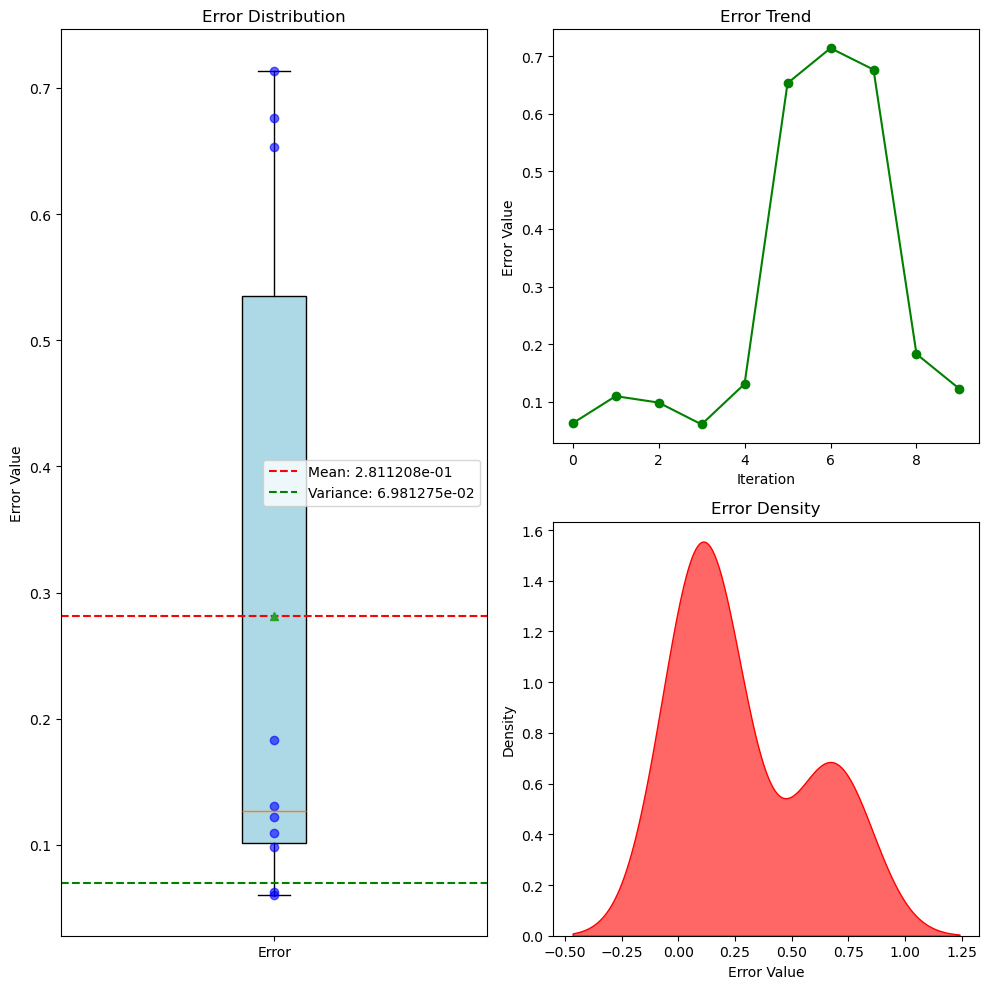

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [10]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


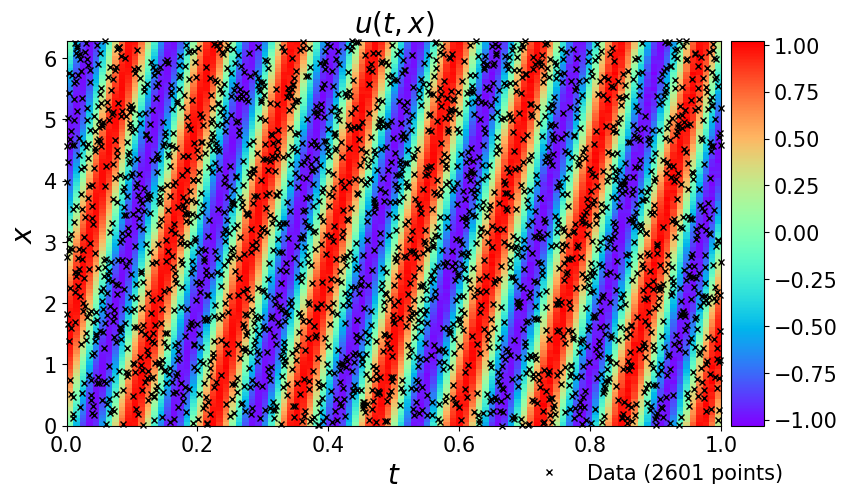

In [11]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f[:,1], 
    X_f[:,0], 
    'kx', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [12]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


14551


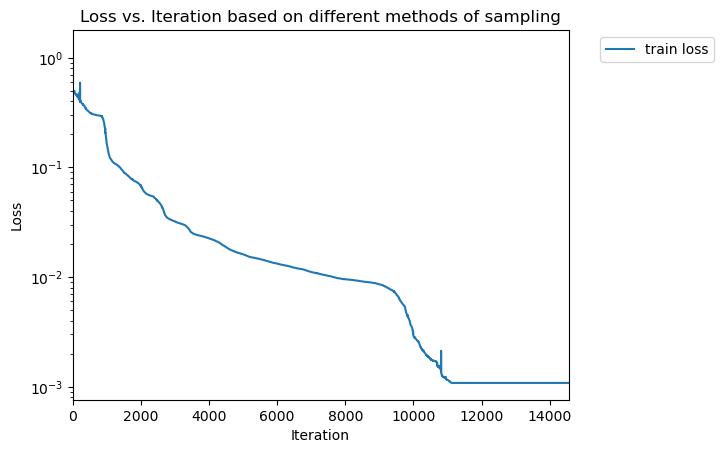

In [13]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


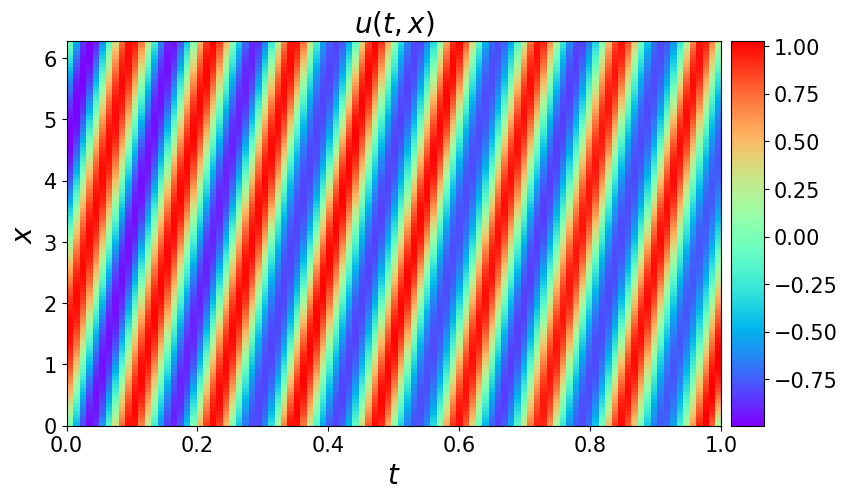

In [14]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

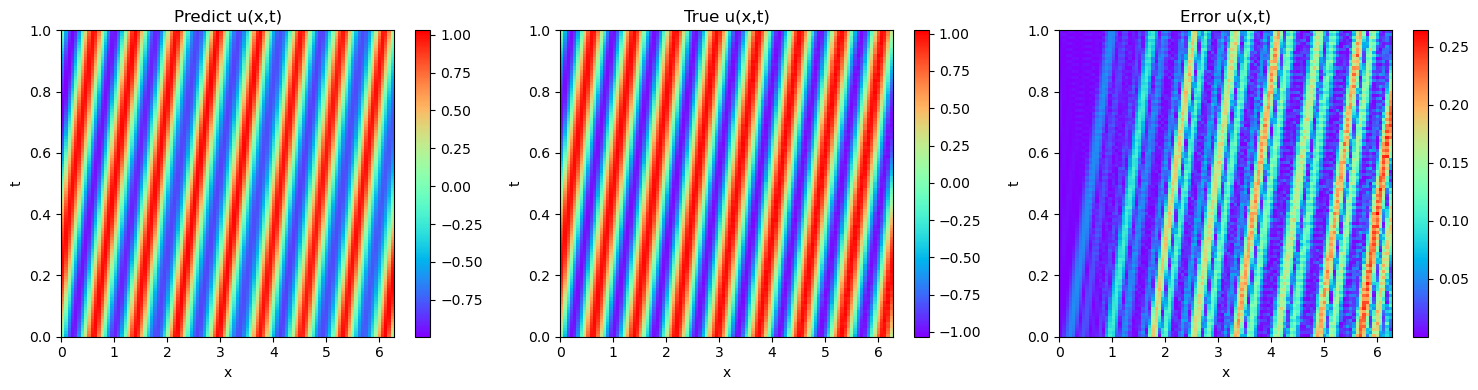

In [15]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [16]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

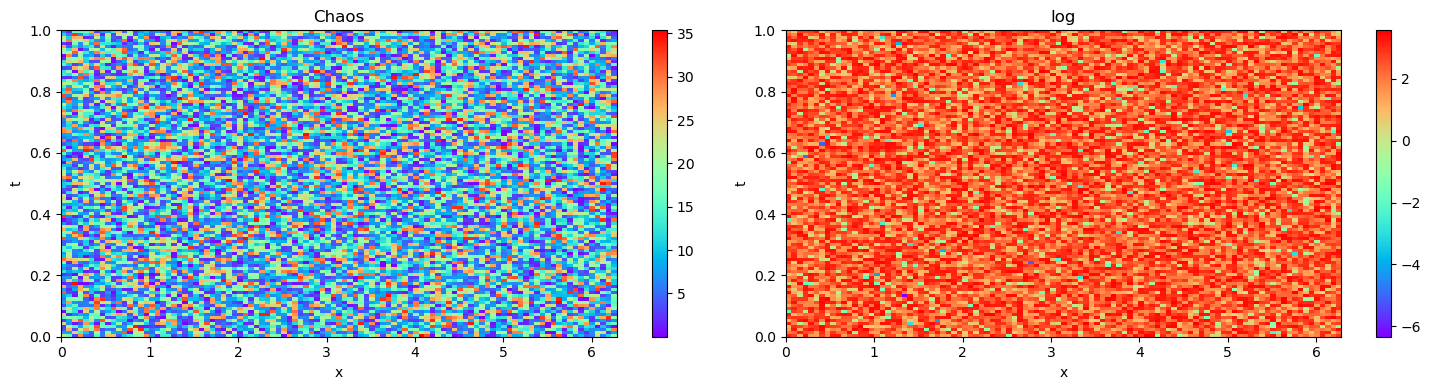

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()